# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50   0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75   0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00   0.285682        0.204435  0.076846  0.085674  0.193388   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.194292  0.011434  0.039765  0.052914  0.000130  
         0.50  0.184541  0.014747  0.037935  0.060579  0.000468  
         0.75  0.174893  0.018155  0.034722  0.072187  0.000997  
         1.00  0.164537  0.021526  0.030790  0.086852  0.001739

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


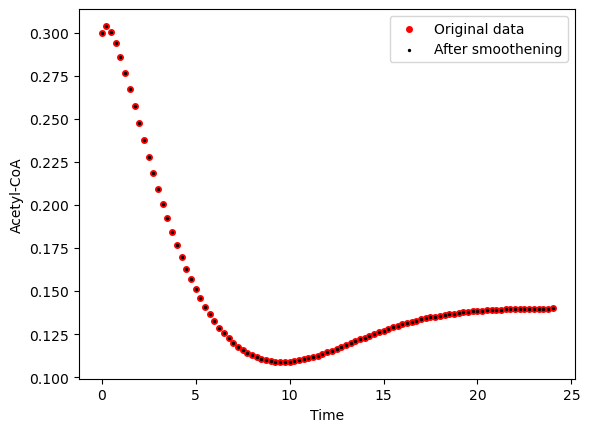

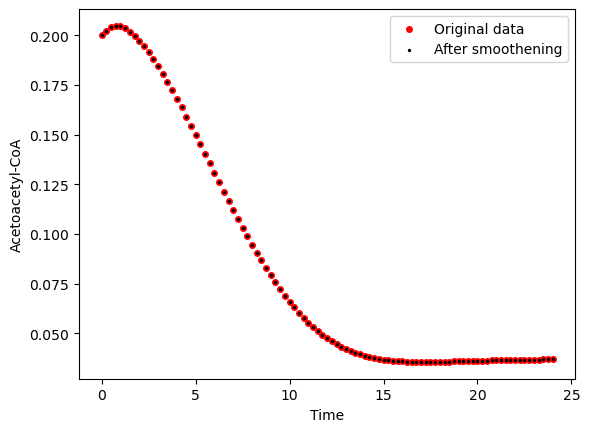

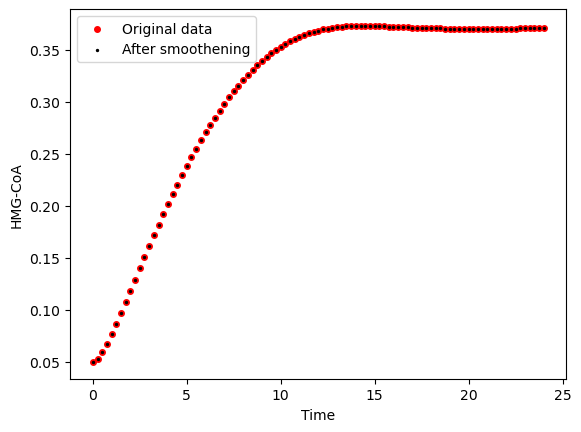

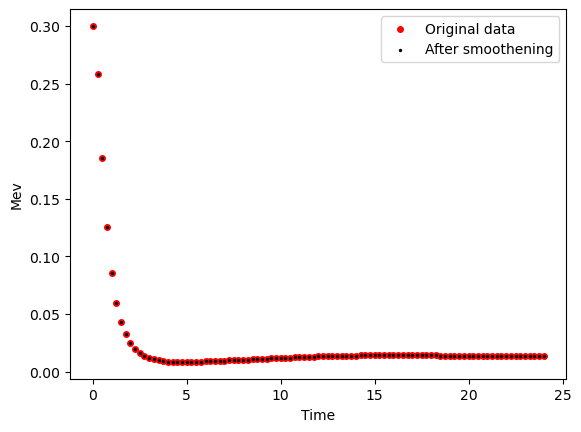

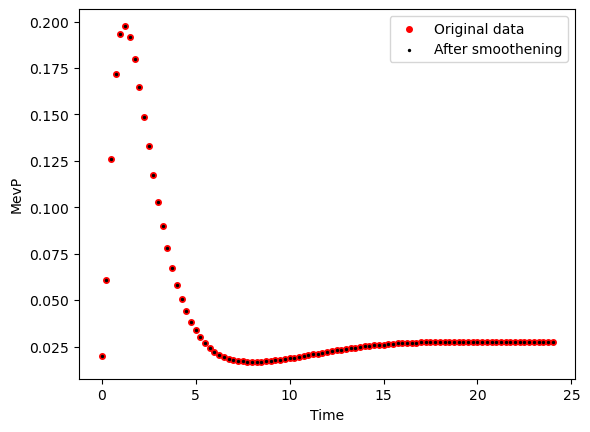

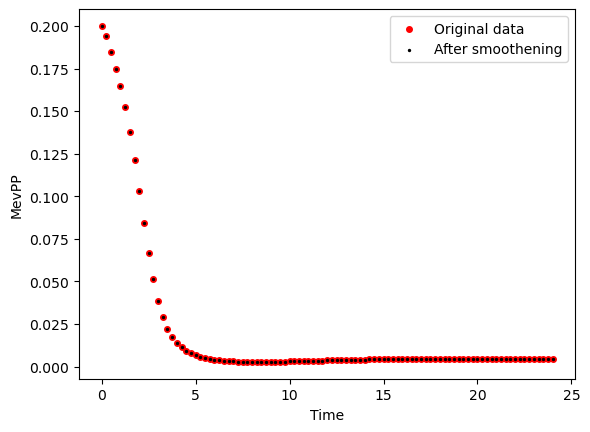

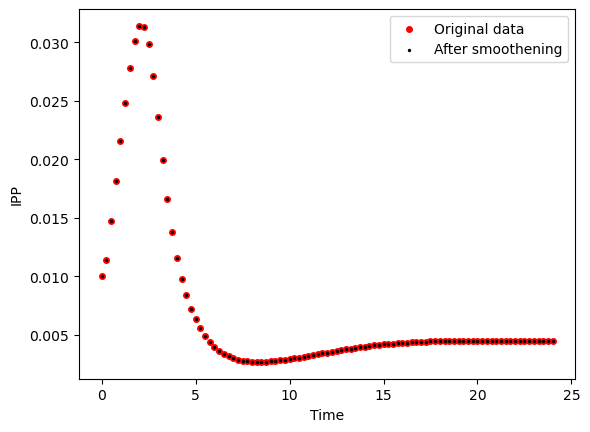

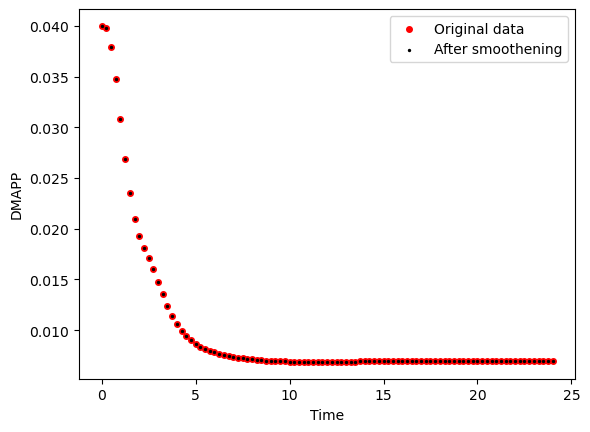

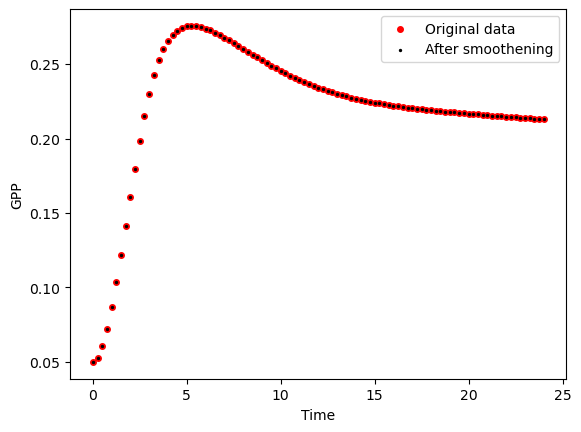

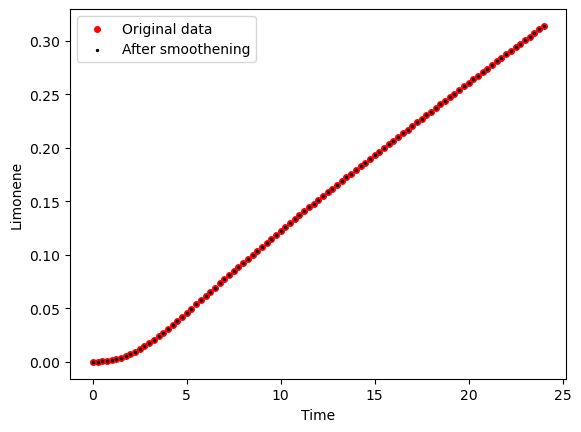

Strain Strain 2


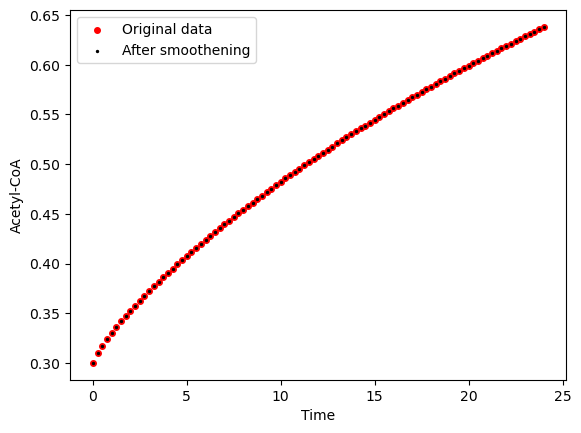

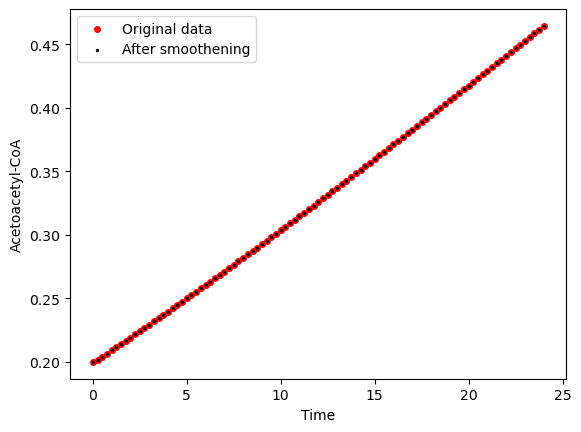

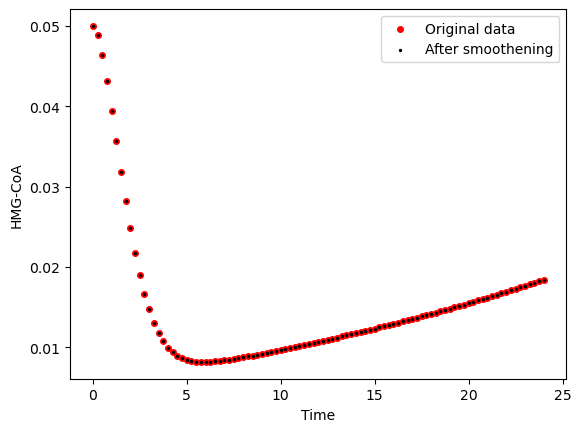

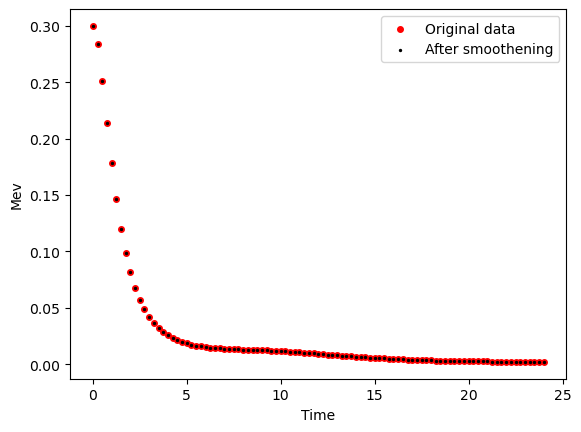

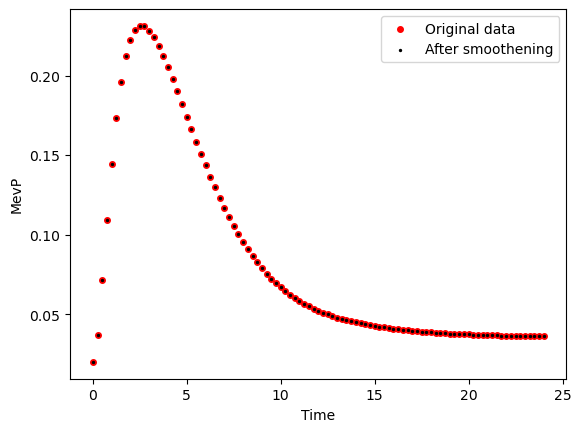

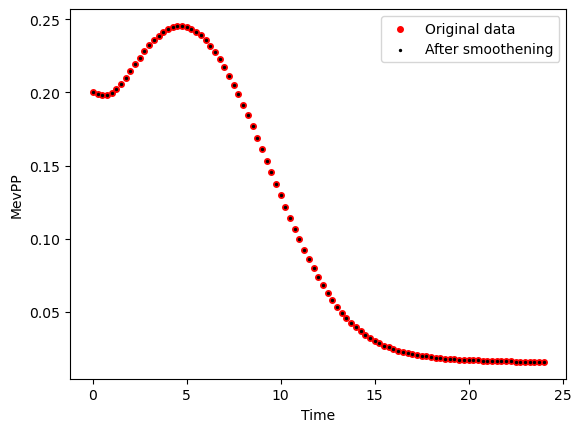

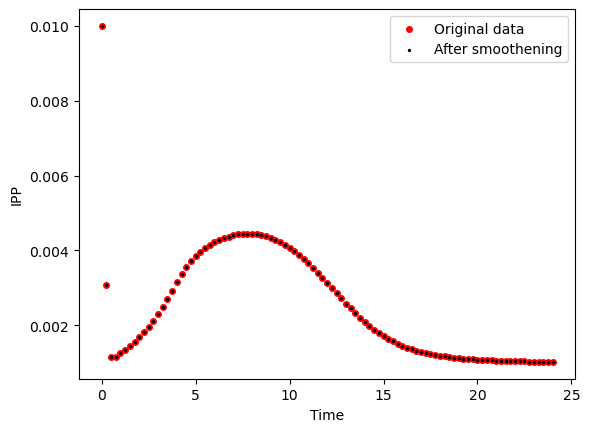

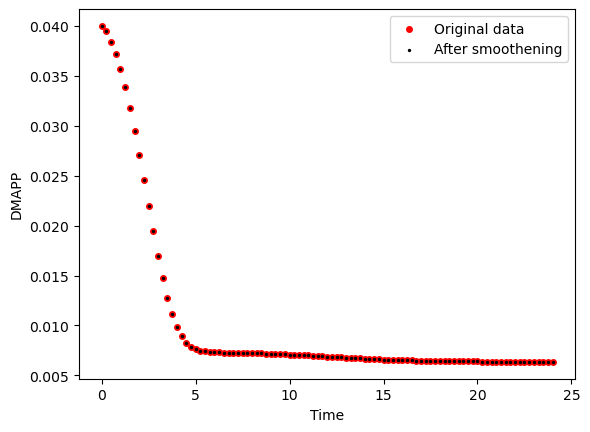

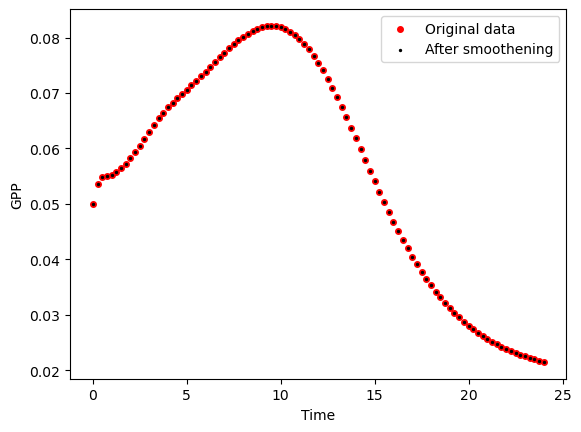

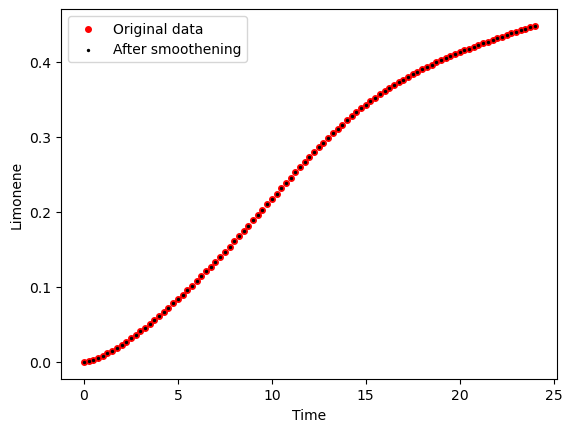

Strain Strain 3


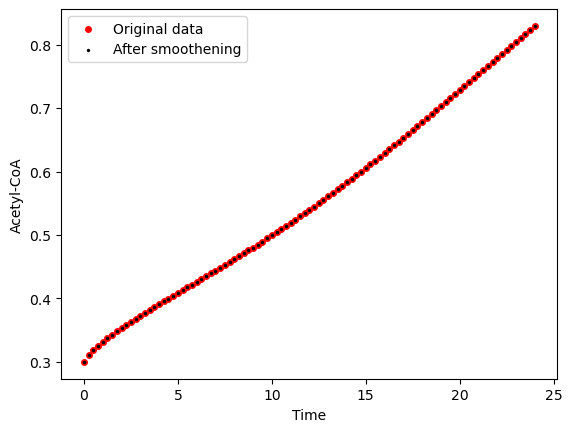

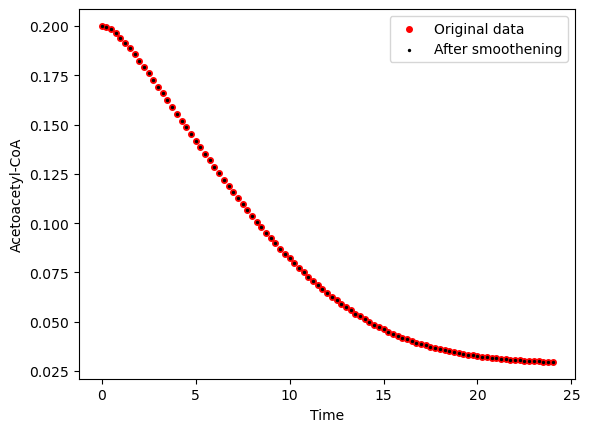

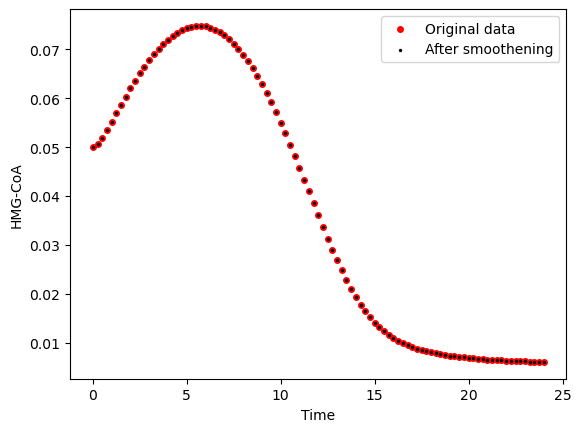

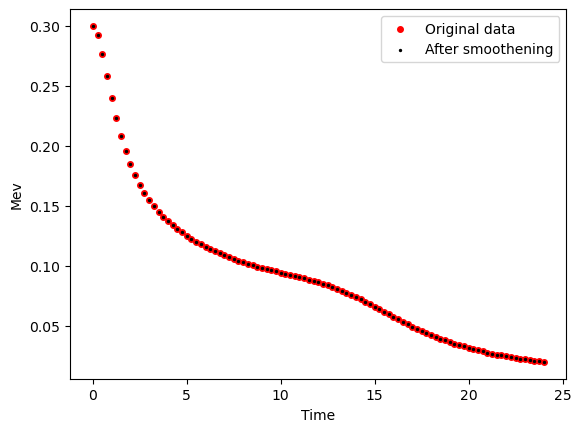

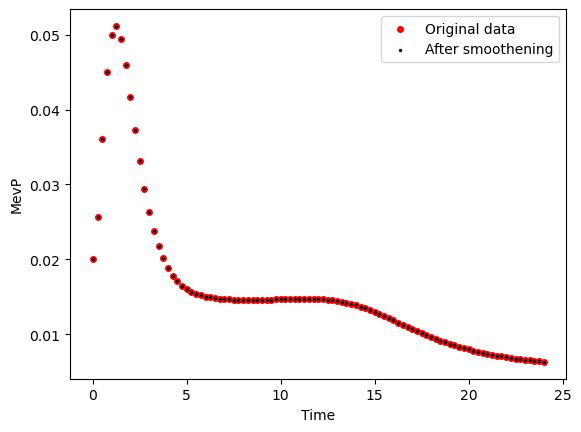

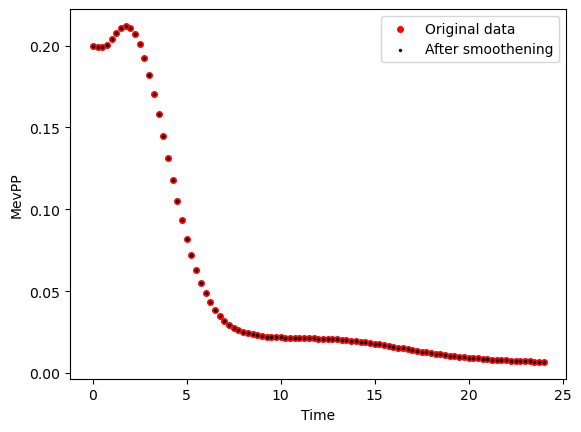

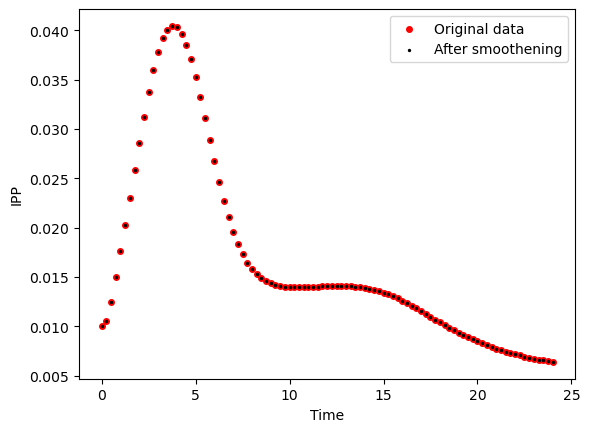

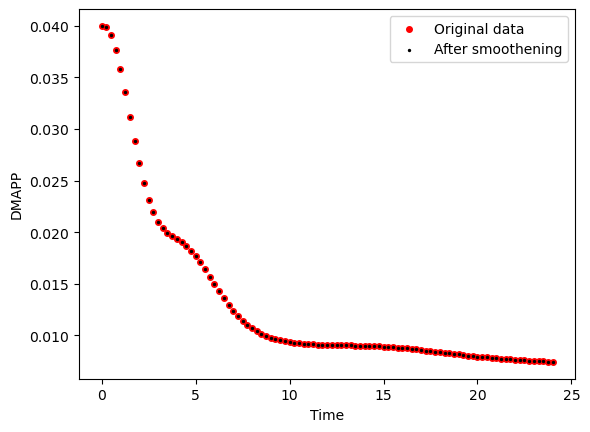

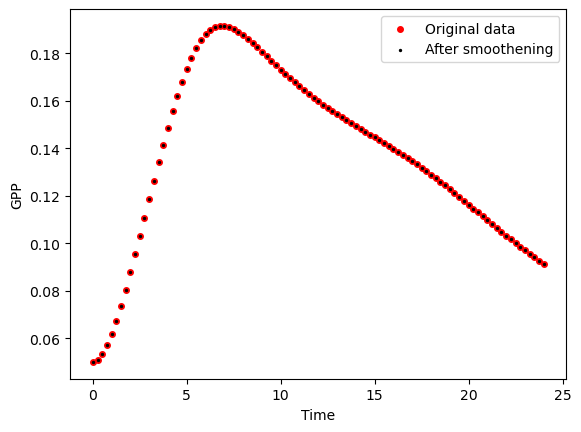

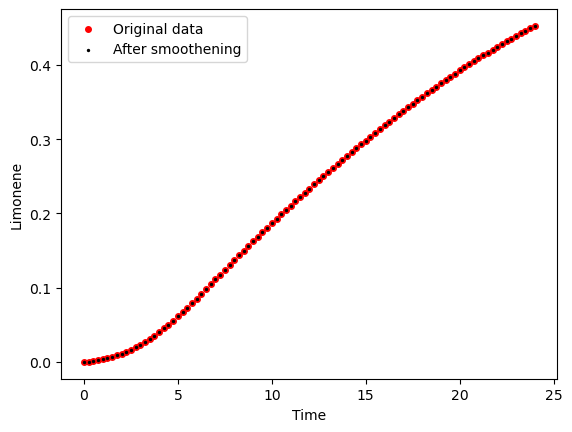

Strain WT


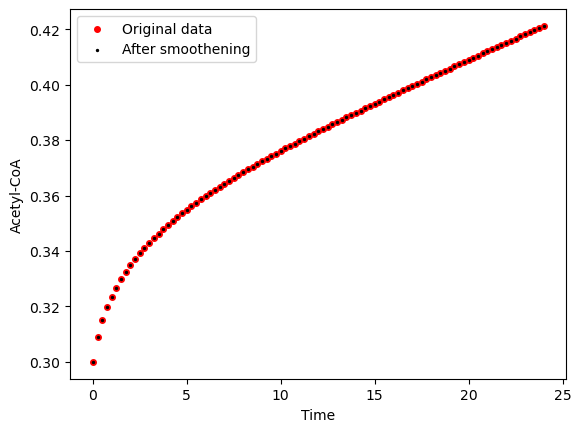

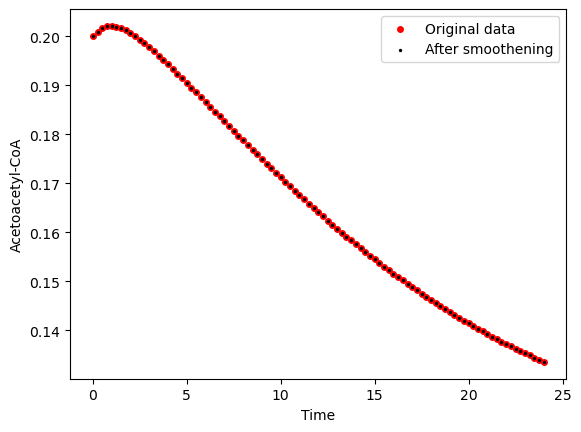

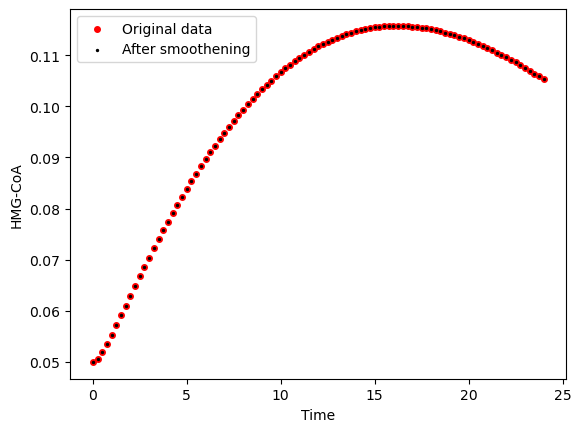

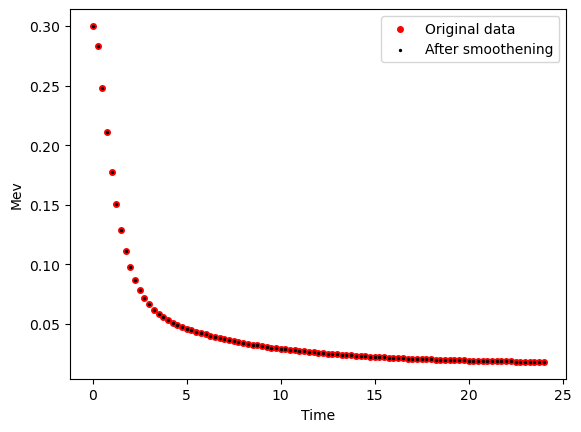

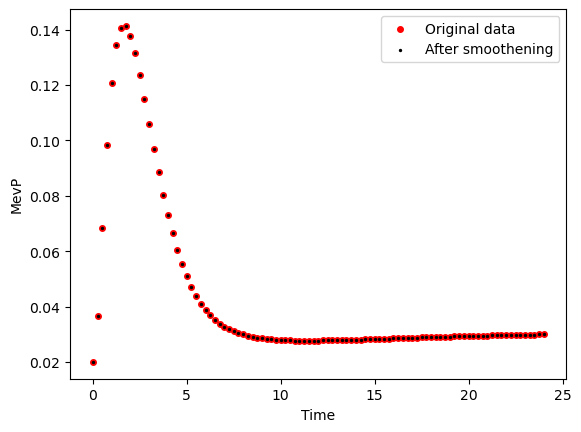

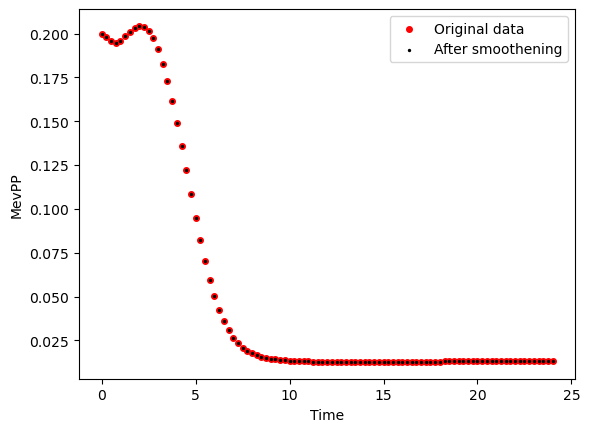

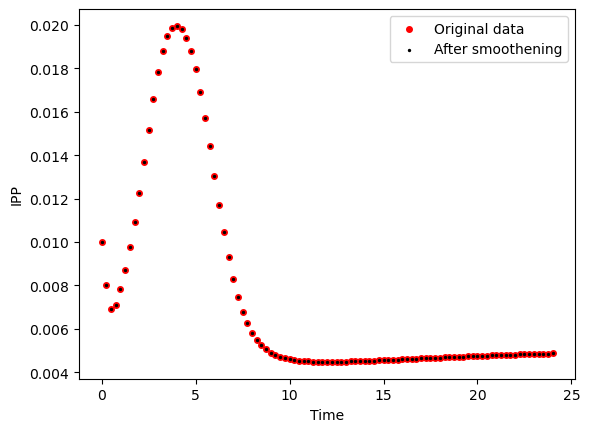

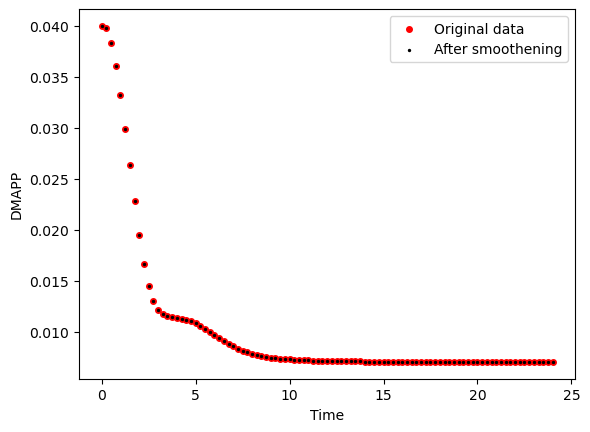

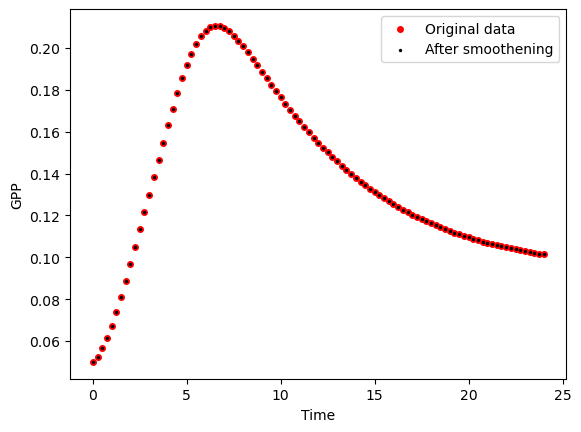

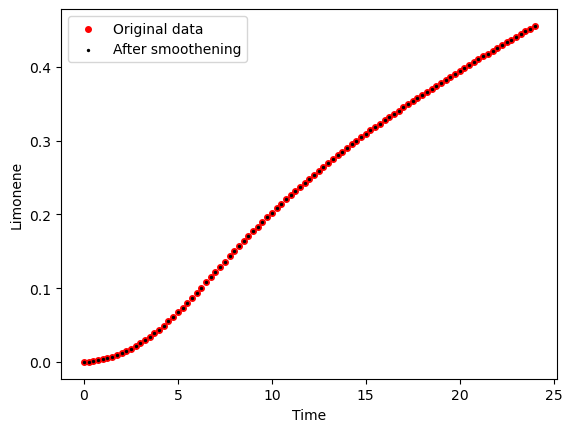

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


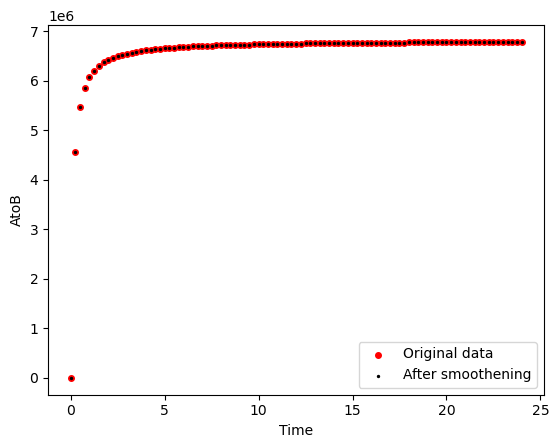

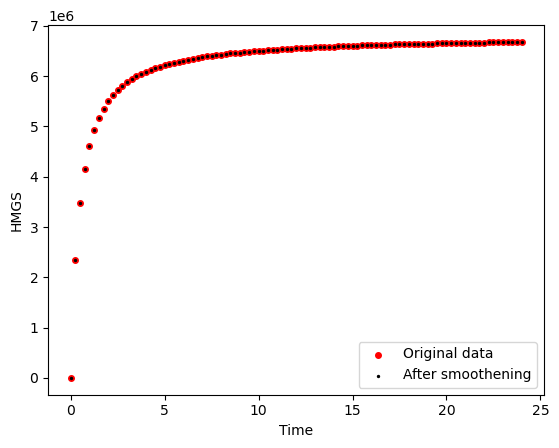

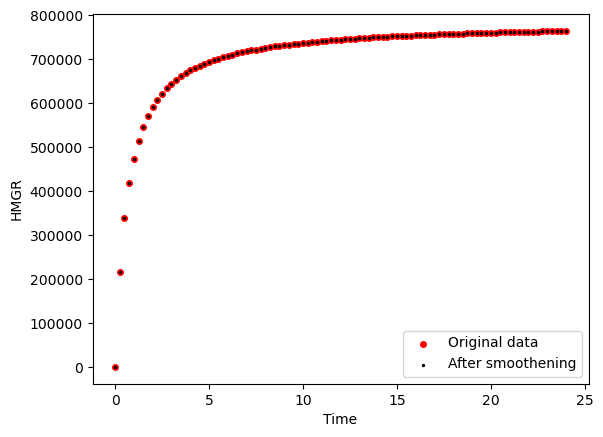

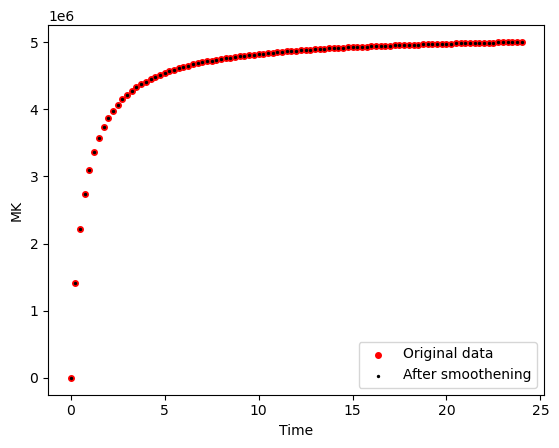

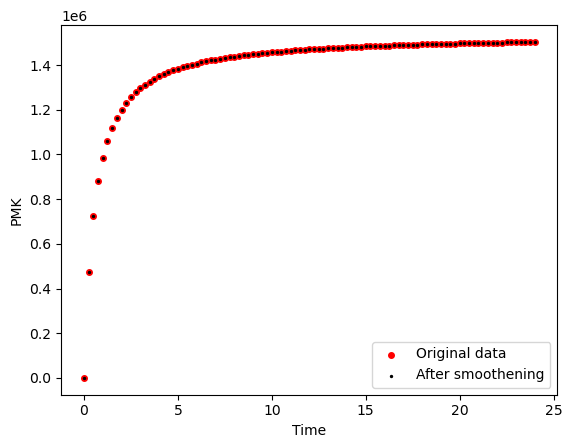

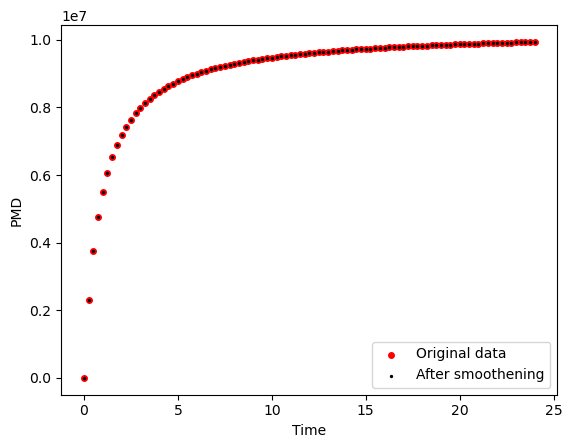

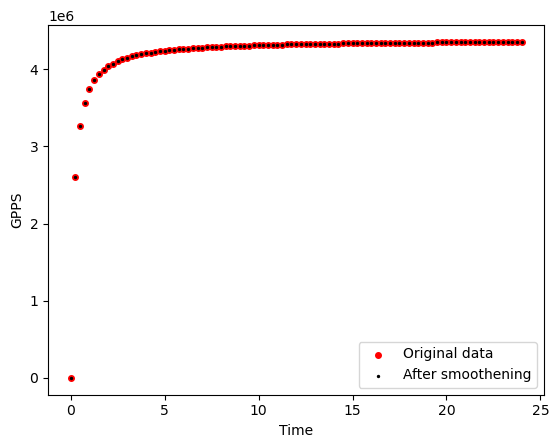

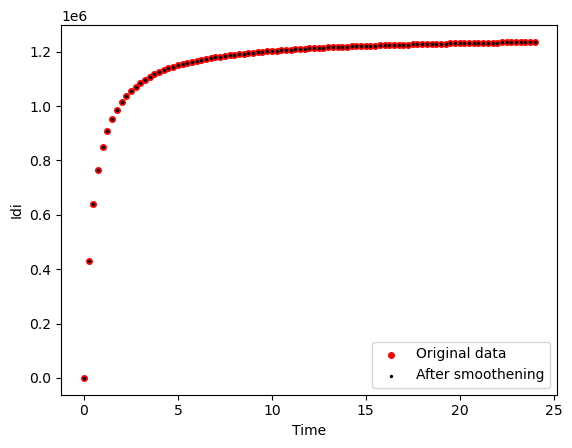

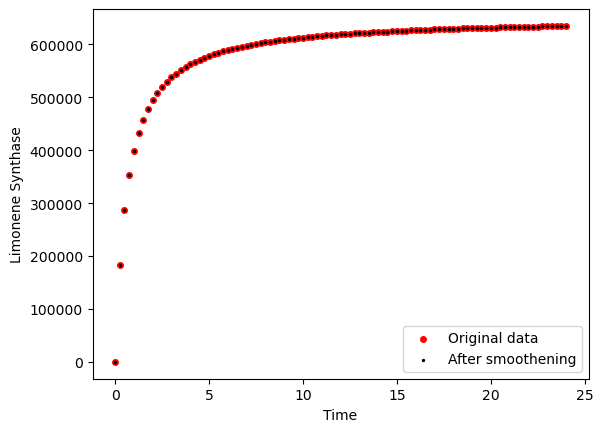

Strain Strain 2


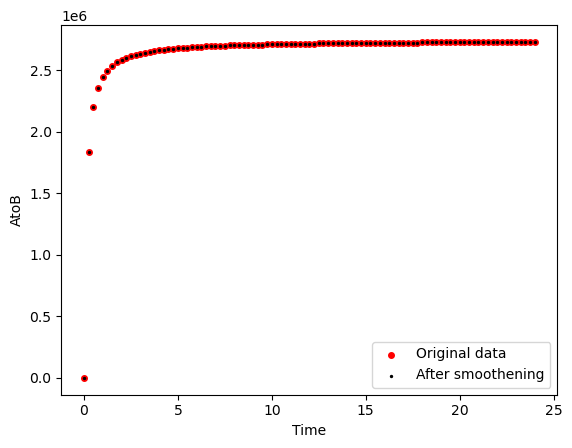

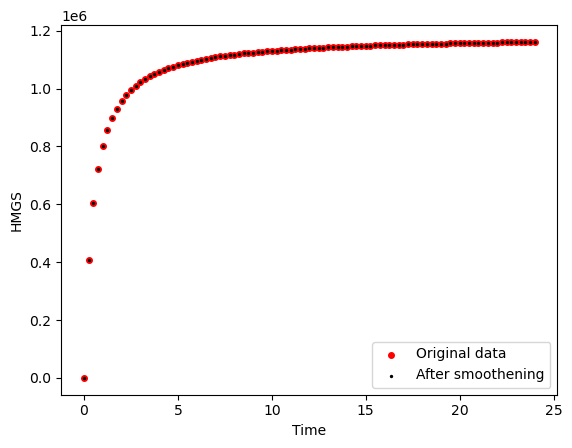

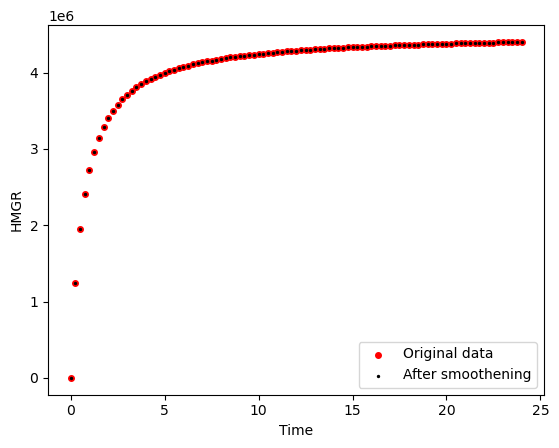

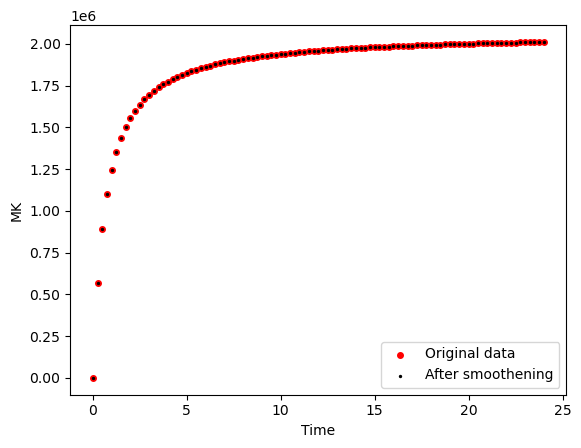

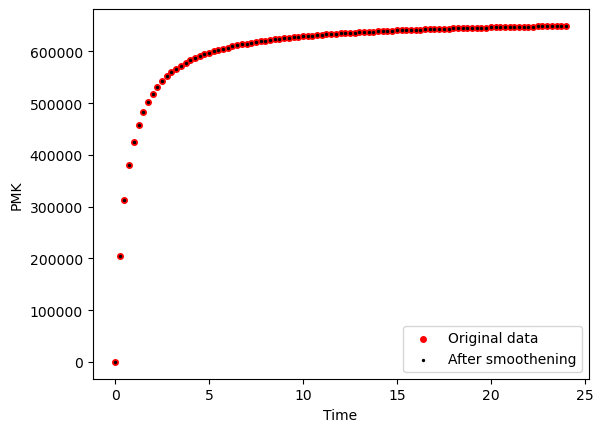

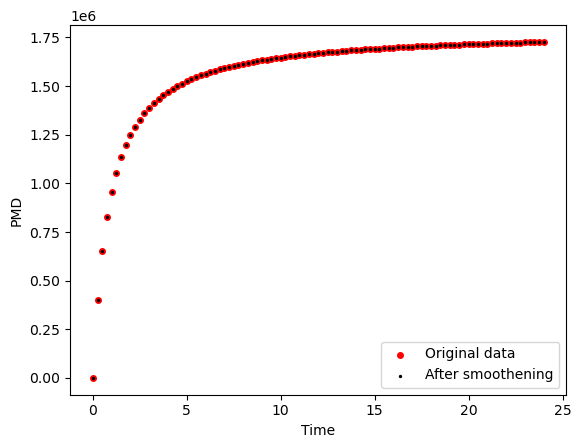

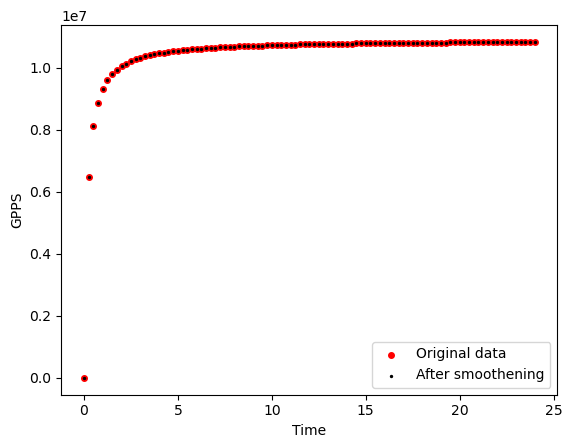

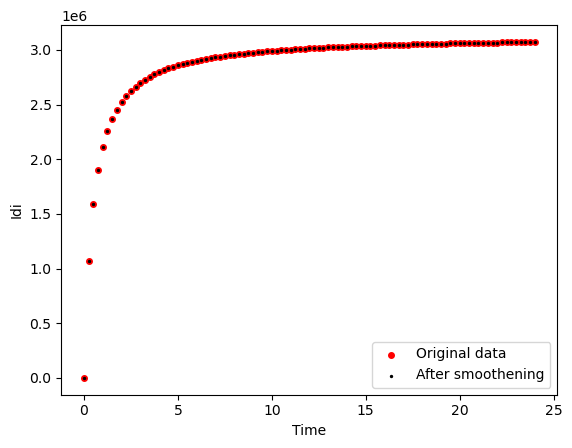

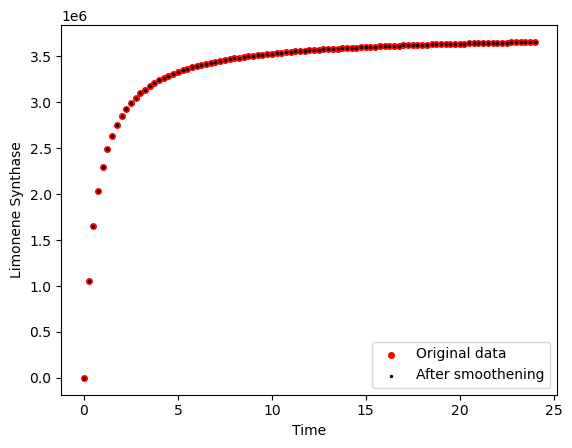

Strain Strain 3


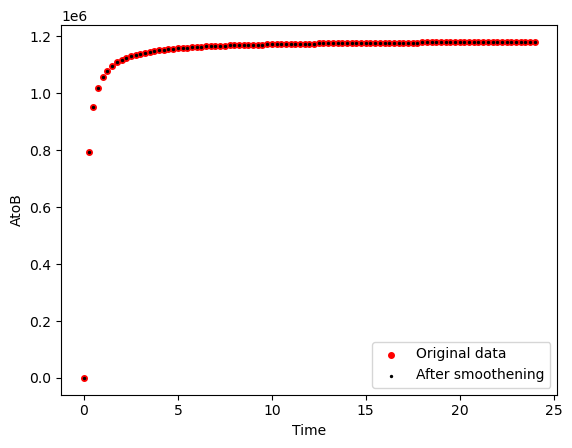

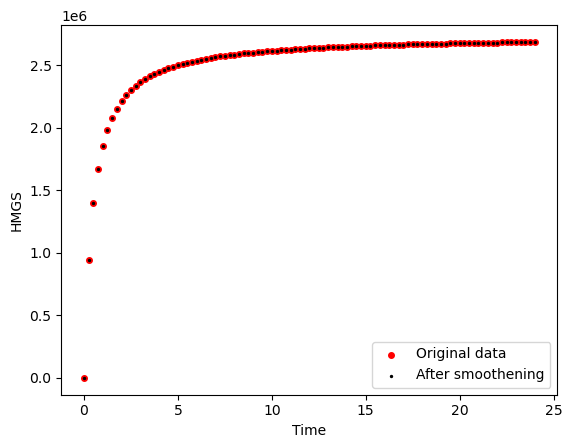

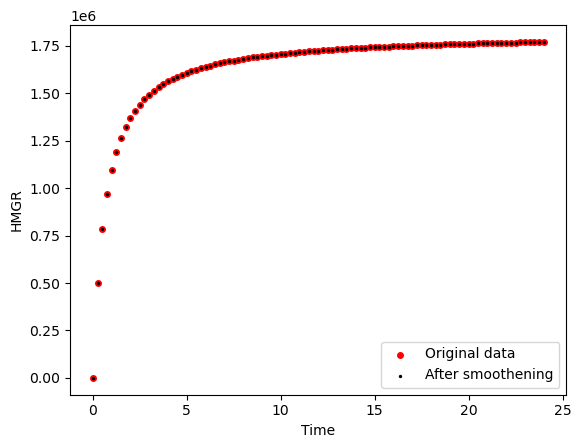

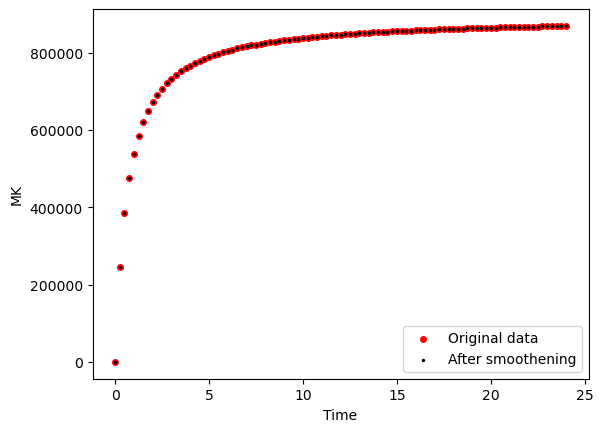

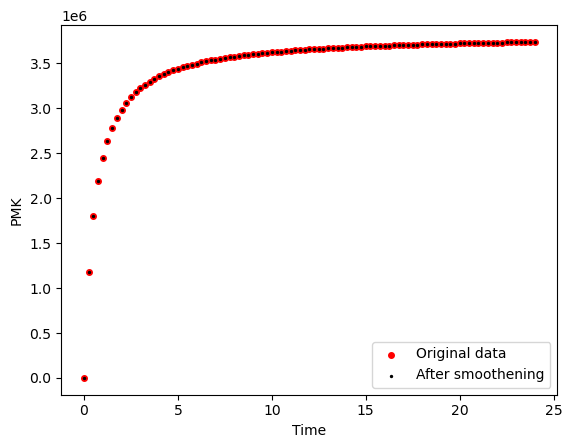

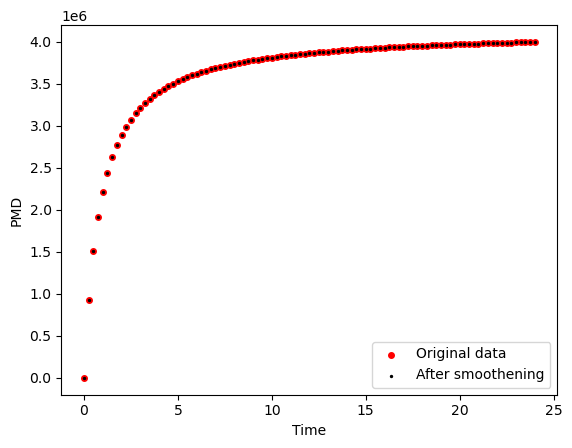

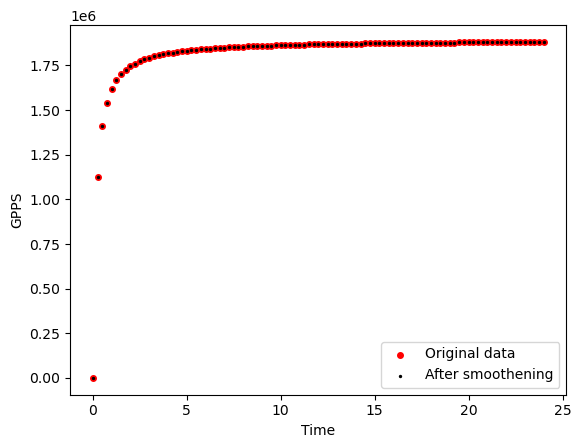

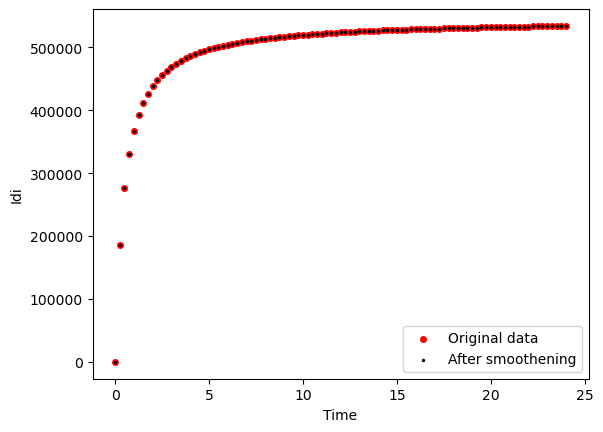

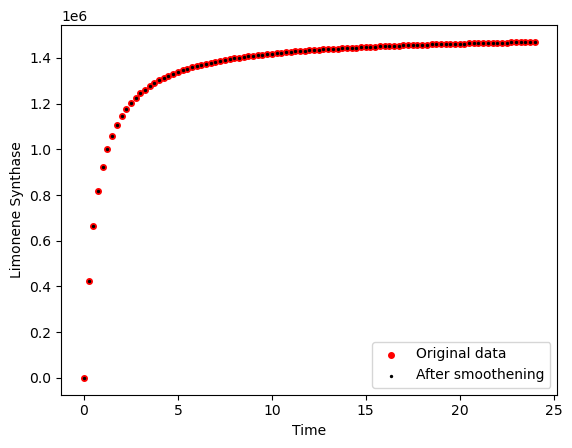

Strain WT


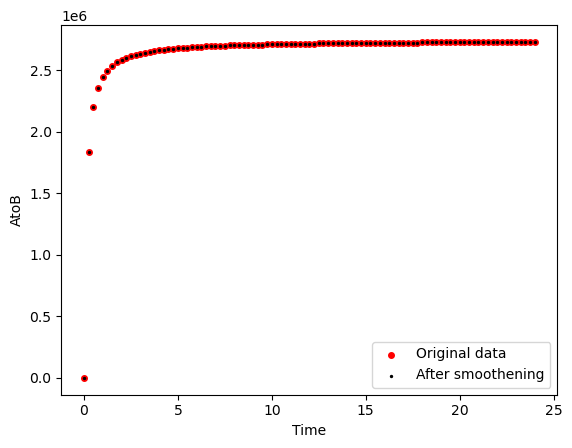

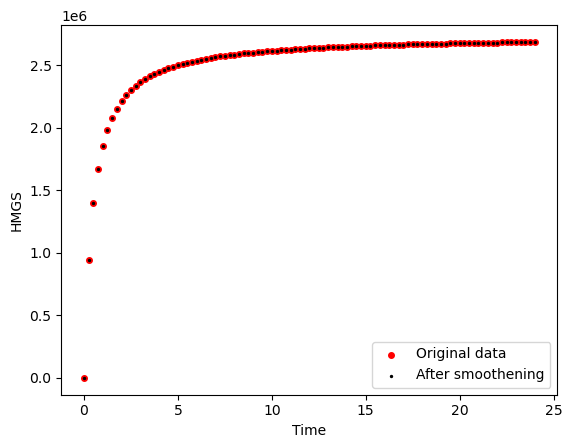

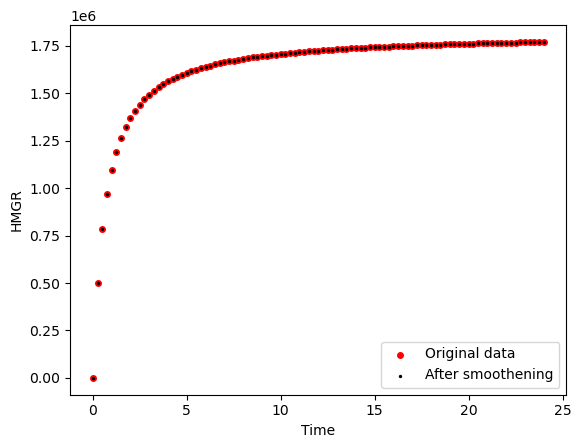

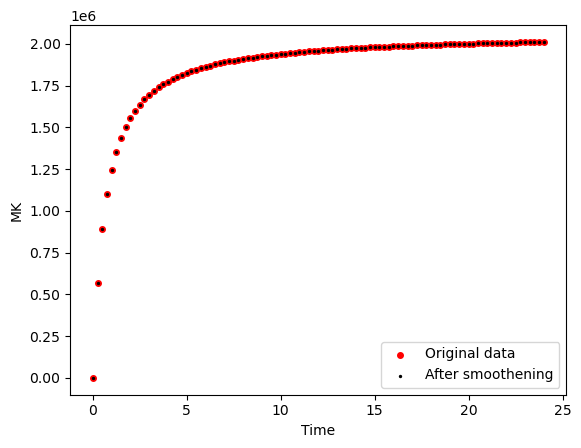

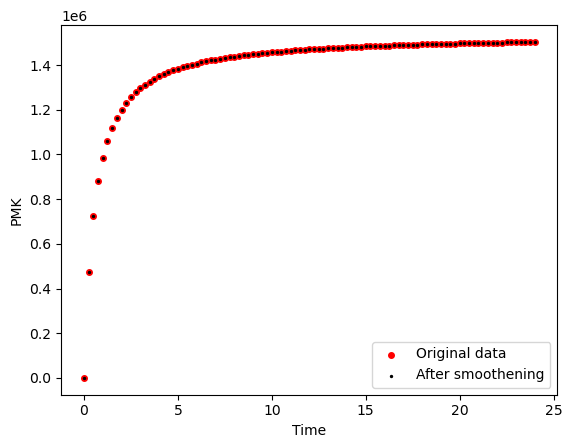

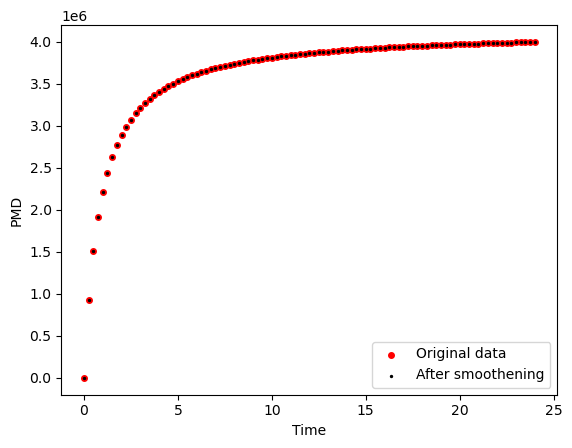

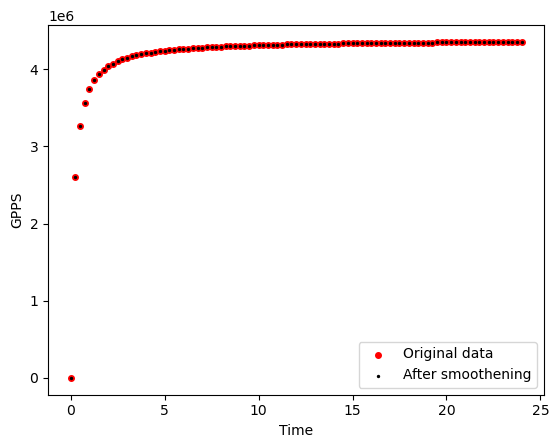

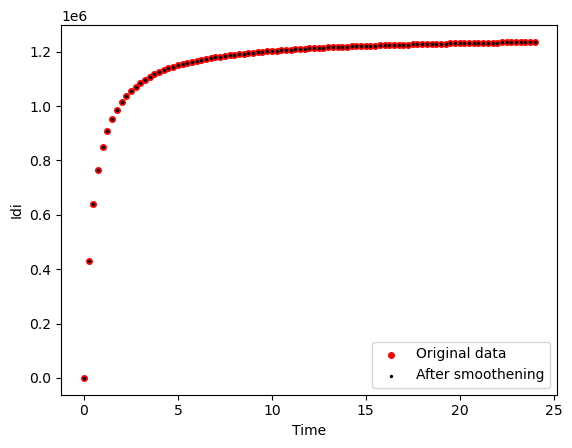

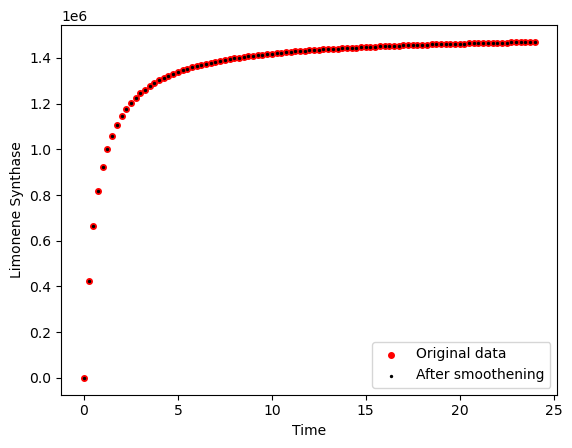

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50    0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75    0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00    0.285682        0.204435  0.076846  0.085674  0.193388   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.418135        0.135344  0.107524  0.018433  0.029820   
         23.25   0.418894        0.134891  0.106975  0.018376  0.029853   
         23.50   0.419652        0.134446  0.106413  0.018321  0.029884   
         23.75   0.420408        0.134009  0.105838  0.018268  0.029914   
         24.00   0.421163        0.133581  0.105252  0.018217  0.029943   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.194292  0.011434  0.039765  0.052914  0.000130  ...   
         0.50   0.184541  0.014747  0.037935  0.060579  0.000468  ...   
         0.75   0.174893  0.018155  0.034722  0.072187  0.000997  ...   
         1.00   0.164537  0.021526  0.030790  0.086852  0.001739  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.013294  0.004839  0.007023  0.102943  0.440720  ...   
         23.25  0.013307  0.004846  0.007023  0.102536  0.444453  ...   
         23.50  0.013319  0.004852  0.007023  0.102148  0.448172  ...   
         23.75  0.013331  0.004858  0.007022  0.101776  0.451879  ...   
         24.00  0.013342  0.004864  0.007022  0.101420  0.455574  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

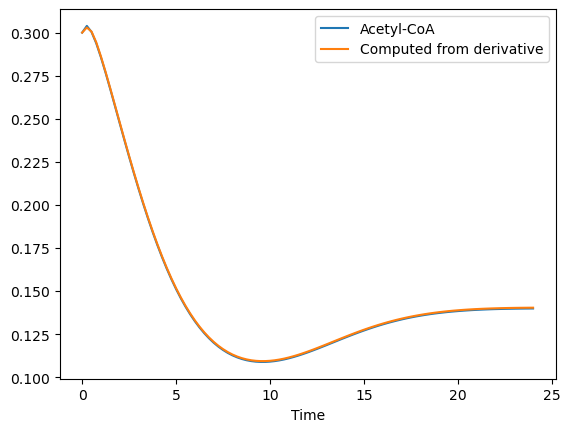

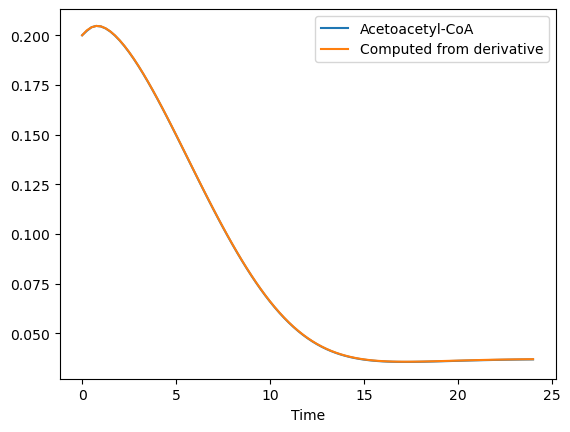

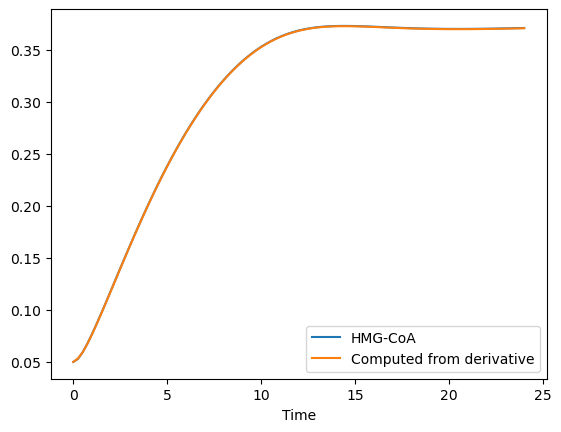

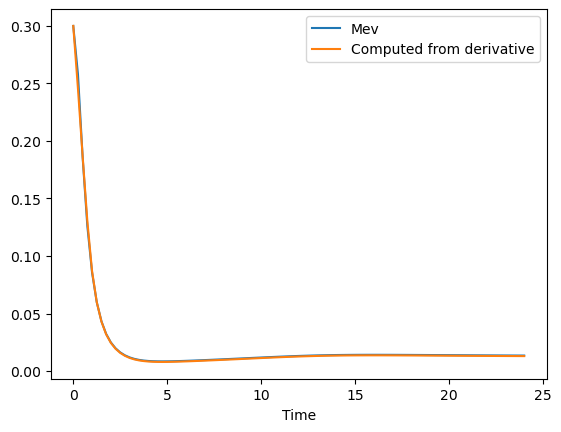

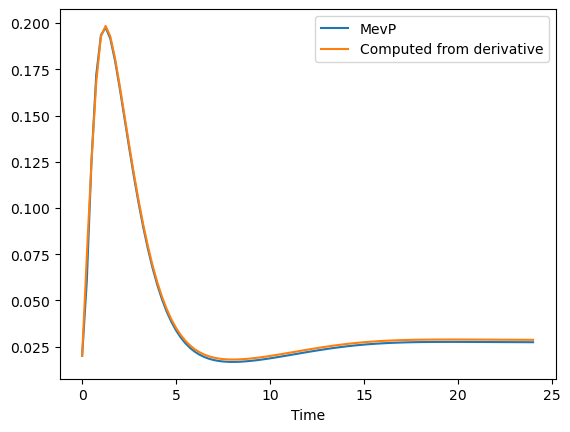

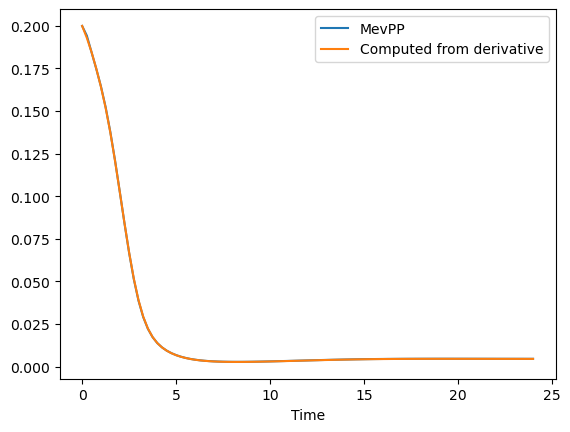

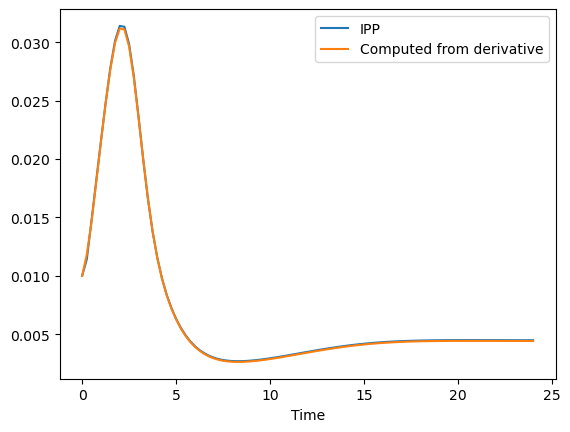

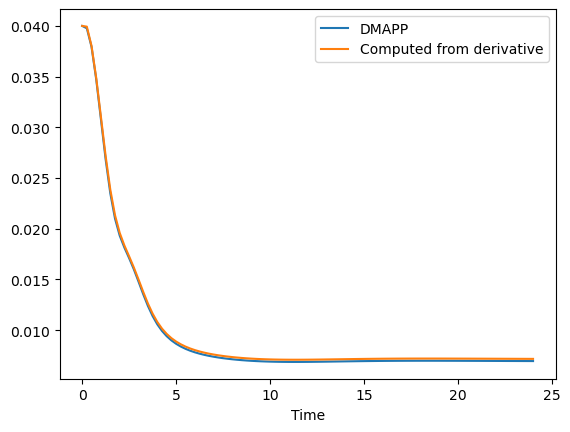

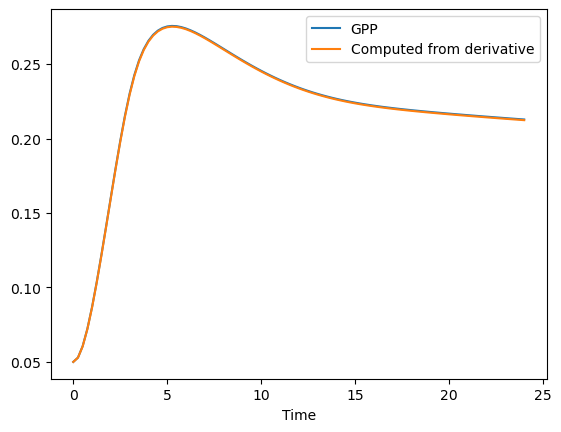

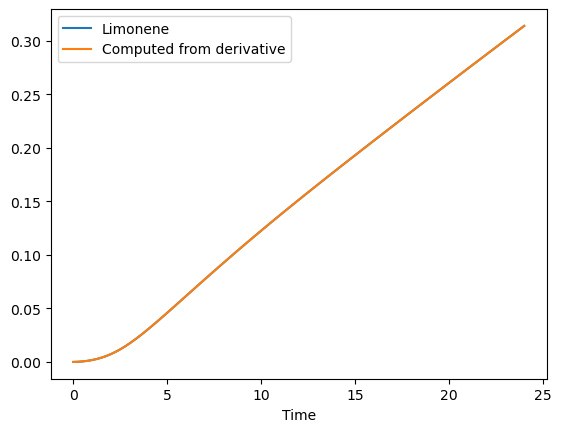

'Time profile from derivative vs. actual profile for Strain 2'

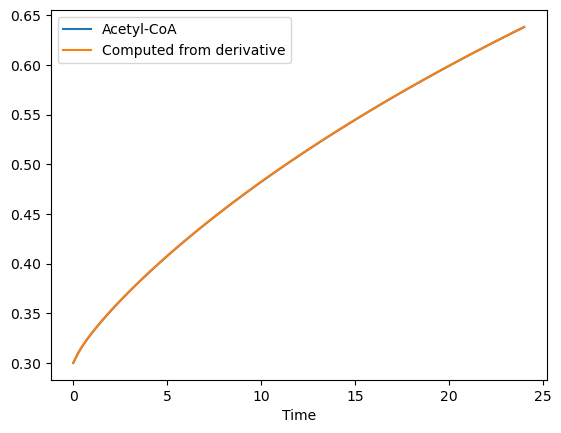

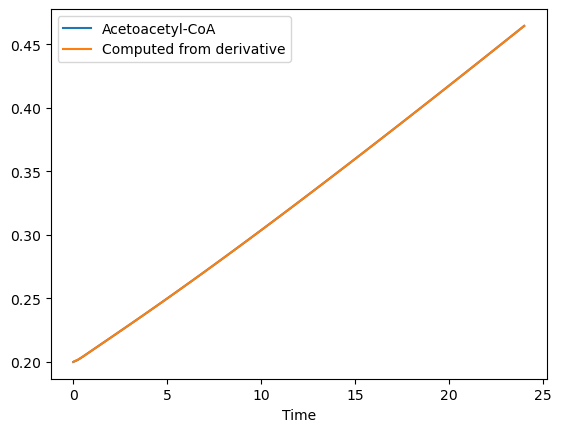

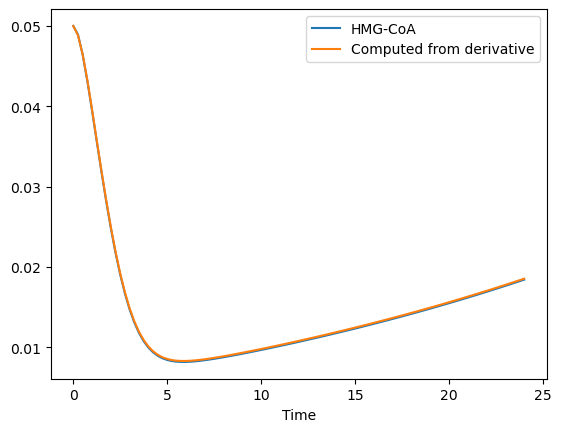

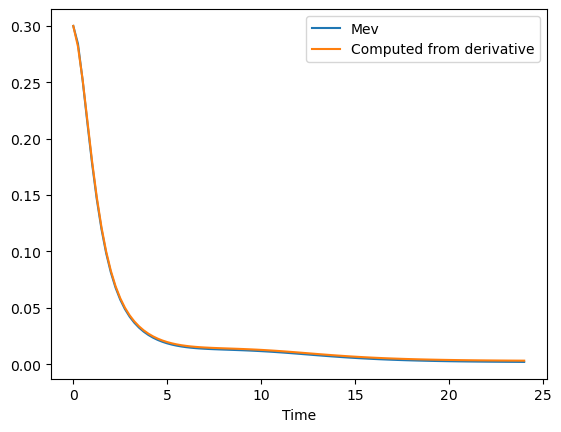

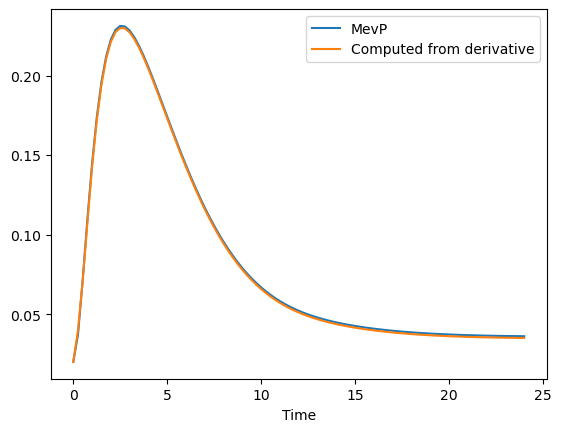

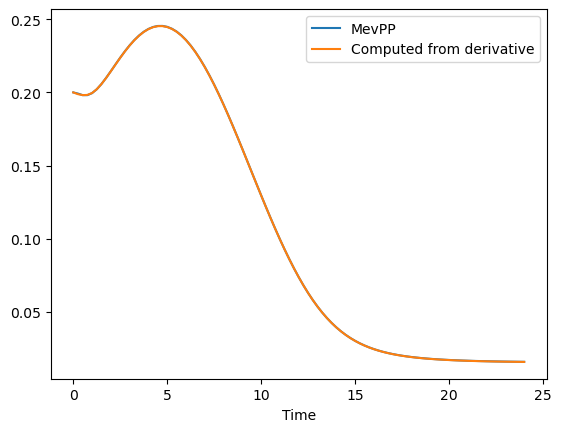

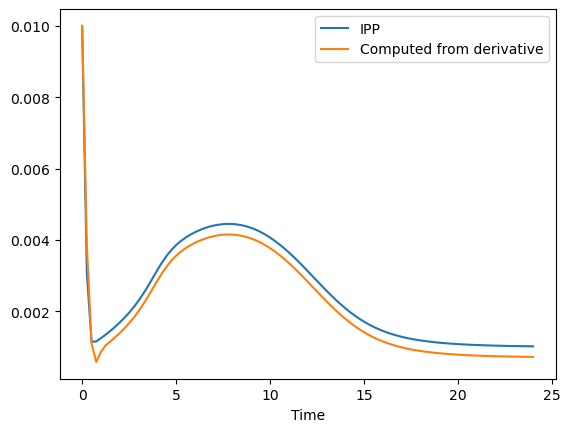

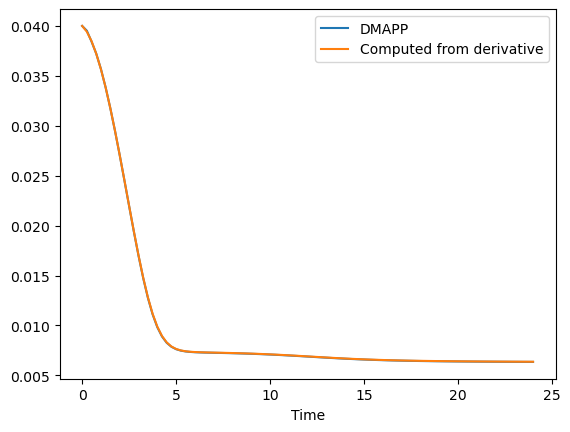

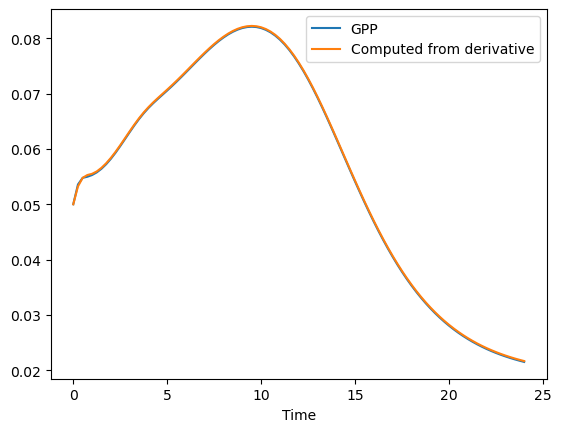

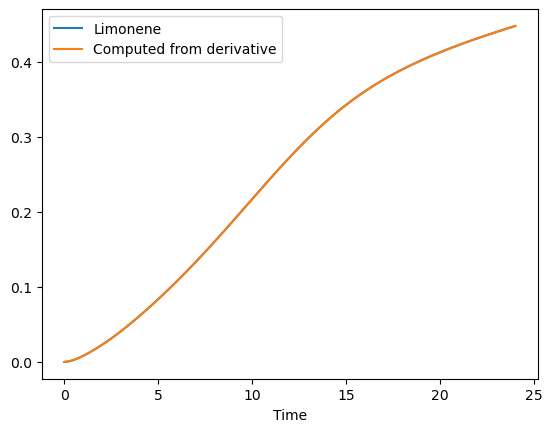

'Time profile from derivative vs. actual profile for Strain 3'

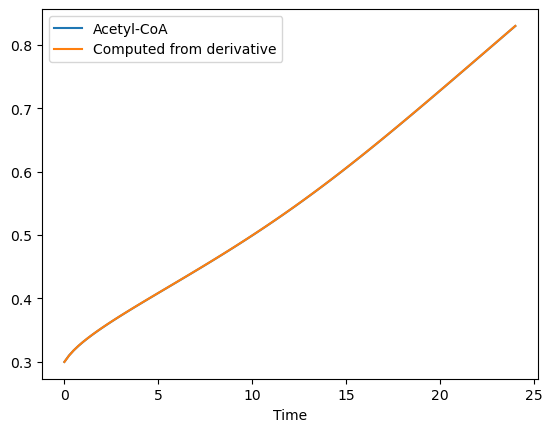

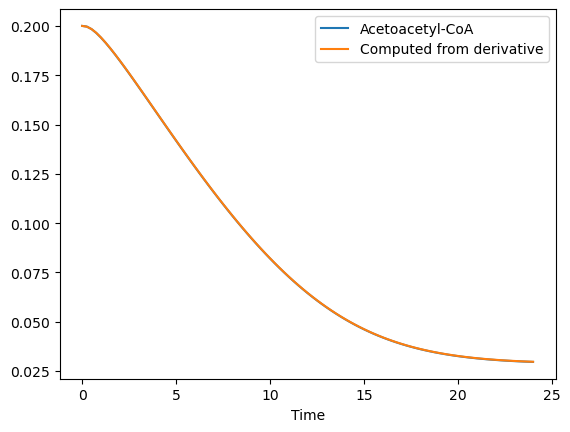

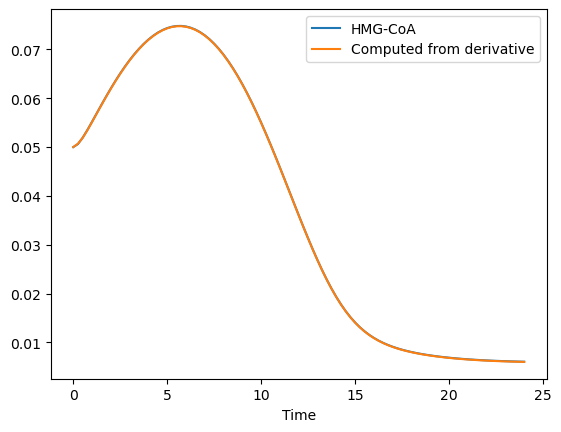

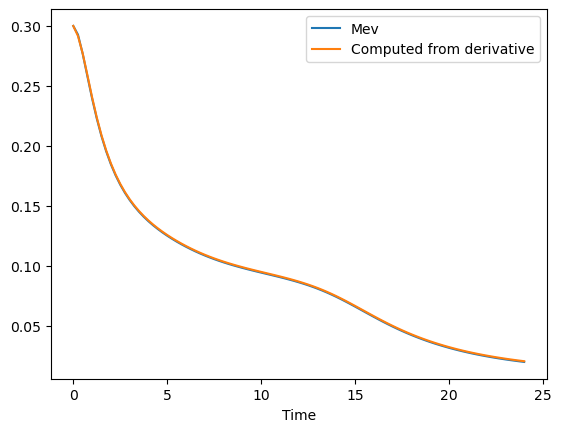

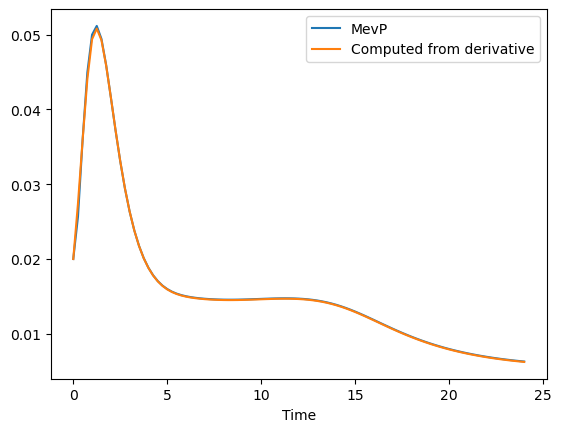

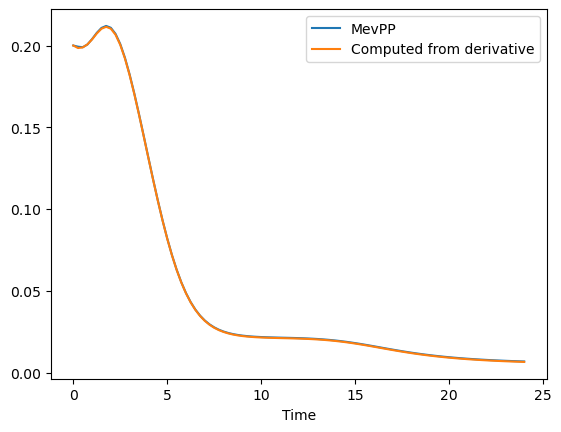

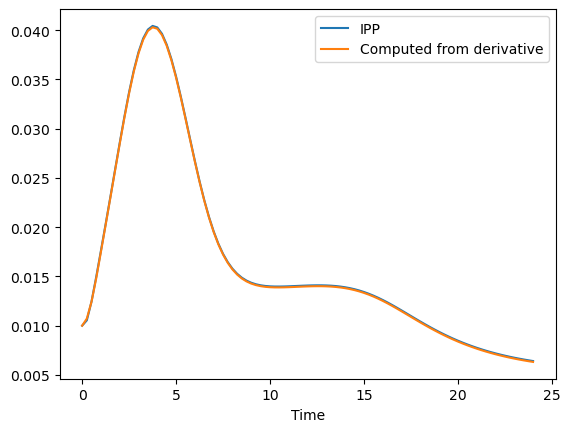

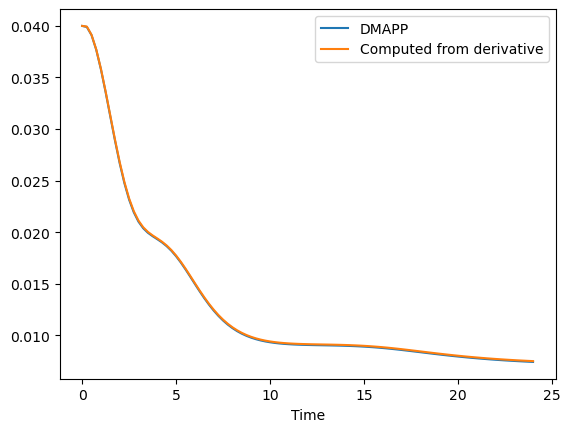

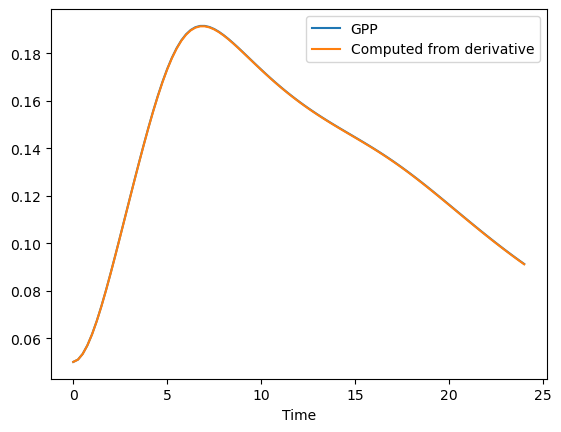

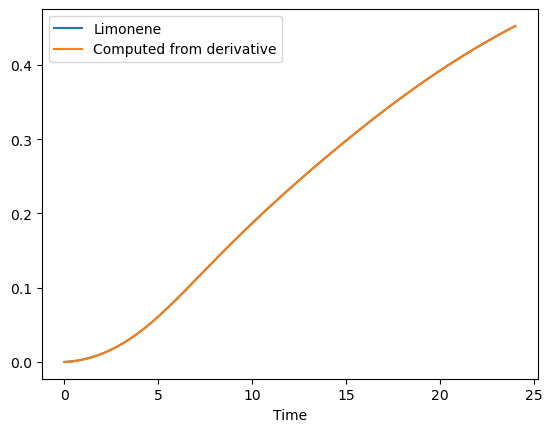

'Time profile from derivative vs. actual profile for WT'

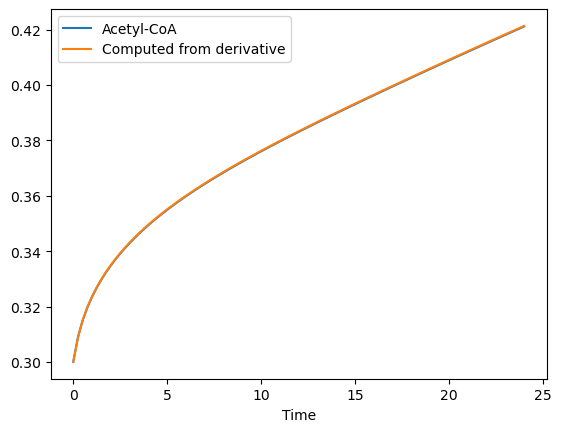

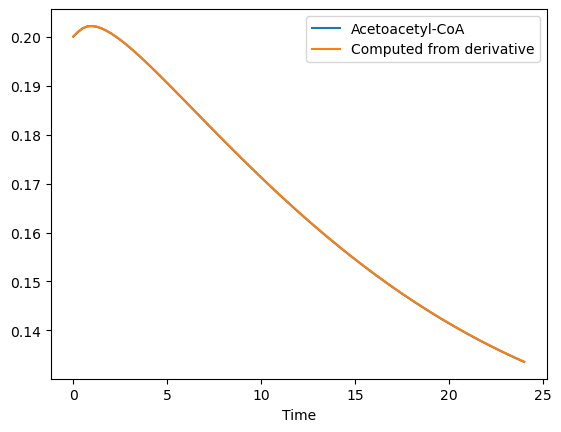

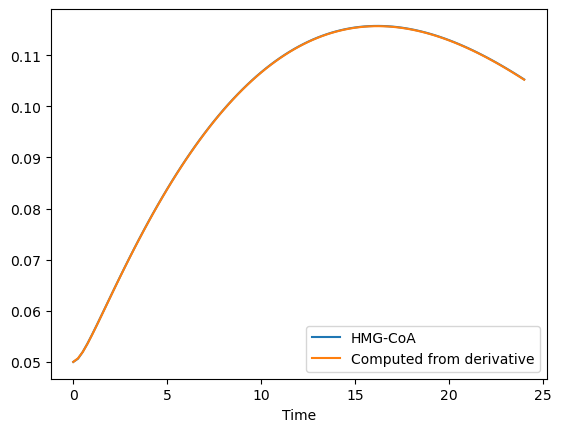

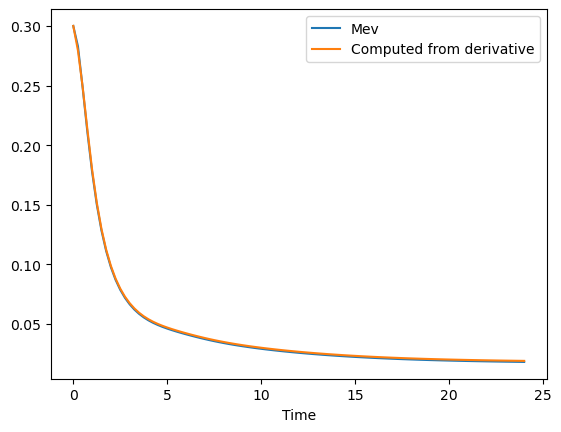

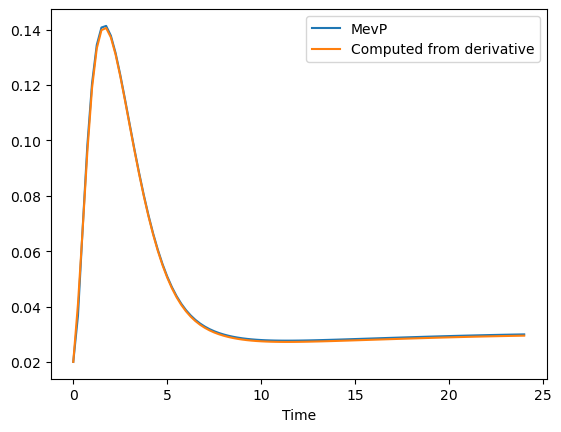

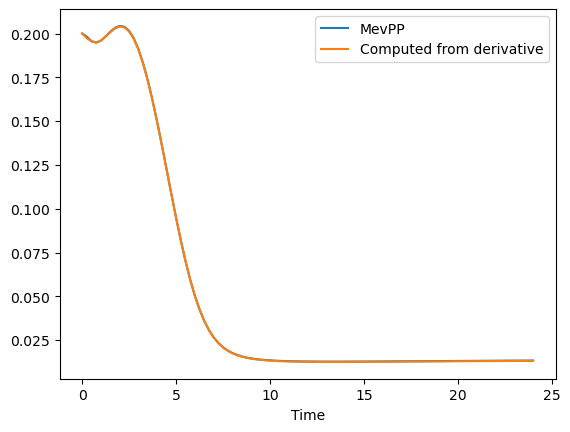

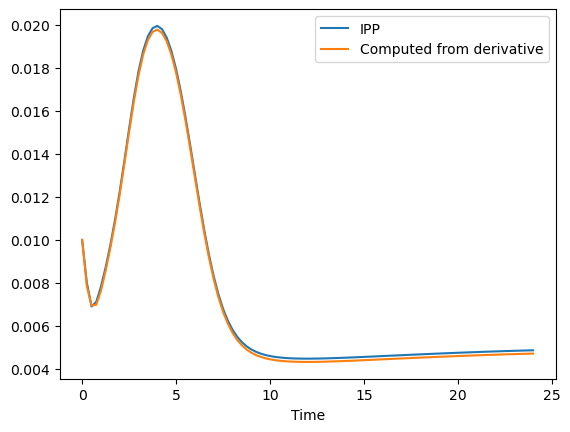

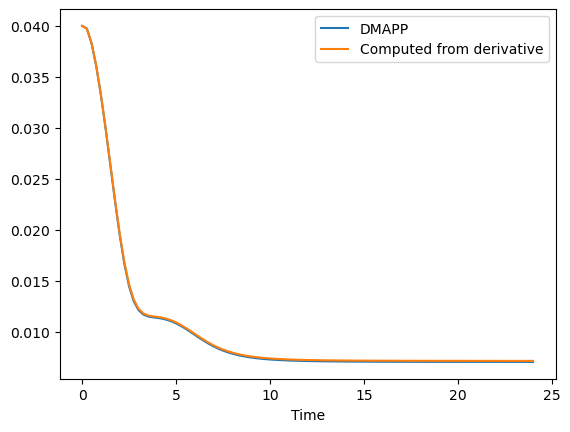

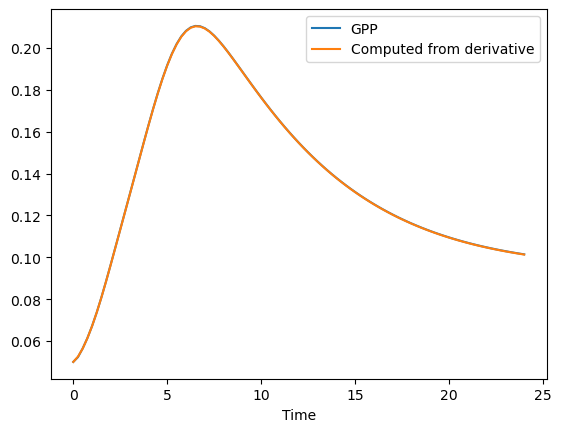

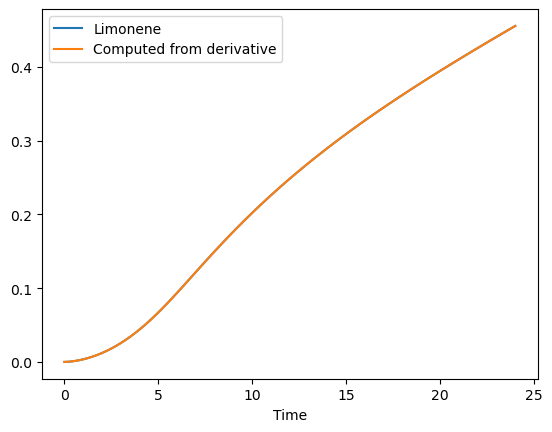

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303889        0.202239  0.052901   
         0.50       2.866143e+05   0.300366        0.204051  0.059318   
         0.75       3.524272e+05   0.293825        0.204705  0.067553   
         1.00       3.981392e+05   0.285682        0.204435  0.076846   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.418135        0.135344  0.107524   
         23.25      1.468435e+06   0.418894        0.134891  0.106975   
         23.50      1.468851e+06   0.419652        0.134446  0.106413   
         23.75      1.469260e+06   0.420408        0.134009  0.105838   
         24.00      1.469659e+06   0.421163        0.133581  0.105252   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257973  0.060732  0.194292  0.011434  0.039765  0.052914   
         0.50   0.185505  0.126153  0.184541  0.014747  0.037935  0.060579   
         0.75   0.125893  0.171899  0.174893  0.018155  0.034722  0.072187   
         1.00   0.085674  0.193388  0.164537  0.021526  0.030790  0.086852   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.018433  0.029820  0.013294  0.004839  0.007023  0.102943   
         23.25  0.018376  0.029853  0.013307  0.004846  0.007023  0.102536   
         23.50  0.018321  0.029884  0.013319  0.004852  0.007023 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         24.00  0.000044  0.000023 -0.000001 -0.001390  0.014756  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,
                             -12.0,0.0,-12.0,-12.0,
                             0.0,-12.0,-12.0,0.0,
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,-12.0,
                             0.0,0.0,
                             -12.0,-12.0,-12.0,
                             0.0,-12.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0,0.0,
                             0.0,0.0,0.0,
                             0.0,12.0,0.0,0.0,
                             12.0,0.0,0.0,12.0,
                             0.0,0.0,
                             0.0,0.0,0.0,0.0,
                             12.0,12.0,
                             0.0,0.0,0.0,
                             12.0,0.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       kma11,kcat1,
                       kma21,kma22,kcat2,
                       kma33,kI31,kI32,kcat3,
                       kma44,kI46,kI49,kcat4,
                       kma55,kcat5,
                       kma66,kI64,kI65,kcat6,
                       kma77,kcat7,
                       kma87,kma88,kcat8,
                       kma99,kcat9,
                       Vin): #HC: 27
    
        s11_hat = s1 / (10**kma11)
        r1 = e1 *(10**kcat1) *(s11_hat**2)/(1 + s11_hat + s11_hat**2)  # AtoB
        
        s21_hat = s1 / (10**kma21)
        s22_hat = s2 / (10**kma22)
        r2 = e2 *(10**kcat2) *s21_hat *s22_hat/(1 +s21_hat +s22_hat +s21_hat*s22_hat) # HMGS
        
        s33_hat = s3/ (10**kma33)
        h31 = (10**kI31) /( (10**kI31) + s1)
        h32 = (10**kI32) /( (10**kI32) + s2)
        r3 = h31 *h32 *e3 * (10**kcat3) *s33_hat / (1 + s33_hat) # HMGR

        s44_hat = s4/ (10**kma44)
        h46 = (10**kI46) /( (10**kI46) + s6)
        h49 = (10**kI49) /( (10**kI49) + s9)
        r4 = h46 *h49 *e4 * (10**kcat4) *s44_hat / (1 + s44_hat) # MK

        s55_hat = s5/ (10**kma55)
        r5 = e5 *(10**kcat5) *s55_hat / (1 + s55_hat) # PMK

        s66_hat = s6/ (10**kma66)
        h64 = (10**kI64) /( (10**kI64) + s4)
        h65 = (10**kI65) /( (10**kI65) + s5)
        r6 = h64 *h65 *e6 *(10**kcat6) *s66_hat / (1 + s66_hat) # PMD

        s77_hat = s7/ (10**kma77)
        r7 = e7 *(10**kcat7) *s77_hat / (1 + s77_hat) # IDI

        s87_hat = s7 / (10**kma87)
        s88_hat = s8 / (10**kma88)
        r8 = e8 *(10**kcat8) *s87_hat *s88_hat/(1 +s87_hat +s88_hat +s87_hat*s88_hat) # GPPS

        s99_hat = s9/ (10**kma99)
        r9 = e9 *(10**kcat9) *s99_hat / (1 + s99_hat) # LS           

        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  4.691313E+31 |  1.037084E+09
     2 |       74 |  2.595474E+10 |  2.594988E+07
     3 |      138 |  4.315460E+05 |  4.129595E+02
     4 |      202 |  4.451380E+03 |  5.119539E+01
     5 |      266 |  2.619283E+02 |  3.865042E+01
     6 |      330 |  1.102692E+02 |  3.865042E+01
     7 |      394 |  5.496567E+01 |  3.865042E+01
     8 |      458 |  5.457602E+01 |  3.865042E+01
     9 |      522 |  4.842967E+01 |  3.865042E+01
    10 |      586 |  4.782900E+01 |  3.865042E+01
    11 |      650 |  4.472554E+01 |  3.865042E+01
    12 |      714 |  4.597941E+01 |  3.865042E+01
    13 |      778 |  4.489021E+01 |  3.865042E+01
    14 |      842 |  4.512830E+01 |  3.738897E+01
    15 |      906 |  4.485445E+01 |  3.738897E+01
    16 |      970 |  4.315045E+01 |  3.738897E+01
    17 |     1034 |  4.440574E+01 |  3.738897E+01
    18 |     1098 |  4.379199E+01 |  3.727624E+01
    19 |     1162 |  4.399

   162 |    10314 |  1.897067E+01 |  1.877992E+01
   163 |    10378 |  1.890507E+01 |  1.856981E+01
   164 |    10442 |  1.884163E+01 |  1.815373E+01
   165 |    10506 |  1.884660E+01 |  1.815373E+01
   166 |    10570 |  1.889920E+01 |  1.815373E+01
   167 |    10634 |  1.873149E+01 |  1.815373E+01
   168 |    10698 |  1.868822E+01 |  1.815373E+01
   169 |    10762 |  1.868938E+01 |  1.815373E+01
   170 |    10826 |  1.866030E+01 |  1.768353E+01
   171 |    10890 |  1.878243E+01 |  1.768353E+01
   172 |    10954 |  1.870217E+01 |  1.768353E+01
   173 |    11018 |  1.878360E+01 |  1.768353E+01
   174 |    11082 |  1.875714E+01 |  1.768353E+01
   175 |    11146 |  1.865386E+01 |  1.768353E+01
   176 |    11210 |  1.860345E+01 |  1.768353E+01
   177 |    11274 |  1.853601E+01 |  1.768353E+01
   178 |    11338 |  1.852060E+01 |  1.768353E+01
   179 |    11402 |  1.852493E+01 |  1.768353E+01
   180 |    11466 |  1.845983E+01 |  1.768353E+01
   181 |    11530 |  1.840821E+01 |  1.768353E+01


   326 |    20810 |  1.589991E+01 |  1.586002E+01
   327 |    20874 |  1.590261E+01 |  1.586002E+01
   328 |    20938 |  1.590754E+01 |  1.586002E+01
   329 |    21002 |  1.588961E+01 |  1.586002E+01
   330 |    21066 |  1.588143E+01 |  1.585463E+01
   331 |    21130 |  1.586683E+01 |  1.585068E+01
   332 |    21194 |  1.585530E+01 |  1.583440E+01
   333 |    21258 |  1.584738E+01 |  1.583053E+01
   334 |    21322 |  1.583824E+01 |  1.582430E+01
   335 |    21386 |  1.583701E+01 |  1.581259E+01
   336 |    21450 |  1.583256E+01 |  1.581259E+01
   337 |    21514 |  1.583309E+01 |  1.581259E+01
   338 |    21578 |  1.582863E+01 |  1.579538E+01
   339 |    21642 |  1.581825E+01 |  1.579538E+01
   340 |    21706 |  1.581390E+01 |  1.579538E+01
   341 |    21770 |  1.580578E+01 |  1.579457E+01
   342 |    21834 |  1.580234E+01 |  1.578734E+01
   343 |    21898 |  1.580146E+01 |  1.577862E+01
   344 |    21962 |  1.579760E+01 |  1.577862E+01
   345 |    22026 |  1.580648E+01 |  1.577862E+01


   490 |    31306 |  1.529793E+01 |  1.529671E+01
   491 |    31370 |  1.529767E+01 |  1.529621E+01
   492 |    31434 |  1.529736E+01 |  1.529576E+01
   493 |    31498 |  1.529744E+01 |  1.529576E+01
   494 |    31562 |  1.529728E+01 |  1.529576E+01
   495 |    31626 |  1.529684E+01 |  1.529576E+01
   496 |    31690 |  1.529660E+01 |  1.529576E+01
   497 |    31754 |  1.529629E+01 |  1.529569E+01
   498 |    31818 |  1.529585E+01 |  1.529538E+01
   499 |    31882 |  1.529550E+01 |  1.529498E+01
   500 |    31946 |  1.529527E+01 |  1.529491E+01
   501 |    32010 |  1.529530E+01 |  1.529491E+01
   502 |    32074 |  1.529544E+01 |  1.529491E+01
   503 |    32138 |  1.529526E+01 |  1.529491E+01
   504 |    32202 |  1.529527E+01 |  1.529491E+01
   505 |    32266 |  1.529518E+01 |  1.529491E+01
   506 |    32330 |  1.529494E+01 |  1.529443E+01
   507 |    32394 |  1.529475E+01 |  1.529443E+01
   508 |    32458 |  1.529446E+01 |  1.529415E+01
   509 |    32522 |  1.529439E+01 |  1.529399E+01


   654 |    41802 |  1.484038E+01 |  1.483791E+01
   655 |    41866 |  1.483784E+01 |  1.483663E+01
   656 |    41930 |  1.483688E+01 |  1.483567E+01
   657 |    41994 |  1.483639E+01 |  1.483559E+01
   658 |    42058 |  1.483605E+01 |  1.483513E+01
   659 |    42122 |  1.483579E+01 |  1.483449E+01
   660 |    42186 |  1.483482E+01 |  1.483390E+01
   661 |    42250 |  1.483433E+01 |  1.483319E+01
   662 |    42314 |  1.483364E+01 |  1.483294E+01
   663 |    42378 |  1.483317E+01 |  1.483189E+01
   664 |    42442 |  1.483298E+01 |  1.483189E+01
   665 |    42506 |  1.483219E+01 |  1.483110E+01
   666 |    42570 |  1.483171E+01 |  1.483076E+01
   667 |    42634 |  1.483130E+01 |  1.483002E+01
   668 |    42698 |  1.483059E+01 |  1.482972E+01
   669 |    42762 |  1.483007E+01 |  1.482931E+01
   670 |    42826 |  1.482928E+01 |  1.482837E+01
   671 |    42890 |  1.482885E+01 |  1.482710E+01
   672 |    42954 |  1.482801E+01 |  1.482710E+01
   673 |    43018 |  1.482744E+01 |  1.482675E+01


   818 |    52298 |  1.480844E+01 |  1.480827E+01
   819 |    52362 |  1.480834E+01 |  1.480824E+01
   820 |    52426 |  1.480824E+01 |  1.480805E+01
   821 |    52490 |  1.480821E+01 |  1.480805E+01
   822 |    52554 |  1.480816E+01 |  1.480805E+01
   823 |    52618 |  1.480802E+01 |  1.480783E+01
   824 |    52682 |  1.480792E+01 |  1.480783E+01
   825 |    52746 |  1.480792E+01 |  1.480783E+01
   826 |    52810 |  1.480787E+01 |  1.480777E+01
   827 |    52874 |  1.480785E+01 |  1.480770E+01
   828 |    52938 |  1.480776E+01 |  1.480764E+01
   829 |    53002 |  1.480775E+01 |  1.480764E+01
   830 |    53066 |  1.480770E+01 |  1.480738E+01
   831 |    53130 |  1.480750E+01 |  1.480718E+01
   832 |    53194 |  1.480738E+01 |  1.480712E+01
   833 |    53258 |  1.480723E+01 |  1.480711E+01
   834 |    53322 |  1.480709E+01 |  1.480698E+01
   835 |    53386 |  1.480712E+01 |  1.480698E+01
   836 |    53450 |  1.480701E+01 |  1.480677E+01
   837 |    53514 |  1.480689E+01 |  1.480674E+01


   982 |    62794 |  1.055212E+01 |  1.050597E+01
   983 |    62858 |  1.049561E+01 |  1.044656E+01
   984 |    62922 |  1.046106E+01 |  1.043561E+01
   985 |    62986 |  1.043691E+01 |  1.040370E+01
   986 |    63050 |  1.041337E+01 |  1.038721E+01
   987 |    63114 |  1.038577E+01 |  1.035430E+01
   988 |    63178 |  1.037627E+01 |  1.035409E+01
   989 |    63242 |  1.035938E+01 |  1.033513E+01
   990 |    63306 |  1.034088E+01 |  1.031286E+01
   991 |    63370 |  1.032379E+01 |  1.031210E+01
   992 |    63434 |  1.030407E+01 |  1.027945E+01
   993 |    63498 |  1.029437E+01 |  1.027733E+01
   994 |    63562 |  1.027867E+01 |  1.025003E+01
   995 |    63626 |  1.027035E+01 |  1.025003E+01
   996 |    63690 |  1.026554E+01 |  1.022495E+01
   997 |    63754 |  1.025622E+01 |  1.021834E+01
   998 |    63818 |  1.023909E+01 |  1.021712E+01
   999 |    63882 |  1.023160E+01 |  1.020216E+01
  1000 |    63946 |  1.022601E+01 |  1.020216E+01
  1001 |    64010 |  1.021492E+01 |  1.019680E+01


  1146 |    73290 |  9.9133421518 |  9.9114644459
  1147 |    73354 |  9.9120426051 |  9.9088616261
  1148 |    73418 |  9.9111187262 |  9.9088616261
  1149 |    73482 |  9.9102233007 |  9.9087006295
  1150 |    73546 |  9.9087164801 |  9.9067268075
  1151 |    73610 |  9.9071140138 |  9.9059339810
  1152 |    73674 |  9.9069297671 |  9.9059339810
  1153 |    73738 |  9.9061166576 |  9.9053914829
  1154 |    73802 |  9.9055658421 |  9.9039338825
  1155 |    73866 |  9.9043657771 |  9.9019525782
  1156 |    73930 |  9.9030207511 |  9.9012832494
  1157 |    73994 |  9.9010840827 |  9.8992696454
  1158 |    74058 |  9.8998349714 |  9.8989418486
  1159 |    74122 |  9.8986414604 |  9.8951341382
  1160 |    74186 |  9.8962261349 |  9.8951153130
  1161 |    74250 |  9.8958996779 |  9.8944445466
  1162 |    74314 |  9.8944385856 |  9.8923532686
  1163 |    74378 |  9.8923590039 |  9.8899064485
  1164 |    74442 |  9.8906896510 |  9.8891736806
  1165 |    74506 |  9.8897916504 |  9.8891736806


  1310 |    83786 |  9.6918547114 |  9.6899929550
  1311 |    83850 |  9.6906287012 |  9.6889197726
  1312 |    83914 |  9.6890966121 |  9.6868902992
  1313 |    83978 |  9.6884367758 |  9.6865031480
  1314 |    84042 |  9.6877999842 |  9.6862781758
  1315 |    84106 |  9.6875987802 |  9.6860437060
  1316 |    84170 |  9.6872558193 |  9.6860437060
  1317 |    84234 |  9.6869419396 |  9.6852966900
  1318 |    84298 |  9.6864065345 |  9.6852966900
  1319 |    84362 |  9.6854832361 |  9.6828981639
  1320 |    84426 |  9.6848258970 |  9.6828981639
  1321 |    84490 |  9.6839065197 |  9.6826894593
  1322 |    84554 |  9.6832927837 |  9.6826091707
  1323 |    84618 |  9.6826556252 |  9.6813558139
  1324 |    84682 |  9.6825162838 |  9.6812424336
  1325 |    84746 |  9.6819690796 |  9.6809989093
  1326 |    84810 |  9.6814167133 |  9.6808976033
  1327 |    84874 |  9.6808164456 |  9.6786562587
  1328 |    84938 |  9.6795166256 |  9.6779352015
  1329 |    85002 |  9.6790748631 |  9.6779352015


  1474 |    94282 |  9.6200790433 |  9.6198166564
  1475 |    94346 |  9.6200172554 |  9.6198166564
  1476 |    94410 |  9.6199865024 |  9.6198166564
  1477 |    94474 |  9.6199184331 |  9.6197622778
  1478 |    94538 |  9.6198704433 |  9.6197622778
  1479 |    94602 |  9.6198984923 |  9.6197622778
  1480 |    94666 |  9.6198784525 |  9.6197622778
  1481 |    94730 |  9.6198559482 |  9.6197622778
  1482 |    94794 |  9.6198047728 |  9.6197302762
  1483 |    94858 |  9.6197664505 |  9.6197105086
  1484 |    94922 |  9.6197333584 |  9.6196717193
  1485 |    94986 |  9.6197026497 |  9.6196021267
  1486 |    95050 |  9.6196567870 |  9.6195714858
  1487 |    95114 |  9.6196127472 |  9.6195017466
  1488 |    95178 |  9.6195701203 |  9.6194109436
  1489 |    95242 |  9.6194761929 |  9.6193341683
  1490 |    95306 |  9.6194297708 |  9.6192414423
  1491 |    95370 |  9.6193540871 |  9.6191357568
  1492 |    95434 |  9.6192768151 |  9.6190758416
  1493 |    95498 |  9.6191945000 |  9.6190050913


  1638 |   104778 |  9.6137056354 |  9.6136689657
  1639 |   104842 |  9.6136802159 |  9.6136395940
  1640 |   104906 |  9.6136541007 |  9.6136260804
  1641 |   104970 |  9.6136386947 |  9.6136258777
  1642 |   105034 |  9.6136425900 |  9.6136078824
  1643 |   105098 |  9.6136315361 |  9.6135774244
  1644 |   105162 |  9.6135987199 |  9.6135265448
  1645 |   105226 |  9.6135641574 |  9.6134962359
  1646 |   105290 |  9.6135182694 |  9.6134826566
  1647 |   105354 |  9.6134881763 |  9.6134528227
  1648 |   105418 |  9.6134638506 |  9.6134396294
  1649 |   105482 |  9.6134389368 |  9.6134019359
  1650 |   105546 |  9.6134036115 |  9.6133510632
  1651 |   105610 |  9.6133791941 |  9.6133336561
  1652 |   105674 |  9.6133251503 |  9.6132607827
  1653 |   105738 |  9.6132868826 |  9.6132607827
  1654 |   105802 |  9.6132763771 |  9.6132449204
  1655 |   105866 |  9.6132493612 |  9.6132017441
  1656 |   105930 |  9.6132152000 |  9.6131869098
  1657 |   105994 |  9.6131869972 |  9.6131655608


  1802 |   115274 |  9.6028054853 |  9.6026447888
  1803 |   115338 |  9.6027513414 |  9.6026447888
  1804 |   115402 |  9.6027626025 |  9.6026447888
  1805 |   115466 |  9.6027527570 |  9.6026447888
  1806 |   115530 |  9.6027366522 |  9.6026447888
  1807 |   115594 |  9.6027197765 |  9.6026073483
  1808 |   115658 |  9.6026555736 |  9.6024679011
  1809 |   115722 |  9.6025556507 |  9.6023873115
  1810 |   115786 |  9.6024391457 |  9.6023252555
  1811 |   115850 |  9.6024310443 |  9.6023252555
  1812 |   115914 |  9.6024403614 |  9.6023252555
  1813 |   115978 |  9.6024015456 |  9.6023252555
  1814 |   116042 |  9.6023817587 |  9.6023252555
  1815 |   116106 |  9.6023478019 |  9.6022974812
  1816 |   116170 |  9.6023443536 |  9.6022917763
  1817 |   116234 |  9.6022957033 |  9.6021911550
  1818 |   116298 |  9.6022503356 |  9.6021402010
  1819 |   116362 |  9.6022278396 |  9.6021065514
  1820 |   116426 |  9.6021552947 |  9.6020415155
  1821 |   116490 |  9.6020986270 |  9.6020025721


  1966 |   125770 |  9.5987802193 |  9.5987682954
  1967 |   125834 |  9.5987759525 |  9.5987569875
  1968 |   125898 |  9.5987697017 |  9.5987569875
  1969 |   125962 |  9.5987626777 |  9.5987488873
  1970 |   126026 |  9.5987555791 |  9.5987413450
  1971 |   126090 |  9.5987519351 |  9.5987413013
  1972 |   126154 |  9.5987464625 |  9.5987338609
  1973 |   126218 |  9.5987363476 |  9.5987130640
  1974 |   126282 |  9.5987206612 |  9.5987024711
  1975 |   126346 |  9.5987102328 |  9.5987024711
  1976 |   126410 |  9.5987070915 |  9.5987005731
  1977 |   126474 |  9.5987031361 |  9.5986908479
  1978 |   126538 |  9.5986994509 |  9.5986908479
  1979 |   126602 |  9.5986938097 |  9.5986877634
  1980 |   126666 |  9.5986905141 |  9.5986843866
  1981 |   126730 |  9.5986855885 |  9.5986708734
  1982 |   126794 |  9.5986803621 |  9.5986677871
  1983 |   126858 |  9.5986783805 |  9.5986677871
  1984 |   126922 |  9.5986788718 |  9.5986677871
  1985 |   126986 |  9.5986725658 |  9.5986677871


  2130 |   136266 |  9.5962519022 |  9.5962293332
  2131 |   136330 |  9.5962395313 |  9.5962225955
  2132 |   136394 |  9.5962280943 |  9.5961949334
  2133 |   136458 |  9.5962137801 |  9.5961949334
  2134 |   136522 |  9.5962032330 |  9.5961641536
  2135 |   136586 |  9.5961955879 |  9.5961641536
  2136 |   136650 |  9.5961772461 |  9.5961513610
  2137 |   136714 |  9.5961652267 |  9.5961163392
  2138 |   136778 |  9.5961368700 |  9.5961092266
  2139 |   136842 |  9.5961140566 |  9.5961008340
  2140 |   136906 |  9.5961041589 |  9.5960954197
  2141 |   136970 |  9.5961007221 |  9.5960849185
  2142 |   137034 |  9.5960949269 |  9.5960709855
  2143 |   137098 |  9.5960784663 |  9.5960571615
  2144 |   137162 |  9.5960709570 |  9.5960571615
  2145 |   137226 |  9.5960554982 |  9.5960398520
  2146 |   137290 |  9.5960497951 |  9.5960325598
  2147 |   137354 |  9.5960461582 |  9.5960323990
  2148 |   137418 |  9.5960342521 |  9.5960241068
  2149 |   137482 |  9.5960254560 |  9.5960106599


  2294 |   146762 |  9.5950858997 |  9.5950766360
  2295 |   146826 |  9.5950791551 |  9.5950715490
  2296 |   146890 |  9.5950784028 |  9.5950715490
  2297 |   146954 |  9.5950674957 |  9.5950561956
  2298 |   147018 |  9.5950657084 |  9.5950558736
  2299 |   147082 |  9.5950598525 |  9.5950540343
  2300 |   147146 |  9.5950593006 |  9.5950540343
  2301 |   147210 |  9.5950588349 |  9.5950512286
  2302 |   147274 |  9.5950547341 |  9.5950490387
  2303 |   147338 |  9.5950517990 |  9.5950423089
  2304 |   147402 |  9.5950449099 |  9.5950386105
  2305 |   147466 |  9.5950419890 |  9.5950351853
  2306 |   147530 |  9.5950371264 |  9.5950315946
  2307 |   147594 |  9.5950347098 |  9.5950312130
  2308 |   147658 |  9.5950341893 |  9.5950307474
  2309 |   147722 |  9.5950307323 |  9.5950247150
  2310 |   147786 |  9.5950253044 |  9.5950182736
  2311 |   147850 |  9.5950219085 |  9.5950170100
  2312 |   147914 |  9.5950192162 |  9.5950119193
  2313 |   147978 |  9.5950130201 |  9.5950072591


  2458 |   157258 |  9.5930037100 |  9.5929966398
  2459 |   157322 |  9.5930044914 |  9.5929882756
  2460 |   157386 |  9.5929914132 |  9.5929716567
  2461 |   157450 |  9.5929769272 |  9.5929589358
  2462 |   157514 |  9.5929681719 |  9.5929589358
  2463 |   157578 |  9.5929622974 |  9.5929549269
  2464 |   157642 |  9.5929596478 |  9.5929515954
  2465 |   157706 |  9.5929526048 |  9.5929318837
  2466 |   157770 |  9.5929453349 |  9.5929306376
  2467 |   157834 |  9.5929390866 |  9.5929303997
  2468 |   157898 |  9.5929348863 |  9.5929177460
  2469 |   157962 |  9.5929299273 |  9.5929177460
  2470 |   158026 |  9.5929262359 |  9.5929135624
  2471 |   158090 |  9.5929224668 |  9.5929135624
  2472 |   158154 |  9.5929168955 |  9.5929099584
  2473 |   158218 |  9.5929145464 |  9.5929085097
  2474 |   158282 |  9.5929148640 |  9.5929052258
  2475 |   158346 |  9.5929040948 |  9.5928999685
  2476 |   158410 |  9.5929013576 |  9.5928908080
  2477 |   158474 |  9.5928954644 |  9.5928879498


  2622 |   167754 |  9.5916386920 |  9.5916342611
  2623 |   167818 |  9.5916316667 |  9.5916277909
  2624 |   167882 |  9.5916247505 |  9.5916134392
  2625 |   167946 |  9.5916160025 |  9.5916084140
  2626 |   168010 |  9.5916101368 |  9.5916044072
  2627 |   168074 |  9.5916035632 |  9.5915917110
  2628 |   168138 |  9.5915894083 |  9.5915831476
  2629 |   168202 |  9.5915830222 |  9.5915765210
  2630 |   168266 |  9.5915733649 |  9.5915604452
  2631 |   168330 |  9.5915626373 |  9.5915557712
  2632 |   168394 |  9.5915566706 |  9.5915502894
  2633 |   168458 |  9.5915515090 |  9.5915468618
  2634 |   168522 |  9.5915472534 |  9.5915412691
  2635 |   168586 |  9.5915396867 |  9.5915266690
  2636 |   168650 |  9.5915316938 |  9.5915224861
  2637 |   168714 |  9.5915240239 |  9.5915178482
  2638 |   168778 |  9.5915180690 |  9.5915015330
  2639 |   168842 |  9.5915088216 |  9.5915000310
  2640 |   168906 |  9.5915040781 |  9.5915000310
  2641 |   168970 |  9.5915004481 |  9.5914917394


  2786 |   178250 |  9.5899953467 |  9.5899755925
  2787 |   178314 |  9.5899850680 |  9.5899582398
  2788 |   178378 |  9.5899563322 |  9.5899144387
  2789 |   178442 |  9.5899241237 |  9.5899055788
  2790 |   178506 |  9.5899189206 |  9.5898918770
  2791 |   178570 |  9.5899038124 |  9.5898904003
  2792 |   178634 |  9.5898964591 |  9.5898784208
  2793 |   178698 |  9.5898726260 |  9.5898550008
  2794 |   178762 |  9.5898616810 |  9.5898200564
  2795 |   178826 |  9.5898427305 |  9.5898200564
  2796 |   178890 |  9.5898338985 |  9.5898112377
  2797 |   178954 |  9.5898188058 |  9.5897776714
  2798 |   179018 |  9.5897986342 |  9.5897641202
  2799 |   179082 |  9.5897821766 |  9.5897641202
  2800 |   179146 |  9.5897805858 |  9.5897602049
  2801 |   179210 |  9.5897624668 |  9.5897446739
  2802 |   179274 |  9.5897601218 |  9.5897180022
  2803 |   179338 |  9.5897457374 |  9.5897180022
  2804 |   179402 |  9.5897380871 |  9.5896945704
  2805 |   179466 |  9.5897255399 |  9.5896945704


  2950 |   188746 |  9.5890189286 |  9.5890170941
  2951 |   188810 |  9.5890162109 |  9.5890151310
  2952 |   188874 |  9.5890141965 |  9.5890112380
  2953 |   188938 |  9.5890109216 |  9.5890093811
  2954 |   189002 |  9.5890075700 |  9.5890040841
  2955 |   189066 |  9.5890058310 |  9.5890040841
  2956 |   189130 |  9.5890038753 |  9.5890016928
  2957 |   189194 |  9.5890016493 |  9.5890005693
  2958 |   189258 |  9.5889999974 |  9.5889970495
  2959 |   189322 |  9.5889984788 |  9.5889956911
  2960 |   189386 |  9.5889961769 |  9.5889925197
  2961 |   189450 |  9.5889921170 |  9.5889865711
  2962 |   189514 |  9.5889887747 |  9.5889836044
  2963 |   189578 |  9.5889848248 |  9.5889823866
  2964 |   189642 |  9.5889839704 |  9.5889820729
  2965 |   189706 |  9.5889833080 |  9.5889807153
  2966 |   189770 |  9.5889824682 |  9.5889777718
  2967 |   189834 |  9.5889814992 |  9.5889776841
  2968 |   189898 |  9.5889790968 |  9.5889754759
  2969 |   189962 |  9.5889783330 |  9.5889754759


  3114 |   199242 |  9.5882532223 |  9.5882427526
  3115 |   199306 |  9.5882504679 |  9.5882427526
  3116 |   199370 |  9.5882360885 |  9.5882280197
  3117 |   199434 |  9.5882322434 |  9.5882204768
  3118 |   199498 |  9.5882315681 |  9.5882204768
  3119 |   199562 |  9.5882281632 |  9.5882204768
  3120 |   199626 |  9.5882269236 |  9.5882133134
  3121 |   199690 |  9.5882159830 |  9.5882024514
  3122 |   199754 |  9.5882102307 |  9.5881946339
  3123 |   199818 |  9.5882001244 |  9.5881884468
  3124 |   199882 |  9.5881946335 |  9.5881820417
  3125 |   199946 |  9.5881919986 |  9.5881820417
  3126 |   200010 |  9.5881837700 |  9.5881742588
  3127 |   200074 |  9.5881763806 |  9.5881674458
  3128 |   200138 |  9.5881701841 |  9.5881642809
  3129 |   200202 |  9.5881647017 |  9.5881512343
  3130 |   200266 |  9.5881568465 |  9.5881455201
  3131 |   200330 |  9.5881437621 |  9.5881220234
  3132 |   200394 |  9.5881208286 |  9.5880999190
  3133 |   200458 |  9.5881061625 |  9.5880829928


  3278 |   209738 |  9.5875294222 |  9.5875264191
  3279 |   209802 |  9.5875270221 |  9.5875241268
  3280 |   209866 |  9.5875242409 |  9.5875220362
  3281 |   209930 |  9.5875225384 |  9.5875211847
  3282 |   209994 |  9.5875202098 |  9.5875176836
  3283 |   210058 |  9.5875163155 |  9.5875134317
  3284 |   210122 |  9.5875124496 |  9.5875099820
  3285 |   210186 |  9.5875095623 |  9.5875070941
  3286 |   210250 |  9.5875055977 |  9.5875028025
  3287 |   210314 |  9.5875006881 |  9.5874967420
  3288 |   210378 |  9.5874977103 |  9.5874926732
  3289 |   210442 |  9.5874947875 |  9.5874913813
  3290 |   210506 |  9.5874913128 |  9.5874883904
  3291 |   210570 |  9.5874868439 |  9.5874835523
  3292 |   210634 |  9.5874843481 |  9.5874826408
  3293 |   210698 |  9.5874821692 |  9.5874794179
  3294 |   210762 |  9.5874796810 |  9.5874764169
  3295 |   210826 |  9.5874749289 |  9.5874708011
  3296 |   210890 |  9.5874727418 |  9.5874695757
  3297 |   210954 |  9.5874701596 |  9.5874659125


  3442 |   220234 |  9.5870827620 |  9.5870802196
  3443 |   220298 |  9.5870796979 |  9.5870766837
  3444 |   220362 |  9.5870746912 |  9.5870702205
  3445 |   220426 |  9.5870730523 |  9.5870702205
  3446 |   220490 |  9.5870690358 |  9.5870654334
  3447 |   220554 |  9.5870649929 |  9.5870522592
  3448 |   220618 |  9.5870543286 |  9.5870432783
  3449 |   220682 |  9.5870429614 |  9.5870334487
  3450 |   220746 |  9.5870375878 |  9.5870300576
  3451 |   220810 |  9.5870325696 |  9.5870148529
  3452 |   220874 |  9.5870109837 |  9.5870011029
  3453 |   220938 |  9.5870015167 |  9.5869934919
  3454 |   221002 |  9.5869951564 |  9.5869816383
  3455 |   221066 |  9.5869855189 |  9.5869698569
  3456 |   221130 |  9.5869770302 |  9.5869645546
  3457 |   221194 |  9.5869689621 |  9.5869541273
  3458 |   221258 |  9.5869622475 |  9.5869498107
  3459 |   221322 |  9.5869557750 |  9.5869498107
  3460 |   221386 |  9.5869529087 |  9.5869483471
  3461 |   221450 |  9.5869496112 |  9.5869304025


  3606 |   230730 |  9.5857789113 |  9.5857548428
  3607 |   230794 |  9.5857530752 |  9.5857298349
  3608 |   230858 |  9.5857271772 |  9.5856991507
  3609 |   230922 |  9.5856993265 |  9.5856696926
  3610 |   230986 |  9.5856911116 |  9.5856535228
  3611 |   231050 |  9.5856798497 |  9.5856535228
  3612 |   231114 |  9.5856669235 |  9.5856382048
  3613 |   231178 |  9.5856496201 |  9.5856078953
  3614 |   231242 |  9.5856304944 |  9.5856045630
  3615 |   231306 |  9.5856108658 |  9.5855806935
  3616 |   231370 |  9.5856030654 |  9.5855715799
  3617 |   231434 |  9.5855904269 |  9.5855715799
  3618 |   231498 |  9.5855684257 |  9.5855474419
  3619 |   231562 |  9.5855571981 |  9.5855314867
  3620 |   231626 |  9.5855332428 |  9.5855000484
  3621 |   231690 |  9.5855181974 |  9.5855000484
  3622 |   231754 |  9.5855068855 |  9.5854880599
  3623 |   231818 |  9.5854999833 |  9.5854865603
  3624 |   231882 |  9.5854873052 |  9.5854795974
  3625 |   231946 |  9.5854767446 |  9.5854543828


  3770 |   241226 |  9.5841367106 |  9.5841203953
  3771 |   241290 |  9.5841335105 |  9.5841203953
  3772 |   241354 |  9.5841239554 |  9.5841091501
  3773 |   241418 |  9.5841184382 |  9.5840785613
  3774 |   241482 |  9.5840973336 |  9.5840785613
  3775 |   241546 |  9.5840850054 |  9.5840784343
  3776 |   241610 |  9.5840713910 |  9.5840382282
  3777 |   241674 |  9.5840547820 |  9.5840229153
  3778 |   241738 |  9.5840498363 |  9.5840218089
  3779 |   241802 |  9.5840493156 |  9.5840218089
  3780 |   241866 |  9.5840370438 |  9.5840214840
  3781 |   241930 |  9.5840325972 |  9.5840214840
  3782 |   241994 |  9.5840314837 |  9.5840197767
  3783 |   242058 |  9.5840246103 |  9.5840061720
  3784 |   242122 |  9.5840188503 |  9.5840042431
  3785 |   242186 |  9.5840188017 |  9.5840042431
  3786 |   242250 |  9.5840188610 |  9.5839897842
  3787 |   242314 |  9.5840053699 |  9.5839866267
  3788 |   242378 |  9.5839903914 |  9.5839702225
  3789 |   242442 |  9.5839891923 |  9.5839702225


  3934 |   251722 |  9.5836938333 |  9.5836881751
  3935 |   251786 |  9.5836908415 |  9.5836852292
  3936 |   251850 |  9.5836874020 |  9.5836842622
  3937 |   251914 |  9.5836861051 |  9.5836836733
  3938 |   251978 |  9.5836833968 |  9.5836808677
  3939 |   252042 |  9.5836817766 |  9.5836762775
  3940 |   252106 |  9.5836784368 |  9.5836742153
  3941 |   252170 |  9.5836757655 |  9.5836742153
  3942 |   252234 |  9.5836742424 |  9.5836701748
  3943 |   252298 |  9.5836720435 |  9.5836685363
  3944 |   252362 |  9.5836696968 |  9.5836685034
  3945 |   252426 |  9.5836695083 |  9.5836679592
  3946 |   252490 |  9.5836688497 |  9.5836667873
  3947 |   252554 |  9.5836667119 |  9.5836632056
  3948 |   252618 |  9.5836652608 |  9.5836631150
  3949 |   252682 |  9.5836633640 |  9.5836625706
  3950 |   252746 |  9.5836625925 |  9.5836581565
  3951 |   252810 |  9.5836605916 |  9.5836571743
  3952 |   252874 |  9.5836597657 |  9.5836571743
  3953 |   252938 |  9.5836584237 |  9.5836541071


  4098 |   262218 |  9.5828843622 |  9.5828762130
  4099 |   262282 |  9.5828742291 |  9.5828636804
  4100 |   262346 |  9.5828678326 |  9.5828583701
  4101 |   262410 |  9.5828630700 |  9.5828538039
  4102 |   262474 |  9.5828589154 |  9.5828525938
  4103 |   262538 |  9.5828569662 |  9.5828389305
  4104 |   262602 |  9.5828484212 |  9.5828389305
  4105 |   262666 |  9.5828446281 |  9.5828268040
  4106 |   262730 |  9.5828314932 |  9.5828249550
  4107 |   262794 |  9.5828269917 |  9.5828223719
  4108 |   262858 |  9.5828226816 |  9.5828153019
  4109 |   262922 |  9.5828189975 |  9.5828090600
  4110 |   262986 |  9.5828151291 |  9.5828076688
  4111 |   263050 |  9.5828052754 |  9.5827989611
  4112 |   263114 |  9.5827979970 |  9.5827903615
  4113 |   263178 |  9.5827892532 |  9.5827845876
  4114 |   263242 |  9.5827819603 |  9.5827721630
  4115 |   263306 |  9.5827713048 |  9.5827648142
  4116 |   263370 |  9.5827581516 |  9.5827506944
  4117 |   263434 |  9.5827523472 |  9.5827435025


  4262 |   272714 |  9.5822397150 |  9.5822358009
  4263 |   272778 |  9.5822395097 |  9.5822358009
  4264 |   272842 |  9.5822396032 |  9.5822358009
  4265 |   272906 |  9.5822400273 |  9.5822358009
  4266 |   272970 |  9.5822384134 |  9.5822329231
  4267 |   273034 |  9.5822354536 |  9.5822299052
  4268 |   273098 |  9.5822333536 |  9.5822291229
  4269 |   273162 |  9.5822334032 |  9.5822244749
  4270 |   273226 |  9.5822290440 |  9.5822181070
  4271 |   273290 |  9.5822194951 |  9.5822125070
  4272 |   273354 |  9.5822154456 |  9.5822110065
  4273 |   273418 |  9.5822142495 |  9.5822103021
  4274 |   273482 |  9.5822148024 |  9.5822098928
  4275 |   273546 |  9.5822121894 |  9.5822084053
  4276 |   273610 |  9.5822086541 |  9.5822050807
  4277 |   273674 |  9.5822079623 |  9.5822047128
  4278 |   273738 |  9.5822047867 |  9.5822020536
  4279 |   273802 |  9.5822006677 |  9.5821957470
  4280 |   273866 |  9.5821985992 |  9.5821953857
  4281 |   273930 |  9.5821971928 |  9.5821940723


  4426 |   283210 |  9.5817526477 |  9.5817406759
  4427 |   283274 |  9.5817424708 |  9.5817238983
  4428 |   283338 |  9.5817292662 |  9.5817162314
  4429 |   283402 |  9.5817216067 |  9.5817148798
  4430 |   283466 |  9.5817173300 |  9.5817125470
  4431 |   283530 |  9.5817121197 |  9.5817073398
  4432 |   283594 |  9.5817077122 |  9.5817035803
  4433 |   283658 |  9.5816985507 |  9.5816935899
  4434 |   283722 |  9.5816924141 |  9.5816838764
  4435 |   283786 |  9.5816864378 |  9.5816812306
  4436 |   283850 |  9.5816800965 |  9.5816755976
  4437 |   283914 |  9.5816774947 |  9.5816680049
  4438 |   283978 |  9.5816703180 |  9.5816629571
  4439 |   284042 |  9.5816692326 |  9.5816602019
  4440 |   284106 |  9.5816632942 |  9.5816556338
  4441 |   284170 |  9.5816587532 |  9.5816467243
  4442 |   284234 |  9.5816548034 |  9.5816455904
  4443 |   284298 |  9.5816513954 |  9.5816406212
  4444 |   284362 |  9.5816431897 |  9.5816370605
  4445 |   284426 |  9.5816361102 |  9.5816232096


  4590 |   293706 |  9.5812035405 |  9.5812023684
  4591 |   293770 |  9.5812030503 |  9.5811988247
  4592 |   293834 |  9.5812009237 |  9.5811976831
  4593 |   293898 |  9.5811987181 |  9.5811958929
  4594 |   293962 |  9.5811968899 |  9.5811944239
  4595 |   294026 |  9.5811950652 |  9.5811919340
  4596 |   294090 |  9.5811922464 |  9.5811881678
  4597 |   294154 |  9.5811904086 |  9.5811869190
  4598 |   294218 |  9.5811887508 |  9.5811840289
  4599 |   294282 |  9.5811852889 |  9.5811817637
  4600 |   294346 |  9.5811826518 |  9.5811807761
  4601 |   294410 |  9.5811816613 |  9.5811796152
  4602 |   294474 |  9.5811808506 |  9.5811770369
  4603 |   294538 |  9.5811785826 |  9.5811729985
  4604 |   294602 |  9.5811752900 |  9.5811723264
  4605 |   294666 |  9.5811739903 |  9.5811720788
  4606 |   294730 |  9.5811725537 |  9.5811697897
  4607 |   294794 |  9.5811709975 |  9.5811686782
  4608 |   294858 |  9.5811685475 |  9.5811659660
  4609 |   294922 |  9.5811661757 |  9.5811600993


  4754 |   304202 |  9.5805649551 |  9.5805609357
  4755 |   304266 |  9.5805633399 |  9.5805532676
  4756 |   304330 |  9.5805559258 |  9.5805381771
  4757 |   304394 |  9.5805444228 |  9.5805357228
  4758 |   304458 |  9.5805321783 |  9.5805112140
  4759 |   304522 |  9.5805144623 |  9.5804965218
  4760 |   304586 |  9.5805170722 |  9.5804965218
  4761 |   304650 |  9.5805164209 |  9.5804965218
  4762 |   304714 |  9.5805113649 |  9.5804965218
  4763 |   304778 |  9.5805043879 |  9.5804893549
  4764 |   304842 |  9.5804942982 |  9.5804767432
  4765 |   304906 |  9.5804797841 |  9.5804589227
  4766 |   304970 |  9.5804698319 |  9.5804589227
  4767 |   305034 |  9.5804628083 |  9.5804548335
  4768 |   305098 |  9.5804593996 |  9.5804547374
  4769 |   305162 |  9.5804564716 |  9.5804494102
  4770 |   305226 |  9.5804503500 |  9.5804400636
  4771 |   305290 |  9.5804437294 |  9.5804382034
  4772 |   305354 |  9.5804361921 |  9.5804324288
  4773 |   305418 |  9.5804319471 |  9.5804299435


  4918 |   314698 |  9.5796862033 |  9.5796813227
  4919 |   314762 |  9.5796835214 |  9.5796804771
  4920 |   314826 |  9.5796799875 |  9.5796707116
  4921 |   314890 |  9.5796753953 |  9.5796683970
  4922 |   314954 |  9.5796728781 |  9.5796672436
  4923 |   315018 |  9.5796707290 |  9.5796672436
  4924 |   315082 |  9.5796699430 |  9.5796657779
  4925 |   315146 |  9.5796664119 |  9.5796634364
  4926 |   315210 |  9.5796663796 |  9.5796626955
  4927 |   315274 |  9.5796621523 |  9.5796577687
  4928 |   315338 |  9.5796608637 |  9.5796565024
  4929 |   315402 |  9.5796586812 |  9.5796563684
  4930 |   315466 |  9.5796566725 |  9.5796544775
  4931 |   315530 |  9.5796579506 |  9.5796527923
  4932 |   315594 |  9.5796539443 |  9.5796503025
  4933 |   315658 |  9.5796515761 |  9.5796452216
  4934 |   315722 |  9.5796502641 |  9.5796452216
  4935 |   315786 |  9.5796452020 |  9.5796386080
  4936 |   315850 |  9.5796425530 |  9.5796386080
  4937 |   315914 |  9.5796401553 |  9.5796370100


  5082 |   325194 |  9.5788438739 |  9.5788281183
  5083 |   325258 |  9.5788372973 |  9.5788249353
  5084 |   325322 |  9.5788259149 |  9.5788079634
  5085 |   325386 |  9.5788171079 |  9.5787976315
  5086 |   325450 |  9.5788067035 |  9.5787909361
  5087 |   325514 |  9.5788065767 |  9.5787909361
  5088 |   325578 |  9.5788016097 |  9.5787909361
  5089 |   325642 |  9.5788025885 |  9.5787909361
  5090 |   325706 |  9.5787925446 |  9.5787737910
  5091 |   325770 |  9.5787844557 |  9.5787697767
  5092 |   325834 |  9.5787756996 |  9.5787476795
  5093 |   325898 |  9.5787662650 |  9.5787476795
  5094 |   325962 |  9.5787626565 |  9.5787476795
  5095 |   326026 |  9.5787533614 |  9.5787457779
  5096 |   326090 |  9.5787509129 |  9.5787445022
  5097 |   326154 |  9.5787451358 |  9.5787350499
  5098 |   326218 |  9.5787414612 |  9.5787341292
  5099 |   326282 |  9.5787405742 |  9.5787298637
  5100 |   326346 |  9.5787335200 |  9.5787072155
  5101 |   326410 |  9.5787250118 |  9.5787072155


  5246 |   335690 |  9.5783020480 |  9.5782979329
  5247 |   335754 |  9.5783027302 |  9.5782979329
  5248 |   335818 |  9.5783008801 |  9.5782959080
  5249 |   335882 |  9.5782978153 |  9.5782936817
  5250 |   335946 |  9.5782944412 |  9.5782911717
  5251 |   336010 |  9.5782920858 |  9.5782894640
  5252 |   336074 |  9.5782909915 |  9.5782890284
  5253 |   336138 |  9.5782888893 |  9.5782861217
  5254 |   336202 |  9.5782877302 |  9.5782840725
  5255 |   336266 |  9.5782858824 |  9.5782835158
  5256 |   336330 |  9.5782854272 |  9.5782830274
  5257 |   336394 |  9.5782863116 |  9.5782828445
  5258 |   336458 |  9.5782857091 |  9.5782828445
  5259 |   336522 |  9.5782852855 |  9.5782828445
  5260 |   336586 |  9.5782823682 |  9.5782795213
  5261 |   336650 |  9.5782804776 |  9.5782782428
  5262 |   336714 |  9.5782790430 |  9.5782768886
  5263 |   336778 |  9.5782791234 |  9.5782768886
  5264 |   336842 |  9.5782785396 |  9.5782762276
  5265 |   336906 |  9.5782779593 |  9.5782731940


  5410 |   346186 |  9.5780043658 |  9.5780039696
  5411 |   346250 |  9.5780038024 |  9.5780033763
  5412 |   346314 |  9.5780036231 |  9.5780027821
  5413 |   346378 |  9.5780025173 |  9.5780018096
  5414 |   346442 |  9.5780021215 |  9.5780009817
  5415 |   346506 |  9.5780012856 |  9.5780005402
  5416 |   346570 |  9.5780009343 |  9.5780001628
  5417 |   346634 |  9.5779999182 |  9.5779991592
  5418 |   346698 |  9.5779995283 |  9.5779983338
  5419 |   346762 |  9.5779986141 |  9.5779979196
  5420 |   346826 |  9.5779975882 |  9.5779963844
  5421 |   346890 |  9.5779965506 |  9.5779954422
  5422 |   346954 |  9.5779958755 |  9.5779954422
  5423 |   347018 |  9.5779955314 |  9.5779948379
  5424 |   347082 |  9.5779950894 |  9.5779946016
  5425 |   347146 |  9.5779946337 |  9.5779941526
  5426 |   347210 |  9.5779942290 |  9.5779937746
  5427 |   347274 |  9.5779939506 |  9.5779931673
  5428 |   347338 |  9.5779932775 |  9.5779928014
  5429 |   347402 |  9.5779927443 |  9.5779915893


  5574 |   356682 |  9.5777590424 |  9.5777539794
  5575 |   356746 |  9.5777569911 |  9.5777468464
  5576 |   356810 |  9.5777543476 |  9.5777468464
  5577 |   356874 |  9.5777528019 |  9.5777468464
  5578 |   356938 |  9.5777486997 |  9.5777427603
  5579 |   357002 |  9.5777469918 |  9.5777426097
  5580 |   357066 |  9.5777462771 |  9.5777426097
  5581 |   357130 |  9.5777459300 |  9.5777426097
  5582 |   357194 |  9.5777449342 |  9.5777413630
  5583 |   357258 |  9.5777444439 |  9.5777368291
  5584 |   357322 |  9.5777407956 |  9.5777327801
  5585 |   357386 |  9.5777384826 |  9.5777327017
  5586 |   357450 |  9.5777348700 |  9.5777327017
  5587 |   357514 |  9.5777330159 |  9.5777303330
  5588 |   357578 |  9.5777333065 |  9.5777289288
  5589 |   357642 |  9.5777305400 |  9.5777274045
  5590 |   357706 |  9.5777286283 |  9.5777269950
  5591 |   357770 |  9.5777265834 |  9.5777231910
  5592 |   357834 |  9.5777252567 |  9.5777218051
  5593 |   357898 |  9.5777235994 |  9.5777191503


  5738 |   367178 |  9.5773142780 |  9.5773100800
  5739 |   367242 |  9.5773121004 |  9.5773072997
  5740 |   367306 |  9.5773103384 |  9.5773054570
  5741 |   367370 |  9.5773099814 |  9.5773045941
  5742 |   367434 |  9.5773086347 |  9.5773013375
  5743 |   367498 |  9.5773055701 |  9.5773013375
  5744 |   367562 |  9.5773058458 |  9.5772986243
  5745 |   367626 |  9.5773052634 |  9.5772986243
  5746 |   367690 |  9.5773035833 |  9.5772986243
  5747 |   367754 |  9.5773006517 |  9.5772972949
  5748 |   367818 |  9.5773017224 |  9.5772972949
  5749 |   367882 |  9.5773005548 |  9.5772957754
  5750 |   367946 |  9.5772966345 |  9.5772945975
  5751 |   368010 |  9.5772970633 |  9.5772945975
  5752 |   368074 |  9.5772979214 |  9.5772945975
  5753 |   368138 |  9.5772963807 |  9.5772937671
  5754 |   368202 |  9.5772936531 |  9.5772910746
  5755 |   368266 |  9.5772924755 |  9.5772902713
  5756 |   368330 |  9.5772921714 |  9.5772897142
  5757 |   368394 |  9.5772923506 |  9.5772897142


  5902 |   377674 |  9.5772183604 |  9.5772168330
  5903 |   377738 |  9.5772177981 |  9.5772168330
  5904 |   377802 |  9.5772174971 |  9.5772157552
  5905 |   377866 |  9.5772163746 |  9.5772155551
  5906 |   377930 |  9.5772164271 |  9.5772154293
  5907 |   377994 |  9.5772163419 |  9.5772150816
  5908 |   378058 |  9.5772151510 |  9.5772138470
  5909 |   378122 |  9.5772149651 |  9.5772138020
  5910 |   378186 |  9.5772143622 |  9.5772136309
  5911 |   378250 |  9.5772143826 |  9.5772129414
  5912 |   378314 |  9.5772136347 |  9.5772106426
  5913 |   378378 |  9.5772130267 |  9.5772106426
  5914 |   378442 |  9.5772118721 |  9.5772106426
  5915 |   378506 |  9.5772111052 |  9.5772101942
  5916 |   378570 |  9.5772105113 |  9.5772097028
  5917 |   378634 |  9.5772101971 |  9.5772087239
  5918 |   378698 |  9.5772100393 |  9.5772087239
  5919 |   378762 |  9.5772087631 |  9.5772077965
  5920 |   378826 |  9.5772077852 |  9.5772058461
  5921 |   378890 |  9.5772066098 |  9.5772053716


  6066 |   388170 |  9.5770441045 |  9.5770411973
  6067 |   388234 |  9.5770426355 |  9.5770386549
  6068 |   388298 |  9.5770396822 |  9.5770370580
  6069 |   388362 |  9.5770378581 |  9.5770370580
  6070 |   388426 |  9.5770374396 |  9.5770355917
  6071 |   388490 |  9.5770358399 |  9.5770348309
  6072 |   388554 |  9.5770354985 |  9.5770345051
  6073 |   388618 |  9.5770344924 |  9.5770316117
  6074 |   388682 |  9.5770325002 |  9.5770294599
  6075 |   388746 |  9.5770307187 |  9.5770285802
  6076 |   388810 |  9.5770290963 |  9.5770272544
  6077 |   388874 |  9.5770282880 |  9.5770264067
  6078 |   388938 |  9.5770275319 |  9.5770255001
  6079 |   389002 |  9.5770253382 |  9.5770219025
  6080 |   389066 |  9.5770238446 |  9.5770219025
  6081 |   389130 |  9.5770225585 |  9.5770190266
  6082 |   389194 |  9.5770207012 |  9.5770190266
  6083 |   389258 |  9.5770191477 |  9.5770163226
  6084 |   389322 |  9.5770184751 |  9.5770163226
  6085 |   389386 |  9.5770171222 |  9.5770144825


  6230 |   398666 |  9.5767784528 |  9.5767776364
  6231 |   398730 |  9.5767772778 |  9.5767762122
  6232 |   398794 |  9.5767761369 |  9.5767749678
  6233 |   398858 |  9.5767746329 |  9.5767719126
  6234 |   398922 |  9.5767732672 |  9.5767715720
  6235 |   398986 |  9.5767712691 |  9.5767695384
  6236 |   399050 |  9.5767700845 |  9.5767677732
  6237 |   399114 |  9.5767698179 |  9.5767676841
  6238 |   399178 |  9.5767677240 |  9.5767638419
  6239 |   399242 |  9.5767664582 |  9.5767638419
  6240 |   399306 |  9.5767650020 |  9.5767612648
  6241 |   399370 |  9.5767621602 |  9.5767583860
  6242 |   399434 |  9.5767606288 |  9.5767583860
  6243 |   399498 |  9.5767585461 |  9.5767547906
  6244 |   399562 |  9.5767554277 |  9.5767521671
  6245 |   399626 |  9.5767532022 |  9.5767517585
  6246 |   399690 |  9.5767527818 |  9.5767513783
  6247 |   399754 |  9.5767520900 |  9.5767513783
  6248 |   399818 |  9.5767513287 |  9.5767487977
  6249 |   399882 |  9.5767497360 |  9.5767452394


  6394 |   409162 |  9.5761474101 |  9.5761407095
  6395 |   409226 |  9.5761434069 |  9.5761384872
  6396 |   409290 |  9.5761403345 |  9.5761362935
  6397 |   409354 |  9.5761378530 |  9.5761344248
  6398 |   409418 |  9.5761371450 |  9.5761333707
  6399 |   409482 |  9.5761349600 |  9.5761315649
  6400 |   409546 |  9.5761329224 |  9.5761294204
  6401 |   409610 |  9.5761315945 |  9.5761272501
  6402 |   409674 |  9.5761303460 |  9.5761246027
  6403 |   409738 |  9.5761263426 |  9.5761228252
  6404 |   409802 |  9.5761237057 |  9.5761194258
  6405 |   409866 |  9.5761186173 |  9.5761147214
  6406 |   409930 |  9.5761131415 |  9.5761093860
  6407 |   409994 |  9.5761097649 |  9.5761023285
  6408 |   410058 |  9.5761058449 |  9.5761023285
  6409 |   410122 |  9.5761031298 |  9.5760999305
  6410 |   410186 |  9.5761016018 |  9.5760987686
  6411 |   410250 |  9.5760998048 |  9.5760963560
  6412 |   410314 |  9.5760959550 |  9.5760919546
  6413 |   410378 |  9.5760942538 |  9.5760917708


  6558 |   419658 |  9.5758867083 |  9.5758841705
  6559 |   419722 |  9.5758861160 |  9.5758841705
  6560 |   419786 |  9.5758825161 |  9.5758799315
  6561 |   419850 |  9.5758788558 |  9.5758765976
  6562 |   419914 |  9.5758768461 |  9.5758714763
  6563 |   419978 |  9.5758741592 |  9.5758710754
  6564 |   420042 |  9.5758718444 |  9.5758687919
  6565 |   420106 |  9.5758689970 |  9.5758656588
  6566 |   420170 |  9.5758670909 |  9.5758596039
  6567 |   420234 |  9.5758635237 |  9.5758596039
  6568 |   420298 |  9.5758606215 |  9.5758559800
  6569 |   420362 |  9.5758581656 |  9.5758550252
  6570 |   420426 |  9.5758555242 |  9.5758520695
  6571 |   420490 |  9.5758541446 |  9.5758505403
  6572 |   420554 |  9.5758513672 |  9.5758492803
  6573 |   420618 |  9.5758489511 |  9.5758472277
  6574 |   420682 |  9.5758475952 |  9.5758448906
  6575 |   420746 |  9.5758445892 |  9.5758424982
  6576 |   420810 |  9.5758422172 |  9.5758394829
  6577 |   420874 |  9.5758399461 |  9.5758363316


  6722 |   430154 |  9.5756675790 |  9.5756633357
  6723 |   430218 |  9.5756654574 |  9.5756633357
  6724 |   430282 |  9.5756647599 |  9.5756615671
  6725 |   430346 |  9.5756632482 |  9.5756615671
  6726 |   430410 |  9.5756622741 |  9.5756595630
  6727 |   430474 |  9.5756598935 |  9.5756552129
  6728 |   430538 |  9.5756571028 |  9.5756523524
  6729 |   430602 |  9.5756545376 |  9.5756510492
  6730 |   430666 |  9.5756511927 |  9.5756480488
  6731 |   430730 |  9.5756494850 |  9.5756449174
  6732 |   430794 |  9.5756465667 |  9.5756440970
  6733 |   430858 |  9.5756430742 |  9.5756405293
  6734 |   430922 |  9.5756413119 |  9.5756386722
  6735 |   430986 |  9.5756407612 |  9.5756386722
  6736 |   431050 |  9.5756376919 |  9.5756366010
  6737 |   431114 |  9.5756369748 |  9.5756353926
  6738 |   431178 |  9.5756362990 |  9.5756344346
  6739 |   431242 |  9.5756343125 |  9.5756326384
  6740 |   431306 |  9.5756333115 |  9.5756320437
  6741 |   431370 |  9.5756320204 |  9.5756309090


  6886 |   440650 |  9.5753063369 |  9.5753019817
  6887 |   440714 |  9.5753064356 |  9.5753019817
  6888 |   440778 |  9.5753077197 |  9.5753019817
  6889 |   440842 |  9.5753062545 |  9.5753019817
  6890 |   440906 |  9.5753052366 |  9.5753019817
  6891 |   440970 |  9.5753010349 |  9.5752974658
  6892 |   441034 |  9.5753000387 |  9.5752974120
  6893 |   441098 |  9.5752988002 |  9.5752952164
  6894 |   441162 |  9.5752982540 |  9.5752939921
  6895 |   441226 |  9.5752958420 |  9.5752939921
  6896 |   441290 |  9.5752934716 |  9.5752909123
  6897 |   441354 |  9.5752926444 |  9.5752895091
  6898 |   441418 |  9.5752899325 |  9.5752868019
  6899 |   441482 |  9.5752888788 |  9.5752868019
  6900 |   441546 |  9.5752874043 |  9.5752853610
  6901 |   441610 |  9.5752863634 |  9.5752832207
  6902 |   441674 |  9.5752851903 |  9.5752832207
  6903 |   441738 |  9.5752829063 |  9.5752779953
  6904 |   441802 |  9.5752804527 |  9.5752775127
  6905 |   441866 |  9.5752794084 |  9.5752769926


  7050 |   451146 |  9.5746461714 |  9.5746353756
  7051 |   451210 |  9.5746427149 |  9.5746334543
  7052 |   451274 |  9.5746349065 |  9.5746183199
  7053 |   451338 |  9.5746200970 |  9.5745974636
  7054 |   451402 |  9.5746134187 |  9.5745974636
  7055 |   451466 |  9.5746024496 |  9.5745940710
  7056 |   451530 |  9.5745952801 |  9.5745859548
  7057 |   451594 |  9.5745914098 |  9.5745730573
  7058 |   451658 |  9.5745846516 |  9.5745680501
  7059 |   451722 |  9.5745783679 |  9.5745680501
  7060 |   451786 |  9.5745764046 |  9.5745662879
  7061 |   451850 |  9.5745690090 |  9.5745586684
  7062 |   451914 |  9.5745608055 |  9.5745512615
  7063 |   451978 |  9.5745544329 |  9.5745479751
  7064 |   452042 |  9.5745509209 |  9.5745427874
  7065 |   452106 |  9.5745454409 |  9.5745360392
  7066 |   452170 |  9.5745388850 |  9.5745324018
  7067 |   452234 |  9.5745360216 |  9.5745276523
  7068 |   452298 |  9.5745242108 |  9.5745137952
  7069 |   452362 |  9.5745224577 |  9.5745137952


  7214 |   461642 |  9.5740313819 |  9.5740304066
  7215 |   461706 |  9.5740308108 |  9.5740298851
  7216 |   461770 |  9.5740299519 |  9.5740287935
  7217 |   461834 |  9.5740302118 |  9.5740287935
  7218 |   461898 |  9.5740302544 |  9.5740287935
  7219 |   461962 |  9.5740301867 |  9.5740282853
  7220 |   462026 |  9.5740296945 |  9.5740277397
  7221 |   462090 |  9.5740296306 |  9.5740277397
  7222 |   462154 |  9.5740287144 |  9.5740269274
  7223 |   462218 |  9.5740284270 |  9.5740269274
  7224 |   462282 |  9.5740288397 |  9.5740269274
  7225 |   462346 |  9.5740280928 |  9.5740269274
  7226 |   462410 |  9.5740275494 |  9.5740265057
  7227 |   462474 |  9.5740261368 |  9.5740245636
  7228 |   462538 |  9.5740258357 |  9.5740232914
  7229 |   462602 |  9.5740246359 |  9.5740215608
  7230 |   462666 |  9.5740223780 |  9.5740188165
  7231 |   462730 |  9.5740220250 |  9.5740188165
  7232 |   462794 |  9.5740197694 |  9.5740174060
  7233 |   462858 |  9.5740184674 |  9.5740169929


  7378 |   472138 |  9.5738636516 |  9.5738551897
  7379 |   472202 |  9.5738590218 |  9.5738535735
  7380 |   472266 |  9.5738568220 |  9.5738535735
  7381 |   472330 |  9.5738545573 |  9.5738510151
  7382 |   472394 |  9.5738532909 |  9.5738500967
  7383 |   472458 |  9.5738519161 |  9.5738482404
  7384 |   472522 |  9.5738481954 |  9.5738432877
  7385 |   472586 |  9.5738460384 |  9.5738432877
  7386 |   472650 |  9.5738432351 |  9.5738397190
  7387 |   472714 |  9.5738417096 |  9.5738383921
  7388 |   472778 |  9.5738404166 |  9.5738374922
  7389 |   472842 |  9.5738404522 |  9.5738359412
  7390 |   472906 |  9.5738410219 |  9.5738359412
  7391 |   472970 |  9.5738404206 |  9.5738359412
  7392 |   473034 |  9.5738380289 |  9.5738330970
  7393 |   473098 |  9.5738366663 |  9.5738322008
  7394 |   473162 |  9.5738352793 |  9.5738322008
  7395 |   473226 |  9.5738340999 |  9.5738291716
  7396 |   473290 |  9.5738342594 |  9.5738291716
  7397 |   473354 |  9.5738318993 |  9.5738290967


  7542 |   482634 |  9.5734443977 |  9.5734402738
  7543 |   482698 |  9.5734438047 |  9.5734394134
  7544 |   482762 |  9.5734410070 |  9.5734374678
  7545 |   482826 |  9.5734386158 |  9.5734348516
  7546 |   482890 |  9.5734347719 |  9.5734313559
  7547 |   482954 |  9.5734292724 |  9.5734223280
  7548 |   483018 |  9.5734250540 |  9.5734181700
  7549 |   483082 |  9.5734200530 |  9.5734168963
  7550 |   483146 |  9.5734181881 |  9.5734108846
  7551 |   483210 |  9.5734153958 |  9.5734050191
  7552 |   483274 |  9.5734109035 |  9.5734038917
  7553 |   483338 |  9.5734064001 |  9.5733982661
  7554 |   483402 |  9.5734030905 |  9.5733968899
  7555 |   483466 |  9.5734014308 |  9.5733903695
  7556 |   483530 |  9.5734002033 |  9.5733903695
  7557 |   483594 |  9.5733984449 |  9.5733903695
  7558 |   483658 |  9.5733971427 |  9.5733865795
  7559 |   483722 |  9.5733943238 |  9.5733762186
  7560 |   483786 |  9.5733891023 |  9.5733762186
  7561 |   483850 |  9.5733848387 |  9.5733739489


  7706 |   493130 |  9.5730602428 |  9.5730589708
  7707 |   493194 |  9.5730587776 |  9.5730559788
  7708 |   493258 |  9.5730575610 |  9.5730559788
  7709 |   493322 |  9.5730572987 |  9.5730547665
  7710 |   493386 |  9.5730560945 |  9.5730522060
  7711 |   493450 |  9.5730553793 |  9.5730522060
  7712 |   493514 |  9.5730543477 |  9.5730522060
  7713 |   493578 |  9.5730538053 |  9.5730505123
  7714 |   493642 |  9.5730511390 |  9.5730489190
  7715 |   493706 |  9.5730518730 |  9.5730489190
  7716 |   493770 |  9.5730515208 |  9.5730489190
  7717 |   493834 |  9.5730501334 |  9.5730474832
  7718 |   493898 |  9.5730496861 |  9.5730471329
  7719 |   493962 |  9.5730478429 |  9.5730464375
  7720 |   494026 |  9.5730479119 |  9.5730444380
  7721 |   494090 |  9.5730468078 |  9.5730438689
  7722 |   494154 |  9.5730471905 |  9.5730438689
  7723 |   494218 |  9.5730466619 |  9.5730429360
  7724 |   494282 |  9.5730456615 |  9.5730429360
  7725 |   494346 |  9.5730432102 |  9.5730412932


  7870 |   503626 |  9.5728641653 |  9.5728638837
  7871 |   503690 |  9.5728639365 |  9.5728634360
  7872 |   503754 |  9.5728637963 |  9.5728632759
  7873 |   503818 |  9.5728637085 |  9.5728631178
  7874 |   503882 |  9.5728634052 |  9.5728631047
  7875 |   503946 |  9.5728631425 |  9.5728624929
  7876 |   504010 |  9.5728625105 |  9.5728620412
  7877 |   504074 |  9.5728620473 |  9.5728616224
  7878 |   504138 |  9.5728617864 |  9.5728614806
  7879 |   504202 |  9.5728614071 |  9.5728611572
  7880 |   504266 |  9.5728610459 |  9.5728603919
  7881 |   504330 |  9.5728607016 |  9.5728603037
  7882 |   504394 |  9.5728604545 |  9.5728598368
  7883 |   504458 |  9.5728601809 |  9.5728593561
  7884 |   504522 |  9.5728594362 |  9.5728589866
  7885 |   504586 |  9.5728590698 |  9.5728586982
  7886 |   504650 |  9.5728588127 |  9.5728584339
  7887 |   504714 |  9.5728584363 |  9.5728576022
  7888 |   504778 |  9.5728580332 |  9.5728572424
  7889 |   504842 |  9.5728573527 |  9.5728568834


  8034 |   514122 |  9.5724659084 |  9.5724561802
  8035 |   514186 |  9.5724642275 |  9.5724561802
  8036 |   514250 |  9.5724596717 |  9.5724538471
  8037 |   514314 |  9.5724564544 |  9.5724492805
  8038 |   514378 |  9.5724590972 |  9.5724492805
  8039 |   514442 |  9.5724550185 |  9.5724466806
  8040 |   514506 |  9.5724566723 |  9.5724466806
  8041 |   514570 |  9.5724579163 |  9.5724466806
  8042 |   514634 |  9.5724525065 |  9.5724448075
  8043 |   514698 |  9.5724524535 |  9.5724448075
  8044 |   514762 |  9.5724504838 |  9.5724448075
  8045 |   514826 |  9.5724461136 |  9.5724355554
  8046 |   514890 |  9.5724437613 |  9.5724355554
  8047 |   514954 |  9.5724417538 |  9.5724355554
  8048 |   515018 |  9.5724369919 |  9.5724333357
  8049 |   515082 |  9.5724353580 |  9.5724301743
  8050 |   515146 |  9.5724328816 |  9.5724277698
  8051 |   515210 |  9.5724302109 |  9.5724204761
  8052 |   515274 |  9.5724280519 |  9.5724175468
  8053 |   515338 |  9.5724239943 |  9.5724137620


  8198 |   524618 |  9.5722326309 |  9.5722307960
  8199 |   524682 |  9.5722310197 |  9.5722291684
  8200 |   524746 |  9.5722305930 |  9.5722291684
  8201 |   524810 |  9.5722302790 |  9.5722286781
  8202 |   524874 |  9.5722290131 |  9.5722267372
  8203 |   524938 |  9.5722261975 |  9.5722235631
  8204 |   525002 |  9.5722249255 |  9.5722235631
  8205 |   525066 |  9.5722241799 |  9.5722225507
  8206 |   525130 |  9.5722233972 |  9.5722224374
  8207 |   525194 |  9.5722216338 |  9.5722194738
  8208 |   525258 |  9.5722206880 |  9.5722193521
  8209 |   525322 |  9.5722193224 |  9.5722173058
  8210 |   525386 |  9.5722173811 |  9.5722156455
  8211 |   525450 |  9.5722166284 |  9.5722144654
  8212 |   525514 |  9.5722143860 |  9.5722137117
  8213 |   525578 |  9.5722136314 |  9.5722115116
  8214 |   525642 |  9.5722133940 |  9.5722115116
  8215 |   525706 |  9.5722128745 |  9.5722098105
  8216 |   525770 |  9.5722105456 |  9.5722077690
  8217 |   525834 |  9.5722086631 |  9.5722071419


  8362 |   535114 |  9.5719006740 |  9.5718958063
  8363 |   535178 |  9.5718989936 |  9.5718949351
  8364 |   535242 |  9.5718957415 |  9.5718935419
  8365 |   535306 |  9.5718941166 |  9.5718920870
  8366 |   535370 |  9.5718927845 |  9.5718911731
  8367 |   535434 |  9.5718918365 |  9.5718895445
  8368 |   535498 |  9.5718895844 |  9.5718876317
  8369 |   535562 |  9.5718881284 |  9.5718848419
  8370 |   535626 |  9.5718858300 |  9.5718827091
  8371 |   535690 |  9.5718854435 |  9.5718816685
  8372 |   535754 |  9.5718840189 |  9.5718808969
  8373 |   535818 |  9.5718815852 |  9.5718779266
  8374 |   535882 |  9.5718803552 |  9.5718775274
  8375 |   535946 |  9.5718801082 |  9.5718773948
  8376 |   536010 |  9.5718773256 |  9.5718739129
  8377 |   536074 |  9.5718769628 |  9.5718727144
  8378 |   536138 |  9.5718756590 |  9.5718727144
  8379 |   536202 |  9.5718733020 |  9.5718693507
  8380 |   536266 |  9.5718696448 |  9.5718672706
  8381 |   536330 |  9.5718662792 |  9.5718639061


  8526 |   545610 |  9.5715863896 |  9.5715843913
  8527 |   545674 |  9.5715852401 |  9.5715839315
  8528 |   545738 |  9.5715845646 |  9.5715836993
  8529 |   545802 |  9.5715849449 |  9.5715827609
  8530 |   545866 |  9.5715829050 |  9.5715787974
  8531 |   545930 |  9.5715808718 |  9.5715787974
  8532 |   545994 |  9.5715796333 |  9.5715762572
  8533 |   546058 |  9.5715791314 |  9.5715762572
  8534 |   546122 |  9.5715782628 |  9.5715762572
  8535 |   546186 |  9.5715777541 |  9.5715753998
  8536 |   546250 |  9.5715761617 |  9.5715728425
  8537 |   546314 |  9.5715732747 |  9.5715718570
  8538 |   546378 |  9.5715724256 |  9.5715702193
  8539 |   546442 |  9.5715705430 |  9.5715688761
  8540 |   546506 |  9.5715699712 |  9.5715678419
  8541 |   546570 |  9.5715692044 |  9.5715678419
  8542 |   546634 |  9.5715673389 |  9.5715623363
  8543 |   546698 |  9.5715645196 |  9.5715623346
  8544 |   546762 |  9.5715620218 |  9.5715589008
  8545 |   546826 |  9.5715597081 |  9.5715587687


  8690 |   556106 |  9.5711110222 |  9.5711077423
  8691 |   556170 |  9.5711089919 |  9.5711039637
  8692 |   556234 |  9.5711061004 |  9.5711034655
  8693 |   556298 |  9.5711046174 |  9.5710994281
  8694 |   556362 |  9.5711037788 |  9.5710994281
  8695 |   556426 |  9.5711037052 |  9.5710994281
  8696 |   556490 |  9.5711013741 |  9.5710963454
  8697 |   556554 |  9.5710968392 |  9.5710905986
  8698 |   556618 |  9.5710951682 |  9.5710895853
  8699 |   556682 |  9.5710931978 |  9.5710819289
  8700 |   556746 |  9.5710890985 |  9.5710819289
  8701 |   556810 |  9.5710871352 |  9.5710804667
  8702 |   556874 |  9.5710846568 |  9.5710804667
  8703 |   556938 |  9.5710831897 |  9.5710804667
  8704 |   557002 |  9.5710823008 |  9.5710795633
  8705 |   557066 |  9.5710800963 |  9.5710772152
  8706 |   557130 |  9.5710804049 |  9.5710765736
  8707 |   557194 |  9.5710814828 |  9.5710765736
  8708 |   557258 |  9.5710795352 |  9.5710755899
  8709 |   557322 |  9.5710804806 |  9.5710755899


  8854 |   566602 |  9.5708446106 |  9.5708414145
  8855 |   566666 |  9.5708451468 |  9.5708414145
  8856 |   566730 |  9.5708426442 |  9.5708414145
  8857 |   566794 |  9.5708408821 |  9.5708377255
  8858 |   566858 |  9.5708384469 |  9.5708354592
  8859 |   566922 |  9.5708380431 |  9.5708354592
  8860 |   566986 |  9.5708369552 |  9.5708344508
  8861 |   567050 |  9.5708359918 |  9.5708342111
  8862 |   567114 |  9.5708345811 |  9.5708330689
  8863 |   567178 |  9.5708332508 |  9.5708302037
  8864 |   567242 |  9.5708319666 |  9.5708298549
  8865 |   567306 |  9.5708296376 |  9.5708279639
  8866 |   567370 |  9.5708288755 |  9.5708273201
  8867 |   567434 |  9.5708279600 |  9.5708272740
  8868 |   567498 |  9.5708279617 |  9.5708254802
  8869 |   567562 |  9.5708275581 |  9.5708254802
  8870 |   567626 |  9.5708266703 |  9.5708245167
  8871 |   567690 |  9.5708251390 |  9.5708229328
  8872 |   567754 |  9.5708232358 |  9.5708207962
  8873 |   567818 |  9.5708225428 |  9.5708207520


  9018 |   577098 |  9.5706175921 |  9.5706138819
  9019 |   577162 |  9.5706163053 |  9.5706125509
  9020 |   577226 |  9.5706140252 |  9.5706091876
  9021 |   577290 |  9.5706107837 |  9.5706072940
  9022 |   577354 |  9.5706091734 |  9.5706058597
  9023 |   577418 |  9.5706065477 |  9.5706044669
  9024 |   577482 |  9.5706048095 |  9.5706031069
  9025 |   577546 |  9.5706033522 |  9.5706012448
  9026 |   577610 |  9.5706027611 |  9.5705993824
  9027 |   577674 |  9.5706001875 |  9.5705987506
  9028 |   577738 |  9.5705987407 |  9.5705961931
  9029 |   577802 |  9.5705977321 |  9.5705944983
  9030 |   577866 |  9.5705961721 |  9.5705916710
  9031 |   577930 |  9.5705942321 |  9.5705912077
  9032 |   577994 |  9.5705918416 |  9.5705875558
  9033 |   578058 |  9.5705903834 |  9.5705873428
  9034 |   578122 |  9.5705886847 |  9.5705866129
  9035 |   578186 |  9.5705871551 |  9.5705808666
  9036 |   578250 |  9.5705841213 |  9.5705776014
  9037 |   578314 |  9.5705811872 |  9.5705776014


  9182 |   587594 |  9.5703187698 |  9.5703165168
  9183 |   587658 |  9.5703183868 |  9.5703165168
  9184 |   587722 |  9.5703172007 |  9.5703153411
  9185 |   587786 |  9.5703167759 |  9.5703149508
  9186 |   587850 |  9.5703155466 |  9.5703126777
  9187 |   587914 |  9.5703145570 |  9.5703126777
  9188 |   587978 |  9.5703132346 |  9.5703095213
  9189 |   588042 |  9.5703117450 |  9.5703093719
  9190 |   588106 |  9.5703101865 |  9.5703090361
  9191 |   588170 |  9.5703095747 |  9.5703077080
  9192 |   588234 |  9.5703088084 |  9.5703076693
  9193 |   588298 |  9.5703071145 |  9.5703052254
  9194 |   588362 |  9.5703064733 |  9.5703048525
  9195 |   588426 |  9.5703055893 |  9.5703023645
  9196 |   588490 |  9.5703040885 |  9.5703023391
  9197 |   588554 |  9.5703027956 |  9.5703019010
  9198 |   588618 |  9.5703021540 |  9.5703003632
  9199 |   588682 |  9.5703013988 |  9.5702999752
  9200 |   588746 |  9.5703003369 |  9.5702981966
  9201 |   588810 |  9.5702990461 |  9.5702981966


  9346 |   598090 |  9.5702157199 |  9.5702152193
  9347 |   598154 |  9.5702149278 |  9.5702137365
  9348 |   598218 |  9.5702138392 |  9.5702118981
  9349 |   598282 |  9.5702127080 |  9.5702117455
  9350 |   598346 |  9.5702125591 |  9.5702117455
  9351 |   598410 |  9.5702120276 |  9.5702111505
  9352 |   598474 |  9.5702112099 |  9.5702094825
  9353 |   598538 |  9.5702102606 |  9.5702094825
  9354 |   598602 |  9.5702093584 |  9.5702081042
  9355 |   598666 |  9.5702084270 |  9.5702078067
  9356 |   598730 |  9.5702080490 |  9.5702078067
  9357 |   598794 |  9.5702070948 |  9.5702063842
  9358 |   598858 |  9.5702063906 |  9.5702045602
  9359 |   598922 |  9.5702048390 |  9.5702037614
  9360 |   598986 |  9.5702039792 |  9.5702026364
  9361 |   599050 |  9.5702031190 |  9.5702008641
  9362 |   599114 |  9.5702017457 |  9.5702005720
  9363 |   599178 |  9.5702010399 |  9.5701985463
  9364 |   599242 |  9.5701988642 |  9.5701976224
  9365 |   599306 |  9.5701974046 |  9.5701946479


  9510 |   608586 |  9.5700353810 |  9.5700349514
  9511 |   608650 |  9.5700347528 |  9.5700341947
  9512 |   608714 |  9.5700341013 |  9.5700327894
  9513 |   608778 |  9.5700337646 |  9.5700327894
  9514 |   608842 |  9.5700333238 |  9.5700322695
  9515 |   608906 |  9.5700326628 |  9.5700319283
  9516 |   608970 |  9.5700320844 |  9.5700317062
  9517 |   609034 |  9.5700316252 |  9.5700308651
  9518 |   609098 |  9.5700306461 |  9.5700298490
  9519 |   609162 |  9.5700305115 |  9.5700298490
  9520 |   609226 |  9.5700306741 |  9.5700298490
  9521 |   609290 |  9.5700302224 |  9.5700290666
  9522 |   609354 |  9.5700294348 |  9.5700287533
  9523 |   609418 |  9.5700284626 |  9.5700277705
  9524 |   609482 |  9.5700284789 |  9.5700274738
  9525 |   609546 |  9.5700281148 |  9.5700274738
  9526 |   609610 |  9.5700278970 |  9.5700269094
  9527 |   609674 |  9.5700266854 |  9.5700259481
  9528 |   609738 |  9.5700261315 |  9.5700255958
  9529 |   609802 |  9.5700255624 |  9.5700248383


  9674 |   619082 |  9.5699428960 |  9.5699425093
  9675 |   619146 |  9.5699426518 |  9.5699422094
  9676 |   619210 |  9.5699422866 |  9.5699417965
  9677 |   619274 |  9.5699422637 |  9.5699417965
  9678 |   619338 |  9.5699418279 |  9.5699412205
  9679 |   619402 |  9.5699413873 |  9.5699407538
  9680 |   619466 |  9.5699408677 |  9.5699404650
  9681 |   619530 |  9.5699407256 |  9.5699404439
  9682 |   619594 |  9.5699404798 |  9.5699394577
  9683 |   619658 |  9.5699398553 |  9.5699391592
  9684 |   619722 |  9.5699396323 |  9.5699391592
  9685 |   619786 |  9.5699393933 |  9.5699390732
  9686 |   619850 |  9.5699391286 |  9.5699388405
  9687 |   619914 |  9.5699389245 |  9.5699387094
  9688 |   619978 |  9.5699386852 |  9.5699380705
  9689 |   620042 |  9.5699384988 |  9.5699380705
  9690 |   620106 |  9.5699382933 |  9.5699380705
  9691 |   620170 |  9.5699381880 |  9.5699380393
  9692 |   620234 |  9.5699380851 |  9.5699377153
  9693 |   620298 |  9.5699378511 |  9.5699375114


  9838 |   629578 |  9.5698363547 |  9.5698338030
  9839 |   629642 |  9.5698353997 |  9.5698338030
  9840 |   629706 |  9.5698344840 |  9.5698331214
  9841 |   629770 |  9.5698331493 |  9.5698273312
  9842 |   629834 |  9.5698311657 |  9.5698273312
  9843 |   629898 |  9.5698299234 |  9.5698271204
  9844 |   629962 |  9.5698282682 |  9.5698250086
  9845 |   630026 |  9.5698270359 |  9.5698248402
  9846 |   630090 |  9.5698257515 |  9.5698233070
  9847 |   630154 |  9.5698246207 |  9.5698224462
  9848 |   630218 |  9.5698229627 |  9.5698203309
  9849 |   630282 |  9.5698228304 |  9.5698200752
  9850 |   630346 |  9.5698224807 |  9.5698200752
  9851 |   630410 |  9.5698208597 |  9.5698179255
  9852 |   630474 |  9.5698191666 |  9.5698156531
  9853 |   630538 |  9.5698177480 |  9.5698138500
  9854 |   630602 |  9.5698168571 |  9.5698138500
  9855 |   630666 |  9.5698167389 |  9.5698138500
  9856 |   630730 |  9.5698157713 |  9.5698138500
  9857 |   630794 |  9.5698145278 |  9.5698121077


 10002 |   640074 |  9.5697117703 |  9.5697109357
 10003 |   640138 |  9.5697114250 |  9.5697106519
 10004 |   640202 |  9.5697110219 |  9.5697105231
 10005 |   640266 |  9.5697105882 |  9.5697096327
 10006 |   640330 |  9.5697095407 |  9.5697084094
 10007 |   640394 |  9.5697089638 |  9.5697083781
 10008 |   640458 |  9.5697084853 |  9.5697077585
 10009 |   640522 |  9.5697081358 |  9.5697077390
 10010 |   640586 |  9.5697077908 |  9.5697072190
 10011 |   640650 |  9.5697078498 |  9.5697068013
 10012 |   640714 |  9.5697072951 |  9.5697068013
 10013 |   640778 |  9.5697066954 |  9.5697055031
 10014 |   640842 |  9.5697060882 |  9.5697055031
 10015 |   640906 |  9.5697057419 |  9.5697053082
 10016 |   640970 |  9.5697052799 |  9.5697046148
 10017 |   641034 |  9.5697048883 |  9.5697045098
 10018 |   641098 |  9.5697046467 |  9.5697043428
 10019 |   641162 |  9.5697045088 |  9.5697039396
 10020 |   641226 |  9.5697041127 |  9.5697033113
 10021 |   641290 |  9.5697037513 |  9.5697031976


 10166 |   650570 |  9.5696200536 |  9.5696187581
 10167 |   650634 |  9.5696191664 |  9.5696178026
 10168 |   650698 |  9.5696181075 |  9.5696165955
 10169 |   650762 |  9.5696170535 |  9.5696153981
 10170 |   650826 |  9.5696160886 |  9.5696136948
 10171 |   650890 |  9.5696145895 |  9.5696132063
 10172 |   650954 |  9.5696138028 |  9.5696112465
 10173 |   651018 |  9.5696122259 |  9.5696112341
 10174 |   651082 |  9.5696120713 |  9.5696108062
 10175 |   651146 |  9.5696108263 |  9.5696086685
 10176 |   651210 |  9.5696091912 |  9.5696069586
 10177 |   651274 |  9.5696078342 |  9.5696061187
 10178 |   651338 |  9.5696064481 |  9.5696050920
 10179 |   651402 |  9.5696049151 |  9.5696036235
 10180 |   651466 |  9.5696040569 |  9.5696019313
 10181 |   651530 |  9.5696030724 |  9.5696019313
 10182 |   651594 |  9.5696018148 |  9.5696006534
 10183 |   651658 |  9.5696008638 |  9.5695990520
 10184 |   651722 |  9.5695993564 |  9.5695974119
 10185 |   651786 |  9.5695982437 |  9.5695960352


 10330 |   661066 |  9.5695167520 |  9.5695156861
 10331 |   661130 |  9.5695161698 |  9.5695151558
 10332 |   661194 |  9.5695154230 |  9.5695140909
 10333 |   661258 |  9.5695145624 |  9.5695137056
 10334 |   661322 |  9.5695140551 |  9.5695136207
 10335 |   661386 |  9.5695136551 |  9.5695130577
 10336 |   661450 |  9.5695130489 |  9.5695114933
 10337 |   661514 |  9.5695123681 |  9.5695114933
 10338 |   661578 |  9.5695121834 |  9.5695114092
 10339 |   661642 |  9.5695117300 |  9.5695113045
 10340 |   661706 |  9.5695110030 |  9.5695102836
 10341 |   661770 |  9.5695107051 |  9.5695089318
 10342 |   661834 |  9.5695094320 |  9.5695081208
 10343 |   661898 |  9.5695082718 |  9.5695071424
 10344 |   661962 |  9.5695074796 |  9.5695065538
 10345 |   662026 |  9.5695073092 |  9.5695060161
 10346 |   662090 |  9.5695068804 |  9.5695058337
 10347 |   662154 |  9.5695065321 |  9.5695042932
 10348 |   662218 |  9.5695055355 |  9.5695042932
 10349 |   662282 |  9.5695053093 |  9.5695039877


 10494 |   671562 |  9.5694315628 |  9.5694306493
 10495 |   671626 |  9.5694307891 |  9.5694301092
 10496 |   671690 |  9.5694303064 |  9.5694295022
 10497 |   671754 |  9.5694296987 |  9.5694283444
 10498 |   671818 |  9.5694289055 |  9.5694279972
 10499 |   671882 |  9.5694285113 |  9.5694278877
 10500 |   671946 |  9.5694281283 |  9.5694278877
 10501 |   672010 |  9.5694277219 |  9.5694272390
 10502 |   672074 |  9.5694272724 |  9.5694267956
 10503 |   672138 |  9.5694272654 |  9.5694262677
 10504 |   672202 |  9.5694264938 |  9.5694258735
 10505 |   672266 |  9.5694262771 |  9.5694258735
 10506 |   672330 |  9.5694254986 |  9.5694241982
 10507 |   672394 |  9.5694244764 |  9.5694229466
 10508 |   672458 |  9.5694234801 |  9.5694227675
 10509 |   672522 |  9.5694227736 |  9.5694222417
 10510 |   672586 |  9.5694224085 |  9.5694216557
 10511 |   672650 |  9.5694219488 |  9.5694210722
 10512 |   672714 |  9.5694212447 |  9.5694201471
 10513 |   672778 |  9.5694205575 |  9.5694200798


 10658 |   682058 |  9.5693250842 |  9.5693243146
 10659 |   682122 |  9.5693246975 |  9.5693241682
 10660 |   682186 |  9.5693241327 |  9.5693229480
 10661 |   682250 |  9.5693233513 |  9.5693226014
 10662 |   682314 |  9.5693229561 |  9.5693226014
 10663 |   682378 |  9.5693226930 |  9.5693221208
 10664 |   682442 |  9.5693221348 |  9.5693214909
 10665 |   682506 |  9.5693218779 |  9.5693207628
 10666 |   682570 |  9.5693212069 |  9.5693207451
 10667 |   682634 |  9.5693205537 |  9.5693195464
 10668 |   682698 |  9.5693198845 |  9.5693186629
 10669 |   682762 |  9.5693192713 |  9.5693183289
 10670 |   682826 |  9.5693177495 |  9.5693164473
 10671 |   682890 |  9.5693165709 |  9.5693150749
 10672 |   682954 |  9.5693159767 |  9.5693143254
 10673 |   683018 |  9.5693149041 |  9.5693142174
 10674 |   683082 |  9.5693145425 |  9.5693127020
 10675 |   683146 |  9.5693140776 |  9.5693127020
 10676 |   683210 |  9.5693134084 |  9.5693123947
 10677 |   683274 |  9.5693130903 |  9.5693123947


 10822 |   692554 |  9.5692337045 |  9.5692323983
 10823 |   692618 |  9.5692332465 |  9.5692316807
 10824 |   692682 |  9.5692323189 |  9.5692316807
 10825 |   692746 |  9.5692319672 |  9.5692313575
 10826 |   692810 |  9.5692310633 |  9.5692297085
 10827 |   692874 |  9.5692305696 |  9.5692295963
 10828 |   692938 |  9.5692302791 |  9.5692293120
 10829 |   693002 |  9.5692297944 |  9.5692284581
 10830 |   693066 |  9.5692291316 |  9.5692280437
 10831 |   693130 |  9.5692281441 |  9.5692265584
 10832 |   693194 |  9.5692270253 |  9.5692258926
 10833 |   693258 |  9.5692263802 |  9.5692247454
 10834 |   693322 |  9.5692256000 |  9.5692245766
 10835 |   693386 |  9.5692249491 |  9.5692238068
 10836 |   693450 |  9.5692242426 |  9.5692236412
 10837 |   693514 |  9.5692232316 |  9.5692223339
 10838 |   693578 |  9.5692231666 |  9.5692222993
 10839 |   693642 |  9.5692228033 |  9.5692218866
 10840 |   693706 |  9.5692219990 |  9.5692207852
 10841 |   693770 |  9.5692211575 |  9.5692194224


 10986 |   703050 |  9.5690818548 |  9.5690778511
 10987 |   703114 |  9.5690800014 |  9.5690778511
 10988 |   703178 |  9.5690782293 |  9.5690761980
 10989 |   703242 |  9.5690773417 |  9.5690748107
 10990 |   703306 |  9.5690749341 |  9.5690719959
 10991 |   703370 |  9.5690721860 |  9.5690710754
 10992 |   703434 |  9.5690709284 |  9.5690682790
 10993 |   703498 |  9.5690700204 |  9.5690682790
 10994 |   703562 |  9.5690694431 |  9.5690676832
 10995 |   703626 |  9.5690684701 |  9.5690672981
 10996 |   703690 |  9.5690677928 |  9.5690669771
 10997 |   703754 |  9.5690668309 |  9.5690663486
 10998 |   703818 |  9.5690661927 |  9.5690652934
 10999 |   703882 |  9.5690657253 |  9.5690640770
 11000 |   703946 |  9.5690644522 |  9.5690630279
 11001 |   704010 |  9.5690633666 |  9.5690615973
 11002 |   704074 |  9.5690621555 |  9.5690615973
 11003 |   704138 |  9.5690615039 |  9.5690607783
 11004 |   704202 |  9.5690605548 |  9.5690591923
 11005 |   704266 |  9.5690601477 |  9.5690579039


 11150 |   713546 |  9.5688460881 |  9.5688397679
 11151 |   713610 |  9.5688449911 |  9.5688391781
 11152 |   713674 |  9.5688452553 |  9.5688391781
 11153 |   713738 |  9.5688420016 |  9.5688319225
 11154 |   713802 |  9.5688368362 |  9.5688319225
 11155 |   713866 |  9.5688354087 |  9.5688311578
 11156 |   713930 |  9.5688339152 |  9.5688311578
 11157 |   713994 |  9.5688327236 |  9.5688295716
 11158 |   714058 |  9.5688324128 |  9.5688295716
 11159 |   714122 |  9.5688326330 |  9.5688294398
 11160 |   714186 |  9.5688330967 |  9.5688294398
 11161 |   714250 |  9.5688319169 |  9.5688294398
 11162 |   714314 |  9.5688302516 |  9.5688282819
 11163 |   714378 |  9.5688286074 |  9.5688260357
 11164 |   714442 |  9.5688259826 |  9.5688241460
 11165 |   714506 |  9.5688259969 |  9.5688237084
 11166 |   714570 |  9.5688239909 |  9.5688201984
 11167 |   714634 |  9.5688214346 |  9.5688177790
 11168 |   714698 |  9.5688193227 |  9.5688152162
 11169 |   714762 |  9.5688180697 |  9.5688152162


 11314 |   724042 |  9.5686992404 |  9.5686986971
 11315 |   724106 |  9.5686989727 |  9.5686986971
 11316 |   724170 |  9.5686986907 |  9.5686984615
 11317 |   724234 |  9.5686984719 |  9.5686981749
 11318 |   724298 |  9.5686983110 |  9.5686979938
 11319 |   724362 |  9.5686983038 |  9.5686979938
 11320 |   724426 |  9.5686980744 |  9.5686978220
 11321 |   724490 |  9.5686979751 |  9.5686976553
 11322 |   724554 |  9.5686978589 |  9.5686973438
 11323 |   724618 |  9.5686974970 |  9.5686971166
 11324 |   724682 |  9.5686971400 |  9.5686966026
 11325 |   724746 |  9.5686970210 |  9.5686965939
 11326 |   724810 |  9.5686968990 |  9.5686965358
 11327 |   724874 |  9.5686967164 |  9.5686960828
 11328 |   724938 |  9.5686965075 |  9.5686960828
 11329 |   725002 |  9.5686962877 |  9.5686960323
 11330 |   725066 |  9.5686960044 |  9.5686957089
 11331 |   725130 |  9.5686958455 |  9.5686954053
 11332 |   725194 |  9.5686955979 |  9.5686953892
 11333 |   725258 |  9.5686954180 |  9.5686951714


 11478 |   734538 |  9.5685202575 |  9.5685135797
 11479 |   734602 |  9.5685164211 |  9.5685079680
 11480 |   734666 |  9.5685096803 |  9.5685063967
 11481 |   734730 |  9.5685091864 |  9.5685058445
 11482 |   734794 |  9.5685049412 |  9.5685022956
 11483 |   734858 |  9.5685047790 |  9.5685014986
 11484 |   734922 |  9.5685003300 |  9.5684947373
 11485 |   734986 |  9.5684976334 |  9.5684943984
 11486 |   735050 |  9.5684963423 |  9.5684943984
 11487 |   735114 |  9.5684959483 |  9.5684931773
 11488 |   735178 |  9.5684954282 |  9.5684918232
 11489 |   735242 |  9.5684930748 |  9.5684889802
 11490 |   735306 |  9.5684922107 |  9.5684889802
 11491 |   735370 |  9.5684904301 |  9.5684874972
 11492 |   735434 |  9.5684887965 |  9.5684859141
 11493 |   735498 |  9.5684869713 |  9.5684833114
 11494 |   735562 |  9.5684845728 |  9.5684819871
 11495 |   735626 |  9.5684824805 |  9.5684812353
 11496 |   735690 |  9.5684810671 |  9.5684789459
 11497 |   735754 |  9.5684790570 |  9.5684767579


 11642 |   745034 |  9.5683294496 |  9.5683274218
 11643 |   745098 |  9.5683290986 |  9.5683274218
 11644 |   745162 |  9.5683275887 |  9.5683265648
 11645 |   745226 |  9.5683276577 |  9.5683258729
 11646 |   745290 |  9.5683272592 |  9.5683247176
 11647 |   745354 |  9.5683263920 |  9.5683230764
 11648 |   745418 |  9.5683262777 |  9.5683230764
 11649 |   745482 |  9.5683247314 |  9.5683230764
 11650 |   745546 |  9.5683243822 |  9.5683230764
 11651 |   745610 |  9.5683238260 |  9.5683228393
 11652 |   745674 |  9.5683234836 |  9.5683220399
 11653 |   745738 |  9.5683218645 |  9.5683202657
 11654 |   745802 |  9.5683214436 |  9.5683198333
 11655 |   745866 |  9.5683201388 |  9.5683192701
 11656 |   745930 |  9.5683190042 |  9.5683159760
 11657 |   745994 |  9.5683172860 |  9.5683146607
 11658 |   746058 |  9.5683163447 |  9.5683146119
 11659 |   746122 |  9.5683154186 |  9.5683143368
 11660 |   746186 |  9.5683151117 |  9.5683142195
 11661 |   746250 |  9.5683148675 |  9.5683136882


 11806 |   755530 |  9.5682403926 |  9.5682399505
 11807 |   755594 |  9.5682398438 |  9.5682392263
 11808 |   755658 |  9.5682395207 |  9.5682392263
 11809 |   755722 |  9.5682389942 |  9.5682384541
 11810 |   755786 |  9.5682388112 |  9.5682384183
 11811 |   755850 |  9.5682384579 |  9.5682380248
 11812 |   755914 |  9.5682380998 |  9.5682374836
 11813 |   755978 |  9.5682379357 |  9.5682373651
 11814 |   756042 |  9.5682374745 |  9.5682370553
 11815 |   756106 |  9.5682372044 |  9.5682369224
 11816 |   756170 |  9.5682367760 |  9.5682365043
 11817 |   756234 |  9.5682362862 |  9.5682355330
 11818 |   756298 |  9.5682358490 |  9.5682355330
 11819 |   756362 |  9.5682353931 |  9.5682343170
 11820 |   756426 |  9.5682347744 |  9.5682342417
 11821 |   756490 |  9.5682344114 |  9.5682337374
 11822 |   756554 |  9.5682340585 |  9.5682332497
 11823 |   756618 |  9.5682333418 |  9.5682323175
 11824 |   756682 |  9.5682327219 |  9.5682323175
 11825 |   756746 |  9.5682321658 |  9.5682316916


 11970 |   766026 |  9.5681450406 |  9.5681446832
 11971 |   766090 |  9.5681449414 |  9.5681446811
 11972 |   766154 |  9.5681447708 |  9.5681443176
 11973 |   766218 |  9.5681444001 |  9.5681438870
 11974 |   766282 |  9.5681440365 |  9.5681437708
 11975 |   766346 |  9.5681437460 |  9.5681435057
 11976 |   766410 |  9.5681433599 |  9.5681430790
 11977 |   766474 |  9.5681433300 |  9.5681429150
 11978 |   766538 |  9.5681430548 |  9.5681425579
 11979 |   766602 |  9.5681429477 |  9.5681425579
 11980 |   766666 |  9.5681427131 |  9.5681423120
 11981 |   766730 |  9.5681425401 |  9.5681423120
 11982 |   766794 |  9.5681425908 |  9.5681423120
 11983 |   766858 |  9.5681423568 |  9.5681419283
 11984 |   766922 |  9.5681420845 |  9.5681417644
 11985 |   766986 |  9.5681420908 |  9.5681417644
 11986 |   767050 |  9.5681419558 |  9.5681416087
 11987 |   767114 |  9.5681414675 |  9.5681409236
 11988 |   767178 |  9.5681411250 |  9.5681407297
 11989 |   767242 |  9.5681410578 |  9.5681407297


 12134 |   776522 |  9.5680875655 |  9.5680863328
 12135 |   776586 |  9.5680867870 |  9.5680855168
 12136 |   776650 |  9.5680860264 |  9.5680851621
 12137 |   776714 |  9.5680850557 |  9.5680843147
 12138 |   776778 |  9.5680841706 |  9.5680828650
 12139 |   776842 |  9.5680832038 |  9.5680828650
 12140 |   776906 |  9.5680820387 |  9.5680807905
 12141 |   776970 |  9.5680809930 |  9.5680800827
 12142 |   777034 |  9.5680804069 |  9.5680794698
 12143 |   777098 |  9.5680794640 |  9.5680782283
 12144 |   777162 |  9.5680785427 |  9.5680767531
 12145 |   777226 |  9.5680771994 |  9.5680753958
 12146 |   777290 |  9.5680762428 |  9.5680753958
 12147 |   777354 |  9.5680743378 |  9.5680717597
 12148 |   777418 |  9.5680726518 |  9.5680710760
 12149 |   777482 |  9.5680715732 |  9.5680703006
 12150 |   777546 |  9.5680709485 |  9.5680690783
 12151 |   777610 |  9.5680697411 |  9.5680687513
 12152 |   777674 |  9.5680680682 |  9.5680668212
 12153 |   777738 |  9.5680668680 |  9.5680655030


 12298 |   787018 |  9.5679226765 |  9.5679220552
 12299 |   787082 |  9.5679218264 |  9.5679206798
 12300 |   787146 |  9.5679211027 |  9.5679206616
 12301 |   787210 |  9.5679210367 |  9.5679204520
 12302 |   787274 |  9.5679205278 |  9.5679200185
 12303 |   787338 |  9.5679201061 |  9.5679189480
 12304 |   787402 |  9.5679195289 |  9.5679182616
 12305 |   787466 |  9.5679191286 |  9.5679182616
 12306 |   787530 |  9.5679190754 |  9.5679169382
 12307 |   787594 |  9.5679185803 |  9.5679169382
 12308 |   787658 |  9.5679178764 |  9.5679169382
 12309 |   787722 |  9.5679171151 |  9.5679162624
 12310 |   787786 |  9.5679163986 |  9.5679149839
 12311 |   787850 |  9.5679158910 |  9.5679139358
 12312 |   787914 |  9.5679152819 |  9.5679139358
 12313 |   787978 |  9.5679147352 |  9.5679129922
 12314 |   788042 |  9.5679135331 |  9.5679127055
 12315 |   788106 |  9.5679129670 |  9.5679117001
 12316 |   788170 |  9.5679118895 |  9.5679106692
 12317 |   788234 |  9.5679111888 |  9.5679104466


 12462 |   797514 |  9.5678537385 |  9.5678533245
 12463 |   797578 |  9.5678531500 |  9.5678521795
 12464 |   797642 |  9.5678522157 |  9.5678516734
 12465 |   797706 |  9.5678515969 |  9.5678506964
 12466 |   797770 |  9.5678511641 |  9.5678502350
 12467 |   797834 |  9.5678504349 |  9.5678495871
 12468 |   797898 |  9.5678502513 |  9.5678495871
 12469 |   797962 |  9.5678494143 |  9.5678474563
 12470 |   798026 |  9.5678487463 |  9.5678474251
 12471 |   798090 |  9.5678462626 |  9.5678444581
 12472 |   798154 |  9.5678444917 |  9.5678431054
 12473 |   798218 |  9.5678436497 |  9.5678431054
 12474 |   798282 |  9.5678424300 |  9.5678414884
 12475 |   798346 |  9.5678423139 |  9.5678414884
 12476 |   798410 |  9.5678408047 |  9.5678391975
 12477 |   798474 |  9.5678391372 |  9.5678376040
 12478 |   798538 |  9.5678381077 |  9.5678364218
 12479 |   798602 |  9.5678365671 |  9.5678355212
 12480 |   798666 |  9.5678350845 |  9.5678329659
 12481 |   798730 |  9.5678334228 |  9.5678310074


 12626 |   808010 |  9.5677442189 |  9.5677428398
 12627 |   808074 |  9.5677435935 |  9.5677426479
 12628 |   808138 |  9.5677429120 |  9.5677423232
 12629 |   808202 |  9.5677416431 |  9.5677403220
 12630 |   808266 |  9.5677405922 |  9.5677401499
 12631 |   808330 |  9.5677403803 |  9.5677389983
 12632 |   808394 |  9.5677399327 |  9.5677389983
 12633 |   808458 |  9.5677391507 |  9.5677384394
 12634 |   808522 |  9.5677385263 |  9.5677377370
 12635 |   808586 |  9.5677379536 |  9.5677370927
 12636 |   808650 |  9.5677370250 |  9.5677364896
 12637 |   808714 |  9.5677361829 |  9.5677351083
 12638 |   808778 |  9.5677356963 |  9.5677346632
 12639 |   808842 |  9.5677351459 |  9.5677336929
 12640 |   808906 |  9.5677344649 |  9.5677334999
 12641 |   808970 |  9.5677333663 |  9.5677316294
 12642 |   809034 |  9.5677334255 |  9.5677316294
 12643 |   809098 |  9.5677329108 |  9.5677310934
 12644 |   809162 |  9.5677320098 |  9.5677310934
 12645 |   809226 |  9.5677307156 |  9.5677288553


 12790 |   818506 |  9.5676439226 |  9.5676434485
 12791 |   818570 |  9.5676434060 |  9.5676423388
 12792 |   818634 |  9.5676426812 |  9.5676417601
 12793 |   818698 |  9.5676420456 |  9.5676404322
 12794 |   818762 |  9.5676411219 |  9.5676402307
 12795 |   818826 |  9.5676408525 |  9.5676402307
 12796 |   818890 |  9.5676404589 |  9.5676398394
 12797 |   818954 |  9.5676401638 |  9.5676396366
 12798 |   819018 |  9.5676398095 |  9.5676389469
 12799 |   819082 |  9.5676396383 |  9.5676389139
 12800 |   819146 |  9.5676393338 |  9.5676385158
 12801 |   819210 |  9.5676391890 |  9.5676381744
 12802 |   819274 |  9.5676383580 |  9.5676376096
 12803 |   819338 |  9.5676380819 |  9.5676370393
 12804 |   819402 |  9.5676372651 |  9.5676367178
 12805 |   819466 |  9.5676368469 |  9.5676366756
 12806 |   819530 |  9.5676366508 |  9.5676358059
 12807 |   819594 |  9.5676362434 |  9.5676355791
 12808 |   819658 |  9.5676356585 |  9.5676346715
 12809 |   819722 |  9.5676351472 |  9.5676346715


 12954 |   829002 |  9.5675884711 |  9.5675871866
 12955 |   829066 |  9.5675871126 |  9.5675858268
 12956 |   829130 |  9.5675864379 |  9.5675855852
 12957 |   829194 |  9.5675859422 |  9.5675851911
 12958 |   829258 |  9.5675853623 |  9.5675848726
 12959 |   829322 |  9.5675845095 |  9.5675837637
 12960 |   829386 |  9.5675836867 |  9.5675824752
 12961 |   829450 |  9.5675826410 |  9.5675810985
 12962 |   829514 |  9.5675814073 |  9.5675806637
 12963 |   829578 |  9.5675806932 |  9.5675798154
 12964 |   829642 |  9.5675799332 |  9.5675782471
 12965 |   829706 |  9.5675785545 |  9.5675773879
 12966 |   829770 |  9.5675780116 |  9.5675772315
 12967 |   829834 |  9.5675776111 |  9.5675770703
 12968 |   829898 |  9.5675771226 |  9.5675760299
 12969 |   829962 |  9.5675767617 |  9.5675760299
 12970 |   830026 |  9.5675767663 |  9.5675760299
 12971 |   830090 |  9.5675758924 |  9.5675753875
 12972 |   830154 |  9.5675755482 |  9.5675747161
 12973 |   830218 |  9.5675749660 |  9.5675742457


 13118 |   839498 |  9.5675089245 |  9.5675078711
 13119 |   839562 |  9.5675085421 |  9.5675071168
 13120 |   839626 |  9.5675080416 |  9.5675071168
 13121 |   839690 |  9.5675070327 |  9.5675058106
 13122 |   839754 |  9.5675066679 |  9.5675058106
 13123 |   839818 |  9.5675061965 |  9.5675055865
 13124 |   839882 |  9.5675061056 |  9.5675051311
 13125 |   839946 |  9.5675055166 |  9.5675044891
 13126 |   840010 |  9.5675053553 |  9.5675044662
 13127 |   840074 |  9.5675048027 |  9.5675038369
 13128 |   840138 |  9.5675042290 |  9.5675029822
 13129 |   840202 |  9.5675040710 |  9.5675027283
 13130 |   840266 |  9.5675025931 |  9.5675005236
 13131 |   840330 |  9.5675016401 |  9.5674995962
 13132 |   840394 |  9.5675008551 |  9.5674995962
 13133 |   840458 |  9.5675007620 |  9.5674989753
 13134 |   840522 |  9.5675000021 |  9.5674986893
 13135 |   840586 |  9.5674992144 |  9.5674978296
 13136 |   840650 |  9.5674984516 |  9.5674971729
 13137 |   840714 |  9.5674976161 |  9.5674969030


 13282 |   849994 |  9.5674303714 |  9.5674298266
 13283 |   850058 |  9.5674301691 |  9.5674298266
 13284 |   850122 |  9.5674299402 |  9.5674295006
 13285 |   850186 |  9.5674297766 |  9.5674295006
 13286 |   850250 |  9.5674297175 |  9.5674293558
 13287 |   850314 |  9.5674297243 |  9.5674292348
 13288 |   850378 |  9.5674294235 |  9.5674291629
 13289 |   850442 |  9.5674294097 |  9.5674291483
 13290 |   850506 |  9.5674293084 |  9.5674290879
 13291 |   850570 |  9.5674291970 |  9.5674289743
 13292 |   850634 |  9.5674291388 |  9.5674288314
 13293 |   850698 |  9.5674290384 |  9.5674288314
 13294 |   850762 |  9.5674289259 |  9.5674287659
 13295 |   850826 |  9.5674289187 |  9.5674286762
 13296 |   850890 |  9.5674288546 |  9.5674286762
 13297 |   850954 |  9.5674288261 |  9.5674286729
 13298 |   851018 |  9.5674287182 |  9.5674284408
 13299 |   851082 |  9.5674285389 |  9.5674284032
 13300 |   851146 |  9.5674284715 |  9.5674284032
 13301 |   851210 |  9.5674284847 |  9.5674283686


 13446 |   860490 |  9.5674168023 |  9.5674163603
 13447 |   860554 |  9.5674163956 |  9.5674160991
 13448 |   860618 |  9.5674160366 |  9.5674156927
 13449 |   860682 |  9.5674157244 |  9.5674155319
 13450 |   860746 |  9.5674152726 |  9.5674148263
 13451 |   860810 |  9.5674148420 |  9.5674144094
 13452 |   860874 |  9.5674143488 |  9.5674141118
 13453 |   860938 |  9.5674141043 |  9.5674139008
 13454 |   861002 |  9.5674139130 |  9.5674137911
 13455 |   861066 |  9.5674135844 |  9.5674129225
 13456 |   861130 |  9.5674132350 |  9.5674127407
 13457 |   861194 |  9.5674128273 |  9.5674124700
 13458 |   861258 |  9.5674124790 |  9.5674123569
 13459 |   861322 |  9.5674123175 |  9.5674122019
 13460 |   861386 |  9.5674120666 |  9.5674117619
 13461 |   861450 |  9.5674117768 |  9.5674114296
 13462 |   861514 |  9.5674115375 |  9.5674113623
 13463 |   861578 |  9.5674113393 |  9.5674110633
 13464 |   861642 |  9.5674109475 |  9.5674107233
 13465 |   861706 |  9.5674105420 |  9.5674098335


 13610 |   870986 |  9.5673430519 |  9.5673426652
 13611 |   871050 |  9.5673427854 |  9.5673425065
 13612 |   871114 |  9.5673425457 |  9.5673422143
 13613 |   871178 |  9.5673420285 |  9.5673413734
 13614 |   871242 |  9.5673414030 |  9.5673410097
 13615 |   871306 |  9.5673410898 |  9.5673405030
 13616 |   871370 |  9.5673405620 |  9.5673392841
 13617 |   871434 |  9.5673402637 |  9.5673392841
 13618 |   871498 |  9.5673399166 |  9.5673392841
 13619 |   871562 |  9.5673396135 |  9.5673392841
 13620 |   871626 |  9.5673394367 |  9.5673389972
 13621 |   871690 |  9.5673391817 |  9.5673385992
 13622 |   871754 |  9.5673389736 |  9.5673382526
 13623 |   871818 |  9.5673387431 |  9.5673382526
 13624 |   871882 |  9.5673385976 |  9.5673382526
 13625 |   871946 |  9.5673385562 |  9.5673382526
 13626 |   872010 |  9.5673384318 |  9.5673380463
 13627 |   872074 |  9.5673382308 |  9.5673378771
 13628 |   872138 |  9.5673380486 |  9.5673377918
 13629 |   872202 |  9.5673379015 |  9.5673377121


 13774 |   881482 |  9.5672633016 |  9.5672622548
 13775 |   881546 |  9.5672613066 |  9.5672582117
 13776 |   881610 |  9.5672605796 |  9.5672565153
 13777 |   881674 |  9.5672600526 |  9.5672565153
 13778 |   881738 |  9.5672589503 |  9.5672565153
 13779 |   881802 |  9.5672575537 |  9.5672557283
 13780 |   881866 |  9.5672573938 |  9.5672550269
 13781 |   881930 |  9.5672573237 |  9.5672538254
 13782 |   881994 |  9.5672567545 |  9.5672538254
 13783 |   882058 |  9.5672566662 |  9.5672527874
 13784 |   882122 |  9.5672545346 |  9.5672498186
 13785 |   882186 |  9.5672506605 |  9.5672471715
 13786 |   882250 |  9.5672475752 |  9.5672460746
 13787 |   882314 |  9.5672465698 |  9.5672438621
 13788 |   882378 |  9.5672458143 |  9.5672434589
 13789 |   882442 |  9.5672449516 |  9.5672430880
 13790 |   882506 |  9.5672429301 |  9.5672409562
 13791 |   882570 |  9.5672428625 |  9.5672409562
 13792 |   882634 |  9.5672408981 |  9.5672379441
 13793 |   882698 |  9.5672409494 |  9.5672371392


 13938 |   891978 |  9.5671847687 |  9.5671846956
 13939 |   892042 |  9.5671846911 |  9.5671846222
 13940 |   892106 |  9.5671846456 |  9.5671845665
 13941 |   892170 |  9.5671845781 |  9.5671845199
 13942 |   892234 |  9.5671845228 |  9.5671844672
 13943 |   892298 |  9.5671844902 |  9.5671844100
 13944 |   892362 |  9.5671844409 |  9.5671843996
 13945 |   892426 |  9.5671843647 |  9.5671843171
 13946 |   892490 |  9.5671843069 |  9.5671842774
 13947 |   892554 |  9.5671842903 |  9.5671842151
 13948 |   892618 |  9.5671842280 |  9.5671841914
 13949 |   892682 |  9.5671841877 |  9.5671841314
 13950 |   892746 |  9.5671841468 |  9.5671840919
 13951 |   892810 |  9.5671840993 |  9.5671840582
 13952 |   892874 |  9.5671840758 |  9.5671840108
 13953 |   892938 |  9.5671840391 |  9.5671840108
 13954 |   893002 |  9.5671840002 |  9.5671839734
 13955 |   893066 |  9.5671839639 |  9.5671839109
 13956 |   893130 |  9.5671839235 |  9.5671838485
 13957 |   893194 |  9.5671838479 |  9.5671837625


 14102 |   902474 |  9.5671113675 |  9.5671099983
 14103 |   902538 |  9.5671107500 |  9.5671095906
 14104 |   902602 |  9.5671100396 |  9.5671091044
 14105 |   902666 |  9.5671094707 |  9.5671086188
 14106 |   902730 |  9.5671084752 |  9.5671076466
 14107 |   902794 |  9.5671073225 |  9.5671062125
 14108 |   902858 |  9.5671064448 |  9.5671057184
 14109 |   902922 |  9.5671064342 |  9.5671055256
 14110 |   902986 |  9.5671064267 |  9.5671055256
 14111 |   903050 |  9.5671055463 |  9.5671043988
 14112 |   903114 |  9.5671044584 |  9.5671035780
 14113 |   903178 |  9.5671038921 |  9.5671026877
 14114 |   903242 |  9.5671030114 |  9.5671018034
 14115 |   903306 |  9.5671020708 |  9.5671016858
 14116 |   903370 |  9.5671018137 |  9.5671005664
 14117 |   903434 |  9.5671011485 |  9.5671002429
 14118 |   903498 |  9.5671011876 |  9.5670996811
 14119 |   903562 |  9.5671002578 |  9.5670988287
 14120 |   903626 |  9.5671004098 |  9.5670988287
 14121 |   903690 |  9.5670999125 |  9.5670988287


 14266 |   912970 |  9.5670293169 |  9.5670288258
 14267 |   913034 |  9.5670290100 |  9.5670286584
 14268 |   913098 |  9.5670287950 |  9.5670282946
 14269 |   913162 |  9.5670286602 |  9.5670277379
 14270 |   913226 |  9.5670283326 |  9.5670274407
 14271 |   913290 |  9.5670281929 |  9.5670274407
 14272 |   913354 |  9.5670278437 |  9.5670271556
 14273 |   913418 |  9.5670274788 |  9.5670266330
 14274 |   913482 |  9.5670270318 |  9.5670260494
 14275 |   913546 |  9.5670266835 |  9.5670259695
 14276 |   913610 |  9.5670261901 |  9.5670255872
 14277 |   913674 |  9.5670263690 |  9.5670255872
 14278 |   913738 |  9.5670263654 |  9.5670255872
 14279 |   913802 |  9.5670261128 |  9.5670255872
 14280 |   913866 |  9.5670257560 |  9.5670246443
 14281 |   913930 |  9.5670252247 |  9.5670246443
 14282 |   913994 |  9.5670250362 |  9.5670246316
 14283 |   914058 |  9.5670248403 |  9.5670244452
 14284 |   914122 |  9.5670248254 |  9.5670242901
 14285 |   914186 |  9.5670246014 |  9.5670236375


 14430 |   923466 |  9.5670002259 |  9.5669999598
 14431 |   923530 |  9.5669998663 |  9.5669995155
 14432 |   923594 |  9.5669996792 |  9.5669995042
 14433 |   923658 |  9.5669995712 |  9.5669991546
 14434 |   923722 |  9.5669993480 |  9.5669989370
 14435 |   923786 |  9.5669990388 |  9.5669985935
 14436 |   923850 |  9.5669986725 |  9.5669983965
 14437 |   923914 |  9.5669985347 |  9.5669977812
 14438 |   923978 |  9.5669981298 |  9.5669973380
 14439 |   924042 |  9.5669977296 |  9.5669972055
 14440 |   924106 |  9.5669975679 |  9.5669972055
 14441 |   924170 |  9.5669973052 |  9.5669965756
 14442 |   924234 |  9.5669971090 |  9.5669965756
 14443 |   924298 |  9.5669969654 |  9.5669961698
 14444 |   924362 |  9.5669965770 |  9.5669960950
 14445 |   924426 |  9.5669964700 |  9.5669957740
 14446 |   924490 |  9.5669961682 |  9.5669957740
 14447 |   924554 |  9.5669960040 |  9.5669957525
 14448 |   924618 |  9.5669960776 |  9.5669954641
 14449 |   924682 |  9.5669956211 |  9.5669952666


 14594 |   933962 |  9.5669574801 |  9.5669564429
 14595 |   934026 |  9.5669565758 |  9.5669559061
 14596 |   934090 |  9.5669564253 |  9.5669555684
 14597 |   934154 |  9.5669562100 |  9.5669555684
 14598 |   934218 |  9.5669558286 |  9.5669554519
 14599 |   934282 |  9.5669555812 |  9.5669549178
 14600 |   934346 |  9.5669551062 |  9.5669534526
 14601 |   934410 |  9.5669541681 |  9.5669534526
 14602 |   934474 |  9.5669536361 |  9.5669527844
 14603 |   934538 |  9.5669528931 |  9.5669519922
 14604 |   934602 |  9.5669522424 |  9.5669513459
 14605 |   934666 |  9.5669520843 |  9.5669509437
 14606 |   934730 |  9.5669513252 |  9.5669509015
 14607 |   934794 |  9.5669510346 |  9.5669503924
 14608 |   934858 |  9.5669507443 |  9.5669499004
 14609 |   934922 |  9.5669500850 |  9.5669496059
 14610 |   934986 |  9.5669495895 |  9.5669486184
 14611 |   935050 |  9.5669491481 |  9.5669484369
 14612 |   935114 |  9.5669486928 |  9.5669480753
 14613 |   935178 |  9.5669482879 |  9.5669477585


 14758 |   944458 |  9.5669288875 |  9.5669283778
 14759 |   944522 |  9.5669283434 |  9.5669279758
 14760 |   944586 |  9.5669280406 |  9.5669277413
 14761 |   944650 |  9.5669276689 |  9.5669273538
 14762 |   944714 |  9.5669272764 |  9.5669266701
 14763 |   944778 |  9.5669269249 |  9.5669263145
 14764 |   944842 |  9.5669263872 |  9.5669256689
 14765 |   944906 |  9.5669260444 |  9.5669256689
 14766 |   944970 |  9.5669258037 |  9.5669254089
 14767 |   945034 |  9.5669256541 |  9.5669254004
 14768 |   945098 |  9.5669254886 |  9.5669250046
 14769 |   945162 |  9.5669251872 |  9.5669245724
 14770 |   945226 |  9.5669248578 |  9.5669243988
 14771 |   945290 |  9.5669246286 |  9.5669241527
 14772 |   945354 |  9.5669241302 |  9.5669234867
 14773 |   945418 |  9.5669238198 |  9.5669234867
 14774 |   945482 |  9.5669234968 |  9.5669229327
 14775 |   945546 |  9.5669230220 |  9.5669226230
 14776 |   945610 |  9.5669225506 |  9.5669221315
 14777 |   945674 |  9.5669223202 |  9.5669218688


 14922 |   954954 |  9.5668357700 |  9.5668353189
 14923 |   955018 |  9.5668351774 |  9.5668345674
 14924 |   955082 |  9.5668349467 |  9.5668339943
 14925 |   955146 |  9.5668346553 |  9.5668339755
 14926 |   955210 |  9.5668345250 |  9.5668339755
 14927 |   955274 |  9.5668342348 |  9.5668337027
 14928 |   955338 |  9.5668339480 |  9.5668335344
 14929 |   955402 |  9.5668338098 |  9.5668328622
 14930 |   955466 |  9.5668329904 |  9.5668324063
 14931 |   955530 |  9.5668327364 |  9.5668322762
 14932 |   955594 |  9.5668324640 |  9.5668321093
 14933 |   955658 |  9.5668321915 |  9.5668316628
 14934 |   955722 |  9.5668317728 |  9.5668310005
 14935 |   955786 |  9.5668315620 |  9.5668308822
 14936 |   955850 |  9.5668314558 |  9.5668308822
 14937 |   955914 |  9.5668312785 |  9.5668308822
 14938 |   955978 |  9.5668312027 |  9.5668304980
 14939 |   956042 |  9.5668309826 |  9.5668304707
 14940 |   956106 |  9.5668307296 |  9.5668304707
 14941 |   956170 |  9.5668306171 |  9.5668302155


 15086 |   965450 |  9.5667625173 |  9.5667615456
 15087 |   965514 |  9.5667620405 |  9.5667612445
 15088 |   965578 |  9.5667614553 |  9.5667612404
 15089 |   965642 |  9.5667613777 |  9.5667609825
 15090 |   965706 |  9.5667612073 |  9.5667608601
 15091 |   965770 |  9.5667609665 |  9.5667604723
 15092 |   965834 |  9.5667607596 |  9.5667599698
 15093 |   965898 |  9.5667602616 |  9.5667593858
 15094 |   965962 |  9.5667596582 |  9.5667593270
 15095 |   966026 |  9.5667594045 |  9.5667589083
 15096 |   966090 |  9.5667589800 |  9.5667580411
 15097 |   966154 |  9.5667580336 |  9.5667572922
 15098 |   966218 |  9.5667574928 |  9.5667570171
 15099 |   966282 |  9.5667571396 |  9.5667567536
 15100 |   966346 |  9.5667566663 |  9.5667560019
 15101 |   966410 |  9.5667562068 |  9.5667557189
 15102 |   966474 |  9.5667560020 |  9.5667555576
 15103 |   966538 |  9.5667557877 |  9.5667555576
 15104 |   966602 |  9.5667555608 |  9.5667554109
 15105 |   966666 |  9.5667552925 |  9.5667549678


 15250 |   975946 |  9.5666735174 |  9.5666725354
 15251 |   976010 |  9.5666733350 |  9.5666724624
 15252 |   976074 |  9.5666734073 |  9.5666724624
 15253 |   976138 |  9.5666732886 |  9.5666723151
 15254 |   976202 |  9.5666726659 |  9.5666717524
 15255 |   976266 |  9.5666724662 |  9.5666717524
 15256 |   976330 |  9.5666725432 |  9.5666712027
 15257 |   976394 |  9.5666722960 |  9.5666712027
 15258 |   976458 |  9.5666717855 |  9.5666707297
 15259 |   976522 |  9.5666718293 |  9.5666707297
 15260 |   976586 |  9.5666716353 |  9.5666706040
 15261 |   976650 |  9.5666716089 |  9.5666703405
 15262 |   976714 |  9.5666712372 |  9.5666700010
 15263 |   976778 |  9.5666712023 |  9.5666700010
 15264 |   976842 |  9.5666707548 |  9.5666698725
 15265 |   976906 |  9.5666706392 |  9.5666692791
 15266 |   976970 |  9.5666703219 |  9.5666692791
 15267 |   977034 |  9.5666699639 |  9.5666692791
 15268 |   977098 |  9.5666699917 |  9.5666692791
 15269 |   977162 |  9.5666697847 |  9.5666689210


 15414 |   986442 |  9.5666388271 |  9.5666384791
 15415 |   986506 |  9.5666387970 |  9.5666384791
 15416 |   986570 |  9.5666382715 |  9.5666373468
 15417 |   986634 |  9.5666376564 |  9.5666368810
 15418 |   986698 |  9.5666369482 |  9.5666363370
 15419 |   986762 |  9.5666365255 |  9.5666358396
 15420 |   986826 |  9.5666362203 |  9.5666353234
 15421 |   986890 |  9.5666358512 |  9.5666351482
 15422 |   986954 |  9.5666354745 |  9.5666351298
 15423 |   987018 |  9.5666351204 |  9.5666348903
 15424 |   987082 |  9.5666350204 |  9.5666347165
 15425 |   987146 |  9.5666349068 |  9.5666345844
 15426 |   987210 |  9.5666345612 |  9.5666341272
 15427 |   987274 |  9.5666343613 |  9.5666340686
 15428 |   987338 |  9.5666342142 |  9.5666339759
 15429 |   987402 |  9.5666338631 |  9.5666333734
 15430 |   987466 |  9.5666334885 |  9.5666326708
 15431 |   987530 |  9.5666334940 |  9.5666326708
 15432 |   987594 |  9.5666334839 |  9.5666326708
 15433 |   987658 |  9.5666332895 |  9.5666326708


 15578 |   996938 |  9.5665928881 |  9.5665924149
 15579 |   997002 |  9.5665925166 |  9.5665921232
 15580 |   997066 |  9.5665921036 |  9.5665916846
 15581 |   997130 |  9.5665918932 |  9.5665914943
 15582 |   997194 |  9.5665917304 |  9.5665914943
 15583 |   997258 |  9.5665914671 |  9.5665908361
 15584 |   997322 |  9.5665914215 |  9.5665908361
 15585 |   997386 |  9.5665910459 |  9.5665907555
 15586 |   997450 |  9.5665909299 |  9.5665904198
 15587 |   997514 |  9.5665907372 |  9.5665901016
 15588 |   997578 |  9.5665905152 |  9.5665897882
 15589 |   997642 |  9.5665901500 |  9.5665893801
 15590 |   997706 |  9.5665891136 |  9.5665879364
 15591 |   997770 |  9.5665876695 |  9.5665866533
 15592 |   997834 |  9.5665872687 |  9.5665852835
 15593 |   997898 |  9.5665868924 |  9.5665852835
 15594 |   997962 |  9.5665861587 |  9.5665842707
 15595 |   998026 |  9.5665853881 |  9.5665835343
 15596 |   998090 |  9.5665844488 |  9.5665826323
 15597 |   998154 |  9.5665835605 |  9.5665824676


 15742 |  1007434 |  9.5665447181 |  9.5665444315
 15743 |  1007498 |  9.5665445003 |  9.5665441724
 15744 |  1007562 |  9.5665442236 |  9.5665439143
 15745 |  1007626 |  9.5665440006 |  9.5665437240
 15746 |  1007690 |  9.5665438671 |  9.5665435690
 15747 |  1007754 |  9.5665435639 |  9.5665431218
 15748 |  1007818 |  9.5665431821 |  9.5665427055
 15749 |  1007882 |  9.5665428496 |  9.5665424744
 15750 |  1007946 |  9.5665426183 |  9.5665422794
 15751 |  1008010 |  9.5665421085 |  9.5665418196
 15752 |  1008074 |  9.5665415830 |  9.5665409529
 15753 |  1008138 |  9.5665413232 |  9.5665409529
 15754 |  1008202 |  9.5665408731 |  9.5665401917
 15755 |  1008266 |  9.5665406716 |  9.5665401917
 15756 |  1008330 |  9.5665404628 |  9.5665401917
 15757 |  1008394 |  9.5665402630 |  9.5665397679
 15758 |  1008458 |  9.5665399690 |  9.5665397119
 15759 |  1008522 |  9.5665397996 |  9.5665393782
 15760 |  1008586 |  9.5665395876 |  9.5665393782
 15761 |  1008650 |  9.5665392563 |  9.5665389639


 15906 |  1017930 |  9.5664924437 |  9.5664922357
 15907 |  1017994 |  9.5664924082 |  9.5664920787
 15908 |  1018058 |  9.5664921289 |  9.5664916958
 15909 |  1018122 |  9.5664918781 |  9.5664915431
 15910 |  1018186 |  9.5664916990 |  9.5664913805
 15911 |  1018250 |  9.5664914851 |  9.5664913103
 15912 |  1018314 |  9.5664911768 |  9.5664910221
 15913 |  1018378 |  9.5664910244 |  9.5664908942
 15914 |  1018442 |  9.5664907116 |  9.5664903934
 15915 |  1018506 |  9.5664905395 |  9.5664903934
 15916 |  1018570 |  9.5664903312 |  9.5664901440
 15917 |  1018634 |  9.5664901532 |  9.5664898560
 15918 |  1018698 |  9.5664898903 |  9.5664896474
 15919 |  1018762 |  9.5664896491 |  9.5664894921
 15920 |  1018826 |  9.5664894607 |  9.5664893179
 15921 |  1018890 |  9.5664892703 |  9.5664892126
 15922 |  1018954 |  9.5664891105 |  9.5664888335
 15923 |  1019018 |  9.5664888265 |  9.5664886445
 15924 |  1019082 |  9.5664887657 |  9.5664885937
 15925 |  1019146 |  9.5664886977 |  9.5664884533


 16070 |  1028426 |  9.5664202815 |  9.5664157655
 16071 |  1028490 |  9.5664175768 |  9.5664142694
 16072 |  1028554 |  9.5664179304 |  9.5664139000
 16073 |  1028618 |  9.5664168143 |  9.5664139000
 16074 |  1028682 |  9.5664153743 |  9.5664137607
 16075 |  1028746 |  9.5664143300 |  9.5664114867
 16076 |  1028810 |  9.5664138230 |  9.5664114867
 16077 |  1028874 |  9.5664126473 |  9.5664082983
 16078 |  1028938 |  9.5664138258 |  9.5664082983
 16079 |  1029002 |  9.5664124638 |  9.5664082983
 16080 |  1029066 |  9.5664110742 |  9.5664054868
 16081 |  1029130 |  9.5664088496 |  9.5664054868
 16082 |  1029194 |  9.5664069233 |  9.5664054868
 16083 |  1029258 |  9.5664070233 |  9.5664053790
 16084 |  1029322 |  9.5664073568 |  9.5664046924
 16085 |  1029386 |  9.5664060598 |  9.5664026875
 16086 |  1029450 |  9.5664045328 |  9.5664001765
 16087 |  1029514 |  9.5664041873 |  9.5664001765
 16088 |  1029578 |  9.5664029006 |  9.5664001765
 16089 |  1029642 |  9.5664018734 |  9.5663991039


 16234 |  1038922 |  9.5663532866 |  9.5663526994
 16235 |  1038986 |  9.5663531212 |  9.5663523820
 16236 |  1039050 |  9.5663526538 |  9.5663520549
 16237 |  1039114 |  9.5663523645 |  9.5663519222
 16238 |  1039178 |  9.5663523074 |  9.5663519222
 16239 |  1039242 |  9.5663521094 |  9.5663516242
 16240 |  1039306 |  9.5663519060 |  9.5663514817
 16241 |  1039370 |  9.5663519319 |  9.5663514817
 16242 |  1039434 |  9.5663518449 |  9.5663514817
 16243 |  1039498 |  9.5663515157 |  9.5663512564
 16244 |  1039562 |  9.5663514069 |  9.5663507979
 16245 |  1039626 |  9.5663512642 |  9.5663507979
 16246 |  1039690 |  9.5663510617 |  9.5663507908
 16247 |  1039754 |  9.5663506428 |  9.5663503154
 16248 |  1039818 |  9.5663503099 |  9.5663499459
 16249 |  1039882 |  9.5663499799 |  9.5663496722
 16250 |  1039946 |  9.5663497817 |  9.5663494078
 16251 |  1040010 |  9.5663495666 |  9.5663490053
 16252 |  1040074 |  9.5663494086 |  9.5663487643
 16253 |  1040138 |  9.5663492482 |  9.5663486674


 16398 |  1049418 |  9.5663137766 |  9.5663129013
 16399 |  1049482 |  9.5663131228 |  9.5663122488
 16400 |  1049546 |  9.5663127935 |  9.5663120725
 16401 |  1049610 |  9.5663123172 |  9.5663114624
 16402 |  1049674 |  9.5663117967 |  9.5663108553
 16403 |  1049738 |  9.5663113626 |  9.5663105808
 16404 |  1049802 |  9.5663108926 |  9.5663101637
 16405 |  1049866 |  9.5663108207 |  9.5663101637
 16406 |  1049930 |  9.5663104678 |  9.5663100503
 16407 |  1049994 |  9.5663099333 |  9.5663093364
 16408 |  1050058 |  9.5663092012 |  9.5663083180
 16409 |  1050122 |  9.5663088785 |  9.5663081328
 16410 |  1050186 |  9.5663084757 |  9.5663070734
 16411 |  1050250 |  9.5663082740 |  9.5663070734
 16412 |  1050314 |  9.5663073831 |  9.5663052373
 16413 |  1050378 |  9.5663061565 |  9.5663052373
 16414 |  1050442 |  9.5663055111 |  9.5663046577
 16415 |  1050506 |  9.5663047143 |  9.5663041790
 16416 |  1050570 |  9.5663043381 |  9.5663036328
 16417 |  1050634 |  9.5663036251 |  9.5663027527


 16562 |  1059914 |  9.5662373451 |  9.5662365089
 16563 |  1059978 |  9.5662370684 |  9.5662365089
 16564 |  1060042 |  9.5662369849 |  9.5662362649
 16565 |  1060106 |  9.5662365490 |  9.5662356216
 16566 |  1060170 |  9.5662361566 |  9.5662356216
 16567 |  1060234 |  9.5662361620 |  9.5662354911
 16568 |  1060298 |  9.5662359111 |  9.5662348988
 16569 |  1060362 |  9.5662350529 |  9.5662340699
 16570 |  1060426 |  9.5662350940 |  9.5662337122
 16571 |  1060490 |  9.5662345197 |  9.5662333138
 16572 |  1060554 |  9.5662341517 |  9.5662333138
 16573 |  1060618 |  9.5662339930 |  9.5662333138
 16574 |  1060682 |  9.5662333921 |  9.5662325026
 16575 |  1060746 |  9.5662331550 |  9.5662320841
 16576 |  1060810 |  9.5662325635 |  9.5662318133
 16577 |  1060874 |  9.5662319691 |  9.5662315568
 16578 |  1060938 |  9.5662314163 |  9.5662304955
 16579 |  1061002 |  9.5662307276 |  9.5662297875
 16580 |  1061066 |  9.5662301805 |  9.5662297875
 16581 |  1061130 |  9.5662301361 |  9.5662297875


 16726 |  1070410 |  9.5661572671 |  9.5661557705
 16727 |  1070474 |  9.5661570051 |  9.5661557322
 16728 |  1070538 |  9.5661565326 |  9.5661548010
 16729 |  1070602 |  9.5661561492 |  9.5661548010
 16730 |  1070666 |  9.5661556911 |  9.5661548010
 16731 |  1070730 |  9.5661555409 |  9.5661548010
 16732 |  1070794 |  9.5661546249 |  9.5661535517
 16733 |  1070858 |  9.5661544030 |  9.5661535517
 16734 |  1070922 |  9.5661540019 |  9.5661534266
 16735 |  1070986 |  9.5661535801 |  9.5661526101
 16736 |  1071050 |  9.5661533196 |  9.5661525059
 16737 |  1071114 |  9.5661523410 |  9.5661512225
 16738 |  1071178 |  9.5661519480 |  9.5661512225
 16739 |  1071242 |  9.5661518169 |  9.5661512225
 16740 |  1071306 |  9.5661516777 |  9.5661507264
 16741 |  1071370 |  9.5661514246 |  9.5661507264
 16742 |  1071434 |  9.5661511984 |  9.5661507062
 16743 |  1071498 |  9.5661511382 |  9.5661502652
 16744 |  1071562 |  9.5661508383 |  9.5661492319
 16745 |  1071626 |  9.5661504483 |  9.5661491384


 16890 |  1080906 |  9.5661312080 |  9.5661305661
 16891 |  1080970 |  9.5661307495 |  9.5661302937
 16892 |  1081034 |  9.5661304324 |  9.5661302631
 16893 |  1081098 |  9.5661301590 |  9.5661299610
 16894 |  1081162 |  9.5661299681 |  9.5661296800
 16895 |  1081226 |  9.5661298385 |  9.5661296507
 16896 |  1081290 |  9.5661296259 |  9.5661294517
 16897 |  1081354 |  9.5661295453 |  9.5661292543
 16898 |  1081418 |  9.5661293613 |  9.5661291836
 16899 |  1081482 |  9.5661292940 |  9.5661291590
 16900 |  1081546 |  9.5661290578 |  9.5661287174
 16901 |  1081610 |  9.5661288341 |  9.5661284414
 16902 |  1081674 |  9.5661286119 |  9.5661283940
 16903 |  1081738 |  9.5661283723 |  9.5661279069
 16904 |  1081802 |  9.5661278998 |  9.5661276701
 16905 |  1081866 |  9.5661274828 |  9.5661271279
 16906 |  1081930 |  9.5661272674 |  9.5661270608
 16907 |  1081994 |  9.5661270384 |  9.5661267738
 16908 |  1082058 |  9.5661268972 |  9.5661265192
 16909 |  1082122 |  9.5661266920 |  9.5661262171


 17054 |  1091402 |  9.5660710895 |  9.5660707070
 17055 |  1091466 |  9.5660708806 |  9.5660704802
 17056 |  1091530 |  9.5660705976 |  9.5660699171
 17057 |  1091594 |  9.5660701883 |  9.5660695963
 17058 |  1091658 |  9.5660698314 |  9.5660693441
 17059 |  1091722 |  9.5660695026 |  9.5660692233
 17060 |  1091786 |  9.5660691149 |  9.5660686328
 17061 |  1091850 |  9.5660688054 |  9.5660685387
 17062 |  1091914 |  9.5660686195 |  9.5660682100
 17063 |  1091978 |  9.5660683665 |  9.5660676862
 17064 |  1092042 |  9.5660681115 |  9.5660673790
 17065 |  1092106 |  9.5660678029 |  9.5660673790
 17066 |  1092170 |  9.5660675367 |  9.5660670493
 17067 |  1092234 |  9.5660674294 |  9.5660669445
 17068 |  1092298 |  9.5660674031 |  9.5660667429
 17069 |  1092362 |  9.5660670948 |  9.5660666141
 17070 |  1092426 |  9.5660666193 |  9.5660661599
 17071 |  1092490 |  9.5660663152 |  9.5660660535
 17072 |  1092554 |  9.5660664717 |  9.5660660535
 17073 |  1092618 |  9.5660663503 |  9.5660656282


 17218 |  1101898 |  9.5660192676 |  9.5660189794
 17219 |  1101962 |  9.5660191838 |  9.5660189532
 17220 |  1102026 |  9.5660190122 |  9.5660188009
 17221 |  1102090 |  9.5660188983 |  9.5660188009
 17222 |  1102154 |  9.5660189564 |  9.5660187888
 17223 |  1102218 |  9.5660189189 |  9.5660186553
 17224 |  1102282 |  9.5660189223 |  9.5660186507
 17225 |  1102346 |  9.5660189174 |  9.5660186507
 17226 |  1102410 |  9.5660188924 |  9.5660186507
 17227 |  1102474 |  9.5660188326 |  9.5660186428
 17228 |  1102538 |  9.5660187019 |  9.5660185035
 17229 |  1102602 |  9.5660187485 |  9.5660185035
 17230 |  1102666 |  9.5660186961 |  9.5660180310
 17231 |  1102730 |  9.5660182544 |  9.5660180052
 17232 |  1102794 |  9.5660180881 |  9.5660179398
 17233 |  1102858 |  9.5660181220 |  9.5660179398
 17234 |  1102922 |  9.5660179420 |  9.5660177544
 17235 |  1102986 |  9.5660178269 |  9.5660176784
 17236 |  1103050 |  9.5660177266 |  9.5660175945
 17237 |  1103114 |  9.5660176782 |  9.5660175225


 17382 |  1112394 |  9.5659923262 |  9.5659921240
 17383 |  1112458 |  9.5659921753 |  9.5659920342
 17384 |  1112522 |  9.5659919487 |  9.5659916394
 17385 |  1112586 |  9.5659918062 |  9.5659916394
 17386 |  1112650 |  9.5659915471 |  9.5659913122
 17387 |  1112714 |  9.5659913967 |  9.5659911566
 17388 |  1112778 |  9.5659911717 |  9.5659909058
 17389 |  1112842 |  9.5659910970 |  9.5659909057
 17390 |  1112906 |  9.5659910445 |  9.5659908076
 17391 |  1112970 |  9.5659908802 |  9.5659906682
 17392 |  1113034 |  9.5659907790 |  9.5659905966
 17393 |  1113098 |  9.5659906312 |  9.5659902674
 17394 |  1113162 |  9.5659903645 |  9.5659902258
 17395 |  1113226 |  9.5659901047 |  9.5659900127
 17396 |  1113290 |  9.5659899360 |  9.5659898443
 17397 |  1113354 |  9.5659897971 |  9.5659894804
 17398 |  1113418 |  9.5659895808 |  9.5659893544
 17399 |  1113482 |  9.5659893959 |  9.5659891412
 17400 |  1113546 |  9.5659891786 |  9.5659889035
 17401 |  1113610 |  9.5659890382 |  9.5659887519


 17546 |  1122890 |  9.5659541491 |  9.5659539354
 17547 |  1122954 |  9.5659539534 |  9.5659537647
 17548 |  1123018 |  9.5659539459 |  9.5659537647
 17549 |  1123082 |  9.5659539472 |  9.5659537647
 17550 |  1123146 |  9.5659538738 |  9.5659537332
 17551 |  1123210 |  9.5659538288 |  9.5659536186
 17552 |  1123274 |  9.5659537569 |  9.5659535443
 17553 |  1123338 |  9.5659536288 |  9.5659533709
 17554 |  1123402 |  9.5659535653 |  9.5659533709
 17555 |  1123466 |  9.5659535082 |  9.5659533709
 17556 |  1123530 |  9.5659533973 |  9.5659532600
 17557 |  1123594 |  9.5659533418 |  9.5659532295
 17558 |  1123658 |  9.5659533559 |  9.5659532295
 17559 |  1123722 |  9.5659533185 |  9.5659532117
 17560 |  1123786 |  9.5659532470 |  9.5659530945
 17561 |  1123850 |  9.5659531703 |  9.5659530448
 17562 |  1123914 |  9.5659531463 |  9.5659530448
 17563 |  1123978 |  9.5659530907 |  9.5659529804
 17564 |  1124042 |  9.5659529995 |  9.5659528640
 17565 |  1124106 |  9.5659529532 |  9.5659528640


 17710 |  1133386 |  9.5659069075 |  9.5659044666
 17711 |  1133450 |  9.5659056836 |  9.5659044666
 17712 |  1133514 |  9.5659053618 |  9.5659042453
 17713 |  1133578 |  9.5659051385 |  9.5659040867
 17714 |  1133642 |  9.5659044711 |  9.5659035641
 17715 |  1133706 |  9.5659049352 |  9.5659035641
 17716 |  1133770 |  9.5659051240 |  9.5659035641
 17717 |  1133834 |  9.5659050168 |  9.5659035641
 17718 |  1133898 |  9.5659046752 |  9.5659033087
 17719 |  1133962 |  9.5659043674 |  9.5659033087
 17720 |  1134026 |  9.5659044136 |  9.5659033087
 17721 |  1134090 |  9.5659042717 |  9.5659030767
 17722 |  1134154 |  9.5659040311 |  9.5659026554
 17723 |  1134218 |  9.5659031032 |  9.5659021212
 17724 |  1134282 |  9.5659031141 |  9.5659020075
 17725 |  1134346 |  9.5659023247 |  9.5659016630
 17726 |  1134410 |  9.5659020047 |  9.5659015601
 17727 |  1134474 |  9.5659017641 |  9.5659009838
 17728 |  1134538 |  9.5659015820 |  9.5659005662
 17729 |  1134602 |  9.5659014432 |  9.5659005662


 17874 |  1143882 |  9.5658805323 |  9.5658802809
 17875 |  1143946 |  9.5658804569 |  9.5658802248
 17876 |  1144010 |  9.5658802722 |  9.5658800262
 17877 |  1144074 |  9.5658801029 |  9.5658799877
 17878 |  1144138 |  9.5658799474 |  9.5658797850
 17879 |  1144202 |  9.5658797934 |  9.5658795010
 17880 |  1144266 |  9.5658795600 |  9.5658793711
 17881 |  1144330 |  9.5658794518 |  9.5658791832
 17882 |  1144394 |  9.5658792101 |  9.5658789347
 17883 |  1144458 |  9.5658790563 |  9.5658789035
 17884 |  1144522 |  9.5658789314 |  9.5658788191
 17885 |  1144586 |  9.5658788657 |  9.5658787241
 17886 |  1144650 |  9.5658787813 |  9.5658786201
 17887 |  1144714 |  9.5658785771 |  9.5658783353
 17888 |  1144778 |  9.5658785061 |  9.5658783274
 17889 |  1144842 |  9.5658783777 |  9.5658781879
 17890 |  1144906 |  9.5658782378 |  9.5658780420
 17891 |  1144970 |  9.5658781380 |  9.5658780412
 17892 |  1145034 |  9.5658780307 |  9.5658778895
 17893 |  1145098 |  9.5658779188 |  9.5658777234


 18038 |  1154378 |  9.5658307721 |  9.5658305164
 18039 |  1154442 |  9.5658306347 |  9.5658302877
 18040 |  1154506 |  9.5658304525 |  9.5658301175
 18041 |  1154570 |  9.5658300565 |  9.5658297419
 18042 |  1154634 |  9.5658296522 |  9.5658290218
 18043 |  1154698 |  9.5658291423 |  9.5658288003
 18044 |  1154762 |  9.5658290092 |  9.5658285628
 18045 |  1154826 |  9.5658287011 |  9.5658282549
 18046 |  1154890 |  9.5658285877 |  9.5658281844
 18047 |  1154954 |  9.5658284265 |  9.5658279736
 18048 |  1155018 |  9.5658282374 |  9.5658279736
 18049 |  1155082 |  9.5658279017 |  9.5658272496
 18050 |  1155146 |  9.5658275863 |  9.5658272496
 18051 |  1155210 |  9.5658272733 |  9.5658268477
 18052 |  1155274 |  9.5658269303 |  9.5658263946
 18053 |  1155338 |  9.5658265566 |  9.5658261962
 18054 |  1155402 |  9.5658259856 |  9.5658256637
 18055 |  1155466 |  9.5658257261 |  9.5658253452
 18056 |  1155530 |  9.5658254640 |  9.5658252504
 18057 |  1155594 |  9.5658252206 |  9.5658248065


 18202 |  1164874 |  9.5657084168 |  9.5657073864
 18203 |  1164938 |  9.5657079709 |  9.5657070796
 18204 |  1165002 |  9.5657076366 |  9.5657070619
 18205 |  1165066 |  9.5657072360 |  9.5657069244
 18206 |  1165130 |  9.5657070655 |  9.5657067451
 18207 |  1165194 |  9.5657067476 |  9.5657063003
 18208 |  1165258 |  9.5657064978 |  9.5657061007
 18209 |  1165322 |  9.5657061545 |  9.5657057847
 18210 |  1165386 |  9.5657059878 |  9.5657054419
 18211 |  1165450 |  9.5657057587 |  9.5657052383
 18212 |  1165514 |  9.5657052365 |  9.5657045811
 18213 |  1165578 |  9.5657046920 |  9.5657044954
 18214 |  1165642 |  9.5657042814 |  9.5657032550
 18215 |  1165706 |  9.5657039068 |  9.5657032550
 18216 |  1165770 |  9.5657036812 |  9.5657032550
 18217 |  1165834 |  9.5657032540 |  9.5657027095
 18218 |  1165898 |  9.5657029330 |  9.5657024808
 18219 |  1165962 |  9.5657027388 |  9.5657023956
 18220 |  1166026 |  9.5657022561 |  9.5657017980
 18221 |  1166090 |  9.5657019918 |  9.5657016727


 18366 |  1175370 |  9.5656527790 |  9.5656523381
 18367 |  1175434 |  9.5656524805 |  9.5656521769
 18368 |  1175498 |  9.5656520660 |  9.5656505774
 18369 |  1175562 |  9.5656509310 |  9.5656492815
 18370 |  1175626 |  9.5656498772 |  9.5656491995
 18371 |  1175690 |  9.5656491972 |  9.5656487983
 18372 |  1175754 |  9.5656487925 |  9.5656478588
 18373 |  1175818 |  9.5656481534 |  9.5656478010
 18374 |  1175882 |  9.5656479836 |  9.5656475235
 18375 |  1175946 |  9.5656477907 |  9.5656473916
 18376 |  1176010 |  9.5656475383 |  9.5656467582
 18377 |  1176074 |  9.5656467809 |  9.5656463277
 18378 |  1176138 |  9.5656466428 |  9.5656462803
 18379 |  1176202 |  9.5656462353 |  9.5656455510
 18380 |  1176266 |  9.5656455023 |  9.5656443373
 18381 |  1176330 |  9.5656448978 |  9.5656443373
 18382 |  1176394 |  9.5656439255 |  9.5656429321
 18383 |  1176458 |  9.5656433694 |  9.5656426077
 18384 |  1176522 |  9.5656430386 |  9.5656424372
 18385 |  1176586 |  9.5656424651 |  9.5656411705


 18530 |  1185866 |  9.5655521673 |  9.5655516791
 18531 |  1185930 |  9.5655517300 |  9.5655511292
 18532 |  1185994 |  9.5655512274 |  9.5655508524
 18533 |  1186058 |  9.5655508825 |  9.5655505678
 18534 |  1186122 |  9.5655505832 |  9.5655501611
 18535 |  1186186 |  9.5655503931 |  9.5655496933
 18536 |  1186250 |  9.5655498719 |  9.5655493527
 18537 |  1186314 |  9.5655494784 |  9.5655488540
 18538 |  1186378 |  9.5655492518 |  9.5655488540
 18539 |  1186442 |  9.5655489886 |  9.5655484487
 18540 |  1186506 |  9.5655487261 |  9.5655480466
 18541 |  1186570 |  9.5655479311 |  9.5655473465
 18542 |  1186634 |  9.5655479514 |  9.5655471583
 18543 |  1186698 |  9.5655472518 |  9.5655462202
 18544 |  1186762 |  9.5655465677 |  9.5655445491
 18545 |  1186826 |  9.5655452478 |  9.5655444299
 18546 |  1186890 |  9.5655447537 |  9.5655443410
 18547 |  1186954 |  9.5655447089 |  9.5655440564
 18548 |  1187018 |  9.5655449453 |  9.5655440564
 18549 |  1187082 |  9.5655444589 |  9.5655440564


 18694 |  1196362 |  9.5654864450 |  9.5654861877
 18695 |  1196426 |  9.5654863686 |  9.5654861669
 18696 |  1196490 |  9.5654861610 |  9.5654856435
 18697 |  1196554 |  9.5654859860 |  9.5654856435
 18698 |  1196618 |  9.5654858991 |  9.5654856147
 18699 |  1196682 |  9.5654857772 |  9.5654856147
 18700 |  1196746 |  9.5654857071 |  9.5654855098
 18701 |  1196810 |  9.5654856524 |  9.5654850744
 18702 |  1196874 |  9.5654853657 |  9.5654848994
 18703 |  1196938 |  9.5654850769 |  9.5654845865
 18704 |  1197002 |  9.5654846350 |  9.5654838658
 18705 |  1197066 |  9.5654841444 |  9.5654835868
 18706 |  1197130 |  9.5654838066 |  9.5654835868
 18707 |  1197194 |  9.5654838339 |  9.5654835868
 18708 |  1197258 |  9.5654837645 |  9.5654833923
 18709 |  1197322 |  9.5654836106 |  9.5654831909
 18710 |  1197386 |  9.5654834456 |  9.5654828454
 18711 |  1197450 |  9.5654832009 |  9.5654828454
 18712 |  1197514 |  9.5654831829 |  9.5654828454
 18713 |  1197578 |  9.5654829948 |  9.5654827205


 18858 |  1206858 |  9.5654619069 |  9.5654616033
 18859 |  1206922 |  9.5654617753 |  9.5654613467
 18860 |  1206986 |  9.5654614659 |  9.5654611677
 18861 |  1207050 |  9.5654611929 |  9.5654610315
 18862 |  1207114 |  9.5654608787 |  9.5654606620
 18863 |  1207178 |  9.5654608048 |  9.5654606620
 18864 |  1207242 |  9.5654607632 |  9.5654605085
 18865 |  1207306 |  9.5654605567 |  9.5654603356
 18866 |  1207370 |  9.5654603358 |  9.5654601553
 18867 |  1207434 |  9.5654602923 |  9.5654600433
 18868 |  1207498 |  9.5654602218 |  9.5654600433
 18869 |  1207562 |  9.5654599953 |  9.5654598023
 18870 |  1207626 |  9.5654598418 |  9.5654596235
 18871 |  1207690 |  9.5654597399 |  9.5654595477
 18872 |  1207754 |  9.5654596615 |  9.5654594620
 18873 |  1207818 |  9.5654595386 |  9.5654593094
 18874 |  1207882 |  9.5654594096 |  9.5654592627
 18875 |  1207946 |  9.5654593228 |  9.5654591078
 18876 |  1208010 |  9.5654591134 |  9.5654589186
 18877 |  1208074 |  9.5654589935 |  9.5654588224


 19022 |  1217354 |  9.5654222958 |  9.5654220347
 19023 |  1217418 |  9.5654223215 |  9.5654219515
 19024 |  1217482 |  9.5654222334 |  9.5654217415
 19025 |  1217546 |  9.5654219291 |  9.5654213063
 19026 |  1217610 |  9.5654217828 |  9.5654213063
 19027 |  1217674 |  9.5654216455 |  9.5654210903
 19028 |  1217738 |  9.5654213994 |  9.5654210805
 19029 |  1217802 |  9.5654213200 |  9.5654210665
 19030 |  1217866 |  9.5654209751 |  9.5654205447
 19031 |  1217930 |  9.5654207786 |  9.5654204226
 19032 |  1217994 |  9.5654205558 |  9.5654201742
 19033 |  1218058 |  9.5654203838 |  9.5654201742
 19034 |  1218122 |  9.5654204018 |  9.5654201742
 19035 |  1218186 |  9.5654203091 |  9.5654200635
 19036 |  1218250 |  9.5654201913 |  9.5654198694
 19037 |  1218314 |  9.5654200323 |  9.5654198268
 19038 |  1218378 |  9.5654198235 |  9.5654194812
 19039 |  1218442 |  9.5654196003 |  9.5654192883
 19040 |  1218506 |  9.5654195483 |  9.5654192324
 19041 |  1218570 |  9.5654193120 |  9.5654191617


 19186 |  1227850 |  9.5653584153 |  9.5653579959
 19187 |  1227914 |  9.5653581841 |  9.5653577656
 19188 |  1227978 |  9.5653576974 |  9.5653570574
 19189 |  1228042 |  9.5653575084 |  9.5653560335
 19190 |  1228106 |  9.5653573493 |  9.5653560335
 19191 |  1228170 |  9.5653567894 |  9.5653558225
 19192 |  1228234 |  9.5653564162 |  9.5653553746
 19193 |  1228298 |  9.5653559731 |  9.5653552334
 19194 |  1228362 |  9.5653552865 |  9.5653540743
 19195 |  1228426 |  9.5653546177 |  9.5653540743
 19196 |  1228490 |  9.5653544745 |  9.5653540436
 19197 |  1228554 |  9.5653545812 |  9.5653540436
 19198 |  1228618 |  9.5653541360 |  9.5653537741
 19199 |  1228682 |  9.5653539247 |  9.5653534438
 19200 |  1228746 |  9.5653536701 |  9.5653534314
 19201 |  1228810 |  9.5653535879 |  9.5653530257
 19202 |  1228874 |  9.5653536743 |  9.5653530257
 19203 |  1228938 |  9.5653531865 |  9.5653528240
 19204 |  1229002 |  9.5653528633 |  9.5653525134
 19205 |  1229066 |  9.5653526566 |  9.5653519946


 19350 |  1238346 |  9.5653276285 |  9.5653274827
 19351 |  1238410 |  9.5653275714 |  9.5653273121
 19352 |  1238474 |  9.5653274447 |  9.5653272308
 19353 |  1238538 |  9.5653272983 |  9.5653271737
 19354 |  1238602 |  9.5653271911 |  9.5653269886
 19355 |  1238666 |  9.5653270276 |  9.5653268067
 19356 |  1238730 |  9.5653269609 |  9.5653267914
 19357 |  1238794 |  9.5653268000 |  9.5653266180
 19358 |  1238858 |  9.5653267170 |  9.5653264343
 19359 |  1238922 |  9.5653265141 |  9.5653263357
 19360 |  1238986 |  9.5653263363 |  9.5653260225
 19361 |  1239050 |  9.5653261898 |  9.5653260225
 19362 |  1239114 |  9.5653259591 |  9.5653256728
 19363 |  1239178 |  9.5653257562 |  9.5653256094
 19364 |  1239242 |  9.5653256926 |  9.5653254622
 19365 |  1239306 |  9.5653256180 |  9.5653254622
 19366 |  1239370 |  9.5653255507 |  9.5653254364
 19367 |  1239434 |  9.5653254526 |  9.5653252440
 19368 |  1239498 |  9.5653253719 |  9.5653250320
 19369 |  1239562 |  9.5653252131 |  9.5653250276


 19514 |  1248842 |  9.5652994616 |  9.5652987358
 19515 |  1248906 |  9.5652990024 |  9.5652984744
 19516 |  1248970 |  9.5652982389 |  9.5652977820
 19517 |  1249034 |  9.5652980597 |  9.5652976494
 19518 |  1249098 |  9.5652980096 |  9.5652973960
 19519 |  1249162 |  9.5652974364 |  9.5652965343
 19520 |  1249226 |  9.5652966786 |  9.5652956694
 19521 |  1249290 |  9.5652959948 |  9.5652951094
 19522 |  1249354 |  9.5652955253 |  9.5652951094
 19523 |  1249418 |  9.5652953023 |  9.5652948239
 19524 |  1249482 |  9.5652949396 |  9.5652947039
 19525 |  1249546 |  9.5652947214 |  9.5652944205
 19526 |  1249610 |  9.5652945871 |  9.5652942371
 19527 |  1249674 |  9.5652943683 |  9.5652938469
 19528 |  1249738 |  9.5652941053 |  9.5652936581
 19529 |  1249802 |  9.5652939001 |  9.5652935946
 19530 |  1249866 |  9.5652934089 |  9.5652927839
 19531 |  1249930 |  9.5652928771 |  9.5652925194
 19532 |  1249994 |  9.5652924371 |  9.5652921114
 19533 |  1250058 |  9.5652921928 |  9.5652916497


 19678 |  1259338 |  9.5652542780 |  9.5652536521
 19679 |  1259402 |  9.5652538408 |  9.5652533878
 19680 |  1259466 |  9.5652541604 |  9.5652530603
 19681 |  1259530 |  9.5652536175 |  9.5652521119
 19682 |  1259594 |  9.5652530309 |  9.5652521119
 19683 |  1259658 |  9.5652524245 |  9.5652497829
 19684 |  1259722 |  9.5652510936 |  9.5652495950
 19685 |  1259786 |  9.5652503806 |  9.5652492462
 19686 |  1259850 |  9.5652500432 |  9.5652490581
 19687 |  1259914 |  9.5652488985 |  9.5652469263
 19688 |  1259978 |  9.5652477764 |  9.5652468729
 19689 |  1260042 |  9.5652471613 |  9.5652463240
 19690 |  1260106 |  9.5652464913 |  9.5652454415
 19691 |  1260170 |  9.5652459949 |  9.5652454415
 19692 |  1260234 |  9.5652460141 |  9.5652454415
 19693 |  1260298 |  9.5652456325 |  9.5652447700
 19694 |  1260362 |  9.5652457147 |  9.5652446239
 19695 |  1260426 |  9.5652449944 |  9.5652439606
 19696 |  1260490 |  9.5652445807 |  9.5652433152
 19697 |  1260554 |  9.5652444334 |  9.5652433152


 19842 |  1269834 |  9.5652156362 |  9.5652154970
 19843 |  1269898 |  9.5652155040 |  9.5652153443
 19844 |  1269962 |  9.5652153825 |  9.5652152015
 19845 |  1270026 |  9.5652151925 |  9.5652150733
 19846 |  1270090 |  9.5652150460 |  9.5652148458
 19847 |  1270154 |  9.5652149446 |  9.5652147408
 19848 |  1270218 |  9.5652148598 |  9.5652146618
 19849 |  1270282 |  9.5652146541 |  9.5652143917
 19850 |  1270346 |  9.5652145071 |  9.5652143917
 19851 |  1270410 |  9.5652144138 |  9.5652143086
 19852 |  1270474 |  9.5652143620 |  9.5652138070
 19853 |  1270538 |  9.5652140149 |  9.5652137506
 19854 |  1270602 |  9.5652138047 |  9.5652136892
 19855 |  1270666 |  9.5652136838 |  9.5652132132
 19856 |  1270730 |  9.5652135154 |  9.5652130711
 19857 |  1270794 |  9.5652132676 |  9.5652130496
 19858 |  1270858 |  9.5652131166 |  9.5652128033
 19859 |  1270922 |  9.5652130511 |  9.5652127871
 19860 |  1270986 |  9.5652129131 |  9.5652127199
 19861 |  1271050 |  9.5652128254 |  9.5652126846


 20006 |  1280330 |  9.5651936888 |  9.5651934698
 20007 |  1280394 |  9.5651935929 |  9.5651929960
 20008 |  1280458 |  9.5651933967 |  9.5651929960
 20009 |  1280522 |  9.5651930954 |  9.5651927406
 20010 |  1280586 |  9.5651928223 |  9.5651924475
 20011 |  1280650 |  9.5651925945 |  9.5651923497
 20012 |  1280714 |  9.5651923994 |  9.5651918723
 20013 |  1280778 |  9.5651921552 |  9.5651918665
 20014 |  1280842 |  9.5651920537 |  9.5651915241
 20015 |  1280906 |  9.5651916121 |  9.5651912827
 20016 |  1280970 |  9.5651913444 |  9.5651910030
 20017 |  1281034 |  9.5651911802 |  9.5651908727
 20018 |  1281098 |  9.5651908689 |  9.5651906002
 20019 |  1281162 |  9.5651906064 |  9.5651902860
 20020 |  1281226 |  9.5651904557 |  9.5651900809
 20021 |  1281290 |  9.5651901295 |  9.5651898449
 20022 |  1281354 |  9.5651899434 |  9.5651895588
 20023 |  1281418 |  9.5651896372 |  9.5651893638
 20024 |  1281482 |  9.5651894651 |  9.5651892168
 20025 |  1281546 |  9.5651892748 |  9.5651889788


 20170 |  1290826 |  9.5651557987 |  9.5651554580
 20171 |  1290890 |  9.5651556406 |  9.5651551856
 20172 |  1290954 |  9.5651555421 |  9.5651551856
 20173 |  1291018 |  9.5651554385 |  9.5651549919
 20174 |  1291082 |  9.5651552821 |  9.5651549365
 20175 |  1291146 |  9.5651551631 |  9.5651549365
 20176 |  1291210 |  9.5651549424 |  9.5651542229
 20177 |  1291274 |  9.5651546088 |  9.5651542005
 20178 |  1291338 |  9.5651545535 |  9.5651539872
 20179 |  1291402 |  9.5651544560 |  9.5651539872
 20180 |  1291466 |  9.5651542003 |  9.5651537121
 20181 |  1291530 |  9.5651541736 |  9.5651537121
 20182 |  1291594 |  9.5651539010 |  9.5651526328
 20183 |  1291658 |  9.5651533996 |  9.5651526328
 20184 |  1291722 |  9.5651530446 |  9.5651526328
 20185 |  1291786 |  9.5651528668 |  9.5651524148
 20186 |  1291850 |  9.5651525740 |  9.5651523019
 20187 |  1291914 |  9.5651521793 |  9.5651513008
 20188 |  1291978 |  9.5651516219 |  9.5651512966
 20189 |  1292042 |  9.5651513114 |  9.5651511080


 20334 |  1301322 |  9.5651273319 |  9.5651269650
 20335 |  1301386 |  9.5651271662 |  9.5651269650
 20336 |  1301450 |  9.5651270102 |  9.5651268246
 20337 |  1301514 |  9.5651268306 |  9.5651266308
 20338 |  1301578 |  9.5651266137 |  9.5651261691
 20339 |  1301642 |  9.5651264226 |  9.5651261691
 20340 |  1301706 |  9.5651262446 |  9.5651259454
 20341 |  1301770 |  9.5651261216 |  9.5651259454
 20342 |  1301834 |  9.5651260268 |  9.5651257591
 20343 |  1301898 |  9.5651258889 |  9.5651257591
 20344 |  1301962 |  9.5651257259 |  9.5651256103
 20345 |  1302026 |  9.5651255591 |  9.5651253555
 20346 |  1302090 |  9.5651254409 |  9.5651252024
 20347 |  1302154 |  9.5651252526 |  9.5651248740
 20348 |  1302218 |  9.5651249083 |  9.5651242889
 20349 |  1302282 |  9.5651245639 |  9.5651242889
 20350 |  1302346 |  9.5651243551 |  9.5651239169
 20351 |  1302410 |  9.5651239977 |  9.5651236236
 20352 |  1302474 |  9.5651237420 |  9.5651233155
 20353 |  1302538 |  9.5651234826 |  9.5651230125


 20498 |  1311818 |  9.5650981674 |  9.5650978374
 20499 |  1311882 |  9.5650980305 |  9.5650977357
 20500 |  1311946 |  9.5650977434 |  9.5650974872
 20501 |  1312010 |  9.5650975026 |  9.5650972784
 20502 |  1312074 |  9.5650972625 |  9.5650970479
 20503 |  1312138 |  9.5650970573 |  9.5650968437
 20504 |  1312202 |  9.5650970310 |  9.5650965324
 20505 |  1312266 |  9.5650967608 |  9.5650960601
 20506 |  1312330 |  9.5650964154 |  9.5650960601
 20507 |  1312394 |  9.5650962715 |  9.5650960601
 20508 |  1312458 |  9.5650961430 |  9.5650959789
 20509 |  1312522 |  9.5650959245 |  9.5650955167
 20510 |  1312586 |  9.5650956484 |  9.5650951744
 20511 |  1312650 |  9.5650954144 |  9.5650951365
 20512 |  1312714 |  9.5650952589 |  9.5650950831
 20513 |  1312778 |  9.5650950477 |  9.5650948675
 20514 |  1312842 |  9.5650949209 |  9.5650948246
 20515 |  1312906 |  9.5650948215 |  9.5650945981
 20516 |  1312970 |  9.5650946835 |  9.5650943670
 20517 |  1313034 |  9.5650943997 |  9.5650938983


 20662 |  1322314 |  9.5650746766 |  9.5650745926
 20663 |  1322378 |  9.5650746040 |  9.5650744803
 20664 |  1322442 |  9.5650745491 |  9.5650744069
 20665 |  1322506 |  9.5650745402 |  9.5650743588
 20666 |  1322570 |  9.5650745033 |  9.5650743286
 20667 |  1322634 |  9.5650744574 |  9.5650743286
 20668 |  1322698 |  9.5650743933 |  9.5650742016
 20669 |  1322762 |  9.5650743021 |  9.5650742016
 20670 |  1322826 |  9.5650742404 |  9.5650741508
 20671 |  1322890 |  9.5650742257 |  9.5650741508
 20672 |  1322954 |  9.5650742073 |  9.5650741402
 20673 |  1323018 |  9.5650741931 |  9.5650741402
 20674 |  1323082 |  9.5650741795 |  9.5650741316
 20675 |  1323146 |  9.5650741446 |  9.5650740668
 20676 |  1323210 |  9.5650741083 |  9.5650740579
 20677 |  1323274 |  9.5650740851 |  9.5650739686
 20678 |  1323338 |  9.5650740515 |  9.5650739531
 20679 |  1323402 |  9.5650740265 |  9.5650739531
 20680 |  1323466 |  9.5650740144 |  9.5650739531
 20681 |  1323530 |  9.5650739852 |  9.5650739016


 20826 |  1332810 |  9.5650675134 |  9.5650673660
 20827 |  1332874 |  9.5650674147 |  9.5650672303
 20828 |  1332938 |  9.5650673589 |  9.5650672303
 20829 |  1333002 |  9.5650672948 |  9.5650672222
 20830 |  1333066 |  9.5650672250 |  9.5650670889
 20831 |  1333130 |  9.5650671769 |  9.5650670889
 20832 |  1333194 |  9.5650671483 |  9.5650670356
 20833 |  1333258 |  9.5650670569 |  9.5650668957
 20834 |  1333322 |  9.5650668829 |  9.5650666888
 20835 |  1333386 |  9.5650667542 |  9.5650666037
 20836 |  1333450 |  9.5650666336 |  9.5650665363
 20837 |  1333514 |  9.5650665332 |  9.5650662830
 20838 |  1333578 |  9.5650663004 |  9.5650661957
 20839 |  1333642 |  9.5650661719 |  9.5650660091
 20840 |  1333706 |  9.5650661007 |  9.5650660091
 20841 |  1333770 |  9.5650659347 |  9.5650657744
 20842 |  1333834 |  9.5650657772 |  9.5650652810
 20843 |  1333898 |  9.5650653274 |  9.5650651759
 20844 |  1333962 |  9.5650651926 |  9.5650650723
 20845 |  1334026 |  9.5650650162 |  9.5650649029


 20990 |  1343306 |  9.5650325771 |  9.5650324768
 20991 |  1343370 |  9.5650325465 |  9.5650324768
 20992 |  1343434 |  9.5650324868 |  9.5650324173
 20993 |  1343498 |  9.5650324508 |  9.5650323337
 20994 |  1343562 |  9.5650323281 |  9.5650321279
 20995 |  1343626 |  9.5650322591 |  9.5650321279
 20996 |  1343690 |  9.5650321751 |  9.5650320142
 20997 |  1343754 |  9.5650321035 |  9.5650319891
 20998 |  1343818 |  9.5650320034 |  9.5650318719
 20999 |  1343882 |  9.5650319242 |  9.5650318491
 21000 |  1343946 |  9.5650318457 |  9.5650317297
 21001 |  1344010 |  9.5650317688 |  9.5650316642
 21002 |  1344074 |  9.5650316755 |  9.5650315885
 21003 |  1344138 |  9.5650316330 |  9.5650315261
 21004 |  1344202 |  9.5650315627 |  9.5650314853
 21005 |  1344266 |  9.5650315105 |  9.5650314188
 21006 |  1344330 |  9.5650314613 |  9.5650313892
 21007 |  1344394 |  9.5650314175 |  9.5650313624
 21008 |  1344458 |  9.5650313835 |  9.5650313252
 21009 |  1344522 |  9.5650313041 |  9.5650312315


 21154 |  1353802 |  9.5649742041 |  9.5649739977
 21155 |  1353866 |  9.5649740516 |  9.5649737601
 21156 |  1353930 |  9.5649739980 |  9.5649732728
 21157 |  1353994 |  9.5649736115 |  9.5649730050
 21158 |  1354058 |  9.5649730287 |  9.5649725812
 21159 |  1354122 |  9.5649728383 |  9.5649720624
 21160 |  1354186 |  9.5649724913 |  9.5649719259
 21161 |  1354250 |  9.5649721100 |  9.5649711644
 21162 |  1354314 |  9.5649715756 |  9.5649709924
 21163 |  1354378 |  9.5649713083 |  9.5649708254
 21164 |  1354442 |  9.5649710728 |  9.5649705832
 21165 |  1354506 |  9.5649710217 |  9.5649705832
 21166 |  1354570 |  9.5649706738 |  9.5649705004
 21167 |  1354634 |  9.5649706720 |  9.5649702718
 21168 |  1354698 |  9.5649704235 |  9.5649697875
 21169 |  1354762 |  9.5649696901 |  9.5649689608
 21170 |  1354826 |  9.5649693468 |  9.5649686909
 21171 |  1354890 |  9.5649690583 |  9.5649686909
 21172 |  1354954 |  9.5649689253 |  9.5649684355
 21173 |  1355018 |  9.5649688079 |  9.5649684355


 21318 |  1364298 |  9.5649177234 |  9.5649167063
 21319 |  1364362 |  9.5649167947 |  9.5649153866
 21320 |  1364426 |  9.5649159663 |  9.5649153306
 21321 |  1364490 |  9.5649152750 |  9.5649142496
 21322 |  1364554 |  9.5649145896 |  9.5649141050
 21323 |  1364618 |  9.5649141482 |  9.5649137594
 21324 |  1364682 |  9.5649139656 |  9.5649125113
 21325 |  1364746 |  9.5649129631 |  9.5649117975
 21326 |  1364810 |  9.5649124505 |  9.5649117975
 21327 |  1364874 |  9.5649122692 |  9.5649117975
 21328 |  1364938 |  9.5649119803 |  9.5649116086
 21329 |  1365002 |  9.5649118885 |  9.5649116086
 21330 |  1365066 |  9.5649117368 |  9.5649110322
 21331 |  1365130 |  9.5649116207 |  9.5649110322
 21332 |  1365194 |  9.5649115996 |  9.5649110322
 21333 |  1365258 |  9.5649114861 |  9.5649110098
 21334 |  1365322 |  9.5649112521 |  9.5649110045
 21335 |  1365386 |  9.5649108737 |  9.5649105378
 21336 |  1365450 |  9.5649107282 |  9.5649104199
 21337 |  1365514 |  9.5649106464 |  9.5649102277


 21482 |  1374794 |  9.5648938328 |  9.5648936997
 21483 |  1374858 |  9.5648937680 |  9.5648935826
 21484 |  1374922 |  9.5648936880 |  9.5648935826
 21485 |  1374986 |  9.5648935233 |  9.5648933675
 21486 |  1375050 |  9.5648934424 |  9.5648932956
 21487 |  1375114 |  9.5648933029 |  9.5648931063
 21488 |  1375178 |  9.5648932406 |  9.5648930655
 21489 |  1375242 |  9.5648931387 |  9.5648929860
 21490 |  1375306 |  9.5648930577 |  9.5648929150
 21491 |  1375370 |  9.5648929565 |  9.5648928271
 21492 |  1375434 |  9.5648928226 |  9.5648926461
 21493 |  1375498 |  9.5648926608 |  9.5648923309
 21494 |  1375562 |  9.5648924553 |  9.5648922211
 21495 |  1375626 |  9.5648923446 |  9.5648922211
 21496 |  1375690 |  9.5648922277 |  9.5648921173
 21497 |  1375754 |  9.5648921377 |  9.5648920419
 21498 |  1375818 |  9.5648920779 |  9.5648919668
 21499 |  1375882 |  9.5648919523 |  9.5648919035
 21500 |  1375946 |  9.5648917672 |  9.5648915940
 21501 |  1376010 |  9.5648916984 |  9.5648915940


 21646 |  1385290 |  9.5648723838 |  9.5648723141
 21647 |  1385354 |  9.5648723211 |  9.5648721809
 21648 |  1385418 |  9.5648722217 |  9.5648720626
 21649 |  1385482 |  9.5648720841 |  9.5648719958
 21650 |  1385546 |  9.5648719896 |  9.5648718680
 21651 |  1385610 |  9.5648719516 |  9.5648718335
 21652 |  1385674 |  9.5648719212 |  9.5648717079
 21653 |  1385738 |  9.5648718456 |  9.5648717079
 21654 |  1385802 |  9.5648717775 |  9.5648716357
 21655 |  1385866 |  9.5648715203 |  9.5648713178
 21656 |  1385930 |  9.5648713568 |  9.5648712423
 21657 |  1385994 |  9.5648712506 |  9.5648711207
 21658 |  1386058 |  9.5648711307 |  9.5648709675
 21659 |  1386122 |  9.5648710817 |  9.5648709100
 21660 |  1386186 |  9.5648709921 |  9.5648709100
 21661 |  1386250 |  9.5648709685 |  9.5648708556
 21662 |  1386314 |  9.5648708624 |  9.5648706056
 21663 |  1386378 |  9.5648707380 |  9.5648704906
 21664 |  1386442 |  9.5648706373 |  9.5648704906
 21665 |  1386506 |  9.5648705452 |  9.5648703847


 21810 |  1395786 |  9.5648132294 |  9.5648123358
 21811 |  1395850 |  9.5648131335 |  9.5648118741
 21812 |  1395914 |  9.5648128563 |  9.5648115310
 21813 |  1395978 |  9.5648126116 |  9.5648114646
 21814 |  1396042 |  9.5648123117 |  9.5648114646
 21815 |  1396106 |  9.5648119356 |  9.5648113434
 21816 |  1396170 |  9.5648117852 |  9.5648112856
 21817 |  1396234 |  9.5648115288 |  9.5648105888
 21818 |  1396298 |  9.5648111842 |  9.5648102500
 21819 |  1396362 |  9.5648105200 |  9.5648101156
 21820 |  1396426 |  9.5648106500 |  9.5648098521
 21821 |  1396490 |  9.5648101288 |  9.5648091090
 21822 |  1396554 |  9.5648093912 |  9.5648082380
 21823 |  1396618 |  9.5648087369 |  9.5648081304
 21824 |  1396682 |  9.5648086501 |  9.5648080388
 21825 |  1396746 |  9.5648082673 |  9.5648076907
 21826 |  1396810 |  9.5648078870 |  9.5648070949
 21827 |  1396874 |  9.5648075946 |  9.5648064364
 21828 |  1396938 |  9.5648070494 |  9.5648064227
 21829 |  1397002 |  9.5648066426 |  9.5648062488


 21974 |  1406282 |  9.5647836190 |  9.5647829435
 21975 |  1406346 |  9.5647828806 |  9.5647814612
 21976 |  1406410 |  9.5647824383 |  9.5647814612
 21977 |  1406474 |  9.5647818742 |  9.5647806383
 21978 |  1406538 |  9.5647817853 |  9.5647803745
 21979 |  1406602 |  9.5647811880 |  9.5647801428
 21980 |  1406666 |  9.5647809851 |  9.5647799912
 21981 |  1406730 |  9.5647803616 |  9.5647798309
 21982 |  1406794 |  9.5647800681 |  9.5647796665
 21983 |  1406858 |  9.5647796473 |  9.5647784003
 21984 |  1406922 |  9.5647789034 |  9.5647782888
 21985 |  1406986 |  9.5647782749 |  9.5647775803
 21986 |  1407050 |  9.5647776901 |  9.5647765333
 21987 |  1407114 |  9.5647771621 |  9.5647765333
 21988 |  1407178 |  9.5647766073 |  9.5647759640
 21989 |  1407242 |  9.5647762917 |  9.5647754526
 21990 |  1407306 |  9.5647757442 |  9.5647752615
 21991 |  1407370 |  9.5647752579 |  9.5647746964
 21992 |  1407434 |  9.5647745061 |  9.5647739120
 21993 |  1407498 |  9.5647742025 |  9.5647731820


 22138 |  1416778 |  9.5647424341 |  9.5647422687
 22139 |  1416842 |  9.5647424361 |  9.5647421577
 22140 |  1416906 |  9.5647422231 |  9.5647419323
 22141 |  1416970 |  9.5647420520 |  9.5647413060
 22142 |  1417034 |  9.5647417020 |  9.5647413060
 22143 |  1417098 |  9.5647414192 |  9.5647412721
 22144 |  1417162 |  9.5647412234 |  9.5647410260
 22145 |  1417226 |  9.5647410714 |  9.5647408039
 22146 |  1417290 |  9.5647410316 |  9.5647407309
 22147 |  1417354 |  9.5647408141 |  9.5647406225
 22148 |  1417418 |  9.5647406939 |  9.5647404253
 22149 |  1417482 |  9.5647405552 |  9.5647402714
 22150 |  1417546 |  9.5647404575 |  9.5647400636
 22151 |  1417610 |  9.5647402139 |  9.5647397983
 22152 |  1417674 |  9.5647401074 |  9.5647397983
 22153 |  1417738 |  9.5647398131 |  9.5647394189
 22154 |  1417802 |  9.5647394907 |  9.5647393282
 22155 |  1417866 |  9.5647393375 |  9.5647391557
 22156 |  1417930 |  9.5647392004 |  9.5647390481
 22157 |  1417994 |  9.5647390836 |  9.5647389769


 22302 |  1427274 |  9.5647242994 |  9.5647242044
 22303 |  1427338 |  9.5647242176 |  9.5647240341
 22304 |  1427402 |  9.5647241263 |  9.5647240341
 22305 |  1427466 |  9.5647240945 |  9.5647240057
 22306 |  1427530 |  9.5647240184 |  9.5647239387
 22307 |  1427594 |  9.5647240022 |  9.5647238841
 22308 |  1427658 |  9.5647239667 |  9.5647237831
 22309 |  1427722 |  9.5647238351 |  9.5647237803
 22310 |  1427786 |  9.5647238593 |  9.5647236632
 22311 |  1427850 |  9.5647238519 |  9.5647236492
 22312 |  1427914 |  9.5647237590 |  9.5647236239
 22313 |  1427978 |  9.5647236773 |  9.5647235545
 22314 |  1428042 |  9.5647235215 |  9.5647232600
 22315 |  1428106 |  9.5647234621 |  9.5647232561
 22316 |  1428170 |  9.5647233573 |  9.5647232006
 22317 |  1428234 |  9.5647232077 |  9.5647230624
 22318 |  1428298 |  9.5647231318 |  9.5647230385
 22319 |  1428362 |  9.5647230252 |  9.5647228447
 22320 |  1428426 |  9.5647228753 |  9.5647227157
 22321 |  1428490 |  9.5647227536 |  9.5647226277


 22466 |  1437770 |  9.5647096962 |  9.5647094567
 22467 |  1437834 |  9.5647095265 |  9.5647091929
 22468 |  1437898 |  9.5647092420 |  9.5647089003
 22469 |  1437962 |  9.5647090228 |  9.5647085907
 22470 |  1438026 |  9.5647087079 |  9.5647083267
 22471 |  1438090 |  9.5647084746 |  9.5647079848
 22472 |  1438154 |  9.5647082681 |  9.5647079848
 22473 |  1438218 |  9.5647078821 |  9.5647074172
 22474 |  1438282 |  9.5647074301 |  9.5647071574
 22475 |  1438346 |  9.5647071765 |  9.5647069898
 22476 |  1438410 |  9.5647068935 |  9.5647066128
 22477 |  1438474 |  9.5647065030 |  9.5647060424
 22478 |  1438538 |  9.5647060829 |  9.5647058224
 22479 |  1438602 |  9.5647058160 |  9.5647052877
 22480 |  1438666 |  9.5647052414 |  9.5647047610
 22481 |  1438730 |  9.5647051620 |  9.5647047610
 22482 |  1438794 |  9.5647046686 |  9.5647034950
 22483 |  1438858 |  9.5647041271 |  9.5647034950
 22484 |  1438922 |  9.5647037521 |  9.5647033092
 22485 |  1438986 |  9.5647033173 |  9.5647029705


 22630 |  1448266 |  9.5646470973 |  9.5646459134
 22631 |  1448330 |  9.5646468295 |  9.5646458481
 22632 |  1448394 |  9.5646465364 |  9.5646455859
 22633 |  1448458 |  9.5646460892 |  9.5646454977
 22634 |  1448522 |  9.5646460936 |  9.5646453970
 22635 |  1448586 |  9.5646457799 |  9.5646453918
 22636 |  1448650 |  9.5646457953 |  9.5646448758
 22637 |  1448714 |  9.5646453837 |  9.5646446381
 22638 |  1448778 |  9.5646451194 |  9.5646446381
 22639 |  1448842 |  9.5646451913 |  9.5646446381
 22640 |  1448906 |  9.5646452326 |  9.5646444474
 22641 |  1448970 |  9.5646449433 |  9.5646444474
 22642 |  1449034 |  9.5646448005 |  9.5646443668
 22643 |  1449098 |  9.5646449461 |  9.5646443668
 22644 |  1449162 |  9.5646448458 |  9.5646441476
 22645 |  1449226 |  9.5646448444 |  9.5646441476
 22646 |  1449290 |  9.5646451832 |  9.5646441476
 22647 |  1449354 |  9.5646447256 |  9.5646439054
 22648 |  1449418 |  9.5646445139 |  9.5646439054
 22649 |  1449482 |  9.5646448189 |  9.5646434296


 22794 |  1458762 |  9.5646104149 |  9.5646092316
 22795 |  1458826 |  9.5646098303 |  9.5646089095
 22796 |  1458890 |  9.5646093492 |  9.5646080323
 22797 |  1458954 |  9.5646081350 |  9.5646071633
 22798 |  1459018 |  9.5646069263 |  9.5646057263
 22799 |  1459082 |  9.5646067735 |  9.5646057263
 22800 |  1459146 |  9.5646060308 |  9.5646053227
 22801 |  1459210 |  9.5646055266 |  9.5646048365
 22802 |  1459274 |  9.5646051429 |  9.5646044982
 22803 |  1459338 |  9.5646045538 |  9.5646039316
 22804 |  1459402 |  9.5646036344 |  9.5646028721
 22805 |  1459466 |  9.5646031202 |  9.5646022753
 22806 |  1459530 |  9.5646028399 |  9.5646020834
 22807 |  1459594 |  9.5646021863 |  9.5646015489
 22808 |  1459658 |  9.5646018662 |  9.5646009453
 22809 |  1459722 |  9.5646013460 |  9.5646007972
 22810 |  1459786 |  9.5646001435 |  9.5645991410
 22811 |  1459850 |  9.5645995448 |  9.5645984701
 22812 |  1459914 |  9.5645995750 |  9.5645982403
 22813 |  1459978 |  9.5645989468 |  9.5645973543


 22958 |  1469258 |  9.5645466661 |  9.5645464846
 22959 |  1469322 |  9.5645465429 |  9.5645463811
 22960 |  1469386 |  9.5645463657 |  9.5645460372
 22961 |  1469450 |  9.5645462127 |  9.5645460225
 22962 |  1469514 |  9.5645460561 |  9.5645458840
 22963 |  1469578 |  9.5645458815 |  9.5645455173
 22964 |  1469642 |  9.5645457641 |  9.5645454062
 22965 |  1469706 |  9.5645454137 |  9.5645448412
 22966 |  1469770 |  9.5645451333 |  9.5645448403
 22967 |  1469834 |  9.5645449880 |  9.5645446859
 22968 |  1469898 |  9.5645447625 |  9.5645445674
 22969 |  1469962 |  9.5645446374 |  9.5645443233
 22970 |  1470026 |  9.5645444315 |  9.5645443002
 22971 |  1470090 |  9.5645444654 |  9.5645443002
 22972 |  1470154 |  9.5645443010 |  9.5645437868
 22973 |  1470218 |  9.5645441124 |  9.5645435541
 22974 |  1470282 |  9.5645438678 |  9.5645435541
 22975 |  1470346 |  9.5645434757 |  9.5645430848
 22976 |  1470410 |  9.5645433489 |  9.5645430343
 22977 |  1470474 |  9.5645432162 |  9.5645429913


 23122 |  1479754 |  9.5645236644 |  9.5645230135
 23123 |  1479818 |  9.5645231287 |  9.5645219435
 23124 |  1479882 |  9.5645222217 |  9.5645212951
 23125 |  1479946 |  9.5645216210 |  9.5645204046
 23126 |  1480010 |  9.5645209825 |  9.5645198536
 23127 |  1480074 |  9.5645198640 |  9.5645189634
 23128 |  1480138 |  9.5645195777 |  9.5645189634
 23129 |  1480202 |  9.5645191996 |  9.5645182875
 23130 |  1480266 |  9.5645186470 |  9.5645171107
 23131 |  1480330 |  9.5645176790 |  9.5645168654
 23132 |  1480394 |  9.5645175013 |  9.5645164519
 23133 |  1480458 |  9.5645171572 |  9.5645161417
 23134 |  1480522 |  9.5645164982 |  9.5645145191
 23135 |  1480586 |  9.5645155698 |  9.5645145191
 23136 |  1480650 |  9.5645143364 |  9.5645132828
 23137 |  1480714 |  9.5645142301 |  9.5645125069
 23138 |  1480778 |  9.5645132900 |  9.5645116019
 23139 |  1480842 |  9.5645126104 |  9.5645112499
 23140 |  1480906 |  9.5645121656 |  9.5645110781
 23141 |  1480970 |  9.5645113986 |  9.5645101706


 23286 |  1490250 |  9.5644716890 |  9.5644715236
 23287 |  1490314 |  9.5644716632 |  9.5644713093
 23288 |  1490378 |  9.5644715858 |  9.5644713093
 23289 |  1490442 |  9.5644714105 |  9.5644708770
 23290 |  1490506 |  9.5644711911 |  9.5644708752
 23291 |  1490570 |  9.5644710780 |  9.5644708611
 23292 |  1490634 |  9.5644709902 |  9.5644705951
 23293 |  1490698 |  9.5644708056 |  9.5644705906
 23294 |  1490762 |  9.5644707380 |  9.5644705906
 23295 |  1490826 |  9.5644707413 |  9.5644705906
 23296 |  1490890 |  9.5644706130 |  9.5644703634
 23297 |  1490954 |  9.5644705108 |  9.5644703179
 23298 |  1491018 |  9.5644705119 |  9.5644703179
 23299 |  1491082 |  9.5644703609 |  9.5644701146
 23300 |  1491146 |  9.5644702565 |  9.5644701146
 23301 |  1491210 |  9.5644701384 |  9.5644699970
 23302 |  1491274 |  9.5644700669 |  9.5644699399
 23303 |  1491338 |  9.5644701136 |  9.5644699399
 23304 |  1491402 |  9.5644700684 |  9.5644699399
 23305 |  1491466 |  9.5644700036 |  9.5644697296


 23450 |  1500746 |  9.5644353787 |  9.5644351091
 23451 |  1500810 |  9.5644351519 |  9.5644349724
 23452 |  1500874 |  9.5644349851 |  9.5644348202
 23453 |  1500938 |  9.5644347540 |  9.5644343273
 23454 |  1501002 |  9.5644345289 |  9.5644342502
 23455 |  1501066 |  9.5644343317 |  9.5644341815
 23456 |  1501130 |  9.5644341145 |  9.5644338838
 23457 |  1501194 |  9.5644338802 |  9.5644335012
 23458 |  1501258 |  9.5644336666 |  9.5644334269
 23459 |  1501322 |  9.5644332760 |  9.5644330815
 23460 |  1501386 |  9.5644330916 |  9.5644327062
 23461 |  1501450 |  9.5644328704 |  9.5644327062
 23462 |  1501514 |  9.5644326343 |  9.5644323876
 23463 |  1501578 |  9.5644325481 |  9.5644322286
 23464 |  1501642 |  9.5644322846 |  9.5644320489
 23465 |  1501706 |  9.5644321045 |  9.5644319151
 23466 |  1501770 |  9.5644319699 |  9.5644318335
 23467 |  1501834 |  9.5644319085 |  9.5644317235
 23468 |  1501898 |  9.5644317224 |  9.5644314369
 23469 |  1501962 |  9.5644314970 |  9.5644313429


 23614 |  1511242 |  9.5644020446 |  9.5644019867
 23615 |  1511306 |  9.5644019824 |  9.5644018411
 23616 |  1511370 |  9.5644019139 |  9.5644018356
 23617 |  1511434 |  9.5644019059 |  9.5644018356
 23618 |  1511498 |  9.5644018788 |  9.5644017439
 23619 |  1511562 |  9.5644018036 |  9.5644017439
 23620 |  1511626 |  9.5644017298 |  9.5644016858
 23621 |  1511690 |  9.5644016849 |  9.5644016411
 23622 |  1511754 |  9.5644015784 |  9.5644014293
 23623 |  1511818 |  9.5644015266 |  9.5644014293
 23624 |  1511882 |  9.5644014657 |  9.5644013403
 23625 |  1511946 |  9.5644013926 |  9.5644013403
 23626 |  1512010 |  9.5644013030 |  9.5644011289
 23627 |  1512074 |  9.5644012377 |  9.5644010640
 23628 |  1512138 |  9.5644011523 |  9.5644010327
 23629 |  1512202 |  9.5644011077 |  9.5644010327
 23630 |  1512266 |  9.5644010461 |  9.5644009873
 23631 |  1512330 |  9.5644010130 |  9.5644009335
 23632 |  1512394 |  9.5644009419 |  9.5644008590
 23633 |  1512458 |  9.5644008690 |  9.5644008045


 23778 |  1521738 |  9.5643829197 |  9.5643825280
 23779 |  1521802 |  9.5643826804 |  9.5643822664
 23780 |  1521866 |  9.5643823941 |  9.5643816461
 23781 |  1521930 |  9.5643821076 |  9.5643816461
 23782 |  1521994 |  9.5643814565 |  9.5643806731
 23783 |  1522058 |  9.5643809894 |  9.5643806659
 23784 |  1522122 |  9.5643802923 |  9.5643794316
 23785 |  1522186 |  9.5643799120 |  9.5643789428
 23786 |  1522250 |  9.5643793339 |  9.5643785813
 23787 |  1522314 |  9.5643787569 |  9.5643782222
 23788 |  1522378 |  9.5643780053 |  9.5643774059
 23789 |  1522442 |  9.5643778965 |  9.5643772530
 23790 |  1522506 |  9.5643779413 |  9.5643772530
 23791 |  1522570 |  9.5643777578 |  9.5643765604
 23792 |  1522634 |  9.5643772347 |  9.5643765604
 23793 |  1522698 |  9.5643769902 |  9.5643764115
 23794 |  1522762 |  9.5643765114 |  9.5643758475
 23795 |  1522826 |  9.5643763081 |  9.5643758475
 23796 |  1522890 |  9.5643761948 |  9.5643755324
 23797 |  1522954 |  9.5643761215 |  9.5643755324


 23942 |  1532234 |  9.5643528985 |  9.5643526318
 23943 |  1532298 |  9.5643527197 |  9.5643525767
 23944 |  1532362 |  9.5643526696 |  9.5643523351
 23945 |  1532426 |  9.5643526272 |  9.5643523351
 23946 |  1532490 |  9.5643524862 |  9.5643523189
 23947 |  1532554 |  9.5643525623 |  9.5643523189
 23948 |  1532618 |  9.5643525264 |  9.5643522914
 23949 |  1532682 |  9.5643524939 |  9.5643522914
 23950 |  1532746 |  9.5643524597 |  9.5643522914
 23951 |  1532810 |  9.5643523480 |  9.5643520598
 23952 |  1532874 |  9.5643522707 |  9.5643520598
 23953 |  1532938 |  9.5643522998 |  9.5643520303
 23954 |  1533002 |  9.5643521969 |  9.5643520303
 23955 |  1533066 |  9.5643521307 |  9.5643520177
 23956 |  1533130 |  9.5643520245 |  9.5643519085
 23957 |  1533194 |  9.5643519883 |  9.5643518243
 23958 |  1533258 |  9.5643518710 |  9.5643516414
 23959 |  1533322 |  9.5643517621 |  9.5643516105
 23960 |  1533386 |  9.5643516733 |  9.5643515913
 23961 |  1533450 |  9.5643516717 |  9.5643515913


 24106 |  1542730 |  9.5643353449 |  9.5643350003
 24107 |  1542794 |  9.5643352139 |  9.5643348550
 24108 |  1542858 |  9.5643350671 |  9.5643346920
 24109 |  1542922 |  9.5643349622 |  9.5643343721
 24110 |  1542986 |  9.5643347789 |  9.5643336250
 24111 |  1543050 |  9.5643341236 |  9.5643336250
 24112 |  1543114 |  9.5643339468 |  9.5643335171
 24113 |  1543178 |  9.5643336828 |  9.5643334445
 24114 |  1543242 |  9.5643335418 |  9.5643331683
 24115 |  1543306 |  9.5643334459 |  9.5643331683
 24116 |  1543370 |  9.5643331808 |  9.5643329711
 24117 |  1543434 |  9.5643329476 |  9.5643327005
 24118 |  1543498 |  9.5643328768 |  9.5643326390
 24119 |  1543562 |  9.5643327239 |  9.5643325442
 24120 |  1543626 |  9.5643325597 |  9.5643323254
 24121 |  1543690 |  9.5643323387 |  9.5643321972
 24122 |  1543754 |  9.5643322440 |  9.5643320014
 24123 |  1543818 |  9.5643321532 |  9.5643320014
 24124 |  1543882 |  9.5643321808 |  9.5643319035
 24125 |  1543946 |  9.5643320732 |  9.5643319035


 24270 |  1553226 |  9.5643249641 |  9.5643249483
 24271 |  1553290 |  9.5643249595 |  9.5643249455
 24272 |  1553354 |  9.5643249453 |  9.5643249330
 24273 |  1553418 |  9.5643249321 |  9.5643249188
 24274 |  1553482 |  9.5643249132 |  9.5643249082
 24275 |  1553546 |  9.5643249041 |  9.5643248784
 24276 |  1553610 |  9.5643248892 |  9.5643248741
 24277 |  1553674 |  9.5643248713 |  9.5643248574
 24278 |  1553738 |  9.5643248561 |  9.5643248337
 24279 |  1553802 |  9.5643248400 |  9.5643248183
 24280 |  1553866 |  9.5643248202 |  9.5643248059
 24281 |  1553930 |  9.5643248055 |  9.5643247741
 24282 |  1553994 |  9.5643247800 |  9.5643247477
 24283 |  1554058 |  9.5643247564 |  9.5643247155
 24284 |  1554122 |  9.5643247163 |  9.5643246809
 24285 |  1554186 |  9.5643246913 |  9.5643246671
 24286 |  1554250 |  9.5643246524 |  9.5643246018
 24287 |  1554314 |  9.5643246197 |  9.5643245993
 24288 |  1554378 |  9.5643245823 |  9.5643245532
 24289 |  1554442 |  9.5643245230 |  9.5643245059


 24434 |  1563722 |  9.5642950984 |  9.5642948682
 24435 |  1563786 |  9.5642949900 |  9.5642946646
 24436 |  1563850 |  9.5642948978 |  9.5642946646
 24437 |  1563914 |  9.5642947629 |  9.5642946468
 24438 |  1563978 |  9.5642945755 |  9.5642943360
 24439 |  1564042 |  9.5642945296 |  9.5642943360
 24440 |  1564106 |  9.5642944208 |  9.5642943265
 24441 |  1564170 |  9.5642944010 |  9.5642942299
 24442 |  1564234 |  9.5642943087 |  9.5642941569
 24443 |  1564298 |  9.5642941819 |  9.5642940884
 24444 |  1564362 |  9.5642940796 |  9.5642939796
 24445 |  1564426 |  9.5642939380 |  9.5642938289
 24446 |  1564490 |  9.5642939206 |  9.5642937474
 24447 |  1564554 |  9.5642938571 |  9.5642937346
 24448 |  1564618 |  9.5642937840 |  9.5642936716
 24449 |  1564682 |  9.5642936967 |  9.5642936053
 24450 |  1564746 |  9.5642936507 |  9.5642935065
 24451 |  1564810 |  9.5642935667 |  9.5642934294
 24452 |  1564874 |  9.5642935062 |  9.5642933241
 24453 |  1564938 |  9.5642934436 |  9.5642933241


 24598 |  1574218 |  9.5642834592 |  9.5642832002
 24599 |  1574282 |  9.5642832652 |  9.5642831895
 24600 |  1574346 |  9.5642832142 |  9.5642831241
 24601 |  1574410 |  9.5642831209 |  9.5642829552
 24602 |  1574474 |  9.5642830603 |  9.5642828772
 24603 |  1574538 |  9.5642829081 |  9.5642827579
 24604 |  1574602 |  9.5642828139 |  9.5642826184
 24605 |  1574666 |  9.5642825196 |  9.5642823049
 24606 |  1574730 |  9.5642823137 |  9.5642821333
 24607 |  1574794 |  9.5642821992 |  9.5642820121
 24608 |  1574858 |  9.5642820804 |  9.5642819579
 24609 |  1574922 |  9.5642820198 |  9.5642815484
 24610 |  1574986 |  9.5642818759 |  9.5642814715
 24611 |  1575050 |  9.5642815035 |  9.5642808022
 24612 |  1575114 |  9.5642810666 |  9.5642808022
 24613 |  1575178 |  9.5642809935 |  9.5642802863
 24614 |  1575242 |  9.5642805570 |  9.5642800283
 24615 |  1575306 |  9.5642801642 |  9.5642799389
 24616 |  1575370 |  9.5642797859 |  9.5642790381
 24617 |  1575434 |  9.5642795211 |  9.5642790381


 24762 |  1584714 |  9.5642264130 |  9.5642259712
 24763 |  1584778 |  9.5642261958 |  9.5642257436
 24764 |  1584842 |  9.5642256590 |  9.5642251886
 24765 |  1584906 |  9.5642251774 |  9.5642244075
 24766 |  1584970 |  9.5642244920 |  9.5642241663
 24767 |  1585034 |  9.5642242836 |  9.5642238771
 24768 |  1585098 |  9.5642241917 |  9.5642238771
 24769 |  1585162 |  9.5642238387 |  9.5642233183
 24770 |  1585226 |  9.5642235674 |  9.5642232916
 24771 |  1585290 |  9.5642233607 |  9.5642229679
 24772 |  1585354 |  9.5642230896 |  9.5642228724
 24773 |  1585418 |  9.5642230454 |  9.5642228724
 24774 |  1585482 |  9.5642228266 |  9.5642226103
 24775 |  1585546 |  9.5642226622 |  9.5642225764
 24776 |  1585610 |  9.5642225756 |  9.5642222897
 24777 |  1585674 |  9.5642222279 |  9.5642220485
 24778 |  1585738 |  9.5642219860 |  9.5642217447
 24779 |  1585802 |  9.5642218469 |  9.5642216769
 24780 |  1585866 |  9.5642216883 |  9.5642214614
 24781 |  1585930 |  9.5642214854 |  9.5642212566


 24926 |  1595210 |  9.5642050364 |  9.5642049584
 24927 |  1595274 |  9.5642050062 |  9.5642049145
 24928 |  1595338 |  9.5642049229 |  9.5642048314
 24929 |  1595402 |  9.5642048878 |  9.5642048058
 24930 |  1595466 |  9.5642048805 |  9.5642048058
 24931 |  1595530 |  9.5642048536 |  9.5642047768
 24932 |  1595594 |  9.5642048060 |  9.5642047184
 24933 |  1595658 |  9.5642047899 |  9.5642047153
 24934 |  1595722 |  9.5642047680 |  9.5642045890
 24935 |  1595786 |  9.5642046967 |  9.5642045890
 24936 |  1595850 |  9.5642046126 |  9.5642045372
 24937 |  1595914 |  9.5642045947 |  9.5642045169
 24938 |  1595978 |  9.5642045756 |  9.5642045169
 24939 |  1596042 |  9.5642045721 |  9.5642045040
 24940 |  1596106 |  9.5642045550 |  9.5642045040
 24941 |  1596170 |  9.5642045270 |  9.5642044720
 24942 |  1596234 |  9.5642044907 |  9.5642044307
 24943 |  1596298 |  9.5642044517 |  9.5642043680
 24944 |  1596362 |  9.5642044108 |  9.5642043680
 24945 |  1596426 |  9.5642043952 |  9.5642043221


 25090 |  1605706 |  9.5641909827 |  9.5641906936
 25091 |  1605770 |  9.5641908159 |  9.5641905310
 25092 |  1605834 |  9.5641907074 |  9.5641905310
 25093 |  1605898 |  9.5641905616 |  9.5641903075
 25094 |  1605962 |  9.5641904210 |  9.5641902479
 25095 |  1606026 |  9.5641903752 |  9.5641902479
 25096 |  1606090 |  9.5641902613 |  9.5641900864
 25097 |  1606154 |  9.5641902166 |  9.5641900864
 25098 |  1606218 |  9.5641901341 |  9.5641899928
 25099 |  1606282 |  9.5641900487 |  9.5641899232
 25100 |  1606346 |  9.5641899734 |  9.5641897931
 25101 |  1606410 |  9.5641898469 |  9.5641896962
 25102 |  1606474 |  9.5641897291 |  9.5641896447
 25103 |  1606538 |  9.5641896711 |  9.5641895760
 25104 |  1606602 |  9.5641896551 |  9.5641895760
 25105 |  1606666 |  9.5641896434 |  9.5641895760
 25106 |  1606730 |  9.5641896141 |  9.5641895373
 25107 |  1606794 |  9.5641895684 |  9.5641893880
 25108 |  1606858 |  9.5641894461 |  9.5641892824
 25109 |  1606922 |  9.5641893245 |  9.5641892251


 25254 |  1616202 |  9.5641755309 |  9.5641749631
 25255 |  1616266 |  9.5641751950 |  9.5641746708
 25256 |  1616330 |  9.5641749853 |  9.5641746059
 25257 |  1616394 |  9.5641748322 |  9.5641745724
 25258 |  1616458 |  9.5641747316 |  9.5641741637
 25259 |  1616522 |  9.5641746921 |  9.5641741637
 25260 |  1616586 |  9.5641743121 |  9.5641739646
 25261 |  1616650 |  9.5641741343 |  9.5641737114
 25262 |  1616714 |  9.5641737972 |  9.5641731966
 25263 |  1616778 |  9.5641734730 |  9.5641728996
 25264 |  1616842 |  9.5641731129 |  9.5641724908
 25265 |  1616906 |  9.5641729258 |  9.5641724908
 25266 |  1616970 |  9.5641728469 |  9.5641722346
 25267 |  1617034 |  9.5641725195 |  9.5641718199
 25268 |  1617098 |  9.5641721060 |  9.5641717040
 25269 |  1617162 |  9.5641717397 |  9.5641711165
 25270 |  1617226 |  9.5641713979 |  9.5641708582
 25271 |  1617290 |  9.5641711856 |  9.5641708582
 25272 |  1617354 |  9.5641709864 |  9.5641703461
 25273 |  1617418 |  9.5641708204 |  9.5641703211


 25418 |  1626698 |  9.5641585915 |  9.5641584166
 25419 |  1626762 |  9.5641584028 |  9.5641582678
 25420 |  1626826 |  9.5641583632 |  9.5641581108
 25421 |  1626890 |  9.5641583140 |  9.5641581108
 25422 |  1626954 |  9.5641582366 |  9.5641580763
 25423 |  1627018 |  9.5641582531 |  9.5641580763
 25424 |  1627082 |  9.5641581794 |  9.5641580593
 25425 |  1627146 |  9.5641581677 |  9.5641579718
 25426 |  1627210 |  9.5641579888 |  9.5641578104
 25427 |  1627274 |  9.5641578539 |  9.5641577007
 25428 |  1627338 |  9.5641577714 |  9.5641575714
 25429 |  1627402 |  9.5641576269 |  9.5641575093
 25430 |  1627466 |  9.5641575809 |  9.5641574368
 25431 |  1627530 |  9.5641575688 |  9.5641573870
 25432 |  1627594 |  9.5641575244 |  9.5641573451
 25433 |  1627658 |  9.5641574548 |  9.5641571474
 25434 |  1627722 |  9.5641572959 |  9.5641570743
 25435 |  1627786 |  9.5641570965 |  9.5641568940
 25436 |  1627850 |  9.5641571042 |  9.5641568295
 25437 |  1627914 |  9.5641569617 |  9.5641567033


 25582 |  1637194 |  9.5641296790 |  9.5641294506
 25583 |  1637258 |  9.5641295426 |  9.5641293412
 25584 |  1637322 |  9.5641293775 |  9.5641291960
 25585 |  1637386 |  9.5641292048 |  9.5641290416
 25586 |  1637450 |  9.5641291390 |  9.5641290279
 25587 |  1637514 |  9.5641290209 |  9.5641288316
 25588 |  1637578 |  9.5641290113 |  9.5641288316
 25589 |  1637642 |  9.5641289590 |  9.5641287191
 25590 |  1637706 |  9.5641288346 |  9.5641286083
 25591 |  1637770 |  9.5641286932 |  9.5641285608
 25592 |  1637834 |  9.5641286233 |  9.5641284427
 25593 |  1637898 |  9.5641285037 |  9.5641283659
 25594 |  1637962 |  9.5641283816 |  9.5641282539
 25595 |  1638026 |  9.5641283330 |  9.5641282331
 25596 |  1638090 |  9.5641282328 |  9.5641279062
 25597 |  1638154 |  9.5641280619 |  9.5641279062
 25598 |  1638218 |  9.5641279455 |  9.5641277916
 25599 |  1638282 |  9.5641277922 |  9.5641275630
 25600 |  1638346 |  9.5641274485 |  9.5641270659
 25601 |  1638410 |  9.5641271785 |  9.5641270418


 25746 |  1647690 |  9.5641063850 |  9.5641059234
 25747 |  1647754 |  9.5641060586 |  9.5641055353
 25748 |  1647818 |  9.5641056665 |  9.5641052962
 25749 |  1647882 |  9.5641054792 |  9.5641051651
 25750 |  1647946 |  9.5641053397 |  9.5641050300
 25751 |  1648010 |  9.5641051498 |  9.5641046373
 25752 |  1648074 |  9.5641048301 |  9.5641044696
 25753 |  1648138 |  9.5641045336 |  9.5641044364
 25754 |  1648202 |  9.5641044092 |  9.5641041946
 25755 |  1648266 |  9.5641042832 |  9.5641041060
 25756 |  1648330 |  9.5641041084 |  9.5641039003
 25757 |  1648394 |  9.5641039447 |  9.5641038158
 25758 |  1648458 |  9.5641038185 |  9.5641035000
 25759 |  1648522 |  9.5641037352 |  9.5641034917
 25760 |  1648586 |  9.5641035713 |  9.5641033859
 25761 |  1648650 |  9.5641034909 |  9.5641033326
 25762 |  1648714 |  9.5641034440 |  9.5641033326
 25763 |  1648778 |  9.5641033974 |  9.5641032685
 25764 |  1648842 |  9.5641032864 |  9.5641032081
 25765 |  1648906 |  9.5641032271 |  9.5641031475


 25910 |  1658186 |  9.5640891667 |  9.5640890512
 25911 |  1658250 |  9.5640890977 |  9.5640890507
 25912 |  1658314 |  9.5640890572 |  9.5640889785
 25913 |  1658378 |  9.5640889890 |  9.5640888537
 25914 |  1658442 |  9.5640888869 |  9.5640887134
 25915 |  1658506 |  9.5640888119 |  9.5640886939
 25916 |  1658570 |  9.5640886931 |  9.5640885805
 25917 |  1658634 |  9.5640886280 |  9.5640885470
 25918 |  1658698 |  9.5640885408 |  9.5640883797
 25919 |  1658762 |  9.5640883726 |  9.5640882465
 25920 |  1658826 |  9.5640882428 |  9.5640880349
 25921 |  1658890 |  9.5640880774 |  9.5640879659
 25922 |  1658954 |  9.5640879246 |  9.5640877455
 25923 |  1659018 |  9.5640878204 |  9.5640877404
 25924 |  1659082 |  9.5640877710 |  9.5640877053
 25925 |  1659146 |  9.5640877032 |  9.5640875257
 25926 |  1659210 |  9.5640875158 |  9.5640872442
 25927 |  1659274 |  9.5640873539 |  9.5640871485
 25928 |  1659338 |  9.5640872417 |  9.5640871363
 25929 |  1659402 |  9.5640869516 |  9.5640867488


 26074 |  1668682 |  9.5640671906 |  9.5640671010
 26075 |  1668746 |  9.5640671767 |  9.5640671010
 26076 |  1668810 |  9.5640671649 |  9.5640670619
 26077 |  1668874 |  9.5640670953 |  9.5640670389
 26078 |  1668938 |  9.5640670696 |  9.5640669664
 26079 |  1669002 |  9.5640670144 |  9.5640668672
 26080 |  1669066 |  9.5640668903 |  9.5640668470
 26081 |  1669130 |  9.5640668440 |  9.5640666964
 26082 |  1669194 |  9.5640667869 |  9.5640666964
 26083 |  1669258 |  9.5640667019 |  9.5640665822
 26084 |  1669322 |  9.5640666628 |  9.5640665384
 26085 |  1669386 |  9.5640666237 |  9.5640665189
 26086 |  1669450 |  9.5640665301 |  9.5640664221
 26087 |  1669514 |  9.5640664493 |  9.5640663938
 26088 |  1669578 |  9.5640663663 |  9.5640662756
 26089 |  1669642 |  9.5640662394 |  9.5640661363
 26090 |  1669706 |  9.5640661801 |  9.5640661179
 26091 |  1669770 |  9.5640661685 |  9.5640660901
 26092 |  1669834 |  9.5640661015 |  9.5640660190
 26093 |  1669898 |  9.5640660090 |  9.5640659025


 26238 |  1679178 |  9.5640494642 |  9.5640491885
 26239 |  1679242 |  9.5640493769 |  9.5640490105
 26240 |  1679306 |  9.5640490553 |  9.5640487782
 26241 |  1679370 |  9.5640489334 |  9.5640484462
 26242 |  1679434 |  9.5640485480 |  9.5640478810
 26243 |  1679498 |  9.5640483208 |  9.5640478810
 26244 |  1679562 |  9.5640478415 |  9.5640475203
 26245 |  1679626 |  9.5640474734 |  9.5640469866
 26246 |  1679690 |  9.5640471287 |  9.5640468341
 26247 |  1679754 |  9.5640468476 |  9.5640464408
 26248 |  1679818 |  9.5640465564 |  9.5640463102
 26249 |  1679882 |  9.5640462352 |  9.5640459572
 26250 |  1679946 |  9.5640461578 |  9.5640455444
 26251 |  1680010 |  9.5640458379 |  9.5640455444
 26252 |  1680074 |  9.5640456197 |  9.5640452483
 26253 |  1680138 |  9.5640453713 |  9.5640451386
 26254 |  1680202 |  9.5640452493 |  9.5640449446
 26255 |  1680266 |  9.5640452482 |  9.5640449446
 26256 |  1680330 |  9.5640450891 |  9.5640445861
 26257 |  1680394 |  9.5640448409 |  9.5640442277


 26402 |  1689674 |  9.5640292402 |  9.5640290886
 26403 |  1689738 |  9.5640289061 |  9.5640284977
 26404 |  1689802 |  9.5640286464 |  9.5640284862
 26405 |  1689866 |  9.5640284954 |  9.5640283159
 26406 |  1689930 |  9.5640283703 |  9.5640281249
 26407 |  1689994 |  9.5640281704 |  9.5640280562
 26408 |  1690058 |  9.5640282294 |  9.5640278239
 26409 |  1690122 |  9.5640280196 |  9.5640276229
 26410 |  1690186 |  9.5640278438 |  9.5640275895
 26411 |  1690250 |  9.5640276876 |  9.5640274744
 26412 |  1690314 |  9.5640275893 |  9.5640272493
 26413 |  1690378 |  9.5640274479 |  9.5640272303
 26414 |  1690442 |  9.5640273329 |  9.5640271016
 26415 |  1690506 |  9.5640271796 |  9.5640270124
 26416 |  1690570 |  9.5640270357 |  9.5640268459
 26417 |  1690634 |  9.5640269852 |  9.5640268383
 26418 |  1690698 |  9.5640268518 |  9.5640267355
 26419 |  1690762 |  9.5640267652 |  9.5640264569
 26420 |  1690826 |  9.5640267196 |  9.5640264569
 26421 |  1690890 |  9.5640265665 |  9.5640263438


 26566 |  1700170 |  9.5640133567 |  9.5640133054
 26567 |  1700234 |  9.5640133252 |  9.5640132641
 26568 |  1700298 |  9.5640132697 |  9.5640131408
 26569 |  1700362 |  9.5640132206 |  9.5640130808
 26570 |  1700426 |  9.5640131751 |  9.5640130364
 26571 |  1700490 |  9.5640130437 |  9.5640128568
 26572 |  1700554 |  9.5640128821 |  9.5640126758
 26573 |  1700618 |  9.5640128112 |  9.5640126353
 26574 |  1700682 |  9.5640126822 |  9.5640124711
 26575 |  1700746 |  9.5640125760 |  9.5640123326
 26576 |  1700810 |  9.5640123579 |  9.5640121312
 26577 |  1700874 |  9.5640121882 |  9.5640120931
 26578 |  1700938 |  9.5640120903 |  9.5640119414
 26579 |  1701002 |  9.5640120204 |  9.5640119209
 26580 |  1701066 |  9.5640119149 |  9.5640117086
 26581 |  1701130 |  9.5640118361 |  9.5640116473
 26582 |  1701194 |  9.5640117626 |  9.5640114950
 26583 |  1701258 |  9.5640115466 |  9.5640113867
 26584 |  1701322 |  9.5640114594 |  9.5640112259
 26585 |  1701386 |  9.5640112989 |  9.5640111373


 26730 |  1710666 |  9.5640029446 |  9.5640027808
 26731 |  1710730 |  9.5640027981 |  9.5640025548
 26732 |  1710794 |  9.5640026233 |  9.5640024303
 26733 |  1710858 |  9.5640025238 |  9.5640024041
 26734 |  1710922 |  9.5640024164 |  9.5640023492
 26735 |  1710986 |  9.5640022908 |  9.5640022159
 26736 |  1711050 |  9.5640022465 |  9.5640021121
 26737 |  1711114 |  9.5640021904 |  9.5640019585
 26738 |  1711178 |  9.5640020866 |  9.5640019040
 26739 |  1711242 |  9.5640019239 |  9.5640016441
 26740 |  1711306 |  9.5640017439 |  9.5640015043
 26741 |  1711370 |  9.5640016085 |  9.5640015043
 26742 |  1711434 |  9.5640015451 |  9.5640013901
 26743 |  1711498 |  9.5640014207 |  9.5640012135
 26744 |  1711562 |  9.5640012159 |  9.5640010480
 26745 |  1711626 |  9.5640011537 |  9.5640009842
 26746 |  1711690 |  9.5640010407 |  9.5640008751
 26747 |  1711754 |  9.5640009352 |  9.5640007655
 26748 |  1711818 |  9.5640009464 |  9.5640007655
 26749 |  1711882 |  9.5640008698 |  9.5640007254


 26894 |  1721162 |  9.5639893933 |  9.5639893039
 26895 |  1721226 |  9.5639893168 |  9.5639892524
 26896 |  1721290 |  9.5639892684 |  9.5639890740
 26897 |  1721354 |  9.5639891635 |  9.5639890643
 26898 |  1721418 |  9.5639890717 |  9.5639889985
 26899 |  1721482 |  9.5639890116 |  9.5639889009
 26900 |  1721546 |  9.5639889548 |  9.5639888737
 26901 |  1721610 |  9.5639888412 |  9.5639887876
 26902 |  1721674 |  9.5639888239 |  9.5639887002
 26903 |  1721738 |  9.5639887812 |  9.5639885349
 26904 |  1721802 |  9.5639886737 |  9.5639885349
 26905 |  1721866 |  9.5639885661 |  9.5639884444
 26906 |  1721930 |  9.5639885153 |  9.5639883893
 26907 |  1721994 |  9.5639883961 |  9.5639882623
 26908 |  1722058 |  9.5639882883 |  9.5639881907
 26909 |  1722122 |  9.5639882193 |  9.5639880532
 26910 |  1722186 |  9.5639881137 |  9.5639880453
 26911 |  1722250 |  9.5639879848 |  9.5639878344
 26912 |  1722314 |  9.5639879077 |  9.5639878344
 26913 |  1722378 |  9.5639878431 |  9.5639877621


 27058 |  1731658 |  9.5639712985 |  9.5639711616
 27059 |  1731722 |  9.5639711212 |  9.5639706669
 27060 |  1731786 |  9.5639709546 |  9.5639706669
 27061 |  1731850 |  9.5639706601 |  9.5639704043
 27062 |  1731914 |  9.5639703941 |  9.5639702683
 27063 |  1731978 |  9.5639701978 |  9.5639699452
 27064 |  1732042 |  9.5639700835 |  9.5639698026
 27065 |  1732106 |  9.5639699442 |  9.5639697872
 27066 |  1732170 |  9.5639698091 |  9.5639696053
 27067 |  1732234 |  9.5639696179 |  9.5639693216
 27068 |  1732298 |  9.5639694509 |  9.5639692454
 27069 |  1732362 |  9.5639692528 |  9.5639690647
 27070 |  1732426 |  9.5639691742 |  9.5639690497
 27071 |  1732490 |  9.5639690907 |  9.5639687863
 27072 |  1732554 |  9.5639689049 |  9.5639686027
 27073 |  1732618 |  9.5639687318 |  9.5639686027
 27074 |  1732682 |  9.5639686601 |  9.5639684890
 27075 |  1732746 |  9.5639684279 |  9.5639681344
 27076 |  1732810 |  9.5639682905 |  9.5639681344
 27077 |  1732874 |  9.5639681887 |  9.5639680955


 27222 |  1742154 |  9.5639488109 |  9.5639487296
 27223 |  1742218 |  9.5639486848 |  9.5639485490
 27224 |  1742282 |  9.5639486059 |  9.5639484037
 27225 |  1742346 |  9.5639484494 |  9.5639482599
 27226 |  1742410 |  9.5639483520 |  9.5639481508
 27227 |  1742474 |  9.5639482394 |  9.5639481007
 27228 |  1742538 |  9.5639481635 |  9.5639480595
 27229 |  1742602 |  9.5639480938 |  9.5639478898
 27230 |  1742666 |  9.5639480596 |  9.5639478898
 27231 |  1742730 |  9.5639479766 |  9.5639476521
 27232 |  1742794 |  9.5639477905 |  9.5639476228
 27233 |  1742858 |  9.5639477641 |  9.5639476228
 27234 |  1742922 |  9.5639476349 |  9.5639475373
 27235 |  1742986 |  9.5639476430 |  9.5639473899
 27236 |  1743050 |  9.5639474514 |  9.5639471366
 27237 |  1743114 |  9.5639472722 |  9.5639470542
 27238 |  1743178 |  9.5639472569 |  9.5639470542
 27239 |  1743242 |  9.5639472836 |  9.5639470542
 27240 |  1743306 |  9.5639472267 |  9.5639470542
 27241 |  1743370 |  9.5639470938 |  9.5639469955


 27386 |  1752650 |  9.5639209990 |  9.5639208290
 27387 |  1752714 |  9.5639208587 |  9.5639202188
 27388 |  1752778 |  9.5639206154 |  9.5639201922
 27389 |  1752842 |  9.5639203093 |  9.5639199635
 27390 |  1752906 |  9.5639202219 |  9.5639199558
 27391 |  1752970 |  9.5639200083 |  9.5639197767
 27392 |  1753034 |  9.5639198059 |  9.5639195086
 27393 |  1753098 |  9.5639196854 |  9.5639193726
 27394 |  1753162 |  9.5639195310 |  9.5639192667
 27395 |  1753226 |  9.5639193864 |  9.5639190808
 27396 |  1753290 |  9.5639193081 |  9.5639190808
 27397 |  1753354 |  9.5639191999 |  9.5639190698
 27398 |  1753418 |  9.5639189896 |  9.5639184003
 27399 |  1753482 |  9.5639187412 |  9.5639184003
 27400 |  1753546 |  9.5639186756 |  9.5639184003
 27401 |  1753610 |  9.5639185549 |  9.5639182887
 27402 |  1753674 |  9.5639183954 |  9.5639180531
 27403 |  1753738 |  9.5639180555 |  9.5639178149
 27404 |  1753802 |  9.5639178885 |  9.5639174925
 27405 |  1753866 |  9.5639177650 |  9.5639174925


 27550 |  1763146 |  9.5639040034 |  9.5639039390
 27551 |  1763210 |  9.5639039510 |  9.5639039034
 27552 |  1763274 |  9.5639038733 |  9.5639038369
 27553 |  1763338 |  9.5639038453 |  9.5639037549
 27554 |  1763402 |  9.5639038173 |  9.5639037208
 27555 |  1763466 |  9.5639037887 |  9.5639036809
 27556 |  1763530 |  9.5639037086 |  9.5639036097
 27557 |  1763594 |  9.5639036526 |  9.5639035736
 27558 |  1763658 |  9.5639036026 |  9.5639035544
 27559 |  1763722 |  9.5639035516 |  9.5639034705
 27560 |  1763786 |  9.5639035021 |  9.5639034219
 27561 |  1763850 |  9.5639034401 |  9.5639033324
 27562 |  1763914 |  9.5639033663 |  9.5639032270
 27563 |  1763978 |  9.5639032700 |  9.5639031882
 27564 |  1764042 |  9.5639031842 |  9.5639029954
 27565 |  1764106 |  9.5639030681 |  9.5639029871
 27566 |  1764170 |  9.5639029971 |  9.5639028925
 27567 |  1764234 |  9.5639029406 |  9.5639028254
 27568 |  1764298 |  9.5639028185 |  9.5639026597
 27569 |  1764362 |  9.5639027079 |  9.5639025840


 27714 |  1773642 |  9.5638780661 |  9.5638779748
 27715 |  1773706 |  9.5638780129 |  9.5638778595
 27716 |  1773770 |  9.5638779618 |  9.5638778595
 27717 |  1773834 |  9.5638778921 |  9.5638777904
 27718 |  1773898 |  9.5638779067 |  9.5638777299
 27719 |  1773962 |  9.5638778241 |  9.5638776834
 27720 |  1774026 |  9.5638775779 |  9.5638772650
 27721 |  1774090 |  9.5638773679 |  9.5638771838
 27722 |  1774154 |  9.5638772847 |  9.5638770176
 27723 |  1774218 |  9.5638770322 |  9.5638766240
 27724 |  1774282 |  9.5638767875 |  9.5638765782
 27725 |  1774346 |  9.5638766608 |  9.5638765195
 27726 |  1774410 |  9.5638764509 |  9.5638762578
 27727 |  1774474 |  9.5638763617 |  9.5638761607
 27728 |  1774538 |  9.5638761812 |  9.5638757844
 27729 |  1774602 |  9.5638759701 |  9.5638757844
 27730 |  1774666 |  9.5638757927 |  9.5638755889
 27731 |  1774730 |  9.5638755504 |  9.5638751995
 27732 |  1774794 |  9.5638753285 |  9.5638749645
 27733 |  1774858 |  9.5638751608 |  9.5638749645


 27878 |  1784138 |  9.5638576460 |  9.5638576137
 27879 |  1784202 |  9.5638576326 |  9.5638575679
 27880 |  1784266 |  9.5638576186 |  9.5638575289
 27881 |  1784330 |  9.5638576098 |  9.5638575289
 27882 |  1784394 |  9.5638575942 |  9.5638575289
 27883 |  1784458 |  9.5638575537 |  9.5638575048
 27884 |  1784522 |  9.5638575268 |  9.5638574837
 27885 |  1784586 |  9.5638575045 |  9.5638574722
 27886 |  1784650 |  9.5638575084 |  9.5638574466
 27887 |  1784714 |  9.5638574739 |  9.5638574368
 27888 |  1784778 |  9.5638574580 |  9.5638574099
 27889 |  1784842 |  9.5638574314 |  9.5638574099
 27890 |  1784906 |  9.5638574078 |  9.5638573485
 27891 |  1784970 |  9.5638573801 |  9.5638573070
 27892 |  1785034 |  9.5638573373 |  9.5638572583
 27893 |  1785098 |  9.5638572885 |  9.5638572473
 27894 |  1785162 |  9.5638572786 |  9.5638572473
 27895 |  1785226 |  9.5638572539 |  9.5638572298
 27896 |  1785290 |  9.5638572352 |  9.5638571691
 27897 |  1785354 |  9.5638572088 |  9.5638571691


 28042 |  1794634 |  9.5638526571 |  9.5638526357
 28043 |  1794698 |  9.5638526257 |  9.5638525982
 28044 |  1794762 |  9.5638526020 |  9.5638525955
 28045 |  1794826 |  9.5638525835 |  9.5638525643
 28046 |  1794890 |  9.5638525694 |  9.5638525559
 28047 |  1794954 |  9.5638525466 |  9.5638525240
 28048 |  1795018 |  9.5638525228 |  9.5638524718
 28049 |  1795082 |  9.5638524860 |  9.5638524595
 28050 |  1795146 |  9.5638524531 |  9.5638524236
 28051 |  1795210 |  9.5638524310 |  9.5638524086
 28052 |  1795274 |  9.5638524182 |  9.5638523952
 28053 |  1795338 |  9.5638523940 |  9.5638523590
 28054 |  1795402 |  9.5638523685 |  9.5638523444
 28055 |  1795466 |  9.5638523445 |  9.5638523174
 28056 |  1795530 |  9.5638522966 |  9.5638522477
 28057 |  1795594 |  9.5638522506 |  9.5638522284
 28058 |  1795658 |  9.5638522286 |  9.5638522122
 28059 |  1795722 |  9.5638521832 |  9.5638521441
 28060 |  1795786 |  9.5638521618 |  9.5638521318
 28061 |  1795850 |  9.5638521139 |  9.5638520824


 28206 |  1805130 |  9.5638406469 |  9.5638405221
 28207 |  1805194 |  9.5638405347 |  9.5638404355
 28208 |  1805258 |  9.5638404934 |  9.5638403952
 28209 |  1805322 |  9.5638404146 |  9.5638403348
 28210 |  1805386 |  9.5638403864 |  9.5638403159
 28211 |  1805450 |  9.5638403434 |  9.5638402882
 28212 |  1805514 |  9.5638403107 |  9.5638402039
 28213 |  1805578 |  9.5638402590 |  9.5638402039
 28214 |  1805642 |  9.5638402412 |  9.5638401988
 28215 |  1805706 |  9.5638402292 |  9.5638401435
 28216 |  1805770 |  9.5638402103 |  9.5638401275
 28217 |  1805834 |  9.5638402018 |  9.5638401006
 28218 |  1805898 |  9.5638401352 |  9.5638400752
 28219 |  1805962 |  9.5638400967 |  9.5638400513
 28220 |  1806026 |  9.5638400551 |  9.5638399436
 28221 |  1806090 |  9.5638400255 |  9.5638399436
 28222 |  1806154 |  9.5638399883 |  9.5638399436
 28223 |  1806218 |  9.5638399789 |  9.5638399421
 28224 |  1806282 |  9.5638399594 |  9.5638398836
 28225 |  1806346 |  9.5638399175 |  9.5638398836


 28370 |  1815626 |  9.5638306485 |  9.5638305161
 28371 |  1815690 |  9.5638304641 |  9.5638302198
 28372 |  1815754 |  9.5638302537 |  9.5638300363
 28373 |  1815818 |  9.5638300226 |  9.5638298104
 28374 |  1815882 |  9.5638299225 |  9.5638298104
 28375 |  1815946 |  9.5638297781 |  9.5638296232
 28376 |  1816010 |  9.5638296628 |  9.5638295250
 28377 |  1816074 |  9.5638295384 |  9.5638293756
 28378 |  1816138 |  9.5638294268 |  9.5638292023
 28379 |  1816202 |  9.5638291346 |  9.5638289709
 28380 |  1816266 |  9.5638290548 |  9.5638286814
 28381 |  1816330 |  9.5638289336 |  9.5638286814
 28382 |  1816394 |  9.5638288517 |  9.5638285761
 28383 |  1816458 |  9.5638286030 |  9.5638282670
 28384 |  1816522 |  9.5638283914 |  9.5638280307
 28385 |  1816586 |  9.5638282777 |  9.5638279088
 28386 |  1816650 |  9.5638280435 |  9.5638274932
 28387 |  1816714 |  9.5638277837 |  9.5638272981
 28388 |  1816778 |  9.5638275230 |  9.5638269177
 28389 |  1816842 |  9.5638271748 |  9.5638268021


 28534 |  1826122 |  9.5637924178 |  9.5637920096
 28535 |  1826186 |  9.5637924605 |  9.5637920096
 28536 |  1826250 |  9.5637923620 |  9.5637920096
 28537 |  1826314 |  9.5637923568 |  9.5637920096
 28538 |  1826378 |  9.5637923044 |  9.5637920096
 28539 |  1826442 |  9.5637921823 |  9.5637919623
 28540 |  1826506 |  9.5637919337 |  9.5637916239
 28541 |  1826570 |  9.5637919099 |  9.5637915071
 28542 |  1826634 |  9.5637918393 |  9.5637915071
 28543 |  1826698 |  9.5637917853 |  9.5637915071
 28544 |  1826762 |  9.5637915799 |  9.5637914024
 28545 |  1826826 |  9.5637914666 |  9.5637912563
 28546 |  1826890 |  9.5637914451 |  9.5637912563
 28547 |  1826954 |  9.5637914138 |  9.5637911726
 28548 |  1827018 |  9.5637913689 |  9.5637911167
 28549 |  1827082 |  9.5637912552 |  9.5637910718
 28550 |  1827146 |  9.5637911415 |  9.5637909927
 28551 |  1827210 |  9.5637911110 |  9.5637909927
 28552 |  1827274 |  9.5637910387 |  9.5637909569
 28553 |  1827338 |  9.5637909882 |  9.5637907674


 28698 |  1836618 |  9.5637840178 |  9.5637839238
 28699 |  1836682 |  9.5637839212 |  9.5637836554
 28700 |  1836746 |  9.5637838156 |  9.5637836554
 28701 |  1836810 |  9.5637837360 |  9.5637836554
 28702 |  1836874 |  9.5637836535 |  9.5637835986
 28703 |  1836938 |  9.5637835518 |  9.5637834482
 28704 |  1837002 |  9.5637834497 |  9.5637833562
 28705 |  1837066 |  9.5637833835 |  9.5637833063
 28706 |  1837130 |  9.5637833439 |  9.5637832508
 28707 |  1837194 |  9.5637832923 |  9.5637832200
 28708 |  1837258 |  9.5637832596 |  9.5637831913
 28709 |  1837322 |  9.5637832061 |  9.5637831706
 28710 |  1837386 |  9.5637831639 |  9.5637830854
 28711 |  1837450 |  9.5637831160 |  9.5637830854
 28712 |  1837514 |  9.5637831078 |  9.5637830299
 28713 |  1837578 |  9.5637830676 |  9.5637830249
 28714 |  1837642 |  9.5637830205 |  9.5637829539
 28715 |  1837706 |  9.5637829541 |  9.5637828956
 28716 |  1837770 |  9.5637829015 |  9.5637828293
 28717 |  1837834 |  9.5637828648 |  9.5637828165


 28862 |  1847114 |  9.5637776469 |  9.5637775805
 28863 |  1847178 |  9.5637775334 |  9.5637774283
 28864 |  1847242 |  9.5637774396 |  9.5637773013
 28865 |  1847306 |  9.5637773292 |  9.5637771886
 28866 |  1847370 |  9.5637772433 |  9.5637771446
 28867 |  1847434 |  9.5637771268 |  9.5637770643
 28868 |  1847498 |  9.5637770379 |  9.5637768885
 28869 |  1847562 |  9.5637769187 |  9.5637767890
 28870 |  1847626 |  9.5637768190 |  9.5637766825
 28871 |  1847690 |  9.5637766379 |  9.5637764868
 28872 |  1847754 |  9.5637765639 |  9.5637764451
 28873 |  1847818 |  9.5637765011 |  9.5637763651
 28874 |  1847882 |  9.5637763718 |  9.5637760531
 28875 |  1847946 |  9.5637761377 |  9.5637759000
 28876 |  1848010 |  9.5637759491 |  9.5637757463
 28877 |  1848074 |  9.5637757805 |  9.5637754565
 28878 |  1848138 |  9.5637755733 |  9.5637750871
 28879 |  1848202 |  9.5637752738 |  9.5637750555
 28880 |  1848266 |  9.5637750991 |  9.5637748908
 28881 |  1848330 |  9.5637749025 |  9.5637745083


 29026 |  1857610 |  9.5637479168 |  9.5637473766
 29027 |  1857674 |  9.5637478033 |  9.5637473577
 29028 |  1857738 |  9.5637477083 |  9.5637473360
 29029 |  1857802 |  9.5637476704 |  9.5637472492
 29030 |  1857866 |  9.5637472195 |  9.5637465028
 29031 |  1857930 |  9.5637467359 |  9.5637464982
 29032 |  1857994 |  9.5637464103 |  9.5637460183
 29033 |  1858058 |  9.5637460792 |  9.5637456896
 29034 |  1858122 |  9.5637460552 |  9.5637456896
 29035 |  1858186 |  9.5637460327 |  9.5637456785
 29036 |  1858250 |  9.5637458665 |  9.5637455637
 29037 |  1858314 |  9.5637456956 |  9.5637453542
 29038 |  1858378 |  9.5637454601 |  9.5637453195
 29039 |  1858442 |  9.5637454008 |  9.5637450633
 29040 |  1858506 |  9.5637453251 |  9.5637450633
 29041 |  1858570 |  9.5637454048 |  9.5637450633
 29042 |  1858634 |  9.5637454011 |  9.5637450633
 29043 |  1858698 |  9.5637452071 |  9.5637448891
 29044 |  1858762 |  9.5637451986 |  9.5637448891
 29045 |  1858826 |  9.5637450809 |  9.5637447882


 29190 |  1868106 |  9.5637278211 |  9.5637277259
 29191 |  1868170 |  9.5637276629 |  9.5637273873
 29192 |  1868234 |  9.5637275876 |  9.5637273325
 29193 |  1868298 |  9.5637274019 |  9.5637272224
 29194 |  1868362 |  9.5637273070 |  9.5637270721
 29195 |  1868426 |  9.5637273035 |  9.5637268173
 29196 |  1868490 |  9.5637270999 |  9.5637268173
 29197 |  1868554 |  9.5637270343 |  9.5637267110
 29198 |  1868618 |  9.5637267472 |  9.5637262903
 29199 |  1868682 |  9.5637264859 |  9.5637262903
 29200 |  1868746 |  9.5637264122 |  9.5637261217
 29201 |  1868810 |  9.5637262114 |  9.5637260409
 29202 |  1868874 |  9.5637259886 |  9.5637258054
 29203 |  1868938 |  9.5637258020 |  9.5637255546
 29204 |  1869002 |  9.5637255464 |  9.5637251893
 29205 |  1869066 |  9.5637253766 |  9.5637251893
 29206 |  1869130 |  9.5637252109 |  9.5637249484
 29207 |  1869194 |  9.5637250971 |  9.5637248505
 29208 |  1869258 |  9.5637249660 |  9.5637248505
 29209 |  1869322 |  9.5637249171 |  9.5637246097


 29354 |  1878602 |  9.5637151731 |  9.5637150561
 29355 |  1878666 |  9.5637151159 |  9.5637149551
 29356 |  1878730 |  9.5637150744 |  9.5637149551
 29357 |  1878794 |  9.5637150761 |  9.5637149551
 29358 |  1878858 |  9.5637150170 |  9.5637148597
 29359 |  1878922 |  9.5637149381 |  9.5637147349
 29360 |  1878986 |  9.5637148867 |  9.5637147349
 29361 |  1879050 |  9.5637148435 |  9.5637147349
 29362 |  1879114 |  9.5637148848 |  9.5637147112
 29363 |  1879178 |  9.5637147569 |  9.5637146283
 29364 |  1879242 |  9.5637146927 |  9.5637145804
 29365 |  1879306 |  9.5637147040 |  9.5637145804
 29366 |  1879370 |  9.5637146754 |  9.5637145598
 29367 |  1879434 |  9.5637146514 |  9.5637145598
 29368 |  1879498 |  9.5637146166 |  9.5637144616
 29369 |  1879562 |  9.5637145491 |  9.5637144213
 29370 |  1879626 |  9.5637144755 |  9.5637143597
 29371 |  1879690 |  9.5637144796 |  9.5637143264
 29372 |  1879754 |  9.5637143567 |  9.5637141896
 29373 |  1879818 |  9.5637142745 |  9.5637141568


 29518 |  1889098 |  9.5637087332 |  9.5637086269
 29519 |  1889162 |  9.5637086566 |  9.5637085751
 29520 |  1889226 |  9.5637085836 |  9.5637085232
 29521 |  1889290 |  9.5637085213 |  9.5637083769
 29522 |  1889354 |  9.5637084246 |  9.5637083090
 29523 |  1889418 |  9.5637083611 |  9.5637083090
 29524 |  1889482 |  9.5637083510 |  9.5637082781
 29525 |  1889546 |  9.5637083141 |  9.5637082414
 29526 |  1889610 |  9.5637082720 |  9.5637081586
 29527 |  1889674 |  9.5637082506 |  9.5637081586
 29528 |  1889738 |  9.5637081411 |  9.5637080533
 29529 |  1889802 |  9.5637080874 |  9.5637080079
 29530 |  1889866 |  9.5637079989 |  9.5637079204
 29531 |  1889930 |  9.5637079424 |  9.5637078782
 29532 |  1889994 |  9.5637078933 |  9.5637077778
 29533 |  1890058 |  9.5637078849 |  9.5637077778
 29534 |  1890122 |  9.5637078467 |  9.5637077778
 29535 |  1890186 |  9.5637078396 |  9.5637077778
 29536 |  1890250 |  9.5637078412 |  9.5637077650
 29537 |  1890314 |  9.5637077807 |  9.5637077305


 29682 |  1899594 |  9.5637016232 |  9.5637015643
 29683 |  1899658 |  9.5637016042 |  9.5637015062
 29684 |  1899722 |  9.5637015928 |  9.5637015062
 29685 |  1899786 |  9.5637016156 |  9.5637015062
 29686 |  1899850 |  9.5637015836 |  9.5637015062
 29687 |  1899914 |  9.5637015208 |  9.5637014334
 29688 |  1899978 |  9.5637014967 |  9.5637014148
 29689 |  1900042 |  9.5637014772 |  9.5637013562
 29690 |  1900106 |  9.5637014190 |  9.5637013475
 29691 |  1900170 |  9.5637013626 |  9.5637012761
 29692 |  1900234 |  9.5637013677 |  9.5637012761
 29693 |  1900298 |  9.5637013262 |  9.5637012414
 29694 |  1900362 |  9.5637012726 |  9.5637011696
 29695 |  1900426 |  9.5637012354 |  9.5637011625
 29696 |  1900490 |  9.5637012126 |  9.5637010877
 29697 |  1900554 |  9.5637011770 |  9.5637010282
 29698 |  1900618 |  9.5637011149 |  9.5637009561
 29699 |  1900682 |  9.5637010616 |  9.5637009466
 29700 |  1900746 |  9.5637010032 |  9.5637008836
 29701 |  1900810 |  9.5637009809 |  9.5637008714


 29846 |  1910090 |  9.5636923869 |  9.5636922121
 29847 |  1910154 |  9.5636922888 |  9.5636921929
 29848 |  1910218 |  9.5636922296 |  9.5636921338
 29849 |  1910282 |  9.5636921048 |  9.5636919850
 29850 |  1910346 |  9.5636920282 |  9.5636918985
 29851 |  1910410 |  9.5636919429 |  9.5636918903
 29852 |  1910474 |  9.5636919227 |  9.5636918733
 29853 |  1910538 |  9.5636918678 |  9.5636918191
 29854 |  1910602 |  9.5636918380 |  9.5636917756
 29855 |  1910666 |  9.5636917846 |  9.5636917403
 29856 |  1910730 |  9.5636917270 |  9.5636916005
 29857 |  1910794 |  9.5636916830 |  9.5636916005
 29858 |  1910858 |  9.5636916571 |  9.5636915810
 29859 |  1910922 |  9.5636916179 |  9.5636915719
 29860 |  1910986 |  9.5636915664 |  9.5636915081
 29861 |  1911050 |  9.5636915263 |  9.5636914625
 29862 |  1911114 |  9.5636914773 |  9.5636914212
 29863 |  1911178 |  9.5636914207 |  9.5636913873
 29864 |  1911242 |  9.5636913958 |  9.5636913600
 29865 |  1911306 |  9.5636913570 |  9.5636912918


 30010 |  1920586 |  9.5636803094 |  9.5636800234
 30011 |  1920650 |  9.5636803057 |  9.5636800234
 30012 |  1920714 |  9.5636802573 |  9.5636800234
 30013 |  1920778 |  9.5636800528 |  9.5636797280
 30014 |  1920842 |  9.5636799425 |  9.5636797280
 30015 |  1920906 |  9.5636798683 |  9.5636796528
 30016 |  1920970 |  9.5636798576 |  9.5636796528
 30017 |  1921034 |  9.5636798532 |  9.5636796225
 30018 |  1921098 |  9.5636797759 |  9.5636795675
 30019 |  1921162 |  9.5636795306 |  9.5636792978
 30020 |  1921226 |  9.5636795188 |  9.5636791324
 30021 |  1921290 |  9.5636794446 |  9.5636791324
 30022 |  1921354 |  9.5636794102 |  9.5636791324
 30023 |  1921418 |  9.5636793060 |  9.5636791324
 30024 |  1921482 |  9.5636792456 |  9.5636790508
 30025 |  1921546 |  9.5636791210 |  9.5636789082
 30026 |  1921610 |  9.5636789738 |  9.5636788586
 30027 |  1921674 |  9.5636788855 |  9.5636786700
 30028 |  1921738 |  9.5636787305 |  9.5636786347
 30029 |  1921802 |  9.5636786593 |  9.5636785576


 30174 |  1931082 |  9.5636659262 |  9.5636658582
 30175 |  1931146 |  9.5636658650 |  9.5636657792
 30176 |  1931210 |  9.5636658429 |  9.5636657780
 30177 |  1931274 |  9.5636657994 |  9.5636656775
 30178 |  1931338 |  9.5636657568 |  9.5636656775
 30179 |  1931402 |  9.5636657059 |  9.5636656634
 30180 |  1931466 |  9.5636656925 |  9.5636656421
 30181 |  1931530 |  9.5636656608 |  9.5636656225
 30182 |  1931594 |  9.5636656313 |  9.5636655916
 30183 |  1931658 |  9.5636655997 |  9.5636654863
 30184 |  1931722 |  9.5636655333 |  9.5636654567
 30185 |  1931786 |  9.5636654954 |  9.5636654275
 30186 |  1931850 |  9.5636654438 |  9.5636653939
 30187 |  1931914 |  9.5636654108 |  9.5636653259
 30188 |  1931978 |  9.5636653606 |  9.5636652832
 30189 |  1932042 |  9.5636653309 |  9.5636652832
 30190 |  1932106 |  9.5636653087 |  9.5636652618
 30191 |  1932170 |  9.5636652920 |  9.5636652440
 30192 |  1932234 |  9.5636652687 |  9.5636652342
 30193 |  1932298 |  9.5636652397 |  9.5636651956


 30338 |  1941578 |  9.5636597102 |  9.5636596790
 30339 |  1941642 |  9.5636596989 |  9.5636596772
 30340 |  1941706 |  9.5636596922 |  9.5636596747
 30341 |  1941770 |  9.5636596791 |  9.5636596670
 30342 |  1941834 |  9.5636596737 |  9.5636596583
 30343 |  1941898 |  9.5636596614 |  9.5636596307
 30344 |  1941962 |  9.5636596474 |  9.5636596053
 30345 |  1942026 |  9.5636596288 |  9.5636596053
 30346 |  1942090 |  9.5636596262 |  9.5636596053
 30347 |  1942154 |  9.5636596013 |  9.5636595687
 30348 |  1942218 |  9.5636595875 |  9.5636595616
 30349 |  1942282 |  9.5636595609 |  9.5636595342
 30350 |  1942346 |  9.5636595481 |  9.5636595287
 30351 |  1942410 |  9.5636595376 |  9.5636595171
 30352 |  1942474 |  9.5636595302 |  9.5636594982
 30353 |  1942538 |  9.5636595164 |  9.5636594884
 30354 |  1942602 |  9.5636595029 |  9.5636594803
 30355 |  1942666 |  9.5636594946 |  9.5636594747
 30356 |  1942730 |  9.5636594819 |  9.5636594307
 30357 |  1942794 |  9.5636594589 |  9.5636594307


 30502 |  1952074 |  9.5636547687 |  9.5636545870
 30503 |  1952138 |  9.5636546625 |  9.5636544149
 30504 |  1952202 |  9.5636544790 |  9.5636540267
 30505 |  1952266 |  9.5636542164 |  9.5636539170
 30506 |  1952330 |  9.5636540787 |  9.5636539170
 30507 |  1952394 |  9.5636539201 |  9.5636537315
 30508 |  1952458 |  9.5636537457 |  9.5636535669
 30509 |  1952522 |  9.5636537068 |  9.5636535658
 30510 |  1952586 |  9.5636535236 |  9.5636533159
 30511 |  1952650 |  9.5636534489 |  9.5636533159
 30512 |  1952714 |  9.5636533550 |  9.5636531486
 30513 |  1952778 |  9.5636533125 |  9.5636531307
 30514 |  1952842 |  9.5636531384 |  9.5636526871
 30515 |  1952906 |  9.5636529555 |  9.5636526871
 30516 |  1952970 |  9.5636528196 |  9.5636525305
 30517 |  1953034 |  9.5636527859 |  9.5636525305
 30518 |  1953098 |  9.5636526835 |  9.5636524693
 30519 |  1953162 |  9.5636525683 |  9.5636524516
 30520 |  1953226 |  9.5636524778 |  9.5636522503
 30521 |  1953290 |  9.5636524411 |  9.5636522503


 30666 |  1962570 |  9.5636454936 |  9.5636453264
 30667 |  1962634 |  9.5636454895 |  9.5636453264
 30668 |  1962698 |  9.5636454549 |  9.5636453264
 30669 |  1962762 |  9.5636454016 |  9.5636453208
 30670 |  1962826 |  9.5636453792 |  9.5636453208
 30671 |  1962890 |  9.5636453230 |  9.5636452385
 30672 |  1962954 |  9.5636453050 |  9.5636452155
 30673 |  1963018 |  9.5636452787 |  9.5636452155
 30674 |  1963082 |  9.5636452269 |  9.5636451350
 30675 |  1963146 |  9.5636452266 |  9.5636451350
 30676 |  1963210 |  9.5636452226 |  9.5636451350
 30677 |  1963274 |  9.5636451996 |  9.5636451325
 30678 |  1963338 |  9.5636451913 |  9.5636451287
 30679 |  1963402 |  9.5636451777 |  9.5636451287
 30680 |  1963466 |  9.5636451680 |  9.5636451231
 30681 |  1963530 |  9.5636451558 |  9.5636450757
 30682 |  1963594 |  9.5636451143 |  9.5636450338
 30683 |  1963658 |  9.5636450700 |  9.5636450338
 30684 |  1963722 |  9.5636450439 |  9.5636449823
 30685 |  1963786 |  9.5636450137 |  9.5636449635


 30830 |  1973066 |  9.5636353942 |  9.5636353125
 30831 |  1973130 |  9.5636352995 |  9.5636351532
 30832 |  1973194 |  9.5636352427 |  9.5636351532
 30833 |  1973258 |  9.5636351832 |  9.5636350426
 30834 |  1973322 |  9.5636351156 |  9.5636349261
 30835 |  1973386 |  9.5636350380 |  9.5636347777
 30836 |  1973450 |  9.5636349217 |  9.5636347777
 30837 |  1973514 |  9.5636348895 |  9.5636347591
 30838 |  1973578 |  9.5636347977 |  9.5636347440
 30839 |  1973642 |  9.5636347505 |  9.5636345189
 30840 |  1973706 |  9.5636345881 |  9.5636343999
 30841 |  1973770 |  9.5636345400 |  9.5636343999
 30842 |  1973834 |  9.5636345031 |  9.5636343983
 30843 |  1973898 |  9.5636345106 |  9.5636343983
 30844 |  1973962 |  9.5636344756 |  9.5636343756
 30845 |  1974026 |  9.5636344123 |  9.5636342364
 30846 |  1974090 |  9.5636343376 |  9.5636341951
 30847 |  1974154 |  9.5636342669 |  9.5636341799
 30848 |  1974218 |  9.5636341858 |  9.5636341040
 30849 |  1974282 |  9.5636341922 |  9.5636340717


 30994 |  1983562 |  9.5636298668 |  9.5636298435
 30995 |  1983626 |  9.5636298552 |  9.5636298098
 30996 |  1983690 |  9.5636298317 |  9.5636298015
 30997 |  1983754 |  9.5636297994 |  9.5636297438
 30998 |  1983818 |  9.5636297748 |  9.5636297176
 30999 |  1983882 |  9.5636297276 |  9.5636296685
 31000 |  1983946 |  9.5636296823 |  9.5636296415
 31001 |  1984010 |  9.5636296449 |  9.5636295992
 31002 |  1984074 |  9.5636296162 |  9.5636295763
 31003 |  1984138 |  9.5636295994 |  9.5636295726
 31004 |  1984202 |  9.5636295742 |  9.5636295412
 31005 |  1984266 |  9.5636295463 |  9.5636295144
 31006 |  1984330 |  9.5636295196 |  9.5636294670
 31007 |  1984394 |  9.5636294985 |  9.5636294670
 31008 |  1984458 |  9.5636294812 |  9.5636294407
 31009 |  1984522 |  9.5636294523 |  9.5636294297
 31010 |  1984586 |  9.5636294364 |  9.5636293941
 31011 |  1984650 |  9.5636293961 |  9.5636293437
 31012 |  1984714 |  9.5636293581 |  9.5636293165
 31013 |  1984778 |  9.5636293232 |  9.5636292804


 31158 |  1994058 |  9.5636104527 |  9.5636101593
 31159 |  1994122 |  9.5636102814 |  9.5636100332
 31160 |  1994186 |  9.5636101419 |  9.5636099336
 31161 |  1994250 |  9.5636099697 |  9.5636096368
 31162 |  1994314 |  9.5636098739 |  9.5636094231
 31163 |  1994378 |  9.5636095122 |  9.5636090287
 31164 |  1994442 |  9.5636095160 |  9.5636089237
 31165 |  1994506 |  9.5636090978 |  9.5636087297
 31166 |  1994570 |  9.5636088366 |  9.5636085050
 31167 |  1994634 |  9.5636085939 |  9.5636082556
 31168 |  1994698 |  9.5636082535 |  9.5636072716
 31169 |  1994762 |  9.5636077842 |  9.5636072716
 31170 |  1994826 |  9.5636074342 |  9.5636069279
 31171 |  1994890 |  9.5636071209 |  9.5636068472
 31172 |  1994954 |  9.5636067806 |  9.5636062602
 31173 |  1995018 |  9.5636066027 |  9.5636062602
 31174 |  1995082 |  9.5636063119 |  9.5636059486
 31175 |  1995146 |  9.5636060945 |  9.5636056553
 31176 |  1995210 |  9.5636055823 |  9.5636053226
 31177 |  1995274 |  9.5636052537 |  9.5636048030


 31322 |  2004554 |  9.5635967980 |  9.5635967717
 31323 |  2004618 |  9.5635967934 |  9.5635967573
 31324 |  2004682 |  9.5635967588 |  9.5635967239
 31325 |  2004746 |  9.5635967380 |  9.5635967139
 31326 |  2004810 |  9.5635966997 |  9.5635966480
 31327 |  2004874 |  9.5635966575 |  9.5635966176
 31328 |  2004938 |  9.5635966331 |  9.5635965760
 31329 |  2005002 |  9.5635965882 |  9.5635965584
 31330 |  2005066 |  9.5635965573 |  9.5635965014
 31331 |  2005130 |  9.5635965249 |  9.5635964742
 31332 |  2005194 |  9.5635964832 |  9.5635963613
 31333 |  2005258 |  9.5635964185 |  9.5635963595
 31334 |  2005322 |  9.5635963612 |  9.5635962958
 31335 |  2005386 |  9.5635963284 |  9.5635962562
 31336 |  2005450 |  9.5635962781 |  9.5635961903
 31337 |  2005514 |  9.5635962037 |  9.5635961110
 31338 |  2005578 |  9.5635961271 |  9.5635960783
 31339 |  2005642 |  9.5635960999 |  9.5635960534
 31340 |  2005706 |  9.5635960411 |  9.5635959361
 31341 |  2005770 |  9.5635959810 |  9.5635959188


 31486 |  2015050 |  9.5635852596 |  9.5635850437
 31487 |  2015114 |  9.5635852788 |  9.5635849816
 31488 |  2015178 |  9.5635851836 |  9.5635849816
 31489 |  2015242 |  9.5635852130 |  9.5635849816
 31490 |  2015306 |  9.5635852019 |  9.5635849816
 31491 |  2015370 |  9.5635851779 |  9.5635849816
 31492 |  2015434 |  9.5635851068 |  9.5635849174
 31493 |  2015498 |  9.5635851109 |  9.5635849174
 31494 |  2015562 |  9.5635850891 |  9.5635848940
 31495 |  2015626 |  9.5635850623 |  9.5635848823
 31496 |  2015690 |  9.5635849509 |  9.5635848380
 31497 |  2015754 |  9.5635849448 |  9.5635847490
 31498 |  2015818 |  9.5635848369 |  9.5635847119
 31499 |  2015882 |  9.5635848575 |  9.5635847119
 31500 |  2015946 |  9.5635848375 |  9.5635847119
 31501 |  2016010 |  9.5635847882 |  9.5635846644
 31502 |  2016074 |  9.5635847041 |  9.5635845372
 31503 |  2016138 |  9.5635847007 |  9.5635845372
 31504 |  2016202 |  9.5635846418 |  9.5635845372
 31505 |  2016266 |  9.5635846174 |  9.5635845127


 31650 |  2025546 |  9.5635769222 |  9.5635766441
 31651 |  2025610 |  9.5635767883 |  9.5635766441
 31652 |  2025674 |  9.5635768274 |  9.5635766441
 31653 |  2025738 |  9.5635768686 |  9.5635766353
 31654 |  2025802 |  9.5635768464 |  9.5635766353
 31655 |  2025866 |  9.5635767001 |  9.5635763367
 31656 |  2025930 |  9.5635765901 |  9.5635762316
 31657 |  2025994 |  9.5635765669 |  9.5635761091
 31658 |  2026058 |  9.5635763957 |  9.5635759732
 31659 |  2026122 |  9.5635762211 |  9.5635759732
 31660 |  2026186 |  9.5635761745 |  9.5635759732
 31661 |  2026250 |  9.5635760419 |  9.5635759521
 31662 |  2026314 |  9.5635759206 |  9.5635757040
 31663 |  2026378 |  9.5635757339 |  9.5635756510
 31664 |  2026442 |  9.5635756372 |  9.5635754027
 31665 |  2026506 |  9.5635755495 |  9.5635753194
 31666 |  2026570 |  9.5635754790 |  9.5635752877
 31667 |  2026634 |  9.5635754137 |  9.5635752877
 31668 |  2026698 |  9.5635753457 |  9.5635752271
 31669 |  2026762 |  9.5635752089 |  9.5635750260


 31814 |  2036042 |  9.5635618508 |  9.5635617752
 31815 |  2036106 |  9.5635617176 |  9.5635615965
 31816 |  2036170 |  9.5635616400 |  9.5635614712
 31817 |  2036234 |  9.5635615512 |  9.5635614255
 31818 |  2036298 |  9.5635614628 |  9.5635613726
 31819 |  2036362 |  9.5635613615 |  9.5635612986
 31820 |  2036426 |  9.5635613029 |  9.5635610017
 31821 |  2036490 |  9.5635611777 |  9.5635609876
 31822 |  2036554 |  9.5635610639 |  9.5635609540
 31823 |  2036618 |  9.5635610208 |  9.5635608196
 31824 |  2036682 |  9.5635609026 |  9.5635606708
 31825 |  2036746 |  9.5635607796 |  9.5635606708
 31826 |  2036810 |  9.5635606871 |  9.5635604886
 31827 |  2036874 |  9.5635605885 |  9.5635604723
 31828 |  2036938 |  9.5635605574 |  9.5635604723
 31829 |  2037002 |  9.5635605661 |  9.5635604569
 31830 |  2037066 |  9.5635605183 |  9.5635604569
 31831 |  2037130 |  9.5635604773 |  9.5635603945
 31832 |  2037194 |  9.5635604635 |  9.5635603496
 31833 |  2037258 |  9.5635604057 |  9.5635602537


 31978 |  2046538 |  9.5635558606 |  9.5635558414
 31979 |  2046602 |  9.5635558328 |  9.5635557977
 31980 |  2046666 |  9.5635557931 |  9.5635557638
 31981 |  2046730 |  9.5635557659 |  9.5635557215
 31982 |  2046794 |  9.5635557333 |  9.5635556687
 31983 |  2046858 |  9.5635556786 |  9.5635555956
 31984 |  2046922 |  9.5635556324 |  9.5635555792
 31985 |  2046986 |  9.5635555939 |  9.5635555249
 31986 |  2047050 |  9.5635555624 |  9.5635555025
 31987 |  2047114 |  9.5635555318 |  9.5635554838
 31988 |  2047178 |  9.5635555014 |  9.5635554507
 31989 |  2047242 |  9.5635554624 |  9.5635554156
 31990 |  2047306 |  9.5635554132 |  9.5635553879
 31991 |  2047370 |  9.5635553992 |  9.5635553494
 31992 |  2047434 |  9.5635553498 |  9.5635552882
 31993 |  2047498 |  9.5635552791 |  9.5635552075
 31994 |  2047562 |  9.5635552315 |  9.5635551602
 31995 |  2047626 |  9.5635551950 |  9.5635551071
 31996 |  2047690 |  9.5635551551 |  9.5635550375
 31997 |  2047754 |  9.5635550924 |  9.5635550213


 32142 |  2057034 |  9.5635437531 |  9.5635436665
 32143 |  2057098 |  9.5635437316 |  9.5635436048
 32144 |  2057162 |  9.5635437026 |  9.5635436048
 32145 |  2057226 |  9.5635436924 |  9.5635436048
 32146 |  2057290 |  9.5635435783 |  9.5635434234
 32147 |  2057354 |  9.5635435249 |  9.5635433733
 32148 |  2057418 |  9.5635434531 |  9.5635432402
 32149 |  2057482 |  9.5635433468 |  9.5635431812
 32150 |  2057546 |  9.5635432179 |  9.5635429334
 32151 |  2057610 |  9.5635430710 |  9.5635429334
 32152 |  2057674 |  9.5635428725 |  9.5635427417
 32153 |  2057738 |  9.5635427413 |  9.5635426210
 32154 |  2057802 |  9.5635426917 |  9.5635425837
 32155 |  2057866 |  9.5635425750 |  9.5635424708
 32156 |  2057930 |  9.5635425072 |  9.5635424072
 32157 |  2057994 |  9.5635424771 |  9.5635422950
 32158 |  2058058 |  9.5635423884 |  9.5635421666
 32159 |  2058122 |  9.5635422626 |  9.5635420517
 32160 |  2058186 |  9.5635422228 |  9.5635419462
 32161 |  2058250 |  9.5635420626 |  9.5635419462


 32306 |  2067530 |  9.5635334534 |  9.5635333306
 32307 |  2067594 |  9.5635333713 |  9.5635333306
 32308 |  2067658 |  9.5635333226 |  9.5635331658
 32309 |  2067722 |  9.5635331790 |  9.5635330796
 32310 |  2067786 |  9.5635331279 |  9.5635330106
 32311 |  2067850 |  9.5635330371 |  9.5635328101
 32312 |  2067914 |  9.5635329522 |  9.5635328101
 32313 |  2067978 |  9.5635328120 |  9.5635325949
 32314 |  2068042 |  9.5635326718 |  9.5635324190
 32315 |  2068106 |  9.5635324942 |  9.5635322856
 32316 |  2068170 |  9.5635323882 |  9.5635322856
 32317 |  2068234 |  9.5635322110 |  9.5635319073
 32318 |  2068298 |  9.5635320290 |  9.5635318945
 32319 |  2068362 |  9.5635318845 |  9.5635316666
 32320 |  2068426 |  9.5635316586 |  9.5635314995
 32321 |  2068490 |  9.5635315031 |  9.5635313913
 32322 |  2068554 |  9.5635314194 |  9.5635313377
 32323 |  2068618 |  9.5635313857 |  9.5635312731
 32324 |  2068682 |  9.5635313177 |  9.5635312731
 32325 |  2068746 |  9.5635312306 |  9.5635311210


 32470 |  2078026 |  9.5635147033 |  9.5635146028
 32471 |  2078090 |  9.5635146741 |  9.5635146028
 32472 |  2078154 |  9.5635146853 |  9.5635146028
 32473 |  2078218 |  9.5635147156 |  9.5635145369
 32474 |  2078282 |  9.5635147109 |  9.5635145369
 32475 |  2078346 |  9.5635146947 |  9.5635145045
 32476 |  2078410 |  9.5635145206 |  9.5635142552
 32477 |  2078474 |  9.5635144132 |  9.5635142552
 32478 |  2078538 |  9.5635143396 |  9.5635142003
 32479 |  2078602 |  9.5635143063 |  9.5635142003
 32480 |  2078666 |  9.5635142724 |  9.5635141851
 32481 |  2078730 |  9.5635142530 |  9.5635141851
 32482 |  2078794 |  9.5635141999 |  9.5635141379
 32483 |  2078858 |  9.5635141924 |  9.5635140511
 32484 |  2078922 |  9.5635141509 |  9.5635140511
 32485 |  2078986 |  9.5635141363 |  9.5635140511
 32486 |  2079050 |  9.5635141276 |  9.5635139968
 32487 |  2079114 |  9.5635140205 |  9.5635139231
 32488 |  2079178 |  9.5635139863 |  9.5635138350
 32489 |  2079242 |  9.5635139287 |  9.5635138350


 32634 |  2088522 |  9.5635092135 |  9.5635091414
 32635 |  2088586 |  9.5635091542 |  9.5635090893
 32636 |  2088650 |  9.5635090979 |  9.5635090739
 32637 |  2088714 |  9.5635090547 |  9.5635089916
 32638 |  2088778 |  9.5635090141 |  9.5635089089
 32639 |  2088842 |  9.5635089586 |  9.5635089089
 32640 |  2088906 |  9.5635089106 |  9.5635088651
 32641 |  2088970 |  9.5635088857 |  9.5635088285
 32642 |  2089034 |  9.5635088543 |  9.5635087960
 32643 |  2089098 |  9.5635088145 |  9.5635087388
 32644 |  2089162 |  9.5635087616 |  9.5635087139
 32645 |  2089226 |  9.5635087393 |  9.5635086866
 32646 |  2089290 |  9.5635087068 |  9.5635086583
 32647 |  2089354 |  9.5635086834 |  9.5635086583
 32648 |  2089418 |  9.5635086518 |  9.5635085994
 32649 |  2089482 |  9.5635086150 |  9.5635085596
 32650 |  2089546 |  9.5635085666 |  9.5635085359
 32651 |  2089610 |  9.5635085224 |  9.5635084927
 32652 |  2089674 |  9.5635085056 |  9.5635084399
 32653 |  2089738 |  9.5635084698 |  9.5635084254


 32798 |  2099018 |  9.5634995468 |  9.5634993023
 32799 |  2099082 |  9.5634993617 |  9.5634992352
 32800 |  2099146 |  9.5634992365 |  9.5634991263
 32801 |  2099210 |  9.5634990946 |  9.5634988979
 32802 |  2099274 |  9.5634990050 |  9.5634988979
 32803 |  2099338 |  9.5634989026 |  9.5634987963
 32804 |  2099402 |  9.5634988333 |  9.5634987574
 32805 |  2099466 |  9.5634987421 |  9.5634985912
 32806 |  2099530 |  9.5634986170 |  9.5634984785
 32807 |  2099594 |  9.5634985324 |  9.5634984436
 32808 |  2099658 |  9.5634984060 |  9.5634983242
 32809 |  2099722 |  9.5634982862 |  9.5634981412
 32810 |  2099786 |  9.5634982192 |  9.5634979525
 32811 |  2099850 |  9.5634981004 |  9.5634979525
 32812 |  2099914 |  9.5634980254 |  9.5634979260
 32813 |  2099978 |  9.5634979721 |  9.5634977897
 32814 |  2100042 |  9.5634978335 |  9.5634975014
 32815 |  2100106 |  9.5634976877 |  9.5634974439
 32816 |  2100170 |  9.5634975058 |  9.5634973224
 32817 |  2100234 |  9.5634974025 |  9.5634973109


 32962 |  2109514 |  9.5634817333 |  9.5634816201
 32963 |  2109578 |  9.5634816849 |  9.5634815594
 32964 |  2109642 |  9.5634816496 |  9.5634815589
 32965 |  2109706 |  9.5634815970 |  9.5634814457
 32966 |  2109770 |  9.5634815265 |  9.5634813898
 32967 |  2109834 |  9.5634814382 |  9.5634812684
 32968 |  2109898 |  9.5634813393 |  9.5634812176
 32969 |  2109962 |  9.5634812484 |  9.5634810667
 32970 |  2110026 |  9.5634811359 |  9.5634810600
 32971 |  2110090 |  9.5634811203 |  9.5634809951
 32972 |  2110154 |  9.5634811087 |  9.5634809951
 32973 |  2110218 |  9.5634810517 |  9.5634809576
 32974 |  2110282 |  9.5634810228 |  9.5634809576
 32975 |  2110346 |  9.5634809816 |  9.5634809055
 32976 |  2110410 |  9.5634809329 |  9.5634808763
 32977 |  2110474 |  9.5634808973 |  9.5634808312
 32978 |  2110538 |  9.5634808876 |  9.5634808312
 32979 |  2110602 |  9.5634808508 |  9.5634808241
 32980 |  2110666 |  9.5634808363 |  9.5634808035
 32981 |  2110730 |  9.5634808134 |  9.5634807438


 33126 |  2120010 |  9.5634737920 |  9.5634737410
 33127 |  2120074 |  9.5634737607 |  9.5634737220
 33128 |  2120138 |  9.5634736644 |  9.5634735061
 33129 |  2120202 |  9.5634735807 |  9.5634734970
 33130 |  2120266 |  9.5634735091 |  9.5634733635
 33131 |  2120330 |  9.5634734544 |  9.5634733635
 33132 |  2120394 |  9.5634734376 |  9.5634733635
 33133 |  2120458 |  9.5634734000 |  9.5634733527
 33134 |  2120522 |  9.5634733252 |  9.5634732405
 33135 |  2120586 |  9.5634732673 |  9.5634732216
 33136 |  2120650 |  9.5634732056 |  9.5634731367
 33137 |  2120714 |  9.5634731353 |  9.5634730387
 33138 |  2120778 |  9.5634730594 |  9.5634729553
 33139 |  2120842 |  9.5634729991 |  9.5634729325
 33140 |  2120906 |  9.5634729717 |  9.5634729325
 33141 |  2120970 |  9.5634729357 |  9.5634729010
 33142 |  2121034 |  9.5634729223 |  9.5634728552
 33143 |  2121098 |  9.5634728659 |  9.5634728078
 33144 |  2121162 |  9.5634728141 |  9.5634727305
 33145 |  2121226 |  9.5634727795 |  9.5634727144


 33290 |  2130506 |  9.5634671181 |  9.5634669738
 33291 |  2130570 |  9.5634670097 |  9.5634669331
 33292 |  2130634 |  9.5634669664 |  9.5634668749
 33293 |  2130698 |  9.5634669049 |  9.5634667704
 33294 |  2130762 |  9.5634667905 |  9.5634667023
 33295 |  2130826 |  9.5634666749 |  9.5634664944
 33296 |  2130890 |  9.5634666467 |  9.5634664801
 33297 |  2130954 |  9.5634664486 |  9.5634662159
 33298 |  2131018 |  9.5634663916 |  9.5634662159
 33299 |  2131082 |  9.5634662525 |  9.5634661287
 33300 |  2131146 |  9.5634661702 |  9.5634660110
 33301 |  2131210 |  9.5634660467 |  9.5634657700
 33302 |  2131274 |  9.5634658640 |  9.5634655968
 33303 |  2131338 |  9.5634656536 |  9.5634654977
 33304 |  2131402 |  9.5634654706 |  9.5634653123
 33305 |  2131466 |  9.5634652566 |  9.5634650480
 33306 |  2131530 |  9.5634650382 |  9.5634648275
 33307 |  2131594 |  9.5634648855 |  9.5634647706
 33308 |  2131658 |  9.5634648598 |  9.5634646511
 33309 |  2131722 |  9.5634647880 |  9.5634645637


 33454 |  2141002 |  9.5634544737 |  9.5634544234
 33455 |  2141066 |  9.5634543966 |  9.5634542061
 33456 |  2141130 |  9.5634543118 |  9.5634541431
 33457 |  2141194 |  9.5634541661 |  9.5634539812
 33458 |  2141258 |  9.5634541002 |  9.5634539812
 33459 |  2141322 |  9.5634540652 |  9.5634539812
 33460 |  2141386 |  9.5634540447 |  9.5634539812
 33461 |  2141450 |  9.5634540280 |  9.5634539584
 33462 |  2141514 |  9.5634540144 |  9.5634539325
 33463 |  2141578 |  9.5634539561 |  9.5634539295
 33464 |  2141642 |  9.5634539184 |  9.5634538055
 33465 |  2141706 |  9.5634538914 |  9.5634538055
 33466 |  2141770 |  9.5634539064 |  9.5634538055
 33467 |  2141834 |  9.5634538312 |  9.5634537415
 33468 |  2141898 |  9.5634537676 |  9.5634536898
 33469 |  2141962 |  9.5634536995 |  9.5634536082
 33470 |  2142026 |  9.5634536489 |  9.5634535621
 33471 |  2142090 |  9.5634536066 |  9.5634535189
 33472 |  2142154 |  9.5634535537 |  9.5634534970
 33473 |  2142218 |  9.5634535215 |  9.5634532846


 33618 |  2151498 |  9.5634411461 |  9.5634410842
 33619 |  2151562 |  9.5634410986 |  9.5634409973
 33620 |  2151626 |  9.5634410486 |  9.5634409468
 33621 |  2151690 |  9.5634409989 |  9.5634408127
 33622 |  2151754 |  9.5634409147 |  9.5634407848
 33623 |  2151818 |  9.5634408621 |  9.5634407106
 33624 |  2151882 |  9.5634407646 |  9.5634406234
 33625 |  2151946 |  9.5634407154 |  9.5634404811
 33626 |  2152010 |  9.5634405972 |  9.5634404194
 33627 |  2152074 |  9.5634405000 |  9.5634402987
 33628 |  2152138 |  9.5634404348 |  9.5634402964
 33629 |  2152202 |  9.5634404727 |  9.5634402007
 33630 |  2152266 |  9.5634402487 |  9.5634400910
 33631 |  2152330 |  9.5634401298 |  9.5634399643
 33632 |  2152394 |  9.5634400162 |  9.5634398553
 33633 |  2152458 |  9.5634399281 |  9.5634398218
 33634 |  2152522 |  9.5634398598 |  9.5634397567
 33635 |  2152586 |  9.5634398017 |  9.5634396561
 33636 |  2152650 |  9.5634396351 |  9.5634394600
 33637 |  2152714 |  9.5634396155 |  9.5634393850


 33782 |  2161994 |  9.5634311859 |  9.5634311175
 33783 |  2162058 |  9.5634311364 |  9.5634311020
 33784 |  2162122 |  9.5634310966 |  9.5634310397
 33785 |  2162186 |  9.5634311001 |  9.5634310389
 33786 |  2162250 |  9.5634310494 |  9.5634309521
 33787 |  2162314 |  9.5634310169 |  9.5634309521
 33788 |  2162378 |  9.5634310392 |  9.5634309521
 33789 |  2162442 |  9.5634310520 |  9.5634309521
 33790 |  2162506 |  9.5634310164 |  9.5634309521
 33791 |  2162570 |  9.5634309800 |  9.5634308878
 33792 |  2162634 |  9.5634309549 |  9.5634308878
 33793 |  2162698 |  9.5634309054 |  9.5634308631
 33794 |  2162762 |  9.5634308941 |  9.5634308243
 33795 |  2162826 |  9.5634308930 |  9.5634308243
 33796 |  2162890 |  9.5634308857 |  9.5634308243
 33797 |  2162954 |  9.5634308519 |  9.5634307557
 33798 |  2163018 |  9.5634307880 |  9.5634306988
 33799 |  2163082 |  9.5634307308 |  9.5634306723
 33800 |  2163146 |  9.5634306631 |  9.5634305380
 33801 |  2163210 |  9.5634305576 |  9.5634305036


 33946 |  2172490 |  9.5634181768 |  9.5634179312
 33947 |  2172554 |  9.5634180329 |  9.5634179312
 33948 |  2172618 |  9.5634179984 |  9.5634177285
 33949 |  2172682 |  9.5634179752 |  9.5634177285
 33950 |  2172746 |  9.5634178509 |  9.5634176233
 33951 |  2172810 |  9.5634177624 |  9.5634173822
 33952 |  2172874 |  9.5634175823 |  9.5634173822
 33953 |  2172938 |  9.5634175419 |  9.5634173822
 33954 |  2173002 |  9.5634174346 |  9.5634173059
 33955 |  2173066 |  9.5634173255 |  9.5634170908
 33956 |  2173130 |  9.5634172328 |  9.5634170908
 33957 |  2173194 |  9.5634170859 |  9.5634170229
 33958 |  2173258 |  9.5634170896 |  9.5634168921
 33959 |  2173322 |  9.5634168754 |  9.5634166547
 33960 |  2173386 |  9.5634168303 |  9.5634164882
 33961 |  2173450 |  9.5634167350 |  9.5634164882
 33962 |  2173514 |  9.5634165743 |  9.5634162703
 33963 |  2173578 |  9.5634164062 |  9.5634161817
 33964 |  2173642 |  9.5634162710 |  9.5634160063
 33965 |  2173706 |  9.5634161598 |  9.5634159518


 34110 |  2182986 |  9.5633915564 |  9.5633913854
 34111 |  2183050 |  9.5633915590 |  9.5633913854
 34112 |  2183114 |  9.5633915372 |  9.5633913854
 34113 |  2183178 |  9.5633914737 |  9.5633913635
 34114 |  2183242 |  9.5633914861 |  9.5633913316
 34115 |  2183306 |  9.5633914162 |  9.5633913176
 34116 |  2183370 |  9.5633914052 |  9.5633912200
 34117 |  2183434 |  9.5633914113 |  9.5633912200
 34118 |  2183498 |  9.5633912999 |  9.5633911519
 34119 |  2183562 |  9.5633912086 |  9.5633910598
 34120 |  2183626 |  9.5633911703 |  9.5633910451
 34121 |  2183690 |  9.5633911180 |  9.5633910283
 34122 |  2183754 |  9.5633910156 |  9.5633908365
 34123 |  2183818 |  9.5633909152 |  9.5633907949
 34124 |  2183882 |  9.5633908208 |  9.5633907415
 34125 |  2183946 |  9.5633907953 |  9.5633907038
 34126 |  2184010 |  9.5633907726 |  9.5633906792
 34127 |  2184074 |  9.5633907240 |  9.5633906792
 34128 |  2184138 |  9.5633907185 |  9.5633906720
 34129 |  2184202 |  9.5633906819 |  9.5633905932


 34274 |  2193482 |  9.5633807582 |  9.5633806080
 34275 |  2193546 |  9.5633807098 |  9.5633802676
 34276 |  2193610 |  9.5633804189 |  9.5633800775
 34277 |  2193674 |  9.5633803055 |  9.5633800775
 34278 |  2193738 |  9.5633802641 |  9.5633798171
 34279 |  2193802 |  9.5633801493 |  9.5633798104
 34280 |  2193866 |  9.5633800180 |  9.5633796376
 34281 |  2193930 |  9.5633797851 |  9.5633792214
 34282 |  2193994 |  9.5633797428 |  9.5633792214
 34283 |  2194058 |  9.5633794828 |  9.5633787340
 34284 |  2194122 |  9.5633792252 |  9.5633786452
 34285 |  2194186 |  9.5633787784 |  9.5633782720
 34286 |  2194250 |  9.5633785674 |  9.5633781830
 34287 |  2194314 |  9.5633784316 |  9.5633781830
 34288 |  2194378 |  9.5633783942 |  9.5633779026
 34289 |  2194442 |  9.5633782924 |  9.5633775612
 34290 |  2194506 |  9.5633780364 |  9.5633774617
 34291 |  2194570 |  9.5633777658 |  9.5633773626
 34292 |  2194634 |  9.5633774888 |  9.5633772926
 34293 |  2194698 |  9.5633774442 |  9.5633769748


 34438 |  2203978 |  9.5633705451 |  9.5633705044
 34439 |  2204042 |  9.5633705254 |  9.5633704688
 34440 |  2204106 |  9.5633704864 |  9.5633704387
 34441 |  2204170 |  9.5633704549 |  9.5633704240
 34442 |  2204234 |  9.5633704207 |  9.5633703919
 34443 |  2204298 |  9.5633703931 |  9.5633703732
 34444 |  2204362 |  9.5633703708 |  9.5633703337
 34445 |  2204426 |  9.5633703392 |  9.5633702936
 34446 |  2204490 |  9.5633703214 |  9.5633702936
 34447 |  2204554 |  9.5633703171 |  9.5633702936
 34448 |  2204618 |  9.5633703018 |  9.5633702366
 34449 |  2204682 |  9.5633702746 |  9.5633702366
 34450 |  2204746 |  9.5633702564 |  9.5633702366
 34451 |  2204810 |  9.5633702388 |  9.5633702098
 34452 |  2204874 |  9.5633702042 |  9.5633701741
 34453 |  2204938 |  9.5633701688 |  9.5633701427
 34454 |  2205002 |  9.5633701578 |  9.5633701200
 34455 |  2205066 |  9.5633701268 |  9.5633700891
 34456 |  2205130 |  9.5633700865 |  9.5633700488
 34457 |  2205194 |  9.5633700875 |  9.5633700488


 34602 |  2214474 |  9.5633651954 |  9.5633651073
 34603 |  2214538 |  9.5633651764 |  9.5633651073
 34604 |  2214602 |  9.5633651311 |  9.5633650793
 34605 |  2214666 |  9.5633650776 |  9.5633650346
 34606 |  2214730 |  9.5633650579 |  9.5633650170
 34607 |  2214794 |  9.5633650759 |  9.5633650170
 34608 |  2214858 |  9.5633650395 |  9.5633649808
 34609 |  2214922 |  9.5633650204 |  9.5633649654
 34610 |  2214986 |  9.5633649930 |  9.5633649654
 34611 |  2215050 |  9.5633649947 |  9.5633649654
 34612 |  2215114 |  9.5633649661 |  9.5633649229
 34613 |  2215178 |  9.5633649431 |  9.5633648978
 34614 |  2215242 |  9.5633649343 |  9.5633648978
 34615 |  2215306 |  9.5633649064 |  9.5633648908
 34616 |  2215370 |  9.5633648834 |  9.5633648413
 34617 |  2215434 |  9.5633648478 |  9.5633647865
 34618 |  2215498 |  9.5633648043 |  9.5633647564
 34619 |  2215562 |  9.5633647927 |  9.5633647497
 34620 |  2215626 |  9.5633647624 |  9.5633647272
 34621 |  2215690 |  9.5633647464 |  9.5633647068


 34766 |  2224970 |  9.5633601378 |  9.5633601135
 34767 |  2225034 |  9.5633600372 |  9.5633598582
 34768 |  2225098 |  9.5633598738 |  9.5633597537
 34769 |  2225162 |  9.5633598193 |  9.5633597537
 34770 |  2225226 |  9.5633597634 |  9.5633597064
 34771 |  2225290 |  9.5633597228 |  9.5633596825
 34772 |  2225354 |  9.5633596556 |  9.5633595863
 34773 |  2225418 |  9.5633596132 |  9.5633595263
 34774 |  2225482 |  9.5633595325 |  9.5633594621
 34775 |  2225546 |  9.5633594899 |  9.5633594452
 34776 |  2225610 |  9.5633594212 |  9.5633593425
 34777 |  2225674 |  9.5633593455 |  9.5633592943
 34778 |  2225738 |  9.5633592774 |  9.5633591971
 34779 |  2225802 |  9.5633592018 |  9.5633590654
 34780 |  2225866 |  9.5633590970 |  9.5633590195
 34781 |  2225930 |  9.5633590766 |  9.5633589127
 34782 |  2225994 |  9.5633589674 |  9.5633587484
 34783 |  2226058 |  9.5633587654 |  9.5633586645
 34784 |  2226122 |  9.5633586427 |  9.5633585428
 34785 |  2226186 |  9.5633585256 |  9.5633582458


 34930 |  2235466 |  9.5633471624 |  9.5633471020
 34931 |  2235530 |  9.5633471224 |  9.5633470637
 34932 |  2235594 |  9.5633471005 |  9.5633470479
 34933 |  2235658 |  9.5633470613 |  9.5633469761
 34934 |  2235722 |  9.5633470116 |  9.5633469392
 34935 |  2235786 |  9.5633469588 |  9.5633469147
 34936 |  2235850 |  9.5633469296 |  9.5633468588
 34937 |  2235914 |  9.5633469045 |  9.5633468395
 34938 |  2235978 |  9.5633468746 |  9.5633468362
 34939 |  2236042 |  9.5633468639 |  9.5633468275
 34940 |  2236106 |  9.5633468328 |  9.5633467475
 34941 |  2236170 |  9.5633467685 |  9.5633466781
 34942 |  2236234 |  9.5633467063 |  9.5633466697
 34943 |  2236298 |  9.5633466595 |  9.5633466337
 34944 |  2236362 |  9.5633466394 |  9.5633465906
 34945 |  2236426 |  9.5633466195 |  9.5633465906
 34946 |  2236490 |  9.5633465845 |  9.5633465258
 34947 |  2236554 |  9.5633465297 |  9.5633464766
 34948 |  2236618 |  9.5633464885 |  9.5633464555
 34949 |  2236682 |  9.5633464612 |  9.5633464302


 35094 |  2245962 |  9.5633376436 |  9.5633375518
 35095 |  2246026 |  9.5633376119 |  9.5633374862
 35096 |  2246090 |  9.5633375893 |  9.5633374862
 35097 |  2246154 |  9.5633375820 |  9.5633373729
 35098 |  2246218 |  9.5633374501 |  9.5633373729
 35099 |  2246282 |  9.5633373952 |  9.5633372964
 35100 |  2246346 |  9.5633373485 |  9.5633372964
 35101 |  2246410 |  9.5633373343 |  9.5633372913
 35102 |  2246474 |  9.5633372429 |  9.5633371403
 35103 |  2246538 |  9.5633371591 |  9.5633369939
 35104 |  2246602 |  9.5633370697 |  9.5633369176
 35105 |  2246666 |  9.5633369752 |  9.5633367612
 35106 |  2246730 |  9.5633368901 |  9.5633367612
 35107 |  2246794 |  9.5633368512 |  9.5633367612
 35108 |  2246858 |  9.5633367451 |  9.5633366336
 35109 |  2246922 |  9.5633367097 |  9.5633366336
 35110 |  2246986 |  9.5633366824 |  9.5633365876
 35111 |  2247050 |  9.5633366701 |  9.5633365683
 35112 |  2247114 |  9.5633366205 |  9.5633365215
 35113 |  2247178 |  9.5633366143 |  9.5633365215


 35258 |  2256458 |  9.5633265716 |  9.5633262500
 35259 |  2256522 |  9.5633264700 |  9.5633259946
 35260 |  2256586 |  9.5633261869 |  9.5633259946
 35261 |  2256650 |  9.5633260636 |  9.5633259506
 35262 |  2256714 |  9.5633258995 |  9.5633256765
 35263 |  2256778 |  9.5633256650 |  9.5633255456
 35264 |  2256842 |  9.5633256407 |  9.5633255070
 35265 |  2256906 |  9.5633256056 |  9.5633254187
 35266 |  2256970 |  9.5633254208 |  9.5633252851
 35267 |  2257034 |  9.5633253650 |  9.5633251855
 35268 |  2257098 |  9.5633251576 |  9.5633248561
 35269 |  2257162 |  9.5633249996 |  9.5633247880
 35270 |  2257226 |  9.5633246170 |  9.5633241375
 35271 |  2257290 |  9.5633245306 |  9.5633241375
 35272 |  2257354 |  9.5633241254 |  9.5633237723
 35273 |  2257418 |  9.5633239164 |  9.5633234296
 35274 |  2257482 |  9.5633235731 |  9.5633232500
 35275 |  2257546 |  9.5633234642 |  9.5633232118
 35276 |  2257610 |  9.5633232407 |  9.5633227025
 35277 |  2257674 |  9.5633230553 |  9.5633224779


 35422 |  2266954 |  9.5632985085 |  9.5632984381
 35423 |  2267018 |  9.5632984933 |  9.5632984148
 35424 |  2267082 |  9.5632984630 |  9.5632984148
 35425 |  2267146 |  9.5632983694 |  9.5632982729
 35426 |  2267210 |  9.5632982673 |  9.5632981299
 35427 |  2267274 |  9.5632981558 |  9.5632980096
 35428 |  2267338 |  9.5632980850 |  9.5632979783
 35429 |  2267402 |  9.5632980588 |  9.5632979694
 35430 |  2267466 |  9.5632980499 |  9.5632978889
 35431 |  2267530 |  9.5632979606 |  9.5632978889
 35432 |  2267594 |  9.5632979309 |  9.5632977443
 35433 |  2267658 |  9.5632978122 |  9.5632977443
 35434 |  2267722 |  9.5632977221 |  9.5632976633
 35435 |  2267786 |  9.5632976617 |  9.5632976073
 35436 |  2267850 |  9.5632976106 |  9.5632975136
 35437 |  2267914 |  9.5632975580 |  9.5632975134
 35438 |  2267978 |  9.5632975245 |  9.5632974707
 35439 |  2268042 |  9.5632975258 |  9.5632974133
 35440 |  2268106 |  9.5632974894 |  9.5632974133
 35441 |  2268170 |  9.5632974854 |  9.5632973943


 35586 |  2277450 |  9.5632853270 |  9.5632852002
 35587 |  2277514 |  9.5632852997 |  9.5632851972
 35588 |  2277578 |  9.5632852345 |  9.5632850914
 35589 |  2277642 |  9.5632852128 |  9.5632850748
 35590 |  2277706 |  9.5632852515 |  9.5632850499
 35591 |  2277770 |  9.5632851241 |  9.5632849594
 35592 |  2277834 |  9.5632851027 |  9.5632849184
 35593 |  2277898 |  9.5632850273 |  9.5632847130
 35594 |  2277962 |  9.5632849041 |  9.5632847130
 35595 |  2278026 |  9.5632848230 |  9.5632846880
 35596 |  2278090 |  9.5632847580 |  9.5632846115
 35597 |  2278154 |  9.5632846487 |  9.5632845098
 35598 |  2278218 |  9.5632845911 |  9.5632844372
 35599 |  2278282 |  9.5632844875 |  9.5632843125
 35600 |  2278346 |  9.5632843710 |  9.5632842569
 35601 |  2278410 |  9.5632844265 |  9.5632842512
 35602 |  2278474 |  9.5632843388 |  9.5632840662
 35603 |  2278538 |  9.5632842414 |  9.5632839725
 35604 |  2278602 |  9.5632841397 |  9.5632839725
 35605 |  2278666 |  9.5632840804 |  9.5632839597


 35750 |  2287946 |  9.5632749116 |  9.5632746800
 35751 |  2288010 |  9.5632745624 |  9.5632741541
 35752 |  2288074 |  9.5632742044 |  9.5632737700
 35753 |  2288138 |  9.5632740115 |  9.5632737700
 35754 |  2288202 |  9.5632739459 |  9.5632735016
 35755 |  2288266 |  9.5632738193 |  9.5632733502
 35756 |  2288330 |  9.5632734649 |  9.5632731102
 35757 |  2288394 |  9.5632732332 |  9.5632729759
 35758 |  2288458 |  9.5632729304 |  9.5632724660
 35759 |  2288522 |  9.5632726144 |  9.5632724417
 35760 |  2288586 |  9.5632725007 |  9.5632722629
 35761 |  2288650 |  9.5632724305 |  9.5632721003
 35762 |  2288714 |  9.5632722002 |  9.5632719424
 35763 |  2288778 |  9.5632719512 |  9.5632718463
 35764 |  2288842 |  9.5632718848 |  9.5632717808
 35765 |  2288906 |  9.5632716635 |  9.5632714398
 35766 |  2288970 |  9.5632714460 |  9.5632711605
 35767 |  2289034 |  9.5632713138 |  9.5632710991
 35768 |  2289098 |  9.5632710999 |  9.5632708818
 35769 |  2289162 |  9.5632709001 |  9.5632705685


 35914 |  2298442 |  9.5632605767 |  9.5632605140
 35915 |  2298506 |  9.5632605193 |  9.5632603712
 35916 |  2298570 |  9.5632604184 |  9.5632602879
 35917 |  2298634 |  9.5632602979 |  9.5632602029
 35918 |  2298698 |  9.5632602443 |  9.5632601310
 35919 |  2298762 |  9.5632601806 |  9.5632601180
 35920 |  2298826 |  9.5632601289 |  9.5632600723
 35921 |  2298890 |  9.5632600466 |  9.5632599733
 35922 |  2298954 |  9.5632600315 |  9.5632599733
 35923 |  2299018 |  9.5632599313 |  9.5632598089
 35924 |  2299082 |  9.5632599223 |  9.5632598089
 35925 |  2299146 |  9.5632598635 |  9.5632597088
 35926 |  2299210 |  9.5632597614 |  9.5632596161
 35927 |  2299274 |  9.5632597033 |  9.5632595261
 35928 |  2299338 |  9.5632595493 |  9.5632594258
 35929 |  2299402 |  9.5632594514 |  9.5632593328
 35930 |  2299466 |  9.5632593949 |  9.5632593030
 35931 |  2299530 |  9.5632593397 |  9.5632592909
 35932 |  2299594 |  9.5632593253 |  9.5632592257
 35933 |  2299658 |  9.5632592078 |  9.5632591146


 36078 |  2308938 |  9.5632483727 |  9.5632481936
 36079 |  2309002 |  9.5632482717 |  9.5632481400
 36080 |  2309066 |  9.5632481521 |  9.5632480553
 36081 |  2309130 |  9.5632480811 |  9.5632480453
 36082 |  2309194 |  9.5632480160 |  9.5632479054
 36083 |  2309258 |  9.5632479275 |  9.5632478652
 36084 |  2309322 |  9.5632478913 |  9.5632477738
 36085 |  2309386 |  9.5632477928 |  9.5632477149
 36086 |  2309450 |  9.5632477390 |  9.5632476474
 36087 |  2309514 |  9.5632477060 |  9.5632476474
 36088 |  2309578 |  9.5632476543 |  9.5632474870
 36089 |  2309642 |  9.5632475389 |  9.5632474194
 36090 |  2309706 |  9.5632474670 |  9.5632473620
 36091 |  2309770 |  9.5632474032 |  9.5632472534
 36092 |  2309834 |  9.5632472979 |  9.5632471586
 36093 |  2309898 |  9.5632472697 |  9.5632471419
 36094 |  2309962 |  9.5632471608 |  9.5632470858
 36095 |  2310026 |  9.5632471107 |  9.5632470405
 36096 |  2310090 |  9.5632470895 |  9.5632469364
 36097 |  2310154 |  9.5632470363 |  9.5632469085


 36242 |  2319434 |  9.5632411928 |  9.5632411529
 36243 |  2319498 |  9.5632411592 |  9.5632411136
 36244 |  2319562 |  9.5632411324 |  9.5632410524
 36245 |  2319626 |  9.5632410798 |  9.5632410516
 36246 |  2319690 |  9.5632410771 |  9.5632410516
 36247 |  2319754 |  9.5632410483 |  9.5632410039
 36248 |  2319818 |  9.5632410393 |  9.5632409964
 36249 |  2319882 |  9.5632409970 |  9.5632409421
 36250 |  2319946 |  9.5632409523 |  9.5632409069
 36251 |  2320010 |  9.5632409214 |  9.5632408550
 36252 |  2320074 |  9.5632409103 |  9.5632408550
 36253 |  2320138 |  9.5632408872 |  9.5632408550
 36254 |  2320202 |  9.5632408802 |  9.5632408422
 36255 |  2320266 |  9.5632408795 |  9.5632408365
 36256 |  2320330 |  9.5632408307 |  9.5632407931
 36257 |  2320394 |  9.5632408284 |  9.5632407758
 36258 |  2320458 |  9.5632407940 |  9.5632407304
 36259 |  2320522 |  9.5632407553 |  9.5632407304
 36260 |  2320586 |  9.5632407501 |  9.5632406560
 36261 |  2320650 |  9.5632407133 |  9.5632406560


 36406 |  2329930 |  9.5632314904 |  9.5632314244
 36407 |  2329994 |  9.5632314707 |  9.5632314244
 36408 |  2330058 |  9.5632314512 |  9.5632314009
 36409 |  2330122 |  9.5632314441 |  9.5632313808
 36410 |  2330186 |  9.5632314221 |  9.5632312499
 36411 |  2330250 |  9.5632313093 |  9.5632311907
 36412 |  2330314 |  9.5632312280 |  9.5632311639
 36413 |  2330378 |  9.5632312095 |  9.5632311599
 36414 |  2330442 |  9.5632311812 |  9.5632310917
 36415 |  2330506 |  9.5632311487 |  9.5632310727
 36416 |  2330570 |  9.5632311107 |  9.5632310390
 36417 |  2330634 |  9.5632310556 |  9.5632310158
 36418 |  2330698 |  9.5632310493 |  9.5632310158
 36419 |  2330762 |  9.5632310185 |  9.5632309495
 36420 |  2330826 |  9.5632309976 |  9.5632309495
 36421 |  2330890 |  9.5632309483 |  9.5632308887
 36422 |  2330954 |  9.5632309001 |  9.5632308181
 36423 |  2331018 |  9.5632308412 |  9.5632308034
 36424 |  2331082 |  9.5632307931 |  9.5632307142
 36425 |  2331146 |  9.5632307073 |  9.5632305809


 36570 |  2340426 |  9.5632187203 |  9.5632185591
 36571 |  2340490 |  9.5632186530 |  9.5632185591
 36572 |  2340554 |  9.5632186173 |  9.5632185003
 36573 |  2340618 |  9.5632185315 |  9.5632184440
 36574 |  2340682 |  9.5632184924 |  9.5632183716
 36575 |  2340746 |  9.5632184362 |  9.5632183096
 36576 |  2340810 |  9.5632183896 |  9.5632182619
 36577 |  2340874 |  9.5632183454 |  9.5632182510
 36578 |  2340938 |  9.5632183241 |  9.5632182396
 36579 |  2341002 |  9.5632182705 |  9.5632181840
 36580 |  2341066 |  9.5632182114 |  9.5632181260
 36581 |  2341130 |  9.5632181879 |  9.5632181209
 36582 |  2341194 |  9.5632181521 |  9.5632180705
 36583 |  2341258 |  9.5632181051 |  9.5632180658
 36584 |  2341322 |  9.5632180760 |  9.5632180129
 36585 |  2341386 |  9.5632180003 |  9.5632178552
 36586 |  2341450 |  9.5632179081 |  9.5632177863
 36587 |  2341514 |  9.5632178156 |  9.5632177285
 36588 |  2341578 |  9.5632177415 |  9.5632176893
 36589 |  2341642 |  9.5632177054 |  9.5632176010


 36734 |  2350922 |  9.5632075601 |  9.5632074994
 36735 |  2350986 |  9.5632074894 |  9.5632073842
 36736 |  2351050 |  9.5632073685 |  9.5632072151
 36737 |  2351114 |  9.5632073085 |  9.5632071558
 36738 |  2351178 |  9.5632072475 |  9.5632070964
 36739 |  2351242 |  9.5632071801 |  9.5632070964
 36740 |  2351306 |  9.5632071567 |  9.5632070069
 36741 |  2351370 |  9.5632070528 |  9.5632069426
 36742 |  2351434 |  9.5632069553 |  9.5632068590
 36743 |  2351498 |  9.5632069269 |  9.5632067978
 36744 |  2351562 |  9.5632068382 |  9.5632067692
 36745 |  2351626 |  9.5632067663 |  9.5632066909
 36746 |  2351690 |  9.5632067187 |  9.5632066775
 36747 |  2351754 |  9.5632067142 |  9.5632066573
 36748 |  2351818 |  9.5632066748 |  9.5632064573
 36749 |  2351882 |  9.5632066156 |  9.5632064573
 36750 |  2351946 |  9.5632065008 |  9.5632063539
 36751 |  2352010 |  9.5632064492 |  9.5632063539
 36752 |  2352074 |  9.5632064241 |  9.5632063096
 36753 |  2352138 |  9.5632063935 |  9.5632063070


 36898 |  2361418 |  9.5631998885 |  9.5631998220
 36899 |  2361482 |  9.5631998379 |  9.5631998017
 36900 |  2361546 |  9.5631997825 |  9.5631997419
 36901 |  2361610 |  9.5631997782 |  9.5631996704
 36902 |  2361674 |  9.5631997391 |  9.5631996357
 36903 |  2361738 |  9.5631996805 |  9.5631996302
 36904 |  2361802 |  9.5631996464 |  9.5631995506
 36905 |  2361866 |  9.5631996450 |  9.5631995506
 36906 |  2361930 |  9.5631995736 |  9.5631994119
 36907 |  2361994 |  9.5631994390 |  9.5631993019
 36908 |  2362058 |  9.5631993389 |  9.5631992747
 36909 |  2362122 |  9.5631992719 |  9.5631991787
 36910 |  2362186 |  9.5631991940 |  9.5631990666
 36911 |  2362250 |  9.5631990979 |  9.5631990045
 36912 |  2362314 |  9.5631990241 |  9.5631987893
 36913 |  2362378 |  9.5631988932 |  9.5631986786
 36914 |  2362442 |  9.5631988332 |  9.5631986786
 36915 |  2362506 |  9.5631986933 |  9.5631985066
 36916 |  2362570 |  9.5631985998 |  9.5631984762
 36917 |  2362634 |  9.5631984986 |  9.5631983738


 37062 |  2371914 |  9.5631923689 |  9.5631922552
 37063 |  2371978 |  9.5631923232 |  9.5631922016
 37064 |  2372042 |  9.5631922824 |  9.5631922016
 37065 |  2372106 |  9.5631922156 |  9.5631921248
 37066 |  2372170 |  9.5631921429 |  9.5631920546
 37067 |  2372234 |  9.5631921387 |  9.5631920546
 37068 |  2372298 |  9.5631921023 |  9.5631920492
 37069 |  2372362 |  9.5631920229 |  9.5631919344
 37070 |  2372426 |  9.5631919615 |  9.5631918552
 37071 |  2372490 |  9.5631919125 |  9.5631917407
 37072 |  2372554 |  9.5631918246 |  9.5631916005
 37073 |  2372618 |  9.5631916800 |  9.5631915586
 37074 |  2372682 |  9.5631916176 |  9.5631915268
 37075 |  2372746 |  9.5631916126 |  9.5631915268
 37076 |  2372810 |  9.5631915597 |  9.5631914526
 37077 |  2372874 |  9.5631914763 |  9.5631912594
 37078 |  2372938 |  9.5631913837 |  9.5631912437
 37079 |  2373002 |  9.5631913081 |  9.5631911616
 37080 |  2373066 |  9.5631913051 |  9.5631911590
 37081 |  2373130 |  9.5631912238 |  9.5631910922


 37226 |  2382410 |  9.5631834191 |  9.5631833135
 37227 |  2382474 |  9.5631833313 |  9.5631830450
 37228 |  2382538 |  9.5631831330 |  9.5631829295
 37229 |  2382602 |  9.5631830004 |  9.5631828873
 37230 |  2382666 |  9.5631828826 |  9.5631827941
 37231 |  2382730 |  9.5631827920 |  9.5631825688
 37232 |  2382794 |  9.5631826935 |  9.5631825551
 37233 |  2382858 |  9.5631826398 |  9.5631824995
 37234 |  2382922 |  9.5631825018 |  9.5631824043
 37235 |  2382986 |  9.5631823890 |  9.5631822754
 37236 |  2383050 |  9.5631822925 |  9.5631822112
 37237 |  2383114 |  9.5631822201 |  9.5631821410
 37238 |  2383178 |  9.5631821245 |  9.5631820437
 37239 |  2383242 |  9.5631820354 |  9.5631819425
 37240 |  2383306 |  9.5631819622 |  9.5631818572
 37241 |  2383370 |  9.5631819301 |  9.5631817338
 37242 |  2383434 |  9.5631817920 |  9.5631817197
 37243 |  2383498 |  9.5631817134 |  9.5631816052
 37244 |  2383562 |  9.5631816292 |  9.5631815788
 37245 |  2383626 |  9.5631816018 |  9.5631814773


 37390 |  2392906 |  9.5631740785 |  9.5631739675
 37391 |  2392970 |  9.5631740361 |  9.5631739675
 37392 |  2393034 |  9.5631740249 |  9.5631739675
 37393 |  2393098 |  9.5631740075 |  9.5631739670
 37394 |  2393162 |  9.5631739994 |  9.5631739670
 37395 |  2393226 |  9.5631739758 |  9.5631739472
 37396 |  2393290 |  9.5631739669 |  9.5631739151
 37397 |  2393354 |  9.5631739575 |  9.5631739151
 37398 |  2393418 |  9.5631739501 |  9.5631739151
 37399 |  2393482 |  9.5631739447 |  9.5631739151
 37400 |  2393546 |  9.5631739436 |  9.5631739151
 37401 |  2393610 |  9.5631739388 |  9.5631739040
 37402 |  2393674 |  9.5631739370 |  9.5631739018
 37403 |  2393738 |  9.5631739184 |  9.5631738897
 37404 |  2393802 |  9.5631739151 |  9.5631738744
 37405 |  2393866 |  9.5631739076 |  9.5631738537
 37406 |  2393930 |  9.5631738924 |  9.5631738537
 37407 |  2393994 |  9.5631738920 |  9.5631738537
 37408 |  2394058 |  9.5631738752 |  9.5631738426
 37409 |  2394122 |  9.5631738512 |  9.5631738279


 37554 |  2403402 |  9.5631723758 |  9.5631723469
 37555 |  2403466 |  9.5631723462 |  9.5631723097
 37556 |  2403530 |  9.5631723043 |  9.5631722841
 37557 |  2403594 |  9.5631722740 |  9.5631722169
 37558 |  2403658 |  9.5631722601 |  9.5631721878
 37559 |  2403722 |  9.5631722296 |  9.5631721325
 37560 |  2403786 |  9.5631721300 |  9.5631720567
 37561 |  2403850 |  9.5631720806 |  9.5631719738
 37562 |  2403914 |  9.5631720228 |  9.5631719738
 37563 |  2403978 |  9.5631719944 |  9.5631719642
 37564 |  2404042 |  9.5631719530 |  9.5631719297
 37565 |  2404106 |  9.5631719356 |  9.5631718842
 37566 |  2404170 |  9.5631718995 |  9.5631718303
 37567 |  2404234 |  9.5631719061 |  9.5631717848
 37568 |  2404298 |  9.5631718671 |  9.5631717848
 37569 |  2404362 |  9.5631718387 |  9.5631717770
 37570 |  2404426 |  9.5631718182 |  9.5631717152
 37571 |  2404490 |  9.5631717521 |  9.5631716853
 37572 |  2404554 |  9.5631717347 |  9.5631716278
 37573 |  2404618 |  9.5631716937 |  9.5631716278


 37718 |  2413898 |  9.5631650182 |  9.5631649763
 37719 |  2413962 |  9.5631649872 |  9.5631649024
 37720 |  2414026 |  9.5631649830 |  9.5631649024
 37721 |  2414090 |  9.5631649847 |  9.5631649024
 37722 |  2414154 |  9.5631649351 |  9.5631648413
 37723 |  2414218 |  9.5631649049 |  9.5631648344
 37724 |  2414282 |  9.5631648737 |  9.5631648050
 37725 |  2414346 |  9.5631648658 |  9.5631647628
 37726 |  2414410 |  9.5631648195 |  9.5631647373
 37727 |  2414474 |  9.5631647883 |  9.5631647173
 37728 |  2414538 |  9.5631647669 |  9.5631646851
 37729 |  2414602 |  9.5631647421 |  9.5631646802
 37730 |  2414666 |  9.5631647381 |  9.5631646802
 37731 |  2414730 |  9.5631646966 |  9.5631646244
 37732 |  2414794 |  9.5631646976 |  9.5631646244
 37733 |  2414858 |  9.5631646642 |  9.5631646244
 37734 |  2414922 |  9.5631646763 |  9.5631646244
 37735 |  2414986 |  9.5631646389 |  9.5631645686
 37736 |  2415050 |  9.5631646203 |  9.5631645686
 37737 |  2415114 |  9.5631646297 |  9.5631645311


 37882 |  2424394 |  9.5631590202 |  9.5631589184
 37883 |  2424458 |  9.5631589852 |  9.5631588754
 37884 |  2424522 |  9.5631589253 |  9.5631588593
 37885 |  2424586 |  9.5631588584 |  9.5631587832
 37886 |  2424650 |  9.5631588363 |  9.5631587617
 37887 |  2424714 |  9.5631587816 |  9.5631587353
 37888 |  2424778 |  9.5631587305 |  9.5631586650
 37889 |  2424842 |  9.5631586711 |  9.5631585495
 37890 |  2424906 |  9.5631585657 |  9.5631584815
 37891 |  2424970 |  9.5631585282 |  9.5631584515
 37892 |  2425034 |  9.5631584866 |  9.5631583745
 37893 |  2425098 |  9.5631584307 |  9.5631583745
 37894 |  2425162 |  9.5631583944 |  9.5631583651
 37895 |  2425226 |  9.5631583764 |  9.5631583495
 37896 |  2425290 |  9.5631583559 |  9.5631583213
 37897 |  2425354 |  9.5631583488 |  9.5631583100
 37898 |  2425418 |  9.5631583315 |  9.5631582069
 37899 |  2425482 |  9.5631582910 |  9.5631582069
 37900 |  2425546 |  9.5631582557 |  9.5631581721
 37901 |  2425610 |  9.5631582345 |  9.5631581721


 38046 |  2434890 |  9.5631559325 |  9.5631558955
 38047 |  2434954 |  9.5631559100 |  9.5631558449
 38048 |  2435018 |  9.5631558395 |  9.5631558092
 38049 |  2435082 |  9.5631557763 |  9.5631557327
 38050 |  2435146 |  9.5631557265 |  9.5631556666
 38051 |  2435210 |  9.5631556700 |  9.5631555361
 38052 |  2435274 |  9.5631555801 |  9.5631554890
 38053 |  2435338 |  9.5631554771 |  9.5631552845
 38054 |  2435402 |  9.5631553686 |  9.5631552845
 38055 |  2435466 |  9.5631553001 |  9.5631552391
 38056 |  2435530 |  9.5631552345 |  9.5631551906
 38057 |  2435594 |  9.5631552038 |  9.5631551220
 38058 |  2435658 |  9.5631551757 |  9.5631551001
 38059 |  2435722 |  9.5631551225 |  9.5631549650
 38060 |  2435786 |  9.5631550330 |  9.5631549493
 38061 |  2435850 |  9.5631549615 |  9.5631548023
 38062 |  2435914 |  9.5631549014 |  9.5631547849
 38063 |  2435978 |  9.5631548598 |  9.5631547064
 38064 |  2436042 |  9.5631547511 |  9.5631545941
 38065 |  2436106 |  9.5631546446 |  9.5631544671


 38210 |  2445386 |  9.5631457595 |  9.5631457123
 38211 |  2445450 |  9.5631457310 |  9.5631457038
 38212 |  2445514 |  9.5631457050 |  9.5631456808
 38213 |  2445578 |  9.5631456905 |  9.5631456632
 38214 |  2445642 |  9.5631456702 |  9.5631456495
 38215 |  2445706 |  9.5631456372 |  9.5631455719
 38216 |  2445770 |  9.5631455901 |  9.5631455665
 38217 |  2445834 |  9.5631455679 |  9.5631455553
 38218 |  2445898 |  9.5631455393 |  9.5631455146
 38219 |  2445962 |  9.5631455286 |  9.5631455000
 38220 |  2446026 |  9.5631455172 |  9.5631454812
 38221 |  2446090 |  9.5631455007 |  9.5631454812
 38222 |  2446154 |  9.5631454831 |  9.5631454503
 38223 |  2446218 |  9.5631454438 |  9.5631453873
 38224 |  2446282 |  9.5631454015 |  9.5631453545
 38225 |  2446346 |  9.5631453798 |  9.5631453489
 38226 |  2446410 |  9.5631453669 |  9.5631453240
 38227 |  2446474 |  9.5631453338 |  9.5631452961
 38228 |  2446538 |  9.5631453187 |  9.5631452873
 38229 |  2446602 |  9.5631453159 |  9.5631452289


 38374 |  2455882 |  9.5631397315 |  9.5631397156
 38375 |  2455946 |  9.5631397039 |  9.5631396729
 38376 |  2456010 |  9.5631396797 |  9.5631396548
 38377 |  2456074 |  9.5631396169 |  9.5631395826
 38378 |  2456138 |  9.5631396090 |  9.5631395410
 38379 |  2456202 |  9.5631395748 |  9.5631394962
 38380 |  2456266 |  9.5631395076 |  9.5631394727
 38381 |  2456330 |  9.5631394607 |  9.5631394174
 38382 |  2456394 |  9.5631394411 |  9.5631394086
 38383 |  2456458 |  9.5631393914 |  9.5631393631
 38384 |  2456522 |  9.5631393775 |  9.5631393418
 38385 |  2456586 |  9.5631393117 |  9.5631392197
 38386 |  2456650 |  9.5631392760 |  9.5631392197
 38387 |  2456714 |  9.5631392626 |  9.5631392106
 38388 |  2456778 |  9.5631392524 |  9.5631392106
 38389 |  2456842 |  9.5631392067 |  9.5631391267
 38390 |  2456906 |  9.5631391654 |  9.5631390873
 38391 |  2456970 |  9.5631391251 |  9.5631390873
 38392 |  2457034 |  9.5631391066 |  9.5631390873
 38393 |  2457098 |  9.5631391033 |  9.5631390652


 38538 |  2466378 |  9.5631301919 |  9.5631301153
 38539 |  2466442 |  9.5631301677 |  9.5631300791
 38540 |  2466506 |  9.5631301983 |  9.5631300791
 38541 |  2466570 |  9.5631301902 |  9.5631300791
 38542 |  2466634 |  9.5631301661 |  9.5631300791
 38543 |  2466698 |  9.5631300818 |  9.5631299578
 38544 |  2466762 |  9.5631299860 |  9.5631299129
 38545 |  2466826 |  9.5631299382 |  9.5631298669
 38546 |  2466890 |  9.5631299082 |  9.5631298669
 38547 |  2466954 |  9.5631299124 |  9.5631298669
 38548 |  2467018 |  9.5631298478 |  9.5631297432
 38549 |  2467082 |  9.5631297758 |  9.5631297432
 38550 |  2467146 |  9.5631297316 |  9.5631296712
 38551 |  2467210 |  9.5631297072 |  9.5631296481
 38552 |  2467274 |  9.5631296248 |  9.5631295533
 38553 |  2467338 |  9.5631295769 |  9.5631294788
 38554 |  2467402 |  9.5631295509 |  9.5631294763
 38555 |  2467466 |  9.5631295039 |  9.5631294160
 38556 |  2467530 |  9.5631294236 |  9.5631293286
 38557 |  2467594 |  9.5631293763 |  9.5631292086


 38702 |  2476874 |  9.5631231887 |  9.5631229946
 38703 |  2476938 |  9.5631231637 |  9.5631229946
 38704 |  2477002 |  9.5631231889 |  9.5631229946
 38705 |  2477066 |  9.5631231102 |  9.5631229614
 38706 |  2477130 |  9.5631230216 |  9.5631228898
 38707 |  2477194 |  9.5631229833 |  9.5631228411
 38708 |  2477258 |  9.5631229011 |  9.5631226974
 38709 |  2477322 |  9.5631227871 |  9.5631226974
 38710 |  2477386 |  9.5631226938 |  9.5631226089
 38711 |  2477450 |  9.5631226282 |  9.5631224651
 38712 |  2477514 |  9.5631225754 |  9.5631224636
 38713 |  2477578 |  9.5631224553 |  9.5631223907
 38714 |  2477642 |  9.5631223681 |  9.5631222514
 38715 |  2477706 |  9.5631222594 |  9.5631220724
 38716 |  2477770 |  9.5631221649 |  9.5631220710
 38717 |  2477834 |  9.5631220851 |  9.5631219905
 38718 |  2477898 |  9.5631220316 |  9.5631219774
 38719 |  2477962 |  9.5631220001 |  9.5631218721
 38720 |  2478026 |  9.5631219522 |  9.5631218422
 38721 |  2478090 |  9.5631219017 |  9.5631218382


 38866 |  2487370 |  9.5631158680 |  9.5631158306
 38867 |  2487434 |  9.5631158159 |  9.5631157604
 38868 |  2487498 |  9.5631157514 |  9.5631156799
 38869 |  2487562 |  9.5631157060 |  9.5631156495
 38870 |  2487626 |  9.5631156676 |  9.5631156049
 38871 |  2487690 |  9.5631155925 |  9.5631155184
 38872 |  2487754 |  9.5631155384 |  9.5631154727
 38873 |  2487818 |  9.5631154940 |  9.5631154674
 38874 |  2487882 |  9.5631154841 |  9.5631154493
 38875 |  2487946 |  9.5631154516 |  9.5631154322
 38876 |  2488010 |  9.5631154224 |  9.5631153847
 38877 |  2488074 |  9.5631154150 |  9.5631153408
 38878 |  2488138 |  9.5631153823 |  9.5631153168
 38879 |  2488202 |  9.5631153585 |  9.5631153168
 38880 |  2488266 |  9.5631153299 |  9.5631152827
 38881 |  2488330 |  9.5631153054 |  9.5631152335
 38882 |  2488394 |  9.5631152536 |  9.5631152080
 38883 |  2488458 |  9.5631152360 |  9.5631152080
 38884 |  2488522 |  9.5631152152 |  9.5631151863
 38885 |  2488586 |  9.5631151953 |  9.5631151527


 39030 |  2497866 |  9.5631092000 |  9.5631091640
 39031 |  2497930 |  9.5631091922 |  9.5631091631
 39032 |  2497994 |  9.5631091758 |  9.5631091194
 39033 |  2498058 |  9.5631091390 |  9.5631090951
 39034 |  2498122 |  9.5631091060 |  9.5631090829
 39035 |  2498186 |  9.5631090701 |  9.5631090248
 39036 |  2498250 |  9.5631090032 |  9.5631089194
 39037 |  2498314 |  9.5631089544 |  9.5631088828
 39038 |  2498378 |  9.5631089091 |  9.5631088815
 39039 |  2498442 |  9.5631088525 |  9.5631087723
 39040 |  2498506 |  9.5631088086 |  9.5631087480
 39041 |  2498570 |  9.5631087681 |  9.5631087328
 39042 |  2498634 |  9.5631087500 |  9.5631087020
 39043 |  2498698 |  9.5631087140 |  9.5631086416
 39044 |  2498762 |  9.5631087067 |  9.5631086416
 39045 |  2498826 |  9.5631086930 |  9.5631086269
 39046 |  2498890 |  9.5631086588 |  9.5631086248
 39047 |  2498954 |  9.5631086211 |  9.5631085218
 39048 |  2499018 |  9.5631085837 |  9.5631084950
 39049 |  2499082 |  9.5631086073 |  9.5631084950


 39194 |  2508362 |  9.5631030898 |  9.5631030129
 39195 |  2508426 |  9.5631029954 |  9.5631028491
 39196 |  2508490 |  9.5631029172 |  9.5631028227
 39197 |  2508554 |  9.5631028389 |  9.5631027563
 39198 |  2508618 |  9.5631027634 |  9.5631026716
 39199 |  2508682 |  9.5631026350 |  9.5631025688
 39200 |  2508746 |  9.5631025670 |  9.5631024369
 39201 |  2508810 |  9.5631025183 |  9.5631024369
 39202 |  2508874 |  9.5631024589 |  9.5631024019
 39203 |  2508938 |  9.5631024044 |  9.5631023387
 39204 |  2509002 |  9.5631023330 |  9.5631022367
 39205 |  2509066 |  9.5631023137 |  9.5631022367
 39206 |  2509130 |  9.5631022465 |  9.5631021713
 39207 |  2509194 |  9.5631022115 |  9.5631021524
 39208 |  2509258 |  9.5631021731 |  9.5631020741
 39209 |  2509322 |  9.5631021031 |  9.5631020412
 39210 |  2509386 |  9.5631020773 |  9.5631020206
 39211 |  2509450 |  9.5631020809 |  9.5631019641
 39212 |  2509514 |  9.5631020068 |  9.5631018744
 39213 |  2509578 |  9.5631018947 |  9.5631015829


 39358 |  2518858 |  9.5630965954 |  9.5630965213
 39359 |  2518922 |  9.5630965550 |  9.5630965213
 39360 |  2518986 |  9.5630965170 |  9.5630964923
 39361 |  2519050 |  9.5630965059 |  9.5630964699
 39362 |  2519114 |  9.5630964717 |  9.5630964296
 39363 |  2519178 |  9.5630964357 |  9.5630963694
 39364 |  2519242 |  9.5630964133 |  9.5630963694
 39365 |  2519306 |  9.5630963847 |  9.5630963532
 39366 |  2519370 |  9.5630963597 |  9.5630963054
 39367 |  2519434 |  9.5630963284 |  9.5630962350
 39368 |  2519498 |  9.5630962771 |  9.5630962270
 39369 |  2519562 |  9.5630962354 |  9.5630961671
 39370 |  2519626 |  9.5630961673 |  9.5630961135
 39371 |  2519690 |  9.5630961236 |  9.5630960552
 39372 |  2519754 |  9.5630961115 |  9.5630960552
 39373 |  2519818 |  9.5630960719 |  9.5630960165
 39374 |  2519882 |  9.5630960203 |  9.5630959527
 39375 |  2519946 |  9.5630959882 |  9.5630959386
 39376 |  2520010 |  9.5630959595 |  9.5630959109
 39377 |  2520074 |  9.5630959397 |  9.5630959003


 39522 |  2529354 |  9.5630924355 |  9.5630924227
 39523 |  2529418 |  9.5630924340 |  9.5630924216
 39524 |  2529482 |  9.5630924272 |  9.5630923853
 39525 |  2529546 |  9.5630923781 |  9.5630923417
 39526 |  2529610 |  9.5630923603 |  9.5630923304
 39527 |  2529674 |  9.5630923295 |  9.5630923130
 39528 |  2529738 |  9.5630923175 |  9.5630922930
 39529 |  2529802 |  9.5630923018 |  9.5630922809
 39530 |  2529866 |  9.5630922706 |  9.5630922258
 39531 |  2529930 |  9.5630922439 |  9.5630922258
 39532 |  2529994 |  9.5630922179 |  9.5630921994
 39533 |  2530058 |  9.5630922066 |  9.5630921653
 39534 |  2530122 |  9.5630921862 |  9.5630921566
 39535 |  2530186 |  9.5630921617 |  9.5630921493
 39536 |  2530250 |  9.5630921519 |  9.5630921309
 39537 |  2530314 |  9.5630921256 |  9.5630921011
 39538 |  2530378 |  9.5630921050 |  9.5630920847
 39539 |  2530442 |  9.5630920842 |  9.5630920613
 39540 |  2530506 |  9.5630920709 |  9.5630920550
 39541 |  2530570 |  9.5630920574 |  9.5630920339


 39686 |  2539850 |  9.5630850583 |  9.5630849426
 39687 |  2539914 |  9.5630849743 |  9.5630848754
 39688 |  2539978 |  9.5630849133 |  9.5630847488
 39689 |  2540042 |  9.5630848224 |  9.5630846559
 39690 |  2540106 |  9.5630847022 |  9.5630844759
 39691 |  2540170 |  9.5630845296 |  9.5630842629
 39692 |  2540234 |  9.5630844694 |  9.5630841511
 39693 |  2540298 |  9.5630843286 |  9.5630840563
 39694 |  2540362 |  9.5630841205 |  9.5630839742
 39695 |  2540426 |  9.5630840777 |  9.5630838898
 39696 |  2540490 |  9.5630839536 |  9.5630838551
 39697 |  2540554 |  9.5630839083 |  9.5630838516
 39698 |  2540618 |  9.5630838918 |  9.5630838134
 39699 |  2540682 |  9.5630838590 |  9.5630837454
 39700 |  2540746 |  9.5630838794 |  9.5630837454
 39701 |  2540810 |  9.5630837467 |  9.5630836016
 39702 |  2540874 |  9.5630836990 |  9.5630835094
 39703 |  2540938 |  9.5630835997 |  9.5630834447
 39704 |  2541002 |  9.5630835450 |  9.5630834247
 39705 |  2541066 |  9.5630834873 |  9.5630834024


 39850 |  2550346 |  9.5630792319 |  9.5630792157
 39851 |  2550410 |  9.5630792155 |  9.5630791978
 39852 |  2550474 |  9.5630791949 |  9.5630791705
 39853 |  2550538 |  9.5630791856 |  9.5630791613
 39854 |  2550602 |  9.5630791524 |  9.5630791197
 39855 |  2550666 |  9.5630791382 |  9.5630791119
 39856 |  2550730 |  9.5630791372 |  9.5630791064
 39857 |  2550794 |  9.5630791146 |  9.5630790831
 39858 |  2550858 |  9.5630791016 |  9.5630790831
 39859 |  2550922 |  9.5630790901 |  9.5630790329
 39860 |  2550986 |  9.5630790681 |  9.5630790329
 39861 |  2551050 |  9.5630790554 |  9.5630790115
 39862 |  2551114 |  9.5630790262 |  9.5630789960
 39863 |  2551178 |  9.5630790163 |  9.5630789857
 39864 |  2551242 |  9.5630790014 |  9.5630789768
 39865 |  2551306 |  9.5630789888 |  9.5630789604
 39866 |  2551370 |  9.5630789757 |  9.5630789456
 39867 |  2551434 |  9.5630789663 |  9.5630789456
 39868 |  2551498 |  9.5630789560 |  9.5630789404
 39869 |  2551562 |  9.5630789489 |  9.5630789211


 40014 |  2560842 |  9.5630736435 |  9.5630736015
 40015 |  2560906 |  9.5630736443 |  9.5630735916
 40016 |  2560970 |  9.5630736164 |  9.5630735769
 40017 |  2561034 |  9.5630735824 |  9.5630735061
 40018 |  2561098 |  9.5630735379 |  9.5630734992
 40019 |  2561162 |  9.5630735017 |  9.5630734417
 40020 |  2561226 |  9.5630734783 |  9.5630734062
 40021 |  2561290 |  9.5630734543 |  9.5630733851
 40022 |  2561354 |  9.5630734144 |  9.5630733237
 40023 |  2561418 |  9.5630733731 |  9.5630733168
 40024 |  2561482 |  9.5630733161 |  9.5630732590
 40025 |  2561546 |  9.5630732963 |  9.5630732508
 40026 |  2561610 |  9.5630731960 |  9.5630731131
 40027 |  2561674 |  9.5630731191 |  9.5630730191
 40028 |  2561738 |  9.5630730144 |  9.5630729449
 40029 |  2561802 |  9.5630729881 |  9.5630729237
 40030 |  2561866 |  9.5630729369 |  9.5630728504
 40031 |  2561930 |  9.5630728817 |  9.5630728129
 40032 |  2561994 |  9.5630728435 |  9.5630727698
 40033 |  2562058 |  9.5630728133 |  9.5630727650


 40178 |  2571338 |  9.5630687909 |  9.5630687524
 40179 |  2571402 |  9.5630687535 |  9.5630687340
 40180 |  2571466 |  9.5630687294 |  9.5630686973
 40181 |  2571530 |  9.5630687202 |  9.5630686880
 40182 |  2571594 |  9.5630687114 |  9.5630686824
 40183 |  2571658 |  9.5630686933 |  9.5630686102
 40184 |  2571722 |  9.5630686627 |  9.5630686102
 40185 |  2571786 |  9.5630686397 |  9.5630686063
 40186 |  2571850 |  9.5630686131 |  9.5630685835
 40187 |  2571914 |  9.5630686004 |  9.5630685747
 40188 |  2571978 |  9.5630685783 |  9.5630685629
 40189 |  2572042 |  9.5630685474 |  9.5630685033
 40190 |  2572106 |  9.5630685143 |  9.5630684852
 40191 |  2572170 |  9.5630684861 |  9.5630684624
 40192 |  2572234 |  9.5630684663 |  9.5630684251
 40193 |  2572298 |  9.5630684415 |  9.5630684134
 40194 |  2572362 |  9.5630684221 |  9.5630684072
 40195 |  2572426 |  9.5630683991 |  9.5630683791
 40196 |  2572490 |  9.5630683840 |  9.5630683633
 40197 |  2572554 |  9.5630683658 |  9.5630683299


 40342 |  2581834 |  9.5630647999 |  9.5630647475
 40343 |  2581898 |  9.5630647842 |  9.5630647475
 40344 |  2581962 |  9.5630647713 |  9.5630647241
 40345 |  2582026 |  9.5630647513 |  9.5630647241
 40346 |  2582090 |  9.5630647380 |  9.5630647083
 40347 |  2582154 |  9.5630647187 |  9.5630647018
 40348 |  2582218 |  9.5630646943 |  9.5630646686
 40349 |  2582282 |  9.5630646903 |  9.5630646578
 40350 |  2582346 |  9.5630646723 |  9.5630646283
 40351 |  2582410 |  9.5630646431 |  9.5630646081
 40352 |  2582474 |  9.5630646160 |  9.5630645881
 40353 |  2582538 |  9.5630646057 |  9.5630645798
 40354 |  2582602 |  9.5630645717 |  9.5630645500
 40355 |  2582666 |  9.5630645460 |  9.5630645181
 40356 |  2582730 |  9.5630645258 |  9.5630645063
 40357 |  2582794 |  9.5630645200 |  9.5630645063
 40358 |  2582858 |  9.5630645122 |  9.5630644970
 40359 |  2582922 |  9.5630645075 |  9.5630644940
 40360 |  2582986 |  9.5630644916 |  9.5630644704
 40361 |  2583050 |  9.5630644794 |  9.5630644600


 40506 |  2592330 |  9.5630595807 |  9.5630595367
 40507 |  2592394 |  9.5630595654 |  9.5630594681
 40508 |  2592458 |  9.5630595526 |  9.5630594681
 40509 |  2592522 |  9.5630595392 |  9.5630594681
 40510 |  2592586 |  9.5630595614 |  9.5630594681
 40511 |  2592650 |  9.5630595414 |  9.5630594681
 40512 |  2592714 |  9.5630595007 |  9.5630594681
 40513 |  2592778 |  9.5630594813 |  9.5630594256
 40514 |  2592842 |  9.5630594784 |  9.5630594256
 40515 |  2592906 |  9.5630594743 |  9.5630594256
 40516 |  2592970 |  9.5630594805 |  9.5630594256
 40517 |  2593034 |  9.5630594375 |  9.5630593471
 40518 |  2593098 |  9.5630594189 |  9.5630593471
 40519 |  2593162 |  9.5630594126 |  9.5630593471
 40520 |  2593226 |  9.5630593593 |  9.5630593015
 40521 |  2593290 |  9.5630593583 |  9.5630592901
 40522 |  2593354 |  9.5630593529 |  9.5630592816
 40523 |  2593418 |  9.5630593397 |  9.5630592816
 40524 |  2593482 |  9.5630593162 |  9.5630592403
 40525 |  2593546 |  9.5630592914 |  9.5630592403


 40670 |  2602826 |  9.5630559638 |  9.5630558902
 40671 |  2602890 |  9.5630559177 |  9.5630558505
 40672 |  2602954 |  9.5630558768 |  9.5630558014
 40673 |  2603018 |  9.5630558355 |  9.5630558014
 40674 |  2603082 |  9.5630558065 |  9.5630557461
 40675 |  2603146 |  9.5630557917 |  9.5630557461
 40676 |  2603210 |  9.5630557823 |  9.5630557268
 40677 |  2603274 |  9.5630557144 |  9.5630556693
 40678 |  2603338 |  9.5630556622 |  9.5630555666
 40679 |  2603402 |  9.5630556146 |  9.5630555571
 40680 |  2603466 |  9.5630555487 |  9.5630554890
 40681 |  2603530 |  9.5630554978 |  9.5630554156
 40682 |  2603594 |  9.5630554611 |  9.5630554156
 40683 |  2603658 |  9.5630554386 |  9.5630554091
 40684 |  2603722 |  9.5630554118 |  9.5630552798
 40685 |  2603786 |  9.5630553197 |  9.5630552480
 40686 |  2603850 |  9.5630552724 |  9.5630551587
 40687 |  2603914 |  9.5630552128 |  9.5630551587
 40688 |  2603978 |  9.5630551565 |  9.5630550027
 40689 |  2604042 |  9.5630550534 |  9.5630549955


 40834 |  2613322 |  9.5630503967 |  9.5630503615
 40835 |  2613386 |  9.5630503737 |  9.5630503342
 40836 |  2613450 |  9.5630503500 |  9.5630503156
 40837 |  2613514 |  9.5630503542 |  9.5630502848
 40838 |  2613578 |  9.5630502981 |  9.5630502458
 40839 |  2613642 |  9.5630502749 |  9.5630501812
 40840 |  2613706 |  9.5630502235 |  9.5630501598
 40841 |  2613770 |  9.5630501765 |  9.5630501401
 40842 |  2613834 |  9.5630501661 |  9.5630501066
 40843 |  2613898 |  9.5630501073 |  9.5630500277
 40844 |  2613962 |  9.5630500709 |  9.5630500277
 40845 |  2614026 |  9.5630500620 |  9.5630499745
 40846 |  2614090 |  9.5630500264 |  9.5630499475
 40847 |  2614154 |  9.5630499560 |  9.5630498654
 40848 |  2614218 |  9.5630499443 |  9.5630498638
 40849 |  2614282 |  9.5630498891 |  9.5630498579
 40850 |  2614346 |  9.5630498832 |  9.5630498344
 40851 |  2614410 |  9.5630498704 |  9.5630498281
 40852 |  2614474 |  9.5630498038 |  9.5630497475
 40853 |  2614538 |  9.5630497919 |  9.5630497302


 40998 |  2623818 |  9.5630453440 |  9.5630453105
 40999 |  2623882 |  9.5630453258 |  9.5630453013
 41000 |  2623946 |  9.5630453036 |  9.5630452663
 41001 |  2624010 |  9.5630452897 |  9.5630452611
 41002 |  2624074 |  9.5630452841 |  9.5630452532
 41003 |  2624138 |  9.5630452703 |  9.5630452499
 41004 |  2624202 |  9.5630452568 |  9.5630452282
 41005 |  2624266 |  9.5630452329 |  9.5630452049
 41006 |  2624330 |  9.5630452137 |  9.5630451999
 41007 |  2624394 |  9.5630452051 |  9.5630451842
 41008 |  2624458 |  9.5630451898 |  9.5630451661
 41009 |  2624522 |  9.5630451737 |  9.5630451546
 41010 |  2624586 |  9.5630451542 |  9.5630451229
 41011 |  2624650 |  9.5630451304 |  9.5630451020
 41012 |  2624714 |  9.5630451022 |  9.5630450773
 41013 |  2624778 |  9.5630450835 |  9.5630450658
 41014 |  2624842 |  9.5630450643 |  9.5630450319
 41015 |  2624906 |  9.5630450295 |  9.5630450050
 41016 |  2624970 |  9.5630450038 |  9.5630449789
 41017 |  2625034 |  9.5630449733 |  9.5630449214


 41162 |  2634314 |  9.5630379859 |  9.5630379408
 41163 |  2634378 |  9.5630379652 |  9.5630378404
 41164 |  2634442 |  9.5630379431 |  9.5630378269
 41165 |  2634506 |  9.5630378828 |  9.5630378084
 41166 |  2634570 |  9.5630378365 |  9.5630377166
 41167 |  2634634 |  9.5630377461 |  9.5630376400
 41168 |  2634698 |  9.5630376741 |  9.5630376290
 41169 |  2634762 |  9.5630376303 |  9.5630375575
 41170 |  2634826 |  9.5630375616 |  9.5630375204
 41171 |  2634890 |  9.5630375180 |  9.5630374769
 41172 |  2634954 |  9.5630374630 |  9.5630373506
 41173 |  2635018 |  9.5630373788 |  9.5630373070
 41174 |  2635082 |  9.5630373527 |  9.5630372935
 41175 |  2635146 |  9.5630373235 |  9.5630372387
 41176 |  2635210 |  9.5630372497 |  9.5630371038
 41177 |  2635274 |  9.5630371839 |  9.5630371038
 41178 |  2635338 |  9.5630371219 |  9.5630370728
 41179 |  2635402 |  9.5630370848 |  9.5630370342
 41180 |  2635466 |  9.5630370630 |  9.5630370342
 41181 |  2635530 |  9.5630370299 |  9.5630369658


 41326 |  2644810 |  9.5630328057 |  9.5630327820
 41327 |  2644874 |  9.5630327964 |  9.5630327820
 41328 |  2644938 |  9.5630327902 |  9.5630327561
 41329 |  2645002 |  9.5630327693 |  9.5630327407
 41330 |  2645066 |  9.5630327256 |  9.5630326693
 41331 |  2645130 |  9.5630326823 |  9.5630326210
 41332 |  2645194 |  9.5630326188 |  9.5630325719
 41333 |  2645258 |  9.5630326199 |  9.5630325719
 41334 |  2645322 |  9.5630326045 |  9.5630325719
 41335 |  2645386 |  9.5630325944 |  9.5630325491
 41336 |  2645450 |  9.5630325834 |  9.5630325455
 41337 |  2645514 |  9.5630325509 |  9.5630324843
 41338 |  2645578 |  9.5630325197 |  9.5630324843
 41339 |  2645642 |  9.5630325044 |  9.5630324648
 41340 |  2645706 |  9.5630324809 |  9.5630324386
 41341 |  2645770 |  9.5630324475 |  9.5630323970
 41342 |  2645834 |  9.5630324249 |  9.5630323970
 41343 |  2645898 |  9.5630324030 |  9.5630323472
 41344 |  2645962 |  9.5630323832 |  9.5630323345
 41345 |  2646026 |  9.5630323274 |  9.5630322745


 41490 |  2655306 |  9.5630268437 |  9.5630268141
 41491 |  2655370 |  9.5630268191 |  9.5630267792
 41492 |  2655434 |  9.5630268190 |  9.5630267792
 41493 |  2655498 |  9.5630267798 |  9.5630266953
 41494 |  2655562 |  9.5630267221 |  9.5630266243
 41495 |  2655626 |  9.5630266846 |  9.5630266243
 41496 |  2655690 |  9.5630266221 |  9.5630266015
 41497 |  2655754 |  9.5630265855 |  9.5630265605
 41498 |  2655818 |  9.5630265447 |  9.5630264838
 41499 |  2655882 |  9.5630265075 |  9.5630264771
 41500 |  2655946 |  9.5630264821 |  9.5630264513
 41501 |  2656010 |  9.5630264516 |  9.5630263727
 41502 |  2656074 |  9.5630264184 |  9.5630263727
 41503 |  2656138 |  9.5630263940 |  9.5630263488
 41504 |  2656202 |  9.5630263476 |  9.5630263060
 41505 |  2656266 |  9.5630263259 |  9.5630262627
 41506 |  2656330 |  9.5630262778 |  9.5630262347
 41507 |  2656394 |  9.5630262474 |  9.5630261032
 41508 |  2656458 |  9.5630261807 |  9.5630260849
 41509 |  2656522 |  9.5630261048 |  9.5630260376


 41654 |  2665802 |  9.5630156516 |  9.5630155995
 41655 |  2665866 |  9.5630156144 |  9.5630155508
 41656 |  2665930 |  9.5630155609 |  9.5630154554
 41657 |  2665994 |  9.5630155059 |  9.5630154554
 41658 |  2666058 |  9.5630154976 |  9.5630154419
 41659 |  2666122 |  9.5630154228 |  9.5630153797
 41660 |  2666186 |  9.5630153942 |  9.5630153118
 41661 |  2666250 |  9.5630153389 |  9.5630152859
 41662 |  2666314 |  9.5630153045 |  9.5630152395
 41663 |  2666378 |  9.5630152791 |  9.5630151814
 41664 |  2666442 |  9.5630152227 |  9.5630151814
 41665 |  2666506 |  9.5630151986 |  9.5630151310
 41666 |  2666570 |  9.5630151655 |  9.5630151310
 41667 |  2666634 |  9.5630151419 |  9.5630150255
 41668 |  2666698 |  9.5630150800 |  9.5630149889
 41669 |  2666762 |  9.5630150495 |  9.5630149467
 41670 |  2666826 |  9.5630150037 |  9.5630149467
 41671 |  2666890 |  9.5630149887 |  9.5630149289
 41672 |  2666954 |  9.5630149573 |  9.5630149127
 41673 |  2667018 |  9.5630149210 |  9.5630148907


 41818 |  2676298 |  9.5630100850 |  9.5630100713
 41819 |  2676362 |  9.5630100714 |  9.5630100488
 41820 |  2676426 |  9.5630100577 |  9.5630100457
 41821 |  2676490 |  9.5630100503 |  9.5630100301
 41822 |  2676554 |  9.5630100374 |  9.5630100162
 41823 |  2676618 |  9.5630100278 |  9.5630099959
 41824 |  2676682 |  9.5630100145 |  9.5630099950
 41825 |  2676746 |  9.5630100055 |  9.5630099793
 41826 |  2676810 |  9.5630100025 |  9.5630099613
 41827 |  2676874 |  9.5630099793 |  9.5630099539
 41828 |  2676938 |  9.5630099734 |  9.5630099448
 41829 |  2677002 |  9.5630099789 |  9.5630099448
 41830 |  2677066 |  9.5630099656 |  9.5630099448
 41831 |  2677130 |  9.5630099313 |  9.5630099072
 41832 |  2677194 |  9.5630099095 |  9.5630098835
 41833 |  2677258 |  9.5630098944 |  9.5630098708
 41834 |  2677322 |  9.5630098579 |  9.5630098159
 41835 |  2677386 |  9.5630098547 |  9.5630098159
 41836 |  2677450 |  9.5630098237 |  9.5630097644
 41837 |  2677514 |  9.5630097818 |  9.5630097446


 41982 |  2686794 |  9.5630044850 |  9.5630044186
 41983 |  2686858 |  9.5630044541 |  9.5630044186
 41984 |  2686922 |  9.5630044537 |  9.5630044167
 41985 |  2686986 |  9.5630044372 |  9.5630043868
 41986 |  2687050 |  9.5630044108 |  9.5630043761
 41987 |  2687114 |  9.5630043819 |  9.5630043238
 41988 |  2687178 |  9.5630043471 |  9.5630043223
 41989 |  2687242 |  9.5630043354 |  9.5630042999
 41990 |  2687306 |  9.5630043039 |  9.5630042847
 41991 |  2687370 |  9.5630042739 |  9.5630042525
 41992 |  2687434 |  9.5630042479 |  9.5630041990
 41993 |  2687498 |  9.5630042181 |  9.5630041706
 41994 |  2687562 |  9.5630041923 |  9.5630041579
 41995 |  2687626 |  9.5630041687 |  9.5630040949
 41996 |  2687690 |  9.5630041487 |  9.5630040949
 41997 |  2687754 |  9.5630041260 |  9.5630040672
 41998 |  2687818 |  9.5630041043 |  9.5630040644
 41999 |  2687882 |  9.5630040780 |  9.5630040165
 42000 |  2687946 |  9.5630040348 |  9.5630039588
 42001 |  2688010 |  9.5630039890 |  9.5630039421


 42146 |  2697290 |  9.5629963378 |  9.5629962971
 42147 |  2697354 |  9.5629963226 |  9.5629962613
 42148 |  2697418 |  9.5629962753 |  9.5629962243
 42149 |  2697482 |  9.5629962474 |  9.5629961916
 42150 |  2697546 |  9.5629962013 |  9.5629961624
 42151 |  2697610 |  9.5629961645 |  9.5629961379
 42152 |  2697674 |  9.5629961314 |  9.5629960871
 42153 |  2697738 |  9.5629961023 |  9.5629960447
 42154 |  2697802 |  9.5629960663 |  9.5629960021
 42155 |  2697866 |  9.5629960226 |  9.5629959732
 42156 |  2697930 |  9.5629959770 |  9.5629959348
 42157 |  2697994 |  9.5629959308 |  9.5629959051
 42158 |  2698058 |  9.5629958956 |  9.5629958633
 42159 |  2698122 |  9.5629958647 |  9.5629958161
 42160 |  2698186 |  9.5629958162 |  9.5629957878
 42161 |  2698250 |  9.5629957606 |  9.5629957293
 42162 |  2698314 |  9.5629957438 |  9.5629957203
 42163 |  2698378 |  9.5629957214 |  9.5629956890
 42164 |  2698442 |  9.5629956938 |  9.5629956667
 42165 |  2698506 |  9.5629956719 |  9.5629956290


 42310 |  2707786 |  9.5629926377 |  9.5629925466
 42311 |  2707850 |  9.5629925924 |  9.5629925311
 42312 |  2707914 |  9.5629925583 |  9.5629925233
 42313 |  2707978 |  9.5629925289 |  9.5629924289
 42314 |  2708042 |  9.5629924619 |  9.5629923301
 42315 |  2708106 |  9.5629923657 |  9.5629923026
 42316 |  2708170 |  9.5629923068 |  9.5629922475
 42317 |  2708234 |  9.5629922805 |  9.5629922475
 42318 |  2708298 |  9.5629922567 |  9.5629922176
 42319 |  2708362 |  9.5629922356 |  9.5629921975
 42320 |  2708426 |  9.5629921907 |  9.5629920829
 42321 |  2708490 |  9.5629921294 |  9.5629920679
 42322 |  2708554 |  9.5629921093 |  9.5629920679
 42323 |  2708618 |  9.5629920846 |  9.5629920318
 42324 |  2708682 |  9.5629920184 |  9.5629919646
 42325 |  2708746 |  9.5629920018 |  9.5629919582
 42326 |  2708810 |  9.5629919886 |  9.5629919354
 42327 |  2708874 |  9.5629919598 |  9.5629918900
 42328 |  2708938 |  9.5629919345 |  9.5629918772
 42329 |  2709002 |  9.5629919311 |  9.5629918677


 42474 |  2718282 |  9.5629896842 |  9.5629896668
 42475 |  2718346 |  9.5629896732 |  9.5629896490
 42476 |  2718410 |  9.5629896597 |  9.5629896386
 42477 |  2718474 |  9.5629896570 |  9.5629896386
 42478 |  2718538 |  9.5629896442 |  9.5629896268
 42479 |  2718602 |  9.5629896399 |  9.5629896268
 42480 |  2718666 |  9.5629896333 |  9.5629896181
 42481 |  2718730 |  9.5629896186 |  9.5629896116
 42482 |  2718794 |  9.5629896103 |  9.5629895870
 42483 |  2718858 |  9.5629895991 |  9.5629895820
 42484 |  2718922 |  9.5629895977 |  9.5629895651
 42485 |  2718986 |  9.5629895829 |  9.5629895515
 42486 |  2719050 |  9.5629895667 |  9.5629895502
 42487 |  2719114 |  9.5629895644 |  9.5629895502
 42488 |  2719178 |  9.5629895561 |  9.5629895501
 42489 |  2719242 |  9.5629895529 |  9.5629895408
 42490 |  2719306 |  9.5629895419 |  9.5629895007
 42491 |  2719370 |  9.5629895263 |  9.5629895007
 42492 |  2719434 |  9.5629895144 |  9.5629894991
 42493 |  2719498 |  9.5629895145 |  9.5629894953


 42638 |  2728778 |  9.5629871864 |  9.5629869880
 42639 |  2728842 |  9.5629871451 |  9.5629869880
 42640 |  2728906 |  9.5629871102 |  9.5629869880
 42641 |  2728970 |  9.5629870610 |  9.5629869826
 42642 |  2729034 |  9.5629870061 |  9.5629869256
 42643 |  2729098 |  9.5629869476 |  9.5629868647
 42644 |  2729162 |  9.5629869049 |  9.5629868434
 42645 |  2729226 |  9.5629868745 |  9.5629868066
 42646 |  2729290 |  9.5629868416 |  9.5629867586
 42647 |  2729354 |  9.5629867958 |  9.5629867441
 42648 |  2729418 |  9.5629867643 |  9.5629867167
 42649 |  2729482 |  9.5629867350 |  9.5629866370
 42650 |  2729546 |  9.5629866965 |  9.5629866370
 42651 |  2729610 |  9.5629866711 |  9.5629866066
 42652 |  2729674 |  9.5629866047 |  9.5629865308
 42653 |  2729738 |  9.5629865719 |  9.5629865308
 42654 |  2729802 |  9.5629865396 |  9.5629864183
 42655 |  2729866 |  9.5629864847 |  9.5629863984
 42656 |  2729930 |  9.5629864191 |  9.5629863519
 42657 |  2729994 |  9.5629863406 |  9.5629862442


 42802 |  2739274 |  9.5629798595 |  9.5629797661
 42803 |  2739338 |  9.5629798165 |  9.5629797303
 42804 |  2739402 |  9.5629797936 |  9.5629797260
 42805 |  2739466 |  9.5629797636 |  9.5629796864
 42806 |  2739530 |  9.5629797348 |  9.5629796530
 42807 |  2739594 |  9.5629797020 |  9.5629796530
 42808 |  2739658 |  9.5629796806 |  9.5629796321
 42809 |  2739722 |  9.5629796695 |  9.5629796096
 42810 |  2739786 |  9.5629796769 |  9.5629795896
 42811 |  2739850 |  9.5629796465 |  9.5629795846
 42812 |  2739914 |  9.5629796238 |  9.5629795649
 42813 |  2739978 |  9.5629795863 |  9.5629795185
 42814 |  2740042 |  9.5629795632 |  9.5629795138
 42815 |  2740106 |  9.5629795616 |  9.5629795138
 42816 |  2740170 |  9.5629795743 |  9.5629794982
 42817 |  2740234 |  9.5629795181 |  9.5629794803
 42818 |  2740298 |  9.5629794725 |  9.5629794334
 42819 |  2740362 |  9.5629794207 |  9.5629793253
 42820 |  2740426 |  9.5629793359 |  9.5629792876
 42821 |  2740490 |  9.5629792981 |  9.5629792325


 42966 |  2749770 |  9.5629732817 |  9.5629732552
 42967 |  2749834 |  9.5629732608 |  9.5629732432
 42968 |  2749898 |  9.5629732446 |  9.5629732158
 42969 |  2749962 |  9.5629732255 |  9.5629731998
 42970 |  2750026 |  9.5629732131 |  9.5629731997
 42971 |  2750090 |  9.5629732107 |  9.5629731934
 42972 |  2750154 |  9.5629732055 |  9.5629731616
 42973 |  2750218 |  9.5629731843 |  9.5629731616
 42974 |  2750282 |  9.5629731685 |  9.5629731294
 42975 |  2750346 |  9.5629731515 |  9.5629731294
 42976 |  2750410 |  9.5629731318 |  9.5629731024
 42977 |  2750474 |  9.5629731161 |  9.5629730958
 42978 |  2750538 |  9.5629731028 |  9.5629730850
 42979 |  2750602 |  9.5629730990 |  9.5629730756
 42980 |  2750666 |  9.5629730874 |  9.5629730743
 42981 |  2750730 |  9.5629730872 |  9.5629730743
 42982 |  2750794 |  9.5629730702 |  9.5629730573
 42983 |  2750858 |  9.5629730629 |  9.5629730551
 42984 |  2750922 |  9.5629730569 |  9.5629730442
 42985 |  2750986 |  9.5629730552 |  9.5629730436


 43130 |  2760266 |  9.5629700426 |  9.5629700028
 43131 |  2760330 |  9.5629700267 |  9.5629699920
 43132 |  2760394 |  9.5629700033 |  9.5629699470
 43133 |  2760458 |  9.5629699651 |  9.5629699413
 43134 |  2760522 |  9.5629699830 |  9.5629699413
 43135 |  2760586 |  9.5629699493 |  9.5629698863
 43136 |  2760650 |  9.5629699109 |  9.5629698766
 43137 |  2760714 |  9.5629698822 |  9.5629698459
 43138 |  2760778 |  9.5629698548 |  9.5629698144
 43139 |  2760842 |  9.5629698605 |  9.5629698141
 43140 |  2760906 |  9.5629698359 |  9.5629698063
 43141 |  2760970 |  9.5629698061 |  9.5629697811
 43142 |  2761034 |  9.5629697792 |  9.5629697348
 43143 |  2761098 |  9.5629697666 |  9.5629697166
 43144 |  2761162 |  9.5629697523 |  9.5629697153
 43145 |  2761226 |  9.5629697411 |  9.5629697011
 43146 |  2761290 |  9.5629697155 |  9.5629696817
 43147 |  2761354 |  9.5629697038 |  9.5629696650
 43148 |  2761418 |  9.5629696845 |  9.5629696647
 43149 |  2761482 |  9.5629696707 |  9.5629696168


 43294 |  2770762 |  9.5629643608 |  9.5629642354
 43295 |  2770826 |  9.5629643395 |  9.5629641947
 43296 |  2770890 |  9.5629642799 |  9.5629641587
 43297 |  2770954 |  9.5629642210 |  9.5629640794
 43298 |  2771018 |  9.5629642040 |  9.5629640794
 43299 |  2771082 |  9.5629641555 |  9.5629640794
 43300 |  2771146 |  9.5629641658 |  9.5629640794
 43301 |  2771210 |  9.5629641364 |  9.5629639880
 43302 |  2771274 |  9.5629640747 |  9.5629639847
 43303 |  2771338 |  9.5629640085 |  9.5629638868
 43304 |  2771402 |  9.5629639901 |  9.5629638443
 43305 |  2771466 |  9.5629639835 |  9.5629638443
 43306 |  2771530 |  9.5629639417 |  9.5629638392
 43307 |  2771594 |  9.5629639482 |  9.5629638392
 43308 |  2771658 |  9.5629639054 |  9.5629637050
 43309 |  2771722 |  9.5629637689 |  9.5629636045
 43310 |  2771786 |  9.5629636468 |  9.5629635534
 43311 |  2771850 |  9.5629635379 |  9.5629634918
 43312 |  2771914 |  9.5629635067 |  9.5629634334
 43313 |  2771978 |  9.5629634746 |  9.5629633815


 43458 |  2781258 |  9.5629586745 |  9.5629586223
 43459 |  2781322 |  9.5629586417 |  9.5629585698
 43460 |  2781386 |  9.5629586021 |  9.5629585638
 43461 |  2781450 |  9.5629585889 |  9.5629585134
 43462 |  2781514 |  9.5629585720 |  9.5629585134
 43463 |  2781578 |  9.5629585494 |  9.5629585134
 43464 |  2781642 |  9.5629585511 |  9.5629585017
 43465 |  2781706 |  9.5629585173 |  9.5629584555
 43466 |  2781770 |  9.5629584884 |  9.5629584422
 43467 |  2781834 |  9.5629584583 |  9.5629583797
 43468 |  2781898 |  9.5629584129 |  9.5629583766
 43469 |  2781962 |  9.5629583952 |  9.5629583411
 43470 |  2782026 |  9.5629583731 |  9.5629582677
 43471 |  2782090 |  9.5629583202 |  9.5629582653
 43472 |  2782154 |  9.5629583049 |  9.5629582461
 43473 |  2782218 |  9.5629582952 |  9.5629582296
 43474 |  2782282 |  9.5629582792 |  9.5629582296
 43475 |  2782346 |  9.5629582691 |  9.5629582296
 43476 |  2782410 |  9.5629582439 |  9.5629581497
 43477 |  2782474 |  9.5629581970 |  9.5629581497


 43622 |  2791754 |  9.5629504663 |  9.5629503960
 43623 |  2791818 |  9.5629504409 |  9.5629503960
 43624 |  2791882 |  9.5629504070 |  9.5629503622
 43625 |  2791946 |  9.5629503862 |  9.5629503593
 43626 |  2792010 |  9.5629503595 |  9.5629502783
 43627 |  2792074 |  9.5629502881 |  9.5629501691
 43628 |  2792138 |  9.5629502252 |  9.5629501691
 43629 |  2792202 |  9.5629502033 |  9.5629501691
 43630 |  2792266 |  9.5629501680 |  9.5629501138
 43631 |  2792330 |  9.5629501523 |  9.5629501138
 43632 |  2792394 |  9.5629501124 |  9.5629500537
 43633 |  2792458 |  9.5629500830 |  9.5629500409
 43634 |  2792522 |  9.5629500562 |  9.5629499834
 43635 |  2792586 |  9.5629500153 |  9.5629499511
 43636 |  2792650 |  9.5629499318 |  9.5629498681
 43637 |  2792714 |  9.5629498851 |  9.5629498249
 43638 |  2792778 |  9.5629498446 |  9.5629497838
 43639 |  2792842 |  9.5629497813 |  9.5629497134
 43640 |  2792906 |  9.5629497488 |  9.5629497017
 43641 |  2792970 |  9.5629496946 |  9.5629496524


 43786 |  2802250 |  9.5629371270 |  9.5629369258
 43787 |  2802314 |  9.5629370226 |  9.5629368925
 43788 |  2802378 |  9.5629368979 |  9.5629367820
 43789 |  2802442 |  9.5629368293 |  9.5629367056
 43790 |  2802506 |  9.5629366725 |  9.5629365390
 43791 |  2802570 |  9.5629366085 |  9.5629364709
 43792 |  2802634 |  9.5629365594 |  9.5629364709
 43793 |  2802698 |  9.5629365329 |  9.5629363830
 43794 |  2802762 |  9.5629363991 |  9.5629361012
 43795 |  2802826 |  9.5629362766 |  9.5629361012
 43796 |  2802890 |  9.5629362260 |  9.5629360826
 43797 |  2802954 |  9.5629360500 |  9.5629357014
 43798 |  2803018 |  9.5629358719 |  9.5629357014
 43799 |  2803082 |  9.5629356707 |  9.5629354976
 43800 |  2803146 |  9.5629354789 |  9.5629352649
 43801 |  2803210 |  9.5629353490 |  9.5629351660
 43802 |  2803274 |  9.5629352390 |  9.5629350936
 43803 |  2803338 |  9.5629351649 |  9.5629350936
 43804 |  2803402 |  9.5629351701 |  9.5629350936
 43805 |  2803466 |  9.5629351539 |  9.5629350756


 43950 |  2812746 |  9.5629185610 |  9.5629180478
 43951 |  2812810 |  9.5629185612 |  9.5629179586
 43952 |  2812874 |  9.5629181037 |  9.5629179228
 43953 |  2812938 |  9.5629178500 |  9.5629175856
 43954 |  2813002 |  9.5629176351 |  9.5629172113
 43955 |  2813066 |  9.5629173808 |  9.5629170518
 43956 |  2813130 |  9.5629172767 |  9.5629168289
 43957 |  2813194 |  9.5629170988 |  9.5629163816
 43958 |  2813258 |  9.5629169153 |  9.5629161788
 43959 |  2813322 |  9.5629167008 |  9.5629160116
 43960 |  2813386 |  9.5629164312 |  9.5629160116
 43961 |  2813450 |  9.5629161736 |  9.5629158683
 43962 |  2813514 |  9.5629160585 |  9.5629155954
 43963 |  2813578 |  9.5629158870 |  9.5629155954
 43964 |  2813642 |  9.5629158350 |  9.5629155633
 43965 |  2813706 |  9.5629158838 |  9.5629155633
 43966 |  2813770 |  9.5629157829 |  9.5629154950
 43967 |  2813834 |  9.5629156890 |  9.5629154113
 43968 |  2813898 |  9.5629155937 |  9.5629150517
 43969 |  2813962 |  9.5629152707 |  9.5629149755


 44114 |  2823242 |  9.5629078880 |  9.5629076778
 44115 |  2823306 |  9.5629076103 |  9.5629070623
 44116 |  2823370 |  9.5629074472 |  9.5629070623
 44117 |  2823434 |  9.5629072215 |  9.5629069950
 44118 |  2823498 |  9.5629071791 |  9.5629068951
 44119 |  2823562 |  9.5629071308 |  9.5629068538
 44120 |  2823626 |  9.5629070532 |  9.5629068538
 44121 |  2823690 |  9.5629069125 |  9.5629066845
 44122 |  2823754 |  9.5629069744 |  9.5629066845
 44123 |  2823818 |  9.5629068917 |  9.5629066845
 44124 |  2823882 |  9.5629068377 |  9.5629066650
 44125 |  2823946 |  9.5629067563 |  9.5629066451
 44126 |  2824010 |  9.5629067737 |  9.5629065880
 44127 |  2824074 |  9.5629067240 |  9.5629065880
 44128 |  2824138 |  9.5629067208 |  9.5629065880
 44129 |  2824202 |  9.5629066268 |  9.5629065217
 44130 |  2824266 |  9.5629065063 |  9.5629062576
 44131 |  2824330 |  9.5629063363 |  9.5629062111
 44132 |  2824394 |  9.5629063236 |  9.5629062111
 44133 |  2824458 |  9.5629062752 |  9.5629060615


 44278 |  2833738 |  9.5628982244 |  9.5628981731
 44279 |  2833802 |  9.5628981739 |  9.5628980857
 44280 |  2833866 |  9.5628981670 |  9.5628980857
 44281 |  2833930 |  9.5628981457 |  9.5628980857
 44282 |  2833994 |  9.5628981371 |  9.5628980547
 44283 |  2834058 |  9.5628980885 |  9.5628980096
 44284 |  2834122 |  9.5628980046 |  9.5628978528
 44285 |  2834186 |  9.5628979433 |  9.5628978366
 44286 |  2834250 |  9.5628978680 |  9.5628977895
 44287 |  2834314 |  9.5628978054 |  9.5628977161
 44288 |  2834378 |  9.5628977439 |  9.5628976784
 44289 |  2834442 |  9.5628977265 |  9.5628976784
 44290 |  2834506 |  9.5628977119 |  9.5628976301
 44291 |  2834570 |  9.5628976807 |  9.5628976301
 44292 |  2834634 |  9.5628976736 |  9.5628976301
 44293 |  2834698 |  9.5628976625 |  9.5628976301
 44294 |  2834762 |  9.5628976459 |  9.5628975906
 44295 |  2834826 |  9.5628976336 |  9.5628975906
 44296 |  2834890 |  9.5628976001 |  9.5628975415
 44297 |  2834954 |  9.5628975600 |  9.5628975300


 44442 |  2844234 |  9.5628926789 |  9.5628926111
 44443 |  2844298 |  9.5628926267 |  9.5628925573
 44444 |  2844362 |  9.5628925672 |  9.5628924222
 44445 |  2844426 |  9.5628925571 |  9.5628924222
 44446 |  2844490 |  9.5628925698 |  9.5628924222
 44447 |  2844554 |  9.5628924990 |  9.5628924222
 44448 |  2844618 |  9.5628924552 |  9.5628923119
 44449 |  2844682 |  9.5628923537 |  9.5628922622
 44450 |  2844746 |  9.5628923134 |  9.5628922398
 44451 |  2844810 |  9.5628922400 |  9.5628921750
 44452 |  2844874 |  9.5628922182 |  9.5628921733
 44453 |  2844938 |  9.5628922012 |  9.5628921733
 44454 |  2845002 |  9.5628921847 |  9.5628921105
 44455 |  2845066 |  9.5628921243 |  9.5628920578
 44456 |  2845130 |  9.5628920699 |  9.5628919699
 44457 |  2845194 |  9.5628919679 |  9.5628918931
 44458 |  2845258 |  9.5628919574 |  9.5628918495
 44459 |  2845322 |  9.5628919050 |  9.5628918166
 44460 |  2845386 |  9.5628919129 |  9.5628918166
 44461 |  2845450 |  9.5628918561 |  9.5628917878


 44606 |  2854730 |  9.5628869215 |  9.5628868520
 44607 |  2854794 |  9.5628868876 |  9.5628868176
 44608 |  2854858 |  9.5628868477 |  9.5628867321
 44609 |  2854922 |  9.5628867237 |  9.5628865696
 44610 |  2854986 |  9.5628866353 |  9.5628865498
 44611 |  2855050 |  9.5628865887 |  9.5628864727
 44612 |  2855114 |  9.5628865073 |  9.5628864129
 44613 |  2855178 |  9.5628864244 |  9.5628863352
 44614 |  2855242 |  9.5628864122 |  9.5628863322
 44615 |  2855306 |  9.5628863468 |  9.5628862202
 44616 |  2855370 |  9.5628862808 |  9.5628861049
 44617 |  2855434 |  9.5628862024 |  9.5628861019
 44618 |  2855498 |  9.5628861511 |  9.5628860691
 44619 |  2855562 |  9.5628860939 |  9.5628859920
 44620 |  2855626 |  9.5628860220 |  9.5628859468
 44621 |  2855690 |  9.5628859519 |  9.5628858689
 44622 |  2855754 |  9.5628858882 |  9.5628857957
 44623 |  2855818 |  9.5628858334 |  9.5628857378
 44624 |  2855882 |  9.5628857404 |  9.5628856646
 44625 |  2855946 |  9.5628857070 |  9.5628855771


 44770 |  2865226 |  9.5628789153 |  9.5628788870
 44771 |  2865290 |  9.5628789083 |  9.5628788807
 44772 |  2865354 |  9.5628788970 |  9.5628788722
 44773 |  2865418 |  9.5628788689 |  9.5628788354
 44774 |  2865482 |  9.5628788295 |  9.5628787881
 44775 |  2865546 |  9.5628788092 |  9.5628787847
 44776 |  2865610 |  9.5628787983 |  9.5628787618
 44777 |  2865674 |  9.5628787966 |  9.5628787618
 44778 |  2865738 |  9.5628787716 |  9.5628787446
 44779 |  2865802 |  9.5628787643 |  9.5628787331
 44780 |  2865866 |  9.5628787501 |  9.5628787310
 44781 |  2865930 |  9.5628787377 |  9.5628787144
 44782 |  2865994 |  9.5628787251 |  9.5628786984
 44783 |  2866058 |  9.5628787050 |  9.5628786786
 44784 |  2866122 |  9.5628786831 |  9.5628786450
 44785 |  2866186 |  9.5628786692 |  9.5628786450
 44786 |  2866250 |  9.5628786618 |  9.5628786450
 44787 |  2866314 |  9.5628786476 |  9.5628786195
 44788 |  2866378 |  9.5628786484 |  9.5628786195
 44789 |  2866442 |  9.5628786277 |  9.5628785942


 44934 |  2875722 |  9.5628765819 |  9.5628765495
 44935 |  2875786 |  9.5628765784 |  9.5628765495
 44936 |  2875850 |  9.5628765633 |  9.5628765466
 44937 |  2875914 |  9.5628765532 |  9.5628765253
 44938 |  2875978 |  9.5628765388 |  9.5628764977
 44939 |  2876042 |  9.5628765088 |  9.5628764910
 44940 |  2876106 |  9.5628765042 |  9.5628764672
 44941 |  2876170 |  9.5628764885 |  9.5628764672
 44942 |  2876234 |  9.5628764714 |  9.5628764534
 44943 |  2876298 |  9.5628764585 |  9.5628764509
 44944 |  2876362 |  9.5628764537 |  9.5628764405
 44945 |  2876426 |  9.5628764456 |  9.5628764284
 44946 |  2876490 |  9.5628764360 |  9.5628764203
 44947 |  2876554 |  9.5628764253 |  9.5628764022
 44948 |  2876618 |  9.5628764001 |  9.5628763784
 44949 |  2876682 |  9.5628763792 |  9.5628763646
 44950 |  2876746 |  9.5628763688 |  9.5628763505
 44951 |  2876810 |  9.5628763594 |  9.5628763416
 44952 |  2876874 |  9.5628763409 |  9.5628763332
 44953 |  2876938 |  9.5628763288 |  9.5628763172


 45098 |  2886218 |  9.5628739729 |  9.5628739604
 45099 |  2886282 |  9.5628739648 |  9.5628739571
 45100 |  2886346 |  9.5628739599 |  9.5628739504
 45101 |  2886410 |  9.5628739544 |  9.5628739502
 45102 |  2886474 |  9.5628739441 |  9.5628739343
 45103 |  2886538 |  9.5628739342 |  9.5628739162
 45104 |  2886602 |  9.5628739230 |  9.5628739133
 45105 |  2886666 |  9.5628739139 |  9.5628738989
 45106 |  2886730 |  9.5628738912 |  9.5628738738
 45107 |  2886794 |  9.5628738787 |  9.5628738459
 45108 |  2886858 |  9.5628738597 |  9.5628738389
 45109 |  2886922 |  9.5628738470 |  9.5628738215
 45110 |  2886986 |  9.5628738252 |  9.5628737978
 45111 |  2887050 |  9.5628737995 |  9.5628737892
 45112 |  2887114 |  9.5628737892 |  9.5628737675
 45113 |  2887178 |  9.5628737654 |  9.5628737515
 45114 |  2887242 |  9.5628737575 |  9.5628737429
 45115 |  2887306 |  9.5628737493 |  9.5628737311
 45116 |  2887370 |  9.5628737275 |  9.5628737085
 45117 |  2887434 |  9.5628737168 |  9.5628737012


 45262 |  2896714 |  9.5628697491 |  9.5628696984
 45263 |  2896778 |  9.5628697179 |  9.5628696827
 45264 |  2896842 |  9.5628696915 |  9.5628696540
 45265 |  2896906 |  9.5628696486 |  9.5628695975
 45266 |  2896970 |  9.5628696217 |  9.5628695357
 45267 |  2897034 |  9.5628695863 |  9.5628695357
 45268 |  2897098 |  9.5628695690 |  9.5628695016
 45269 |  2897162 |  9.5628695305 |  9.5628695011
 45270 |  2897226 |  9.5628695207 |  9.5628694951
 45271 |  2897290 |  9.5628694832 |  9.5628694340
 45272 |  2897354 |  9.5628694797 |  9.5628694340
 45273 |  2897418 |  9.5628694401 |  9.5628693879
 45274 |  2897482 |  9.5628694179 |  9.5628693701
 45275 |  2897546 |  9.5628694097 |  9.5628693701
 45276 |  2897610 |  9.5628693883 |  9.5628693571
 45277 |  2897674 |  9.5628693779 |  9.5628693413
 45278 |  2897738 |  9.5628693825 |  9.5628692886
 45279 |  2897802 |  9.5628693662 |  9.5628692649
 45280 |  2897866 |  9.5628693394 |  9.5628692544
 45281 |  2897930 |  9.5628692922 |  9.5628692383


 45426 |  2907210 |  9.5628663748 |  9.5628663410
 45427 |  2907274 |  9.5628663160 |  9.5628662764
 45428 |  2907338 |  9.5628662606 |  9.5628662299
 45429 |  2907402 |  9.5628662327 |  9.5628662009
 45430 |  2907466 |  9.5628662162 |  9.5628661408
 45431 |  2907530 |  9.5628661599 |  9.5628661142
 45432 |  2907594 |  9.5628661120 |  9.5628660358
 45433 |  2907658 |  9.5628660433 |  9.5628660091
 45434 |  2907722 |  9.5628659996 |  9.5628659365
 45435 |  2907786 |  9.5628659340 |  9.5628659051
 45436 |  2907850 |  9.5628659279 |  9.5628659051
 45437 |  2907914 |  9.5628659082 |  9.5628658792
 45438 |  2907978 |  9.5628658874 |  9.5628658069
 45439 |  2908042 |  9.5628658452 |  9.5628658069
 45440 |  2908106 |  9.5628658091 |  9.5628657815
 45441 |  2908170 |  9.5628657864 |  9.5628657488
 45442 |  2908234 |  9.5628657533 |  9.5628657166
 45443 |  2908298 |  9.5628657359 |  9.5628656910
 45444 |  2908362 |  9.5628657068 |  9.5628656670
 45445 |  2908426 |  9.5628656882 |  9.5628656670


 45590 |  2917706 |  9.5628614932 |  9.5628614664
 45591 |  2917770 |  9.5628614805 |  9.5628614664
 45592 |  2917834 |  9.5628614719 |  9.5628614425
 45593 |  2917898 |  9.5628614600 |  9.5628614245
 45594 |  2917962 |  9.5628614325 |  9.5628613747
 45595 |  2918026 |  9.5628614042 |  9.5628613737
 45596 |  2918090 |  9.5628613907 |  9.5628613737
 45597 |  2918154 |  9.5628613741 |  9.5628613435
 45598 |  2918218 |  9.5628613543 |  9.5628613371
 45599 |  2918282 |  9.5628613303 |  9.5628613095
 45600 |  2918346 |  9.5628613224 |  9.5628612852
 45601 |  2918410 |  9.5628613163 |  9.5628612852
 45602 |  2918474 |  9.5628613044 |  9.5628612852
 45603 |  2918538 |  9.5628613049 |  9.5628612843
 45604 |  2918602 |  9.5628612885 |  9.5628612791
 45605 |  2918666 |  9.5628612704 |  9.5628612451
 45606 |  2918730 |  9.5628612586 |  9.5628612260
 45607 |  2918794 |  9.5628612344 |  9.5628611997
 45608 |  2918858 |  9.5628612085 |  9.5628611623
 45609 |  2918922 |  9.5628611801 |  9.5628611366


 45754 |  2928202 |  9.5628584567 |  9.5628584110
 45755 |  2928266 |  9.5628584521 |  9.5628583752
 45756 |  2928330 |  9.5628584330 |  9.5628583752
 45757 |  2928394 |  9.5628584151 |  9.5628583360
 45758 |  2928458 |  9.5628584019 |  9.5628583182
 45759 |  2928522 |  9.5628583606 |  9.5628583182
 45760 |  2928586 |  9.5628583585 |  9.5628583182
 45761 |  2928650 |  9.5628583667 |  9.5628583182
 45762 |  2928714 |  9.5628583627 |  9.5628583182
 45763 |  2928778 |  9.5628583507 |  9.5628583102
 45764 |  2928842 |  9.5628583371 |  9.5628582805
 45765 |  2928906 |  9.5628583031 |  9.5628582491
 45766 |  2928970 |  9.5628582548 |  9.5628582164
 45767 |  2929034 |  9.5628582580 |  9.5628582164
 45768 |  2929098 |  9.5628582626 |  9.5628582164
 45769 |  2929162 |  9.5628582377 |  9.5628581969
 45770 |  2929226 |  9.5628582265 |  9.5628581909
 45771 |  2929290 |  9.5628582113 |  9.5628581698
 45772 |  2929354 |  9.5628582198 |  9.5628581698
 45773 |  2929418 |  9.5628582068 |  9.5628581698


 45918 |  2938698 |  9.5628543937 |  9.5628543611
 45919 |  2938762 |  9.5628543769 |  9.5628543486
 45920 |  2938826 |  9.5628543455 |  9.5628542715
 45921 |  2938890 |  9.5628543119 |  9.5628542715
 45922 |  2938954 |  9.5628542743 |  9.5628542374
 45923 |  2939018 |  9.5628542446 |  9.5628541843
 45924 |  2939082 |  9.5628542246 |  9.5628541843
 45925 |  2939146 |  9.5628541993 |  9.5628541455
 45926 |  2939210 |  9.5628541709 |  9.5628541001
 45927 |  2939274 |  9.5628541385 |  9.5628540910
 45928 |  2939338 |  9.5628541123 |  9.5628540736
 45929 |  2939402 |  9.5628540716 |  9.5628539735
 45930 |  2939466 |  9.5628540198 |  9.5628539601
 45931 |  2939530 |  9.5628539714 |  9.5628539223
 45932 |  2939594 |  9.5628539560 |  9.5628538514
 45933 |  2939658 |  9.5628538986 |  9.5628538084
 45934 |  2939722 |  9.5628538543 |  9.5628538050
 45935 |  2939786 |  9.5628537843 |  9.5628537261
 45936 |  2939850 |  9.5628537539 |  9.5628536532
 45937 |  2939914 |  9.5628536948 |  9.5628536426


 46082 |  2949194 |  9.5628485505 |  9.5628483804
 46083 |  2949258 |  9.5628484795 |  9.5628483804
 46084 |  2949322 |  9.5628484292 |  9.5628483804
 46085 |  2949386 |  9.5628483760 |  9.5628482646
 46086 |  2949450 |  9.5628483254 |  9.5628482646
 46087 |  2949514 |  9.5628483028 |  9.5628482180
 46088 |  2949578 |  9.5628482555 |  9.5628480975
 46089 |  2949642 |  9.5628482367 |  9.5628480815
 46090 |  2949706 |  9.5628481470 |  9.5628479740
 46091 |  2949770 |  9.5628480190 |  9.5628479016
 46092 |  2949834 |  9.5628479733 |  9.5628478966
 46093 |  2949898 |  9.5628479718 |  9.5628478617
 46094 |  2949962 |  9.5628479344 |  9.5628478617
 46095 |  2950026 |  9.5628479018 |  9.5628478261
 46096 |  2950090 |  9.5628478692 |  9.5628478261
 46097 |  2950154 |  9.5628478275 |  9.5628477573
 46098 |  2950218 |  9.5628477790 |  9.5628477194
 46099 |  2950282 |  9.5628477322 |  9.5628476689
 46100 |  2950346 |  9.5628476955 |  9.5628476624
 46101 |  2950410 |  9.5628476946 |  9.5628476491


 46246 |  2959690 |  9.5628444822 |  9.5628444316
 46247 |  2959754 |  9.5628444535 |  9.5628443987
 46248 |  2959818 |  9.5628444287 |  9.5628443846
 46249 |  2959882 |  9.5628444080 |  9.5628443846
 46250 |  2959946 |  9.5628443908 |  9.5628443703
 46251 |  2960010 |  9.5628443841 |  9.5628443208
 46252 |  2960074 |  9.5628443305 |  9.5628442296
 46253 |  2960138 |  9.5628442585 |  9.5628441884
 46254 |  2960202 |  9.5628442162 |  9.5628441721
 46255 |  2960266 |  9.5628441794 |  9.5628441492
 46256 |  2960330 |  9.5628441478 |  9.5628441034
 46257 |  2960394 |  9.5628441226 |  9.5628440990
 46258 |  2960458 |  9.5628441040 |  9.5628440750
 46259 |  2960522 |  9.5628441101 |  9.5628440668
 46260 |  2960586 |  9.5628440731 |  9.5628440219
 46261 |  2960650 |  9.5628440205 |  9.5628439588
 46262 |  2960714 |  9.5628439775 |  9.5628439266
 46263 |  2960778 |  9.5628439433 |  9.5628439027
 46264 |  2960842 |  9.5628439037 |  9.5628438762
 46265 |  2960906 |  9.5628438590 |  9.5628438301


 46410 |  2970186 |  9.5628396767 |  9.5628396496
 46411 |  2970250 |  9.5628396743 |  9.5628396459
 46412 |  2970314 |  9.5628396582 |  9.5628396459
 46413 |  2970378 |  9.5628396607 |  9.5628396459
 46414 |  2970442 |  9.5628396479 |  9.5628396311
 46415 |  2970506 |  9.5628396395 |  9.5628396160
 46416 |  2970570 |  9.5628396296 |  9.5628396160
 46417 |  2970634 |  9.5628396178 |  9.5628396010
 46418 |  2970698 |  9.5628396146 |  9.5628395604
 46419 |  2970762 |  9.5628395874 |  9.5628395587
 46420 |  2970826 |  9.5628395715 |  9.5628395572
 46421 |  2970890 |  9.5628395598 |  9.5628395447
 46422 |  2970954 |  9.5628395558 |  9.5628395420
 46423 |  2971018 |  9.5628395566 |  9.5628395246
 46424 |  2971082 |  9.5628395375 |  9.5628395230
 46425 |  2971146 |  9.5628395259 |  9.5628394907
 46426 |  2971210 |  9.5628395177 |  9.5628394872
 46427 |  2971274 |  9.5628395114 |  9.5628394659
 46428 |  2971338 |  9.5628395016 |  9.5628394659
 46429 |  2971402 |  9.5628394938 |  9.5628394659


 46574 |  2980682 |  9.5628376444 |  9.5628376282
 46575 |  2980746 |  9.5628376315 |  9.5628376018
 46576 |  2980810 |  9.5628376150 |  9.5628376018
 46577 |  2980874 |  9.5628376033 |  9.5628375849
 46578 |  2980938 |  9.5628375974 |  9.5628375849
 46579 |  2981002 |  9.5628375912 |  9.5628375742
 46580 |  2981066 |  9.5628375815 |  9.5628375537
 46581 |  2981130 |  9.5628375618 |  9.5628375479
 46582 |  2981194 |  9.5628375595 |  9.5628375333
 46583 |  2981258 |  9.5628375491 |  9.5628375324
 46584 |  2981322 |  9.5628375330 |  9.5628374736
 46585 |  2981386 |  9.5628375071 |  9.5628374736
 46586 |  2981450 |  9.5628374950 |  9.5628374736
 46587 |  2981514 |  9.5628374798 |  9.5628374641
 46588 |  2981578 |  9.5628374773 |  9.5628374532
 46589 |  2981642 |  9.5628374679 |  9.5628374373
 46590 |  2981706 |  9.5628374579 |  9.5628374342
 46591 |  2981770 |  9.5628374513 |  9.5628374200
 46592 |  2981834 |  9.5628374583 |  9.5628374200
 46593 |  2981898 |  9.5628374285 |  9.5628373691


 46738 |  2991178 |  9.5628326845 |  9.5628326587
 46739 |  2991242 |  9.5628326733 |  9.5628326405
 46740 |  2991306 |  9.5628326614 |  9.5628326295
 46741 |  2991370 |  9.5628326540 |  9.5628326041
 46742 |  2991434 |  9.5628326143 |  9.5628325931
 46743 |  2991498 |  9.5628325943 |  9.5628325684
 46744 |  2991562 |  9.5628325676 |  9.5628325405
 46745 |  2991626 |  9.5628325447 |  9.5628325016
 46746 |  2991690 |  9.5628325374 |  9.5628325016
 46747 |  2991754 |  9.5628325435 |  9.5628325016
 46748 |  2991818 |  9.5628325319 |  9.5628324985
 46749 |  2991882 |  9.5628325173 |  9.5628324691
 46750 |  2991946 |  9.5628325176 |  9.5628324691
 46751 |  2992010 |  9.5628324819 |  9.5628324304
 46752 |  2992074 |  9.5628324781 |  9.5628324304
 46753 |  2992138 |  9.5628324439 |  9.5628324012
 46754 |  2992202 |  9.5628324267 |  9.5628323873
 46755 |  2992266 |  9.5628323983 |  9.5628323434
 46756 |  2992330 |  9.5628323909 |  9.5628323371
 46757 |  2992394 |  9.5628323791 |  9.5628323371


 46902 |  3001674 |  9.5628287623 |  9.5628287118
 46903 |  3001738 |  9.5628287374 |  9.5628286856
 46904 |  3001802 |  9.5628287231 |  9.5628286831
 46905 |  3001866 |  9.5628287041 |  9.5628286712
 46906 |  3001930 |  9.5628286921 |  9.5628286617
 46907 |  3001994 |  9.5628286817 |  9.5628286501
 46908 |  3002058 |  9.5628286522 |  9.5628286175
 46909 |  3002122 |  9.5628286298 |  9.5628285916
 46910 |  3002186 |  9.5628286099 |  9.5628285801
 46911 |  3002250 |  9.5628285854 |  9.5628285563
 46912 |  3002314 |  9.5628285661 |  9.5628285372
 46913 |  3002378 |  9.5628285406 |  9.5628285004
 46914 |  3002442 |  9.5628285286 |  9.5628284895
 46915 |  3002506 |  9.5628285182 |  9.5628284895
 46916 |  3002570 |  9.5628285007 |  9.5628284895
 46917 |  3002634 |  9.5628284990 |  9.5628284665
 46918 |  3002698 |  9.5628284758 |  9.5628284665
 46919 |  3002762 |  9.5628284669 |  9.5628284465
 46920 |  3002826 |  9.5628284502 |  9.5628284246
 46921 |  3002890 |  9.5628284447 |  9.5628284246


 47066 |  3012170 |  9.5628250197 |  9.5628249870
 47067 |  3012234 |  9.5628250012 |  9.5628249671
 47068 |  3012298 |  9.5628249773 |  9.5628249130
 47069 |  3012362 |  9.5628249534 |  9.5628249130
 47070 |  3012426 |  9.5628249248 |  9.5628248846
 47071 |  3012490 |  9.5628248855 |  9.5628248576
 47072 |  3012554 |  9.5628248618 |  9.5628248033
 47073 |  3012618 |  9.5628248379 |  9.5628247788
 47074 |  3012682 |  9.5628248237 |  9.5628247508
 47075 |  3012746 |  9.5628247738 |  9.5628247068
 47076 |  3012810 |  9.5628247512 |  9.5628246568
 47077 |  3012874 |  9.5628246865 |  9.5628246482
 47078 |  3012938 |  9.5628246531 |  9.5628245983
 47079 |  3013002 |  9.5628246429 |  9.5628245983
 47080 |  3013066 |  9.5628246092 |  9.5628245363
 47081 |  3013130 |  9.5628245744 |  9.5628245363
 47082 |  3013194 |  9.5628245319 |  9.5628244988
 47083 |  3013258 |  9.5628245150 |  9.5628244602
 47084 |  3013322 |  9.5628244698 |  9.5628243808
 47085 |  3013386 |  9.5628244317 |  9.5628243771


 47230 |  3022666 |  9.5628212498 |  9.5628212221
 47231 |  3022730 |  9.5628212218 |  9.5628211846
 47232 |  3022794 |  9.5628212080 |  9.5628211814
 47233 |  3022858 |  9.5628212018 |  9.5628211814
 47234 |  3022922 |  9.5628211939 |  9.5628211663
 47235 |  3022986 |  9.5628211848 |  9.5628211591
 47236 |  3023050 |  9.5628211712 |  9.5628211582
 47237 |  3023114 |  9.5628211603 |  9.5628211462
 47238 |  3023178 |  9.5628211466 |  9.5628211354
 47239 |  3023242 |  9.5628211318 |  9.5628211088
 47240 |  3023306 |  9.5628211154 |  9.5628210861
 47241 |  3023370 |  9.5628210910 |  9.5628210829
 47242 |  3023434 |  9.5628210773 |  9.5628210627
 47243 |  3023498 |  9.5628210554 |  9.5628210490
 47244 |  3023562 |  9.5628210419 |  9.5628210293
 47245 |  3023626 |  9.5628210321 |  9.5628210263
 47246 |  3023690 |  9.5628210201 |  9.5628210138
 47247 |  3023754 |  9.5628210009 |  9.5628209671
 47248 |  3023818 |  9.5628209844 |  9.5628209663
 47249 |  3023882 |  9.5628209658 |  9.5628209468


 47394 |  3033162 |  9.5628172951 |  9.5628172078
 47395 |  3033226 |  9.5628172807 |  9.5628172078
 47396 |  3033290 |  9.5628172741 |  9.5628171811
 47397 |  3033354 |  9.5628172138 |  9.5628171028
 47398 |  3033418 |  9.5628171531 |  9.5628170873
 47399 |  3033482 |  9.5628170826 |  9.5628170268
 47400 |  3033546 |  9.5628170282 |  9.5628169536
 47401 |  3033610 |  9.5628169880 |  9.5628169317
 47402 |  3033674 |  9.5628169731 |  9.5628169061
 47403 |  3033738 |  9.5628169435 |  9.5628168446
 47404 |  3033802 |  9.5628169029 |  9.5628168414
 47405 |  3033866 |  9.5628168457 |  9.5628166961
 47406 |  3033930 |  9.5628168008 |  9.5628166961
 47407 |  3033994 |  9.5628167668 |  9.5628166797
 47408 |  3034058 |  9.5628167339 |  9.5628166465
 47409 |  3034122 |  9.5628167066 |  9.5628166178
 47410 |  3034186 |  9.5628167111 |  9.5628164917
 47411 |  3034250 |  9.5628165601 |  9.5628163905
 47412 |  3034314 |  9.5628164078 |  9.5628160443
 47413 |  3034378 |  9.5628161768 |  9.5628159777


 47558 |  3043658 |  9.5628087133 |  9.5628086767
 47559 |  3043722 |  9.5628086999 |  9.5628086767
 47560 |  3043786 |  9.5628086813 |  9.5628086672
 47561 |  3043850 |  9.5628086739 |  9.5628086354
 47562 |  3043914 |  9.5628086454 |  9.5628085919
 47563 |  3043978 |  9.5628086138 |  9.5628085639
 47564 |  3044042 |  9.5628086016 |  9.5628085639
 47565 |  3044106 |  9.5628085817 |  9.5628085033
 47566 |  3044170 |  9.5628085513 |  9.5628085033
 47567 |  3044234 |  9.5628085329 |  9.5628084815
 47568 |  3044298 |  9.5628085119 |  9.5628084630
 47569 |  3044362 |  9.5628084719 |  9.5628084329
 47570 |  3044426 |  9.5628084703 |  9.5628084329
 47571 |  3044490 |  9.5628084582 |  9.5628084246
 47572 |  3044554 |  9.5628084229 |  9.5628083601
 47573 |  3044618 |  9.5628084067 |  9.5628083601
 47574 |  3044682 |  9.5628083732 |  9.5628083030
 47575 |  3044746 |  9.5628083264 |  9.5628082553
 47576 |  3044810 |  9.5628082983 |  9.5628082420
 47577 |  3044874 |  9.5628082871 |  9.5628082420


 47722 |  3054154 |  9.5628065140 |  9.5628064830
 47723 |  3054218 |  9.5628064950 |  9.5628064746
 47724 |  3054282 |  9.5628064805 |  9.5628064390
 47725 |  3054346 |  9.5628064753 |  9.5628064390
 47726 |  3054410 |  9.5628064596 |  9.5628064313
 47727 |  3054474 |  9.5628064418 |  9.5628064211
 47728 |  3054538 |  9.5628064196 |  9.5628063931
 47729 |  3054602 |  9.5628064001 |  9.5628063749
 47730 |  3054666 |  9.5628063709 |  9.5628063307
 47731 |  3054730 |  9.5628063426 |  9.5628063232
 47732 |  3054794 |  9.5628063273 |  9.5628063110
 47733 |  3054858 |  9.5628063018 |  9.5628062748
 47734 |  3054922 |  9.5628062884 |  9.5628062669
 47735 |  3054986 |  9.5628062595 |  9.5628062358
 47736 |  3055050 |  9.5628062333 |  9.5628062187
 47737 |  3055114 |  9.5628062147 |  9.5628061988
 47738 |  3055178 |  9.5628061957 |  9.5628061841
 47739 |  3055242 |  9.5628061782 |  9.5628061537
 47740 |  3055306 |  9.5628061648 |  9.5628061331
 47741 |  3055370 |  9.5628061508 |  9.5628061331


 47886 |  3064650 |  9.5628024241 |  9.5628023667
 47887 |  3064714 |  9.5628023891 |  9.5628023656
 47888 |  3064778 |  9.5628023773 |  9.5628023234
 47889 |  3064842 |  9.5628023434 |  9.5628022984
 47890 |  3064906 |  9.5628023103 |  9.5628022662
 47891 |  3064970 |  9.5628022787 |  9.5628022198
 47892 |  3065034 |  9.5628022395 |  9.5628021859
 47893 |  3065098 |  9.5628021734 |  9.5628021048
 47894 |  3065162 |  9.5628021310 |  9.5628020524
 47895 |  3065226 |  9.5628021215 |  9.5628020524
 47896 |  3065290 |  9.5628020755 |  9.5628020430
 47897 |  3065354 |  9.5628020263 |  9.5628019848
 47898 |  3065418 |  9.5628019208 |  9.5628018698
 47899 |  3065482 |  9.5628019136 |  9.5628018379
 47900 |  3065546 |  9.5628019084 |  9.5628018249
 47901 |  3065610 |  9.5628018633 |  9.5628017503
 47902 |  3065674 |  9.5628018378 |  9.5628017503
 47903 |  3065738 |  9.5628017947 |  9.5628017246
 47904 |  3065802 |  9.5628017983 |  9.5628017246
 47905 |  3065866 |  9.5628017756 |  9.5628017246


 48050 |  3075146 |  9.5627969994 |  9.5627969127
 48051 |  3075210 |  9.5627969410 |  9.5627968304
 48052 |  3075274 |  9.5627968715 |  9.5627968304
 48053 |  3075338 |  9.5627968489 |  9.5627968250
 48054 |  3075402 |  9.5627968155 |  9.5627967642
 48055 |  3075466 |  9.5627967353 |  9.5627966601
 48056 |  3075530 |  9.5627967064 |  9.5627966601
 48057 |  3075594 |  9.5627966686 |  9.5627966337
 48058 |  3075658 |  9.5627965792 |  9.5627964235
 48059 |  3075722 |  9.5627965438 |  9.5627964235
 48060 |  3075786 |  9.5627965323 |  9.5627964235
 48061 |  3075850 |  9.5627964929 |  9.5627963976
 48062 |  3075914 |  9.5627964502 |  9.5627963307
 48063 |  3075978 |  9.5627963508 |  9.5627962343
 48064 |  3076042 |  9.5627962749 |  9.5627962282
 48065 |  3076106 |  9.5627962691 |  9.5627962282
 48066 |  3076170 |  9.5627962254 |  9.5627961094
 48067 |  3076234 |  9.5627962039 |  9.5627960774
 48068 |  3076298 |  9.5627961490 |  9.5627960623
 48069 |  3076362 |  9.5627960925 |  9.5627960244


 48214 |  3085642 |  9.5627931237 |  9.5627931150
 48215 |  3085706 |  9.5627931130 |  9.5627931023
 48216 |  3085770 |  9.5627931081 |  9.5627931020
 48217 |  3085834 |  9.5627930974 |  9.5627930709
 48218 |  3085898 |  9.5627930893 |  9.5627930670
 48219 |  3085962 |  9.5627930810 |  9.5627930653
 48220 |  3086026 |  9.5627930754 |  9.5627930584
 48221 |  3086090 |  9.5627930694 |  9.5627930512
 48222 |  3086154 |  9.5627930558 |  9.5627930423
 48223 |  3086218 |  9.5627930418 |  9.5627930183
 48224 |  3086282 |  9.5627930345 |  9.5627930137
 48225 |  3086346 |  9.5627930270 |  9.5627930137
 48226 |  3086410 |  9.5627930188 |  9.5627930021
 48227 |  3086474 |  9.5627930024 |  9.5627929856
 48228 |  3086538 |  9.5627929925 |  9.5627929810
 48229 |  3086602 |  9.5627929814 |  9.5627929590
 48230 |  3086666 |  9.5627929631 |  9.5627929382
 48231 |  3086730 |  9.5627929556 |  9.5627929382
 48232 |  3086794 |  9.5627929464 |  9.5627929045
 48233 |  3086858 |  9.5627929227 |  9.5627928866


 48378 |  3096138 |  9.5627904342 |  9.5627904263
 48379 |  3096202 |  9.5627904281 |  9.5627904230
 48380 |  3096266 |  9.5627904253 |  9.5627904174
 48381 |  3096330 |  9.5627904232 |  9.5627904145
 48382 |  3096394 |  9.5627904195 |  9.5627904130
 48383 |  3096458 |  9.5627904150 |  9.5627904080
 48384 |  3096522 |  9.5627904097 |  9.5627903973
 48385 |  3096586 |  9.5627904051 |  9.5627903953
 48386 |  3096650 |  9.5627903985 |  9.5627903917
 48387 |  3096714 |  9.5627903956 |  9.5627903890
 48388 |  3096778 |  9.5627903879 |  9.5627903846
 48389 |  3096842 |  9.5627903859 |  9.5627903802
 48390 |  3096906 |  9.5627903842 |  9.5627903802
 48391 |  3096970 |  9.5627903823 |  9.5627903802
 48392 |  3097034 |  9.5627903789 |  9.5627903712
 48393 |  3097098 |  9.5627903768 |  9.5627903712
 48394 |  3097162 |  9.5627903735 |  9.5627903667
 48395 |  3097226 |  9.5627903701 |  9.5627903648
 48396 |  3097290 |  9.5627903641 |  9.5627903583
 48397 |  3097354 |  9.5627903614 |  9.5627903550


 48542 |  3106634 |  9.5627881286 |  9.5627880664
 48543 |  3106698 |  9.5627880787 |  9.5627880284
 48544 |  3106762 |  9.5627880565 |  9.5627880017
 48545 |  3106826 |  9.5627880195 |  9.5627879214
 48546 |  3106890 |  9.5627879646 |  9.5627879214
 48547 |  3106954 |  9.5627879388 |  9.5627878551
 48548 |  3107018 |  9.5627878407 |  9.5627877324
 48549 |  3107082 |  9.5627877587 |  9.5627877137
 48550 |  3107146 |  9.5627877133 |  9.5627876143
 48551 |  3107210 |  9.5627876510 |  9.5627876118
 48552 |  3107274 |  9.5627875789 |  9.5627875094
 48553 |  3107338 |  9.5627875055 |  9.5627874267
 48554 |  3107402 |  9.5627873841 |  9.5627871458
 48555 |  3107466 |  9.5627872639 |  9.5627871458
 48556 |  3107530 |  9.5627872268 |  9.5627870699
 48557 |  3107594 |  9.5627871365 |  9.5627870171
 48558 |  3107658 |  9.5627870417 |  9.5627869337
 48559 |  3107722 |  9.5627869481 |  9.5627868319
 48560 |  3107786 |  9.5627868359 |  9.5627866583
 48561 |  3107850 |  9.5627867333 |  9.5627865697


 48706 |  3117130 |  9.5627790785 |  9.5627789616
 48707 |  3117194 |  9.5627790217 |  9.5627789616
 48708 |  3117258 |  9.5627789967 |  9.5627788946
 48709 |  3117322 |  9.5627789314 |  9.5627788497
 48710 |  3117386 |  9.5627788804 |  9.5627788341
 48711 |  3117450 |  9.5627788511 |  9.5627787764
 48712 |  3117514 |  9.5627788370 |  9.5627787764
 48713 |  3117578 |  9.5627788364 |  9.5627787107
 48714 |  3117642 |  9.5627787662 |  9.5627786458
 48715 |  3117706 |  9.5627787188 |  9.5627786201
 48716 |  3117770 |  9.5627786477 |  9.5627785992
 48717 |  3117834 |  9.5627786409 |  9.5627785992
 48718 |  3117898 |  9.5627786014 |  9.5627785548
 48719 |  3117962 |  9.5627785833 |  9.5627785234
 48720 |  3118026 |  9.5627785419 |  9.5627784980
 48721 |  3118090 |  9.5627784976 |  9.5627784655
 48722 |  3118154 |  9.5627784542 |  9.5627784022
 48723 |  3118218 |  9.5627784279 |  9.5627783697
 48724 |  3118282 |  9.5627783986 |  9.5627783697
 48725 |  3118346 |  9.5627783757 |  9.5627782822


 48870 |  3127626 |  9.5627696211 |  9.5627695496
 48871 |  3127690 |  9.5627695898 |  9.5627695496
 48872 |  3127754 |  9.5627695732 |  9.5627695296
 48873 |  3127818 |  9.5627695373 |  9.5627695072
 48874 |  3127882 |  9.5627695259 |  9.5627694889
 48875 |  3127946 |  9.5627695162 |  9.5627694767
 48876 |  3128010 |  9.5627694817 |  9.5627694315
 48877 |  3128074 |  9.5627694458 |  9.5627694133
 48878 |  3128138 |  9.5627694247 |  9.5627693844
 48879 |  3128202 |  9.5627694093 |  9.5627693754
 48880 |  3128266 |  9.5627693823 |  9.5627693495
 48881 |  3128330 |  9.5627693644 |  9.5627693361
 48882 |  3128394 |  9.5627693682 |  9.5627693361
 48883 |  3128458 |  9.5627693600 |  9.5627693135
 48884 |  3128522 |  9.5627693442 |  9.5627692938
 48885 |  3128586 |  9.5627693181 |  9.5627692902
 48886 |  3128650 |  9.5627692927 |  9.5627692571
 48887 |  3128714 |  9.5627692675 |  9.5627692372
 48888 |  3128778 |  9.5627692665 |  9.5627692372
 48889 |  3128842 |  9.5627692690 |  9.5627692154


 49034 |  3138122 |  9.5627669911 |  9.5627669762
 49035 |  3138186 |  9.5627669964 |  9.5627669762
 49036 |  3138250 |  9.5627669918 |  9.5627669762
 49037 |  3138314 |  9.5627669969 |  9.5627669762
 49038 |  3138378 |  9.5627669969 |  9.5627669762
 49039 |  3138442 |  9.5627669966 |  9.5627669711
 49040 |  3138506 |  9.5627669949 |  9.5627669711
 49041 |  3138570 |  9.5627669852 |  9.5627669583
 49042 |  3138634 |  9.5627669791 |  9.5627669583
 49043 |  3138698 |  9.5627669715 |  9.5627669547
 49044 |  3138762 |  9.5627669682 |  9.5627669547
 49045 |  3138826 |  9.5627669663 |  9.5627669418
 49046 |  3138890 |  9.5627669576 |  9.5627669418
 49047 |  3138954 |  9.5627669485 |  9.5627669313
 49048 |  3139018 |  9.5627669473 |  9.5627669253
 49049 |  3139082 |  9.5627669426 |  9.5627669253
 49050 |  3139146 |  9.5627669274 |  9.5627669159
 49051 |  3139210 |  9.5627669194 |  9.5627669121
 49052 |  3139274 |  9.5627669189 |  9.5627669098
 49053 |  3139338 |  9.5627669174 |  9.5627669060


 49198 |  3148618 |  9.5627622368 |  9.5627619607
 49199 |  3148682 |  9.5627621797 |  9.5627617271
 49200 |  3148746 |  9.5627620401 |  9.5627617271
 49201 |  3148810 |  9.5627620366 |  9.5627617271
 49202 |  3148874 |  9.5627620200 |  9.5627615913
 49203 |  3148938 |  9.5627618538 |  9.5627614952
 49204 |  3149002 |  9.5627618944 |  9.5627614952
 49205 |  3149066 |  9.5627618608 |  9.5627614952
 49206 |  3149130 |  9.5627617678 |  9.5627614952
 49207 |  3149194 |  9.5627616226 |  9.5627613937
 49208 |  3149258 |  9.5627616627 |  9.5627613937
 49209 |  3149322 |  9.5627616241 |  9.5627613937
 49210 |  3149386 |  9.5627614090 |  9.5627610372
 49211 |  3149450 |  9.5627611782 |  9.5627608567
 49212 |  3149514 |  9.5627610807 |  9.5627608387
 49213 |  3149578 |  9.5627609761 |  9.5627608211
 49214 |  3149642 |  9.5627608826 |  9.5627606443
 49215 |  3149706 |  9.5627608544 |  9.5627606228
 49216 |  3149770 |  9.5627607916 |  9.5627605333
 49217 |  3149834 |  9.5627606688 |  9.5627604869


 49362 |  3159114 |  9.5627569216 |  9.5627569006
 49363 |  3159178 |  9.5627569100 |  9.5627568767
 49364 |  3159242 |  9.5627568866 |  9.5627568225
 49365 |  3159306 |  9.5627568471 |  9.5627567708
 49366 |  3159370 |  9.5627567816 |  9.5627567474
 49367 |  3159434 |  9.5627567684 |  9.5627567247
 49368 |  3159498 |  9.5627567511 |  9.5627566979
 49369 |  3159562 |  9.5627567117 |  9.5627566645
 49370 |  3159626 |  9.5627566752 |  9.5627566172
 49371 |  3159690 |  9.5627566213 |  9.5627565727
 49372 |  3159754 |  9.5627565910 |  9.5627565202
 49373 |  3159818 |  9.5627565742 |  9.5627564994
 49374 |  3159882 |  9.5627565252 |  9.5627563974
 49375 |  3159946 |  9.5627564711 |  9.5627563974
 49376 |  3160010 |  9.5627564392 |  9.5627563974
 49377 |  3160074 |  9.5627564439 |  9.5627563974
 49378 |  3160138 |  9.5627564020 |  9.5627563495
 49379 |  3160202 |  9.5627563594 |  9.5627563217
 49380 |  3160266 |  9.5627563148 |  9.5627562987
 49381 |  3160330 |  9.5627562948 |  9.5627562201


 49526 |  3169610 |  9.5627542782 |  9.5627542491
 49527 |  3169674 |  9.5627542615 |  9.5627542418
 49528 |  3169738 |  9.5627542549 |  9.5627542319
 49529 |  3169802 |  9.5627542481 |  9.5627542319
 49530 |  3169866 |  9.5627542503 |  9.5627542215
 49531 |  3169930 |  9.5627542389 |  9.5627542215
 49532 |  3169994 |  9.5627542288 |  9.5627542084
 49533 |  3170058 |  9.5627542276 |  9.5627542084
 49534 |  3170122 |  9.5627542198 |  9.5627541885
 49535 |  3170186 |  9.5627542156 |  9.5627541885
 49536 |  3170250 |  9.5627542024 |  9.5627541858
 49537 |  3170314 |  9.5627541951 |  9.5627541789
 49538 |  3170378 |  9.5627541784 |  9.5627541569
 49539 |  3170442 |  9.5627541694 |  9.5627541430
 49540 |  3170506 |  9.5627541564 |  9.5627541404
 49541 |  3170570 |  9.5627541454 |  9.5627541345
 49542 |  3170634 |  9.5627541368 |  9.5627541259
 49543 |  3170698 |  9.5627541333 |  9.5627541259
 49544 |  3170762 |  9.5627541315 |  9.5627541178
 49545 |  3170826 |  9.5627541225 |  9.5627541084


 49690 |  3180106 |  9.5627515319 |  9.5627514374
 49691 |  3180170 |  9.5627514665 |  9.5627514000
 49692 |  3180234 |  9.5627514251 |  9.5627513599
 49693 |  3180298 |  9.5627513893 |  9.5627513000
 49694 |  3180362 |  9.5627513235 |  9.5627512254
 49695 |  3180426 |  9.5627512854 |  9.5627512088
 49696 |  3180490 |  9.5627512769 |  9.5627511774
 49697 |  3180554 |  9.5627512020 |  9.5627510828
 49698 |  3180618 |  9.5627511626 |  9.5627509817
 49699 |  3180682 |  9.5627510723 |  9.5627509189
 49700 |  3180746 |  9.5627510313 |  9.5627509189
 49701 |  3180810 |  9.5627509887 |  9.5627507470
 49702 |  3180874 |  9.5627508922 |  9.5627507024
 49703 |  3180938 |  9.5627508517 |  9.5627506236
 49704 |  3181002 |  9.5627507283 |  9.5627505157
 49705 |  3181066 |  9.5627506474 |  9.5627505081
 49706 |  3181130 |  9.5627505507 |  9.5627503940
 49707 |  3181194 |  9.5627504687 |  9.5627502947
 49708 |  3181258 |  9.5627503406 |  9.5627501980
 49709 |  3181322 |  9.5627503298 |  9.5627501517


 49854 |  3190602 |  9.5627460368 |  9.5627460120
 49855 |  3190666 |  9.5627460309 |  9.5627460011
 49856 |  3190730 |  9.5627460261 |  9.5627460011
 49857 |  3190794 |  9.5627460138 |  9.5627459879
 49858 |  3190858 |  9.5627459991 |  9.5627459584
 49859 |  3190922 |  9.5627459786 |  9.5627459441
 49860 |  3190986 |  9.5627459837 |  9.5627459441
 49861 |  3191050 |  9.5627459802 |  9.5627459396
 49862 |  3191114 |  9.5627459717 |  9.5627459346
 49863 |  3191178 |  9.5627459755 |  9.5627459346
 49864 |  3191242 |  9.5627459639 |  9.5627459300
 49865 |  3191306 |  9.5627459596 |  9.5627459223
 49866 |  3191370 |  9.5627459543 |  9.5627459223
 49867 |  3191434 |  9.5627459847 |  9.5627459223
 49868 |  3191498 |  9.5627459891 |  9.5627459223
 49869 |  3191562 |  9.5627459797 |  9.5627459223
 49870 |  3191626 |  9.5627459748 |  9.5627459095
 49871 |  3191690 |  9.5627459495 |  9.5627458913
 49872 |  3191754 |  9.5627459215 |  9.5627458704
 49873 |  3191818 |  9.5627459019 |  9.5627458684


 50018 |  3201098 |  9.5627444511 |  9.5627444388
 50019 |  3201162 |  9.5627444383 |  9.5627444266
 50020 |  3201226 |  9.5627444318 |  9.5627444146
 50021 |  3201290 |  9.5627444147 |  9.5627444052
 50022 |  3201354 |  9.5627444059 |  9.5627443998
 50023 |  3201418 |  9.5627444018 |  9.5627443934
 50024 |  3201482 |  9.5627443985 |  9.5627443884
 50025 |  3201546 |  9.5627443939 |  9.5627443884
 50026 |  3201610 |  9.5627443874 |  9.5627443791
 50027 |  3201674 |  9.5627443766 |  9.5627443679
 50028 |  3201738 |  9.5627443718 |  9.5627443615
 50029 |  3201802 |  9.5627443690 |  9.5627443565
 50030 |  3201866 |  9.5627443583 |  9.5627443375
 50031 |  3201930 |  9.5627443469 |  9.5627443375
 50032 |  3201994 |  9.5627443419 |  9.5627443357
 50033 |  3202058 |  9.5627443356 |  9.5627443146
 50034 |  3202122 |  9.5627443177 |  9.5627442981
 50035 |  3202186 |  9.5627443015 |  9.5627442898
 50036 |  3202250 |  9.5627442980 |  9.5627442856
 50037 |  3202314 |  9.5627442789 |  9.5627442658


 50182 |  3211594 |  9.5627415875 |  9.5627414751
 50183 |  3211658 |  9.5627414974 |  9.5627414124
 50184 |  3211722 |  9.5627414518 |  9.5627414124
 50185 |  3211786 |  9.5627414011 |  9.5627413264
 50186 |  3211850 |  9.5627413476 |  9.5627412909
 50187 |  3211914 |  9.5627412796 |  9.5627412139
 50188 |  3211978 |  9.5627412155 |  9.5627411712
 50189 |  3212042 |  9.5627411825 |  9.5627411213
 50190 |  3212106 |  9.5627411651 |  9.5627410833
 50191 |  3212170 |  9.5627411422 |  9.5627410425
 50192 |  3212234 |  9.5627411108 |  9.5627410425
 50193 |  3212298 |  9.5627410989 |  9.5627410052
 50194 |  3212362 |  9.5627410537 |  9.5627409552
 50195 |  3212426 |  9.5627410197 |  9.5627409552
 50196 |  3212490 |  9.5627409941 |  9.5627409346
 50197 |  3212554 |  9.5627409504 |  9.5627408729
 50198 |  3212618 |  9.5627409594 |  9.5627408729
 50199 |  3212682 |  9.5627409437 |  9.5627408659
 50200 |  3212746 |  9.5627408961 |  9.5627408550
 50201 |  3212810 |  9.5627408432 |  9.5627407687


 50346 |  3222090 |  9.5627373069 |  9.5627372774
 50347 |  3222154 |  9.5627372804 |  9.5627372145
 50348 |  3222218 |  9.5627372455 |  9.5627372145
 50349 |  3222282 |  9.5627372277 |  9.5627372080
 50350 |  3222346 |  9.5627372026 |  9.5627371718
 50351 |  3222410 |  9.5627371685 |  9.5627371330
 50352 |  3222474 |  9.5627371539 |  9.5627371330
 50353 |  3222538 |  9.5627371491 |  9.5627371119
 50354 |  3222602 |  9.5627371359 |  9.5627371119
 50355 |  3222666 |  9.5627371239 |  9.5627371086
 50356 |  3222730 |  9.5627371081 |  9.5627370914
 50357 |  3222794 |  9.5627370982 |  9.5627370818
 50358 |  3222858 |  9.5627370843 |  9.5627370631
 50359 |  3222922 |  9.5627370770 |  9.5627370631
 50360 |  3222986 |  9.5627370677 |  9.5627370517
 50361 |  3223050 |  9.5627370626 |  9.5627370517
 50362 |  3223114 |  9.5627370486 |  9.5627370298
 50363 |  3223178 |  9.5627370289 |  9.5627370085
 50364 |  3223242 |  9.5627370156 |  9.5627370080
 50365 |  3223306 |  9.5627370105 |  9.5627369882


 50510 |  3232586 |  9.5627355239 |  9.5627354916
 50511 |  3232650 |  9.5627354988 |  9.5627354632
 50512 |  3232714 |  9.5627354856 |  9.5627354528
 50513 |  3232778 |  9.5627354863 |  9.5627354528
 50514 |  3232842 |  9.5627354734 |  9.5627354482
 50515 |  3232906 |  9.5627354596 |  9.5627354428
 50516 |  3232970 |  9.5627354447 |  9.5627354162
 50517 |  3233034 |  9.5627354411 |  9.5627354151
 50518 |  3233098 |  9.5627354251 |  9.5627354139
 50519 |  3233162 |  9.5627354117 |  9.5627353881
 50520 |  3233226 |  9.5627354001 |  9.5627353706
 50521 |  3233290 |  9.5627353879 |  9.5627353706
 50522 |  3233354 |  9.5627353604 |  9.5627353433
 50523 |  3233418 |  9.5627353593 |  9.5627353369
 50524 |  3233482 |  9.5627353423 |  9.5627353109
 50525 |  3233546 |  9.5627353224 |  9.5627352832
 50526 |  3233610 |  9.5627353017 |  9.5627352821
 50527 |  3233674 |  9.5627352956 |  9.5627352785
 50528 |  3233738 |  9.5627352926 |  9.5627352695
 50529 |  3233802 |  9.5627352831 |  9.5627352432


 50674 |  3243082 |  9.5627338142 |  9.5627337919
 50675 |  3243146 |  9.5627338135 |  9.5627337919
 50676 |  3243210 |  9.5627338117 |  9.5627337864
 50677 |  3243274 |  9.5627337931 |  9.5627337721
 50678 |  3243338 |  9.5627337858 |  9.5627337710
 50679 |  3243402 |  9.5627337829 |  9.5627337710
 50680 |  3243466 |  9.5627337787 |  9.5627337710
 50681 |  3243530 |  9.5627337807 |  9.5627337545
 50682 |  3243594 |  9.5627337762 |  9.5627337545
 50683 |  3243658 |  9.5627337725 |  9.5627337545
 50684 |  3243722 |  9.5627337715 |  9.5627337545
 50685 |  3243786 |  9.5627337646 |  9.5627337545
 50686 |  3243850 |  9.5627337532 |  9.5627337453
 50687 |  3243914 |  9.5627337460 |  9.5627337307
 50688 |  3243978 |  9.5627337348 |  9.5627337294
 50689 |  3244042 |  9.5627337278 |  9.5627337051
 50690 |  3244106 |  9.5627337066 |  9.5627336922
 50691 |  3244170 |  9.5627336938 |  9.5627336797
 50692 |  3244234 |  9.5627336853 |  9.5627336695
 50693 |  3244298 |  9.5627336764 |  9.5627336623


 50838 |  3253578 |  9.5627302404 |  9.5627301894
 50839 |  3253642 |  9.5627302347 |  9.5627301894
 50840 |  3253706 |  9.5627302226 |  9.5627301894
 50841 |  3253770 |  9.5627302020 |  9.5627301674
 50842 |  3253834 |  9.5627301617 |  9.5627301188
 50843 |  3253898 |  9.5627301259 |  9.5627300809
 50844 |  3253962 |  9.5627300899 |  9.5627300606
 50845 |  3254026 |  9.5627300637 |  9.5627300118
 50846 |  3254090 |  9.5627300363 |  9.5627300118
 50847 |  3254154 |  9.5627300255 |  9.5627299834
 50848 |  3254218 |  9.5627300202 |  9.5627299830
 50849 |  3254282 |  9.5627300000 |  9.5627299723
 50850 |  3254346 |  9.5627299786 |  9.5627299393
 50851 |  3254410 |  9.5627299816 |  9.5627299393
 50852 |  3254474 |  9.5627299623 |  9.5627299369
 50853 |  3254538 |  9.5627299575 |  9.5627299292
 50854 |  3254602 |  9.5627299471 |  9.5627299292
 50855 |  3254666 |  9.5627299354 |  9.5627299070
 50856 |  3254730 |  9.5627299097 |  9.5627298883
 50857 |  3254794 |  9.5627298792 |  9.5627298457


 51002 |  3264074 |  9.5627263506 |  9.5627263157
 51003 |  3264138 |  9.5627263262 |  9.5627262932
 51004 |  3264202 |  9.5627263015 |  9.5627262692
 51005 |  3264266 |  9.5627262616 |  9.5627262174
 51006 |  3264330 |  9.5627262396 |  9.5627262092
 51007 |  3264394 |  9.5627262276 |  9.5627261658
 51008 |  3264458 |  9.5627261922 |  9.5627261366
 51009 |  3264522 |  9.5627261417 |  9.5627261032
 51010 |  3264586 |  9.5627261142 |  9.5627260323
 51011 |  3264650 |  9.5627260816 |  9.5627259919
 51012 |  3264714 |  9.5627260248 |  9.5627259555
 51013 |  3264778 |  9.5627259754 |  9.5627258997
 51014 |  3264842 |  9.5627259267 |  9.5627258908
 51015 |  3264906 |  9.5627258905 |  9.5627258232
 51016 |  3264970 |  9.5627258416 |  9.5627257718
 51017 |  3265034 |  9.5627258042 |  9.5627256827
 51018 |  3265098 |  9.5627256866 |  9.5627256543
 51019 |  3265162 |  9.5627256795 |  9.5627256525
 51020 |  3265226 |  9.5627256682 |  9.5627256334
 51021 |  3265290 |  9.5627256355 |  9.5627255866


 51166 |  3274570 |  9.5627210996 |  9.5627210700
 51167 |  3274634 |  9.5627210746 |  9.5627210611
 51168 |  3274698 |  9.5627210637 |  9.5627210374
 51169 |  3274762 |  9.5627210462 |  9.5627210345
 51170 |  3274826 |  9.5627210301 |  9.5627209939
 51171 |  3274890 |  9.5627210151 |  9.5627209835
 51172 |  3274954 |  9.5627209910 |  9.5627209684
 51173 |  3275018 |  9.5627209763 |  9.5627208950
 51174 |  3275082 |  9.5627209369 |  9.5627208950
 51175 |  3275146 |  9.5627209340 |  9.5627208950
 51176 |  3275210 |  9.5627209073 |  9.5627208712
 51177 |  3275274 |  9.5627208933 |  9.5627208712
 51178 |  3275338 |  9.5627208858 |  9.5627208476
 51179 |  3275402 |  9.5627208640 |  9.5627207989
 51180 |  3275466 |  9.5627208168 |  9.5627207741
 51181 |  3275530 |  9.5627208087 |  9.5627207741
 51182 |  3275594 |  9.5627207749 |  9.5627207317
 51183 |  3275658 |  9.5627207579 |  9.5627207317
 51184 |  3275722 |  9.5627207345 |  9.5627207171
 51185 |  3275786 |  9.5627207119 |  9.5627206636


 51330 |  3285066 |  9.5627178539 |  9.5627178227
 51331 |  3285130 |  9.5627178258 |  9.5627178024
 51332 |  3285194 |  9.5627178147 |  9.5627177968
 51333 |  3285258 |  9.5627177983 |  9.5627177625
 51334 |  3285322 |  9.5627177723 |  9.5627177520
 51335 |  3285386 |  9.5627177404 |  9.5627177306
 51336 |  3285450 |  9.5627177234 |  9.5627176997
 51337 |  3285514 |  9.5627177042 |  9.5627176941
 51338 |  3285578 |  9.5627176979 |  9.5627176840
 51339 |  3285642 |  9.5627176861 |  9.5627176715
 51340 |  3285706 |  9.5627176816 |  9.5627176715
 51341 |  3285770 |  9.5627176712 |  9.5627176552
 51342 |  3285834 |  9.5627176518 |  9.5627176379
 51343 |  3285898 |  9.5627176447 |  9.5627176172
 51344 |  3285962 |  9.5627176285 |  9.5627176172
 51345 |  3286026 |  9.5627176207 |  9.5627175984
 51346 |  3286090 |  9.5627176063 |  9.5627175857
 51347 |  3286154 |  9.5627175882 |  9.5627175272
 51348 |  3286218 |  9.5627175524 |  9.5627175272
 51349 |  3286282 |  9.5627175217 |  9.5627174858


 51494 |  3295562 |  9.5627153868 |  9.5627153613
 51495 |  3295626 |  9.5627153723 |  9.5627153559
 51496 |  3295690 |  9.5627153585 |  9.5627153457
 51497 |  3295754 |  9.5627153548 |  9.5627153402
 51498 |  3295818 |  9.5627153465 |  9.5627153283
 51499 |  3295882 |  9.5627153285 |  9.5627152953
 51500 |  3295946 |  9.5627153073 |  9.5627152904
 51501 |  3296010 |  9.5627153036 |  9.5627152861
 51502 |  3296074 |  9.5627153088 |  9.5627152861
 51503 |  3296138 |  9.5627152833 |  9.5627152653
 51504 |  3296202 |  9.5627152767 |  9.5627152589
 51505 |  3296266 |  9.5627152632 |  9.5627152402
 51506 |  3296330 |  9.5627152396 |  9.5627152008
 51507 |  3296394 |  9.5627152192 |  9.5627152008
 51508 |  3296458 |  9.5627152152 |  9.5627152008
 51509 |  3296522 |  9.5627152090 |  9.5627151927
 51510 |  3296586 |  9.5627152036 |  9.5627151927
 51511 |  3296650 |  9.5627151938 |  9.5627151845
 51512 |  3296714 |  9.5627151837 |  9.5627151661
 51513 |  3296778 |  9.5627151778 |  9.5627151583


 51658 |  3306058 |  9.5627133241 |  9.5627132917
 51659 |  3306122 |  9.5627133035 |  9.5627132619
 51660 |  3306186 |  9.5627132956 |  9.5627132619
 51661 |  3306250 |  9.5627132987 |  9.5627132619
 51662 |  3306314 |  9.5627132783 |  9.5627132592
 51663 |  3306378 |  9.5627132800 |  9.5627132577
 51664 |  3306442 |  9.5627132592 |  9.5627132223
 51665 |  3306506 |  9.5627132452 |  9.5627131737
 51666 |  3306570 |  9.5627132160 |  9.5627131737
 51667 |  3306634 |  9.5627132005 |  9.5627131706
 51668 |  3306698 |  9.5627131947 |  9.5627131344
 51669 |  3306762 |  9.5627131654 |  9.5627131166
 51670 |  3306826 |  9.5627131465 |  9.5627131056
 51671 |  3306890 |  9.5627131181 |  9.5627130682
 51672 |  3306954 |  9.5627131067 |  9.5627130409
 51673 |  3307018 |  9.5627130994 |  9.5627130409
 51674 |  3307082 |  9.5627130933 |  9.5627130409
 51675 |  3307146 |  9.5627130843 |  9.5627130015
 51676 |  3307210 |  9.5627130620 |  9.5627130015
 51677 |  3307274 |  9.5627130607 |  9.5627129957


 51822 |  3316554 |  9.5627121071 |  9.5627120835
 51823 |  3316618 |  9.5627121009 |  9.5627120835
 51824 |  3316682 |  9.5627121063 |  9.5627120835
 51825 |  3316746 |  9.5627120952 |  9.5627120778
 51826 |  3316810 |  9.5627120901 |  9.5627120778
 51827 |  3316874 |  9.5627120878 |  9.5627120715
 51828 |  3316938 |  9.5627120831 |  9.5627120661
 51829 |  3317002 |  9.5627120808 |  9.5627120615
 51830 |  3317066 |  9.5627120765 |  9.5627120615
 51831 |  3317130 |  9.5627120729 |  9.5627120615
 51832 |  3317194 |  9.5627120706 |  9.5627120498
 51833 |  3317258 |  9.5627120683 |  9.5627120498
 51834 |  3317322 |  9.5627120643 |  9.5627120226
 51835 |  3317386 |  9.5627120599 |  9.5627120226
 51836 |  3317450 |  9.5627120517 |  9.5627120226
 51837 |  3317514 |  9.5627120391 |  9.5627120226
 51838 |  3317578 |  9.5627120374 |  9.5627120194
 51839 |  3317642 |  9.5627120307 |  9.5627120126
 51840 |  3317706 |  9.5627120235 |  9.5627119835
 51841 |  3317770 |  9.5627120121 |  9.5627119822


 51986 |  3327050 |  9.5627090535 |  9.5627090341
 51987 |  3327114 |  9.5627090443 |  9.5627090325
 51988 |  3327178 |  9.5627090378 |  9.5627090249
 51989 |  3327242 |  9.5627090313 |  9.5627090234
 51990 |  3327306 |  9.5627090263 |  9.5627090171
 51991 |  3327370 |  9.5627090178 |  9.5627090053
 51992 |  3327434 |  9.5627090135 |  9.5627089970
 51993 |  3327498 |  9.5627090024 |  9.5627089918
 51994 |  3327562 |  9.5627089990 |  9.5627089869
 51995 |  3327626 |  9.5627089842 |  9.5627089615
 51996 |  3327690 |  9.5627089716 |  9.5627089533
 51997 |  3327754 |  9.5627089529 |  9.5627089429
 51998 |  3327818 |  9.5627089400 |  9.5627089171
 51999 |  3327882 |  9.5627089254 |  9.5627089091
 52000 |  3327946 |  9.5627089201 |  9.5627089091
 52001 |  3328010 |  9.5627089182 |  9.5627089053
 52002 |  3328074 |  9.5627089170 |  9.5627089053
 52003 |  3328138 |  9.5627089173 |  9.5627089053
 52004 |  3328202 |  9.5627089110 |  9.5627088804
 52005 |  3328266 |  9.5627089019 |  9.5627088768


 52150 |  3337546 |  9.5627060912 |  9.5627060216
 52151 |  3337610 |  9.5627060360 |  9.5627060206
 52152 |  3337674 |  9.5627060277 |  9.5627059536
 52153 |  3337738 |  9.5627059603 |  9.5627058820
 52154 |  3337802 |  9.5627059008 |  9.5627058532
 52155 |  3337866 |  9.5627058773 |  9.5627058328
 52156 |  3337930 |  9.5627058442 |  9.5627058088
 52157 |  3337994 |  9.5627058346 |  9.5627057368
 52158 |  3338058 |  9.5627057795 |  9.5627057247
 52159 |  3338122 |  9.5627057689 |  9.5627057247
 52160 |  3338186 |  9.5627057561 |  9.5627057140
 52161 |  3338250 |  9.5627056873 |  9.5627055743
 52162 |  3338314 |  9.5627055947 |  9.5627055449
 52163 |  3338378 |  9.5627055469 |  9.5627054906
 52164 |  3338442 |  9.5627054953 |  9.5627054355
 52165 |  3338506 |  9.5627054780 |  9.5627054140
 52166 |  3338570 |  9.5627054074 |  9.5627052858
 52167 |  3338634 |  9.5627053176 |  9.5627052501
 52168 |  3338698 |  9.5627052824 |  9.5627052501
 52169 |  3338762 |  9.5627052424 |  9.5627051975


 52314 |  3348042 |  9.5627032417 |  9.5627032251
 52315 |  3348106 |  9.5627032301 |  9.5627031930
 52316 |  3348170 |  9.5627032049 |  9.5627031764
 52317 |  3348234 |  9.5627031837 |  9.5627031591
 52318 |  3348298 |  9.5627031715 |  9.5627031591
 52319 |  3348362 |  9.5627031538 |  9.5627031343
 52320 |  3348426 |  9.5627031487 |  9.5627031340
 52321 |  3348490 |  9.5627031385 |  9.5627031174
 52322 |  3348554 |  9.5627031237 |  9.5627031020
 52323 |  3348618 |  9.5627031116 |  9.5627030902
 52324 |  3348682 |  9.5627031036 |  9.5627030896
 52325 |  3348746 |  9.5627030916 |  9.5627030734
 52326 |  3348810 |  9.5627030801 |  9.5627030557
 52327 |  3348874 |  9.5627030705 |  9.5627030477
 52328 |  3348938 |  9.5627030542 |  9.5627030291
 52329 |  3349002 |  9.5627030303 |  9.5627030224
 52330 |  3349066 |  9.5627030152 |  9.5627030012
 52331 |  3349130 |  9.5627030040 |  9.5627029748
 52332 |  3349194 |  9.5627029882 |  9.5627029748
 52333 |  3349258 |  9.5627029839 |  9.5627029700


 52478 |  3358538 |  9.5627008505 |  9.5627008041
 52479 |  3358602 |  9.5627008315 |  9.5627008031
 52480 |  3358666 |  9.5627008153 |  9.5627007728
 52481 |  3358730 |  9.5627008030 |  9.5627007646
 52482 |  3358794 |  9.5627007860 |  9.5627007646
 52483 |  3358858 |  9.5627007674 |  9.5627007222
 52484 |  3358922 |  9.5627007553 |  9.5627007222
 52485 |  3358986 |  9.5627007363 |  9.5627007133
 52486 |  3359050 |  9.5627007222 |  9.5627006732
 52487 |  3359114 |  9.5627006879 |  9.5627006310
 52488 |  3359178 |  9.5627006851 |  9.5627006310
 52489 |  3359242 |  9.5627006638 |  9.5627006310
 52490 |  3359306 |  9.5627006430 |  9.5627006131
 52491 |  3359370 |  9.5627006193 |  9.5627005731
 52492 |  3359434 |  9.5627006018 |  9.5627005678
 52493 |  3359498 |  9.5627005850 |  9.5627005472
 52494 |  3359562 |  9.5627005810 |  9.5627005408
 52495 |  3359626 |  9.5627005682 |  9.5627005408
 52496 |  3359690 |  9.5627005490 |  9.5627004979
 52497 |  3359754 |  9.5627005341 |  9.5627004920


 52642 |  3369034 |  9.5626986063 |  9.5626985777
 52643 |  3369098 |  9.5626985839 |  9.5626985671
 52644 |  3369162 |  9.5626985621 |  9.5626985317
 52645 |  3369226 |  9.5626985550 |  9.5626985317
 52646 |  3369290 |  9.5626985374 |  9.5626985132
 52647 |  3369354 |  9.5626985241 |  9.5626984687
 52648 |  3369418 |  9.5626984961 |  9.5626984659
 52649 |  3369482 |  9.5626984677 |  9.5626984560
 52650 |  3369546 |  9.5626984566 |  9.5626984244
 52651 |  3369610 |  9.5626984438 |  9.5626984215
 52652 |  3369674 |  9.5626984286 |  9.5626984011
 52653 |  3369738 |  9.5626984013 |  9.5626983743
 52654 |  3369802 |  9.5626983722 |  9.5626983406
 52655 |  3369866 |  9.5626983397 |  9.5626983122
 52656 |  3369930 |  9.5626983228 |  9.5626982790
 52657 |  3369994 |  9.5626983033 |  9.5626982780
 52658 |  3370058 |  9.5626982814 |  9.5626982593
 52659 |  3370122 |  9.5626982572 |  9.5626982053
 52660 |  3370186 |  9.5626982283 |  9.5626982053
 52661 |  3370250 |  9.5626982159 |  9.5626982023


 52806 |  3379530 |  9.5626968220 |  9.5626968165
 52807 |  3379594 |  9.5626968232 |  9.5626968088
 52808 |  3379658 |  9.5626968252 |  9.5626968088
 52809 |  3379722 |  9.5626968246 |  9.5626968088
 52810 |  3379786 |  9.5626968276 |  9.5626968088
 52811 |  3379850 |  9.5626968234 |  9.5626968048
 52812 |  3379914 |  9.5626968199 |  9.5626968048
 52813 |  3379978 |  9.5626968171 |  9.5626968023
 52814 |  3380042 |  9.5626968136 |  9.5626968023
 52815 |  3380106 |  9.5626968075 |  9.5626968014
 52816 |  3380170 |  9.5626968047 |  9.5626967990
 52817 |  3380234 |  9.5626967983 |  9.5626967890
 52818 |  3380298 |  9.5626967983 |  9.5626967890
 52819 |  3380362 |  9.5626967983 |  9.5626967890
 52820 |  3380426 |  9.5626967996 |  9.5626967890
 52821 |  3380490 |  9.5626967970 |  9.5626967890
 52822 |  3380554 |  9.5626967922 |  9.5626967866
 52823 |  3380618 |  9.5626967896 |  9.5626967825
 52824 |  3380682 |  9.5626967873 |  9.5626967815
 52825 |  3380746 |  9.5626967883 |  9.5626967815


 52970 |  3390026 |  9.5626956149 |  9.5626956070
 52971 |  3390090 |  9.5626956107 |  9.5626956001
 52972 |  3390154 |  9.5626956134 |  9.5626956001
 52973 |  3390218 |  9.5626956082 |  9.5626956001
 52974 |  3390282 |  9.5626956069 |  9.5626955975
 52975 |  3390346 |  9.5626956082 |  9.5626955975
 52976 |  3390410 |  9.5626956047 |  9.5626955975
 52977 |  3390474 |  9.5626956016 |  9.5626955933
 52978 |  3390538 |  9.5626956005 |  9.5626955904
 52979 |  3390602 |  9.5626955943 |  9.5626955853
 52980 |  3390666 |  9.5626955928 |  9.5626955845
 52981 |  3390730 |  9.5626955935 |  9.5626955815
 52982 |  3390794 |  9.5626955878 |  9.5626955808
 52983 |  3390858 |  9.5626955838 |  9.5626955761
 52984 |  3390922 |  9.5626955813 |  9.5626955747
 52985 |  3390986 |  9.5626955769 |  9.5626955732
 52986 |  3391050 |  9.5626955747 |  9.5626955699
 52987 |  3391114 |  9.5626955736 |  9.5626955683
 52988 |  3391178 |  9.5626955731 |  9.5626955683
 52989 |  3391242 |  9.5626955699 |  9.5626955636


 53134 |  3400522 |  9.5626936913 |  9.5626936353
 53135 |  3400586 |  9.5626936695 |  9.5626936079
 53136 |  3400650 |  9.5626936627 |  9.5626935980
 53137 |  3400714 |  9.5626936215 |  9.5626935867
 53138 |  3400778 |  9.5626936129 |  9.5626935465
 53139 |  3400842 |  9.5626935766 |  9.5626935036
 53140 |  3400906 |  9.5626935438 |  9.5626934855
 53141 |  3400970 |  9.5626934884 |  9.5626934576
 53142 |  3401034 |  9.5626934695 |  9.5626934071
 53143 |  3401098 |  9.5626934676 |  9.5626934071
 53144 |  3401162 |  9.5626934403 |  9.5626934025
 53145 |  3401226 |  9.5626934228 |  9.5626933930
 53146 |  3401290 |  9.5626933900 |  9.5626933298
 53147 |  3401354 |  9.5626933965 |  9.5626933298
 53148 |  3401418 |  9.5626933646 |  9.5626932979
 53149 |  3401482 |  9.5626933234 |  9.5626932804
 53150 |  3401546 |  9.5626933056 |  9.5626932801
 53151 |  3401610 |  9.5626932849 |  9.5626932452
 53152 |  3401674 |  9.5626932558 |  9.5626932092
 53153 |  3401738 |  9.5626932307 |  9.5626932000


 53298 |  3411018 |  9.5626912121 |  9.5626911988
 53299 |  3411082 |  9.5626911992 |  9.5626911911
 53300 |  3411146 |  9.5626911810 |  9.5626911624
 53301 |  3411210 |  9.5626911623 |  9.5626911434
 53302 |  3411274 |  9.5626911484 |  9.5626911415
 53303 |  3411338 |  9.5626911392 |  9.5626911265
 53304 |  3411402 |  9.5626911189 |  9.5626911000
 53305 |  3411466 |  9.5626910915 |  9.5626910718
 53306 |  3411530 |  9.5626910739 |  9.5626910523
 53307 |  3411594 |  9.5626910564 |  9.5626910487
 53308 |  3411658 |  9.5626910374 |  9.5626909749
 53309 |  3411722 |  9.5626909991 |  9.5626909622
 53310 |  3411786 |  9.5626909662 |  9.5626909362
 53311 |  3411850 |  9.5626909194 |  9.5626908936
 53312 |  3411914 |  9.5626908878 |  9.5626908481
 53313 |  3411978 |  9.5626908559 |  9.5626908364
 53314 |  3412042 |  9.5626908329 |  9.5626907979
 53315 |  3412106 |  9.5626907892 |  9.5626907353
 53316 |  3412170 |  9.5626907141 |  9.5626906053
 53317 |  3412234 |  9.5626906182 |  9.5626905814


 53462 |  3421514 |  9.5626859374 |  9.5626858453
 53463 |  3421578 |  9.5626858867 |  9.5626858405
 53464 |  3421642 |  9.5626858698 |  9.5626858296
 53465 |  3421706 |  9.5626858558 |  9.5626858276
 53466 |  3421770 |  9.5626858400 |  9.5626857700
 53467 |  3421834 |  9.5626858187 |  9.5626857579
 53468 |  3421898 |  9.5626857966 |  9.5626857579
 53469 |  3421962 |  9.5626857801 |  9.5626857538
 53470 |  3422026 |  9.5626857603 |  9.5626857393
 53471 |  3422090 |  9.5626857342 |  9.5626857037
 53472 |  3422154 |  9.5626856883 |  9.5626856722
 53473 |  3422218 |  9.5626856745 |  9.5626856551
 53474 |  3422282 |  9.5626856573 |  9.5626856414
 53475 |  3422346 |  9.5626856638 |  9.5626856414
 53476 |  3422410 |  9.5626856570 |  9.5626856198
 53477 |  3422474 |  9.5626856210 |  9.5626855730
 53478 |  3422538 |  9.5626856192 |  9.5626855671
 53479 |  3422602 |  9.5626856009 |  9.5626855671
 53480 |  3422666 |  9.5626855909 |  9.5626855349
 53481 |  3422730 |  9.5626855771 |  9.5626855302


 53626 |  3432010 |  9.5626825663 |  9.5626824957
 53627 |  3432074 |  9.5626825461 |  9.5626824957
 53628 |  3432138 |  9.5626825170 |  9.5626824846
 53629 |  3432202 |  9.5626824999 |  9.5626824551
 53630 |  3432266 |  9.5626824723 |  9.5626824440
 53631 |  3432330 |  9.5626824593 |  9.5626824370
 53632 |  3432394 |  9.5626824350 |  9.5626824190
 53633 |  3432458 |  9.5626824202 |  9.5626824003
 53634 |  3432522 |  9.5626823925 |  9.5626823308
 53635 |  3432586 |  9.5626823904 |  9.5626823308
 53636 |  3432650 |  9.5626823712 |  9.5626822752
 53637 |  3432714 |  9.5626823108 |  9.5626822504
 53638 |  3432778 |  9.5626822594 |  9.5626821618
 53639 |  3432842 |  9.5626821994 |  9.5626821356
 53640 |  3432906 |  9.5626821505 |  9.5626821097
 53641 |  3432970 |  9.5626821598 |  9.5626821097
 53642 |  3433034 |  9.5626821081 |  9.5626820513
 53643 |  3433098 |  9.5626820848 |  9.5626819904
 53644 |  3433162 |  9.5626820513 |  9.5626819904
 53645 |  3433226 |  9.5626820368 |  9.5626819515


 53790 |  3442506 |  9.5626746190 |  9.5626745095
 53791 |  3442570 |  9.5626745597 |  9.5626744694
 53792 |  3442634 |  9.5626745306 |  9.5626742399
 53793 |  3442698 |  9.5626743948 |  9.5626742339
 53794 |  3442762 |  9.5626743419 |  9.5626742321
 53795 |  3442826 |  9.5626743209 |  9.5626742130
 53796 |  3442890 |  9.5626742544 |  9.5626740061
 53797 |  3442954 |  9.5626740862 |  9.5626737985
 53798 |  3443018 |  9.5626739686 |  9.5626737985
 53799 |  3443082 |  9.5626738092 |  9.5626737197
 53800 |  3443146 |  9.5626736838 |  9.5626736541
 53801 |  3443210 |  9.5626736038 |  9.5626734189
 53802 |  3443274 |  9.5626734579 |  9.5626733788
 53803 |  3443338 |  9.5626734401 |  9.5626733471
 53804 |  3443402 |  9.5626733502 |  9.5626731958
 53805 |  3443466 |  9.5626732434 |  9.5626730896
 53806 |  3443530 |  9.5626731394 |  9.5626730256
 53807 |  3443594 |  9.5626730650 |  9.5626730014
 53808 |  3443658 |  9.5626729912 |  9.5626728897
 53809 |  3443722 |  9.5626729497 |  9.5626728897


 53954 |  3453002 |  9.5626666217 |  9.5626665722
 53955 |  3453066 |  9.5626666110 |  9.5626665722
 53956 |  3453130 |  9.5626665609 |  9.5626664116
 53957 |  3453194 |  9.5626664871 |  9.5626664116
 53958 |  3453258 |  9.5626664914 |  9.5626664116
 53959 |  3453322 |  9.5626664544 |  9.5626663547
 53960 |  3453386 |  9.5626664171 |  9.5626663305
 53961 |  3453450 |  9.5626664038 |  9.5626663305
 53962 |  3453514 |  9.5626663723 |  9.5626663174
 53963 |  3453578 |  9.5626663636 |  9.5626663174
 53964 |  3453642 |  9.5626663454 |  9.5626662691
 53965 |  3453706 |  9.5626662947 |  9.5626662535
 53966 |  3453770 |  9.5626662522 |  9.5626661710
 53967 |  3453834 |  9.5626662022 |  9.5626661510
 53968 |  3453898 |  9.5626661842 |  9.5626661371
 53969 |  3453962 |  9.5626661528 |  9.5626661037
 53970 |  3454026 |  9.5626661308 |  9.5626660953
 53971 |  3454090 |  9.5626661020 |  9.5626660226
 53972 |  3454154 |  9.5626660680 |  9.5626660094
 53973 |  3454218 |  9.5626660515 |  9.5626660094


 54118 |  3463498 |  9.5626612261 |  9.5626612056
 54119 |  3463562 |  9.5626612097 |  9.5626611974
 54120 |  3463626 |  9.5626611988 |  9.5626611853
 54121 |  3463690 |  9.5626611862 |  9.5626611639
 54122 |  3463754 |  9.5626611718 |  9.5626611503
 54123 |  3463818 |  9.5626611653 |  9.5626611438
 54124 |  3463882 |  9.5626611576 |  9.5626611390
 54125 |  3463946 |  9.5626611308 |  9.5626611085
 54126 |  3464010 |  9.5626611135 |  9.5626610909
 54127 |  3464074 |  9.5626611001 |  9.5626610804
 54128 |  3464138 |  9.5626610904 |  9.5626610481
 54129 |  3464202 |  9.5626610538 |  9.5626610207
 54130 |  3464266 |  9.5626610353 |  9.5626610185
 54131 |  3464330 |  9.5626610095 |  9.5626609741
 54132 |  3464394 |  9.5626609730 |  9.5626609406
 54133 |  3464458 |  9.5626609426 |  9.5626609036
 54134 |  3464522 |  9.5626609367 |  9.5626609036
 54135 |  3464586 |  9.5626609355 |  9.5626609036
 54136 |  3464650 |  9.5626609129 |  9.5626608883
 54137 |  3464714 |  9.5626608949 |  9.5626608762


 54282 |  3473994 |  9.5626580611 |  9.5626580320
 54283 |  3474058 |  9.5626580274 |  9.5626579150
 54284 |  3474122 |  9.5626579750 |  9.5626579056
 54285 |  3474186 |  9.5626579223 |  9.5626577997
 54286 |  3474250 |  9.5626578665 |  9.5626577667
 54287 |  3474314 |  9.5626577937 |  9.5626577383
 54288 |  3474378 |  9.5626577714 |  9.5626576945
 54289 |  3474442 |  9.5626577184 |  9.5626575675
 54290 |  3474506 |  9.5626576747 |  9.5626575386
 54291 |  3474570 |  9.5626576824 |  9.5626575386
 54292 |  3474634 |  9.5626575955 |  9.5626574232
 54293 |  3474698 |  9.5626575144 |  9.5626574198
 54294 |  3474762 |  9.5626574486 |  9.5626573090
 54295 |  3474826 |  9.5626574089 |  9.5626573090
 54296 |  3474890 |  9.5626573914 |  9.5626573090
 54297 |  3474954 |  9.5626573866 |  9.5626573090
 54298 |  3475018 |  9.5626573947 |  9.5626573056
 54299 |  3475082 |  9.5626573706 |  9.5626572836
 54300 |  3475146 |  9.5626573470 |  9.5626572836
 54301 |  3475210 |  9.5626573266 |  9.5626572836


 54446 |  3484490 |  9.5626555650 |  9.5626555544
 54447 |  3484554 |  9.5626555618 |  9.5626555363
 54448 |  3484618 |  9.5626555493 |  9.5626555322
 54449 |  3484682 |  9.5626555364 |  9.5626555144
 54450 |  3484746 |  9.5626555369 |  9.5626555123
 54451 |  3484810 |  9.5626555179 |  9.5626554934
 54452 |  3484874 |  9.5626555177 |  9.5626554913
 54453 |  3484938 |  9.5626555093 |  9.5626554821
 54454 |  3485002 |  9.5626554900 |  9.5626554624
 54455 |  3485066 |  9.5626554718 |  9.5626554376
 54456 |  3485130 |  9.5626554619 |  9.5626554278
 54457 |  3485194 |  9.5626554401 |  9.5626553925
 54458 |  3485258 |  9.5626554148 |  9.5626553718
 54459 |  3485322 |  9.5626553963 |  9.5626553714
 54460 |  3485386 |  9.5626553887 |  9.5626553701
 54461 |  3485450 |  9.5626553737 |  9.5626553480
 54462 |  3485514 |  9.5626553561 |  9.5626553312
 54463 |  3485578 |  9.5626553466 |  9.5626553221
 54464 |  3485642 |  9.5626553378 |  9.5626553129
 54465 |  3485706 |  9.5626553135 |  9.5626552817


 54610 |  3494986 |  9.5626541933 |  9.5626541440
 54611 |  3495050 |  9.5626541767 |  9.5626541407
 54612 |  3495114 |  9.5626541621 |  9.5626541296
 54613 |  3495178 |  9.5626541418 |  9.5626540842
 54614 |  3495242 |  9.5626541171 |  9.5626540709
 54615 |  3495306 |  9.5626540994 |  9.5626540709
 54616 |  3495370 |  9.5626540845 |  9.5626540450
 54617 |  3495434 |  9.5626540661 |  9.5626540206
 54618 |  3495498 |  9.5626540321 |  9.5626540053
 54619 |  3495562 |  9.5626539993 |  9.5626539610
 54620 |  3495626 |  9.5626539795 |  9.5626539320
 54621 |  3495690 |  9.5626539418 |  9.5626538667
 54622 |  3495754 |  9.5626539099 |  9.5626538665
 54623 |  3495818 |  9.5626538895 |  9.5626538311
 54624 |  3495882 |  9.5626538524 |  9.5626538146
 54625 |  3495946 |  9.5626538349 |  9.5626537677
 54626 |  3496010 |  9.5626538036 |  9.5626537148
 54627 |  3496074 |  9.5626537499 |  9.5626537004
 54628 |  3496138 |  9.5626537219 |  9.5626536484
 54629 |  3496202 |  9.5626537114 |  9.5626536484


 54774 |  3505482 |  9.5626500397 |  9.5626499654
 54775 |  3505546 |  9.5626500061 |  9.5626499553
 54776 |  3505610 |  9.5626500074 |  9.5626499520
 54777 |  3505674 |  9.5626499668 |  9.5626499477
 54778 |  3505738 |  9.5626499358 |  9.5626498309
 54779 |  3505802 |  9.5626498941 |  9.5626498309
 54780 |  3505866 |  9.5626498770 |  9.5626497790
 54781 |  3505930 |  9.5626498447 |  9.5626497790
 54782 |  3505994 |  9.5626498224 |  9.5626497790
 54783 |  3506058 |  9.5626498135 |  9.5626497730
 54784 |  3506122 |  9.5626497846 |  9.5626497415
 54785 |  3506186 |  9.5626497804 |  9.5626497415
 54786 |  3506250 |  9.5626497732 |  9.5626497415
 54787 |  3506314 |  9.5626497526 |  9.5626497144
 54788 |  3506378 |  9.5626497205 |  9.5626496994
 54789 |  3506442 |  9.5626497026 |  9.5626496864
 54790 |  3506506 |  9.5626496824 |  9.5626496411
 54791 |  3506570 |  9.5626496562 |  9.5626496311
 54792 |  3506634 |  9.5626496417 |  9.5626496094
 54793 |  3506698 |  9.5626496336 |  9.5626496091


 54938 |  3515978 |  9.5626476786 |  9.5626476635
 54939 |  3516042 |  9.5626476631 |  9.5626476533
 54940 |  3516106 |  9.5626476600 |  9.5626476484
 54941 |  3516170 |  9.5626476445 |  9.5626476281
 54942 |  3516234 |  9.5626476270 |  9.5626476107
 54943 |  3516298 |  9.5626476062 |  9.5626475993
 54944 |  3516362 |  9.5626475980 |  9.5626475922
 54945 |  3516426 |  9.5626475911 |  9.5626475769
 54946 |  3516490 |  9.5626475763 |  9.5626475604
 54947 |  3516554 |  9.5626475664 |  9.5626475506
 54948 |  3516618 |  9.5626475584 |  9.5626475506
 54949 |  3516682 |  9.5626475457 |  9.5626475317
 54950 |  3516746 |  9.5626475348 |  9.5626475190
 54951 |  3516810 |  9.5626475222 |  9.5626474930
 54952 |  3516874 |  9.5626475036 |  9.5626474802
 54953 |  3516938 |  9.5626474892 |  9.5626474783
 54954 |  3517002 |  9.5626474840 |  9.5626474736
 54955 |  3517066 |  9.5626474675 |  9.5626474488
 54956 |  3517130 |  9.5626474529 |  9.5626474433
 54957 |  3517194 |  9.5626474426 |  9.5626474259


 55102 |  3526474 |  9.5626443593 |  9.5626443361
 55103 |  3526538 |  9.5626443528 |  9.5626443361
 55104 |  3526602 |  9.5626443333 |  9.5626443045
 55105 |  3526666 |  9.5626443208 |  9.5626443019
 55106 |  3526730 |  9.5626443072 |  9.5626442826
 55107 |  3526794 |  9.5626442874 |  9.5626442565
 55108 |  3526858 |  9.5626442659 |  9.5626442502
 55109 |  3526922 |  9.5626442559 |  9.5626442389
 55110 |  3526986 |  9.5626442483 |  9.5626442346
 55111 |  3527050 |  9.5626442414 |  9.5626442343
 55112 |  3527114 |  9.5626442329 |  9.5626442252
 55113 |  3527178 |  9.5626442165 |  9.5626441752
 55114 |  3527242 |  9.5626441987 |  9.5626441748
 55115 |  3527306 |  9.5626441938 |  9.5626441742
 55116 |  3527370 |  9.5626441881 |  9.5626441630
 55117 |  3527434 |  9.5626441741 |  9.5626441412
 55118 |  3527498 |  9.5626441489 |  9.5626441171
 55119 |  3527562 |  9.5626441345 |  9.5626440847
 55120 |  3527626 |  9.5626441230 |  9.5626440847
 55121 |  3527690 |  9.5626440920 |  9.5626440642


 55266 |  3536970 |  9.5626430405 |  9.5626430376
 55267 |  3537034 |  9.5626430404 |  9.5626430295
 55268 |  3537098 |  9.5626430324 |  9.5626430244
 55269 |  3537162 |  9.5626430268 |  9.5626430213
 55270 |  3537226 |  9.5626430227 |  9.5626430211
 55271 |  3537290 |  9.5626430154 |  9.5626430077
 55272 |  3537354 |  9.5626430079 |  9.5626429970
 55273 |  3537418 |  9.5626430015 |  9.5626429964
 55274 |  3537482 |  9.5626429952 |  9.5626429883
 55275 |  3537546 |  9.5626429930 |  9.5626429874
 55276 |  3537610 |  9.5626429928 |  9.5626429859
 55277 |  3537674 |  9.5626429888 |  9.5626429809
 55278 |  3537738 |  9.5626429856 |  9.5626429798
 55279 |  3537802 |  9.5626429829 |  9.5626429719
 55280 |  3537866 |  9.5626429762 |  9.5626429704
 55281 |  3537930 |  9.5626429725 |  9.5626429650
 55282 |  3537994 |  9.5626429679 |  9.5626429589
 55283 |  3538058 |  9.5626429610 |  9.5626429566
 55284 |  3538122 |  9.5626429570 |  9.5626429459
 55285 |  3538186 |  9.5626429518 |  9.5626429440


 55430 |  3547466 |  9.5626401177 |  9.5626400868
 55431 |  3547530 |  9.5626401024 |  9.5626400742
 55432 |  3547594 |  9.5626400859 |  9.5626400676
 55433 |  3547658 |  9.5626400885 |  9.5626400479
 55434 |  3547722 |  9.5626400674 |  9.5626400245
 55435 |  3547786 |  9.5626400467 |  9.5626400069
 55436 |  3547850 |  9.5626400306 |  9.5626399938
 55437 |  3547914 |  9.5626400084 |  9.5626399888
 55438 |  3547978 |  9.5626400022 |  9.5626399876
 55439 |  3548042 |  9.5626399994 |  9.5626399571
 55440 |  3548106 |  9.5626399831 |  9.5626399571
 55441 |  3548170 |  9.5626399579 |  9.5626399288
 55442 |  3548234 |  9.5626399504 |  9.5626399108
 55443 |  3548298 |  9.5626399255 |  9.5626398887
 55444 |  3548362 |  9.5626399240 |  9.5626398876
 55445 |  3548426 |  9.5626399105 |  9.5626397909
 55446 |  3548490 |  9.5626398510 |  9.5626397909
 55447 |  3548554 |  9.5626398362 |  9.5626397707
 55448 |  3548618 |  9.5626398049 |  9.5626397468
 55449 |  3548682 |  9.5626397884 |  9.5626397320


 55594 |  3557962 |  9.5626380867 |  9.5626380735
 55595 |  3558026 |  9.5626380799 |  9.5626380621
 55596 |  3558090 |  9.5626380690 |  9.5626380576
 55597 |  3558154 |  9.5626380649 |  9.5626380576
 55598 |  3558218 |  9.5626380620 |  9.5626380568
 55599 |  3558282 |  9.5626380588 |  9.5626380494
 55600 |  3558346 |  9.5626380569 |  9.5626380464
 55601 |  3558410 |  9.5626380558 |  9.5626380450
 55602 |  3558474 |  9.5626380530 |  9.5626380448
 55603 |  3558538 |  9.5626380480 |  9.5626380379
 55604 |  3558602 |  9.5626380417 |  9.5626380225
 55605 |  3558666 |  9.5626380316 |  9.5626380225
 55606 |  3558730 |  9.5626380272 |  9.5626380137
 55607 |  3558794 |  9.5626380219 |  9.5626380080
 55608 |  3558858 |  9.5626380115 |  9.5626380012
 55609 |  3558922 |  9.5626380014 |  9.5626379858
 55610 |  3558986 |  9.5626379971 |  9.5626379858
 55611 |  3559050 |  9.5626379953 |  9.5626379830
 55612 |  3559114 |  9.5626379922 |  9.5626379729
 55613 |  3559178 |  9.5626379855 |  9.5626379729


 55758 |  3568458 |  9.5626363580 |  9.5626363395
 55759 |  3568522 |  9.5626363468 |  9.5626363191
 55760 |  3568586 |  9.5626363385 |  9.5626363121
 55761 |  3568650 |  9.5626363225 |  9.5626363038
 55762 |  3568714 |  9.5626363092 |  9.5626362957
 55763 |  3568778 |  9.5626363044 |  9.5626362928
 55764 |  3568842 |  9.5626362996 |  9.5626362874
 55765 |  3568906 |  9.5626362943 |  9.5626362726
 55766 |  3568970 |  9.5626362843 |  9.5626362650
 55767 |  3569034 |  9.5626362703 |  9.5626362280
 55768 |  3569098 |  9.5626362552 |  9.5626362280
 55769 |  3569162 |  9.5626362425 |  9.5626362280
 55770 |  3569226 |  9.5626362490 |  9.5626362189
 55771 |  3569290 |  9.5626362382 |  9.5626362189
 55772 |  3569354 |  9.5626362316 |  9.5626361948
 55773 |  3569418 |  9.5626362187 |  9.5626361859
 55774 |  3569482 |  9.5626362118 |  9.5626361859
 55775 |  3569546 |  9.5626361933 |  9.5626361745
 55776 |  3569610 |  9.5626361902 |  9.5626361656
 55777 |  3569674 |  9.5626361828 |  9.5626361429


 55922 |  3578954 |  9.5626349307 |  9.5626349173
 55923 |  3579018 |  9.5626349129 |  9.5626348896
 55924 |  3579082 |  9.5626348946 |  9.5626348727
 55925 |  3579146 |  9.5626348900 |  9.5626348702
 55926 |  3579210 |  9.5626348753 |  9.5626348480
 55927 |  3579274 |  9.5626348536 |  9.5626348140
 55928 |  3579338 |  9.5626348331 |  9.5626348072
 55929 |  3579402 |  9.5626348262 |  9.5626347951
 55930 |  3579466 |  9.5626347961 |  9.5626347842
 55931 |  3579530 |  9.5626347943 |  9.5626347814
 55932 |  3579594 |  9.5626347793 |  9.5626347686
 55933 |  3579658 |  9.5626347777 |  9.5626347362
 55934 |  3579722 |  9.5626347665 |  9.5626347326
 55935 |  3579786 |  9.5626347379 |  9.5626347016
 55936 |  3579850 |  9.5626347220 |  9.5626347004
 55937 |  3579914 |  9.5626347040 |  9.5626346787
 55938 |  3579978 |  9.5626346901 |  9.5626346633
 55939 |  3580042 |  9.5626346670 |  9.5626346482
 55940 |  3580106 |  9.5626346533 |  9.5626346344
 55941 |  3580170 |  9.5626346277 |  9.5626346092


 56086 |  3589450 |  9.5626312439 |  9.5626311936
 56087 |  3589514 |  9.5626312051 |  9.5626311598
 56088 |  3589578 |  9.5626311659 |  9.5626311182
 56089 |  3589642 |  9.5626311595 |  9.5626310924
 56090 |  3589706 |  9.5626311149 |  9.5626310640
 56091 |  3589770 |  9.5626310967 |  9.5626310438
 56092 |  3589834 |  9.5626310778 |  9.5626310116
 56093 |  3589898 |  9.5626310313 |  9.5626309406
 56094 |  3589962 |  9.5626310025 |  9.5626309406
 56095 |  3590026 |  9.5626309759 |  9.5626309157
 56096 |  3590090 |  9.5626309685 |  9.5626309157
 56097 |  3590154 |  9.5626309341 |  9.5626308941
 56098 |  3590218 |  9.5626309105 |  9.5626308469
 56099 |  3590282 |  9.5626309001 |  9.5626307896
 56100 |  3590346 |  9.5626308798 |  9.5626307896
 56101 |  3590410 |  9.5626308353 |  9.5626307777
 56102 |  3590474 |  9.5626308125 |  9.5626307777
 56103 |  3590538 |  9.5626307937 |  9.5626307618
 56104 |  3590602 |  9.5626307877 |  9.5626307590
 56105 |  3590666 |  9.5626307656 |  9.5626307265


 56250 |  3599946 |  9.5626272798 |  9.5626272562
 56251 |  3600010 |  9.5626272766 |  9.5626272562
 56252 |  3600074 |  9.5626272722 |  9.5626272562
 56253 |  3600138 |  9.5626272653 |  9.5626272562
 56254 |  3600202 |  9.5626272496 |  9.5626272216
 56255 |  3600266 |  9.5626272358 |  9.5626272030
 56256 |  3600330 |  9.5626272263 |  9.5626272030
 56257 |  3600394 |  9.5626272160 |  9.5626272030
 56258 |  3600458 |  9.5626272062 |  9.5626271897
 56259 |  3600522 |  9.5626271907 |  9.5626271560
 56260 |  3600586 |  9.5626271740 |  9.5626271560
 56261 |  3600650 |  9.5626271631 |  9.5626271484
 56262 |  3600714 |  9.5626271490 |  9.5626271391
 56263 |  3600778 |  9.5626271409 |  9.5626271126
 56264 |  3600842 |  9.5626271350 |  9.5626271037
 56265 |  3600906 |  9.5626271210 |  9.5626270918
 56266 |  3600970 |  9.5626271103 |  9.5626270783
 56267 |  3601034 |  9.5626270926 |  9.5626270737
 56268 |  3601098 |  9.5626270773 |  9.5626270626
 56269 |  3601162 |  9.5626270758 |  9.5626270530


 56414 |  3610442 |  9.5626254371 |  9.5626254229
 56415 |  3610506 |  9.5626254216 |  9.5626253833
 56416 |  3610570 |  9.5626253998 |  9.5626253756
 56417 |  3610634 |  9.5626253874 |  9.5626253709
 56418 |  3610698 |  9.5626253801 |  9.5626253471
 56419 |  3610762 |  9.5626253618 |  9.5626253471
 56420 |  3610826 |  9.5626253490 |  9.5626253178
 56421 |  3610890 |  9.5626253310 |  9.5626253118
 56422 |  3610954 |  9.5626253217 |  9.5626252859
 56423 |  3611018 |  9.5626252961 |  9.5626252433
 56424 |  3611082 |  9.5626252615 |  9.5626252173
 56425 |  3611146 |  9.5626252399 |  9.5626251962
 56426 |  3611210 |  9.5626252186 |  9.5626251438
 56427 |  3611274 |  9.5626251774 |  9.5626251259
 56428 |  3611338 |  9.5626251234 |  9.5626250569
 56429 |  3611402 |  9.5626250845 |  9.5626250113
 56430 |  3611466 |  9.5626250502 |  9.5626249945
 56431 |  3611530 |  9.5626250397 |  9.5626249945
 56432 |  3611594 |  9.5626250230 |  9.5626249836
 56433 |  3611658 |  9.5626249965 |  9.5626249132


 56578 |  3620938 |  9.5626238621 |  9.5626238490
 56579 |  3621002 |  9.5626238598 |  9.5626238359
 56580 |  3621066 |  9.5626238478 |  9.5626238069
 56581 |  3621130 |  9.5626238334 |  9.5626238069
 56582 |  3621194 |  9.5626238170 |  9.5626238001
 56583 |  3621258 |  9.5626238100 |  9.5626237954
 56584 |  3621322 |  9.5626237980 |  9.5626237899
 56585 |  3621386 |  9.5626237934 |  9.5626237895
 56586 |  3621450 |  9.5626237853 |  9.5626237737
 56587 |  3621514 |  9.5626237737 |  9.5626237638
 56588 |  3621578 |  9.5626237696 |  9.5626237638
 56589 |  3621642 |  9.5626237657 |  9.5626237599
 56590 |  3621706 |  9.5626237641 |  9.5626237532
 56591 |  3621770 |  9.5626237581 |  9.5626237440
 56592 |  3621834 |  9.5626237504 |  9.5626237437
 56593 |  3621898 |  9.5626237389 |  9.5626237279
 56594 |  3621962 |  9.5626237314 |  9.5626237235
 56595 |  3622026 |  9.5626237235 |  9.5626237168
 56596 |  3622090 |  9.5626237185 |  9.5626236886
 56597 |  3622154 |  9.5626237048 |  9.5626236744


 56742 |  3631434 |  9.5626201603 |  9.5626200985
 56743 |  3631498 |  9.5626201476 |  9.5626200784
 56744 |  3631562 |  9.5626201421 |  9.5626200784
 56745 |  3631626 |  9.5626201314 |  9.5626200784
 56746 |  3631690 |  9.5626201214 |  9.5626200673
 56747 |  3631754 |  9.5626200819 |  9.5626200057
 56748 |  3631818 |  9.5626200437 |  9.5626200056
 56749 |  3631882 |  9.5626200173 |  9.5626199802
 56750 |  3631946 |  9.5626200069 |  9.5626199802
 56751 |  3632010 |  9.5626200091 |  9.5626199554
 56752 |  3632074 |  9.5626200025 |  9.5626199554
 56753 |  3632138 |  9.5626199901 |  9.5626199457
 56754 |  3632202 |  9.5626199772 |  9.5626199344
 56755 |  3632266 |  9.5626199361 |  9.5626199078
 56756 |  3632330 |  9.5626199216 |  9.5626198847
 56757 |  3632394 |  9.5626198962 |  9.5626198692
 56758 |  3632458 |  9.5626198934 |  9.5626198692
 56759 |  3632522 |  9.5626198859 |  9.5626198676
 56760 |  3632586 |  9.5626198684 |  9.5626198420
 56761 |  3632650 |  9.5626198578 |  9.5626198290


 56906 |  3641930 |  9.5626180282 |  9.5626180189
 56907 |  3641994 |  9.5626180294 |  9.5626180170
 56908 |  3642058 |  9.5626180187 |  9.5626180054
 56909 |  3642122 |  9.5626180139 |  9.5626180010
 56910 |  3642186 |  9.5626180090 |  9.5626179916
 56911 |  3642250 |  9.5626179972 |  9.5626179872
 56912 |  3642314 |  9.5626179857 |  9.5626179721
 56913 |  3642378 |  9.5626179795 |  9.5626179689
 56914 |  3642442 |  9.5626179757 |  9.5626179668
 56915 |  3642506 |  9.5626179719 |  9.5626179563
 56916 |  3642570 |  9.5626179606 |  9.5626179391
 56917 |  3642634 |  9.5626179584 |  9.5626179391
 56918 |  3642698 |  9.5626179500 |  9.5626179391
 56919 |  3642762 |  9.5626179386 |  9.5626179258
 56920 |  3642826 |  9.5626179333 |  9.5626179149
 56921 |  3642890 |  9.5626179226 |  9.5626179047
 56922 |  3642954 |  9.5626179117 |  9.5626179047
 56923 |  3643018 |  9.5626179067 |  9.5626178943
 56924 |  3643082 |  9.5626179028 |  9.5626178943
 56925 |  3643146 |  9.5626178935 |  9.5626178731


 57070 |  3652426 |  9.5626161385 |  9.5626161085
 57071 |  3652490 |  9.5626161249 |  9.5626161085
 57072 |  3652554 |  9.5626161205 |  9.5626161066
 57073 |  3652618 |  9.5626161169 |  9.5626160794
 57074 |  3652682 |  9.5626160985 |  9.5626160794
 57075 |  3652746 |  9.5626160928 |  9.5626160794
 57076 |  3652810 |  9.5626160898 |  9.5626160663
 57077 |  3652874 |  9.5626160842 |  9.5626160663
 57078 |  3652938 |  9.5626160785 |  9.5626160663
 57079 |  3653002 |  9.5626160740 |  9.5626160663
 57080 |  3653066 |  9.5626160587 |  9.5626160257
 57081 |  3653130 |  9.5626160445 |  9.5626160257
 57082 |  3653194 |  9.5626160284 |  9.5626160168
 57083 |  3653258 |  9.5626160111 |  9.5626159904
 57084 |  3653322 |  9.5626160016 |  9.5626159804
 57085 |  3653386 |  9.5626159863 |  9.5626159660
 57086 |  3653450 |  9.5626159781 |  9.5626159660
 57087 |  3653514 |  9.5626159734 |  9.5626159570
 57088 |  3653578 |  9.5626159620 |  9.5626159445
 57089 |  3653642 |  9.5626159528 |  9.5626159353


 57234 |  3662922 |  9.5626109106 |  9.5626108919
 57235 |  3662986 |  9.5626108908 |  9.5626108622
 57236 |  3663050 |  9.5626108761 |  9.5626108232
 57237 |  3663114 |  9.5626108284 |  9.5626107935
 57238 |  3663178 |  9.5626108094 |  9.5626107865
 57239 |  3663242 |  9.5626107982 |  9.5626107749
 57240 |  3663306 |  9.5626108062 |  9.5626107749
 57241 |  3663370 |  9.5626107967 |  9.5626107630
 57242 |  3663434 |  9.5626107721 |  9.5626107330
 57243 |  3663498 |  9.5626107607 |  9.5626107233
 57244 |  3663562 |  9.5626107406 |  9.5626106833
 57245 |  3663626 |  9.5626107219 |  9.5626106812
 57246 |  3663690 |  9.5626107264 |  9.5626106807
 57247 |  3663754 |  9.5626106893 |  9.5626106443
 57248 |  3663818 |  9.5626106624 |  9.5626106268
 57249 |  3663882 |  9.5626106269 |  9.5626105562
 57250 |  3663946 |  9.5626106148 |  9.5626105562
 57251 |  3664010 |  9.5626106019 |  9.5626105562
 57252 |  3664074 |  9.5626105713 |  9.5626105111
 57253 |  3664138 |  9.5626105618 |  9.5626104797


 57398 |  3673418 |  9.5626080297 |  9.5626080017
 57399 |  3673482 |  9.5626080163 |  9.5626079754
 57400 |  3673546 |  9.5626079912 |  9.5626079575
 57401 |  3673610 |  9.5626079532 |  9.5626079062
 57402 |  3673674 |  9.5626079188 |  9.5626078777
 57403 |  3673738 |  9.5626079158 |  9.5626078559
 57404 |  3673802 |  9.5626079009 |  9.5626078522
 57405 |  3673866 |  9.5626078670 |  9.5626078440
 57406 |  3673930 |  9.5626078496 |  9.5626078023
 57407 |  3673994 |  9.5626078265 |  9.5626078023
 57408 |  3674058 |  9.5626078280 |  9.5626078023
 57409 |  3674122 |  9.5626078327 |  9.5626078023
 57410 |  3674186 |  9.5626078218 |  9.5626077828
 57411 |  3674250 |  9.5626078097 |  9.5626077677
 57412 |  3674314 |  9.5626078015 |  9.5626077677
 57413 |  3674378 |  9.5626077943 |  9.5626077584
 57414 |  3674442 |  9.5626077820 |  9.5626077373
 57415 |  3674506 |  9.5626077653 |  9.5626077373
 57416 |  3674570 |  9.5626077576 |  9.5626077226
 57417 |  3674634 |  9.5626077444 |  9.5626077226


 57562 |  3683914 |  9.5626047961 |  9.5626047594
 57563 |  3683978 |  9.5626047876 |  9.5626047594
 57564 |  3684042 |  9.5626047632 |  9.5626047064
 57565 |  3684106 |  9.5626047145 |  9.5626046765
 57566 |  3684170 |  9.5626047003 |  9.5626046762
 57567 |  3684234 |  9.5626046978 |  9.5626046387
 57568 |  3684298 |  9.5626046747 |  9.5626046387
 57569 |  3684362 |  9.5626046457 |  9.5626046113
 57570 |  3684426 |  9.5626046426 |  9.5626046107
 57571 |  3684490 |  9.5626046301 |  9.5626045789
 57572 |  3684554 |  9.5626045970 |  9.5626045527
 57573 |  3684618 |  9.5626045805 |  9.5626045527
 57574 |  3684682 |  9.5626045770 |  9.5626045455
 57575 |  3684746 |  9.5626045617 |  9.5626045405
 57576 |  3684810 |  9.5626045589 |  9.5626045384
 57577 |  3684874 |  9.5626045446 |  9.5626045094
 57578 |  3684938 |  9.5626045393 |  9.5626045094
 57579 |  3685002 |  9.5626045164 |  9.5626044359
 57580 |  3685066 |  9.5626045082 |  9.5626044359
 57581 |  3685130 |  9.5626044802 |  9.5626044299


 57726 |  3694410 |  9.5626004848 |  9.5626003865
 57727 |  3694474 |  9.5626004439 |  9.5626003708
 57728 |  3694538 |  9.5626004069 |  9.5626003284
 57729 |  3694602 |  9.5626003605 |  9.5626003159
 57730 |  3694666 |  9.5626003453 |  9.5626003159
 57731 |  3694730 |  9.5626003131 |  9.5626002372
 57732 |  3694794 |  9.5626002717 |  9.5626002244
 57733 |  3694858 |  9.5626002518 |  9.5626002244
 57734 |  3694922 |  9.5626002372 |  9.5626002048
 57735 |  3694986 |  9.5626002149 |  9.5626001646
 57736 |  3695050 |  9.5626002038 |  9.5626001520
 57737 |  3695114 |  9.5626001569 |  9.5626001029
 57738 |  3695178 |  9.5626001350 |  9.5626000769
 57739 |  3695242 |  9.5626001000 |  9.5626000528
 57740 |  3695306 |  9.5626000624 |  9.5626000111
 57741 |  3695370 |  9.5626000387 |  9.5626000111
 57742 |  3695434 |  9.5626000427 |  9.5625999454
 57743 |  3695498 |  9.5626000260 |  9.5625999454
 57744 |  3695562 |  9.5626000391 |  9.5625999454
 57745 |  3695626 |  9.5625999785 |  9.5625999422


 57890 |  3704906 |  9.5625977515 |  9.5625977248
 57891 |  3704970 |  9.5625977429 |  9.5625977194
 57892 |  3705034 |  9.5625977268 |  9.5625976919
 57893 |  3705098 |  9.5625977120 |  9.5625976750
 57894 |  3705162 |  9.5625976960 |  9.5625976750
 57895 |  3705226 |  9.5625976932 |  9.5625976750
 57896 |  3705290 |  9.5625976813 |  9.5625976576
 57897 |  3705354 |  9.5625976649 |  9.5625976134
 57898 |  3705418 |  9.5625976411 |  9.5625975904
 57899 |  3705482 |  9.5625976158 |  9.5625975898
 57900 |  3705546 |  9.5625975917 |  9.5625975578
 57901 |  3705610 |  9.5625975746 |  9.5625975139
 57902 |  3705674 |  9.5625975428 |  9.5625974620
 57903 |  3705738 |  9.5625974949 |  9.5625974536
 57904 |  3705802 |  9.5625974618 |  9.5625974231
 57905 |  3705866 |  9.5625974477 |  9.5625973963
 57906 |  3705930 |  9.5625974300 |  9.5625973852
 57907 |  3705994 |  9.5625974096 |  9.5625973793
 57908 |  3706058 |  9.5625974032 |  9.5625973752
 57909 |  3706122 |  9.5625973879 |  9.5625973752


 58054 |  3715402 |  9.5625948519 |  9.5625948206
 58055 |  3715466 |  9.5625948404 |  9.5625947963
 58056 |  3715530 |  9.5625948064 |  9.5625947431
 58057 |  3715594 |  9.5625947518 |  9.5625947021
 58058 |  3715658 |  9.5625947118 |  9.5625946825
 58059 |  3715722 |  9.5625946928 |  9.5625946774
 58060 |  3715786 |  9.5625946836 |  9.5625946382
 58061 |  3715850 |  9.5625946737 |  9.5625946382
 58062 |  3715914 |  9.5625946595 |  9.5625946382
 58063 |  3715978 |  9.5625946506 |  9.5625946238
 58064 |  3716042 |  9.5625946303 |  9.5625946116
 58065 |  3716106 |  9.5625946123 |  9.5625945751
 58066 |  3716170 |  9.5625945872 |  9.5625945649
 58067 |  3716234 |  9.5625945714 |  9.5625945392
 58068 |  3716298 |  9.5625945549 |  9.5625945392
 58069 |  3716362 |  9.5625945383 |  9.5625945190
 58070 |  3716426 |  9.5625945198 |  9.5625944900
 58071 |  3716490 |  9.5625944991 |  9.5625944886
 58072 |  3716554 |  9.5625944843 |  9.5625944611
 58073 |  3716618 |  9.5625944733 |  9.5625944451


 58218 |  3725898 |  9.5625919684 |  9.5625919440
 58219 |  3725962 |  9.5625919607 |  9.5625919440
 58220 |  3726026 |  9.5625919607 |  9.5625919320
 58221 |  3726090 |  9.5625919517 |  9.5625919320
 58222 |  3726154 |  9.5625919475 |  9.5625919309
 58223 |  3726218 |  9.5625919440 |  9.5625919268
 58224 |  3726282 |  9.5625919380 |  9.5625919235
 58225 |  3726346 |  9.5625919339 |  9.5625919201
 58226 |  3726410 |  9.5625919310 |  9.5625919201
 58227 |  3726474 |  9.5625919268 |  9.5625919193
 58228 |  3726538 |  9.5625919221 |  9.5625919128
 58229 |  3726602 |  9.5625919188 |  9.5625919077
 58230 |  3726666 |  9.5625919123 |  9.5625918908
 58231 |  3726730 |  9.5625919087 |  9.5625918908
 58232 |  3726794 |  9.5625919013 |  9.5625918814
 58233 |  3726858 |  9.5625918881 |  9.5625918771
 58234 |  3726922 |  9.5625918796 |  9.5625918657
 58235 |  3726986 |  9.5625918735 |  9.5625918591
 58236 |  3727050 |  9.5625918657 |  9.5625918446
 58237 |  3727114 |  9.5625918650 |  9.5625918393


 58382 |  3736394 |  9.5625905200 |  9.5625905039
 58383 |  3736458 |  9.5625905117 |  9.5625904980
 58384 |  3736522 |  9.5625904955 |  9.5625904732
 58385 |  3736586 |  9.5625904843 |  9.5625904564
 58386 |  3736650 |  9.5625904694 |  9.5625904461
 58387 |  3736714 |  9.5625904456 |  9.5625904069
 58388 |  3736778 |  9.5625904072 |  9.5625903600
 58389 |  3736842 |  9.5625903812 |  9.5625903253
 58390 |  3736906 |  9.5625903446 |  9.5625903232
 58391 |  3736970 |  9.5625903167 |  9.5625902713
 58392 |  3737034 |  9.5625902780 |  9.5625902137
 58393 |  3737098 |  9.5625902202 |  9.5625901798
 58394 |  3737162 |  9.5625901811 |  9.5625901024
 58395 |  3737226 |  9.5625901350 |  9.5625900967
 58396 |  3737290 |  9.5625900899 |  9.5625900627
 58397 |  3737354 |  9.5625900790 |  9.5625900581
 58398 |  3737418 |  9.5625900746 |  9.5625900581
 58399 |  3737482 |  9.5625900649 |  9.5625900279
 58400 |  3737546 |  9.5625900533 |  9.5625900225
 58401 |  3737610 |  9.5625900325 |  9.5625900179


 58546 |  3746890 |  9.5625885096 |  9.5625884591
 58547 |  3746954 |  9.5625884909 |  9.5625884236
 58548 |  3747018 |  9.5625884586 |  9.5625883993
 58549 |  3747082 |  9.5625884170 |  9.5625883944
 58550 |  3747146 |  9.5625883887 |  9.5625883472
 58551 |  3747210 |  9.5625883493 |  9.5625882831
 58552 |  3747274 |  9.5625883040 |  9.5625882831
 58553 |  3747338 |  9.5625882817 |  9.5625882393
 58554 |  3747402 |  9.5625882652 |  9.5625882393
 58555 |  3747466 |  9.5625882434 |  9.5625882181
 58556 |  3747530 |  9.5625882187 |  9.5625882026
 58557 |  3747594 |  9.5625882132 |  9.5625881819
 58558 |  3747658 |  9.5625882002 |  9.5625881819
 58559 |  3747722 |  9.5625882018 |  9.5625881761
 58560 |  3747786 |  9.5625881868 |  9.5625881709
 58561 |  3747850 |  9.5625881650 |  9.5625881379
 58562 |  3747914 |  9.5625881466 |  9.5625881267
 58563 |  3747978 |  9.5625881349 |  9.5625881148
 58564 |  3748042 |  9.5625881265 |  9.5625881001
 58565 |  3748106 |  9.5625881280 |  9.5625881001


 58710 |  3757386 |  9.5625861283 |  9.5625861195
 58711 |  3757450 |  9.5625861172 |  9.5625861014
 58712 |  3757514 |  9.5625861017 |  9.5625860933
 58713 |  3757578 |  9.5625860975 |  9.5625860904
 58714 |  3757642 |  9.5625860945 |  9.5625860888
 58715 |  3757706 |  9.5625860894 |  9.5625860701
 58716 |  3757770 |  9.5625860761 |  9.5625860665
 58717 |  3757834 |  9.5625860656 |  9.5625860538
 58718 |  3757898 |  9.5625860588 |  9.5625860498
 58719 |  3757962 |  9.5625860534 |  9.5625860465
 58720 |  3758026 |  9.5625860504 |  9.5625860451
 58721 |  3758090 |  9.5625860446 |  9.5625860406
 58722 |  3758154 |  9.5625860400 |  9.5625860337
 58723 |  3758218 |  9.5625860322 |  9.5625860256
 58724 |  3758282 |  9.5625860254 |  9.5625860165
 58725 |  3758346 |  9.5625860180 |  9.5625860111
 58726 |  3758410 |  9.5625860138 |  9.5625860078
 58727 |  3758474 |  9.5625860066 |  9.5625860011
 58728 |  3758538 |  9.5625860009 |  9.5625859948
 58729 |  3758602 |  9.5625859965 |  9.5625859925


 58874 |  3767882 |  9.5625829904 |  9.5625829020
 58875 |  3767946 |  9.5625829096 |  9.5625827937
 58876 |  3768010 |  9.5625828504 |  9.5625827936
 58877 |  3768074 |  9.5625827988 |  9.5625827745
 58878 |  3768138 |  9.5625828091 |  9.5625827352
 58879 |  3768202 |  9.5625827515 |  9.5625826997
 58880 |  3768266 |  9.5625826994 |  9.5625826441
 58881 |  3768330 |  9.5625826764 |  9.5625826318
 58882 |  3768394 |  9.5625826519 |  9.5625825815
 58883 |  3768458 |  9.5625826043 |  9.5625825641
 58884 |  3768522 |  9.5625825746 |  9.5625825439
 58885 |  3768586 |  9.5625825434 |  9.5625825328
 58886 |  3768650 |  9.5625825196 |  9.5625825030
 58887 |  3768714 |  9.5625825022 |  9.5625824818
 58888 |  3768778 |  9.5625824861 |  9.5625824586
 58889 |  3768842 |  9.5625824683 |  9.5625824285
 58890 |  3768906 |  9.5625824525 |  9.5625824220
 58891 |  3768970 |  9.5625824159 |  9.5625823728
 58892 |  3769034 |  9.5625823858 |  9.5625823527
 58893 |  3769098 |  9.5625823551 |  9.5625823305


 59038 |  3778378 |  9.5625799650 |  9.5625799475
 59039 |  3778442 |  9.5625799452 |  9.5625799254
 59040 |  3778506 |  9.5625799369 |  9.5625799212
 59041 |  3778570 |  9.5625799259 |  9.5625799089
 59042 |  3778634 |  9.5625799127 |  9.5625798872
 59043 |  3778698 |  9.5625798951 |  9.5625798733
 59044 |  3778762 |  9.5625798833 |  9.5625798685
 59045 |  3778826 |  9.5625798648 |  9.5625798510
 59046 |  3778890 |  9.5625798676 |  9.5625798403
 59047 |  3778954 |  9.5625798443 |  9.5625798138
 59048 |  3779018 |  9.5625798239 |  9.5625798138
 59049 |  3779082 |  9.5625798156 |  9.5625797916
 59050 |  3779146 |  9.5625797927 |  9.5625797733
 59051 |  3779210 |  9.5625797775 |  9.5625797715
 59052 |  3779274 |  9.5625797579 |  9.5625797333
 59053 |  3779338 |  9.5625797419 |  9.5625797210
 59054 |  3779402 |  9.5625797239 |  9.5625797015
 59055 |  3779466 |  9.5625797043 |  9.5625796645
 59056 |  3779530 |  9.5625796911 |  9.5625796598
 59057 |  3779594 |  9.5625796700 |  9.5625796173


 59202 |  3788874 |  9.5625780896 |  9.5625780815
 59203 |  3788938 |  9.5625780722 |  9.5625780469
 59204 |  3789002 |  9.5625780609 |  9.5625780465
 59205 |  3789066 |  9.5625780484 |  9.5625780404
 59206 |  3789130 |  9.5625780382 |  9.5625780236
 59207 |  3789194 |  9.5625780304 |  9.5625780170
 59208 |  3789258 |  9.5625780229 |  9.5625780096
 59209 |  3789322 |  9.5625780203 |  9.5625780096
 59210 |  3789386 |  9.5625780089 |  9.5625779900
 59211 |  3789450 |  9.5625779974 |  9.5625779838
 59212 |  3789514 |  9.5625779860 |  9.5625779639
 59213 |  3789578 |  9.5625779730 |  9.5625779578
 59214 |  3789642 |  9.5625779730 |  9.5625779578
 59215 |  3789706 |  9.5625779599 |  9.5625779484
 59216 |  3789770 |  9.5625779557 |  9.5625779453
 59217 |  3789834 |  9.5625779391 |  9.5625779072
 59218 |  3789898 |  9.5625779262 |  9.5625779072
 59219 |  3789962 |  9.5625779252 |  9.5625779003
 59220 |  3790026 |  9.5625779122 |  9.5625779003
 59221 |  3790090 |  9.5625779034 |  9.5625778872


 59366 |  3799370 |  9.5625762547 |  9.5625762439
 59367 |  3799434 |  9.5625762452 |  9.5625762367
 59368 |  3799498 |  9.5625762356 |  9.5625762271
 59369 |  3799562 |  9.5625762282 |  9.5625762057
 59370 |  3799626 |  9.5625762088 |  9.5625761950
 59371 |  3799690 |  9.5625761991 |  9.5625761852
 59372 |  3799754 |  9.5625761920 |  9.5625761817
 59373 |  3799818 |  9.5625761784 |  9.5625761657
 59374 |  3799882 |  9.5625761709 |  9.5625761620
 59375 |  3799946 |  9.5625761664 |  9.5625761587
 59376 |  3800010 |  9.5625761625 |  9.5625761587
 59377 |  3800074 |  9.5625761586 |  9.5625761440
 59378 |  3800138 |  9.5625761471 |  9.5625761307
 59379 |  3800202 |  9.5625761349 |  9.5625761279
 59380 |  3800266 |  9.5625761270 |  9.5625761216
 59381 |  3800330 |  9.5625761190 |  9.5625761041
 59382 |  3800394 |  9.5625761112 |  9.5625760979
 59383 |  3800458 |  9.5625761024 |  9.5625760929
 59384 |  3800522 |  9.5625760961 |  9.5625760853
 59385 |  3800586 |  9.5625760875 |  9.5625760703


 59530 |  3809866 |  9.5625738432 |  9.5625738139
 59531 |  3809930 |  9.5625738258 |  9.5625737955
 59532 |  3809994 |  9.5625738112 |  9.5625737955
 59533 |  3810058 |  9.5625737846 |  9.5625737392
 59534 |  3810122 |  9.5625737638 |  9.5625736920
 59535 |  3810186 |  9.5625737366 |  9.5625736920
 59536 |  3810250 |  9.5625737239 |  9.5625736913
 59537 |  3810314 |  9.5625737001 |  9.5625736690
 59538 |  3810378 |  9.5625736792 |  9.5625736210
 59539 |  3810442 |  9.5625736438 |  9.5625736005
 59540 |  3810506 |  9.5625736378 |  9.5625735910
 59541 |  3810570 |  9.5625736098 |  9.5625735683
 59542 |  3810634 |  9.5625735833 |  9.5625735410
 59543 |  3810698 |  9.5625735602 |  9.5625735284
 59544 |  3810762 |  9.5625735420 |  9.5625735015
 59545 |  3810826 |  9.5625735246 |  9.5625734736
 59546 |  3810890 |  9.5625734948 |  9.5625734619
 59547 |  3810954 |  9.5625734804 |  9.5625734306
 59548 |  3811018 |  9.5625734632 |  9.5625733978
 59549 |  3811082 |  9.5625734426 |  9.5625733978


 59694 |  3820362 |  9.5625699963 |  9.5625699526
 59695 |  3820426 |  9.5625699622 |  9.5625699293
 59696 |  3820490 |  9.5625699495 |  9.5625699069
 59697 |  3820554 |  9.5625699400 |  9.5625698960
 59698 |  3820618 |  9.5625699320 |  9.5625698893
 59699 |  3820682 |  9.5625699092 |  9.5625698551
 59700 |  3820746 |  9.5625698772 |  9.5625698433
 59701 |  3820810 |  9.5625698901 |  9.5625698433
 59702 |  3820874 |  9.5625698854 |  9.5625698276
 59703 |  3820938 |  9.5625698615 |  9.5625698270
 59704 |  3821002 |  9.5625698616 |  9.5625698270
 59705 |  3821066 |  9.5625698200 |  9.5625697651
 59706 |  3821130 |  9.5625698153 |  9.5625697527
 59707 |  3821194 |  9.5625697870 |  9.5625697306
 59708 |  3821258 |  9.5625697688 |  9.5625697306
 59709 |  3821322 |  9.5625697451 |  9.5625697192
 59710 |  3821386 |  9.5625697512 |  9.5625697166
 59711 |  3821450 |  9.5625697317 |  9.5625696960
 59712 |  3821514 |  9.5625697193 |  9.5625696525
 59713 |  3821578 |  9.5625696991 |  9.5625696318


 59858 |  3830858 |  9.5625667637 |  9.5625666962
 59859 |  3830922 |  9.5625667509 |  9.5625666962
 59860 |  3830986 |  9.5625667383 |  9.5625666962
 59861 |  3831050 |  9.5625667057 |  9.5625666708
 59862 |  3831114 |  9.5625666736 |  9.5625666537
 59863 |  3831178 |  9.5625666483 |  9.5625666100
 59864 |  3831242 |  9.5625666260 |  9.5625665755
 59865 |  3831306 |  9.5625665980 |  9.5625665628
 59866 |  3831370 |  9.5625665788 |  9.5625665504
 59867 |  3831434 |  9.5625665678 |  9.5625665487
 59868 |  3831498 |  9.5625665532 |  9.5625665090
 59869 |  3831562 |  9.5625665485 |  9.5625664955
 59870 |  3831626 |  9.5625665316 |  9.5625664955
 59871 |  3831690 |  9.5625665118 |  9.5625664725
 59872 |  3831754 |  9.5625664978 |  9.5625664725
 59873 |  3831818 |  9.5625664908 |  9.5625664725
 59874 |  3831882 |  9.5625664811 |  9.5625664542
 59875 |  3831946 |  9.5625664769 |  9.5625664542
 59876 |  3832010 |  9.5625664688 |  9.5625664406
 59877 |  3832074 |  9.5625664551 |  9.5625664313


 60022 |  3841354 |  9.5625646353 |  9.5625646168
 60023 |  3841418 |  9.5625646316 |  9.5625646168
 60024 |  3841482 |  9.5625646257 |  9.5625646067
 60025 |  3841546 |  9.5625646218 |  9.5625646023
 60026 |  3841610 |  9.5625646081 |  9.5625645885
 60027 |  3841674 |  9.5625646041 |  9.5625645885
 60028 |  3841738 |  9.5625645962 |  9.5625645850
 60029 |  3841802 |  9.5625645999 |  9.5625645782
 60030 |  3841866 |  9.5625645933 |  9.5625645732
 60031 |  3841930 |  9.5625645894 |  9.5625645732
 60032 |  3841994 |  9.5625645924 |  9.5625645732
 60033 |  3842058 |  9.5625645853 |  9.5625645671
 60034 |  3842122 |  9.5625645781 |  9.5625645652
 60035 |  3842186 |  9.5625645747 |  9.5625645652
 60036 |  3842250 |  9.5625645653 |  9.5625645556
 60037 |  3842314 |  9.5625645648 |  9.5625645522
 60038 |  3842378 |  9.5625645668 |  9.5625645495
 60039 |  3842442 |  9.5625645630 |  9.5625645495
 60040 |  3842506 |  9.5625645529 |  9.5625645333
 60041 |  3842570 |  9.5625645455 |  9.5625645216


 60186 |  3851850 |  9.5625630193 |  9.5625629792
 60187 |  3851914 |  9.5625630036 |  9.5625629503
 60188 |  3851978 |  9.5625629599 |  9.5625628919
 60189 |  3852042 |  9.5625629124 |  9.5625628748
 60190 |  3852106 |  9.5625628818 |  9.5625628497
 60191 |  3852170 |  9.5625628391 |  9.5625627822
 60192 |  3852234 |  9.5625627982 |  9.5625627713
 60193 |  3852298 |  9.5625627778 |  9.5625627607
 60194 |  3852362 |  9.5625627463 |  9.5625626857
 60195 |  3852426 |  9.5625627123 |  9.5625626726
 60196 |  3852490 |  9.5625626800 |  9.5625626499
 60197 |  3852554 |  9.5625626615 |  9.5625626184
 60198 |  3852618 |  9.5625626276 |  9.5625625975
 60199 |  3852682 |  9.5625626041 |  9.5625625684
 60200 |  3852746 |  9.5625625812 |  9.5625625503
 60201 |  3852810 |  9.5625625437 |  9.5625625149
 60202 |  3852874 |  9.5625625356 |  9.5625625106
 60203 |  3852938 |  9.5625625227 |  9.5625624765
 60204 |  3853002 |  9.5625624856 |  9.5625624628
 60205 |  3853066 |  9.5625624599 |  9.5625624064


 60350 |  3862346 |  9.5625582736 |  9.5625582437
 60351 |  3862410 |  9.5625582623 |  9.5625582437
 60352 |  3862474 |  9.5625582571 |  9.5625582021
 60353 |  3862538 |  9.5625582326 |  9.5625582021
 60354 |  3862602 |  9.5625582155 |  9.5625581946
 60355 |  3862666 |  9.5625582000 |  9.5625581834
 60356 |  3862730 |  9.5625581885 |  9.5625581769
 60357 |  3862794 |  9.5625581764 |  9.5625581650
 60358 |  3862858 |  9.5625581641 |  9.5625581165
 60359 |  3862922 |  9.5625581510 |  9.5625581165
 60360 |  3862986 |  9.5625581207 |  9.5625580921
 60361 |  3863050 |  9.5625581049 |  9.5625580698
 60362 |  3863114 |  9.5625580827 |  9.5625580576
 60363 |  3863178 |  9.5625580794 |  9.5625580576
 60364 |  3863242 |  9.5625580600 |  9.5625580390
 60365 |  3863306 |  9.5625580502 |  9.5625580174
 60366 |  3863370 |  9.5625580242 |  9.5625579970
 60367 |  3863434 |  9.5625580247 |  9.5625579970
 60368 |  3863498 |  9.5625580050 |  9.5625579754
 60369 |  3863562 |  9.5625579982 |  9.5625579754


 60514 |  3872842 |  9.5625557007 |  9.5625556264
 60515 |  3872906 |  9.5625556688 |  9.5625556138
 60516 |  3872970 |  9.5625556375 |  9.5625555871
 60517 |  3873034 |  9.5625556281 |  9.5625555729
 60518 |  3873098 |  9.5625556073 |  9.5625555573
 60519 |  3873162 |  9.5625555574 |  9.5625555044
 60520 |  3873226 |  9.5625555089 |  9.5625554653
 60521 |  3873290 |  9.5625554747 |  9.5625554220
 60522 |  3873354 |  9.5625554150 |  9.5625553458
 60523 |  3873418 |  9.5625553838 |  9.5625553143
 60524 |  3873482 |  9.5625553501 |  9.5625552727
 60525 |  3873546 |  9.5625552846 |  9.5625552305
 60526 |  3873610 |  9.5625552693 |  9.5625552305
 60527 |  3873674 |  9.5625552467 |  9.5625552107
 60528 |  3873738 |  9.5625552294 |  9.5625551874
 60529 |  3873802 |  9.5625551644 |  9.5625551093
 60530 |  3873866 |  9.5625551235 |  9.5625551092
 60531 |  3873930 |  9.5625551191 |  9.5625550947
 60532 |  3873994 |  9.5625551053 |  9.5625550754
 60533 |  3874058 |  9.5625550922 |  9.5625550561


 60678 |  3883338 |  9.5625515200 |  9.5625514886
 60679 |  3883402 |  9.5625515092 |  9.5625514886
 60680 |  3883466 |  9.5625514991 |  9.5625514842
 60681 |  3883530 |  9.5625514822 |  9.5625514653
 60682 |  3883594 |  9.5625514755 |  9.5625514653
 60683 |  3883658 |  9.5625514648 |  9.5625514383
 60684 |  3883722 |  9.5625514479 |  9.5625514222
 60685 |  3883786 |  9.5625514285 |  9.5625513949
 60686 |  3883850 |  9.5625514120 |  9.5625513949
 60687 |  3883914 |  9.5625514031 |  9.5625513867
 60688 |  3883978 |  9.5625513935 |  9.5625513836
 60689 |  3884042 |  9.5625513864 |  9.5625513812
 60690 |  3884106 |  9.5625513794 |  9.5625513674
 60691 |  3884170 |  9.5625513743 |  9.5625513674
 60692 |  3884234 |  9.5625513679 |  9.5625513596
 60693 |  3884298 |  9.5625513625 |  9.5625513596
 60694 |  3884362 |  9.5625513562 |  9.5625513452
 60695 |  3884426 |  9.5625513446 |  9.5625513346
 60696 |  3884490 |  9.5625513319 |  9.5625513243
 60697 |  3884554 |  9.5625513216 |  9.5625513148


 60842 |  3893834 |  9.5625491097 |  9.5625490525
 60843 |  3893898 |  9.5625491069 |  9.5625490525
 60844 |  3893962 |  9.5625491026 |  9.5625490525
 60845 |  3894026 |  9.5625490916 |  9.5625490525
 60846 |  3894090 |  9.5625490766 |  9.5625490437
 60847 |  3894154 |  9.5625490439 |  9.5625489815
 60848 |  3894218 |  9.5625490188 |  9.5625489815
 60849 |  3894282 |  9.5625490074 |  9.5625489620
 60850 |  3894346 |  9.5625489745 |  9.5625489358
 60851 |  3894410 |  9.5625489509 |  9.5625488962
 60852 |  3894474 |  9.5625489270 |  9.5625488962
 60853 |  3894538 |  9.5625489201 |  9.5625488853
 60854 |  3894602 |  9.5625489197 |  9.5625488853
 60855 |  3894666 |  9.5625489037 |  9.5625488838
 60856 |  3894730 |  9.5625488786 |  9.5625488341
 60857 |  3894794 |  9.5625488731 |  9.5625488341
 60858 |  3894858 |  9.5625488695 |  9.5625488341
 60859 |  3894922 |  9.5625488545 |  9.5625488120
 60860 |  3894986 |  9.5625488468 |  9.5625488120
 60861 |  3895050 |  9.5625488223 |  9.5625487923


 61006 |  3904330 |  9.5625469206 |  9.5625469038
 61007 |  3904394 |  9.5625469109 |  9.5625468940
 61008 |  3904458 |  9.5625469027 |  9.5625468776
 61009 |  3904522 |  9.5625468887 |  9.5625468697
 61010 |  3904586 |  9.5625468763 |  9.5625468663
 61011 |  3904650 |  9.5625468611 |  9.5625468545
 61012 |  3904714 |  9.5625468549 |  9.5625468403
 61013 |  3904778 |  9.5625468465 |  9.5625468271
 61014 |  3904842 |  9.5625468352 |  9.5625468243
 61015 |  3904906 |  9.5625468268 |  9.5625468176
 61016 |  3904970 |  9.5625468243 |  9.5625468155
 61017 |  3905034 |  9.5625468157 |  9.5625467870
 61018 |  3905098 |  9.5625467989 |  9.5625467544
 61019 |  3905162 |  9.5625467717 |  9.5625467409
 61020 |  3905226 |  9.5625467534 |  9.5625467316
 61021 |  3905290 |  9.5625467442 |  9.5625467247
 61022 |  3905354 |  9.5625467354 |  9.5625467036
 61023 |  3905418 |  9.5625467249 |  9.5625467036
 61024 |  3905482 |  9.5625467132 |  9.5625466838
 61025 |  3905546 |  9.5625466945 |  9.5625466601


 61170 |  3914826 |  9.5625447672 |  9.5625447434
 61171 |  3914890 |  9.5625447556 |  9.5625447408
 61172 |  3914954 |  9.5625447443 |  9.5625447219
 61173 |  3915018 |  9.5625447327 |  9.5625447066
 61174 |  3915082 |  9.5625447266 |  9.5625447066
 61175 |  3915146 |  9.5625447169 |  9.5625446996
 61176 |  3915210 |  9.5625446992 |  9.5625446784
 61177 |  3915274 |  9.5625446911 |  9.5625446784
 61178 |  3915338 |  9.5625446795 |  9.5625446617
 61179 |  3915402 |  9.5625446631 |  9.5625446455
 61180 |  3915466 |  9.5625446599 |  9.5625446455
 61181 |  3915530 |  9.5625446514 |  9.5625446214
 61182 |  3915594 |  9.5625446404 |  9.5625446214
 61183 |  3915658 |  9.5625446414 |  9.5625446214
 61184 |  3915722 |  9.5625446289 |  9.5625446207
 61185 |  3915786 |  9.5625446310 |  9.5625446149
 61186 |  3915850 |  9.5625446239 |  9.5625446104
 61187 |  3915914 |  9.5625446199 |  9.5625446104
 61188 |  3915978 |  9.5625446167 |  9.5625446053
 61189 |  3916042 |  9.5625446149 |  9.5625446035


 61334 |  3925322 |  9.5625436216 |  9.5625435902
 61335 |  3925386 |  9.5625436172 |  9.5625435832
 61336 |  3925450 |  9.5625436141 |  9.5625435832
 61337 |  3925514 |  9.5625435718 |  9.5625434617
 61338 |  3925578 |  9.5625435110 |  9.5625434617
 61339 |  3925642 |  9.5625434520 |  9.5625434079
 61340 |  3925706 |  9.5625434231 |  9.5625433802
 61341 |  3925770 |  9.5625433720 |  9.5625433209
 61342 |  3925834 |  9.5625433359 |  9.5625433209
 61343 |  3925898 |  9.5625433190 |  9.5625432589
 61344 |  3925962 |  9.5625432775 |  9.5625432138
 61345 |  3926026 |  9.5625432524 |  9.5625432116
 61346 |  3926090 |  9.5625432456 |  9.5625432088
 61347 |  3926154 |  9.5625432165 |  9.5625431652
 61348 |  3926218 |  9.5625431975 |  9.5625431537
 61349 |  3926282 |  9.5625431470 |  9.5625431205
 61350 |  3926346 |  9.5625431383 |  9.5625431131
 61351 |  3926410 |  9.5625431291 |  9.5625431050
 61352 |  3926474 |  9.5625431071 |  9.5625430486
 61353 |  3926538 |  9.5625430619 |  9.5625430146


 61498 |  3935818 |  9.5625413789 |  9.5625413629
 61499 |  3935882 |  9.5625413645 |  9.5625413273
 61500 |  3935946 |  9.5625413354 |  9.5625413032
 61501 |  3936010 |  9.5625413156 |  9.5625412768
 61502 |  3936074 |  9.5625412959 |  9.5625412635
 61503 |  3936138 |  9.5625412800 |  9.5625412590
 61504 |  3936202 |  9.5625412597 |  9.5625412494
 61505 |  3936266 |  9.5625412413 |  9.5625412245
 61506 |  3936330 |  9.5625412290 |  9.5625412077
 61507 |  3936394 |  9.5625412008 |  9.5625411633
 61508 |  3936458 |  9.5625411781 |  9.5625411053
 61509 |  3936522 |  9.5625411307 |  9.5625411002
 61510 |  3936586 |  9.5625411036 |  9.5625410851
 61511 |  3936650 |  9.5625410932 |  9.5625410778
 61512 |  3936714 |  9.5625410939 |  9.5625410778
 61513 |  3936778 |  9.5625410855 |  9.5625410575
 61514 |  3936842 |  9.5625410666 |  9.5625410331
 61515 |  3936906 |  9.5625410368 |  9.5625409981
 61516 |  3936970 |  9.5625410219 |  9.5625409958
 61517 |  3937034 |  9.5625410087 |  9.5625409916


 61662 |  3946314 |  9.5625391987 |  9.5625391804
 61663 |  3946378 |  9.5625391873 |  9.5625391706
 61664 |  3946442 |  9.5625391771 |  9.5625391606
 61665 |  3946506 |  9.5625391657 |  9.5625391576
 61666 |  3946570 |  9.5625391558 |  9.5625391383
 61667 |  3946634 |  9.5625391543 |  9.5625391305
 61668 |  3946698 |  9.5625391395 |  9.5625391214
 61669 |  3946762 |  9.5625391314 |  9.5625391034
 61670 |  3946826 |  9.5625391226 |  9.5625390910
 61671 |  3946890 |  9.5625391057 |  9.5625390867
 61672 |  3946954 |  9.5625390920 |  9.5625390781
 61673 |  3947018 |  9.5625390867 |  9.5625390688
 61674 |  3947082 |  9.5625390710 |  9.5625390423
 61675 |  3947146 |  9.5625390612 |  9.5625390309
 61676 |  3947210 |  9.5625390359 |  9.5625389925
 61677 |  3947274 |  9.5625390152 |  9.5625389900
 61678 |  3947338 |  9.5625390015 |  9.5625389889
 61679 |  3947402 |  9.5625389926 |  9.5625389788
 61680 |  3947466 |  9.5625389834 |  9.5625389587
 61681 |  3947530 |  9.5625389707 |  9.5625389581


 61826 |  3956810 |  9.5625366592 |  9.5625366309
 61827 |  3956874 |  9.5625366425 |  9.5625366094
 61828 |  3956938 |  9.5625366304 |  9.5625366094
 61829 |  3957002 |  9.5625366312 |  9.5625366030
 61830 |  3957066 |  9.5625366246 |  9.5625366030
 61831 |  3957130 |  9.5625366254 |  9.5625365984
 61832 |  3957194 |  9.5625366048 |  9.5625365700
 61833 |  3957258 |  9.5625365939 |  9.5625365572
 61834 |  3957322 |  9.5625365824 |  9.5625365572
 61835 |  3957386 |  9.5625365719 |  9.5625365485
 61836 |  3957450 |  9.5625365440 |  9.5625365121
 61837 |  3957514 |  9.5625365243 |  9.5625365091
 61838 |  3957578 |  9.5625365142 |  9.5625364921
 61839 |  3957642 |  9.5625364934 |  9.5625364743
 61840 |  3957706 |  9.5625364776 |  9.5625364534
 61841 |  3957770 |  9.5625364603 |  9.5625364345
 61842 |  3957834 |  9.5625364565 |  9.5625364322
 61843 |  3957898 |  9.5625364369 |  9.5625364122
 61844 |  3957962 |  9.5625364224 |  9.5625363981
 61845 |  3958026 |  9.5625364168 |  9.5625363981


 61990 |  3967306 |  9.5625339487 |  9.5625339184
 61991 |  3967370 |  9.5625339222 |  9.5625338654
 61992 |  3967434 |  9.5625338902 |  9.5625338143
 61993 |  3967498 |  9.5625338651 |  9.5625338101
 61994 |  3967562 |  9.5625338288 |  9.5625338101
 61995 |  3967626 |  9.5625338191 |  9.5625338049
 61996 |  3967690 |  9.5625337937 |  9.5625337550
 61997 |  3967754 |  9.5625337768 |  9.5625337550
 61998 |  3967818 |  9.5625337496 |  9.5625337175
 61999 |  3967882 |  9.5625337168 |  9.5625336846
 62000 |  3967946 |  9.5625336985 |  9.5625336495
 62001 |  3968010 |  9.5625336439 |  9.5625335909
 62002 |  3968074 |  9.5625336124 |  9.5625335709
 62003 |  3968138 |  9.5625335672 |  9.5625335138
 62004 |  3968202 |  9.5625335251 |  9.5625334839
 62005 |  3968266 |  9.5625334976 |  9.5625334746
 62006 |  3968330 |  9.5625334846 |  9.5625334635
 62007 |  3968394 |  9.5625334472 |  9.5625334119
 62008 |  3968458 |  9.5625334130 |  9.5625333824
 62009 |  3968522 |  9.5625333874 |  9.5625333659


 62154 |  3977802 |  9.5625316941 |  9.5625316778
 62155 |  3977866 |  9.5625316814 |  9.5625316675
 62156 |  3977930 |  9.5625316780 |  9.5625316658
 62157 |  3977994 |  9.5625316698 |  9.5625316599
 62158 |  3978058 |  9.5625316657 |  9.5625316561
 62159 |  3978122 |  9.5625316627 |  9.5625316519
 62160 |  3978186 |  9.5625316481 |  9.5625316270
 62161 |  3978250 |  9.5625316400 |  9.5625316230
 62162 |  3978314 |  9.5625316337 |  9.5625316195
 62163 |  3978378 |  9.5625316325 |  9.5625316123
 62164 |  3978442 |  9.5625316311 |  9.5625316123
 62165 |  3978506 |  9.5625316305 |  9.5625316108
 62166 |  3978570 |  9.5625316223 |  9.5625315961
 62167 |  3978634 |  9.5625315997 |  9.5625315834
 62168 |  3978698 |  9.5625315929 |  9.5625315785
 62169 |  3978762 |  9.5625315917 |  9.5625315785
 62170 |  3978826 |  9.5625315853 |  9.5625315692
 62171 |  3978890 |  9.5625315740 |  9.5625315598
 62172 |  3978954 |  9.5625315689 |  9.5625315454
 62173 |  3979018 |  9.5625315534 |  9.5625315307


 62318 |  3988298 |  9.5625300562 |  9.5625300360
 62319 |  3988362 |  9.5625300462 |  9.5625300148
 62320 |  3988426 |  9.5625300242 |  9.5625300029
 62321 |  3988490 |  9.5625300110 |  9.5625299653
 62322 |  3988554 |  9.5625299901 |  9.5625299653
 62323 |  3988618 |  9.5625299764 |  9.5625299515
 62324 |  3988682 |  9.5625299564 |  9.5625299418
 62325 |  3988746 |  9.5625299450 |  9.5625299064
 62326 |  3988810 |  9.5625299055 |  9.5625298771
 62327 |  3988874 |  9.5625299000 |  9.5625298771
 62328 |  3988938 |  9.5625298725 |  9.5625298196
 62329 |  3989002 |  9.5625298330 |  9.5625298188
 62330 |  3989066 |  9.5625298076 |  9.5625297619
 62331 |  3989130 |  9.5625297903 |  9.5625297396
 62332 |  3989194 |  9.5625297816 |  9.5625297396
 62333 |  3989258 |  9.5625297511 |  9.5625296958
 62334 |  3989322 |  9.5625296924 |  9.5625296453
 62335 |  3989386 |  9.5625296721 |  9.5625296285
 62336 |  3989450 |  9.5625296392 |  9.5625296107
 62337 |  3989514 |  9.5625296184 |  9.5625295729


 62482 |  3998794 |  9.5625264707 |  9.5625264539
 62483 |  3998858 |  9.5625264707 |  9.5625264539
 62484 |  3998922 |  9.5625264569 |  9.5625264300
 62485 |  3998986 |  9.5625264446 |  9.5625264173
 62486 |  3999050 |  9.5625264440 |  9.5625264173
 62487 |  3999114 |  9.5625264376 |  9.5625264173
 62488 |  3999178 |  9.5625264272 |  9.5625264157
 62489 |  3999242 |  9.5625264225 |  9.5625264095
 62490 |  3999306 |  9.5625264172 |  9.5625264027
 62491 |  3999370 |  9.5625264194 |  9.5625263989
 62492 |  3999434 |  9.5625264150 |  9.5625263989
 62493 |  3999498 |  9.5625264134 |  9.5625263934
 62494 |  3999562 |  9.5625264127 |  9.5625263934
 62495 |  3999626 |  9.5625264071 |  9.5625263934
 62496 |  3999690 |  9.5625263977 |  9.5625263765
 62497 |  3999754 |  9.5625263909 |  9.5625263751
 62498 |  3999818 |  9.5625263890 |  9.5625263738
 62499 |  3999882 |  9.5625263841 |  9.5625263682
 62500 |  3999946 |  9.5625263806 |  9.5625263682
 62501 |  4000010 |  9.5625263735 |  9.5625263634


 62646 |  4009290 |  9.5625246278 |  9.5625246143
 62647 |  4009354 |  9.5625246157 |  9.5625245867
 62648 |  4009418 |  9.5625246073 |  9.5625245329
 62649 |  4009482 |  9.5625245753 |  9.5625245060
 62650 |  4009546 |  9.5625245452 |  9.5625245060
 62651 |  4009610 |  9.5625245339 |  9.5625245011
 62652 |  4009674 |  9.5625245122 |  9.5625244624
 62653 |  4009738 |  9.5625244845 |  9.5625244579
 62654 |  4009802 |  9.5625244736 |  9.5625244170
 62655 |  4009866 |  9.5625244503 |  9.5625244115
 62656 |  4009930 |  9.5625244336 |  9.5625244101
 62657 |  4009994 |  9.5625244093 |  9.5625243492
 62658 |  4010058 |  9.5625243843 |  9.5625243492
 62659 |  4010122 |  9.5625243688 |  9.5625243470
 62660 |  4010186 |  9.5625243683 |  9.5625243316
 62661 |  4010250 |  9.5625243518 |  9.5625243316
 62662 |  4010314 |  9.5625243384 |  9.5625243216
 62663 |  4010378 |  9.5625243252 |  9.5625243162
 62664 |  4010442 |  9.5625243152 |  9.5625243024
 62665 |  4010506 |  9.5625243064 |  9.5625242809


 62810 |  4019786 |  9.5625231210 |  9.5625231135
 62811 |  4019850 |  9.5625231151 |  9.5625231031
 62812 |  4019914 |  9.5625231057 |  9.5625230949
 62813 |  4019978 |  9.5625231010 |  9.5625230923
 62814 |  4020042 |  9.5625230934 |  9.5625230815
 62815 |  4020106 |  9.5625230875 |  9.5625230760
 62816 |  4020170 |  9.5625230770 |  9.5625230701
 62817 |  4020234 |  9.5625230705 |  9.5625230639
 62818 |  4020298 |  9.5625230664 |  9.5625230607
 62819 |  4020362 |  9.5625230599 |  9.5625230556
 62820 |  4020426 |  9.5625230572 |  9.5625230487
 62821 |  4020490 |  9.5625230537 |  9.5625230487
 62822 |  4020554 |  9.5625230478 |  9.5625230314
 62823 |  4020618 |  9.5625230388 |  9.5625230270
 62824 |  4020682 |  9.5625230331 |  9.5625230270
 62825 |  4020746 |  9.5625230277 |  9.5625230218
 62826 |  4020810 |  9.5625230208 |  9.5625230108
 62827 |  4020874 |  9.5625230142 |  9.5625230055
 62828 |  4020938 |  9.5625230048 |  9.5625229960
 62829 |  4021002 |  9.5625229922 |  9.5625229727


 62974 |  4030282 |  9.5625220437 |  9.5625220294
 62975 |  4030346 |  9.5625220216 |  9.5625220063
 62976 |  4030410 |  9.5625220170 |  9.5625220063
 62977 |  4030474 |  9.5625220113 |  9.5625220008
 62978 |  4030538 |  9.5625220029 |  9.5625219882
 62979 |  4030602 |  9.5625219917 |  9.5625219392
 62980 |  4030666 |  9.5625219566 |  9.5625219088
 62981 |  4030730 |  9.5625219344 |  9.5625219088
 62982 |  4030794 |  9.5625219307 |  9.5625218975
 62983 |  4030858 |  9.5625219122 |  9.5625218800
 62984 |  4030922 |  9.5625219030 |  9.5625218800
 62985 |  4030986 |  9.5625218981 |  9.5625218769
 62986 |  4031050 |  9.5625218923 |  9.5625218717
 62987 |  4031114 |  9.5625218779 |  9.5625218505
 62988 |  4031178 |  9.5625218762 |  9.5625218431
 62989 |  4031242 |  9.5625218421 |  9.5625217975
 62990 |  4031306 |  9.5625218436 |  9.5625217975
 62991 |  4031370 |  9.5625218136 |  9.5625217953
 62992 |  4031434 |  9.5625218076 |  9.5625217929
 62993 |  4031498 |  9.5625217695 |  9.5625217496


 63138 |  4040778 |  9.5625191402 |  9.5625191209
 63139 |  4040842 |  9.5625191240 |  9.5625191049
 63140 |  4040906 |  9.5625191105 |  9.5625190855
 63141 |  4040970 |  9.5625190995 |  9.5625190786
 63142 |  4041034 |  9.5625190881 |  9.5625190737
 63143 |  4041098 |  9.5625190844 |  9.5625190635
 63144 |  4041162 |  9.5625190767 |  9.5625190633
 63145 |  4041226 |  9.5625190727 |  9.5625190633
 63146 |  4041290 |  9.5625190676 |  9.5625190548
 63147 |  4041354 |  9.5625190588 |  9.5625190408
 63148 |  4041418 |  9.5625190502 |  9.5625190349
 63149 |  4041482 |  9.5625190467 |  9.5625190207
 63150 |  4041546 |  9.5625190350 |  9.5625189997
 63151 |  4041610 |  9.5625190132 |  9.5625189968
 63152 |  4041674 |  9.5625190099 |  9.5625189968
 63153 |  4041738 |  9.5625190008 |  9.5625189893
 63154 |  4041802 |  9.5625189922 |  9.5625189724
 63155 |  4041866 |  9.5625189834 |  9.5625189562
 63156 |  4041930 |  9.5625189705 |  9.5625189442
 63157 |  4041994 |  9.5625189524 |  9.5625189407


 63302 |  4051274 |  9.5625159223 |  9.5625159107
 63303 |  4051338 |  9.5625159179 |  9.5625159056
 63304 |  4051402 |  9.5625159069 |  9.5625158893
 63305 |  4051466 |  9.5625159019 |  9.5625158879
 63306 |  4051530 |  9.5625158954 |  9.5625158721
 63307 |  4051594 |  9.5625158844 |  9.5625158721
 63308 |  4051658 |  9.5625158798 |  9.5625158682
 63309 |  4051722 |  9.5625158687 |  9.5625158540
 63310 |  4051786 |  9.5625158670 |  9.5625158540
 63311 |  4051850 |  9.5625158666 |  9.5625158540
 63312 |  4051914 |  9.5625158647 |  9.5625158540
 63313 |  4051978 |  9.5625158567 |  9.5625158476
 63314 |  4052042 |  9.5625158495 |  9.5625158353
 63315 |  4052106 |  9.5625158393 |  9.5625158304
 63316 |  4052170 |  9.5625158282 |  9.5625158226
 63317 |  4052234 |  9.5625158249 |  9.5625158119
 63318 |  4052298 |  9.5625158144 |  9.5625157950
 63319 |  4052362 |  9.5625158036 |  9.5625157934
 63320 |  4052426 |  9.5625157952 |  9.5625157807
 63321 |  4052490 |  9.5625157839 |  9.5625157763


 63466 |  4061770 |  9.5625140350 |  9.5625140199
 63467 |  4061834 |  9.5625140259 |  9.5625140199
 63468 |  4061898 |  9.5625140222 |  9.5625140146
 63469 |  4061962 |  9.5625140219 |  9.5625140073
 63470 |  4062026 |  9.5625140148 |  9.5625140073
 63471 |  4062090 |  9.5625140096 |  9.5625140031
 63472 |  4062154 |  9.5625140032 |  9.5625139910
 63473 |  4062218 |  9.5625139942 |  9.5625139802
 63474 |  4062282 |  9.5625139846 |  9.5625139777
 63475 |  4062346 |  9.5625139768 |  9.5625139643
 63476 |  4062410 |  9.5625139719 |  9.5625139536
 63477 |  4062474 |  9.5625139639 |  9.5625139474
 63478 |  4062538 |  9.5625139486 |  9.5625139411
 63479 |  4062602 |  9.5625139445 |  9.5625139357
 63480 |  4062666 |  9.5625139388 |  9.5625139326
 63481 |  4062730 |  9.5625139336 |  9.5625139257
 63482 |  4062794 |  9.5625139284 |  9.5625139203
 63483 |  4062858 |  9.5625139231 |  9.5625139153
 63484 |  4062922 |  9.5625139174 |  9.5625139101
 63485 |  4062986 |  9.5625139148 |  9.5625139101


 63630 |  4072266 |  9.5625112284 |  9.5625111691
 63631 |  4072330 |  9.5625112112 |  9.5625111691
 63632 |  4072394 |  9.5625111934 |  9.5625111469
 63633 |  4072458 |  9.5625111644 |  9.5625111251
 63634 |  4072522 |  9.5625111536 |  9.5625111213
 63635 |  4072586 |  9.5625111468 |  9.5625111132
 63636 |  4072650 |  9.5625111264 |  9.5625111033
 63637 |  4072714 |  9.5625111022 |  9.5625110313
 63638 |  4072778 |  9.5625110747 |  9.5625110313
 63639 |  4072842 |  9.5625110546 |  9.5625110135
 63640 |  4072906 |  9.5625110283 |  9.5625109489
 63641 |  4072970 |  9.5625109880 |  9.5625109453
 63642 |  4073034 |  9.5625109771 |  9.5625109453
 63643 |  4073098 |  9.5625109555 |  9.5625109201
 63644 |  4073162 |  9.5625109484 |  9.5625109201
 63645 |  4073226 |  9.5625109408 |  9.5625109201
 63646 |  4073290 |  9.5625109358 |  9.5625109201
 63647 |  4073354 |  9.5625109359 |  9.5625109201
 63648 |  4073418 |  9.5625109244 |  9.5625109036
 63649 |  4073482 |  9.5625109063 |  9.5625108709


 63794 |  4082762 |  9.5625097443 |  9.5625097350
 63795 |  4082826 |  9.5625097382 |  9.5625097262
 63796 |  4082890 |  9.5625097345 |  9.5625097262
 63797 |  4082954 |  9.5625097279 |  9.5625097210
 63798 |  4083018 |  9.5625097232 |  9.5625097092
 63799 |  4083082 |  9.5625097177 |  9.5625097092
 63800 |  4083146 |  9.5625097125 |  9.5625096992
 63801 |  4083210 |  9.5625097063 |  9.5625096992
 63802 |  4083274 |  9.5625097025 |  9.5625096972
 63803 |  4083338 |  9.5625096988 |  9.5625096931
 63804 |  4083402 |  9.5625096958 |  9.5625096853
 63805 |  4083466 |  9.5625096872 |  9.5625096711
 63806 |  4083530 |  9.5625096766 |  9.5625096624
 63807 |  4083594 |  9.5625096722 |  9.5625096561
 63808 |  4083658 |  9.5625096689 |  9.5625096397
 63809 |  4083722 |  9.5625096526 |  9.5625096251
 63810 |  4083786 |  9.5625096377 |  9.5625096168
 63811 |  4083850 |  9.5625096247 |  9.5625096137
 63812 |  4083914 |  9.5625096249 |  9.5625096049
 63813 |  4083978 |  9.5625096119 |  9.5625096018


 63958 |  4093258 |  9.5625087929 |  9.5625087883
 63959 |  4093322 |  9.5625087888 |  9.5625087802
 63960 |  4093386 |  9.5625087827 |  9.5625087737
 63961 |  4093450 |  9.5625087779 |  9.5625087711
 63962 |  4093514 |  9.5625087768 |  9.5625087704
 63963 |  4093578 |  9.5625087702 |  9.5625087628
 63964 |  4093642 |  9.5625087664 |  9.5625087591
 63965 |  4093706 |  9.5625087607 |  9.5625087493
 63966 |  4093770 |  9.5625087559 |  9.5625087479
 63967 |  4093834 |  9.5625087519 |  9.5625087479
 63968 |  4093898 |  9.5625087515 |  9.5625087479
 63969 |  4093962 |  9.5625087493 |  9.5625087451
 63970 |  4094026 |  9.5625087480 |  9.5625087446
 63971 |  4094090 |  9.5625087475 |  9.5625087446
 63972 |  4094154 |  9.5625087457 |  9.5625087420
 63973 |  4094218 |  9.5625087449 |  9.5625087420
 63974 |  4094282 |  9.5625087431 |  9.5625087355
 63975 |  4094346 |  9.5625087398 |  9.5625087355
 63976 |  4094410 |  9.5625087389 |  9.5625087355
 63977 |  4094474 |  9.5625087354 |  9.5625087282


 64122 |  4103754 |  9.5625064671 |  9.5625064309
 64123 |  4103818 |  9.5625064625 |  9.5625064192
 64124 |  4103882 |  9.5625064416 |  9.5625064093
 64125 |  4103946 |  9.5625064317 |  9.5625063953
 64126 |  4104010 |  9.5625064090 |  9.5625063587
 64127 |  4104074 |  9.5625063894 |  9.5625063482
 64128 |  4104138 |  9.5625063478 |  9.5625063125
 64129 |  4104202 |  9.5625063327 |  9.5625062890
 64130 |  4104266 |  9.5625063342 |  9.5625062890
 64131 |  4104330 |  9.5625063041 |  9.5625062359
 64132 |  4104394 |  9.5625062766 |  9.5625062359
 64133 |  4104458 |  9.5625062318 |  9.5625061339
 64134 |  4104522 |  9.5625061707 |  9.5625060840
 64135 |  4104586 |  9.5625061577 |  9.5625060840
 64136 |  4104650 |  9.5625061304 |  9.5625060601
 64137 |  4104714 |  9.5625060799 |  9.5625060259
 64138 |  4104778 |  9.5625060728 |  9.5625060105
 64139 |  4104842 |  9.5625060530 |  9.5625060105
 64140 |  4104906 |  9.5625060387 |  9.5625059957
 64141 |  4104970 |  9.5625060415 |  9.5625059957


 64286 |  4114250 |  9.5625043335 |  9.5625042937
 64287 |  4114314 |  9.5625043325 |  9.5625042937
 64288 |  4114378 |  9.5625043047 |  9.5625042716
 64289 |  4114442 |  9.5625042815 |  9.5625042581
 64290 |  4114506 |  9.5625042766 |  9.5625042204
 64291 |  4114570 |  9.5625042343 |  9.5625041905
 64292 |  4114634 |  9.5625042070 |  9.5625041712
 64293 |  4114698 |  9.5625042013 |  9.5625041368
 64294 |  4114762 |  9.5625041814 |  9.5625041260
 64295 |  4114826 |  9.5625041403 |  9.5625040514
 64296 |  4114890 |  9.5625040845 |  9.5625039818
 64297 |  4114954 |  9.5625040051 |  9.5625039658
 64298 |  4115018 |  9.5625039629 |  9.5625038872
 64299 |  4115082 |  9.5625039320 |  9.5625038764
 64300 |  4115146 |  9.5625039000 |  9.5625038037
 64301 |  4115210 |  9.5625038564 |  9.5625037984
 64302 |  4115274 |  9.5625037992 |  9.5625037477
 64303 |  4115338 |  9.5625037536 |  9.5625037255
 64304 |  4115402 |  9.5625037256 |  9.5625036680
 64305 |  4115466 |  9.5625036930 |  9.5625036381


 64450 |  4124746 |  9.5625004031 |  9.5625003633
 64451 |  4124810 |  9.5625003883 |  9.5625003633
 64452 |  4124874 |  9.5625003780 |  9.5625003475
 64453 |  4124938 |  9.5625003591 |  9.5625003077
 64454 |  4125002 |  9.5625003391 |  9.5625003009
 64455 |  4125066 |  9.5625003167 |  9.5625002593
 64456 |  4125130 |  9.5625002967 |  9.5625002593
 64457 |  4125194 |  9.5625002946 |  9.5625002593
 64458 |  4125258 |  9.5625002835 |  9.5625002288
 64459 |  4125322 |  9.5625002676 |  9.5625002288
 64460 |  4125386 |  9.5625002498 |  9.5625002265
 64461 |  4125450 |  9.5625002319 |  9.5625002087
 64462 |  4125514 |  9.5625002190 |  9.5625002000
 64463 |  4125578 |  9.5625001999 |  9.5625001864
 64464 |  4125642 |  9.5625001997 |  9.5625001822
 64465 |  4125706 |  9.5625001933 |  9.5625001664
 64466 |  4125770 |  9.5625001867 |  9.5625001649
 64467 |  4125834 |  9.5625001827 |  9.5625001405
 64468 |  4125898 |  9.5625001689 |  9.5625001405
 64469 |  4125962 |  9.5625001495 |  9.5625001269


 64614 |  4135242 |  9.5624989638 |  9.5624989576
 64615 |  4135306 |  9.5624989578 |  9.5624989444
 64616 |  4135370 |  9.5624989478 |  9.5624989419
 64617 |  4135434 |  9.5624989413 |  9.5624989295
 64618 |  4135498 |  9.5624989313 |  9.5624989250
 64619 |  4135562 |  9.5624989255 |  9.5624989233
 64620 |  4135626 |  9.5624989243 |  9.5624989190
 64621 |  4135690 |  9.5624989178 |  9.5624989069
 64622 |  4135754 |  9.5624989112 |  9.5624989055
 64623 |  4135818 |  9.5624989051 |  9.5624988975
 64624 |  4135882 |  9.5624988958 |  9.5624988915
 64625 |  4135946 |  9.5624988889 |  9.5624988755
 64626 |  4136010 |  9.5624988826 |  9.5624988746
 64627 |  4136074 |  9.5624988765 |  9.5624988647
 64628 |  4136138 |  9.5624988674 |  9.5624988623
 64629 |  4136202 |  9.5624988622 |  9.5624988595
 64630 |  4136266 |  9.5624988561 |  9.5624988523
 64631 |  4136330 |  9.5624988465 |  9.5624988332
 64632 |  4136394 |  9.5624988401 |  9.5624988332
 64633 |  4136458 |  9.5624988325 |  9.5624988271


 64778 |  4145738 |  9.5624967470 |  9.5624967403
 64779 |  4145802 |  9.5624967428 |  9.5624967390
 64780 |  4145866 |  9.5624967390 |  9.5624967331
 64781 |  4145930 |  9.5624967364 |  9.5624967317
 64782 |  4145994 |  9.5624967350 |  9.5624967301
 64783 |  4146058 |  9.5624967328 |  9.5624967301
 64784 |  4146122 |  9.5624967331 |  9.5624967293
 64785 |  4146186 |  9.5624967334 |  9.5624967265
 64786 |  4146250 |  9.5624967298 |  9.5624967214
 64787 |  4146314 |  9.5624967263 |  9.5624967194
 64788 |  4146378 |  9.5624967235 |  9.5624967121
 64789 |  4146442 |  9.5624967185 |  9.5624967119
 64790 |  4146506 |  9.5624967191 |  9.5624967119
 64791 |  4146570 |  9.5624967173 |  9.5624967090
 64792 |  4146634 |  9.5624967125 |  9.5624967057
 64793 |  4146698 |  9.5624967087 |  9.5624967027
 64794 |  4146762 |  9.5624967090 |  9.5624967027
 64795 |  4146826 |  9.5624967094 |  9.5624966980
 64796 |  4146890 |  9.5624967048 |  9.5624966980
 64797 |  4146954 |  9.5624967010 |  9.5624966933


 64942 |  4156234 |  9.5624953934 |  9.5624953809
 64943 |  4156298 |  9.5624953804 |  9.5624953732
 64944 |  4156362 |  9.5624953724 |  9.5624953536
 64945 |  4156426 |  9.5624953603 |  9.5624953405
 64946 |  4156490 |  9.5624953434 |  9.5624953255
 64947 |  4156554 |  9.5624953346 |  9.5624953177
 64948 |  4156618 |  9.5624953248 |  9.5624953009
 64949 |  4156682 |  9.5624953162 |  9.5624952873
 64950 |  4156746 |  9.5624952941 |  9.5624952774
 64951 |  4156810 |  9.5624952842 |  9.5624952730
 64952 |  4156874 |  9.5624952772 |  9.5624952613
 64953 |  4156938 |  9.5624952595 |  9.5624952409
 64954 |  4157002 |  9.5624952406 |  9.5624952292
 64955 |  4157066 |  9.5624952284 |  9.5624952121
 64956 |  4157130 |  9.5624952076 |  9.5624951923
 64957 |  4157194 |  9.5624952019 |  9.5624951831
 64958 |  4157258 |  9.5624951862 |  9.5624951586
 64959 |  4157322 |  9.5624951729 |  9.5624951547
 64960 |  4157386 |  9.5624951612 |  9.5624951469
 64961 |  4157450 |  9.5624951498 |  9.5624951193


 65106 |  4166730 |  9.5624937095 |  9.5624936988
 65107 |  4166794 |  9.5624937022 |  9.5624936926
 65108 |  4166858 |  9.5624936972 |  9.5624936904
 65109 |  4166922 |  9.5624936900 |  9.5624936795
 65110 |  4166986 |  9.5624936787 |  9.5624936665
 65111 |  4167050 |  9.5624936695 |  9.5624936607
 65112 |  4167114 |  9.5624936626 |  9.5624936534
 65113 |  4167178 |  9.5624936507 |  9.5624936407
 65114 |  4167242 |  9.5624936415 |  9.5624936315
 65115 |  4167306 |  9.5624936356 |  9.5624936169
 65116 |  4167370 |  9.5624936120 |  9.5624936040
 65117 |  4167434 |  9.5624936078 |  9.5624935990
 65118 |  4167498 |  9.5624935990 |  9.5624935903
 65119 |  4167562 |  9.5624935848 |  9.5624935706
 65120 |  4167626 |  9.5624935773 |  9.5624935688
 65121 |  4167690 |  9.5624935674 |  9.5624935583
 65122 |  4167754 |  9.5624935593 |  9.5624935493
 65123 |  4167818 |  9.5624935429 |  9.5624935242
 65124 |  4167882 |  9.5624935335 |  9.5624935122
 65125 |  4167946 |  9.5624935139 |  9.5624934955


 65270 |  4177226 |  9.5624919487 |  9.5624919387
 65271 |  4177290 |  9.5624919395 |  9.5624919163
 65272 |  4177354 |  9.5624919249 |  9.5624919133
 65273 |  4177418 |  9.5624919137 |  9.5624919004
 65274 |  4177482 |  9.5624919022 |  9.5624918943
 65275 |  4177546 |  9.5624918961 |  9.5624918925
 65276 |  4177610 |  9.5624918910 |  9.5624918893
 65277 |  4177674 |  9.5624918870 |  9.5624918813
 65278 |  4177738 |  9.5624918838 |  9.5624918764
 65279 |  4177802 |  9.5624918764 |  9.5624918725
 65280 |  4177866 |  9.5624918721 |  9.5624918633
 65281 |  4177930 |  9.5624918634 |  9.5624918545
 65282 |  4177994 |  9.5624918602 |  9.5624918447
 65283 |  4178058 |  9.5624918490 |  9.5624918374
 65284 |  4178122 |  9.5624918419 |  9.5624918254
 65285 |  4178186 |  9.5624918313 |  9.5624918196
 65286 |  4178250 |  9.5624918218 |  9.5624918121
 65287 |  4178314 |  9.5624918134 |  9.5624917951
 65288 |  4178378 |  9.5624918122 |  9.5624917951
 65289 |  4178442 |  9.5624918103 |  9.5624917951


 65434 |  4187722 |  9.5624900275 |  9.5624900043
 65435 |  4187786 |  9.5624900198 |  9.5624900043
 65436 |  4187850 |  9.5624900263 |  9.5624900043
 65437 |  4187914 |  9.5624900103 |  9.5624900013
 65438 |  4187978 |  9.5624900021 |  9.5624899691
 65439 |  4188042 |  9.5624899914 |  9.5624899651
 65440 |  4188106 |  9.5624899860 |  9.5624899651
 65441 |  4188170 |  9.5624899774 |  9.5624899505
 65442 |  4188234 |  9.5624899681 |  9.5624899505
 65443 |  4188298 |  9.5624899642 |  9.5624899478
 65444 |  4188362 |  9.5624899619 |  9.5624899478
 65445 |  4188426 |  9.5624899586 |  9.5624899478
 65446 |  4188490 |  9.5624899431 |  9.5624899306
 65447 |  4188554 |  9.5624899296 |  9.5624899176
 65448 |  4188618 |  9.5624899299 |  9.5624899145
 65449 |  4188682 |  9.5624899251 |  9.5624899112
 65450 |  4188746 |  9.5624899198 |  9.5624899048
 65451 |  4188810 |  9.5624899154 |  9.5624899048
 65452 |  4188874 |  9.5624899136 |  9.5624899048
 65453 |  4188938 |  9.5624899083 |  9.5624899041


 65598 |  4198218 |  9.5624884062 |  9.5624883809
 65599 |  4198282 |  9.5624883921 |  9.5624883724
 65600 |  4198346 |  9.5624883819 |  9.5624883629
 65601 |  4198410 |  9.5624883737 |  9.5624883629
 65602 |  4198474 |  9.5624883667 |  9.5624883490
 65603 |  4198538 |  9.5624883596 |  9.5624883334
 65604 |  4198602 |  9.5624883448 |  9.5624883334
 65605 |  4198666 |  9.5624883432 |  9.5624883247
 65606 |  4198730 |  9.5624883313 |  9.5624883188
 65607 |  4198794 |  9.5624883270 |  9.5624883187
 65608 |  4198858 |  9.5624883204 |  9.5624882993
 65609 |  4198922 |  9.5624883061 |  9.5624882983
 65610 |  4198986 |  9.5624883010 |  9.5624882867
 65611 |  4199050 |  9.5624882936 |  9.5624882835
 65612 |  4199114 |  9.5624882863 |  9.5624882709
 65613 |  4199178 |  9.5624882754 |  9.5624882552
 65614 |  4199242 |  9.5624882624 |  9.5624882409
 65615 |  4199306 |  9.5624882475 |  9.5624882313
 65616 |  4199370 |  9.5624882314 |  9.5624882066
 65617 |  4199434 |  9.5624882263 |  9.5624882066


 65762 |  4208714 |  9.5624829968 |  9.5624828261
 65763 |  4208778 |  9.5624829748 |  9.5624828261
 65764 |  4208842 |  9.5624829091 |  9.5624828190
 65765 |  4208906 |  9.5624828502 |  9.5624827836
 65766 |  4208970 |  9.5624827953 |  9.5624827281
 65767 |  4209034 |  9.5624827538 |  9.5624827015
 65768 |  4209098 |  9.5624827035 |  9.5624826388
 65769 |  4209162 |  9.5624826523 |  9.5624825794
 65770 |  4209226 |  9.5624826268 |  9.5624825554
 65771 |  4209290 |  9.5624825931 |  9.5624824729
 65772 |  4209354 |  9.5624825559 |  9.5624824729
 65773 |  4209418 |  9.5624825248 |  9.5624824729
 65774 |  4209482 |  9.5624825110 |  9.5624824729
 65775 |  4209546 |  9.5624824978 |  9.5624824620
 65776 |  4209610 |  9.5624824668 |  9.5624824331
 65777 |  4209674 |  9.5624824494 |  9.5624824331
 65778 |  4209738 |  9.5624824230 |  9.5624823782
 65779 |  4209802 |  9.5624824058 |  9.5624823613
 65780 |  4209866 |  9.5624823701 |  9.5624823163
 65781 |  4209930 |  9.5624823322 |  9.5624823155


 65926 |  4219210 |  9.5624802011 |  9.5624801353
 65927 |  4219274 |  9.5624801450 |  9.5624801078
 65928 |  4219338 |  9.5624801313 |  9.5624801025
 65929 |  4219402 |  9.5624801175 |  9.5624800846
 65930 |  4219466 |  9.5624800900 |  9.5624800478
 65931 |  4219530 |  9.5624800531 |  9.5624799460
 65932 |  4219594 |  9.5624800059 |  9.5624799460
 65933 |  4219658 |  9.5624799508 |  9.5624798969
 65934 |  4219722 |  9.5624799203 |  9.5624798670
 65935 |  4219786 |  9.5624798870 |  9.5624798401
 65936 |  4219850 |  9.5624798807 |  9.5624798401
 65937 |  4219914 |  9.5624798330 |  9.5624797776
 65938 |  4219978 |  9.5624798098 |  9.5624797776
 65939 |  4220042 |  9.5624797996 |  9.5624797466
 65940 |  4220106 |  9.5624797731 |  9.5624797413
 65941 |  4220170 |  9.5624797636 |  9.5624797002
 65942 |  4220234 |  9.5624797488 |  9.5624797002
 65943 |  4220298 |  9.5624797379 |  9.5624796755
 65944 |  4220362 |  9.5624796985 |  9.5624796697
 65945 |  4220426 |  9.5624796891 |  9.5624796477


 66090 |  4229706 |  9.5624782070 |  9.5624781735
 66091 |  4229770 |  9.5624781942 |  9.5624781675
 66092 |  4229834 |  9.5624781816 |  9.5624781668
 66093 |  4229898 |  9.5624781651 |  9.5624781395
 66094 |  4229962 |  9.5624781455 |  9.5624781230
 66095 |  4230026 |  9.5624781312 |  9.5624781103
 66096 |  4230090 |  9.5624781174 |  9.5624780980
 66097 |  4230154 |  9.5624781056 |  9.5624780845
 66098 |  4230218 |  9.5624780799 |  9.5624780501
 66099 |  4230282 |  9.5624780441 |  9.5624780126
 66100 |  4230346 |  9.5624780184 |  9.5624779969
 66101 |  4230410 |  9.5624779864 |  9.5624779624
 66102 |  4230474 |  9.5624779677 |  9.5624779136
 66103 |  4230538 |  9.5624779369 |  9.5624779136
 66104 |  4230602 |  9.5624779251 |  9.5624778897
 66105 |  4230666 |  9.5624779149 |  9.5624778882
 66106 |  4230730 |  9.5624778900 |  9.5624778685
 66107 |  4230794 |  9.5624778813 |  9.5624778469
 66108 |  4230858 |  9.5624778538 |  9.5624778272
 66109 |  4230922 |  9.5624778439 |  9.5624778272


 66254 |  4240202 |  9.5624763915 |  9.5624763858
 66255 |  4240266 |  9.5624763855 |  9.5624763721
 66256 |  4240330 |  9.5624763797 |  9.5624763698
 66257 |  4240394 |  9.5624763755 |  9.5624763676
 66258 |  4240458 |  9.5624763696 |  9.5624763607
 66259 |  4240522 |  9.5624763657 |  9.5624763536
 66260 |  4240586 |  9.5624763590 |  9.5624763536
 66261 |  4240650 |  9.5624763551 |  9.5624763501
 66262 |  4240714 |  9.5624763511 |  9.5624763426
 66263 |  4240778 |  9.5624763460 |  9.5624763407
 66264 |  4240842 |  9.5624763368 |  9.5624763293
 66265 |  4240906 |  9.5624763305 |  9.5624763249
 66266 |  4240970 |  9.5624763213 |  9.5624763065
 66267 |  4241034 |  9.5624763126 |  9.5624763062
 66268 |  4241098 |  9.5624763099 |  9.5624763029
 66269 |  4241162 |  9.5624762997 |  9.5624762728
 66270 |  4241226 |  9.5624762874 |  9.5624762728
 66271 |  4241290 |  9.5624762690 |  9.5624762498
 66272 |  4241354 |  9.5624762552 |  9.5624762456
 66273 |  4241418 |  9.5624762445 |  9.5624762136


 66418 |  4250698 |  9.5624739712 |  9.5624739572
 66419 |  4250762 |  9.5624739717 |  9.5624739572
 66420 |  4250826 |  9.5624739702 |  9.5624739572
 66421 |  4250890 |  9.5624739652 |  9.5624739570
 66422 |  4250954 |  9.5624739546 |  9.5624739376
 66423 |  4251018 |  9.5624739503 |  9.5624739292
 66424 |  4251082 |  9.5624739404 |  9.5624739292
 66425 |  4251146 |  9.5624739344 |  9.5624739273
 66426 |  4251210 |  9.5624739324 |  9.5624739268
 66427 |  4251274 |  9.5624739313 |  9.5624739241
 66428 |  4251338 |  9.5624739284 |  9.5624739221
 66429 |  4251402 |  9.5624739254 |  9.5624739210
 66430 |  4251466 |  9.5624739222 |  9.5624739096
 66431 |  4251530 |  9.5624739130 |  9.5624739067
 66432 |  4251594 |  9.5624739124 |  9.5624739067
 66433 |  4251658 |  9.5624739081 |  9.5624738973
 66434 |  4251722 |  9.5624739055 |  9.5624738973
 66435 |  4251786 |  9.5624739021 |  9.5624738959
 66436 |  4251850 |  9.5624738995 |  9.5624738950
 66437 |  4251914 |  9.5624738997 |  9.5624738931


 66582 |  4261194 |  9.5624724786 |  9.5624724712
 66583 |  4261258 |  9.5624724713 |  9.5624724605
 66584 |  4261322 |  9.5624724650 |  9.5624724564
 66585 |  4261386 |  9.5624724622 |  9.5624724559
 66586 |  4261450 |  9.5624724585 |  9.5624724488
 66587 |  4261514 |  9.5624724514 |  9.5624724297
 66588 |  4261578 |  9.5624724396 |  9.5624724190
 66589 |  4261642 |  9.5624724271 |  9.5624724108
 66590 |  4261706 |  9.5624724176 |  9.5624724101
 66591 |  4261770 |  9.5624724063 |  9.5624723862
 66592 |  4261834 |  9.5624723948 |  9.5624723849
 66593 |  4261898 |  9.5624723870 |  9.5624723613
 66594 |  4261962 |  9.5624723724 |  9.5624723590
 66595 |  4262026 |  9.5624723580 |  9.5624723428
 66596 |  4262090 |  9.5624723497 |  9.5624723389
 66597 |  4262154 |  9.5624723441 |  9.5624723350
 66598 |  4262218 |  9.5624723376 |  9.5624723314
 66599 |  4262282 |  9.5624723304 |  9.5624723012
 66600 |  4262346 |  9.5624723096 |  9.5624722939
 66601 |  4262410 |  9.5624722988 |  9.5624722704


 66746 |  4271690 |  9.5624691968 |  9.5624691805
 66747 |  4271754 |  9.5624691812 |  9.5624691709
 66748 |  4271818 |  9.5624691778 |  9.5624691675
 66749 |  4271882 |  9.5624691697 |  9.5624691570
 66750 |  4271946 |  9.5624691588 |  9.5624691265
 66751 |  4272010 |  9.5624691444 |  9.5624691265
 66752 |  4272074 |  9.5624691413 |  9.5624691223
 66753 |  4272138 |  9.5624691355 |  9.5624691209
 66754 |  4272202 |  9.5624691321 |  9.5624691198
 66755 |  4272266 |  9.5624691290 |  9.5624691154
 66756 |  4272330 |  9.5624691260 |  9.5624691122
 66757 |  4272394 |  9.5624691101 |  9.5624690981
 66758 |  4272458 |  9.5624691073 |  9.5624690832
 66759 |  4272522 |  9.5624690904 |  9.5624690646
 66760 |  4272586 |  9.5624690806 |  9.5624690646
 66761 |  4272650 |  9.5624690734 |  9.5624690576
 66762 |  4272714 |  9.5624690637 |  9.5624690509
 66763 |  4272778 |  9.5624690593 |  9.5624690414
 66764 |  4272842 |  9.5624690494 |  9.5624690315
 66765 |  4272906 |  9.5624690355 |  9.5624690215


 66910 |  4282186 |  9.5624665718 |  9.5624665466
 66911 |  4282250 |  9.5624665502 |  9.5624665346
 66912 |  4282314 |  9.5624665319 |  9.5624665103
 66913 |  4282378 |  9.5624665147 |  9.5624664731
 66914 |  4282442 |  9.5624664894 |  9.5624663930
 66915 |  4282506 |  9.5624664676 |  9.5624663930
 66916 |  4282570 |  9.5624664244 |  9.5624663568
 66917 |  4282634 |  9.5624663902 |  9.5624663438
 66918 |  4282698 |  9.5624663737 |  9.5624663400
 66919 |  4282762 |  9.5624663401 |  9.5624662906
 66920 |  4282826 |  9.5624663070 |  9.5624662569
 66921 |  4282890 |  9.5624662947 |  9.5624662569
 66922 |  4282954 |  9.5624662739 |  9.5624662569
 66923 |  4283018 |  9.5624662697 |  9.5624662260
 66924 |  4283082 |  9.5624662608 |  9.5624662260
 66925 |  4283146 |  9.5624662124 |  9.5624661792
 66926 |  4283210 |  9.5624661772 |  9.5624661292
 66927 |  4283274 |  9.5624661613 |  9.5624661179
 66928 |  4283338 |  9.5624661388 |  9.5624661159
 66929 |  4283402 |  9.5624661073 |  9.5624660453


 67074 |  4292682 |  9.5624626801 |  9.5624626604
 67075 |  4292746 |  9.5624626761 |  9.5624626604
 67076 |  4292810 |  9.5624626649 |  9.5624626384
 67077 |  4292874 |  9.5624626499 |  9.5624626356
 67078 |  4292938 |  9.5624626273 |  9.5624626180
 67079 |  4293002 |  9.5624626226 |  9.5624626059
 67080 |  4293066 |  9.5624626081 |  9.5624625962
 67081 |  4293130 |  9.5624625998 |  9.5624625898
 67082 |  4293194 |  9.5624625938 |  9.5624625740
 67083 |  4293258 |  9.5624625773 |  9.5624625411
 67084 |  4293322 |  9.5624625467 |  9.5624625179
 67085 |  4293386 |  9.5624625306 |  9.5624625106
 67086 |  4293450 |  9.5624625109 |  9.5624624849
 67087 |  4293514 |  9.5624624942 |  9.5624624843
 67088 |  4293578 |  9.5624624977 |  9.5624624706
 67089 |  4293642 |  9.5624624785 |  9.5624624411
 67090 |  4293706 |  9.5624624633 |  9.5624624353
 67091 |  4293770 |  9.5624624603 |  9.5624624353
 67092 |  4293834 |  9.5624624589 |  9.5624624353
 67093 |  4293898 |  9.5624624430 |  9.5624624209


 67238 |  4303178 |  9.5624607406 |  9.5624607224
 67239 |  4303242 |  9.5624607290 |  9.5624607012
 67240 |  4303306 |  9.5624607067 |  9.5624606799
 67241 |  4303370 |  9.5624606891 |  9.5624606667
 67242 |  4303434 |  9.5624606743 |  9.5624606542
 67243 |  4303498 |  9.5624606728 |  9.5624606542
 67244 |  4303562 |  9.5624606709 |  9.5624606542
 67245 |  4303626 |  9.5624606602 |  9.5624606449
 67246 |  4303690 |  9.5624606555 |  9.5624606352
 67247 |  4303754 |  9.5624606380 |  9.5624606191
 67248 |  4303818 |  9.5624606315 |  9.5624606125
 67249 |  4303882 |  9.5624606156 |  9.5624605991
 67250 |  4303946 |  9.5624606016 |  9.5624605881
 67251 |  4304010 |  9.5624605848 |  9.5624605695
 67252 |  4304074 |  9.5624605750 |  9.5624605454
 67253 |  4304138 |  9.5624605504 |  9.5624605183
 67254 |  4304202 |  9.5624605323 |  9.5624605183
 67255 |  4304266 |  9.5624605245 |  9.5624604881
 67256 |  4304330 |  9.5624605032 |  9.5624604609
 67257 |  4304394 |  9.5624604924 |  9.5624604535


 67402 |  4313674 |  9.5624587812 |  9.5624587707
 67403 |  4313738 |  9.5624587681 |  9.5624587542
 67404 |  4313802 |  9.5624587655 |  9.5624587458
 67405 |  4313866 |  9.5624587562 |  9.5624587273
 67406 |  4313930 |  9.5624587369 |  9.5624587216
 67407 |  4313994 |  9.5624587233 |  9.5624586934
 67408 |  4314058 |  9.5624587131 |  9.5624586934
 67409 |  4314122 |  9.5624587085 |  9.5624586900
 67410 |  4314186 |  9.5624586900 |  9.5624586848
 67411 |  4314250 |  9.5624586829 |  9.5624586559
 67412 |  4314314 |  9.5624586664 |  9.5624586481
 67413 |  4314378 |  9.5624586533 |  9.5624586366
 67414 |  4314442 |  9.5624586431 |  9.5624586229
 67415 |  4314506 |  9.5624586319 |  9.5624586157
 67416 |  4314570 |  9.5624586247 |  9.5624586132
 67417 |  4314634 |  9.5624586022 |  9.5624585859
 67418 |  4314698 |  9.5624585759 |  9.5624585386
 67419 |  4314762 |  9.5624585589 |  9.5624585386
 67420 |  4314826 |  9.5624585470 |  9.5624585327
 67421 |  4314890 |  9.5624585340 |  9.5624585026


 67566 |  4324170 |  9.5624555070 |  9.5624554756
 67567 |  4324234 |  9.5624554965 |  9.5624554549
 67568 |  4324298 |  9.5624554859 |  9.5624554240
 67569 |  4324362 |  9.5624554558 |  9.5624554240
 67570 |  4324426 |  9.5624554327 |  9.5624554047
 67571 |  4324490 |  9.5624554058 |  9.5624553860
 67572 |  4324554 |  9.5624553912 |  9.5624553745
 67573 |  4324618 |  9.5624553819 |  9.5624553542
 67574 |  4324682 |  9.5624553713 |  9.5624553310
 67575 |  4324746 |  9.5624553494 |  9.5624552761
 67576 |  4324810 |  9.5624553262 |  9.5624552758
 67577 |  4324874 |  9.5624552890 |  9.5624552527
 67578 |  4324938 |  9.5624552838 |  9.5624552527
 67579 |  4325002 |  9.5624552768 |  9.5624552517
 67580 |  4325066 |  9.5624552694 |  9.5624552090
 67581 |  4325130 |  9.5624552332 |  9.5624551870
 67582 |  4325194 |  9.5624552165 |  9.5624551708
 67583 |  4325258 |  9.5624551907 |  9.5624551516
 67584 |  4325322 |  9.5624551749 |  9.5624551142
 67585 |  4325386 |  9.5624551452 |  9.5624551142


 67730 |  4334666 |  9.5624537141 |  9.5624537105
 67731 |  4334730 |  9.5624537126 |  9.5624537085
 67732 |  4334794 |  9.5624537085 |  9.5624537060
 67733 |  4334858 |  9.5624537062 |  9.5624537048
 67734 |  4334922 |  9.5624537024 |  9.5624536998
 67735 |  4334986 |  9.5624536994 |  9.5624536921
 67736 |  4335050 |  9.5624536951 |  9.5624536915
 67737 |  4335114 |  9.5624536906 |  9.5624536869
 67738 |  4335178 |  9.5624536841 |  9.5624536779
 67739 |  4335242 |  9.5624536781 |  9.5624536726
 67740 |  4335306 |  9.5624536711 |  9.5624536646
 67741 |  4335370 |  9.5624536684 |  9.5624536634
 67742 |  4335434 |  9.5624536640 |  9.5624536566
 67743 |  4335498 |  9.5624536567 |  9.5624536504
 67744 |  4335562 |  9.5624536534 |  9.5624536504
 67745 |  4335626 |  9.5624536496 |  9.5624536436
 67746 |  4335690 |  9.5624536449 |  9.5624536417
 67747 |  4335754 |  9.5624536413 |  9.5624536348
 67748 |  4335818 |  9.5624536342 |  9.5624536273
 67749 |  4335882 |  9.5624536286 |  9.5624536190


 67894 |  4345162 |  9.5624520892 |  9.5624520772
 67895 |  4345226 |  9.5624520849 |  9.5624520743
 67896 |  4345290 |  9.5624520849 |  9.5624520743
 67897 |  4345354 |  9.5624520803 |  9.5624520711
 67898 |  4345418 |  9.5624520759 |  9.5624520590
 67899 |  4345482 |  9.5624520716 |  9.5624520590
 67900 |  4345546 |  9.5624520657 |  9.5624520540
 67901 |  4345610 |  9.5624520608 |  9.5624520506
 67902 |  4345674 |  9.5624520599 |  9.5624520506
 67903 |  4345738 |  9.5624520552 |  9.5624520411
 67904 |  4345802 |  9.5624520472 |  9.5624520302
 67905 |  4345866 |  9.5624520396 |  9.5624520264
 67906 |  4345930 |  9.5624520336 |  9.5624520244
 67907 |  4345994 |  9.5624520302 |  9.5624520234
 67908 |  4346058 |  9.5624520255 |  9.5624520116
 67909 |  4346122 |  9.5624520231 |  9.5624520100
 67910 |  4346186 |  9.5624520151 |  9.5624520039
 67911 |  4346250 |  9.5624520161 |  9.5624520039
 67912 |  4346314 |  9.5624520067 |  9.5624520009
 67913 |  4346378 |  9.5624520033 |  9.5624519925


 68058 |  4355658 |  9.5624502235 |  9.5624502060
 68059 |  4355722 |  9.5624502131 |  9.5624502038
 68060 |  4355786 |  9.5624502066 |  9.5624501881
 68061 |  4355850 |  9.5624501906 |  9.5624501780
 68062 |  4355914 |  9.5624501915 |  9.5624501748
 68063 |  4355978 |  9.5624501857 |  9.5624501695
 68064 |  4356042 |  9.5624501781 |  9.5624501609
 68065 |  4356106 |  9.5624501752 |  9.5624501494
 68066 |  4356170 |  9.5624501657 |  9.5624501494
 68067 |  4356234 |  9.5624501603 |  9.5624501490
 68068 |  4356298 |  9.5624501477 |  9.5624501332
 68069 |  4356362 |  9.5624501467 |  9.5624501192
 68070 |  4356426 |  9.5624501419 |  9.5624501192
 68071 |  4356490 |  9.5624501317 |  9.5624501192
 68072 |  4356554 |  9.5624501270 |  9.5624501172
 68073 |  4356618 |  9.5624501234 |  9.5624501043
 68074 |  4356682 |  9.5624501094 |  9.5624500950
 68075 |  4356746 |  9.5624501036 |  9.5624500950
 68076 |  4356810 |  9.5624500967 |  9.5624500904
 68077 |  4356874 |  9.5624500824 |  9.5624500723


 68222 |  4366154 |  9.5624474607 |  9.5624474337
 68223 |  4366218 |  9.5624474454 |  9.5624474194
 68224 |  4366282 |  9.5624474393 |  9.5624473943
 68225 |  4366346 |  9.5624474200 |  9.5624473814
 68226 |  4366410 |  9.5624474016 |  9.5624473794
 68227 |  4366474 |  9.5624473911 |  9.5624473794
 68228 |  4366538 |  9.5624473784 |  9.5624473500
 68229 |  4366602 |  9.5624473586 |  9.5624473245
 68230 |  4366666 |  9.5624473499 |  9.5624473130
 68231 |  4366730 |  9.5624473209 |  9.5624472936
 68232 |  4366794 |  9.5624472994 |  9.5624472677
 68233 |  4366858 |  9.5624472856 |  9.5624472518
 68234 |  4366922 |  9.5624472679 |  9.5624472078
 68235 |  4366986 |  9.5624472391 |  9.5624472078
 68236 |  4367050 |  9.5624472052 |  9.5624471041
 68237 |  4367114 |  9.5624471371 |  9.5624470774
 68238 |  4367178 |  9.5624470847 |  9.5624470313
 68239 |  4367242 |  9.5624470598 |  9.5624470297
 68240 |  4367306 |  9.5624470290 |  9.5624469715
 68241 |  4367370 |  9.5624469993 |  9.5624469715


 68386 |  4376650 |  9.5624448102 |  9.5624448042
 68387 |  4376714 |  9.5624448111 |  9.5624448025
 68388 |  4376778 |  9.5624448102 |  9.5624448025
 68389 |  4376842 |  9.5624448055 |  9.5624448021
 68390 |  4376906 |  9.5624448042 |  9.5624448011
 68391 |  4376970 |  9.5624448003 |  9.5624447912
 68392 |  4377034 |  9.5624447959 |  9.5624447912
 68393 |  4377098 |  9.5624447932 |  9.5624447891
 68394 |  4377162 |  9.5624447911 |  9.5624447868
 68395 |  4377226 |  9.5624447861 |  9.5624447805
 68396 |  4377290 |  9.5624447820 |  9.5624447757
 68397 |  4377354 |  9.5624447775 |  9.5624447716
 68398 |  4377418 |  9.5624447740 |  9.5624447575
 68399 |  4377482 |  9.5624447670 |  9.5624447550
 68400 |  4377546 |  9.5624447598 |  9.5624447550
 68401 |  4377610 |  9.5624447578 |  9.5624447493
 68402 |  4377674 |  9.5624447527 |  9.5624447479
 68403 |  4377738 |  9.5624447489 |  9.5624447427
 68404 |  4377802 |  9.5624447442 |  9.5624447337
 68405 |  4377866 |  9.5624447370 |  9.5624447282


 68550 |  4387146 |  9.5624436227 |  9.5624436170
 68551 |  4387210 |  9.5624436211 |  9.5624436158
 68552 |  4387274 |  9.5624436195 |  9.5624436128
 68553 |  4387338 |  9.5624436188 |  9.5624436094
 68554 |  4387402 |  9.5624436171 |  9.5624436094
 68555 |  4387466 |  9.5624436160 |  9.5624436048
 68556 |  4387530 |  9.5624436124 |  9.5624436013
 68557 |  4387594 |  9.5624436096 |  9.5624436013
 68558 |  4387658 |  9.5624435996 |  9.5624435880
 68559 |  4387722 |  9.5624435927 |  9.5624435839
 68560 |  4387786 |  9.5624435910 |  9.5624435826
 68561 |  4387850 |  9.5624435859 |  9.5624435702
 68562 |  4387914 |  9.5624435759 |  9.5624435596
 68563 |  4387978 |  9.5624435692 |  9.5624435596
 68564 |  4388042 |  9.5624435688 |  9.5624435596
 68565 |  4388106 |  9.5624435629 |  9.5624435548
 68566 |  4388170 |  9.5624435575 |  9.5624435466
 68567 |  4388234 |  9.5624435554 |  9.5624435443
 68568 |  4388298 |  9.5624435468 |  9.5624435366
 68569 |  4388362 |  9.5624435449 |  9.5624435366


 68714 |  4397642 |  9.5624413918 |  9.5624413690
 68715 |  4397706 |  9.5624413825 |  9.5624413646
 68716 |  4397770 |  9.5624413703 |  9.5624413482
 68717 |  4397834 |  9.5624413551 |  9.5624413378
 68718 |  4397898 |  9.5624413498 |  9.5624413378
 68719 |  4397962 |  9.5624413418 |  9.5624413339
 68720 |  4398026 |  9.5624413348 |  9.5624413260
 68721 |  4398090 |  9.5624413297 |  9.5624413202
 68722 |  4398154 |  9.5624413256 |  9.5624413160
 68723 |  4398218 |  9.5624413180 |  9.5624413111
 68724 |  4398282 |  9.5624413144 |  9.5624413086
 68725 |  4398346 |  9.5624413085 |  9.5624413013
 68726 |  4398410 |  9.5624413011 |  9.5624412968
 68727 |  4398474 |  9.5624412959 |  9.5624412878
 68728 |  4398538 |  9.5624412908 |  9.5624412802
 68729 |  4398602 |  9.5624412841 |  9.5624412759
 68730 |  4398666 |  9.5624412761 |  9.5624412539
 68731 |  4398730 |  9.5624412694 |  9.5624412533
 68732 |  4398794 |  9.5624412685 |  9.5624412533
 68733 |  4398858 |  9.5624412597 |  9.5624412459


 68878 |  4408138 |  9.5624394070 |  9.5624393796
 68879 |  4408202 |  9.5624393889 |  9.5624393543
 68880 |  4408266 |  9.5624393691 |  9.5624393498
 68881 |  4408330 |  9.5624393612 |  9.5624393478
 68882 |  4408394 |  9.5624393483 |  9.5624393305
 68883 |  4408458 |  9.5624393442 |  9.5624393225
 68884 |  4408522 |  9.5624393376 |  9.5624393172
 68885 |  4408586 |  9.5624393242 |  9.5624392980
 68886 |  4408650 |  9.5624393185 |  9.5624392980
 68887 |  4408714 |  9.5624393065 |  9.5624392954
 68888 |  4408778 |  9.5624393054 |  9.5624392915
 68889 |  4408842 |  9.5624392943 |  9.5624392852
 68890 |  4408906 |  9.5624392906 |  9.5624392825
 68891 |  4408970 |  9.5624392970 |  9.5624392825
 68892 |  4409034 |  9.5624392938 |  9.5624392825
 68893 |  4409098 |  9.5624392893 |  9.5624392816
 68894 |  4409162 |  9.5624392899 |  9.5624392808
 68895 |  4409226 |  9.5624392829 |  9.5624392738
 68896 |  4409290 |  9.5624392775 |  9.5624392715
 68897 |  4409354 |  9.5624392755 |  9.5624392715


 69042 |  4418634 |  9.5624382622 |  9.5624382469
 69043 |  4418698 |  9.5624382532 |  9.5624382432
 69044 |  4418762 |  9.5624382485 |  9.5624382342
 69045 |  4418826 |  9.5624382353 |  9.5624382140
 69046 |  4418890 |  9.5624382310 |  9.5624382129
 69047 |  4418954 |  9.5624382262 |  9.5624382129
 69048 |  4419018 |  9.5624382230 |  9.5624382129
 69049 |  4419082 |  9.5624382183 |  9.5624382082
 69050 |  4419146 |  9.5624382034 |  9.5624381813
 69051 |  4419210 |  9.5624381951 |  9.5624381786
 69052 |  4419274 |  9.5624381900 |  9.5624381745
 69053 |  4419338 |  9.5624381847 |  9.5624381720
 69054 |  4419402 |  9.5624381791 |  9.5624381587
 69055 |  4419466 |  9.5624381752 |  9.5624381587
 69056 |  4419530 |  9.5624381699 |  9.5624381565
 69057 |  4419594 |  9.5624381701 |  9.5624381565
 69058 |  4419658 |  9.5624381727 |  9.5624381565
 69059 |  4419722 |  9.5624381727 |  9.5624381565
 69060 |  4419786 |  9.5624381725 |  9.5624381565
 69061 |  4419850 |  9.5624381684 |  9.5624381546


 69206 |  4429130 |  9.5624365822 |  9.5624365598
 69207 |  4429194 |  9.5624365710 |  9.5624365543
 69208 |  4429258 |  9.5624365592 |  9.5624365472
 69209 |  4429322 |  9.5624365514 |  9.5624365403
 69210 |  4429386 |  9.5624365385 |  9.5624365272
 69211 |  4429450 |  9.5624365303 |  9.5624365107
 69212 |  4429514 |  9.5624365139 |  9.5624364992
 69213 |  4429578 |  9.5624365038 |  9.5624364860
 69214 |  4429642 |  9.5624364984 |  9.5624364820
 69215 |  4429706 |  9.5624364888 |  9.5624364689
 69216 |  4429770 |  9.5624364780 |  9.5624364689
 69217 |  4429834 |  9.5624364637 |  9.5624364460
 69218 |  4429898 |  9.5624364407 |  9.5624364243
 69219 |  4429962 |  9.5624364391 |  9.5624364243
 69220 |  4430026 |  9.5624364312 |  9.5624364185
 69221 |  4430090 |  9.5624364242 |  9.5624364076
 69222 |  4430154 |  9.5624364069 |  9.5624363756
 69223 |  4430218 |  9.5624363959 |  9.5624363756
 69224 |  4430282 |  9.5624363835 |  9.5624363567
 69225 |  4430346 |  9.5624363716 |  9.5624363567


 69370 |  4439626 |  9.5624331421 |  9.5624330632
 69371 |  4439690 |  9.5624330952 |  9.5624330609
 69372 |  4439754 |  9.5624330652 |  9.5624330228
 69373 |  4439818 |  9.5624330569 |  9.5624329949
 69374 |  4439882 |  9.5624330402 |  9.5624329738
 69375 |  4439946 |  9.5624330126 |  9.5624329208
 69376 |  4440010 |  9.5624329761 |  9.5624329208
 69377 |  4440074 |  9.5624329683 |  9.5624329208
 69378 |  4440138 |  9.5624329653 |  9.5624329208
 69379 |  4440202 |  9.5624329471 |  9.5624328969
 69380 |  4440266 |  9.5624329349 |  9.5624328969
 69381 |  4440330 |  9.5624329013 |  9.5624328722
 69382 |  4440394 |  9.5624328949 |  9.5624328638
 69383 |  4440458 |  9.5624328897 |  9.5624328555
 69384 |  4440522 |  9.5624328775 |  9.5624328555
 69385 |  4440586 |  9.5624328693 |  9.5624328145
 69386 |  4440650 |  9.5624328740 |  9.5624328145
 69387 |  4440714 |  9.5624328731 |  9.5624328145
 69388 |  4440778 |  9.5624328636 |  9.5624328145
 69389 |  4440842 |  9.5624328601 |  9.5624328080


 69534 |  4450122 |  9.5624319922 |  9.5624319881
 69535 |  4450186 |  9.5624319896 |  9.5624319870
 69536 |  4450250 |  9.5624319874 |  9.5624319810
 69537 |  4450314 |  9.5624319830 |  9.5624319782
 69538 |  4450378 |  9.5624319791 |  9.5624319741
 69539 |  4450442 |  9.5624319759 |  9.5624319740
 69540 |  4450506 |  9.5624319733 |  9.5624319698
 69541 |  4450570 |  9.5624319703 |  9.5624319666
 69542 |  4450634 |  9.5624319689 |  9.5624319646
 69543 |  4450698 |  9.5624319662 |  9.5624319590
 69544 |  4450762 |  9.5624319635 |  9.5624319587
 69545 |  4450826 |  9.5624319618 |  9.5624319563
 69546 |  4450890 |  9.5624319602 |  9.5624319563
 69547 |  4450954 |  9.5624319571 |  9.5624319550
 69548 |  4451018 |  9.5624319547 |  9.5624319485
 69549 |  4451082 |  9.5624319527 |  9.5624319485
 69550 |  4451146 |  9.5624319503 |  9.5624319480
 69551 |  4451210 |  9.5624319493 |  9.5624319451
 69552 |  4451274 |  9.5624319480 |  9.5624319430
 69553 |  4451338 |  9.5624319448 |  9.5624319402


 69698 |  4460618 |  9.5624312730 |  9.5624312598
 69699 |  4460682 |  9.5624312622 |  9.5624312321
 69700 |  4460746 |  9.5624312427 |  9.5624312018
 69701 |  4460810 |  9.5624311983 |  9.5624311632
 69702 |  4460874 |  9.5624311708 |  9.5624311330
 69703 |  4460938 |  9.5624311440 |  9.5624310771
 69704 |  4461002 |  9.5624310928 |  9.5624310250
 69705 |  4461066 |  9.5624310388 |  9.5624310111
 69706 |  4461130 |  9.5624310175 |  9.5624309777
 69707 |  4461194 |  9.5624309881 |  9.5624309404
 69708 |  4461258 |  9.5624309605 |  9.5624309298
 69709 |  4461322 |  9.5624309273 |  9.5624309139
 69710 |  4461386 |  9.5624309162 |  9.5624308964
 69711 |  4461450 |  9.5624308910 |  9.5624308694
 69712 |  4461514 |  9.5624308742 |  9.5624308358
 69713 |  4461578 |  9.5624308572 |  9.5624308207
 69714 |  4461642 |  9.5624308240 |  9.5624307790
 69715 |  4461706 |  9.5624307961 |  9.5624307267
 69716 |  4461770 |  9.5624307425 |  9.5624306897
 69717 |  4461834 |  9.5624307093 |  9.5624306723


 69862 |  4471114 |  9.5624279868 |  9.5624279626
 69863 |  4471178 |  9.5624279794 |  9.5624279564
 69864 |  4471242 |  9.5624279633 |  9.5624279475
 69865 |  4471306 |  9.5624279549 |  9.5624279371
 69866 |  4471370 |  9.5624279517 |  9.5624279284
 69867 |  4471434 |  9.5624279464 |  9.5624279284
 69868 |  4471498 |  9.5624279371 |  9.5624279250
 69869 |  4471562 |  9.5624279304 |  9.5624279109
 69870 |  4471626 |  9.5624279225 |  9.5624279009
 69871 |  4471690 |  9.5624279092 |  9.5624278882
 69872 |  4471754 |  9.5624278986 |  9.5624278714
 69873 |  4471818 |  9.5624278893 |  9.5624278502
 69874 |  4471882 |  9.5624278766 |  9.5624278502
 69875 |  4471946 |  9.5624278619 |  9.5624278396
 69876 |  4472010 |  9.5624278489 |  9.5624278153
 69877 |  4472074 |  9.5624278377 |  9.5624278149
 69878 |  4472138 |  9.5624278256 |  9.5624277987
 69879 |  4472202 |  9.5624278227 |  9.5624277987
 69880 |  4472266 |  9.5624278159 |  9.5624277923
 69881 |  4472330 |  9.5624278045 |  9.5624277860


 70026 |  4481610 |  9.5624259826 |  9.5624259771
 70027 |  4481674 |  9.5624259792 |  9.5624259748
 70028 |  4481738 |  9.5624259745 |  9.5624259666
 70029 |  4481802 |  9.5624259670 |  9.5624259589
 70030 |  4481866 |  9.5624259598 |  9.5624259570
 70031 |  4481930 |  9.5624259558 |  9.5624259433
 70032 |  4481994 |  9.5624259503 |  9.5624259423
 70033 |  4482058 |  9.5624259464 |  9.5624259394
 70034 |  4482122 |  9.5624259408 |  9.5624259339
 70035 |  4482186 |  9.5624259369 |  9.5624259296
 70036 |  4482250 |  9.5624259341 |  9.5624259290
 70037 |  4482314 |  9.5624259307 |  9.5624259267
 70038 |  4482378 |  9.5624259264 |  9.5624259167
 70039 |  4482442 |  9.5624259174 |  9.5624258946
 70040 |  4482506 |  9.5624259060 |  9.5624258946
 70041 |  4482570 |  9.5624259015 |  9.5624258936
 70042 |  4482634 |  9.5624258948 |  9.5624258775
 70043 |  4482698 |  9.5624258827 |  9.5624258755
 70044 |  4482762 |  9.5624258781 |  9.5624258704
 70045 |  4482826 |  9.5624258740 |  9.5624258656


 70190 |  4492106 |  9.5624250759 |  9.5624250646
 70191 |  4492170 |  9.5624250737 |  9.5624250646
 70192 |  4492234 |  9.5624250687 |  9.5624250609
 70193 |  4492298 |  9.5624250661 |  9.5624250585
 70194 |  4492362 |  9.5624250653 |  9.5624250585
 70195 |  4492426 |  9.5624250559 |  9.5624250349
 70196 |  4492490 |  9.5624250516 |  9.5624250349
 70197 |  4492554 |  9.5624250490 |  9.5624250255
 70198 |  4492618 |  9.5624250307 |  9.5624250131
 70199 |  4492682 |  9.5624250215 |  9.5624250094
 70200 |  4492746 |  9.5624250146 |  9.5624250065
 70201 |  4492810 |  9.5624250078 |  9.5624249894
 70202 |  4492874 |  9.5624249965 |  9.5624249778
 70203 |  4492938 |  9.5624249753 |  9.5624249439
 70204 |  4493002 |  9.5624249649 |  9.5624249439
 70205 |  4493066 |  9.5624249490 |  9.5624249301
 70206 |  4493130 |  9.5624249412 |  9.5624249259
 70207 |  4493194 |  9.5624249378 |  9.5624249182
 70208 |  4493258 |  9.5624249350 |  9.5624249065
 70209 |  4493322 |  9.5624249227 |  9.5624249059


 70354 |  4502602 |  9.5624223003 |  9.5624222492
 70355 |  4502666 |  9.5624222772 |  9.5624222205
 70356 |  4502730 |  9.5624222677 |  9.5624222205
 70357 |  4502794 |  9.5624222227 |  9.5624221752
 70358 |  4502858 |  9.5624221882 |  9.5624221537
 70359 |  4502922 |  9.5624221739 |  9.5624221431
 70360 |  4502986 |  9.5624221518 |  9.5624221033
 70361 |  4503050 |  9.5624221349 |  9.5624220626
 70362 |  4503114 |  9.5624221025 |  9.5624220007
 70363 |  4503178 |  9.5624220568 |  9.5624220007
 70364 |  4503242 |  9.5624220456 |  9.5624220007
 70365 |  4503306 |  9.5624220386 |  9.5624220007
 70366 |  4503370 |  9.5624220019 |  9.5624219323
 70367 |  4503434 |  9.5624219626 |  9.5624219323
 70368 |  4503498 |  9.5624219219 |  9.5624218460
 70369 |  4503562 |  9.5624219032 |  9.5624218460
 70370 |  4503626 |  9.5624218550 |  9.5624218114
 70371 |  4503690 |  9.5624218279 |  9.5624217845
 70372 |  4503754 |  9.5624218035 |  9.5624217757
 70373 |  4503818 |  9.5624217757 |  9.5624217488


 70518 |  4513098 |  9.5624208515 |  9.5624208460
 70519 |  4513162 |  9.5624208462 |  9.5624208380
 70520 |  4513226 |  9.5624208428 |  9.5624208377
 70521 |  4513290 |  9.5624208407 |  9.5624208363
 70522 |  4513354 |  9.5624208346 |  9.5624208234
 70523 |  4513418 |  9.5624208280 |  9.5624208208
 70524 |  4513482 |  9.5624208199 |  9.5624208128
 70525 |  4513546 |  9.5624208133 |  9.5624207823
 70526 |  4513610 |  9.5624207942 |  9.5624207790
 70527 |  4513674 |  9.5624207842 |  9.5624207765
 70528 |  4513738 |  9.5624207787 |  9.5624207708
 70529 |  4513802 |  9.5624207735 |  9.5624207695
 70530 |  4513866 |  9.5624207687 |  9.5624207636
 70531 |  4513930 |  9.5624207614 |  9.5624207537
 70532 |  4513994 |  9.5624207510 |  9.5624207445
 70533 |  4514058 |  9.5624207430 |  9.5624207314
 70534 |  4514122 |  9.5624207335 |  9.5624207275
 70535 |  4514186 |  9.5624207238 |  9.5624207157
 70536 |  4514250 |  9.5624207141 |  9.5624206901
 70537 |  4514314 |  9.5624206985 |  9.5624206856


 70682 |  4523594 |  9.5624189375 |  9.5624188885
 70683 |  4523658 |  9.5624189082 |  9.5624188885
 70684 |  4523722 |  9.5624188976 |  9.5624188866
 70685 |  4523786 |  9.5624188868 |  9.5624188548
 70686 |  4523850 |  9.5624188630 |  9.5624188503
 70687 |  4523914 |  9.5624188461 |  9.5624188326
 70688 |  4523978 |  9.5624188285 |  9.5624187968
 70689 |  4524042 |  9.5624188100 |  9.5624187893
 70690 |  4524106 |  9.5624187860 |  9.5624187656
 70691 |  4524170 |  9.5624187562 |  9.5624187416
 70692 |  4524234 |  9.5624187302 |  9.5624186953
 70693 |  4524298 |  9.5624187137 |  9.5624186953
 70694 |  4524362 |  9.5624187071 |  9.5624186920
 70695 |  4524426 |  9.5624186859 |  9.5624186461
 70696 |  4524490 |  9.5624186700 |  9.5624186457
 70697 |  4524554 |  9.5624186529 |  9.5624186133
 70698 |  4524618 |  9.5624186373 |  9.5624186100
 70699 |  4524682 |  9.5624186223 |  9.5624186031
 70700 |  4524746 |  9.5624186074 |  9.5624185796
 70701 |  4524810 |  9.5624185913 |  9.5624185627


 70846 |  4534090 |  9.5624167437 |  9.5624167297
 70847 |  4534154 |  9.5624167316 |  9.5624167168
 70848 |  4534218 |  9.5624167242 |  9.5624167147
 70849 |  4534282 |  9.5624167123 |  9.5624167039
 70850 |  4534346 |  9.5624167035 |  9.5624166946
 70851 |  4534410 |  9.5624166929 |  9.5624166708
 70852 |  4534474 |  9.5624166815 |  9.5624166708
 70853 |  4534538 |  9.5624166738 |  9.5624166691
 70854 |  4534602 |  9.5624166631 |  9.5624166505
 70855 |  4534666 |  9.5624166535 |  9.5624166426
 70856 |  4534730 |  9.5624166451 |  9.5624166375
 70857 |  4534794 |  9.5624166374 |  9.5624166338
 70858 |  4534858 |  9.5624166321 |  9.5624166288
 70859 |  4534922 |  9.5624166245 |  9.5624166155
 70860 |  4534986 |  9.5624166225 |  9.5624166155
 70861 |  4535050 |  9.5624166196 |  9.5624166084
 70862 |  4535114 |  9.5624166158 |  9.5624166079
 70863 |  4535178 |  9.5624166120 |  9.5624166047
 70864 |  4535242 |  9.5624166111 |  9.5624166047
 70865 |  4535306 |  9.5624166010 |  9.5624165904


 71010 |  4544586 |  9.5624156858 |  9.5624156553
 71011 |  4544650 |  9.5624156674 |  9.5624156221
 71012 |  4544714 |  9.5624156529 |  9.5624156048
 71013 |  4544778 |  9.5624156236 |  9.5624155855
 71014 |  4544842 |  9.5624156206 |  9.5624155855
 71015 |  4544906 |  9.5624156027 |  9.5624155696
 71016 |  4544970 |  9.5624155819 |  9.5624155578
 71017 |  4545034 |  9.5624155618 |  9.5624155249
 71018 |  4545098 |  9.5624155411 |  9.5624155249
 71019 |  4545162 |  9.5624155206 |  9.5624155049
 71020 |  4545226 |  9.5624155055 |  9.5624154658
 71021 |  4545290 |  9.5624155050 |  9.5624154658
 71022 |  4545354 |  9.5624154877 |  9.5624154618
 71023 |  4545418 |  9.5624154664 |  9.5624154334
 71024 |  4545482 |  9.5624154336 |  9.5624153570
 71025 |  4545546 |  9.5624154008 |  9.5624153570
 71026 |  4545610 |  9.5624153785 |  9.5624153527
 71027 |  4545674 |  9.5624153592 |  9.5624153207
 71028 |  4545738 |  9.5624153393 |  9.5624153080
 71029 |  4545802 |  9.5624152959 |  9.5624152439


 71174 |  4555082 |  9.5624133873 |  9.5624133837
 71175 |  4555146 |  9.5624133829 |  9.5624133741
 71176 |  4555210 |  9.5624133828 |  9.5624133741
 71177 |  4555274 |  9.5624133809 |  9.5624133741
 71178 |  4555338 |  9.5624133776 |  9.5624133721
 71179 |  4555402 |  9.5624133766 |  9.5624133719
 71180 |  4555466 |  9.5624133766 |  9.5624133709
 71181 |  4555530 |  9.5624133745 |  9.5624133704
 71182 |  4555594 |  9.5624133731 |  9.5624133690
 71183 |  4555658 |  9.5624133714 |  9.5624133662
 71184 |  4555722 |  9.5624133677 |  9.5624133620
 71185 |  4555786 |  9.5624133660 |  9.5624133620
 71186 |  4555850 |  9.5624133630 |  9.5624133597
 71187 |  4555914 |  9.5624133604 |  9.5624133538
 71188 |  4555978 |  9.5624133554 |  9.5624133510
 71189 |  4556042 |  9.5624133529 |  9.5624133460
 71190 |  4556106 |  9.5624133492 |  9.5624133451
 71191 |  4556170 |  9.5624133478 |  9.5624133439
 71192 |  4556234 |  9.5624133445 |  9.5624133408
 71193 |  4556298 |  9.5624133409 |  9.5624133334


 71338 |  4565578 |  9.5624123326 |  9.5624123242
 71339 |  4565642 |  9.5624123264 |  9.5624123182
 71340 |  4565706 |  9.5624123194 |  9.5624122969
 71341 |  4565770 |  9.5624122998 |  9.5624122798
 71342 |  4565834 |  9.5624122797 |  9.5624122576
 71343 |  4565898 |  9.5624122595 |  9.5624122412
 71344 |  4565962 |  9.5624122411 |  9.5624122256
 71345 |  4566026 |  9.5624122355 |  9.5624122204
 71346 |  4566090 |  9.5624122319 |  9.5624122198
 71347 |  4566154 |  9.5624122176 |  9.5624122070
 71348 |  4566218 |  9.5624122042 |  9.5624121819
 71349 |  4566282 |  9.5624121979 |  9.5624121771
 71350 |  4566346 |  9.5624121862 |  9.5624121620
 71351 |  4566410 |  9.5624121650 |  9.5624121457
 71352 |  4566474 |  9.5624121466 |  9.5624120995
 71353 |  4566538 |  9.5624121123 |  9.5624120936
 71354 |  4566602 |  9.5624121036 |  9.5624120921
 71355 |  4566666 |  9.5624120792 |  9.5624120566
 71356 |  4566730 |  9.5624120831 |  9.5624120566
 71357 |  4566794 |  9.5624120675 |  9.5624120368


 71502 |  4576074 |  9.5624089123 |  9.5624088860
 71503 |  4576138 |  9.5624089033 |  9.5624088860
 71504 |  4576202 |  9.5624088973 |  9.5624088787
 71505 |  4576266 |  9.5624088922 |  9.5624088779
 71506 |  4576330 |  9.5624088820 |  9.5624088597
 71507 |  4576394 |  9.5624088659 |  9.5624088517
 71508 |  4576458 |  9.5624088543 |  9.5624088171
 71509 |  4576522 |  9.5624088392 |  9.5624088029
 71510 |  4576586 |  9.5624088375 |  9.5624088029
 71511 |  4576650 |  9.5624088297 |  9.5624087995
 71512 |  4576714 |  9.5624088222 |  9.5624087995
 71513 |  4576778 |  9.5624088078 |  9.5624087961
 71514 |  4576842 |  9.5624088015 |  9.5624087849
 71515 |  4576906 |  9.5624088057 |  9.5624087849
 71516 |  4576970 |  9.5624087895 |  9.5624087743
 71517 |  4577034 |  9.5624087834 |  9.5624087640
 71518 |  4577098 |  9.5624087786 |  9.5624087589
 71519 |  4577162 |  9.5624087670 |  9.5624087475
 71520 |  4577226 |  9.5624087589 |  9.5624087446
 71521 |  4577290 |  9.5624087563 |  9.5624087446


 71666 |  4586570 |  9.5624068335 |  9.5624068153
 71667 |  4586634 |  9.5624068291 |  9.5624068004
 71668 |  4586698 |  9.5624068108 |  9.5624067905
 71669 |  4586762 |  9.5624068005 |  9.5624067695
 71670 |  4586826 |  9.5624067820 |  9.5624067691
 71671 |  4586890 |  9.5624067822 |  9.5624067691
 71672 |  4586954 |  9.5624067722 |  9.5624067615
 71673 |  4587018 |  9.5624067656 |  9.5624067396
 71674 |  4587082 |  9.5624067626 |  9.5624067396
 71675 |  4587146 |  9.5624067392 |  9.5624067199
 71676 |  4587210 |  9.5624067275 |  9.5624067197
 71677 |  4587274 |  9.5624067224 |  9.5624067030
 71678 |  4587338 |  9.5624067129 |  9.5624066941
 71679 |  4587402 |  9.5624067057 |  9.5624066836
 71680 |  4587466 |  9.5624066990 |  9.5624066836
 71681 |  4587530 |  9.5624066867 |  9.5624066651
 71682 |  4587594 |  9.5624066720 |  9.5624066558
 71683 |  4587658 |  9.5624066719 |  9.5624066558
 71684 |  4587722 |  9.5624066673 |  9.5624066524
 71685 |  4587786 |  9.5624066620 |  9.5624066524


 71830 |  4597066 |  9.5624054498 |  9.5624054437
 71831 |  4597130 |  9.5624054439 |  9.5624054368
 71832 |  4597194 |  9.5624054378 |  9.5624054287
 71833 |  4597258 |  9.5624054317 |  9.5624054160
 71834 |  4597322 |  9.5624054233 |  9.5624054140
 71835 |  4597386 |  9.5624054204 |  9.5624054108
 71836 |  4597450 |  9.5624054178 |  9.5624054108
 71837 |  4597514 |  9.5624054168 |  9.5624054037
 71838 |  4597578 |  9.5624054162 |  9.5624054037
 71839 |  4597642 |  9.5624054133 |  9.5624054037
 71840 |  4597706 |  9.5624054097 |  9.5624054014
 71841 |  4597770 |  9.5624054056 |  9.5624054014
 71842 |  4597834 |  9.5624053981 |  9.5624053811
 71843 |  4597898 |  9.5624053876 |  9.5624053763
 71844 |  4597962 |  9.5624053810 |  9.5624053724
 71845 |  4598026 |  9.5624053750 |  9.5624053700
 71846 |  4598090 |  9.5624053707 |  9.5624053631
 71847 |  4598154 |  9.5624053658 |  9.5624053615
 71848 |  4598218 |  9.5624053646 |  9.5624053560
 71849 |  4598282 |  9.5624053593 |  9.5624053552


 71994 |  4607562 |  9.5624046305 |  9.5624046176
 71995 |  4607626 |  9.5624046161 |  9.5624046041
 71996 |  4607690 |  9.5624046164 |  9.5624046041
 71997 |  4607754 |  9.5624046098 |  9.5624045827
 71998 |  4607818 |  9.5624045993 |  9.5624045827
 71999 |  4607882 |  9.5624045876 |  9.5624045702
 72000 |  4607946 |  9.5624045802 |  9.5624045699
 72001 |  4608010 |  9.5624045786 |  9.5624045681
 72002 |  4608074 |  9.5624045773 |  9.5624045681
 72003 |  4608138 |  9.5624045694 |  9.5624045568
 72004 |  4608202 |  9.5624045642 |  9.5624045526
 72005 |  4608266 |  9.5624045591 |  9.5624045474
 72006 |  4608330 |  9.5624045442 |  9.5624045355
 72007 |  4608394 |  9.5624045312 |  9.5624045049
 72008 |  4608458 |  9.5624045185 |  9.5624044982
 72009 |  4608522 |  9.5624045105 |  9.5624044982
 72010 |  4608586 |  9.5624045054 |  9.5624044912
 72011 |  4608650 |  9.5624044931 |  9.5624044864
 72012 |  4608714 |  9.5624044870 |  9.5624044745
 72013 |  4608778 |  9.5624044808 |  9.5624044725


 72158 |  4618058 |  9.5624031741 |  9.5624031640
 72159 |  4618122 |  9.5624031648 |  9.5624031455
 72160 |  4618186 |  9.5624031579 |  9.5624031439
 72161 |  4618250 |  9.5624031534 |  9.5624031439
 72162 |  4618314 |  9.5624031511 |  9.5624031401
 72163 |  4618378 |  9.5624031415 |  9.5624031290
 72164 |  4618442 |  9.5624031365 |  9.5624031265
 72165 |  4618506 |  9.5624031353 |  9.5624031265
 72166 |  4618570 |  9.5624031279 |  9.5624031095
 72167 |  4618634 |  9.5624031204 |  9.5624031086
 72168 |  4618698 |  9.5624031183 |  9.5624030997
 72169 |  4618762 |  9.5624031127 |  9.5624030997
 72170 |  4618826 |  9.5624031010 |  9.5624030930
 72171 |  4618890 |  9.5624030920 |  9.5624030712
 72172 |  4618954 |  9.5624030816 |  9.5624030712
 72173 |  4619018 |  9.5624030714 |  9.5624030606
 72174 |  4619082 |  9.5624030754 |  9.5624030606
 72175 |  4619146 |  9.5624030692 |  9.5624030606
 72176 |  4619210 |  9.5624030690 |  9.5624030606
 72177 |  4619274 |  9.5624030603 |  9.5624030474


 72322 |  4628554 |  9.5624019133 |  9.5624019044
 72323 |  4628618 |  9.5624019092 |  9.5624018982
 72324 |  4628682 |  9.5624019092 |  9.5624018982
 72325 |  4628746 |  9.5624019047 |  9.5624018982
 72326 |  4628810 |  9.5624018984 |  9.5624018863
 72327 |  4628874 |  9.5624018892 |  9.5624018823
 72328 |  4628938 |  9.5624018863 |  9.5624018748
 72329 |  4629002 |  9.5624018852 |  9.5624018748
 72330 |  4629066 |  9.5624018805 |  9.5624018736
 72331 |  4629130 |  9.5624018773 |  9.5624018708
 72332 |  4629194 |  9.5624018715 |  9.5624018664
 72333 |  4629258 |  9.5624018687 |  9.5624018623
 72334 |  4629322 |  9.5624018664 |  9.5624018604
 72335 |  4629386 |  9.5624018572 |  9.5624018523
 72336 |  4629450 |  9.5624018532 |  9.5624018453
 72337 |  4629514 |  9.5624018511 |  9.5624018453
 72338 |  4629578 |  9.5624018449 |  9.5624018372
 72339 |  4629642 |  9.5624018403 |  9.5624018296
 72340 |  4629706 |  9.5624018320 |  9.5624018206
 72341 |  4629770 |  9.5624018241 |  9.5624018103


 72486 |  4639050 |  9.5624000896 |  9.5624000844
 72487 |  4639114 |  9.5624000872 |  9.5624000837
 72488 |  4639178 |  9.5624000830 |  9.5624000780
 72489 |  4639242 |  9.5624000794 |  9.5624000742
 72490 |  4639306 |  9.5624000743 |  9.5624000667
 72491 |  4639370 |  9.5624000721 |  9.5624000667
 72492 |  4639434 |  9.5624000649 |  9.5624000467
 72493 |  4639498 |  9.5624000527 |  9.5624000467
 72494 |  4639562 |  9.5624000532 |  9.5624000426
 72495 |  4639626 |  9.5624000547 |  9.5624000426
 72496 |  4639690 |  9.5624000485 |  9.5624000426
 72497 |  4639754 |  9.5624000448 |  9.5624000394
 72498 |  4639818 |  9.5624000389 |  9.5624000331
 72499 |  4639882 |  9.5624000342 |  9.5624000288
 72500 |  4639946 |  9.5624000281 |  9.5624000199
 72501 |  4640010 |  9.5624000229 |  9.5624000146
 72502 |  4640074 |  9.5624000181 |  9.5624000146
 72503 |  4640138 |  9.5624000142 |  9.5624000096
 72504 |  4640202 |  9.5624000097 |  9.5624000034
 72505 |  4640266 |  9.5624000026 |  9.5623999904


 72650 |  4649546 |  9.5623977274 |  9.5623977007
 72651 |  4649610 |  9.5623977016 |  9.5623976858
 72652 |  4649674 |  9.5623976877 |  9.5623976675
 72653 |  4649738 |  9.5623976760 |  9.5623976515
 72654 |  4649802 |  9.5623976637 |  9.5623976472
 72655 |  4649866 |  9.5623976599 |  9.5623976400
 72656 |  4649930 |  9.5623976345 |  9.5623975960
 72657 |  4649994 |  9.5623976060 |  9.5623975812
 72658 |  4650058 |  9.5623975958 |  9.5623975776
 72659 |  4650122 |  9.5623975823 |  9.5623975574
 72660 |  4650186 |  9.5623975602 |  9.5623975461
 72661 |  4650250 |  9.5623975594 |  9.5623975442
 72662 |  4650314 |  9.5623975442 |  9.5623975237
 72663 |  4650378 |  9.5623975368 |  9.5623975237
 72664 |  4650442 |  9.5623975265 |  9.5623975107
 72665 |  4650506 |  9.5623975184 |  9.5623975107
 72666 |  4650570 |  9.5623975091 |  9.5623975013
 72667 |  4650634 |  9.5623975026 |  9.5623974808
 72668 |  4650698 |  9.5623974978 |  9.5623974808
 72669 |  4650762 |  9.5623974736 |  9.5623974520


 72814 |  4660042 |  9.5623957298 |  9.5623957201
 72815 |  4660106 |  9.5623957271 |  9.5623957201
 72816 |  4660170 |  9.5623957261 |  9.5623957174
 72817 |  4660234 |  9.5623957237 |  9.5623957167
 72818 |  4660298 |  9.5623957225 |  9.5623957105
 72819 |  4660362 |  9.5623957165 |  9.5623957088
 72820 |  4660426 |  9.5623957098 |  9.5623957022
 72821 |  4660490 |  9.5623957046 |  9.5623957014
 72822 |  4660554 |  9.5623957021 |  9.5623956973
 72823 |  4660618 |  9.5623956996 |  9.5623956941
 72824 |  4660682 |  9.5623956968 |  9.5623956941
 72825 |  4660746 |  9.5623956942 |  9.5623956901
 72826 |  4660810 |  9.5623956916 |  9.5623956879
 72827 |  4660874 |  9.5623956888 |  9.5623956849
 72828 |  4660938 |  9.5623956878 |  9.5623956849
 72829 |  4661002 |  9.5623956847 |  9.5623956833
 72830 |  4661066 |  9.5623956828 |  9.5623956787
 72831 |  4661130 |  9.5623956807 |  9.5623956782
 72832 |  4661194 |  9.5623956789 |  9.5623956756
 72833 |  4661258 |  9.5623956766 |  9.5623956738


 72978 |  4670538 |  9.5623937727 |  9.5623937134
 72979 |  4670602 |  9.5623937689 |  9.5623937055
 72980 |  4670666 |  9.5623937118 |  9.5623936571
 72981 |  4670730 |  9.5623936889 |  9.5623936508
 72982 |  4670794 |  9.5623936464 |  9.5623935693
 72983 |  4670858 |  9.5623936050 |  9.5623935684
 72984 |  4670922 |  9.5623935895 |  9.5623935684
 72985 |  4670986 |  9.5623935669 |  9.5623935526
 72986 |  4671050 |  9.5623935703 |  9.5623935526
 72987 |  4671114 |  9.5623935662 |  9.5623935383
 72988 |  4671178 |  9.5623935601 |  9.5623935342
 72989 |  4671242 |  9.5623935465 |  9.5623935228
 72990 |  4671306 |  9.5623935319 |  9.5623935035
 72991 |  4671370 |  9.5623935149 |  9.5623934990
 72992 |  4671434 |  9.5623935016 |  9.5623934611
 72993 |  4671498 |  9.5623934923 |  9.5623934611
 72994 |  4671562 |  9.5623934795 |  9.5623934611
 72995 |  4671626 |  9.5623934673 |  9.5623934437
 72996 |  4671690 |  9.5623934715 |  9.5623934344
 72997 |  4671754 |  9.5623934511 |  9.5623934232


 73142 |  4681034 |  9.5623921614 |  9.5623921559
 73143 |  4681098 |  9.5623921593 |  9.5623921555
 73144 |  4681162 |  9.5623921576 |  9.5623921543
 73145 |  4681226 |  9.5623921581 |  9.5623921543
 73146 |  4681290 |  9.5623921582 |  9.5623921543
 73147 |  4681354 |  9.5623921563 |  9.5623921493
 73148 |  4681418 |  9.5623921525 |  9.5623921493
 73149 |  4681482 |  9.5623921481 |  9.5623921464
 73150 |  4681546 |  9.5623921470 |  9.5623921425
 73151 |  4681610 |  9.5623921436 |  9.5623921363
 73152 |  4681674 |  9.5623921413 |  9.5623921303
 73153 |  4681738 |  9.5623921366 |  9.5623921279
 73154 |  4681802 |  9.5623921294 |  9.5623921253
 73155 |  4681866 |  9.5623921281 |  9.5623921253
 73156 |  4681930 |  9.5623921278 |  9.5623921253
 73157 |  4681994 |  9.5623921243 |  9.5623921178
 73158 |  4682058 |  9.5623921205 |  9.5623921144
 73159 |  4682122 |  9.5623921182 |  9.5623921128
 73160 |  4682186 |  9.5623921154 |  9.5623921128
 73161 |  4682250 |  9.5623921151 |  9.5623921110


 73306 |  4691530 |  9.5623914287 |  9.5623914210
 73307 |  4691594 |  9.5623914183 |  9.5623914080
 73308 |  4691658 |  9.5623914149 |  9.5623914080
 73309 |  4691722 |  9.5623914085 |  9.5623913971
 73310 |  4691786 |  9.5623913938 |  9.5623913665
 73311 |  4691850 |  9.5623913810 |  9.5623913665
 73312 |  4691914 |  9.5623913812 |  9.5623913665
 73313 |  4691978 |  9.5623913801 |  9.5623913665
 73314 |  4692042 |  9.5623913769 |  9.5623913665
 73315 |  4692106 |  9.5623913698 |  9.5623913620
 73316 |  4692170 |  9.5623913630 |  9.5623913574
 73317 |  4692234 |  9.5623913614 |  9.5623913542
 73318 |  4692298 |  9.5623913545 |  9.5623913520
 73319 |  4692362 |  9.5623913525 |  9.5623913394
 73320 |  4692426 |  9.5623913480 |  9.5623913353
 73321 |  4692490 |  9.5623913430 |  9.5623913330
 73322 |  4692554 |  9.5623913380 |  9.5623913262
 73323 |  4692618 |  9.5623913315 |  9.5623913230
 73324 |  4692682 |  9.5623913285 |  9.5623913222
 73325 |  4692746 |  9.5623913258 |  9.5623913180


 73470 |  4702026 |  9.5623906374 |  9.5623906250
 73471 |  4702090 |  9.5623906260 |  9.5623906012
 73472 |  4702154 |  9.5623906108 |  9.5623905942
 73473 |  4702218 |  9.5623905993 |  9.5623905918
 73474 |  4702282 |  9.5623905990 |  9.5623905882
 73475 |  4702346 |  9.5623905893 |  9.5623905841
 73476 |  4702410 |  9.5623905888 |  9.5623905841
 73477 |  4702474 |  9.5623905856 |  9.5623905746
 73478 |  4702538 |  9.5623905817 |  9.5623905746
 73479 |  4702602 |  9.5623905753 |  9.5623905653
 73480 |  4702666 |  9.5623905704 |  9.5623905621
 73481 |  4702730 |  9.5623905641 |  9.5623905535
 73482 |  4702794 |  9.5623905539 |  9.5623905331
 73483 |  4702858 |  9.5623905382 |  9.5623905222
 73484 |  4702922 |  9.5623905219 |  9.5623905163
 73485 |  4702986 |  9.5623905161 |  9.5623904955
 73486 |  4703050 |  9.5623905017 |  9.5623904865
 73487 |  4703114 |  9.5623904918 |  9.5623904789
 73488 |  4703178 |  9.5623904816 |  9.5623904749
 73489 |  4703242 |  9.5623904681 |  9.5623904532


 73634 |  4712522 |  9.5623887926 |  9.5623887517
 73635 |  4712586 |  9.5623887534 |  9.5623887304
 73636 |  4712650 |  9.5623887353 |  9.5623887118
 73637 |  4712714 |  9.5623887220 |  9.5623886951
 73638 |  4712778 |  9.5623887095 |  9.5623886951
 73639 |  4712842 |  9.5623887107 |  9.5623886820
 73640 |  4712906 |  9.5623886969 |  9.5623886788
 73641 |  4712970 |  9.5623886885 |  9.5623886590
 73642 |  4713034 |  9.5623886784 |  9.5623886564
 73643 |  4713098 |  9.5623886750 |  9.5623886564
 73644 |  4713162 |  9.5623886696 |  9.5623886510
 73645 |  4713226 |  9.5623886574 |  9.5623886409
 73646 |  4713290 |  9.5623886514 |  9.5623886195
 73647 |  4713354 |  9.5623886356 |  9.5623886177
 73648 |  4713418 |  9.5623886213 |  9.5623885984
 73649 |  4713482 |  9.5623886136 |  9.5623885827
 73650 |  4713546 |  9.5623886009 |  9.5623885731
 73651 |  4713610 |  9.5623885939 |  9.5623885709
 73652 |  4713674 |  9.5623885825 |  9.5623885709
 73653 |  4713738 |  9.5623885750 |  9.5623885653


 73798 |  4723018 |  9.5623865125 |  9.5623865011
 73799 |  4723082 |  9.5623865043 |  9.5623864966
 73800 |  4723146 |  9.5623864909 |  9.5623864815
 73801 |  4723210 |  9.5623864877 |  9.5623864809
 73802 |  4723274 |  9.5623864808 |  9.5623864648
 73803 |  4723338 |  9.5623864698 |  9.5623864637
 73804 |  4723402 |  9.5623864643 |  9.5623864547
 73805 |  4723466 |  9.5623864563 |  9.5623864490
 73806 |  4723530 |  9.5623864498 |  9.5623864317
 73807 |  4723594 |  9.5623864423 |  9.5623864317
 73808 |  4723658 |  9.5623864378 |  9.5623864239
 73809 |  4723722 |  9.5623864275 |  9.5623864195
 73810 |  4723786 |  9.5623864231 |  9.5623864151
 73811 |  4723850 |  9.5623864167 |  9.5623864091
 73812 |  4723914 |  9.5623864131 |  9.5623864034
 73813 |  4723978 |  9.5623864083 |  9.5623864034
 73814 |  4724042 |  9.5623864021 |  9.5623863961
 73815 |  4724106 |  9.5623863936 |  9.5623863878
 73816 |  4724170 |  9.5623863920 |  9.5623863797
 73817 |  4724234 |  9.5623863862 |  9.5623863797


 73962 |  4733514 |  9.5623850547 |  9.5623849912
 73963 |  4733578 |  9.5623850208 |  9.5623849563
 73964 |  4733642 |  9.5623849984 |  9.5623849563
 73965 |  4733706 |  9.5623849014 |  9.5623848258
 73966 |  4733770 |  9.5623848888 |  9.5623848258
 73967 |  4733834 |  9.5623848779 |  9.5623848258
 73968 |  4733898 |  9.5623848606 |  9.5623848084
 73969 |  4733962 |  9.5623848357 |  9.5623848084
 73970 |  4734026 |  9.5623848199 |  9.5623847743
 73971 |  4734090 |  9.5623847909 |  9.5623847489
 73972 |  4734154 |  9.5623847899 |  9.5623847320
 73973 |  4734218 |  9.5623847905 |  9.5623847282
 73974 |  4734282 |  9.5623847839 |  9.5623847282
 73975 |  4734346 |  9.5623847528 |  9.5623846999
 73976 |  4734410 |  9.5623847241 |  9.5623846947
 73977 |  4734474 |  9.5623846985 |  9.5623846643
 73978 |  4734538 |  9.5623846849 |  9.5623846340
 73979 |  4734602 |  9.5623846451 |  9.5623845872
 73980 |  4734666 |  9.5623846040 |  9.5623845415
 73981 |  4734730 |  9.5623845855 |  9.5623845415


 74126 |  4744010 |  9.5623832188 |  9.5623831948
 74127 |  4744074 |  9.5623832145 |  9.5623831948
 74128 |  4744138 |  9.5623832117 |  9.5623831875
 74129 |  4744202 |  9.5623832027 |  9.5623831870
 74130 |  4744266 |  9.5623831975 |  9.5623831870
 74131 |  4744330 |  9.5623831972 |  9.5623831850
 74132 |  4744394 |  9.5623831939 |  9.5623831821
 74133 |  4744458 |  9.5623831892 |  9.5623831771
 74134 |  4744522 |  9.5623831843 |  9.5623831771
 74135 |  4744586 |  9.5623831858 |  9.5623831748
 74136 |  4744650 |  9.5623831854 |  9.5623831748
 74137 |  4744714 |  9.5623831827 |  9.5623831748
 74138 |  4744778 |  9.5623831889 |  9.5623831721
 74139 |  4744842 |  9.5623831889 |  9.5623831721
 74140 |  4744906 |  9.5623831833 |  9.5623831692
 74141 |  4744970 |  9.5623831752 |  9.5623831605
 74142 |  4745034 |  9.5623831705 |  9.5623831595
 74143 |  4745098 |  9.5623831681 |  9.5623831595
 74144 |  4745162 |  9.5623831673 |  9.5623831541
 74145 |  4745226 |  9.5623831567 |  9.5623831416


 74290 |  4754506 |  9.5623828352 |  9.5623828259
 74291 |  4754570 |  9.5623828285 |  9.5623828204
 74292 |  4754634 |  9.5623828261 |  9.5623828125
 74293 |  4754698 |  9.5623828141 |  9.5623828105
 74294 |  4754762 |  9.5623828075 |  9.5623828010
 74295 |  4754826 |  9.5623828085 |  9.5623828010
 74296 |  4754890 |  9.5623828038 |  9.5623827952
 74297 |  4754954 |  9.5623827992 |  9.5623827936
 74298 |  4755018 |  9.5623827957 |  9.5623827852
 74299 |  4755082 |  9.5623827904 |  9.5623827803
 74300 |  4755146 |  9.5623827837 |  9.5623827780
 74301 |  4755210 |  9.5623827805 |  9.5623827766
 74302 |  4755274 |  9.5623827765 |  9.5623827703
 74303 |  4755338 |  9.5623827737 |  9.5623827675
 74304 |  4755402 |  9.5623827707 |  9.5623827671
 74305 |  4755466 |  9.5623827699 |  9.5623827653
 74306 |  4755530 |  9.5623827661 |  9.5623827611
 74307 |  4755594 |  9.5623827645 |  9.5623827611
 74308 |  4755658 |  9.5623827639 |  9.5623827610
 74309 |  4755722 |  9.5623827622 |  9.5623827605


 74454 |  4765002 |  9.5623815643 |  9.5623815474
 74455 |  4765066 |  9.5623815496 |  9.5623815103
 74456 |  4765130 |  9.5623815437 |  9.5623815103
 74457 |  4765194 |  9.5623815349 |  9.5623815103
 74458 |  4765258 |  9.5623815244 |  9.5623815013
 74459 |  4765322 |  9.5623815095 |  9.5623814758
 74460 |  4765386 |  9.5623814891 |  9.5623814745
 74461 |  4765450 |  9.5623814767 |  9.5623814362
 74462 |  4765514 |  9.5623814556 |  9.5623814362
 74463 |  4765578 |  9.5623814429 |  9.5623814345
 74464 |  4765642 |  9.5623814410 |  9.5623814235
 74465 |  4765706 |  9.5623814324 |  9.5623814020
 74466 |  4765770 |  9.5623814181 |  9.5623814020
 74467 |  4765834 |  9.5623814185 |  9.5623814020
 74468 |  4765898 |  9.5623814070 |  9.5623813908
 74469 |  4765962 |  9.5623814088 |  9.5623813851
 74470 |  4766026 |  9.5623813999 |  9.5623813851
 74471 |  4766090 |  9.5623813986 |  9.5623813806
 74472 |  4766154 |  9.5623813894 |  9.5623813790
 74473 |  4766218 |  9.5623813861 |  9.5623813771


 74618 |  4775498 |  9.5623796357 |  9.5623795802
 74619 |  4775562 |  9.5623796176 |  9.5623795756
 74620 |  4775626 |  9.5623795787 |  9.5623795244
 74621 |  4775690 |  9.5623795417 |  9.5623795139
 74622 |  4775754 |  9.5623795214 |  9.5623795049
 74623 |  4775818 |  9.5623795110 |  9.5623794866
 74624 |  4775882 |  9.5623794970 |  9.5623794759
 74625 |  4775946 |  9.5623794802 |  9.5623794344
 74626 |  4776010 |  9.5623794482 |  9.5623793837
 74627 |  4776074 |  9.5623793892 |  9.5623793367
 74628 |  4776138 |  9.5623793706 |  9.5623793367
 74629 |  4776202 |  9.5623793445 |  9.5623792833
 74630 |  4776266 |  9.5623793090 |  9.5623792833
 74631 |  4776330 |  9.5623792782 |  9.5623792539
 74632 |  4776394 |  9.5623792534 |  9.5623792227
 74633 |  4776458 |  9.5623792374 |  9.5623792194
 74634 |  4776522 |  9.5623792218 |  9.5623792016
 74635 |  4776586 |  9.5623792063 |  9.5623791769
 74636 |  4776650 |  9.5623791846 |  9.5623791673
 74637 |  4776714 |  9.5623791658 |  9.5623791130


 74782 |  4785994 |  9.5623775173 |  9.5623775105
 74783 |  4786058 |  9.5623775130 |  9.5623775031
 74784 |  4786122 |  9.5623775103 |  9.5623775004
 74785 |  4786186 |  9.5623775044 |  9.5623774996
 74786 |  4786250 |  9.5623774985 |  9.5623774918
 74787 |  4786314 |  9.5623774928 |  9.5623774892
 74788 |  4786378 |  9.5623774858 |  9.5623774823
 74789 |  4786442 |  9.5623774809 |  9.5623774697
 74790 |  4786506 |  9.5623774710 |  9.5623774576
 74791 |  4786570 |  9.5623774656 |  9.5623774576
 74792 |  4786634 |  9.5623774645 |  9.5623774576
 74793 |  4786698 |  9.5623774615 |  9.5623774576
 74794 |  4786762 |  9.5623774602 |  9.5623774532
 74795 |  4786826 |  9.5623774570 |  9.5623774453
 74796 |  4786890 |  9.5623774493 |  9.5623774407
 74797 |  4786954 |  9.5623774383 |  9.5623774286
 74798 |  4787018 |  9.5623774264 |  9.5623774189
 74799 |  4787082 |  9.5623774198 |  9.5623774140
 74800 |  4787146 |  9.5623774145 |  9.5623774058
 74801 |  4787210 |  9.5623774088 |  9.5623773997


 74946 |  4796490 |  9.5623768782 |  9.5623768759
 74947 |  4796554 |  9.5623768762 |  9.5623768748
 74948 |  4796618 |  9.5623768744 |  9.5623768722
 74949 |  4796682 |  9.5623768722 |  9.5623768669
 74950 |  4796746 |  9.5623768699 |  9.5623768667
 74951 |  4796810 |  9.5623768664 |  9.5623768614
 74952 |  4796874 |  9.5623768625 |  9.5623768609
 74953 |  4796938 |  9.5623768593 |  9.5623768563
 74954 |  4797002 |  9.5623768555 |  9.5623768513
 74955 |  4797066 |  9.5623768522 |  9.5623768477
 74956 |  4797130 |  9.5623768482 |  9.5623768450
 74957 |  4797194 |  9.5623768454 |  9.5623768417
 74958 |  4797258 |  9.5623768418 |  9.5623768363
 74959 |  4797322 |  9.5623768379 |  9.5623768332
 74960 |  4797386 |  9.5623768335 |  9.5623768275
 74961 |  4797450 |  9.5623768299 |  9.5623768273
 74962 |  4797514 |  9.5623768258 |  9.5623768215
 74963 |  4797578 |  9.5623768230 |  9.5623768141
 74964 |  4797642 |  9.5623768154 |  9.5623768085
 74965 |  4797706 |  9.5623768092 |  9.5623768016


 75110 |  4806986 |  9.5623751318 |  9.5623751281
 75111 |  4807050 |  9.5623751282 |  9.5623751245
 75112 |  4807114 |  9.5623751251 |  9.5623751216
 75113 |  4807178 |  9.5623751224 |  9.5623751177
 75114 |  4807242 |  9.5623751166 |  9.5623751123
 75115 |  4807306 |  9.5623751119 |  9.5623751077
 75116 |  4807370 |  9.5623751097 |  9.5623751066
 75117 |  4807434 |  9.5623751057 |  9.5623750990
 75118 |  4807498 |  9.5623751005 |  9.5623750960
 75119 |  4807562 |  9.5623750962 |  9.5623750874
 75120 |  4807626 |  9.5623750899 |  9.5623750874
 75121 |  4807690 |  9.5623750865 |  9.5623750782
 75122 |  4807754 |  9.5623750799 |  9.5623750737
 75123 |  4807818 |  9.5623750722 |  9.5623750658
 75124 |  4807882 |  9.5623750648 |  9.5623750616
 75125 |  4807946 |  9.5623750607 |  9.5623750570
 75126 |  4808010 |  9.5623750560 |  9.5623750481
 75127 |  4808074 |  9.5623750520 |  9.5623750468
 75128 |  4808138 |  9.5623750473 |  9.5623750407
 75129 |  4808202 |  9.5623750422 |  9.5623750359


 75274 |  4817482 |  9.5623736750 |  9.5623736661
 75275 |  4817546 |  9.5623736694 |  9.5623736605
 75276 |  4817610 |  9.5623736623 |  9.5623736576
 75277 |  4817674 |  9.5623736590 |  9.5623736513
 75278 |  4817738 |  9.5623736557 |  9.5623736470
 75279 |  4817802 |  9.5623736525 |  9.5623736467
 75280 |  4817866 |  9.5623736494 |  9.5623736465
 75281 |  4817930 |  9.5623736454 |  9.5623736419
 75282 |  4817994 |  9.5623736397 |  9.5623736329
 75283 |  4818058 |  9.5623736364 |  9.5623736294
 75284 |  4818122 |  9.5623736317 |  9.5623736266
 75285 |  4818186 |  9.5623736280 |  9.5623736208
 75286 |  4818250 |  9.5623736220 |  9.5623736136
 75287 |  4818314 |  9.5623736189 |  9.5623736134
 75288 |  4818378 |  9.5623736133 |  9.5623736056
 75289 |  4818442 |  9.5623736085 |  9.5623736015
 75290 |  4818506 |  9.5623736042 |  9.5623736015
 75291 |  4818570 |  9.5623736024 |  9.5623735975
 75292 |  4818634 |  9.5623735976 |  9.5623735929
 75293 |  4818698 |  9.5623735954 |  9.5623735903


 75438 |  4827978 |  9.5623724753 |  9.5623724709
 75439 |  4828042 |  9.5623724699 |  9.5623724647
 75440 |  4828106 |  9.5623724620 |  9.5623724557
 75441 |  4828170 |  9.5623724576 |  9.5623724542
 75442 |  4828234 |  9.5623724491 |  9.5623724402
 75443 |  4828298 |  9.5623724411 |  9.5623724245
 75444 |  4828362 |  9.5623724289 |  9.5623724109
 75445 |  4828426 |  9.5623724143 |  9.5623724001
 75446 |  4828490 |  9.5623724058 |  9.5623723948
 75447 |  4828554 |  9.5623723945 |  9.5623723796
 75448 |  4828618 |  9.5623723823 |  9.5623723735
 75449 |  4828682 |  9.5623723745 |  9.5623723658
 75450 |  4828746 |  9.5623723647 |  9.5623723403
 75451 |  4828810 |  9.5623723528 |  9.5623723403
 75452 |  4828874 |  9.5623723456 |  9.5623723304
 75453 |  4828938 |  9.5623723387 |  9.5623723242
 75454 |  4829002 |  9.5623723319 |  9.5623723242
 75455 |  4829066 |  9.5623723266 |  9.5623723147
 75456 |  4829130 |  9.5623723066 |  9.5623722838
 75457 |  4829194 |  9.5623722952 |  9.5623722838


 75602 |  4838474 |  9.5623709991 |  9.5623709959
 75603 |  4838538 |  9.5623709935 |  9.5623709876
 75604 |  4838602 |  9.5623709863 |  9.5623709801
 75605 |  4838666 |  9.5623709809 |  9.5623709748
 75606 |  4838730 |  9.5623709765 |  9.5623709717
 75607 |  4838794 |  9.5623709725 |  9.5623709641
 75608 |  4838858 |  9.5623709674 |  9.5623709584
 75609 |  4838922 |  9.5623709590 |  9.5623709451
 75610 |  4838986 |  9.5623709532 |  9.5623709398
 75611 |  4839050 |  9.5623709372 |  9.5623709172
 75612 |  4839114 |  9.5623709255 |  9.5623709128
 75613 |  4839178 |  9.5623709163 |  9.5623709058
 75614 |  4839242 |  9.5623709093 |  9.5623709043
 75615 |  4839306 |  9.5623709065 |  9.5623709024
 75616 |  4839370 |  9.5623709040 |  9.5623708975
 75617 |  4839434 |  9.5623709016 |  9.5623708928
 75618 |  4839498 |  9.5623708945 |  9.5623708896
 75619 |  4839562 |  9.5623708872 |  9.5623708769
 75620 |  4839626 |  9.5623708814 |  9.5623708677
 75621 |  4839690 |  9.5623708756 |  9.5623708677


 75766 |  4848970 |  9.5623700889 |  9.5623700851
 75767 |  4849034 |  9.5623700851 |  9.5623700800
 75768 |  4849098 |  9.5623700783 |  9.5623700744
 75769 |  4849162 |  9.5623700717 |  9.5623700656
 75770 |  4849226 |  9.5623700642 |  9.5623700476
 75771 |  4849290 |  9.5623700564 |  9.5623700426
 75772 |  4849354 |  9.5623700439 |  9.5623700304
 75773 |  4849418 |  9.5623700361 |  9.5623700276
 75774 |  4849482 |  9.5623700278 |  9.5623700053
 75775 |  4849546 |  9.5623700071 |  9.5623699837
 75776 |  4849610 |  9.5623699906 |  9.5623699749
 75777 |  4849674 |  9.5623699824 |  9.5623699730
 75778 |  4849738 |  9.5623699742 |  9.5623699628
 75779 |  4849802 |  9.5623699642 |  9.5623699534
 75780 |  4849866 |  9.5623699507 |  9.5623699253
 75781 |  4849930 |  9.5623699358 |  9.5623699253
 75782 |  4849994 |  9.5623699264 |  9.5623699164
 75783 |  4850058 |  9.5623699202 |  9.5623699130
 75784 |  4850122 |  9.5623699149 |  9.5623698972
 75785 |  4850186 |  9.5623699039 |  9.5623698688


 75930 |  4859466 |  9.5623681987 |  9.5623681874
 75931 |  4859530 |  9.5623681985 |  9.5623681874
 75932 |  4859594 |  9.5623681951 |  9.5623681874
 75933 |  4859658 |  9.5623681932 |  9.5623681874
 75934 |  4859722 |  9.5623681905 |  9.5623681847
 75935 |  4859786 |  9.5623681905 |  9.5623681847
 75936 |  4859850 |  9.5623681863 |  9.5623681759
 75937 |  4859914 |  9.5623681808 |  9.5623681710
 75938 |  4859978 |  9.5623681739 |  9.5623681673
 75939 |  4860042 |  9.5623681673 |  9.5623681539
 75940 |  4860106 |  9.5623681590 |  9.5623681497
 75941 |  4860170 |  9.5623681597 |  9.5623681497
 75942 |  4860234 |  9.5623681553 |  9.5623681497
 75943 |  4860298 |  9.5623681509 |  9.5623681464
 75944 |  4860362 |  9.5623681490 |  9.5623681400
 75945 |  4860426 |  9.5623681433 |  9.5623681374
 75946 |  4860490 |  9.5623681428 |  9.5623681361
 75947 |  4860554 |  9.5623681400 |  9.5623681265
 75948 |  4860618 |  9.5623681348 |  9.5623681251
 75949 |  4860682 |  9.5623681310 |  9.5623681223


 76094 |  4869962 |  9.5623673958 |  9.5623673880
 76095 |  4870026 |  9.5623673922 |  9.5623673858
 76096 |  4870090 |  9.5623673866 |  9.5623673768
 76097 |  4870154 |  9.5623673814 |  9.5623673750
 76098 |  4870218 |  9.5623673769 |  9.5623673665
 76099 |  4870282 |  9.5623673717 |  9.5623673665
 76100 |  4870346 |  9.5623673672 |  9.5623673622
 76101 |  4870410 |  9.5623673666 |  9.5623673622
 76102 |  4870474 |  9.5623673635 |  9.5623673603
 76103 |  4870538 |  9.5623673581 |  9.5623673522
 76104 |  4870602 |  9.5623673554 |  9.5623673509
 76105 |  4870666 |  9.5623673500 |  9.5623673385
 76106 |  4870730 |  9.5623673415 |  9.5623673298
 76107 |  4870794 |  9.5623673325 |  9.5623673252
 76108 |  4870858 |  9.5623673290 |  9.5623673241
 76109 |  4870922 |  9.5623673238 |  9.5623673170
 76110 |  4870986 |  9.5623673168 |  9.5623673039
 76111 |  4871050 |  9.5623673099 |  9.5623673013
 76112 |  4871114 |  9.5623673049 |  9.5623672994
 76113 |  4871178 |  9.5623672977 |  9.5623672863


 76258 |  4880458 |  9.5623657204 |  9.5623656904
 76259 |  4880522 |  9.5623657073 |  9.5623656904
 76260 |  4880586 |  9.5623656955 |  9.5623656752
 76261 |  4880650 |  9.5623656834 |  9.5623656689
 76262 |  4880714 |  9.5623656736 |  9.5623656605
 76263 |  4880778 |  9.5623656650 |  9.5623656507
 76264 |  4880842 |  9.5623656497 |  9.5623656377
 76265 |  4880906 |  9.5623656358 |  9.5623656273
 76266 |  4880970 |  9.5623656293 |  9.5623656143
 76267 |  4881034 |  9.5623656161 |  9.5623655829
 76268 |  4881098 |  9.5623656029 |  9.5623655829
 76269 |  4881162 |  9.5623655911 |  9.5623655717
 76270 |  4881226 |  9.5623655770 |  9.5623655672
 76271 |  4881290 |  9.5623655644 |  9.5623655491
 76272 |  4881354 |  9.5623655577 |  9.5623655474
 76273 |  4881418 |  9.5623655431 |  9.5623655307
 76274 |  4881482 |  9.5623655329 |  9.5623655221
 76275 |  4881546 |  9.5623655281 |  9.5623655192
 76276 |  4881610 |  9.5623655214 |  9.5623655099
 76277 |  4881674 |  9.5623655172 |  9.5623655090


 76422 |  4890954 |  9.5623619926 |  9.5623619474
 76423 |  4891018 |  9.5623619758 |  9.5623618869
 76424 |  4891082 |  9.5623619442 |  9.5623618862
 76425 |  4891146 |  9.5623618754 |  9.5623617972
 76426 |  4891210 |  9.5623618318 |  9.5623617367
 76427 |  4891274 |  9.5623618307 |  9.5623617367
 76428 |  4891338 |  9.5623618451 |  9.5623617367
 76429 |  4891402 |  9.5623617939 |  9.5623617238
 76430 |  4891466 |  9.5623617918 |  9.5623617238
 76431 |  4891530 |  9.5623617867 |  9.5623617238
 76432 |  4891594 |  9.5623617914 |  9.5623617123
 76433 |  4891658 |  9.5623617684 |  9.5623616911
 76434 |  4891722 |  9.5623617213 |  9.5623616480
 76435 |  4891786 |  9.5623617006 |  9.5623616480
 76436 |  4891850 |  9.5623616466 |  9.5623616090
 76437 |  4891914 |  9.5623616253 |  9.5623615209
 76438 |  4891978 |  9.5623616133 |  9.5623615209
 76439 |  4892042 |  9.5623615812 |  9.5623615209
 76440 |  4892106 |  9.5623615435 |  9.5623614714
 76441 |  4892170 |  9.5623614739 |  9.5623614013


 76586 |  4901450 |  9.5623603327 |  9.5623603194
 76587 |  4901514 |  9.5623603244 |  9.5623603153
 76588 |  4901578 |  9.5623603162 |  9.5623602992
 76589 |  4901642 |  9.5623603095 |  9.5623602952
 76590 |  4901706 |  9.5623603004 |  9.5623602853
 76591 |  4901770 |  9.5623602952 |  9.5623602821
 76592 |  4901834 |  9.5623602944 |  9.5623602821
 76593 |  4901898 |  9.5623602881 |  9.5623602779
 76594 |  4901962 |  9.5623602823 |  9.5623602756
 76595 |  4902026 |  9.5623602838 |  9.5623602756
 76596 |  4902090 |  9.5623602797 |  9.5623602638
 76597 |  4902154 |  9.5623602731 |  9.5623602628
 76598 |  4902218 |  9.5623602682 |  9.5623602569
 76599 |  4902282 |  9.5623602620 |  9.5623602543
 76600 |  4902346 |  9.5623602574 |  9.5623602476
 76601 |  4902410 |  9.5623602552 |  9.5623602476
 76602 |  4902474 |  9.5623602502 |  9.5623602325
 76603 |  4902538 |  9.5623602441 |  9.5623602289
 76604 |  4902602 |  9.5623602322 |  9.5623602061
 76605 |  4902666 |  9.5623602188 |  9.5623601999


 76750 |  4911946 |  9.5623587190 |  9.5623587084
 76751 |  4912010 |  9.5623587127 |  9.5623587029
 76752 |  4912074 |  9.5623587089 |  9.5623587029
 76753 |  4912138 |  9.5623587055 |  9.5623587024
 76754 |  4912202 |  9.5623587021 |  9.5623587002
 76755 |  4912266 |  9.5623586991 |  9.5623586924
 76756 |  4912330 |  9.5623586930 |  9.5623586874
 76757 |  4912394 |  9.5623586920 |  9.5623586874
 76758 |  4912458 |  9.5623586889 |  9.5623586847
 76759 |  4912522 |  9.5623586847 |  9.5623586742
 76760 |  4912586 |  9.5623586800 |  9.5623586719
 76761 |  4912650 |  9.5623586799 |  9.5623586719
 76762 |  4912714 |  9.5623586792 |  9.5623586719
 76763 |  4912778 |  9.5623586765 |  9.5623586657
 76764 |  4912842 |  9.5623586676 |  9.5623586587
 76765 |  4912906 |  9.5623586637 |  9.5623586568
 76766 |  4912970 |  9.5623586630 |  9.5623586568
 76767 |  4913034 |  9.5623586623 |  9.5623586529
 76768 |  4913098 |  9.5623586593 |  9.5623586494
 76769 |  4913162 |  9.5623586543 |  9.5623586460


 76914 |  4922442 |  9.5623560991 |  9.5623559473
 76915 |  4922506 |  9.5623560710 |  9.5623559473
 76916 |  4922570 |  9.5623559908 |  9.5623558890
 76917 |  4922634 |  9.5623559182 |  9.5623557459
 76918 |  4922698 |  9.5623558386 |  9.5623557370
 76919 |  4922762 |  9.5623557558 |  9.5623556124
 76920 |  4922826 |  9.5623556733 |  9.5623556032
 76921 |  4922890 |  9.5623556142 |  9.5623554847
 76922 |  4922954 |  9.5623555885 |  9.5623554280
 76923 |  4923018 |  9.5623554842 |  9.5623553019
 76924 |  4923082 |  9.5623554523 |  9.5623552490
 76925 |  4923146 |  9.5623554543 |  9.5623552490
 76926 |  4923210 |  9.5623554387 |  9.5623552490
 76927 |  4923274 |  9.5623553464 |  9.5623552258
 76928 |  4923338 |  9.5623552899 |  9.5623551941
 76929 |  4923402 |  9.5623552863 |  9.5623551025
 76930 |  4923466 |  9.5623552527 |  9.5623549745
 76931 |  4923530 |  9.5623551210 |  9.5623549745
 76932 |  4923594 |  9.5623550433 |  9.5623548130
 76933 |  4923658 |  9.5623549334 |  9.5623548130


 77078 |  4932938 |  9.5623530554 |  9.5623530443
 77079 |  4933002 |  9.5623530554 |  9.5623530280
 77080 |  4933066 |  9.5623530581 |  9.5623530280
 77081 |  4933130 |  9.5623530459 |  9.5623530280
 77082 |  4933194 |  9.5623530379 |  9.5623530198
 77083 |  4933258 |  9.5623530414 |  9.5623530161
 77084 |  4933322 |  9.5623530351 |  9.5623530161
 77085 |  4933386 |  9.5623530293 |  9.5623530121
 77086 |  4933450 |  9.5623530204 |  9.5623529963
 77087 |  4933514 |  9.5623530093 |  9.5623529928
 77088 |  4933578 |  9.5623530080 |  9.5623529822
 77089 |  4933642 |  9.5623529947 |  9.5623529822
 77090 |  4933706 |  9.5623529825 |  9.5623529690
 77091 |  4933770 |  9.5623529810 |  9.5623529690
 77092 |  4933834 |  9.5623529806 |  9.5623529690
 77093 |  4933898 |  9.5623529733 |  9.5623529489
 77094 |  4933962 |  9.5623529627 |  9.5623529473
 77095 |  4934026 |  9.5623529521 |  9.5623529446
 77096 |  4934090 |  9.5623529470 |  9.5623529329
 77097 |  4934154 |  9.5623529457 |  9.5623529329


 77242 |  4943434 |  9.5623522737 |  9.5623522701
 77243 |  4943498 |  9.5623522687 |  9.5623522657
 77244 |  4943562 |  9.5623522627 |  9.5623522509
 77245 |  4943626 |  9.5623522543 |  9.5623522509
 77246 |  4943690 |  9.5623522516 |  9.5623522470
 77247 |  4943754 |  9.5623522455 |  9.5623522431
 77248 |  4943818 |  9.5623522421 |  9.5623522390
 77249 |  4943882 |  9.5623522362 |  9.5623522314
 77250 |  4943946 |  9.5623522330 |  9.5623522308
 77251 |  4944010 |  9.5623522284 |  9.5623522240
 77252 |  4944074 |  9.5623522236 |  9.5623522187
 77253 |  4944138 |  9.5623522198 |  9.5623522163
 77254 |  4944202 |  9.5623522168 |  9.5623522135
 77255 |  4944266 |  9.5623522139 |  9.5623522121
 77256 |  4944330 |  9.5623522106 |  9.5623522071
 77257 |  4944394 |  9.5623522071 |  9.5623521998
 77258 |  4944458 |  9.5623522015 |  9.5623521948
 77259 |  4944522 |  9.5623521959 |  9.5623521906
 77260 |  4944586 |  9.5623521879 |  9.5623521813
 77261 |  4944650 |  9.5623521817 |  9.5623521796


 77406 |  4953930 |  9.5623512493 |  9.5623512371
 77407 |  4953994 |  9.5623512442 |  9.5623512327
 77408 |  4954058 |  9.5623512375 |  9.5623512327
 77409 |  4954122 |  9.5623512354 |  9.5623512327
 77410 |  4954186 |  9.5623512344 |  9.5623512307
 77411 |  4954250 |  9.5623512309 |  9.5623512270
 77412 |  4954314 |  9.5623512266 |  9.5623512209
 77413 |  4954378 |  9.5623512251 |  9.5623512209
 77414 |  4954442 |  9.5623512260 |  9.5623512209
 77415 |  4954506 |  9.5623512234 |  9.5623512135
 77416 |  4954570 |  9.5623512201 |  9.5623512135
 77417 |  4954634 |  9.5623512174 |  9.5623512126
 77418 |  4954698 |  9.5623512150 |  9.5623512107
 77419 |  4954762 |  9.5623512098 |  9.5623512059
 77420 |  4954826 |  9.5623512075 |  9.5623512031
 77421 |  4954890 |  9.5623512044 |  9.5623512000
 77422 |  4954954 |  9.5623512035 |  9.5623512000
 77423 |  4955018 |  9.5623512021 |  9.5623511994
 77424 |  4955082 |  9.5623512012 |  9.5623511961
 77425 |  4955146 |  9.5623512002 |  9.5623511961


 77570 |  4964426 |  9.5623505671 |  9.5623505640
 77571 |  4964490 |  9.5623505628 |  9.5623505600
 77572 |  4964554 |  9.5623505588 |  9.5623505551
 77573 |  4964618 |  9.5623505536 |  9.5623505393
 77574 |  4964682 |  9.5623505472 |  9.5623505393
 77575 |  4964746 |  9.5623505418 |  9.5623505393
 77576 |  4964810 |  9.5623505394 |  9.5623505364
 77577 |  4964874 |  9.5623505386 |  9.5623505363
 77578 |  4964938 |  9.5623505363 |  9.5623505324
 77579 |  4965002 |  9.5623505318 |  9.5623505273
 77580 |  4965066 |  9.5623505291 |  9.5623505241
 77581 |  4965130 |  9.5623505238 |  9.5623505177
 77582 |  4965194 |  9.5623505175 |  9.5623505147
 77583 |  4965258 |  9.5623505145 |  9.5623505120
 77584 |  4965322 |  9.5623505112 |  9.5623505069
 77585 |  4965386 |  9.5623505082 |  9.5623505051
 77586 |  4965450 |  9.5623505061 |  9.5623505018
 77587 |  4965514 |  9.5623505014 |  9.5623504960
 77588 |  4965578 |  9.5623504997 |  9.5623504960
 77589 |  4965642 |  9.5623504982 |  9.5623504934


 77734 |  4974922 |  9.5623496511 |  9.5623496445
 77735 |  4974986 |  9.5623496407 |  9.5623496328
 77736 |  4975050 |  9.5623496346 |  9.5623496219
 77737 |  4975114 |  9.5623496240 |  9.5623496120
 77738 |  4975178 |  9.5623496178 |  9.5623496084
 77739 |  4975242 |  9.5623496139 |  9.5623496084
 77740 |  4975306 |  9.5623496075 |  9.5623495956
 77741 |  4975370 |  9.5623495979 |  9.5623495879
 77742 |  4975434 |  9.5623495853 |  9.5623495714
 77743 |  4975498 |  9.5623495728 |  9.5623495570
 77744 |  4975562 |  9.5623495616 |  9.5623495485
 77745 |  4975626 |  9.5623495563 |  9.5623495485
 77746 |  4975690 |  9.5623495452 |  9.5623495347
 77747 |  4975754 |  9.5623495386 |  9.5623495227
 77748 |  4975818 |  9.5623495294 |  9.5623495216
 77749 |  4975882 |  9.5623495212 |  9.5623495076
 77750 |  4975946 |  9.5623495127 |  9.5623495029
 77751 |  4976010 |  9.5623495036 |  9.5623494917
 77752 |  4976074 |  9.5623494930 |  9.5623494871
 77753 |  4976138 |  9.5623494840 |  9.5623494795


 77898 |  4985418 |  9.5623482380 |  9.5623482263
 77899 |  4985482 |  9.5623482297 |  9.5623482178
 77900 |  4985546 |  9.5623482200 |  9.5623482058
 77901 |  4985610 |  9.5623482148 |  9.5623481998
 77902 |  4985674 |  9.5623482034 |  9.5623481878
 77903 |  4985738 |  9.5623481967 |  9.5623481823
 77904 |  4985802 |  9.5623481813 |  9.5623481638
 77905 |  4985866 |  9.5623481691 |  9.5623481638
 77906 |  4985930 |  9.5623481652 |  9.5623481607
 77907 |  4985994 |  9.5623481578 |  9.5623481458
 77908 |  4986058 |  9.5623481507 |  9.5623481395
 77909 |  4986122 |  9.5623481436 |  9.5623481238
 77910 |  4986186 |  9.5623481362 |  9.5623481238
 77911 |  4986250 |  9.5623481308 |  9.5623481164
 77912 |  4986314 |  9.5623481285 |  9.5623481051
 77913 |  4986378 |  9.5623481187 |  9.5623481051
 77914 |  4986442 |  9.5623481135 |  9.5623481010
 77915 |  4986506 |  9.5623481031 |  9.5623480917
 77916 |  4986570 |  9.5623481031 |  9.5623480909
 77917 |  4986634 |  9.5623480951 |  9.5623480879


 78062 |  4995914 |  9.5623475168 |  9.5623475149
 78063 |  4995978 |  9.5623475162 |  9.5623475132
 78064 |  4996042 |  9.5623475149 |  9.5623475100
 78065 |  4996106 |  9.5623475131 |  9.5623475097
 78066 |  4996170 |  9.5623475109 |  9.5623475016
 78067 |  4996234 |  9.5623475076 |  9.5623475016
 78068 |  4996298 |  9.5623475060 |  9.5623475015
 78069 |  4996362 |  9.5623475021 |  9.5623474955
 78070 |  4996426 |  9.5623474959 |  9.5623474887
 78071 |  4996490 |  9.5623474935 |  9.5623474887
 78072 |  4996554 |  9.5623474934 |  9.5623474883
 78073 |  4996618 |  9.5623474936 |  9.5623474865
 78074 |  4996682 |  9.5623474898 |  9.5623474838
 78075 |  4996746 |  9.5623474852 |  9.5623474814
 78076 |  4996810 |  9.5623474828 |  9.5623474794
 78077 |  4996874 |  9.5623474810 |  9.5623474710
 78078 |  4996938 |  9.5623474737 |  9.5623474639
 78079 |  4997002 |  9.5623474687 |  9.5623474613
 78080 |  4997066 |  9.5623474650 |  9.5623474559
 78081 |  4997130 |  9.5623474644 |  9.5623474553


 78226 |  5006410 |  9.5623461742 |  9.5623461643
 78227 |  5006474 |  9.5623461645 |  9.5623461456
 78228 |  5006538 |  9.5623461619 |  9.5623461348
 78229 |  5006602 |  9.5623461503 |  9.5623461276
 78230 |  5006666 |  9.5623461536 |  9.5623461146
 78231 |  5006730 |  9.5623461366 |  9.5623461146
 78232 |  5006794 |  9.5623461273 |  9.5623461091
 78233 |  5006858 |  9.5623461023 |  9.5623460702
 78234 |  5006922 |  9.5623461044 |  9.5623460659
 78235 |  5006986 |  9.5623460942 |  9.5623460627
 78236 |  5007050 |  9.5623460870 |  9.5623460567
 78237 |  5007114 |  9.5623460663 |  9.5623460288
 78238 |  5007178 |  9.5623460545 |  9.5623460086
 78239 |  5007242 |  9.5623460290 |  9.5623459855
 78240 |  5007306 |  9.5623460168 |  9.5623459839
 78241 |  5007370 |  9.5623460103 |  9.5623459633
 78242 |  5007434 |  9.5623459979 |  9.5623459633
 78243 |  5007498 |  9.5623459686 |  9.5623459191
 78244 |  5007562 |  9.5623459760 |  9.5623459191
 78245 |  5007626 |  9.5623459230 |  9.5623458662


 78390 |  5016906 |  9.5623448670 |  9.5623448651
 78391 |  5016970 |  9.5623448649 |  9.5623448637
 78392 |  5017034 |  9.5623448630 |  9.5623448616
 78393 |  5017098 |  9.5623448613 |  9.5623448597
 78394 |  5017162 |  9.5623448601 |  9.5623448573
 78395 |  5017226 |  9.5623448581 |  9.5623448558
 78396 |  5017290 |  9.5623448567 |  9.5623448550
 78397 |  5017354 |  9.5623448551 |  9.5623448532
 78398 |  5017418 |  9.5623448533 |  9.5623448517
 78399 |  5017482 |  9.5623448519 |  9.5623448508
 78400 |  5017546 |  9.5623448507 |  9.5623448493
 78401 |  5017610 |  9.5623448500 |  9.5623448487
 78402 |  5017674 |  9.5623448482 |  9.5623448464
 78403 |  5017738 |  9.5623448469 |  9.5623448452
 78404 |  5017802 |  9.5623448457 |  9.5623448447
 78405 |  5017866 |  9.5623448450 |  9.5623448413
 78406 |  5017930 |  9.5623448436 |  9.5623448413
 78407 |  5017994 |  9.5623448427 |  9.5623448388
 78408 |  5018058 |  9.5623448385 |  9.5623448342
 78409 |  5018122 |  9.5623448350 |  9.5623448305


 78554 |  5027402 |  9.5623434725 |  9.5623434459
 78555 |  5027466 |  9.5623434606 |  9.5623434454
 78556 |  5027530 |  9.5623434573 |  9.5623434454
 78557 |  5027594 |  9.5623434488 |  9.5623434303
 78558 |  5027658 |  9.5623434381 |  9.5623434303
 78559 |  5027722 |  9.5623434379 |  9.5623434194
 78560 |  5027786 |  9.5623434322 |  9.5623434114
 78561 |  5027850 |  9.5623434244 |  9.5623433999
 78562 |  5027914 |  9.5623434091 |  9.5623433878
 78563 |  5027978 |  9.5623433916 |  9.5623433553
 78564 |  5028042 |  9.5623433720 |  9.5623433553
 78565 |  5028106 |  9.5623433686 |  9.5623433553
 78566 |  5028170 |  9.5623433640 |  9.5623433478
 78567 |  5028234 |  9.5623433547 |  9.5623433472
 78568 |  5028298 |  9.5623433499 |  9.5623433363
 78569 |  5028362 |  9.5623433394 |  9.5623433300
 78570 |  5028426 |  9.5623433377 |  9.5623433234
 78571 |  5028490 |  9.5623433249 |  9.5623433013
 78572 |  5028554 |  9.5623433113 |  9.5623432955
 78573 |  5028618 |  9.5623433044 |  9.5623432929


 78718 |  5037898 |  9.5623418856 |  9.5623418690
 78719 |  5037962 |  9.5623418710 |  9.5623418506
 78720 |  5038026 |  9.5623418651 |  9.5623418506
 78721 |  5038090 |  9.5623418602 |  9.5623418423
 78722 |  5038154 |  9.5623418513 |  9.5623418324
 78723 |  5038218 |  9.5623418385 |  9.5623418143
 78724 |  5038282 |  9.5623418197 |  9.5623418068
 78725 |  5038346 |  9.5623418048 |  9.5623417966
 78726 |  5038410 |  9.5623417951 |  9.5623417901
 78727 |  5038474 |  9.5623417798 |  9.5623417413
 78728 |  5038538 |  9.5623417632 |  9.5623417342
 78729 |  5038602 |  9.5623417405 |  9.5623417253
 78730 |  5038666 |  9.5623417268 |  9.5623417123
 78731 |  5038730 |  9.5623417128 |  9.5623416987
 78732 |  5038794 |  9.5623417047 |  9.5623416683
 78733 |  5038858 |  9.5623416889 |  9.5623416306
 78734 |  5038922 |  9.5623416604 |  9.5623416158
 78735 |  5038986 |  9.5623416181 |  9.5623415562
 78736 |  5039050 |  9.5623415867 |  9.5623415514
 78737 |  5039114 |  9.5623415751 |  9.5623415383


 78882 |  5048394 |  9.5623403379 |  9.5623403145
 78883 |  5048458 |  9.5623403293 |  9.5623403145
 78884 |  5048522 |  9.5623403220 |  9.5623403143
 78885 |  5048586 |  9.5623403123 |  9.5623402979
 78886 |  5048650 |  9.5623403064 |  9.5623402940
 78887 |  5048714 |  9.5623402952 |  9.5623402802
 78888 |  5048778 |  9.5623402882 |  9.5623402802
 78889 |  5048842 |  9.5623402762 |  9.5623402668
 78890 |  5048906 |  9.5623402689 |  9.5623402570
 78891 |  5048970 |  9.5623402611 |  9.5623402549
 78892 |  5049034 |  9.5623402616 |  9.5623402471
 78893 |  5049098 |  9.5623402580 |  9.5623402471
 78894 |  5049162 |  9.5623402485 |  9.5623402360
 78895 |  5049226 |  9.5623402440 |  9.5623402258
 78896 |  5049290 |  9.5623402386 |  9.5623402248
 78897 |  5049354 |  9.5623402354 |  9.5623402201
 78898 |  5049418 |  9.5623402307 |  9.5623402185
 78899 |  5049482 |  9.5623402192 |  9.5623401994
 78900 |  5049546 |  9.5623402141 |  9.5623401994
 78901 |  5049610 |  9.5623402140 |  9.5623401994


 79046 |  5058890 |  9.5623388312 |  9.5623388002
 79047 |  5058954 |  9.5623388231 |  9.5623387964
 79048 |  5059018 |  9.5623388175 |  9.5623387964
 79049 |  5059082 |  9.5623388002 |  9.5623387773
 79050 |  5059146 |  9.5623388002 |  9.5623387773
 79051 |  5059210 |  9.5623387748 |  9.5623387555
 79052 |  5059274 |  9.5623387681 |  9.5623387414
 79053 |  5059338 |  9.5623387526 |  9.5623387240
 79054 |  5059402 |  9.5623387446 |  9.5623387240
 79055 |  5059466 |  9.5623387369 |  9.5623387083
 79056 |  5059530 |  9.5623387252 |  9.5623387069
 79057 |  5059594 |  9.5623387223 |  9.5623387023
 79058 |  5059658 |  9.5623387151 |  9.5623386833
 79059 |  5059722 |  9.5623387038 |  9.5623386833
 79060 |  5059786 |  9.5623386986 |  9.5623386833
 79061 |  5059850 |  9.5623386893 |  9.5623386772
 79062 |  5059914 |  9.5623386780 |  9.5623386623
 79063 |  5059978 |  9.5623386649 |  9.5623386498
 79064 |  5060042 |  9.5623386611 |  9.5623386480
 79065 |  5060106 |  9.5623386503 |  9.5623386350


 79210 |  5069386 |  9.5623374483 |  9.5623374241
 79211 |  5069450 |  9.5623374337 |  9.5623374165
 79212 |  5069514 |  9.5623374246 |  9.5623374094
 79213 |  5069578 |  9.5623374144 |  9.5623373948
 79214 |  5069642 |  9.5623374074 |  9.5623373937
 79215 |  5069706 |  9.5623373959 |  9.5623373845
 79216 |  5069770 |  9.5623373962 |  9.5623373839
 79217 |  5069834 |  9.5623373846 |  9.5623373681
 79218 |  5069898 |  9.5623373756 |  9.5623373624
 79219 |  5069962 |  9.5623373696 |  9.5623373538
 79220 |  5070026 |  9.5623373613 |  9.5623373388
 79221 |  5070090 |  9.5623373525 |  9.5623373388
 79222 |  5070154 |  9.5623373460 |  9.5623373368
 79223 |  5070218 |  9.5623373381 |  9.5623373325
 79224 |  5070282 |  9.5623373342 |  9.5623373269
 79225 |  5070346 |  9.5623373346 |  9.5623373163
 79226 |  5070410 |  9.5623373329 |  9.5623373163
 79227 |  5070474 |  9.5623373255 |  9.5623373100
 79228 |  5070538 |  9.5623373071 |  9.5623372822
 79229 |  5070602 |  9.5623372981 |  9.5623372822


 79374 |  5079882 |  9.5623359317 |  9.5623359240
 79375 |  5079946 |  9.5623359314 |  9.5623359240
 79376 |  5080010 |  9.5623359273 |  9.5623359157
 79377 |  5080074 |  9.5623359207 |  9.5623359106
 79378 |  5080138 |  9.5623359118 |  9.5623359000
 79379 |  5080202 |  9.5623359043 |  9.5623358987
 79380 |  5080266 |  9.5623358992 |  9.5623358944
 79381 |  5080330 |  9.5623358954 |  9.5623358860
 79382 |  5080394 |  9.5623358879 |  9.5623358792
 79383 |  5080458 |  9.5623358829 |  9.5623358775
 79384 |  5080522 |  9.5623358781 |  9.5623358708
 79385 |  5080586 |  9.5623358717 |  9.5623358651
 79386 |  5080650 |  9.5623358684 |  9.5623358650
 79387 |  5080714 |  9.5623358666 |  9.5623358609
 79388 |  5080778 |  9.5623358612 |  9.5623358566
 79389 |  5080842 |  9.5623358574 |  9.5623358502
 79390 |  5080906 |  9.5623358496 |  9.5623358435
 79391 |  5080970 |  9.5623358427 |  9.5623358297
 79392 |  5081034 |  9.5623358353 |  9.5623358282
 79393 |  5081098 |  9.5623358294 |  9.5623358214


 79538 |  5090378 |  9.5623345926 |  9.5623345808
 79539 |  5090442 |  9.5623345931 |  9.5623345808
 79540 |  5090506 |  9.5623345900 |  9.5623345808
 79541 |  5090570 |  9.5623345888 |  9.5623345804
 79542 |  5090634 |  9.5623345834 |  9.5623345653
 79543 |  5090698 |  9.5623345769 |  9.5623345631
 79544 |  5090762 |  9.5623345793 |  9.5623345631
 79545 |  5090826 |  9.5623345759 |  9.5623345615
 79546 |  5090890 |  9.5623345758 |  9.5623345615
 79547 |  5090954 |  9.5623345759 |  9.5623345615
 79548 |  5091018 |  9.5623345770 |  9.5623345615
 79549 |  5091082 |  9.5623345625 |  9.5623345446
 79550 |  5091146 |  9.5623345562 |  9.5623345409
 79551 |  5091210 |  9.5623345499 |  9.5623345341
 79552 |  5091274 |  9.5623345553 |  9.5623345341
 79553 |  5091338 |  9.5623345527 |  9.5623345341
 79554 |  5091402 |  9.5623345442 |  9.5623345286
 79555 |  5091466 |  9.5623345409 |  9.5623345210
 79556 |  5091530 |  9.5623345288 |  9.5623345208
 79557 |  5091594 |  9.5623345337 |  9.5623345208


 79702 |  5100874 |  9.5623329933 |  9.5623329706
 79703 |  5100938 |  9.5623329776 |  9.5623329463
 79704 |  5101002 |  9.5623329600 |  9.5623329196
 79705 |  5101066 |  9.5623329409 |  9.5623329051
 79706 |  5101130 |  9.5623329228 |  9.5623329051
 79707 |  5101194 |  9.5623329167 |  9.5623328954
 79708 |  5101258 |  9.5623329111 |  9.5623328954
 79709 |  5101322 |  9.5623328985 |  9.5623328830
 79710 |  5101386 |  9.5623328879 |  9.5623328745
 79711 |  5101450 |  9.5623328888 |  9.5623328701
 79712 |  5101514 |  9.5623328798 |  9.5623328630
 79713 |  5101578 |  9.5623328692 |  9.5623328425
 79714 |  5101642 |  9.5623328632 |  9.5623328366
 79715 |  5101706 |  9.5623328496 |  9.5623328292
 79716 |  5101770 |  9.5623328393 |  9.5623328292
 79717 |  5101834 |  9.5623328257 |  9.5623328112
 79718 |  5101898 |  9.5623328029 |  9.5623327932
 79719 |  5101962 |  9.5623327911 |  9.5623327778
 79720 |  5102026 |  9.5623327736 |  9.5623327587
 79721 |  5102090 |  9.5623327692 |  9.5623327529


 79866 |  5111370 |  9.5623315935 |  9.5623315903
 79867 |  5111434 |  9.5623315850 |  9.5623315694
 79868 |  5111498 |  9.5623315756 |  9.5623315675
 79869 |  5111562 |  9.5623315686 |  9.5623315620
 79870 |  5111626 |  9.5623315631 |  9.5623315479
 79871 |  5111690 |  9.5623315514 |  9.5623315407
 79872 |  5111754 |  9.5623315464 |  9.5623315341
 79873 |  5111818 |  9.5623315418 |  9.5623315341
 79874 |  5111882 |  9.5623315279 |  9.5623315203
 79875 |  5111946 |  9.5623315238 |  9.5623315113
 79876 |  5112010 |  9.5623315152 |  9.5623314996
 79877 |  5112074 |  9.5623315091 |  9.5623314996
 79878 |  5112138 |  9.5623315064 |  9.5623314991
 79879 |  5112202 |  9.5623315015 |  9.5623314934
 79880 |  5112266 |  9.5623314969 |  9.5623314859
 79881 |  5112330 |  9.5623314921 |  9.5623314809
 79882 |  5112394 |  9.5623314841 |  9.5623314719
 79883 |  5112458 |  9.5623314755 |  9.5623314604
 79884 |  5112522 |  9.5623314663 |  9.5623314545
 79885 |  5112586 |  9.5623314577 |  9.5623314434


 80030 |  5121866 |  9.5623299241 |  9.5623298866
 80031 |  5121930 |  9.5623298979 |  9.5623298866
 80032 |  5121994 |  9.5623298790 |  9.5623298618
 80033 |  5122058 |  9.5623298654 |  9.5623298472
 80034 |  5122122 |  9.5623298628 |  9.5623298472
 80035 |  5122186 |  9.5623298441 |  9.5623298326
 80036 |  5122250 |  9.5623298278 |  9.5623298099
 80037 |  5122314 |  9.5623298161 |  9.5623298002
 80038 |  5122378 |  9.5623298097 |  9.5623298002
 80039 |  5122442 |  9.5623298082 |  9.5623298002
 80040 |  5122506 |  9.5623298002 |  9.5623297880
 80041 |  5122570 |  9.5623297906 |  9.5623297782
 80042 |  5122634 |  9.5623297832 |  9.5623297689
 80043 |  5122698 |  9.5623297764 |  9.5623297668
 80044 |  5122762 |  9.5623297804 |  9.5623297649
 80045 |  5122826 |  9.5623297669 |  9.5623297529
 80046 |  5122890 |  9.5623297712 |  9.5623297529
 80047 |  5122954 |  9.5623297646 |  9.5623297503
 80048 |  5123018 |  9.5623297632 |  9.5623297385
 80049 |  5123082 |  9.5623297515 |  9.5623297120


 80194 |  5132362 |  9.5623281707 |  9.5623281540
 80195 |  5132426 |  9.5623281666 |  9.5623281534
 80196 |  5132490 |  9.5623281615 |  9.5623281534
 80197 |  5132554 |  9.5623281579 |  9.5623281513
 80198 |  5132618 |  9.5623281606 |  9.5623281483
 80199 |  5132682 |  9.5623281480 |  9.5623281332
 80200 |  5132746 |  9.5623281351 |  9.5623280942
 80201 |  5132810 |  9.5623281070 |  9.5623280644
 80202 |  5132874 |  9.5623280936 |  9.5623280644
 80203 |  5132938 |  9.5623280844 |  9.5623280628
 80204 |  5133002 |  9.5623280692 |  9.5623280451
 80205 |  5133066 |  9.5623280597 |  9.5623280237
 80206 |  5133130 |  9.5623280500 |  9.5623280237
 80207 |  5133194 |  9.5623280389 |  9.5623280045
 80208 |  5133258 |  9.5623280236 |  9.5623279982
 80209 |  5133322 |  9.5623280095 |  9.5623279852
 80210 |  5133386 |  9.5623279937 |  9.5623279765
 80211 |  5133450 |  9.5623279936 |  9.5623279728
 80212 |  5133514 |  9.5623279952 |  9.5623279728
 80213 |  5133578 |  9.5623279937 |  9.5623279728


 80358 |  5142858 |  9.5623265803 |  9.5623265660
 80359 |  5142922 |  9.5623265698 |  9.5623265623
 80360 |  5142986 |  9.5623265611 |  9.5623265554
 80361 |  5143050 |  9.5623265553 |  9.5623265478
 80362 |  5143114 |  9.5623265413 |  9.5623265200
 80363 |  5143178 |  9.5623265302 |  9.5623265154
 80364 |  5143242 |  9.5623265225 |  9.5623265066
 80365 |  5143306 |  9.5623265119 |  9.5623264804
 80366 |  5143370 |  9.5623264855 |  9.5623264649
 80367 |  5143434 |  9.5623264684 |  9.5623264519
 80368 |  5143498 |  9.5623264642 |  9.5623264519
 80369 |  5143562 |  9.5623264574 |  9.5623264431
 80370 |  5143626 |  9.5623264524 |  9.5623264413
 80371 |  5143690 |  9.5623264508 |  9.5623264331
 80372 |  5143754 |  9.5623264384 |  9.5623264303
 80373 |  5143818 |  9.5623264350 |  9.5623264111
 80374 |  5143882 |  9.5623264255 |  9.5623264111
 80375 |  5143946 |  9.5623264344 |  9.5623264111
 80376 |  5144010 |  9.5623264241 |  9.5623264111
 80377 |  5144074 |  9.5623264219 |  9.5623263984


 80522 |  5153354 |  9.5623255706 |  9.5623255402
 80523 |  5153418 |  9.5623255613 |  9.5623255392
 80524 |  5153482 |  9.5623255550 |  9.5623255392
 80525 |  5153546 |  9.5623255557 |  9.5623255392
 80526 |  5153610 |  9.5623255562 |  9.5623255350
 80527 |  5153674 |  9.5623255491 |  9.5623255350
 80528 |  5153738 |  9.5623255486 |  9.5623255317
 80529 |  5153802 |  9.5623255472 |  9.5623255314
 80530 |  5153866 |  9.5623255393 |  9.5623255314
 80531 |  5153930 |  9.5623255411 |  9.5623255270
 80532 |  5153994 |  9.5623255415 |  9.5623255270
 80533 |  5154058 |  9.5623255381 |  9.5623255111
 80534 |  5154122 |  9.5623255325 |  9.5623255111
 80535 |  5154186 |  9.5623255195 |  9.5623255111
 80536 |  5154250 |  9.5623255190 |  9.5623255046
 80537 |  5154314 |  9.5623255111 |  9.5623254977
 80538 |  5154378 |  9.5623255067 |  9.5623254903
 80539 |  5154442 |  9.5623255043 |  9.5623254903
 80540 |  5154506 |  9.5623255066 |  9.5623254903
 80541 |  5154570 |  9.5623255068 |  9.5623254903


 80686 |  5163850 |  9.5623248621 |  9.5623248589
 80687 |  5163914 |  9.5623248560 |  9.5623248454
 80688 |  5163978 |  9.5623248486 |  9.5623248284
 80689 |  5164042 |  9.5623248338 |  9.5623248128
 80690 |  5164106 |  9.5623248172 |  9.5623247994
 80691 |  5164170 |  9.5623248036 |  9.5623247936
 80692 |  5164234 |  9.5623247992 |  9.5623247856
 80693 |  5164298 |  9.5623247909 |  9.5623247820
 80694 |  5164362 |  9.5623247839 |  9.5623247772
 80695 |  5164426 |  9.5623247728 |  9.5623247674
 80696 |  5164490 |  9.5623247661 |  9.5623247609
 80697 |  5164554 |  9.5623247564 |  9.5623247421
 80698 |  5164618 |  9.5623247448 |  9.5623247358
 80699 |  5164682 |  9.5623247411 |  9.5623247277
 80700 |  5164746 |  9.5623247262 |  9.5623246969
 80701 |  5164810 |  9.5623247106 |  9.5623246888
 80702 |  5164874 |  9.5623246939 |  9.5623246763
 80703 |  5164938 |  9.5623246849 |  9.5623246595
 80704 |  5165002 |  9.5623246688 |  9.5623246508
 80705 |  5165066 |  9.5623246643 |  9.5623246505


 80850 |  5174346 |  9.5623218375 |  9.5623218305
 80851 |  5174410 |  9.5623218373 |  9.5623218305
 80852 |  5174474 |  9.5623218361 |  9.5623218298
 80853 |  5174538 |  9.5623218344 |  9.5623218286
 80854 |  5174602 |  9.5623218307 |  9.5623218221
 80855 |  5174666 |  9.5623218239 |  9.5623218147
 80856 |  5174730 |  9.5623218182 |  9.5623218131
 80857 |  5174794 |  9.5623218151 |  9.5623218125
 80858 |  5174858 |  9.5623218138 |  9.5623218117
 80859 |  5174922 |  9.5623218146 |  9.5623218109
 80860 |  5174986 |  9.5623218147 |  9.5623218109
 80861 |  5175050 |  9.5623218138 |  9.5623218109
 80862 |  5175114 |  9.5623218140 |  9.5623218109
 80863 |  5175178 |  9.5623218110 |  9.5623218053
 80864 |  5175242 |  9.5623218088 |  9.5623218027
 80865 |  5175306 |  9.5623218023 |  9.5623217975
 80866 |  5175370 |  9.5623217993 |  9.5623217917
 80867 |  5175434 |  9.5623217965 |  9.5623217917
 80868 |  5175498 |  9.5623217943 |  9.5623217917
 80869 |  5175562 |  9.5623217900 |  9.5623217836


 81014 |  5184842 |  9.5623206084 |  9.5623206044
 81015 |  5184906 |  9.5623206038 |  9.5623205963
 81016 |  5184970 |  9.5623205995 |  9.5623205942
 81017 |  5185034 |  9.5623205932 |  9.5623205891
 81018 |  5185098 |  9.5623205870 |  9.5623205762
 81019 |  5185162 |  9.5623205775 |  9.5623205652
 81020 |  5185226 |  9.5623205714 |  9.5623205652
 81021 |  5185290 |  9.5623205626 |  9.5623205569
 81022 |  5185354 |  9.5623205574 |  9.5623205475
 81023 |  5185418 |  9.5623205497 |  9.5623205447
 81024 |  5185482 |  9.5623205462 |  9.5623205427
 81025 |  5185546 |  9.5623205416 |  9.5623205342
 81026 |  5185610 |  9.5623205374 |  9.5623205342
 81027 |  5185674 |  9.5623205364 |  9.5623205329
 81028 |  5185738 |  9.5623205333 |  9.5623205291
 81029 |  5185802 |  9.5623205312 |  9.5623205283
 81030 |  5185866 |  9.5623205280 |  9.5623205209
 81031 |  5185930 |  9.5623205251 |  9.5623205155
 81032 |  5185994 |  9.5623205211 |  9.5623205155
 81033 |  5186058 |  9.5623205201 |  9.5623205155


 81178 |  5195338 |  9.5623194531 |  9.5623194406
 81179 |  5195402 |  9.5623194471 |  9.5623194358
 81180 |  5195466 |  9.5623194351 |  9.5623194197
 81181 |  5195530 |  9.5623194337 |  9.5623193999
 81182 |  5195594 |  9.5623194262 |  9.5623193999
 81183 |  5195658 |  9.5623194123 |  9.5623193951
 81184 |  5195722 |  9.5623194012 |  9.5623193769
 81185 |  5195786 |  9.5623193871 |  9.5623193769
 81186 |  5195850 |  9.5623193818 |  9.5623193720
 81187 |  5195914 |  9.5623193791 |  9.5623193662
 81188 |  5195978 |  9.5623193691 |  9.5623193481
 81189 |  5196042 |  9.5623193639 |  9.5623193481
 81190 |  5196106 |  9.5623193534 |  9.5623193333
 81191 |  5196170 |  9.5623193472 |  9.5623193333
 81192 |  5196234 |  9.5623193404 |  9.5623193191
 81193 |  5196298 |  9.5623193339 |  9.5623193191
 81194 |  5196362 |  9.5623193199 |  9.5623192991
 81195 |  5196426 |  9.5623193090 |  9.5623192923
 81196 |  5196490 |  9.5623193070 |  9.5623192883
 81197 |  5196554 |  9.5623192946 |  9.5623192698


 81342 |  5205834 |  9.5623179495 |  9.5623179379
 81343 |  5205898 |  9.5623179418 |  9.5623179290
 81344 |  5205962 |  9.5623179416 |  9.5623179252
 81345 |  5206026 |  9.5623179361 |  9.5623179252
 81346 |  5206090 |  9.5623179385 |  9.5623179133
 81347 |  5206154 |  9.5623179314 |  9.5623179133
 81348 |  5206218 |  9.5623179189 |  9.5623179068
 81349 |  5206282 |  9.5623179179 |  9.5623179068
 81350 |  5206346 |  9.5623179146 |  9.5623178747
 81351 |  5206410 |  9.5623179040 |  9.5623178747
 81352 |  5206474 |  9.5623178975 |  9.5623178747
 81353 |  5206538 |  9.5623178942 |  9.5623178747
 81354 |  5206602 |  9.5623178907 |  9.5623178747
 81355 |  5206666 |  9.5623178806 |  9.5623178642
 81356 |  5206730 |  9.5623178704 |  9.5623178509
 81357 |  5206794 |  9.5623178699 |  9.5623178509
 81358 |  5206858 |  9.5623178642 |  9.5623178424
 81359 |  5206922 |  9.5623178594 |  9.5623178264
 81360 |  5206986 |  9.5623178428 |  9.5623178264
 81361 |  5207050 |  9.5623178391 |  9.5623178264


 81506 |  5216330 |  9.5623142822 |  9.5623142417
 81507 |  5216394 |  9.5623142499 |  9.5623142157
 81508 |  5216458 |  9.5623142181 |  9.5623141693
 81509 |  5216522 |  9.5623142066 |  9.5623141526
 81510 |  5216586 |  9.5623141869 |  9.5623141482
 81511 |  5216650 |  9.5623141740 |  9.5623141482
 81512 |  5216714 |  9.5623141657 |  9.5623141482
 81513 |  5216778 |  9.5623141594 |  9.5623141467
 81514 |  5216842 |  9.5623141699 |  9.5623141467
 81515 |  5216906 |  9.5623141610 |  9.5623141331
 81516 |  5216970 |  9.5623141400 |  9.5623140891
 81517 |  5217034 |  9.5623141219 |  9.5623140891
 81518 |  5217098 |  9.5623141170 |  9.5623140795
 81519 |  5217162 |  9.5623141056 |  9.5623140748
 81520 |  5217226 |  9.5623140765 |  9.5623140094
 81521 |  5217290 |  9.5623140711 |  9.5623140094
 81522 |  5217354 |  9.5623140645 |  9.5623140094
 81523 |  5217418 |  9.5623140469 |  9.5623139727
 81524 |  5217482 |  9.5623140347 |  9.5623139727
 81525 |  5217546 |  9.5623140369 |  9.5623139727


 81670 |  5226826 |  9.5623129663 |  9.5623129573
 81671 |  5226890 |  9.5623129585 |  9.5623129519
 81672 |  5226954 |  9.5623129582 |  9.5623129519
 81673 |  5227018 |  9.5623129556 |  9.5623129477
 81674 |  5227082 |  9.5623129530 |  9.5623129423
 81675 |  5227146 |  9.5623129474 |  9.5623129346
 81676 |  5227210 |  9.5623129420 |  9.5623129186
 81677 |  5227274 |  9.5623129304 |  9.5623129183
 81678 |  5227338 |  9.5623129294 |  9.5623129183
 81679 |  5227402 |  9.5623129238 |  9.5623129161
 81680 |  5227466 |  9.5623129144 |  9.5623129024
 81681 |  5227530 |  9.5623129057 |  9.5623128863
 81682 |  5227594 |  9.5623128935 |  9.5623128863
 81683 |  5227658 |  9.5623128866 |  9.5623128724
 81684 |  5227722 |  9.5623128750 |  9.5623128538
 81685 |  5227786 |  9.5623128586 |  9.5623128479
 81686 |  5227850 |  9.5623128547 |  9.5623128456
 81687 |  5227914 |  9.5623128496 |  9.5623128413
 81688 |  5227978 |  9.5623128460 |  9.5623128260
 81689 |  5228042 |  9.5623128470 |  9.5623128260


 81834 |  5237322 |  9.5623121146 |  9.5623121069
 81835 |  5237386 |  9.5623121114 |  9.5623121064
 81836 |  5237450 |  9.5623121106 |  9.5623121040
 81837 |  5237514 |  9.5623121056 |  9.5623120998
 81838 |  5237578 |  9.5623120972 |  9.5623120879
 81839 |  5237642 |  9.5623120930 |  9.5623120828
 81840 |  5237706 |  9.5623120889 |  9.5623120795
 81841 |  5237770 |  9.5623120772 |  9.5623120617
 81842 |  5237834 |  9.5623120694 |  9.5623120557
 81843 |  5237898 |  9.5623120637 |  9.5623120435
 81844 |  5237962 |  9.5623120476 |  9.5623120398
 81845 |  5238026 |  9.5623120383 |  9.5623120310
 81846 |  5238090 |  9.5623120285 |  9.5623120178
 81847 |  5238154 |  9.5623120211 |  9.5623120049
 81848 |  5238218 |  9.5623120143 |  9.5623120049
 81849 |  5238282 |  9.5623120098 |  9.5623120021
 81850 |  5238346 |  9.5623120018 |  9.5623119954
 81851 |  5238410 |  9.5623119978 |  9.5623119927
 81852 |  5238474 |  9.5623119941 |  9.5623119914
 81853 |  5238538 |  9.5623119873 |  9.5623119744


 81998 |  5247818 |  9.5623098210 |  9.5623097755
 81999 |  5247882 |  9.5623097898 |  9.5623097637
 82000 |  5247946 |  9.5623097656 |  9.5623097489
 82001 |  5248010 |  9.5623097420 |  9.5623097162
 82002 |  5248074 |  9.5623097267 |  9.5623097142
 82003 |  5248138 |  9.5623097125 |  9.5623096973
 82004 |  5248202 |  9.5623097038 |  9.5623096814
 82005 |  5248266 |  9.5623096913 |  9.5623096404
 82006 |  5248330 |  9.5623096735 |  9.5623096337
 82007 |  5248394 |  9.5623096801 |  9.5623096337
 82008 |  5248458 |  9.5623096690 |  9.5623096222
 82009 |  5248522 |  9.5623096478 |  9.5623095748
 82010 |  5248586 |  9.5623096122 |  9.5623095552
 82011 |  5248650 |  9.5623095859 |  9.5623095515
 82012 |  5248714 |  9.5623095582 |  9.5623095148
 82013 |  5248778 |  9.5623095397 |  9.5623095148
 82014 |  5248842 |  9.5623095372 |  9.5623095148
 82015 |  5248906 |  9.5623095299 |  9.5623095107
 82016 |  5248970 |  9.5623095152 |  9.5623094774
 82017 |  5249034 |  9.5623094943 |  9.5623094727


 82162 |  5258314 |  9.5623077728 |  9.5623077437
 82163 |  5258378 |  9.5623077545 |  9.5623076947
 82164 |  5258442 |  9.5623077260 |  9.5623076588
 82165 |  5258506 |  9.5623076968 |  9.5623076588
 82166 |  5258570 |  9.5623076789 |  9.5623076214
 82167 |  5258634 |  9.5623076591 |  9.5623076083
 82168 |  5258698 |  9.5623076239 |  9.5623075882
 82169 |  5258762 |  9.5623076156 |  9.5623075882
 82170 |  5258826 |  9.5623075967 |  9.5623075663
 82171 |  5258890 |  9.5623075952 |  9.5623075663
 82172 |  5258954 |  9.5623075834 |  9.5623075571
 82173 |  5259018 |  9.5623075639 |  9.5623075269
 82174 |  5259082 |  9.5623075294 |  9.5623074953
 82175 |  5259146 |  9.5623075068 |  9.5623074802
 82176 |  5259210 |  9.5623074791 |  9.5623074443
 82177 |  5259274 |  9.5623074572 |  9.5623074018
 82178 |  5259338 |  9.5623074234 |  9.5623073873
 82179 |  5259402 |  9.5623073949 |  9.5623073712
 82180 |  5259466 |  9.5623073750 |  9.5623073605
 82181 |  5259530 |  9.5623073649 |  9.5623073374


 82326 |  5268810 |  9.5623063346 |  9.5623063195
 82327 |  5268874 |  9.5623063202 |  9.5623062943
 82328 |  5268938 |  9.5623063089 |  9.5623062790
 82329 |  5269002 |  9.5623062978 |  9.5623062790
 82330 |  5269066 |  9.5623062882 |  9.5623062706
 82331 |  5269130 |  9.5623062842 |  9.5623062682
 82332 |  5269194 |  9.5623062721 |  9.5623062640
 82333 |  5269258 |  9.5623062742 |  9.5623062584
 82334 |  5269322 |  9.5623062693 |  9.5623062369
 82335 |  5269386 |  9.5623062383 |  9.5623062077
 82336 |  5269450 |  9.5623062275 |  9.5623062077
 82337 |  5269514 |  9.5623062223 |  9.5623062077
 82338 |  5269578 |  9.5623062165 |  9.5623061897
 82339 |  5269642 |  9.5623062039 |  9.5623061736
 82340 |  5269706 |  9.5623061926 |  9.5623061736
 82341 |  5269770 |  9.5623061883 |  9.5623061529
 82342 |  5269834 |  9.5623061561 |  9.5623061138
 82343 |  5269898 |  9.5623061414 |  9.5623061138
 82344 |  5269962 |  9.5623061364 |  9.5623061138
 82345 |  5270026 |  9.5623061280 |  9.5623061138


 82490 |  5279306 |  9.5623039371 |  9.5623039150
 82491 |  5279370 |  9.5623039269 |  9.5623039095
 82492 |  5279434 |  9.5623039221 |  9.5623038916
 82493 |  5279498 |  9.5623039164 |  9.5623038916
 82494 |  5279562 |  9.5623039102 |  9.5623038909
 82495 |  5279626 |  9.5623039051 |  9.5623038868
 82496 |  5279690 |  9.5623038963 |  9.5623038755
 82497 |  5279754 |  9.5623038759 |  9.5623038473
 82498 |  5279818 |  9.5623038632 |  9.5623038473
 82499 |  5279882 |  9.5623038639 |  9.5623038473
 82500 |  5279946 |  9.5623038613 |  9.5623038473
 82501 |  5280010 |  9.5623038543 |  9.5623038399
 82502 |  5280074 |  9.5623038504 |  9.5623038218
 82503 |  5280138 |  9.5623038343 |  9.5623038218
 82504 |  5280202 |  9.5623038207 |  9.5623037958
 82505 |  5280266 |  9.5623038030 |  9.5623037823
 82506 |  5280330 |  9.5623037968 |  9.5623037823
 82507 |  5280394 |  9.5623037914 |  9.5623037812
 82508 |  5280458 |  9.5623037894 |  9.5623037779
 82509 |  5280522 |  9.5623037815 |  9.5623037641


 82654 |  5289802 |  9.5623029368 |  9.5623029216
 82655 |  5289866 |  9.5623029131 |  9.5623028996
 82656 |  5289930 |  9.5623029106 |  9.5623028996
 82657 |  5289994 |  9.5623028967 |  9.5623028757
 82658 |  5290058 |  9.5623028876 |  9.5623028481
 82659 |  5290122 |  9.5623028756 |  9.5623028349
 82660 |  5290186 |  9.5623028521 |  9.5623028338
 82661 |  5290250 |  9.5623028349 |  9.5623028149
 82662 |  5290314 |  9.5623028189 |  9.5623028066
 82663 |  5290378 |  9.5623028147 |  9.5623028054
 82664 |  5290442 |  9.5623028032 |  9.5623027929
 82665 |  5290506 |  9.5623028003 |  9.5623027822
 82666 |  5290570 |  9.5623027909 |  9.5623027556
 82667 |  5290634 |  9.5623027750 |  9.5623027491
 82668 |  5290698 |  9.5623027658 |  9.5623027299
 82669 |  5290762 |  9.5623027466 |  9.5623027297
 82670 |  5290826 |  9.5623027335 |  9.5623027239
 82671 |  5290890 |  9.5623027377 |  9.5623027239
 82672 |  5290954 |  9.5623027307 |  9.5623027175
 82673 |  5291018 |  9.5623027270 |  9.5623027068


 82818 |  5300298 |  9.5623002753 |  9.5623002662
 82819 |  5300362 |  9.5623002646 |  9.5623002583
 82820 |  5300426 |  9.5623002508 |  9.5623002348
 82821 |  5300490 |  9.5623002374 |  9.5623002206
 82822 |  5300554 |  9.5623002239 |  9.5623001930
 82823 |  5300618 |  9.5623002117 |  9.5623001930
 82824 |  5300682 |  9.5623002036 |  9.5623001930
 82825 |  5300746 |  9.5623001934 |  9.5623001857
 82826 |  5300810 |  9.5623001805 |  9.5623001624
 82827 |  5300874 |  9.5623001674 |  9.5623001527
 82828 |  5300938 |  9.5623001589 |  9.5623001456
 82829 |  5301002 |  9.5623001525 |  9.5623001416
 82830 |  5301066 |  9.5623001474 |  9.5623001365
 82831 |  5301130 |  9.5623001413 |  9.5623001336
 82832 |  5301194 |  9.5623001404 |  9.5623001234
 82833 |  5301258 |  9.5623001356 |  9.5623001234
 82834 |  5301322 |  9.5623001360 |  9.5623001234
 82835 |  5301386 |  9.5623001328 |  9.5623001208
 82836 |  5301450 |  9.5623001265 |  9.5623001174
 82837 |  5301514 |  9.5623001194 |  9.5623001108


 82982 |  5310794 |  9.5622996148 |  9.5622996131
 82983 |  5310858 |  9.5622996130 |  9.5622996116
 82984 |  5310922 |  9.5622996119 |  9.5622996106
 82985 |  5310986 |  9.5622996101 |  9.5622996076
 82986 |  5311050 |  9.5622996087 |  9.5622996072
 82987 |  5311114 |  9.5622996076 |  9.5622996055
 82988 |  5311178 |  9.5622996063 |  9.5622996045
 82989 |  5311242 |  9.5622996053 |  9.5622996032
 82990 |  5311306 |  9.5622996035 |  9.5622996011
 82991 |  5311370 |  9.5622996023 |  9.5622996001
 82992 |  5311434 |  9.5622996010 |  9.5622995988
 82993 |  5311498 |  9.5622995999 |  9.5622995978
 82994 |  5311562 |  9.5622995976 |  9.5622995959
 82995 |  5311626 |  9.5622995962 |  9.5622995952
 82996 |  5311690 |  9.5622995954 |  9.5622995942
 82997 |  5311754 |  9.5622995937 |  9.5622995919
 82998 |  5311818 |  9.5622995913 |  9.5622995904
 82999 |  5311882 |  9.5622995904 |  9.5622995890
 83000 |  5311946 |  9.5622995885 |  9.5622995865
 83001 |  5312010 |  9.5622995877 |  9.5622995865


 83146 |  5321290 |  9.5622989828 |  9.5622989791
 83147 |  5321354 |  9.5622989797 |  9.5622989761
 83148 |  5321418 |  9.5622989768 |  9.5622989711
 83149 |  5321482 |  9.5622989741 |  9.5622989711
 83150 |  5321546 |  9.5622989717 |  9.5622989695
 83151 |  5321610 |  9.5622989693 |  9.5622989661
 83152 |  5321674 |  9.5622989673 |  9.5622989637
 83153 |  5321738 |  9.5622989635 |  9.5622989597
 83154 |  5321802 |  9.5622989623 |  9.5622989555
 83155 |  5321866 |  9.5622989588 |  9.5622989511
 83156 |  5321930 |  9.5622989537 |  9.5622989492
 83157 |  5321994 |  9.5622989535 |  9.5622989479
 83158 |  5322058 |  9.5622989501 |  9.5622989460
 83159 |  5322122 |  9.5622989441 |  9.5622989363
 83160 |  5322186 |  9.5622989364 |  9.5622989289
 83161 |  5322250 |  9.5622989311 |  9.5622989244
 83162 |  5322314 |  9.5622989266 |  9.5622989197
 83163 |  5322378 |  9.5622989234 |  9.5622989157
 83164 |  5322442 |  9.5622989198 |  9.5622989157
 83165 |  5322506 |  9.5622989143 |  9.5622989073


 83310 |  5331786 |  9.5622980299 |  9.5622980224
 83311 |  5331850 |  9.5622980222 |  9.5622980145
 83312 |  5331914 |  9.5622980184 |  9.5622980084
 83313 |  5331978 |  9.5622980125 |  9.5622980000
 83314 |  5332042 |  9.5622980074 |  9.5622980000
 83315 |  5332106 |  9.5622980018 |  9.5622979950
 83316 |  5332170 |  9.5622979972 |  9.5622979928
 83317 |  5332234 |  9.5622979880 |  9.5622979718
 83318 |  5332298 |  9.5622979773 |  9.5622979683
 83319 |  5332362 |  9.5622979724 |  9.5622979657
 83320 |  5332426 |  9.5622979662 |  9.5622979587
 83321 |  5332490 |  9.5622979586 |  9.5622979423
 83322 |  5332554 |  9.5622979523 |  9.5622979423
 83323 |  5332618 |  9.5622979450 |  9.5622979374
 83324 |  5332682 |  9.5622979380 |  9.5622979202
 83325 |  5332746 |  9.5622979325 |  9.5622979201
 83326 |  5332810 |  9.5622979259 |  9.5622979107
 83327 |  5332874 |  9.5622979148 |  9.5622979009
 83328 |  5332938 |  9.5622979051 |  9.5622978973
 83329 |  5333002 |  9.5622978983 |  9.5622978864


 83474 |  5342282 |  9.5622960168 |  9.5622959864
 83475 |  5342346 |  9.5622960043 |  9.5622959864
 83476 |  5342410 |  9.5622959985 |  9.5622959864
 83477 |  5342474 |  9.5622959937 |  9.5622959831
 83478 |  5342538 |  9.5622959892 |  9.5622959798
 83479 |  5342602 |  9.5622959850 |  9.5622959704
 83480 |  5342666 |  9.5622959776 |  9.5622959654
 83481 |  5342730 |  9.5622959647 |  9.5622959340
 83482 |  5342794 |  9.5622959438 |  9.5622959275
 83483 |  5342858 |  9.5622959263 |  9.5622959041
 83484 |  5342922 |  9.5622959133 |  9.5622958853
 83485 |  5342986 |  9.5622959010 |  9.5622958767
 83486 |  5343050 |  9.5622958855 |  9.5622958752
 83487 |  5343114 |  9.5622958759 |  9.5622958629
 83488 |  5343178 |  9.5622958674 |  9.5622958363
 83489 |  5343242 |  9.5622958458 |  9.5622958218
 83490 |  5343306 |  9.5622958313 |  9.5622958047
 83491 |  5343370 |  9.5622958157 |  9.5622957875
 83492 |  5343434 |  9.5622958031 |  9.5622957705
 83493 |  5343498 |  9.5622957816 |  9.5622957448


 83638 |  5352778 |  9.5622935307 |  9.5622934887
 83639 |  5352842 |  9.5622935038 |  9.5622934833
 83640 |  5352906 |  9.5622934881 |  9.5622934757
 83641 |  5352970 |  9.5622934772 |  9.5622934614
 83642 |  5353034 |  9.5622934654 |  9.5622934339
 83643 |  5353098 |  9.5622934469 |  9.5622934269
 83644 |  5353162 |  9.5622934356 |  9.5622934177
 83645 |  5353226 |  9.5622934256 |  9.5622933936
 83646 |  5353290 |  9.5622934011 |  9.5622933827
 83647 |  5353354 |  9.5622933743 |  9.5622933386
 83648 |  5353418 |  9.5622933500 |  9.5622933384
 83649 |  5353482 |  9.5622933422 |  9.5622933262
 83650 |  5353546 |  9.5622933236 |  9.5622932835
 83651 |  5353610 |  9.5622932987 |  9.5622932744
 83652 |  5353674 |  9.5622932996 |  9.5622932686
 83653 |  5353738 |  9.5622932811 |  9.5622932516
 83654 |  5353802 |  9.5622932636 |  9.5622932453
 83655 |  5353866 |  9.5622932445 |  9.5622932289
 83656 |  5353930 |  9.5622932403 |  9.5622932179
 83657 |  5353994 |  9.5622932218 |  9.5622932019


 83802 |  5363274 |  9.5622924260 |  9.5622924238
 83803 |  5363338 |  9.5622924222 |  9.5622924202
 83804 |  5363402 |  9.5622924201 |  9.5622924127
 83805 |  5363466 |  9.5622924159 |  9.5622924121
 83806 |  5363530 |  9.5622924127 |  9.5622924096
 83807 |  5363594 |  9.5622924095 |  9.5622924064
 83808 |  5363658 |  9.5622924067 |  9.5622924004
 83809 |  5363722 |  9.5622924029 |  9.5622924004
 83810 |  5363786 |  9.5622923984 |  9.5622923959
 83811 |  5363850 |  9.5622923950 |  9.5622923916
 83812 |  5363914 |  9.5622923919 |  9.5622923888
 83813 |  5363978 |  9.5622923889 |  9.5622923855
 83814 |  5364042 |  9.5622923845 |  9.5622923795
 83815 |  5364106 |  9.5622923804 |  9.5622923759
 83816 |  5364170 |  9.5622923767 |  9.5622923731
 83817 |  5364234 |  9.5622923727 |  9.5622923688
 83818 |  5364298 |  9.5622923709 |  9.5622923644
 83819 |  5364362 |  9.5622923657 |  9.5622923615
 83820 |  5364426 |  9.5622923633 |  9.5622923597
 83821 |  5364490 |  9.5622923601 |  9.5622923530


 83966 |  5373770 |  9.5622906953 |  9.5622906847
 83967 |  5373834 |  9.5622906947 |  9.5622906837
 83968 |  5373898 |  9.5622906883 |  9.5622906710
 83969 |  5373962 |  9.5622906812 |  9.5622906710
 83970 |  5374026 |  9.5622906776 |  9.5622906697
 83971 |  5374090 |  9.5622906733 |  9.5622906640
 83972 |  5374154 |  9.5622906678 |  9.5622906618
 83973 |  5374218 |  9.5622906627 |  9.5622906543
 83974 |  5374282 |  9.5622906606 |  9.5622906543
 83975 |  5374346 |  9.5622906589 |  9.5622906543
 83976 |  5374410 |  9.5622906572 |  9.5622906510
 83977 |  5374474 |  9.5622906541 |  9.5622906497
 83978 |  5374538 |  9.5622906539 |  9.5622906406
 83979 |  5374602 |  9.5622906474 |  9.5622906406
 83980 |  5374666 |  9.5622906458 |  9.5622906392
 83981 |  5374730 |  9.5622906437 |  9.5622906332
 83982 |  5374794 |  9.5622906382 |  9.5622906312
 83983 |  5374858 |  9.5622906354 |  9.5622906281
 83984 |  5374922 |  9.5622906312 |  9.5622906220
 83985 |  5374986 |  9.5622906255 |  9.5622906205


 84130 |  5384266 |  9.5622891850 |  9.5622891720
 84131 |  5384330 |  9.5622891780 |  9.5622891708
 84132 |  5384394 |  9.5622891793 |  9.5622891673
 84133 |  5384458 |  9.5622891806 |  9.5622891657
 84134 |  5384522 |  9.5622891744 |  9.5622891649
 84135 |  5384586 |  9.5622891671 |  9.5622891606
 84136 |  5384650 |  9.5622891643 |  9.5622891498
 84137 |  5384714 |  9.5622891567 |  9.5622891452
 84138 |  5384778 |  9.5622891492 |  9.5622891305
 84139 |  5384842 |  9.5622891393 |  9.5622891223
 84140 |  5384906 |  9.5622891308 |  9.5622891060
 84141 |  5384970 |  9.5622891187 |  9.5622891060
 84142 |  5385034 |  9.5622891095 |  9.5622891050
 84143 |  5385098 |  9.5622891073 |  9.5622890991
 84144 |  5385162 |  9.5622891056 |  9.5622890938
 84145 |  5385226 |  9.5622890993 |  9.5622890899
 84146 |  5385290 |  9.5622891026 |  9.5622890893
 84147 |  5385354 |  9.5622890959 |  9.5622890853
 84148 |  5385418 |  9.5622890912 |  9.5622890759
 84149 |  5385482 |  9.5622890870 |  9.5622890744


 84294 |  5394762 |  9.5622884886 |  9.5622884853
 84295 |  5394826 |  9.5622884841 |  9.5622884771
 84296 |  5394890 |  9.5622884801 |  9.5622884764
 84297 |  5394954 |  9.5622884771 |  9.5622884750
 84298 |  5395018 |  9.5622884755 |  9.5622884725
 84299 |  5395082 |  9.5622884736 |  9.5622884715
 84300 |  5395146 |  9.5622884721 |  9.5622884689
 84301 |  5395210 |  9.5622884706 |  9.5622884670
 84302 |  5395274 |  9.5622884680 |  9.5622884653
 84303 |  5395338 |  9.5622884677 |  9.5622884653
 84304 |  5395402 |  9.5622884673 |  9.5622884643
 84305 |  5395466 |  9.5622884669 |  9.5622884643
 84306 |  5395530 |  9.5622884656 |  9.5622884622
 84307 |  5395594 |  9.5622884629 |  9.5622884607
 84308 |  5395658 |  9.5622884614 |  9.5622884582
 84309 |  5395722 |  9.5622884596 |  9.5622884529
 84310 |  5395786 |  9.5622884541 |  9.5622884508
 84311 |  5395850 |  9.5622884532 |  9.5622884507
 84312 |  5395914 |  9.5622884522 |  9.5622884492
 84313 |  5395978 |  9.5622884505 |  9.5622884460


 84458 |  5405258 |  9.5622876443 |  9.5622876265
 84459 |  5405322 |  9.5622876309 |  9.5622876137
 84460 |  5405386 |  9.5622876154 |  9.5622875849
 84461 |  5405450 |  9.5622875945 |  9.5622875760
 84462 |  5405514 |  9.5622875791 |  9.5622875456
 84463 |  5405578 |  9.5622875331 |  9.5622875165
 84464 |  5405642 |  9.5622875177 |  9.5622874932
 84465 |  5405706 |  9.5622875015 |  9.5622874745
 84466 |  5405770 |  9.5622874978 |  9.5622874745
 84467 |  5405834 |  9.5622874825 |  9.5622874655
 84468 |  5405898 |  9.5622874614 |  9.5622874390
 84469 |  5405962 |  9.5622874637 |  9.5622874232
 84470 |  5406026 |  9.5622874517 |  9.5622874024
 84471 |  5406090 |  9.5622874301 |  9.5622874024
 84472 |  5406154 |  9.5622874207 |  9.5622873957
 84473 |  5406218 |  9.5622874116 |  9.5622873902
 84474 |  5406282 |  9.5622873946 |  9.5622873737
 84475 |  5406346 |  9.5622873817 |  9.5622873626
 84476 |  5406410 |  9.5622873611 |  9.5622873411
 84477 |  5406474 |  9.5622873504 |  9.5622873172


 84622 |  5415754 |  9.5622860873 |  9.5622860764
 84623 |  5415818 |  9.5622860869 |  9.5622860728
 84624 |  5415882 |  9.5622860809 |  9.5622860662
 84625 |  5415946 |  9.5622860690 |  9.5622860484
 84626 |  5416010 |  9.5622860585 |  9.5622860445
 84627 |  5416074 |  9.5622860554 |  9.5622860445
 84628 |  5416138 |  9.5622860546 |  9.5622860445
 84629 |  5416202 |  9.5622860500 |  9.5622860399
 84630 |  5416266 |  9.5622860427 |  9.5622860342
 84631 |  5416330 |  9.5622860378 |  9.5622860265
 84632 |  5416394 |  9.5622860340 |  9.5622860244
 84633 |  5416458 |  9.5622860325 |  9.5622860240
 84634 |  5416522 |  9.5622860257 |  9.5622860122
 84635 |  5416586 |  9.5622860207 |  9.5622860122
 84636 |  5416650 |  9.5622860135 |  9.5622860019
 84637 |  5416714 |  9.5622860077 |  9.5622859931
 84638 |  5416778 |  9.5622859959 |  9.5622859812
 84639 |  5416842 |  9.5622859913 |  9.5622859812
 84640 |  5416906 |  9.5622859868 |  9.5622859749
 84641 |  5416970 |  9.5622859809 |  9.5622859746


 84786 |  5426250 |  9.5622853686 |  9.5622853506
 84787 |  5426314 |  9.5622853630 |  9.5622853490
 84788 |  5426378 |  9.5622853538 |  9.5622853470
 84789 |  5426442 |  9.5622853478 |  9.5622853397
 84790 |  5426506 |  9.5622853353 |  9.5622853277
 84791 |  5426570 |  9.5622853306 |  9.5622853219
 84792 |  5426634 |  9.5622853223 |  9.5622853135
 84793 |  5426698 |  9.5622853160 |  9.5622853100
 84794 |  5426762 |  9.5622853082 |  9.5622853001
 84795 |  5426826 |  9.5622853039 |  9.5622852943
 84796 |  5426890 |  9.5622852996 |  9.5622852927
 84797 |  5426954 |  9.5622852976 |  9.5622852927
 84798 |  5427018 |  9.5622852892 |  9.5622852735
 84799 |  5427082 |  9.5622852813 |  9.5622852685
 84800 |  5427146 |  9.5622852746 |  9.5622852663
 84801 |  5427210 |  9.5622852676 |  9.5622852641
 84802 |  5427274 |  9.5622852613 |  9.5622852562
 84803 |  5427338 |  9.5622852593 |  9.5622852442
 84804 |  5427402 |  9.5622852536 |  9.5622852442
 84805 |  5427466 |  9.5622852526 |  9.5622852435


 84950 |  5436746 |  9.5622838332 |  9.5622838167
 84951 |  5436810 |  9.5622838074 |  9.5622837776
 84952 |  5436874 |  9.5622837926 |  9.5622837471
 84953 |  5436938 |  9.5622837690 |  9.5622837471
 84954 |  5437002 |  9.5622837617 |  9.5622837452
 84955 |  5437066 |  9.5622837376 |  9.5622837179
 84956 |  5437130 |  9.5622837234 |  9.5622836878
 84957 |  5437194 |  9.5622836986 |  9.5622836702
 84958 |  5437258 |  9.5622836740 |  9.5622836441
 84959 |  5437322 |  9.5622836624 |  9.5622836441
 84960 |  5437386 |  9.5622836439 |  9.5622836161
 84961 |  5437450 |  9.5622836343 |  9.5622836061
 84962 |  5437514 |  9.5622836153 |  9.5622835825
 84963 |  5437578 |  9.5622835949 |  9.5622835809
 84964 |  5437642 |  9.5622835841 |  9.5622835729
 84965 |  5437706 |  9.5622835691 |  9.5622835460
 84966 |  5437770 |  9.5622835616 |  9.5622835455
 84967 |  5437834 |  9.5622835455 |  9.5622835205
 84968 |  5437898 |  9.5622835305 |  9.5622834973
 84969 |  5437962 |  9.5622835078 |  9.5622834941


 85114 |  5447242 |  9.5622820756 |  9.5622820683
 85115 |  5447306 |  9.5622820709 |  9.5622820597
 85116 |  5447370 |  9.5622820685 |  9.5622820597
 85117 |  5447434 |  9.5622820662 |  9.5622820597
 85118 |  5447498 |  9.5622820618 |  9.5622820575
 85119 |  5447562 |  9.5622820580 |  9.5622820523
 85120 |  5447626 |  9.5622820544 |  9.5622820503
 85121 |  5447690 |  9.5622820520 |  9.5622820489
 85122 |  5447754 |  9.5622820495 |  9.5622820438
 85123 |  5447818 |  9.5622820491 |  9.5622820426
 85124 |  5447882 |  9.5622820450 |  9.5622820422
 85125 |  5447946 |  9.5622820421 |  9.5622820385
 85126 |  5448010 |  9.5622820418 |  9.5622820373
 85127 |  5448074 |  9.5622820386 |  9.5622820349
 85128 |  5448138 |  9.5622820348 |  9.5622820308
 85129 |  5448202 |  9.5622820326 |  9.5622820273
 85130 |  5448266 |  9.5622820283 |  9.5622820251
 85131 |  5448330 |  9.5622820257 |  9.5622820213
 85132 |  5448394 |  9.5622820241 |  9.5622820199
 85133 |  5448458 |  9.5622820238 |  9.5622820162


 85278 |  5457738 |  9.5622810525 |  9.5622810461
 85279 |  5457802 |  9.5622810489 |  9.5622810355
 85280 |  5457866 |  9.5622810442 |  9.5622810311
 85281 |  5457930 |  9.5622810399 |  9.5622810255
 85282 |  5457994 |  9.5622810323 |  9.5622810227
 85283 |  5458058 |  9.5622810279 |  9.5622810198
 85284 |  5458122 |  9.5622810245 |  9.5622810057
 85285 |  5458186 |  9.5622810160 |  9.5622810057
 85286 |  5458250 |  9.5622810118 |  9.5622810006
 85287 |  5458314 |  9.5622810110 |  9.5622810006
 85288 |  5458378 |  9.5622810097 |  9.5622809953
 85289 |  5458442 |  9.5622810037 |  9.5622809953
 85290 |  5458506 |  9.5622809941 |  9.5622809723
 85291 |  5458570 |  9.5622809831 |  9.5622809615
 85292 |  5458634 |  9.5622809726 |  9.5622809615
 85293 |  5458698 |  9.5622809662 |  9.5622809429
 85294 |  5458762 |  9.5622809528 |  9.5622809391
 85295 |  5458826 |  9.5622809448 |  9.5622809377
 85296 |  5458890 |  9.5622809408 |  9.5622809303
 85297 |  5458954 |  9.5622809365 |  9.5622809303


 85442 |  5468234 |  9.5622803615 |  9.5622803543
 85443 |  5468298 |  9.5622803572 |  9.5622803480
 85444 |  5468362 |  9.5622803524 |  9.5622803466
 85445 |  5468426 |  9.5622803476 |  9.5622803352
 85446 |  5468490 |  9.5622803443 |  9.5622803261
 85447 |  5468554 |  9.5622803316 |  9.5622803168
 85448 |  5468618 |  9.5622803261 |  9.5622803167
 85449 |  5468682 |  9.5622803216 |  9.5622803137
 85450 |  5468746 |  9.5622803137 |  9.5622803059
 85451 |  5468810 |  9.5622803085 |  9.5622802950
 85452 |  5468874 |  9.5622803057 |  9.5622802950
 85453 |  5468938 |  9.5622803015 |  9.5622802931
 85454 |  5469002 |  9.5622802990 |  9.5622802928
 85455 |  5469066 |  9.5622802962 |  9.5622802858
 85456 |  5469130 |  9.5622802924 |  9.5622802846
 85457 |  5469194 |  9.5622802880 |  9.5622802808
 85458 |  5469258 |  9.5622802857 |  9.5622802808
 85459 |  5469322 |  9.5622802804 |  9.5622802758
 85460 |  5469386 |  9.5622802800 |  9.5622802694
 85461 |  5469450 |  9.5622802737 |  9.5622802633


 85606 |  5478730 |  9.5622795582 |  9.5622795526
 85607 |  5478794 |  9.5622795525 |  9.5622795455
 85608 |  5478858 |  9.5622795492 |  9.5622795441
 85609 |  5478922 |  9.5622795454 |  9.5622795321
 85610 |  5478986 |  9.5622795424 |  9.5622795321
 85611 |  5479050 |  9.5622795368 |  9.5622795321
 85612 |  5479114 |  9.5622795331 |  9.5622795264
 85613 |  5479178 |  9.5622795287 |  9.5622795242
 85614 |  5479242 |  9.5622795237 |  9.5622795046
 85615 |  5479306 |  9.5622795154 |  9.5622795046
 85616 |  5479370 |  9.5622795051 |  9.5622794944
 85617 |  5479434 |  9.5622794964 |  9.5622794894
 85618 |  5479498 |  9.5622794922 |  9.5622794890
 85619 |  5479562 |  9.5622794861 |  9.5622794817
 85620 |  5479626 |  9.5622794817 |  9.5622794753
 85621 |  5479690 |  9.5622794758 |  9.5622794708
 85622 |  5479754 |  9.5622794711 |  9.5622794687
 85623 |  5479818 |  9.5622794674 |  9.5622794654
 85624 |  5479882 |  9.5622794644 |  9.5622794562
 85625 |  5479946 |  9.5622794605 |  9.5622794521


 85770 |  5489226 |  9.5622779312 |  9.5622779146
 85771 |  5489290 |  9.5622779275 |  9.5622779146
 85772 |  5489354 |  9.5622779165 |  9.5622778897
 85773 |  5489418 |  9.5622778996 |  9.5622778891
 85774 |  5489482 |  9.5622778948 |  9.5622778839
 85775 |  5489546 |  9.5622778911 |  9.5622778806
 85776 |  5489610 |  9.5622778818 |  9.5622778666
 85777 |  5489674 |  9.5622778807 |  9.5622778666
 85778 |  5489738 |  9.5622778688 |  9.5622778377
 85779 |  5489802 |  9.5622778577 |  9.5622778243
 85780 |  5489866 |  9.5622778390 |  9.5622778229
 85781 |  5489930 |  9.5622778284 |  9.5622777865
 85782 |  5489994 |  9.5622778196 |  9.5622777865
 85783 |  5490058 |  9.5622778107 |  9.5622777780
 85784 |  5490122 |  9.5622777851 |  9.5622777560
 85785 |  5490186 |  9.5622777707 |  9.5622777560
 85786 |  5490250 |  9.5622777527 |  9.5622777287
 85787 |  5490314 |  9.5622777433 |  9.5622777244
 85788 |  5490378 |  9.5622777313 |  9.5622777026
 85789 |  5490442 |  9.5622777278 |  9.5622777026


 85934 |  5499722 |  9.5622772134 |  9.5622772074
 85935 |  5499786 |  9.5622772117 |  9.5622772074
 85936 |  5499850 |  9.5622772087 |  9.5622772043
 85937 |  5499914 |  9.5622772009 |  9.5622771952
 85938 |  5499978 |  9.5622771933 |  9.5622771842
 85939 |  5500042 |  9.5622771891 |  9.5622771842
 85940 |  5500106 |  9.5622771879 |  9.5622771842
 85941 |  5500170 |  9.5622771810 |  9.5622771685
 85942 |  5500234 |  9.5622771751 |  9.5622771685
 85943 |  5500298 |  9.5622771702 |  9.5622771608
 85944 |  5500362 |  9.5622771619 |  9.5622771575
 85945 |  5500426 |  9.5622771548 |  9.5622771509
 85946 |  5500490 |  9.5622771490 |  9.5622771385
 85947 |  5500554 |  9.5622771411 |  9.5622771293
 85948 |  5500618 |  9.5622771321 |  9.5622771255
 85949 |  5500682 |  9.5622771239 |  9.5622771169
 85950 |  5500746 |  9.5622771187 |  9.5622771041
 85951 |  5500810 |  9.5622771139 |  9.5622770998
 85952 |  5500874 |  9.5622771065 |  9.5622770998
 85953 |  5500938 |  9.5622770972 |  9.5622770929


 86098 |  5510218 |  9.5622754688 |  9.5622754641
 86099 |  5510282 |  9.5622754649 |  9.5622754578
 86100 |  5510346 |  9.5622754584 |  9.5622754533
 86101 |  5510410 |  9.5622754529 |  9.5622754382
 86102 |  5510474 |  9.5622754456 |  9.5622754320
 86103 |  5510538 |  9.5622754326 |  9.5622754271
 86104 |  5510602 |  9.5622754285 |  9.5622754188
 86105 |  5510666 |  9.5622754244 |  9.5622754125
 86106 |  5510730 |  9.5622754168 |  9.5622753967
 86107 |  5510794 |  9.5622754081 |  9.5622753868
 86108 |  5510858 |  9.5622753956 |  9.5622753759
 86109 |  5510922 |  9.5622753874 |  9.5622753703
 86110 |  5510986 |  9.5622753835 |  9.5622753703
 86111 |  5511050 |  9.5622753771 |  9.5622753633
 86112 |  5511114 |  9.5622753729 |  9.5622753633
 86113 |  5511178 |  9.5622753614 |  9.5622753470
 86114 |  5511242 |  9.5622753550 |  9.5622753470
 86115 |  5511306 |  9.5622753454 |  9.5622753314
 86116 |  5511370 |  9.5622753399 |  9.5622753294
 86117 |  5511434 |  9.5622753340 |  9.5622753247


 86262 |  5520714 |  9.5622747139 |  9.5622747065
 86263 |  5520778 |  9.5622747098 |  9.5622747045
 86264 |  5520842 |  9.5622747062 |  9.5622746986
 86265 |  5520906 |  9.5622747031 |  9.5622746932
 86266 |  5520970 |  9.5622746960 |  9.5622746927
 86267 |  5521034 |  9.5622746942 |  9.5622746901
 86268 |  5521098 |  9.5622746936 |  9.5622746857
 86269 |  5521162 |  9.5622746895 |  9.5622746816
 86270 |  5521226 |  9.5622746851 |  9.5622746758
 86271 |  5521290 |  9.5622746746 |  9.5622746651
 86272 |  5521354 |  9.5622746708 |  9.5622746619
 86273 |  5521418 |  9.5622746678 |  9.5622746591
 86274 |  5521482 |  9.5622746652 |  9.5622746508
 86275 |  5521546 |  9.5622746620 |  9.5622746508
 86276 |  5521610 |  9.5622746579 |  9.5622746472
 86277 |  5521674 |  9.5622746515 |  9.5622746451
 86278 |  5521738 |  9.5622746456 |  9.5622746289
 86279 |  5521802 |  9.5622746374 |  9.5622746199
 86280 |  5521866 |  9.5622746325 |  9.5622746199
 86281 |  5521930 |  9.5622746252 |  9.5622746131


 86426 |  5531210 |  9.5622739077 |  9.5622739030
 86427 |  5531274 |  9.5622739026 |  9.5622738943
 86428 |  5531338 |  9.5622738981 |  9.5622738939
 86429 |  5531402 |  9.5622738967 |  9.5622738864
 86430 |  5531466 |  9.5622738959 |  9.5622738864
 86431 |  5531530 |  9.5622738926 |  9.5622738864
 86432 |  5531594 |  9.5622738891 |  9.5622738788
 86433 |  5531658 |  9.5622738878 |  9.5622738788
 86434 |  5531722 |  9.5622738883 |  9.5622738788
 86435 |  5531786 |  9.5622738884 |  9.5622738788
 86436 |  5531850 |  9.5622738829 |  9.5622738758
 86437 |  5531914 |  9.5622738802 |  9.5622738754
 86438 |  5531978 |  9.5622738757 |  9.5622738724
 86439 |  5532042 |  9.5622738739 |  9.5622738680
 86440 |  5532106 |  9.5622738699 |  9.5622738668
 86441 |  5532170 |  9.5622738664 |  9.5622738626
 86442 |  5532234 |  9.5622738639 |  9.5622738624
 86443 |  5532298 |  9.5622738621 |  9.5622738595
 86444 |  5532362 |  9.5622738600 |  9.5622738515
 86445 |  5532426 |  9.5622738549 |  9.5622738503


 86590 |  5541706 |  9.5622728035 |  9.5622727818
 86591 |  5541770 |  9.5622727940 |  9.5622727674
 86592 |  5541834 |  9.5622727710 |  9.5622727460
 86593 |  5541898 |  9.5622727622 |  9.5622727411
 86594 |  5541962 |  9.5622727590 |  9.5622727225
 86595 |  5542026 |  9.5622727410 |  9.5622726842
 86596 |  5542090 |  9.5622727089 |  9.5622726718
 86597 |  5542154 |  9.5622726886 |  9.5622726567
 86598 |  5542218 |  9.5622726763 |  9.5622726519
 86599 |  5542282 |  9.5622726555 |  9.5622726309
 86600 |  5542346 |  9.5622726320 |  9.5622726021
 86601 |  5542410 |  9.5622726231 |  9.5622725959
 86602 |  5542474 |  9.5622725954 |  9.5622725674
 86603 |  5542538 |  9.5622725697 |  9.5622725307
 86604 |  5542602 |  9.5622725508 |  9.5622725188
 86605 |  5542666 |  9.5622725395 |  9.5622725188
 86606 |  5542730 |  9.5622725321 |  9.5622724958
 86607 |  5542794 |  9.5622725187 |  9.5622724935
 86608 |  5542858 |  9.5622724916 |  9.5622724745
 86609 |  5542922 |  9.5622724834 |  9.5622724701


 86754 |  5552202 |  9.5622705784 |  9.5622705440
 86755 |  5552266 |  9.5622705642 |  9.5622705367
 86756 |  5552330 |  9.5622705582 |  9.5622705367
 86757 |  5552394 |  9.5622705504 |  9.5622705318
 86758 |  5552458 |  9.5622705437 |  9.5622705217
 86759 |  5552522 |  9.5622705317 |  9.5622705057
 86760 |  5552586 |  9.5622705199 |  9.5622705057
 86761 |  5552650 |  9.5622705086 |  9.5622704886
 86762 |  5552714 |  9.5622704898 |  9.5622704777
 86763 |  5552778 |  9.5622704777 |  9.5622704663
 86764 |  5552842 |  9.5622704668 |  9.5622704497
 86765 |  5552906 |  9.5622704529 |  9.5622704405
 86766 |  5552970 |  9.5622704348 |  9.5622704208
 86767 |  5553034 |  9.5622704195 |  9.5622704099
 86768 |  5553098 |  9.5622704127 |  9.5622703922
 86769 |  5553162 |  9.5622704084 |  9.5622703922
 86770 |  5553226 |  9.5622703981 |  9.5622703722
 86771 |  5553290 |  9.5622703812 |  9.5622703589
 86772 |  5553354 |  9.5622703597 |  9.5622703375
 86773 |  5553418 |  9.5622703410 |  9.5622703354


 86918 |  5562698 |  9.5622692479 |  9.5622692395
 86919 |  5562762 |  9.5622692459 |  9.5622692370
 86920 |  5562826 |  9.5622692424 |  9.5622692367
 86921 |  5562890 |  9.5622692403 |  9.5622692342
 86922 |  5562954 |  9.5622692358 |  9.5622692321
 86923 |  5563018 |  9.5622692354 |  9.5622692321
 86924 |  5563082 |  9.5622692361 |  9.5622692321
 86925 |  5563146 |  9.5622692347 |  9.5622692303
 86926 |  5563210 |  9.5622692339 |  9.5622692284
 86927 |  5563274 |  9.5622692328 |  9.5622692271
 86928 |  5563338 |  9.5622692276 |  9.5622692221
 86929 |  5563402 |  9.5622692229 |  9.5622692185
 86930 |  5563466 |  9.5622692199 |  9.5622692145
 86931 |  5563530 |  9.5622692171 |  9.5622692145
 86932 |  5563594 |  9.5622692161 |  9.5622692084
 86933 |  5563658 |  9.5622692150 |  9.5622692064
 86934 |  5563722 |  9.5622692120 |  9.5622692042
 86935 |  5563786 |  9.5622692085 |  9.5622692006
 86936 |  5563850 |  9.5622692059 |  9.5622692006
 86937 |  5563914 |  9.5622692061 |  9.5622692006


 87082 |  5573194 |  9.5622677925 |  9.5622677461
 87083 |  5573258 |  9.5622677801 |  9.5622677461
 87084 |  5573322 |  9.5622677764 |  9.5622677461
 87085 |  5573386 |  9.5622677632 |  9.5622677461
 87086 |  5573450 |  9.5622677573 |  9.5622677461
 87087 |  5573514 |  9.5622677491 |  9.5622677301
 87088 |  5573578 |  9.5622677402 |  9.5622677138
 87089 |  5573642 |  9.5622677334 |  9.5622677132
 87090 |  5573706 |  9.5622677309 |  9.5622677132
 87091 |  5573770 |  9.5622677266 |  9.5622677098
 87092 |  5573834 |  9.5622677211 |  9.5622677098
 87093 |  5573898 |  9.5622677175 |  9.5622677043
 87094 |  5573962 |  9.5622677152 |  9.5622677043
 87095 |  5574026 |  9.5622677164 |  9.5622676992
 87096 |  5574090 |  9.5622677076 |  9.5622676992
 87097 |  5574154 |  9.5622677112 |  9.5622676894
 87098 |  5574218 |  9.5622676993 |  9.5622676868
 87099 |  5574282 |  9.5622676908 |  9.5622676734
 87100 |  5574346 |  9.5622676871 |  9.5622676734
 87101 |  5574410 |  9.5622676847 |  9.5622676734


 87246 |  5583690 |  9.5622665219 |  9.5622665126
 87247 |  5583754 |  9.5622665200 |  9.5622665126
 87248 |  5583818 |  9.5622665157 |  9.5622665035
 87249 |  5583882 |  9.5622665107 |  9.5622665018
 87250 |  5583946 |  9.5622665078 |  9.5622664995
 87251 |  5584010 |  9.5622665009 |  9.5622664960
 87252 |  5584074 |  9.5622664997 |  9.5622664874
 87253 |  5584138 |  9.5622664890 |  9.5622664800
 87254 |  5584202 |  9.5622664823 |  9.5622664747
 87255 |  5584266 |  9.5622664791 |  9.5622664732
 87256 |  5584330 |  9.5622664755 |  9.5622664667
 87257 |  5584394 |  9.5622664713 |  9.5622664578
 87258 |  5584458 |  9.5622664633 |  9.5622664571
 87259 |  5584522 |  9.5622664588 |  9.5622664510
 87260 |  5584586 |  9.5622664577 |  9.5622664492
 87261 |  5584650 |  9.5622664547 |  9.5622664475
 87262 |  5584714 |  9.5622664503 |  9.5622664438
 87263 |  5584778 |  9.5622664451 |  9.5622664350
 87264 |  5584842 |  9.5622664397 |  9.5622664332
 87265 |  5584906 |  9.5622664341 |  9.5622664266


 87410 |  5594186 |  9.5622658428 |  9.5622658315
 87411 |  5594250 |  9.5622658355 |  9.5622658252
 87412 |  5594314 |  9.5622658287 |  9.5622658207
 87413 |  5594378 |  9.5622658260 |  9.5622658180
 87414 |  5594442 |  9.5622658250 |  9.5622658180
 87415 |  5594506 |  9.5622658281 |  9.5622658180
 87416 |  5594570 |  9.5622658223 |  9.5622658106
 87417 |  5594634 |  9.5622658184 |  9.5622658106
 87418 |  5594698 |  9.5622658173 |  9.5622658070
 87419 |  5594762 |  9.5622658149 |  9.5622658069
 87420 |  5594826 |  9.5622658130 |  9.5622658036
 87421 |  5594890 |  9.5622658055 |  9.5622657889
 87422 |  5594954 |  9.5622657978 |  9.5622657889
 87423 |  5595018 |  9.5622657903 |  9.5622657861
 87424 |  5595082 |  9.5622657867 |  9.5622657797
 87425 |  5595146 |  9.5622657847 |  9.5622657748
 87426 |  5595210 |  9.5622657812 |  9.5622657748
 87427 |  5595274 |  9.5622657806 |  9.5622657748
 87428 |  5595338 |  9.5622657834 |  9.5622657748
 87429 |  5595402 |  9.5622657829 |  9.5622657743


 87574 |  5604682 |  9.5622643058 |  9.5622642532
 87575 |  5604746 |  9.5622642715 |  9.5622642307
 87576 |  5604810 |  9.5622642668 |  9.5622642215
 87577 |  5604874 |  9.5622642281 |  9.5622642013
 87578 |  5604938 |  9.5622642156 |  9.5622641667
 87579 |  5605002 |  9.5622641964 |  9.5622641507
 87580 |  5605066 |  9.5622641686 |  9.5622641207
 87581 |  5605130 |  9.5622641476 |  9.5622640963
 87582 |  5605194 |  9.5622641233 |  9.5622640951
 87583 |  5605258 |  9.5622641014 |  9.5622640462
 87584 |  5605322 |  9.5622640698 |  9.5622640221
 87585 |  5605386 |  9.5622640561 |  9.5622640034
 87586 |  5605450 |  9.5622640269 |  9.5622639663
 87587 |  5605514 |  9.5622640052 |  9.5622639663
 87588 |  5605578 |  9.5622639720 |  9.5622639239
 87589 |  5605642 |  9.5622639505 |  9.5622638727
 87590 |  5605706 |  9.5622639097 |  9.5622638499
 87591 |  5605770 |  9.5622638876 |  9.5622638499
 87592 |  5605834 |  9.5622638708 |  9.5622638499
 87593 |  5605898 |  9.5622638612 |  9.5622638186


 87738 |  5615178 |  9.5622624907 |  9.5622624855
 87739 |  5615242 |  9.5622624852 |  9.5622624755
 87740 |  5615306 |  9.5622624810 |  9.5622624730
 87741 |  5615370 |  9.5622624782 |  9.5622624709
 87742 |  5615434 |  9.5622624743 |  9.5622624687
 87743 |  5615498 |  9.5622624702 |  9.5622624618
 87744 |  5615562 |  9.5622624686 |  9.5622624585
 87745 |  5615626 |  9.5622624616 |  9.5622624555
 87746 |  5615690 |  9.5622624586 |  9.5622624539
 87747 |  5615754 |  9.5622624570 |  9.5622624530
 87748 |  5615818 |  9.5622624519 |  9.5622624477
 87749 |  5615882 |  9.5622624514 |  9.5622624477
 87750 |  5615946 |  9.5622624497 |  9.5622624462
 87751 |  5616010 |  9.5622624470 |  9.5622624407
 87752 |  5616074 |  9.5622624439 |  9.5622624375
 87753 |  5616138 |  9.5622624409 |  9.5622624375
 87754 |  5616202 |  9.5622624388 |  9.5622624367
 87755 |  5616266 |  9.5622624362 |  9.5622624338
 87756 |  5616330 |  9.5622624348 |  9.5622624300
 87757 |  5616394 |  9.5622624325 |  9.5622624263


 87902 |  5625674 |  9.5622610974 |  9.5622610941
 87903 |  5625738 |  9.5622610923 |  9.5622610871
 87904 |  5625802 |  9.5622610868 |  9.5622610801
 87905 |  5625866 |  9.5622610809 |  9.5622610748
 87906 |  5625930 |  9.5622610791 |  9.5622610699
 87907 |  5625994 |  9.5622610753 |  9.5622610699
 87908 |  5626058 |  9.5622610725 |  9.5622610689
 87909 |  5626122 |  9.5622610683 |  9.5622610627
 87910 |  5626186 |  9.5622610643 |  9.5622610600
 87911 |  5626250 |  9.5622610621 |  9.5622610575
 87912 |  5626314 |  9.5622610589 |  9.5622610516
 87913 |  5626378 |  9.5622610544 |  9.5622610508
 87914 |  5626442 |  9.5622610528 |  9.5622610504
 87915 |  5626506 |  9.5622610504 |  9.5622610402
 87916 |  5626570 |  9.5622610451 |  9.5622610354
 87917 |  5626634 |  9.5622610433 |  9.5622610354
 87918 |  5626698 |  9.5622610435 |  9.5622610354
 87919 |  5626762 |  9.5622610412 |  9.5622610336
 87920 |  5626826 |  9.5622610375 |  9.5622610276
 87921 |  5626890 |  9.5622610355 |  9.5622610276


 88066 |  5636170 |  9.5622600426 |  9.5622600244
 88067 |  5636234 |  9.5622600407 |  9.5622600244
 88068 |  5636298 |  9.5622600342 |  9.5622600244
 88069 |  5636362 |  9.5622600336 |  9.5622600154
 88070 |  5636426 |  9.5622600284 |  9.5622600130
 88071 |  5636490 |  9.5622600204 |  9.5622600051
 88072 |  5636554 |  9.5622600122 |  9.5622600015
 88073 |  5636618 |  9.5622600073 |  9.5622599977
 88074 |  5636682 |  9.5622600083 |  9.5622599977
 88075 |  5636746 |  9.5622600083 |  9.5622599961
 88076 |  5636810 |  9.5622600020 |  9.5622599851
 88077 |  5636874 |  9.5622599965 |  9.5622599851
 88078 |  5636938 |  9.5622599875 |  9.5622599739
 88079 |  5637002 |  9.5622599815 |  9.5622599692
 88080 |  5637066 |  9.5622599721 |  9.5622599535
 88081 |  5637130 |  9.5622599610 |  9.5622599475
 88082 |  5637194 |  9.5622599596 |  9.5622599475
 88083 |  5637258 |  9.5622599555 |  9.5622599475
 88084 |  5637322 |  9.5622599524 |  9.5622599460
 88085 |  5637386 |  9.5622599534 |  9.5622599444


 88230 |  5646666 |  9.5622597509 |  9.5622597504
 88231 |  5646730 |  9.5622597510 |  9.5622597504
 88232 |  5646794 |  9.5622597506 |  9.5622597498
 88233 |  5646858 |  9.5622597501 |  9.5622597491
 88234 |  5646922 |  9.5622597497 |  9.5622597491
 88235 |  5646986 |  9.5622597494 |  9.5622597490
 88236 |  5647050 |  9.5622597491 |  9.5622597485
 88237 |  5647114 |  9.5622597486 |  9.5622597481
 88238 |  5647178 |  9.5622597482 |  9.5622597479
 88239 |  5647242 |  9.5622597481 |  9.5622597473
 88240 |  5647306 |  9.5622597478 |  9.5622597471
 88241 |  5647370 |  9.5622597468 |  9.5622597440
 88242 |  5647434 |  9.5622597443 |  9.5622597429
 88243 |  5647498 |  9.5622597429 |  9.5622597406
 88244 |  5647562 |  9.5622597414 |  9.5622597397
 88245 |  5647626 |  9.5622597397 |  9.5622597389
 88246 |  5647690 |  9.5622597391 |  9.5622597387
 88247 |  5647754 |  9.5622597387 |  9.5622597383
 88248 |  5647818 |  9.5622597378 |  9.5622597365
 88249 |  5647882 |  9.5622597370 |  9.5622597361


 88394 |  5657162 |  9.5622586021 |  9.5622585911
 88395 |  5657226 |  9.5622585958 |  9.5622585886
 88396 |  5657290 |  9.5622585904 |  9.5622585843
 88397 |  5657354 |  9.5622585833 |  9.5622585783
 88398 |  5657418 |  9.5622585799 |  9.5622585736
 88399 |  5657482 |  9.5622585728 |  9.5622585685
 88400 |  5657546 |  9.5622585681 |  9.5622585648
 88401 |  5657610 |  9.5622585615 |  9.5622585493
 88402 |  5657674 |  9.5622585599 |  9.5622585493
 88403 |  5657738 |  9.5622585484 |  9.5622585369
 88404 |  5657802 |  9.5622585385 |  9.5622585358
 88405 |  5657866 |  9.5622585325 |  9.5622585259
 88406 |  5657930 |  9.5622585258 |  9.5622585209
 88407 |  5657994 |  9.5622585165 |  9.5622585081
 88408 |  5658058 |  9.5622585079 |  9.5622584927
 88409 |  5658122 |  9.5622585010 |  9.5622584927
 88410 |  5658186 |  9.5622584961 |  9.5622584890
 88411 |  5658250 |  9.5622584902 |  9.5622584851
 88412 |  5658314 |  9.5622584872 |  9.5622584803
 88413 |  5658378 |  9.5622584833 |  9.5622584794


 88558 |  5667658 |  9.5622570505 |  9.5622570476
 88559 |  5667722 |  9.5622570481 |  9.5622570450
 88560 |  5667786 |  9.5622570459 |  9.5622570391
 88561 |  5667850 |  9.5622570403 |  9.5622570305
 88562 |  5667914 |  9.5622570373 |  9.5622570286
 88563 |  5667978 |  9.5622570295 |  9.5622570271
 88564 |  5668042 |  9.5622570278 |  9.5622570226
 88565 |  5668106 |  9.5622570221 |  9.5622570168
 88566 |  5668170 |  9.5622570183 |  9.5622570147
 88567 |  5668234 |  9.5622570139 |  9.5622570100
 88568 |  5668298 |  9.5622570088 |  9.5622570055
 88569 |  5668362 |  9.5622570057 |  9.5622570019
 88570 |  5668426 |  9.5622570038 |  9.5622569996
 88571 |  5668490 |  9.5622569977 |  9.5622569911
 88572 |  5668554 |  9.5622569930 |  9.5622569911
 88573 |  5668618 |  9.5622569916 |  9.5622569871
 88574 |  5668682 |  9.5622569906 |  9.5622569861
 88575 |  5668746 |  9.5622569879 |  9.5622569846
 88576 |  5668810 |  9.5622569847 |  9.5622569793
 88577 |  5668874 |  9.5622569798 |  9.5622569755


 88722 |  5678154 |  9.5622563822 |  9.5622563693
 88723 |  5678218 |  9.5622563680 |  9.5622563376
 88724 |  5678282 |  9.5622563565 |  9.5622563345
 88725 |  5678346 |  9.5622563380 |  9.5622563143
 88726 |  5678410 |  9.5622563271 |  9.5622563143
 88727 |  5678474 |  9.5622563275 |  9.5622563074
 88728 |  5678538 |  9.5622563150 |  9.5622563074
 88729 |  5678602 |  9.5622563124 |  9.5622562993
 88730 |  5678666 |  9.5622563078 |  9.5622562973
 88731 |  5678730 |  9.5622563037 |  9.5622562945
 88732 |  5678794 |  9.5622563000 |  9.5622562941
 88733 |  5678858 |  9.5622562936 |  9.5622562889
 88734 |  5678922 |  9.5622562897 |  9.5622562747
 88735 |  5678986 |  9.5622562821 |  9.5622562716
 88736 |  5679050 |  9.5622562763 |  9.5622562646
 88737 |  5679114 |  9.5622562749 |  9.5622562615
 88738 |  5679178 |  9.5622562753 |  9.5622562594
 88739 |  5679242 |  9.5622562655 |  9.5622562497
 88740 |  5679306 |  9.5622562629 |  9.5622562447
 88741 |  5679370 |  9.5622562531 |  9.5622562441


 88886 |  5688650 |  9.5622555188 |  9.5622555105
 88887 |  5688714 |  9.5622555115 |  9.5622555012
 88888 |  5688778 |  9.5622555021 |  9.5622554942
 88889 |  5688842 |  9.5622554981 |  9.5622554934
 88890 |  5688906 |  9.5622554921 |  9.5622554767
 88891 |  5688970 |  9.5622554817 |  9.5622554672
 88892 |  5689034 |  9.5622554795 |  9.5622554672
 88893 |  5689098 |  9.5622554698 |  9.5622554485
 88894 |  5689162 |  9.5622554575 |  9.5622554337
 88895 |  5689226 |  9.5622554400 |  9.5622554286
 88896 |  5689290 |  9.5622554284 |  9.5622554161
 88897 |  5689354 |  9.5622554144 |  9.5622554036
 88898 |  5689418 |  9.5622554052 |  9.5622553974
 88899 |  5689482 |  9.5622554002 |  9.5622553823
 88900 |  5689546 |  9.5622553735 |  9.5622553429
 88901 |  5689610 |  9.5622553579 |  9.5622553411
 88902 |  5689674 |  9.5622553414 |  9.5622553171
 88903 |  5689738 |  9.5622553271 |  9.5622553100
 88904 |  5689802 |  9.5622553210 |  9.5622553084
 88905 |  5689866 |  9.5622553200 |  9.5622553018


 89050 |  5699146 |  9.5622543486 |  9.5622543425
 89051 |  5699210 |  9.5622543414 |  9.5622543347
 89052 |  5699274 |  9.5622543357 |  9.5622543167
 89053 |  5699338 |  9.5622543228 |  9.5622543010
 89054 |  5699402 |  9.5622543098 |  9.5622543010
 89055 |  5699466 |  9.5622543020 |  9.5622542832
 89056 |  5699530 |  9.5622542957 |  9.5622542832
 89057 |  5699594 |  9.5622542893 |  9.5622542785
 89058 |  5699658 |  9.5622542801 |  9.5622542717
 89059 |  5699722 |  9.5622542765 |  9.5622542687
 89060 |  5699786 |  9.5622542722 |  9.5622542601
 89061 |  5699850 |  9.5622542643 |  9.5622542530
 89062 |  5699914 |  9.5622542540 |  9.5622542469
 89063 |  5699978 |  9.5622542494 |  9.5622542367
 89064 |  5700042 |  9.5622542437 |  9.5622542261
 89065 |  5700106 |  9.5622542360 |  9.5622542261
 89066 |  5700170 |  9.5622542317 |  9.5622542233
 89067 |  5700234 |  9.5622542259 |  9.5622542186
 89068 |  5700298 |  9.5622542222 |  9.5622542122
 89069 |  5700362 |  9.5622542146 |  9.5622542075


 89214 |  5709642 |  9.5622536870 |  9.5622536813
 89215 |  5709706 |  9.5622536865 |  9.5622536813
 89216 |  5709770 |  9.5622536866 |  9.5622536808
 89217 |  5709834 |  9.5622536852 |  9.5622536808
 89218 |  5709898 |  9.5622536831 |  9.5622536779
 89219 |  5709962 |  9.5622536795 |  9.5622536720
 89220 |  5710026 |  9.5622536763 |  9.5622536720
 89221 |  5710090 |  9.5622536731 |  9.5622536695
 89222 |  5710154 |  9.5622536721 |  9.5622536670
 89223 |  5710218 |  9.5622536697 |  9.5622536645
 89224 |  5710282 |  9.5622536676 |  9.5622536627
 89225 |  5710346 |  9.5622536679 |  9.5622536627
 89226 |  5710410 |  9.5622536667 |  9.5622536627
 89227 |  5710474 |  9.5622536638 |  9.5622536590
 89228 |  5710538 |  9.5622536611 |  9.5622536544
 89229 |  5710602 |  9.5622536583 |  9.5622536531
 89230 |  5710666 |  9.5622536576 |  9.5622536509
 89231 |  5710730 |  9.5622536563 |  9.5622536509
 89232 |  5710794 |  9.5622536564 |  9.5622536504
 89233 |  5710858 |  9.5622536524 |  9.5622536429


 89378 |  5720138 |  9.5622531265 |  9.5622531104
 89379 |  5720202 |  9.5622531185 |  9.5622530923
 89380 |  5720266 |  9.5622531033 |  9.5622530801
 89381 |  5720330 |  9.5622530864 |  9.5622530776
 89382 |  5720394 |  9.5622530835 |  9.5622530732
 89383 |  5720458 |  9.5622530752 |  9.5622530671
 89384 |  5720522 |  9.5622530642 |  9.5622530521
 89385 |  5720586 |  9.5622530551 |  9.5622530419
 89386 |  5720650 |  9.5622530452 |  9.5622530401
 89387 |  5720714 |  9.5622530417 |  9.5622530324
 89388 |  5720778 |  9.5622530345 |  9.5622530253
 89389 |  5720842 |  9.5622530235 |  9.5622530151
 89390 |  5720906 |  9.5622530114 |  9.5622529945
 89391 |  5720970 |  9.5622529999 |  9.5622529886
 89392 |  5721034 |  9.5622529871 |  9.5622529748
 89393 |  5721098 |  9.5622529816 |  9.5622529743
 89394 |  5721162 |  9.5622529773 |  9.5622529675
 89395 |  5721226 |  9.5622529669 |  9.5622529631
 89396 |  5721290 |  9.5622529634 |  9.5622529541
 89397 |  5721354 |  9.5622529576 |  9.5622529511


 89542 |  5730634 |  9.5622517805 |  9.5622517684
 89543 |  5730698 |  9.5622517751 |  9.5622517665
 89544 |  5730762 |  9.5622517690 |  9.5622517634
 89545 |  5730826 |  9.5622517673 |  9.5622517627
 89546 |  5730890 |  9.5622517624 |  9.5622517589
 89547 |  5730954 |  9.5622517614 |  9.5622517536
 89548 |  5731018 |  9.5622517541 |  9.5622517496
 89549 |  5731082 |  9.5622517474 |  9.5622517265
 89550 |  5731146 |  9.5622517374 |  9.5622517265
 89551 |  5731210 |  9.5622517306 |  9.5622517259
 89552 |  5731274 |  9.5622517272 |  9.5622517177
 89553 |  5731338 |  9.5622517213 |  9.5622517146
 89554 |  5731402 |  9.5622517160 |  9.5622517093
 89555 |  5731466 |  9.5622517103 |  9.5622517044
 89556 |  5731530 |  9.5622517060 |  9.5622517001
 89557 |  5731594 |  9.5622517038 |  9.5622516989
 89558 |  5731658 |  9.5622517011 |  9.5622516970
 89559 |  5731722 |  9.5622517000 |  9.5622516970
 89560 |  5731786 |  9.5622516974 |  9.5622516885
 89561 |  5731850 |  9.5622516940 |  9.5622516872


 89706 |  5741130 |  9.5622508852 |  9.5622508728
 89707 |  5741194 |  9.5622508752 |  9.5622508662
 89708 |  5741258 |  9.5622508659 |  9.5622508544
 89709 |  5741322 |  9.5622508573 |  9.5622508393
 89710 |  5741386 |  9.5622508466 |  9.5622508340
 89711 |  5741450 |  9.5622508363 |  9.5622508203
 89712 |  5741514 |  9.5622508345 |  9.5622508196
 89713 |  5741578 |  9.5622508307 |  9.5622508182
 89714 |  5741642 |  9.5622508162 |  9.5622508093
 89715 |  5741706 |  9.5622508096 |  9.5622507916
 89716 |  5741770 |  9.5622507979 |  9.5622507836
 89717 |  5741834 |  9.5622507866 |  9.5622507749
 89718 |  5741898 |  9.5622507818 |  9.5622507740
 89719 |  5741962 |  9.5622507706 |  9.5622507584
 89720 |  5742026 |  9.5622507628 |  9.5622507532
 89721 |  5742090 |  9.5622507542 |  9.5622507429
 89722 |  5742154 |  9.5622507477 |  9.5622507404
 89723 |  5742218 |  9.5622507413 |  9.5622507323
 89724 |  5742282 |  9.5622507364 |  9.5622507297
 89725 |  5742346 |  9.5622507338 |  9.5622507197


 89870 |  5751626 |  9.5622498742 |  9.5622498583
 89871 |  5751690 |  9.5622498766 |  9.5622498583
 89872 |  5751754 |  9.5622498719 |  9.5622498583
 89873 |  5751818 |  9.5622498640 |  9.5622498501
 89874 |  5751882 |  9.5622498631 |  9.5622498501
 89875 |  5751946 |  9.5622498598 |  9.5622498475
 89876 |  5752010 |  9.5622498590 |  9.5622498475
 89877 |  5752074 |  9.5622498641 |  9.5622498469
 89878 |  5752138 |  9.5622498500 |  9.5622498334
 89879 |  5752202 |  9.5622498484 |  9.5622498289
 89880 |  5752266 |  9.5622498452 |  9.5622498283
 89881 |  5752330 |  9.5622498385 |  9.5622498186
 89882 |  5752394 |  9.5622498376 |  9.5622498186
 89883 |  5752458 |  9.5622498320 |  9.5622498155
 89884 |  5752522 |  9.5622498263 |  9.5622498109
 89885 |  5752586 |  9.5622498169 |  9.5622498042
 89886 |  5752650 |  9.5622498087 |  9.5622498013
 89887 |  5752714 |  9.5622498068 |  9.5622497971
 89888 |  5752778 |  9.5622498033 |  9.5622497877
 89889 |  5752842 |  9.5622498025 |  9.5622497852


 90034 |  5762122 |  9.5622494602 |  9.5622494543
 90035 |  5762186 |  9.5622494565 |  9.5622494527
 90036 |  5762250 |  9.5622494535 |  9.5622494520
 90037 |  5762314 |  9.5622494518 |  9.5622494492
 90038 |  5762378 |  9.5622494509 |  9.5622494451
 90039 |  5762442 |  9.5622494466 |  9.5622494427
 90040 |  5762506 |  9.5622494438 |  9.5622494404
 90041 |  5762570 |  9.5622494434 |  9.5622494404
 90042 |  5762634 |  9.5622494413 |  9.5622494379
 90043 |  5762698 |  9.5622494392 |  9.5622494337
 90044 |  5762762 |  9.5622494377 |  9.5622494337
 90045 |  5762826 |  9.5622494361 |  9.5622494299
 90046 |  5762890 |  9.5622494361 |  9.5622494299
 90047 |  5762954 |  9.5622494365 |  9.5622494299
 90048 |  5763018 |  9.5622494348 |  9.5622494299
 90049 |  5763082 |  9.5622494330 |  9.5622494293
 90050 |  5763146 |  9.5622494329 |  9.5622494293
 90051 |  5763210 |  9.5622494317 |  9.5622494290
 90052 |  5763274 |  9.5622494306 |  9.5622494283
 90053 |  5763338 |  9.5622494293 |  9.5622494283


 90198 |  5772618 |  9.5622480472 |  9.5622479918
 90199 |  5772682 |  9.5622480235 |  9.5622479880
 90200 |  5772746 |  9.5622480002 |  9.5622479459
 90201 |  5772810 |  9.5622479755 |  9.5622479459
 90202 |  5772874 |  9.5622479565 |  9.5622479166
 90203 |  5772938 |  9.5622479385 |  9.5622479073
 90204 |  5773002 |  9.5622479288 |  9.5622478967
 90205 |  5773066 |  9.5622479000 |  9.5622478690
 90206 |  5773130 |  9.5622478738 |  9.5622478375
 90207 |  5773194 |  9.5622478593 |  9.5622478234
 90208 |  5773258 |  9.5622478364 |  9.5622478093
 90209 |  5773322 |  9.5622478213 |  9.5622478053
 90210 |  5773386 |  9.5622478185 |  9.5622477977
 90211 |  5773450 |  9.5622478091 |  9.5622477930
 90212 |  5773514 |  9.5622477902 |  9.5622477789
 90213 |  5773578 |  9.5622477830 |  9.5622477641
 90214 |  5773642 |  9.5622477730 |  9.5622477384
 90215 |  5773706 |  9.5622477601 |  9.5622477384
 90216 |  5773770 |  9.5622477466 |  9.5622477281
 90217 |  5773834 |  9.5622477400 |  9.5622477258


 90362 |  5783114 |  9.5622469275 |  9.5622469226
 90363 |  5783178 |  9.5622469241 |  9.5622469207
 90364 |  5783242 |  9.5622469235 |  9.5622469206
 90365 |  5783306 |  9.5622469220 |  9.5622469189
 90366 |  5783370 |  9.5622469210 |  9.5622469167
 90367 |  5783434 |  9.5622469170 |  9.5622469142
 90368 |  5783498 |  9.5622469155 |  9.5622469120
 90369 |  5783562 |  9.5622469157 |  9.5622469115
 90370 |  5783626 |  9.5622469145 |  9.5622469115
 90371 |  5783690 |  9.5622469138 |  9.5622469115
 90372 |  5783754 |  9.5622469135 |  9.5622469098
 90373 |  5783818 |  9.5622469113 |  9.5622469089
 90374 |  5783882 |  9.5622469123 |  9.5622469086
 90375 |  5783946 |  9.5622469126 |  9.5622469086
 90376 |  5784010 |  9.5622469124 |  9.5622469086
 90377 |  5784074 |  9.5622469108 |  9.5622469086
 90378 |  5784138 |  9.5622469097 |  9.5622469083
 90379 |  5784202 |  9.5622469097 |  9.5622469082
 90380 |  5784266 |  9.5622469091 |  9.5622469071
 90381 |  5784330 |  9.5622469090 |  9.5622469071


 90526 |  5793610 |  9.5622463120 |  9.5622463036
 90527 |  5793674 |  9.5622463029 |  9.5622462935
 90528 |  5793738 |  9.5622463051 |  9.5622462911
 90529 |  5793802 |  9.5622463021 |  9.5622462911
 90530 |  5793866 |  9.5622462986 |  9.5622462859
 90531 |  5793930 |  9.5622462928 |  9.5622462850
 90532 |  5793994 |  9.5622462877 |  9.5622462735
 90533 |  5794058 |  9.5622462801 |  9.5622462681
 90534 |  5794122 |  9.5622462703 |  9.5622462543
 90535 |  5794186 |  9.5622462595 |  9.5622462492
 90536 |  5794250 |  9.5622462510 |  9.5622462390
 90537 |  5794314 |  9.5622462463 |  9.5622462390
 90538 |  5794378 |  9.5622462390 |  9.5622462056
 90539 |  5794442 |  9.5622462271 |  9.5622462056
 90540 |  5794506 |  9.5622462243 |  9.5622462048
 90541 |  5794570 |  9.5622462058 |  9.5622461891
 90542 |  5794634 |  9.5622461989 |  9.5622461849
 90543 |  5794698 |  9.5622461912 |  9.5622461718
 90544 |  5794762 |  9.5622461794 |  9.5622461648
 90545 |  5794826 |  9.5622461743 |  9.5622461648


 90690 |  5804106 |  9.5622451286 |  9.5622451185
 90691 |  5804170 |  9.5622451280 |  9.5622451180
 90692 |  5804234 |  9.5622451220 |  9.5622451018
 90693 |  5804298 |  9.5622451172 |  9.5622451018
 90694 |  5804362 |  9.5622451065 |  9.5622450881
 90695 |  5804426 |  9.5622450886 |  9.5622450678
 90696 |  5804490 |  9.5622450757 |  9.5622450653
 90697 |  5804554 |  9.5622450713 |  9.5622450648
 90698 |  5804618 |  9.5622450650 |  9.5622450560
 90699 |  5804682 |  9.5622450559 |  9.5622450447
 90700 |  5804746 |  9.5622450504 |  9.5622450303
 90701 |  5804810 |  9.5622450489 |  9.5622450276
 90702 |  5804874 |  9.5622450358 |  9.5622450222
 90703 |  5804938 |  9.5622450300 |  9.5622450204
 90704 |  5805002 |  9.5622450264 |  9.5622450173
 90705 |  5805066 |  9.5622450280 |  9.5622450173
 90706 |  5805130 |  9.5622450183 |  9.5622449987
 90707 |  5805194 |  9.5622450107 |  9.5622449987
 90708 |  5805258 |  9.5622450106 |  9.5622449987
 90709 |  5805322 |  9.5622450039 |  9.5622449987


 90854 |  5814602 |  9.5622439655 |  9.5622439609
 90855 |  5814666 |  9.5622439632 |  9.5622439609
 90856 |  5814730 |  9.5622439608 |  9.5622439588
 90857 |  5814794 |  9.5622439588 |  9.5622439556
 90858 |  5814858 |  9.5622439576 |  9.5622439548
 90859 |  5814922 |  9.5622439557 |  9.5622439539
 90860 |  5814986 |  9.5622439539 |  9.5622439511
 90861 |  5815050 |  9.5622439521 |  9.5622439507
 90862 |  5815114 |  9.5622439512 |  9.5622439484
 90863 |  5815178 |  9.5622439500 |  9.5622439468
 90864 |  5815242 |  9.5622439453 |  9.5622439415
 90865 |  5815306 |  9.5622439434 |  9.5622439387
 90866 |  5815370 |  9.5622439411 |  9.5622439387
 90867 |  5815434 |  9.5622439403 |  9.5622439384
 90868 |  5815498 |  9.5622439375 |  9.5622439326
 90869 |  5815562 |  9.5622439356 |  9.5622439315
 90870 |  5815626 |  9.5622439333 |  9.5622439276
 90871 |  5815690 |  9.5622439302 |  9.5622439268
 90872 |  5815754 |  9.5622439283 |  9.5622439242
 90873 |  5815818 |  9.5622439249 |  9.5622439211


 91018 |  5825098 |  9.5622435624 |  9.5622435534
 91019 |  5825162 |  9.5622435551 |  9.5622435510
 91020 |  5825226 |  9.5622435482 |  9.5622435378
 91021 |  5825290 |  9.5622435455 |  9.5622435378
 91022 |  5825354 |  9.5622435401 |  9.5622435261
 91023 |  5825418 |  9.5622435378 |  9.5622435261
 91024 |  5825482 |  9.5622435349 |  9.5622435261
 91025 |  5825546 |  9.5622435338 |  9.5622435261
 91026 |  5825610 |  9.5622435300 |  9.5622435237
 91027 |  5825674 |  9.5622435286 |  9.5622435212
 91028 |  5825738 |  9.5622435205 |  9.5622435138
 91029 |  5825802 |  9.5622435170 |  9.5622435112
 91030 |  5825866 |  9.5622435150 |  9.5622435084
 91031 |  5825930 |  9.5622435045 |  9.5622434923
 91032 |  5825994 |  9.5622435057 |  9.5622434923
 91033 |  5826058 |  9.5622435054 |  9.5622434923
 91034 |  5826122 |  9.5622434964 |  9.5622434849
 91035 |  5826186 |  9.5622434884 |  9.5622434795
 91036 |  5826250 |  9.5622434757 |  9.5622434649
 91037 |  5826314 |  9.5622434713 |  9.5622434590


 91182 |  5835594 |  9.5622425892 |  9.5622425755
 91183 |  5835658 |  9.5622425861 |  9.5622425676
 91184 |  5835722 |  9.5622425763 |  9.5622425571
 91185 |  5835786 |  9.5622425656 |  9.5622425571
 91186 |  5835850 |  9.5622425529 |  9.5622425367
 91187 |  5835914 |  9.5622425336 |  9.5622425125
 91188 |  5835978 |  9.5622425218 |  9.5622424998
 91189 |  5836042 |  9.5622425020 |  9.5622424866
 91190 |  5836106 |  9.5622424823 |  9.5622424519
 91191 |  5836170 |  9.5622424625 |  9.5622424449
 91192 |  5836234 |  9.5622424454 |  9.5622424338
 91193 |  5836298 |  9.5622424367 |  9.5622424175
 91194 |  5836362 |  9.5622424306 |  9.5622424147
 91195 |  5836426 |  9.5622424266 |  9.5622424116
 91196 |  5836490 |  9.5622424131 |  9.5622424001
 91197 |  5836554 |  9.5622424072 |  9.5622424001
 91198 |  5836618 |  9.5622424010 |  9.5622423949
 91199 |  5836682 |  9.5622423949 |  9.5622423786
 91200 |  5836746 |  9.5622423850 |  9.5622423648
 91201 |  5836810 |  9.5622423795 |  9.5622423607


 91346 |  5846090 |  9.5622417278 |  9.5622417236
 91347 |  5846154 |  9.5622417241 |  9.5622417151
 91348 |  5846218 |  9.5622417204 |  9.5622417135
 91349 |  5846282 |  9.5622417109 |  9.5622416968
 91350 |  5846346 |  9.5622417017 |  9.5622416871
 91351 |  5846410 |  9.5622416941 |  9.5622416845
 91352 |  5846474 |  9.5622416823 |  9.5622416759
 91353 |  5846538 |  9.5622416751 |  9.5622416621
 91354 |  5846602 |  9.5622416658 |  9.5622416535
 91355 |  5846666 |  9.5622416587 |  9.5622416497
 91356 |  5846730 |  9.5622416522 |  9.5622416363
 91357 |  5846794 |  9.5622416400 |  9.5622416309
 91358 |  5846858 |  9.5622416312 |  9.5622416209
 91359 |  5846922 |  9.5622416278 |  9.5622416184
 91360 |  5846986 |  9.5622416178 |  9.5622415962
 91361 |  5847050 |  9.5622415915 |  9.5622415802
 91362 |  5847114 |  9.5622415827 |  9.5622415770
 91363 |  5847178 |  9.5622415655 |  9.5622415550
 91364 |  5847242 |  9.5622415599 |  9.5622415549
 91365 |  5847306 |  9.5622415531 |  9.5622415431


 91510 |  5856586 |  9.5622402241 |  9.5622402121
 91511 |  5856650 |  9.5622402220 |  9.5622402091
 91512 |  5856714 |  9.5622402181 |  9.5622402041
 91513 |  5856778 |  9.5622402050 |  9.5622401857
 91514 |  5856842 |  9.5622401976 |  9.5622401783
 91515 |  5856906 |  9.5622401909 |  9.5622401744
 91516 |  5856970 |  9.5622401802 |  9.5622401648
 91517 |  5857034 |  9.5622401742 |  9.5622401463
 91518 |  5857098 |  9.5622401660 |  9.5622401463
 91519 |  5857162 |  9.5622401532 |  9.5622401330
 91520 |  5857226 |  9.5622401479 |  9.5622401259
 91521 |  5857290 |  9.5622401382 |  9.5622401212
 91522 |  5857354 |  9.5622401278 |  9.5622401143
 91523 |  5857418 |  9.5622401206 |  9.5622401018
 91524 |  5857482 |  9.5622401087 |  9.5622400995
 91525 |  5857546 |  9.5622401026 |  9.5622400920
 91526 |  5857610 |  9.5622400897 |  9.5622400762
 91527 |  5857674 |  9.5622400799 |  9.5622400720
 91528 |  5857738 |  9.5622400732 |  9.5622400617
 91529 |  5857802 |  9.5622400691 |  9.5622400617


 91674 |  5867082 |  9.5622381716 |  9.5622381552
 91675 |  5867146 |  9.5622381595 |  9.5622381487
 91676 |  5867210 |  9.5622381599 |  9.5622381487
 91677 |  5867274 |  9.5622381530 |  9.5622381260
 91678 |  5867338 |  9.5622381398 |  9.5622381260
 91679 |  5867402 |  9.5622381292 |  9.5622381177
 91680 |  5867466 |  9.5622381218 |  9.5622381126
 91681 |  5867530 |  9.5622381047 |  9.5622380863
 91682 |  5867594 |  9.5622380982 |  9.5622380843
 91683 |  5867658 |  9.5622380884 |  9.5622380820
 91684 |  5867722 |  9.5622380838 |  9.5622380710
 91685 |  5867786 |  9.5622380871 |  9.5622380710
 91686 |  5867850 |  9.5622380830 |  9.5622380656
 91687 |  5867914 |  9.5622380666 |  9.5622380441
 91688 |  5867978 |  9.5622380578 |  9.5622380413
 91689 |  5868042 |  9.5622380488 |  9.5622380307
 91690 |  5868106 |  9.5622380414 |  9.5622380293
 91691 |  5868170 |  9.5622380345 |  9.5622380250
 91692 |  5868234 |  9.5622380332 |  9.5622380183
 91693 |  5868298 |  9.5622380339 |  9.5622380170


 91838 |  5877578 |  9.5622366299 |  9.5622366164
 91839 |  5877642 |  9.5622366195 |  9.5622366092
 91840 |  5877706 |  9.5622366117 |  9.5622366055
 91841 |  5877770 |  9.5622366116 |  9.5622366025
 91842 |  5877834 |  9.5622366069 |  9.5622365941
 91843 |  5877898 |  9.5622365932 |  9.5622365671
 91844 |  5877962 |  9.5622365871 |  9.5622365671
 91845 |  5878026 |  9.5622365746 |  9.5622365600
 91846 |  5878090 |  9.5622365671 |  9.5622365451
 91847 |  5878154 |  9.5622365549 |  9.5622365365
 91848 |  5878218 |  9.5622365558 |  9.5622365365
 91849 |  5878282 |  9.5622365507 |  9.5622365365
 91850 |  5878346 |  9.5622365420 |  9.5622365332
 91851 |  5878410 |  9.5622365261 |  9.5622365119
 91852 |  5878474 |  9.5622365141 |  9.5622364987
 91853 |  5878538 |  9.5622365052 |  9.5622364985
 91854 |  5878602 |  9.5622364985 |  9.5622364835
 91855 |  5878666 |  9.5622364894 |  9.5622364789
 91856 |  5878730 |  9.5622364865 |  9.5622364750
 91857 |  5878794 |  9.5622364829 |  9.5622364734


 92002 |  5888074 |  9.5622359487 |  9.5622359334
 92003 |  5888138 |  9.5622359419 |  9.5622359263
 92004 |  5888202 |  9.5622359269 |  9.5622359079
 92005 |  5888266 |  9.5622359136 |  9.5622358954
 92006 |  5888330 |  9.5622358991 |  9.5622358849
 92007 |  5888394 |  9.5622358859 |  9.5622358709
 92008 |  5888458 |  9.5622358751 |  9.5622358653
 92009 |  5888522 |  9.5622358652 |  9.5622358568
 92010 |  5888586 |  9.5622358544 |  9.5622358238
 92011 |  5888650 |  9.5622358332 |  9.5622358170
 92012 |  5888714 |  9.5622358209 |  9.5622358124
 92013 |  5888778 |  9.5622358089 |  9.5622357903
 92014 |  5888842 |  9.5622358035 |  9.5622357903
 92015 |  5888906 |  9.5622357895 |  9.5622357766
 92016 |  5888970 |  9.5622357663 |  9.5622357537
 92017 |  5889034 |  9.5622357515 |  9.5622357216
 92018 |  5889098 |  9.5622357325 |  9.5622357085
 92019 |  5889162 |  9.5622357134 |  9.5622357047
 92020 |  5889226 |  9.5622356873 |  9.5622356617
 92021 |  5889290 |  9.5622356709 |  9.5622356533


 92166 |  5898570 |  9.5622315036 |  9.5622314857
 92167 |  5898634 |  9.5622314967 |  9.5622314789
 92168 |  5898698 |  9.5622314868 |  9.5622314659
 92169 |  5898762 |  9.5622314841 |  9.5622314585
 92170 |  5898826 |  9.5622314676 |  9.5622314513
 92171 |  5898890 |  9.5622314628 |  9.5622314513
 92172 |  5898954 |  9.5622314540 |  9.5622314448
 92173 |  5899018 |  9.5622314503 |  9.5622314448
 92174 |  5899082 |  9.5622314500 |  9.5622314432
 92175 |  5899146 |  9.5622314423 |  9.5622314324
 92176 |  5899210 |  9.5622314378 |  9.5622314313
 92177 |  5899274 |  9.5622314403 |  9.5622314313
 92178 |  5899338 |  9.5622314417 |  9.5622314220
 92179 |  5899402 |  9.5622314358 |  9.5622314220
 92180 |  5899466 |  9.5622314309 |  9.5622314220
 92181 |  5899530 |  9.5622314291 |  9.5622314171
 92182 |  5899594 |  9.5622314281 |  9.5622314129
 92183 |  5899658 |  9.5622314304 |  9.5622314129
 92184 |  5899722 |  9.5622314313 |  9.5622314129
 92185 |  5899786 |  9.5622314231 |  9.5622314119


 92330 |  5909066 |  9.5622311667 |  9.5622311639
 92331 |  5909130 |  9.5622311652 |  9.5622311618
 92332 |  5909194 |  9.5622311619 |  9.5622311519
 92333 |  5909258 |  9.5622311563 |  9.5622311489
 92334 |  5909322 |  9.5622311518 |  9.5622311395
 92335 |  5909386 |  9.5622311488 |  9.5622311391
 92336 |  5909450 |  9.5622311430 |  9.5622311378
 92337 |  5909514 |  9.5622311369 |  9.5622311257
 92338 |  5909578 |  9.5622311322 |  9.5622311225
 92339 |  5909642 |  9.5622311303 |  9.5622311127
 92340 |  5909706 |  9.5622311244 |  9.5622311127
 92341 |  5909770 |  9.5622311156 |  9.5622311088
 92342 |  5909834 |  9.5622311093 |  9.5622311035
 92343 |  5909898 |  9.5622311057 |  9.5622311024
 92344 |  5909962 |  9.5622311057 |  9.5622310996
 92345 |  5910026 |  9.5622311064 |  9.5622310965
 92346 |  5910090 |  9.5622311017 |  9.5622310957
 92347 |  5910154 |  9.5622310998 |  9.5622310946
 92348 |  5910218 |  9.5622310964 |  9.5622310876
 92349 |  5910282 |  9.5622310991 |  9.5622310873


 92494 |  5919562 |  9.5622300962 |  9.5622300901
 92495 |  5919626 |  9.5622300920 |  9.5622300863
 92496 |  5919690 |  9.5622300886 |  9.5622300859
 92497 |  5919754 |  9.5622300836 |  9.5622300790
 92498 |  5919818 |  9.5622300777 |  9.5622300711
 92499 |  5919882 |  9.5622300750 |  9.5622300689
 92500 |  5919946 |  9.5622300733 |  9.5622300657
 92501 |  5920010 |  9.5622300657 |  9.5622300571
 92502 |  5920074 |  9.5622300606 |  9.5622300457
 92503 |  5920138 |  9.5622300488 |  9.5622300381
 92504 |  5920202 |  9.5622300401 |  9.5622300319
 92505 |  5920266 |  9.5622300353 |  9.5622300295
 92506 |  5920330 |  9.5622300297 |  9.5622300250
 92507 |  5920394 |  9.5622300268 |  9.5622300214
 92508 |  5920458 |  9.5622300229 |  9.5622300190
 92509 |  5920522 |  9.5622300180 |  9.5622300146
 92510 |  5920586 |  9.5622300154 |  9.5622300115
 92511 |  5920650 |  9.5622300112 |  9.5622300065
 92512 |  5920714 |  9.5622300035 |  9.5622299885
 92513 |  5920778 |  9.5622299966 |  9.5622299885


 92658 |  5930058 |  9.5622290373 |  9.5622289675
 92659 |  5930122 |  9.5622290091 |  9.5622289675
 92660 |  5930186 |  9.5622289887 |  9.5622289546
 92661 |  5930250 |  9.5622289540 |  9.5622288916
 92662 |  5930314 |  9.5622289137 |  9.5622288712
 92663 |  5930378 |  9.5622288956 |  9.5622288530
 92664 |  5930442 |  9.5622288657 |  9.5622288403
 92665 |  5930506 |  9.5622288390 |  9.5622288089
 92666 |  5930570 |  9.5622288229 |  9.5622287863
 92667 |  5930634 |  9.5622288148 |  9.5622287436
 92668 |  5930698 |  9.5622287735 |  9.5622287242
 92669 |  5930762 |  9.5622287477 |  9.5622286934
 92670 |  5930826 |  9.5622287235 |  9.5622286496
 92671 |  5930890 |  9.5622287124 |  9.5622286496
 92672 |  5930954 |  9.5622286624 |  9.5622286261
 92673 |  5931018 |  9.5622286415 |  9.5622286002
 92674 |  5931082 |  9.5622286401 |  9.5622286002
 92675 |  5931146 |  9.5622286067 |  9.5622285579
 92676 |  5931210 |  9.5622285936 |  9.5622285579
 92677 |  5931274 |  9.5622285696 |  9.5622285335


 92822 |  5940554 |  9.5622268654 |  9.5622268607
 92823 |  5940618 |  9.5622268626 |  9.5622268589
 92824 |  5940682 |  9.5622268588 |  9.5622268533
 92825 |  5940746 |  9.5622268561 |  9.5622268521
 92826 |  5940810 |  9.5622268528 |  9.5622268491
 92827 |  5940874 |  9.5622268498 |  9.5622268415
 92828 |  5940938 |  9.5622268471 |  9.5622268412
 92829 |  5941002 |  9.5622268417 |  9.5622268347
 92830 |  5941066 |  9.5622268402 |  9.5622268343
 92831 |  5941130 |  9.5622268376 |  9.5622268328
 92832 |  5941194 |  9.5622268364 |  9.5622268093
 92833 |  5941258 |  9.5622268336 |  9.5622268093
 92834 |  5941322 |  9.5622268338 |  9.5622268093
 92835 |  5941386 |  9.5622268264 |  9.5622268093
 92836 |  5941450 |  9.5622268221 |  9.5622268093
 92837 |  5941514 |  9.5622268224 |  9.5622268092
 92838 |  5941578 |  9.5622268166 |  9.5622267942
 92839 |  5941642 |  9.5622268071 |  9.5622267923
 92840 |  5941706 |  9.5622268009 |  9.5622267873
 92841 |  5941770 |  9.5622267986 |  9.5622267873


 92986 |  5951050 |  9.5622259349 |  9.5622259140
 92987 |  5951114 |  9.5622259216 |  9.5622259140
 92988 |  5951178 |  9.5622259102 |  9.5622259007
 92989 |  5951242 |  9.5622258989 |  9.5622258740
 92990 |  5951306 |  9.5622258927 |  9.5622258740
 92991 |  5951370 |  9.5622258809 |  9.5622258740
 92992 |  5951434 |  9.5622258727 |  9.5622258464
 92993 |  5951498 |  9.5622258531 |  9.5622258383
 92994 |  5951562 |  9.5622258450 |  9.5622258308
 92995 |  5951626 |  9.5622258361 |  9.5622258254
 92996 |  5951690 |  9.5622258275 |  9.5622258196
 92997 |  5951754 |  9.5622258227 |  9.5622258107
 92998 |  5951818 |  9.5622258170 |  9.5622258107
 92999 |  5951882 |  9.5622258128 |  9.5622258069
 93000 |  5951946 |  9.5622258086 |  9.5622258045
 93001 |  5952010 |  9.5622258033 |  9.5622257865
 93002 |  5952074 |  9.5622257939 |  9.5622257854
 93003 |  5952138 |  9.5622257885 |  9.5622257804
 93004 |  5952202 |  9.5622257818 |  9.5622257782
 93005 |  5952266 |  9.5622257793 |  9.5622257724


 93150 |  5961546 |  9.5622251690 |  9.5622251662
 93151 |  5961610 |  9.5622251684 |  9.5622251662
 93152 |  5961674 |  9.5622251683 |  9.5622251657
 93153 |  5961738 |  9.5622251669 |  9.5622251616
 93154 |  5961802 |  9.5622251653 |  9.5622251608
 93155 |  5961866 |  9.5622251642 |  9.5622251605
 93156 |  5961930 |  9.5622251616 |  9.5622251598
 93157 |  5961994 |  9.5622251606 |  9.5622251591
 93158 |  5962058 |  9.5622251598 |  9.5622251575
 93159 |  5962122 |  9.5622251586 |  9.5622251561
 93160 |  5962186 |  9.5622251570 |  9.5622251558
 93161 |  5962250 |  9.5622251573 |  9.5622251553
 93162 |  5962314 |  9.5622251553 |  9.5622251501
 93163 |  5962378 |  9.5622251545 |  9.5622251501
 93164 |  5962442 |  9.5622251536 |  9.5622251501
 93165 |  5962506 |  9.5622251530 |  9.5622251501
 93166 |  5962570 |  9.5622251525 |  9.5622251501
 93167 |  5962634 |  9.5622251505 |  9.5622251463
 93168 |  5962698 |  9.5622251488 |  9.5622251463
 93169 |  5962762 |  9.5622251488 |  9.5622251463


 93314 |  5972042 |  9.5622245456 |  9.5622245279
 93315 |  5972106 |  9.5622245324 |  9.5622245191
 93316 |  5972170 |  9.5622245273 |  9.5622245168
 93317 |  5972234 |  9.5622245023 |  9.5622244646
 93318 |  5972298 |  9.5622244795 |  9.5622244618
 93319 |  5972362 |  9.5622244690 |  9.5622244584
 93320 |  5972426 |  9.5622244618 |  9.5622244515
 93321 |  5972490 |  9.5622244574 |  9.5622244465
 93322 |  5972554 |  9.5622244550 |  9.5622244430
 93323 |  5972618 |  9.5622244476 |  9.5622244343
 93324 |  5972682 |  9.5622244356 |  9.5622244257
 93325 |  5972746 |  9.5622244286 |  9.5622244194
 93326 |  5972810 |  9.5622244157 |  9.5622243921
 93327 |  5972874 |  9.5622243952 |  9.5622243733
 93328 |  5972938 |  9.5622243694 |  9.5622243502
 93329 |  5973002 |  9.5622243504 |  9.5622243313
 93330 |  5973066 |  9.5622243353 |  9.5622243118
 93331 |  5973130 |  9.5622243215 |  9.5622242964
 93332 |  5973194 |  9.5622243041 |  9.5622242859
 93333 |  5973258 |  9.5622243068 |  9.5622242793


 93478 |  5982538 |  9.5622228426 |  9.5622228355
 93479 |  5982602 |  9.5622228363 |  9.5622228237
 93480 |  5982666 |  9.5622228354 |  9.5622228237
 93481 |  5982730 |  9.5622228313 |  9.5622228165
 93482 |  5982794 |  9.5622228215 |  9.5622228154
 93483 |  5982858 |  9.5622228191 |  9.5622228097
 93484 |  5982922 |  9.5622228101 |  9.5622228050
 93485 |  5982986 |  9.5622228092 |  9.5622227979
 93486 |  5983050 |  9.5622228018 |  9.5622227945
 93487 |  5983114 |  9.5622228012 |  9.5622227945
 93488 |  5983178 |  9.5622227965 |  9.5622227884
 93489 |  5983242 |  9.5622227924 |  9.5622227771
 93490 |  5983306 |  9.5622227862 |  9.5622227759
 93491 |  5983370 |  9.5622227788 |  9.5622227650
 93492 |  5983434 |  9.5622227702 |  9.5622227598
 93493 |  5983498 |  9.5622227637 |  9.5622227551
 93494 |  5983562 |  9.5622227603 |  9.5622227545
 93495 |  5983626 |  9.5622227569 |  9.5622227486
 93496 |  5983690 |  9.5622227533 |  9.5622227486
 93497 |  5983754 |  9.5622227512 |  9.5622227479


 93642 |  5993034 |  9.5622223562 |  9.5622223550
 93643 |  5993098 |  9.5622223560 |  9.5622223550
 93644 |  5993162 |  9.5622223554 |  9.5622223524
 93645 |  5993226 |  9.5622223534 |  9.5622223517
 93646 |  5993290 |  9.5622223532 |  9.5622223517
 93647 |  5993354 |  9.5622223529 |  9.5622223517
 93648 |  5993418 |  9.5622223527 |  9.5622223512
 93649 |  5993482 |  9.5622223521 |  9.5622223512
 93650 |  5993546 |  9.5622223516 |  9.5622223502
 93651 |  5993610 |  9.5622223513 |  9.5622223502
 93652 |  5993674 |  9.5622223510 |  9.5622223501
 93653 |  5993738 |  9.5622223505 |  9.5622223495
 93654 |  5993802 |  9.5622223501 |  9.5622223495
 93655 |  5993866 |  9.5622223502 |  9.5622223495
 93656 |  5993930 |  9.5622223500 |  9.5622223489
 93657 |  5993994 |  9.5622223496 |  9.5622223489
 93658 |  5994058 |  9.5622223493 |  9.5622223489
 93659 |  5994122 |  9.5622223485 |  9.5622223481
 93660 |  5994186 |  9.5622223482 |  9.5622223473
 93661 |  5994250 |  9.5622223476 |  9.5622223472


 93806 |  6003530 |  9.5622209235 |  9.5622208927
 93807 |  6003594 |  9.5622209040 |  9.5622208846
 93808 |  6003658 |  9.5622208905 |  9.5622208799
 93809 |  6003722 |  9.5622208774 |  9.5622208616
 93810 |  6003786 |  9.5622208662 |  9.5622208578
 93811 |  6003850 |  9.5622208537 |  9.5622208370
 93812 |  6003914 |  9.5622208367 |  9.5622208252
 93813 |  6003978 |  9.5622208298 |  9.5622208161
 93814 |  6004042 |  9.5622208176 |  9.5622208076
 93815 |  6004106 |  9.5622208006 |  9.5622207788
 93816 |  6004170 |  9.5622207793 |  9.5622207576
 93817 |  6004234 |  9.5622207698 |  9.5622207576
 93818 |  6004298 |  9.5622207699 |  9.5622207576
 93819 |  6004362 |  9.5622207610 |  9.5622207513
 93820 |  6004426 |  9.5622207489 |  9.5622207329
 93821 |  6004490 |  9.5622207371 |  9.5622207248
 93822 |  6004554 |  9.5622207271 |  9.5622207137
 93823 |  6004618 |  9.5622207276 |  9.5622207071
 93824 |  6004682 |  9.5622207005 |  9.5622206830
 93825 |  6004746 |  9.5622207017 |  9.5622206765


 93970 |  6014026 |  9.5622196635 |  9.5622196511
 93971 |  6014090 |  9.5622196606 |  9.5622196419
 93972 |  6014154 |  9.5622196507 |  9.5622196150
 93973 |  6014218 |  9.5622196373 |  9.5622196150
 93974 |  6014282 |  9.5622196348 |  9.5622196150
 93975 |  6014346 |  9.5622196312 |  9.5622196150
 93976 |  6014410 |  9.5622196219 |  9.5622195892
 93977 |  6014474 |  9.5622196097 |  9.5622195892
 93978 |  6014538 |  9.5622195981 |  9.5622195681
 93979 |  6014602 |  9.5622195836 |  9.5622195574
 93980 |  6014666 |  9.5622195739 |  9.5622195574
 93981 |  6014730 |  9.5622195640 |  9.5622195550
 93982 |  6014794 |  9.5622195482 |  9.5622195225
 93983 |  6014858 |  9.5622195296 |  9.5622195071
 93984 |  6014922 |  9.5622195181 |  9.5622195055
 93985 |  6014986 |  9.5622195054 |  9.5622194959
 93986 |  6015050 |  9.5622195024 |  9.5622194862
 93987 |  6015114 |  9.5622194898 |  9.5622194684
 93988 |  6015178 |  9.5622194703 |  9.5622194361
 93989 |  6015242 |  9.5622194438 |  9.5622194333


 94134 |  6024522 |  9.5622186094 |  9.5622185969
 94135 |  6024586 |  9.5622186052 |  9.5622185969
 94136 |  6024650 |  9.5622186034 |  9.5622185969
 94137 |  6024714 |  9.5622185997 |  9.5622185920
 94138 |  6024778 |  9.5622185930 |  9.5622185872
 94139 |  6024842 |  9.5622185900 |  9.5622185839
 94140 |  6024906 |  9.5622185853 |  9.5622185771
 94141 |  6024970 |  9.5622185796 |  9.5622185730
 94142 |  6025034 |  9.5622185768 |  9.5622185717
 94143 |  6025098 |  9.5622185733 |  9.5622185660
 94144 |  6025162 |  9.5622185684 |  9.5622185620
 94145 |  6025226 |  9.5622185636 |  9.5622185584
 94146 |  6025290 |  9.5622185597 |  9.5622185533
 94147 |  6025354 |  9.5622185578 |  9.5622185500
 94148 |  6025418 |  9.5622185517 |  9.5622185412
 94149 |  6025482 |  9.5622185454 |  9.5622185359
 94150 |  6025546 |  9.5622185430 |  9.5622185359
 94151 |  6025610 |  9.5622185409 |  9.5622185340
 94152 |  6025674 |  9.5622185347 |  9.5622185279
 94153 |  6025738 |  9.5622185294 |  9.5622185209


 94298 |  6035018 |  9.5622176212 |  9.5622176111
 94299 |  6035082 |  9.5622176194 |  9.5622175973
 94300 |  6035146 |  9.5622176075 |  9.5622175907
 94301 |  6035210 |  9.5622175989 |  9.5622175826
 94302 |  6035274 |  9.5622175924 |  9.5622175826
 94303 |  6035338 |  9.5622175869 |  9.5622175729
 94304 |  6035402 |  9.5622175779 |  9.5622175717
 94305 |  6035466 |  9.5622175739 |  9.5622175648
 94306 |  6035530 |  9.5622175596 |  9.5622175516
 94307 |  6035594 |  9.5622175554 |  9.5622175446
 94308 |  6035658 |  9.5622175487 |  9.5622175326
 94309 |  6035722 |  9.5622175411 |  9.5622175154
 94310 |  6035786 |  9.5622175295 |  9.5622175050
 94311 |  6035850 |  9.5622175188 |  9.5622175030
 94312 |  6035914 |  9.5622175137 |  9.5622175030
 94313 |  6035978 |  9.5622175126 |  9.5622174954
 94314 |  6036042 |  9.5622175028 |  9.5622174941
 94315 |  6036106 |  9.5622174931 |  9.5622174782
 94316 |  6036170 |  9.5622174863 |  9.5622174750
 94317 |  6036234 |  9.5622174783 |  9.5622174688


 94462 |  6045514 |  9.5622168217 |  9.5622168140
 94463 |  6045578 |  9.5622168178 |  9.5622168121
 94464 |  6045642 |  9.5622168137 |  9.5622168039
 94465 |  6045706 |  9.5622168109 |  9.5622168033
 94466 |  6045770 |  9.5622168111 |  9.5622168033
 94467 |  6045834 |  9.5622168118 |  9.5622168032
 94468 |  6045898 |  9.5622168097 |  9.5622168032
 94469 |  6045962 |  9.5622168063 |  9.5622167999
 94470 |  6046026 |  9.5622168053 |  9.5622167999
 94471 |  6046090 |  9.5622168023 |  9.5622167934
 94472 |  6046154 |  9.5622167980 |  9.5622167921
 94473 |  6046218 |  9.5622167960 |  9.5622167921
 94474 |  6046282 |  9.5622167945 |  9.5622167888
 94475 |  6046346 |  9.5622167941 |  9.5622167872
 94476 |  6046410 |  9.5622167918 |  9.5622167858
 94477 |  6046474 |  9.5622167872 |  9.5622167776
 94478 |  6046538 |  9.5622167807 |  9.5622167744
 94479 |  6046602 |  9.5622167758 |  9.5622167675
 94480 |  6046666 |  9.5622167748 |  9.5622167675
 94481 |  6046730 |  9.5622167715 |  9.5622167627


 94626 |  6056010 |  9.5622162963 |  9.5622162889
 94627 |  6056074 |  9.5622162918 |  9.5622162837
 94628 |  6056138 |  9.5622162864 |  9.5622162809
 94629 |  6056202 |  9.5622162818 |  9.5622162765
 94630 |  6056266 |  9.5622162748 |  9.5622162685
 94631 |  6056330 |  9.5622162694 |  9.5622162580
 94632 |  6056394 |  9.5622162644 |  9.5622162511
 94633 |  6056458 |  9.5622162601 |  9.5622162511
 94634 |  6056522 |  9.5622162567 |  9.5622162493
 94635 |  6056586 |  9.5622162509 |  9.5622162349
 94636 |  6056650 |  9.5622162434 |  9.5622162222
 94637 |  6056714 |  9.5622162289 |  9.5622162162
 94638 |  6056778 |  9.5622162259 |  9.5622162162
 94639 |  6056842 |  9.5622162222 |  9.5622162149
 94640 |  6056906 |  9.5622162222 |  9.5622162102
 94641 |  6056970 |  9.5622162169 |  9.5622162102
 94642 |  6057034 |  9.5622162141 |  9.5622162043
 94643 |  6057098 |  9.5622162033 |  9.5622161959
 94644 |  6057162 |  9.5622162036 |  9.5622161959
 94645 |  6057226 |  9.5622162004 |  9.5622161912


 94790 |  6066506 |  9.5622152356 |  9.5622152275
 94791 |  6066570 |  9.5622152292 |  9.5622152205
 94792 |  6066634 |  9.5622152258 |  9.5622152197
 94793 |  6066698 |  9.5622152238 |  9.5622152160
 94794 |  6066762 |  9.5622152226 |  9.5622152129
 94795 |  6066826 |  9.5622152205 |  9.5622152129
 94796 |  6066890 |  9.5622152175 |  9.5622152107
 94797 |  6066954 |  9.5622152159 |  9.5622152107
 94798 |  6067018 |  9.5622152092 |  9.5622151931
 94799 |  6067082 |  9.5622152016 |  9.5622151926
 94800 |  6067146 |  9.5622151936 |  9.5622151805
 94801 |  6067210 |  9.5622151809 |  9.5622151765
 94802 |  6067274 |  9.5622151763 |  9.5622151707
 94803 |  6067338 |  9.5622151726 |  9.5622151662
 94804 |  6067402 |  9.5622151646 |  9.5622151601
 94805 |  6067466 |  9.5622151599 |  9.5622151541
 94806 |  6067530 |  9.5622151537 |  9.5622151438
 94807 |  6067594 |  9.5622151474 |  9.5622151387
 94808 |  6067658 |  9.5622151406 |  9.5622151359
 94809 |  6067722 |  9.5622151362 |  9.5622151327


 94954 |  6077002 |  9.5622140869 |  9.5622140771
 94955 |  6077066 |  9.5622140802 |  9.5622140740
 94956 |  6077130 |  9.5622140755 |  9.5622140716
 94957 |  6077194 |  9.5622140706 |  9.5622140534
 94958 |  6077258 |  9.5622140619 |  9.5622140517
 94959 |  6077322 |  9.5622140562 |  9.5622140517
 94960 |  6077386 |  9.5622140543 |  9.5622140490
 94961 |  6077450 |  9.5622140501 |  9.5622140417
 94962 |  6077514 |  9.5622140424 |  9.5622140346
 94963 |  6077578 |  9.5622140357 |  9.5622140288
 94964 |  6077642 |  9.5622140333 |  9.5622140281
 94965 |  6077706 |  9.5622140329 |  9.5622140263
 94966 |  6077770 |  9.5622140289 |  9.5622140242
 94967 |  6077834 |  9.5622140234 |  9.5622140172
 94968 |  6077898 |  9.5622140203 |  9.5622140119
 94969 |  6077962 |  9.5622140174 |  9.5622140104
 94970 |  6078026 |  9.5622140150 |  9.5622140037
 94971 |  6078090 |  9.5622140101 |  9.5622140026
 94972 |  6078154 |  9.5622140071 |  9.5622139999
 94973 |  6078218 |  9.5622139985 |  9.5622139880


 95118 |  6087498 |  9.5622135278 |  9.5622135259
 95119 |  6087562 |  9.5622135266 |  9.5622135238
 95120 |  6087626 |  9.5622135224 |  9.5622135199
 95121 |  6087690 |  9.5622135207 |  9.5622135183
 95122 |  6087754 |  9.5622135191 |  9.5622135157
 95123 |  6087818 |  9.5622135166 |  9.5622135124
 95124 |  6087882 |  9.5622135134 |  9.5622135099
 95125 |  6087946 |  9.5622135096 |  9.5622135045
 95126 |  6088010 |  9.5622135081 |  9.5622135045
 95127 |  6088074 |  9.5622135043 |  9.5622135008
 95128 |  6088138 |  9.5622135024 |  9.5622134973
 95129 |  6088202 |  9.5622134982 |  9.5622134934
 95130 |  6088266 |  9.5622134975 |  9.5622134914
 95131 |  6088330 |  9.5622134953 |  9.5622134912
 95132 |  6088394 |  9.5622134922 |  9.5622134855
 95133 |  6088458 |  9.5622134874 |  9.5622134814
 95134 |  6088522 |  9.5622134839 |  9.5622134783
 95135 |  6088586 |  9.5622134816 |  9.5622134741
 95136 |  6088650 |  9.5622134796 |  9.5622134741
 95137 |  6088714 |  9.5622134759 |  9.5622134703


 95282 |  6097994 |  9.5622126530 |  9.5622126366
 95283 |  6098058 |  9.5622126432 |  9.5622126320
 95284 |  6098122 |  9.5622126401 |  9.5622126302
 95285 |  6098186 |  9.5622126321 |  9.5622126224
 95286 |  6098250 |  9.5622126322 |  9.5622126168
 95287 |  6098314 |  9.5622126289 |  9.5622126168
 95288 |  6098378 |  9.5622126265 |  9.5622126168
 95289 |  6098442 |  9.5622126246 |  9.5622126168
 95290 |  6098506 |  9.5622126231 |  9.5622126058
 95291 |  6098570 |  9.5622126214 |  9.5622126058
 95292 |  6098634 |  9.5622126183 |  9.5622126058
 95293 |  6098698 |  9.5622126149 |  9.5622125966
 95294 |  6098762 |  9.5622126104 |  9.5622125966
 95295 |  6098826 |  9.5622126040 |  9.5622125964
 95296 |  6098890 |  9.5622126038 |  9.5622125964
 95297 |  6098954 |  9.5622126001 |  9.5622125906
 95298 |  6099018 |  9.5622125947 |  9.5622125858
 95299 |  6099082 |  9.5622125900 |  9.5622125729
 95300 |  6099146 |  9.5622125816 |  9.5622125704
 95301 |  6099210 |  9.5622125758 |  9.5622125704


 95446 |  6108490 |  9.5622117411 |  9.5622117293
 95447 |  6108554 |  9.5622117339 |  9.5622117281
 95448 |  6108618 |  9.5622117227 |  9.5622117096
 95449 |  6108682 |  9.5622117138 |  9.5622117012
 95450 |  6108746 |  9.5622117047 |  9.5622116988
 95451 |  6108810 |  9.5622116983 |  9.5622116907
 95452 |  6108874 |  9.5622116918 |  9.5622116863
 95453 |  6108938 |  9.5622116844 |  9.5622116767
 95454 |  6109002 |  9.5622116794 |  9.5622116747
 95455 |  6109066 |  9.5622116757 |  9.5622116692
 95456 |  6109130 |  9.5622116701 |  9.5622116662
 95457 |  6109194 |  9.5622116667 |  9.5622116638
 95458 |  6109258 |  9.5622116625 |  9.5622116577
 95459 |  6109322 |  9.5622116566 |  9.5622116510
 95460 |  6109386 |  9.5622116497 |  9.5622116444
 95461 |  6109450 |  9.5622116478 |  9.5622116439
 95462 |  6109514 |  9.5622116443 |  9.5622116332
 95463 |  6109578 |  9.5622116314 |  9.5622116213
 95464 |  6109642 |  9.5622116234 |  9.5622116128
 95465 |  6109706 |  9.5622116147 |  9.5622116047


 95610 |  6118986 |  9.5622099492 |  9.5622099394
 95611 |  6119050 |  9.5622099412 |  9.5622099296
 95612 |  6119114 |  9.5622099392 |  9.5622099267
 95613 |  6119178 |  9.5622099331 |  9.5622099171
 95614 |  6119242 |  9.5622099260 |  9.5622099088
 95615 |  6119306 |  9.5622099131 |  9.5622098946
 95616 |  6119370 |  9.5622098995 |  9.5622098791
 95617 |  6119434 |  9.5622098946 |  9.5622098791
 95618 |  6119498 |  9.5622098903 |  9.5622098791
 95619 |  6119562 |  9.5622098856 |  9.5622098710
 95620 |  6119626 |  9.5622098778 |  9.5622098626
 95621 |  6119690 |  9.5622098705 |  9.5622098566
 95622 |  6119754 |  9.5622098681 |  9.5622098517
 95623 |  6119818 |  9.5622098651 |  9.5622098517
 95624 |  6119882 |  9.5622098627 |  9.5622098475
 95625 |  6119946 |  9.5622098555 |  9.5622098466
 95626 |  6120010 |  9.5622098556 |  9.5622098465
 95627 |  6120074 |  9.5622098464 |  9.5622098203
 95628 |  6120138 |  9.5622098283 |  9.5622098203
 95629 |  6120202 |  9.5622098211 |  9.5622098178


 95774 |  6129482 |  9.5622093892 |  9.5622093851
 95775 |  6129546 |  9.5622093868 |  9.5622093813
 95776 |  6129610 |  9.5622093841 |  9.5622093809
 95777 |  6129674 |  9.5622093822 |  9.5622093795
 95778 |  6129738 |  9.5622093809 |  9.5622093784
 95779 |  6129802 |  9.5622093791 |  9.5622093745
 95780 |  6129866 |  9.5622093766 |  9.5622093721
 95781 |  6129930 |  9.5622093729 |  9.5622093675
 95782 |  6129994 |  9.5622093688 |  9.5622093656
 95783 |  6130058 |  9.5622093658 |  9.5622093640
 95784 |  6130122 |  9.5622093625 |  9.5622093583
 95785 |  6130186 |  9.5622093574 |  9.5622093506
 95786 |  6130250 |  9.5622093519 |  9.5622093492
 95787 |  6130314 |  9.5622093496 |  9.5622093473
 95788 |  6130378 |  9.5622093464 |  9.5622093413
 95789 |  6130442 |  9.5622093421 |  9.5622093382
 95790 |  6130506 |  9.5622093371 |  9.5622093329
 95791 |  6130570 |  9.5622093340 |  9.5622093303
 95792 |  6130634 |  9.5622093332 |  9.5622093303
 95793 |  6130698 |  9.5622093299 |  9.5622093223


 95938 |  6139978 |  9.5622086459 |  9.5622086371
 95939 |  6140042 |  9.5622086438 |  9.5622086371
 95940 |  6140106 |  9.5622086359 |  9.5622086244
 95941 |  6140170 |  9.5622086302 |  9.5622086239
 95942 |  6140234 |  9.5622086265 |  9.5622086166
 95943 |  6140298 |  9.5622086226 |  9.5622086166
 95944 |  6140362 |  9.5622086158 |  9.5622086095
 95945 |  6140426 |  9.5622086095 |  9.5622085999
 95946 |  6140490 |  9.5622086026 |  9.5622085960
 95947 |  6140554 |  9.5622085956 |  9.5622085886
 95948 |  6140618 |  9.5622085911 |  9.5622085860
 95949 |  6140682 |  9.5622085888 |  9.5622085840
 95950 |  6140746 |  9.5622085855 |  9.5622085740
 95951 |  6140810 |  9.5622085824 |  9.5622085740
 95952 |  6140874 |  9.5622085805 |  9.5622085740
 95953 |  6140938 |  9.5622085751 |  9.5622085722
 95954 |  6141002 |  9.5622085688 |  9.5622085657
 95955 |  6141066 |  9.5622085644 |  9.5622085535
 95956 |  6141130 |  9.5622085614 |  9.5622085528
 95957 |  6141194 |  9.5622085576 |  9.5622085379


 96102 |  6150474 |  9.5622080519 |  9.5622080471
 96103 |  6150538 |  9.5622080501 |  9.5622080463
 96104 |  6150602 |  9.5622080477 |  9.5622080434
 96105 |  6150666 |  9.5622080455 |  9.5622080416
 96106 |  6150730 |  9.5622080455 |  9.5622080416
 96107 |  6150794 |  9.5622080448 |  9.5622080416
 96108 |  6150858 |  9.5622080398 |  9.5622080350
 96109 |  6150922 |  9.5622080370 |  9.5622080335
 96110 |  6150986 |  9.5622080334 |  9.5622080271
 96111 |  6151050 |  9.5622080312 |  9.5622080271
 96112 |  6151114 |  9.5622080293 |  9.5622080259
 96113 |  6151178 |  9.5622080280 |  9.5622080202
 96114 |  6151242 |  9.5622080244 |  9.5622080202
 96115 |  6151306 |  9.5622080213 |  9.5622080180
 96116 |  6151370 |  9.5622080174 |  9.5622080129
 96117 |  6151434 |  9.5622080153 |  9.5622080129
 96118 |  6151498 |  9.5622080143 |  9.5622080118
 96119 |  6151562 |  9.5622080089 |  9.5622080043
 96120 |  6151626 |  9.5622080073 |  9.5622080024
 96121 |  6151690 |  9.5622080050 |  9.5622079996


 96266 |  6160970 |  9.5622070163 |  9.5622070037
 96267 |  6161034 |  9.5622070119 |  9.5622070025
 96268 |  6161098 |  9.5622070081 |  9.5622069937
 96269 |  6161162 |  9.5622070026 |  9.5622069886
 96270 |  6161226 |  9.5622069921 |  9.5622069809
 96271 |  6161290 |  9.5622069860 |  9.5622069787
 96272 |  6161354 |  9.5622069860 |  9.5622069780
 96273 |  6161418 |  9.5622069835 |  9.5622069755
 96274 |  6161482 |  9.5622069777 |  9.5622069677
 96275 |  6161546 |  9.5622069730 |  9.5622069634
 96276 |  6161610 |  9.5622069649 |  9.5622069524
 96277 |  6161674 |  9.5622069599 |  9.5622069473
 96278 |  6161738 |  9.5622069539 |  9.5622069452
 96279 |  6161802 |  9.5622069479 |  9.5622069439
 96280 |  6161866 |  9.5622069457 |  9.5622069395
 96281 |  6161930 |  9.5622069434 |  9.5622069318
 96282 |  6161994 |  9.5622069381 |  9.5622069259
 96283 |  6162058 |  9.5622069296 |  9.5622069228
 96284 |  6162122 |  9.5622069277 |  9.5622069228
 96285 |  6162186 |  9.5622069256 |  9.5622069183


 96430 |  6171466 |  9.5622065728 |  9.5622065693
 96431 |  6171530 |  9.5622065693 |  9.5622065670
 96432 |  6171594 |  9.5622065668 |  9.5622065636
 96433 |  6171658 |  9.5622065635 |  9.5622065566
 96434 |  6171722 |  9.5622065582 |  9.5622065521
 96435 |  6171786 |  9.5622065529 |  9.5622065486
 96436 |  6171850 |  9.5622065505 |  9.5622065461
 96437 |  6171914 |  9.5622065469 |  9.5622065410
 96438 |  6171978 |  9.5622065385 |  9.5622065336
 96439 |  6172042 |  9.5622065334 |  9.5622065224
 96440 |  6172106 |  9.5622065229 |  9.5622065182
 96441 |  6172170 |  9.5622065179 |  9.5622065088
 96442 |  6172234 |  9.5622065099 |  9.5622065049
 96443 |  6172298 |  9.5622065057 |  9.5622064989
 96444 |  6172362 |  9.5622064973 |  9.5622064821
 96445 |  6172426 |  9.5622064870 |  9.5622064819
 96446 |  6172490 |  9.5622064809 |  9.5622064698
 96447 |  6172554 |  9.5622064716 |  9.5622064602
 96448 |  6172618 |  9.5622064600 |  9.5622064522
 96449 |  6172682 |  9.5622064530 |  9.5622064489


 96594 |  6181962 |  9.5622058341 |  9.5622058271
 96595 |  6182026 |  9.5622058297 |  9.5622058162
 96596 |  6182090 |  9.5622058215 |  9.5622058162
 96597 |  6182154 |  9.5622058171 |  9.5622058118
 96598 |  6182218 |  9.5622058149 |  9.5622058114
 96599 |  6182282 |  9.5622058134 |  9.5622058094
 96600 |  6182346 |  9.5622058106 |  9.5622058059
 96601 |  6182410 |  9.5622058096 |  9.5622058016
 96602 |  6182474 |  9.5622058071 |  9.5622058016
 96603 |  6182538 |  9.5622058054 |  9.5622057985
 96604 |  6182602 |  9.5622058012 |  9.5622057927
 96605 |  6182666 |  9.5622057948 |  9.5622057920
 96606 |  6182730 |  9.5622057935 |  9.5622057883
 96607 |  6182794 |  9.5622057924 |  9.5622057883
 96608 |  6182858 |  9.5622057902 |  9.5622057868
 96609 |  6182922 |  9.5622057898 |  9.5622057829
 96610 |  6182986 |  9.5622057843 |  9.5622057746
 96611 |  6183050 |  9.5622057779 |  9.5622057745
 96612 |  6183114 |  9.5622057746 |  9.5622057633
 96613 |  6183178 |  9.5622057677 |  9.5622057633


 96758 |  6192458 |  9.5622052121 |  9.5622052074
 96759 |  6192522 |  9.5622052101 |  9.5622052064
 96760 |  6192586 |  9.5622052090 |  9.5622052045
 96761 |  6192650 |  9.5622052069 |  9.5622052045
 96762 |  6192714 |  9.5622052054 |  9.5622052038
 96763 |  6192778 |  9.5622052049 |  9.5622052026
 96764 |  6192842 |  9.5622052033 |  9.5622051998
 96765 |  6192906 |  9.5622052019 |  9.5622051977
 96766 |  6192970 |  9.5622052015 |  9.5622051977
 96767 |  6193034 |  9.5622051997 |  9.5622051960
 96768 |  6193098 |  9.5622051970 |  9.5622051936
 96769 |  6193162 |  9.5622051957 |  9.5622051930
 96770 |  6193226 |  9.5622051940 |  9.5622051910
 96771 |  6193290 |  9.5622051924 |  9.5622051896
 96772 |  6193354 |  9.5622051906 |  9.5622051895
 96773 |  6193418 |  9.5622051896 |  9.5622051873
 96774 |  6193482 |  9.5622051889 |  9.5622051869
 96775 |  6193546 |  9.5622051868 |  9.5622051837
 96776 |  6193610 |  9.5622051852 |  9.5622051833
 96777 |  6193674 |  9.5622051833 |  9.5622051800


 96922 |  6202954 |  9.5622039624 |  9.5622039410
 96923 |  6203018 |  9.5622039522 |  9.5622039369
 96924 |  6203082 |  9.5622039455 |  9.5622039369
 96925 |  6203146 |  9.5622039388 |  9.5622039290
 96926 |  6203210 |  9.5622039336 |  9.5622039282
 96927 |  6203274 |  9.5622039261 |  9.5622039154
 96928 |  6203338 |  9.5622039210 |  9.5622039131
 96929 |  6203402 |  9.5622039158 |  9.5622039103
 96930 |  6203466 |  9.5622039117 |  9.5622038948
 96931 |  6203530 |  9.5622038986 |  9.5622038863
 96932 |  6203594 |  9.5622038887 |  9.5622038820
 96933 |  6203658 |  9.5622038767 |  9.5622038670
 96934 |  6203722 |  9.5622038707 |  9.5622038565
 96935 |  6203786 |  9.5622038650 |  9.5622038565
 96936 |  6203850 |  9.5622038596 |  9.5622038481
 96937 |  6203914 |  9.5622038465 |  9.5622038331
 96938 |  6203978 |  9.5622038418 |  9.5622038330
 96939 |  6204042 |  9.5622038281 |  9.5622038192
 96940 |  6204106 |  9.5622038194 |  9.5622038008
 96941 |  6204170 |  9.5622038030 |  9.5622037821


 97086 |  6213450 |  9.5622022060 |  9.5622021953
 97087 |  6213514 |  9.5622021962 |  9.5622021744
 97088 |  6213578 |  9.5622021873 |  9.5622021744
 97089 |  6213642 |  9.5622021763 |  9.5622021712
 97090 |  6213706 |  9.5622021727 |  9.5622021586
 97091 |  6213770 |  9.5622021545 |  9.5622021306
 97092 |  6213834 |  9.5622021375 |  9.5622021306
 97093 |  6213898 |  9.5622021267 |  9.5622021153
 97094 |  6213962 |  9.5622021172 |  9.5622021098
 97095 |  6214026 |  9.5622021086 |  9.5622020930
 97096 |  6214090 |  9.5622021027 |  9.5622020888
 97097 |  6214154 |  9.5622020943 |  9.5622020798
 97098 |  6214218 |  9.5622020865 |  9.5622020728
 97099 |  6214282 |  9.5622020776 |  9.5622020622
 97100 |  6214346 |  9.5622020641 |  9.5622020568
 97101 |  6214410 |  9.5622020566 |  9.5622020493
 97102 |  6214474 |  9.5622020480 |  9.5622020375
 97103 |  6214538 |  9.5622020423 |  9.5622020332
 97104 |  6214602 |  9.5622020352 |  9.5622020191
 97105 |  6214666 |  9.5622020267 |  9.5622020175


 97250 |  6223946 |  9.5622013318 |  9.5622013276
 97251 |  6224010 |  9.5622013309 |  9.5622013205
 97252 |  6224074 |  9.5622013262 |  9.5622013166
 97253 |  6224138 |  9.5622013244 |  9.5622013166
 97254 |  6224202 |  9.5622013147 |  9.5622013093
 97255 |  6224266 |  9.5622013050 |  9.5622012993
 97256 |  6224330 |  9.5622013024 |  9.5622012947
 97257 |  6224394 |  9.5622012974 |  9.5622012851
 97258 |  6224458 |  9.5622012917 |  9.5622012839
 97259 |  6224522 |  9.5622012915 |  9.5622012751
 97260 |  6224586 |  9.5622012848 |  9.5622012751
 97261 |  6224650 |  9.5622012761 |  9.5622012729
 97262 |  6224714 |  9.5622012748 |  9.5622012686
 97263 |  6224778 |  9.5622012709 |  9.5622012599
 97264 |  6224842 |  9.5622012714 |  9.5622012599
 97265 |  6224906 |  9.5622012674 |  9.5622012595
 97266 |  6224970 |  9.5622012623 |  9.5622012564
 97267 |  6225034 |  9.5622012579 |  9.5622012447
 97268 |  6225098 |  9.5622012566 |  9.5622012447
 97269 |  6225162 |  9.5622012494 |  9.5622012354


 97414 |  6234442 |  9.5622005501 |  9.5622005437
 97415 |  6234506 |  9.5622005505 |  9.5622005427
 97416 |  6234570 |  9.5622005459 |  9.5622005387
 97417 |  6234634 |  9.5622005429 |  9.5622005342
 97418 |  6234698 |  9.5622005406 |  9.5622005342
 97419 |  6234762 |  9.5622005386 |  9.5622005341
 97420 |  6234826 |  9.5622005361 |  9.5622005326
 97421 |  6234890 |  9.5622005327 |  9.5622005276
 97422 |  6234954 |  9.5622005319 |  9.5622005276
 97423 |  6235018 |  9.5622005267 |  9.5622005235
 97424 |  6235082 |  9.5622005247 |  9.5622005200
 97425 |  6235146 |  9.5622005220 |  9.5622005174
 97426 |  6235210 |  9.5622005178 |  9.5622005159
 97427 |  6235274 |  9.5622005157 |  9.5622005108
 97428 |  6235338 |  9.5622005123 |  9.5622005063
 97429 |  6235402 |  9.5622005097 |  9.5622005043
 97430 |  6235466 |  9.5622005067 |  9.5622005024
 97431 |  6235530 |  9.5622005029 |  9.5622004990
 97432 |  6235594 |  9.5622004986 |  9.5622004928
 97433 |  6235658 |  9.5622004964 |  9.5622004909


 97578 |  6244938 |  9.5621999526 |  9.5621999450
 97579 |  6245002 |  9.5621999430 |  9.5621999281
 97580 |  6245066 |  9.5621999337 |  9.5621999281
 97581 |  6245130 |  9.5621999246 |  9.5621999176
 97582 |  6245194 |  9.5621999191 |  9.5621999055
 97583 |  6245258 |  9.5621999109 |  9.5621999017
 97584 |  6245322 |  9.5621999050 |  9.5621998967
 97585 |  6245386 |  9.5621999009 |  9.5621998967
 97586 |  6245450 |  9.5621998969 |  9.5621998901
 97587 |  6245514 |  9.5621998904 |  9.5621998830
 97588 |  6245578 |  9.5621998855 |  9.5621998776
 97589 |  6245642 |  9.5621998805 |  9.5621998776
 97590 |  6245706 |  9.5621998751 |  9.5621998712
 97591 |  6245770 |  9.5621998707 |  9.5621998653
 97592 |  6245834 |  9.5621998664 |  9.5621998635
 97593 |  6245898 |  9.5621998620 |  9.5621998578
 97594 |  6245962 |  9.5621998597 |  9.5621998578
 97595 |  6246026 |  9.5621998578 |  9.5621998510
 97596 |  6246090 |  9.5621998540 |  9.5621998494
 97597 |  6246154 |  9.5621998498 |  9.5621998461


 97742 |  6255434 |  9.5621987709 |  9.5621987582
 97743 |  6255498 |  9.5621987615 |  9.5621987535
 97744 |  6255562 |  9.5621987587 |  9.5621987496
 97745 |  6255626 |  9.5621987494 |  9.5621987377
 97746 |  6255690 |  9.5621987460 |  9.5621987350
 97747 |  6255754 |  9.5621987416 |  9.5621987350
 97748 |  6255818 |  9.5621987389 |  9.5621987107
 97749 |  6255882 |  9.5621987288 |  9.5621987107
 97750 |  6255946 |  9.5621987134 |  9.5621987013
 97751 |  6256010 |  9.5621986998 |  9.5621986920
 97752 |  6256074 |  9.5621986976 |  9.5621986773
 97753 |  6256138 |  9.5621986803 |  9.5621986743
 97754 |  6256202 |  9.5621986693 |  9.5621986431
 97755 |  6256266 |  9.5621986599 |  9.5621986431
 97756 |  6256330 |  9.5621986506 |  9.5621986243
 97757 |  6256394 |  9.5621986312 |  9.5621986142
 97758 |  6256458 |  9.5621986104 |  9.5621985965
 97759 |  6256522 |  9.5621985947 |  9.5621985639
 97760 |  6256586 |  9.5621985664 |  9.5621985519
 97761 |  6256650 |  9.5621985673 |  9.5621985509


 97906 |  6265930 |  9.5621973862 |  9.5621973326
 97907 |  6265994 |  9.5621973734 |  9.5621973326
 97908 |  6266058 |  9.5621973564 |  9.5621973282
 97909 |  6266122 |  9.5621973268 |  9.5621972878
 97910 |  6266186 |  9.5621972962 |  9.5621972546
 97911 |  6266250 |  9.5621972530 |  9.5621971653
 97912 |  6266314 |  9.5621971999 |  9.5621971653
 97913 |  6266378 |  9.5621971737 |  9.5621970864
 97914 |  6266442 |  9.5621971345 |  9.5621970626
 97915 |  6266506 |  9.5621970754 |  9.5621970271
 97916 |  6266570 |  9.5621970576 |  9.5621970179
 97917 |  6266634 |  9.5621969944 |  9.5621969656
 97918 |  6266698 |  9.5621969779 |  9.5621968849
 97919 |  6266762 |  9.5621969228 |  9.5621968771
 97920 |  6266826 |  9.5621968986 |  9.5621968666
 97921 |  6266890 |  9.5621968752 |  9.5621968168
 97922 |  6266954 |  9.5621968317 |  9.5621968013
 97923 |  6267018 |  9.5621968031 |  9.5621967587
 97924 |  6267082 |  9.5621967907 |  9.5621967505
 97925 |  6267146 |  9.5621967714 |  9.5621967505


 98070 |  6276426 |  9.5621961724 |  9.5621961710
 98071 |  6276490 |  9.5621961713 |  9.5621961696
 98072 |  6276554 |  9.5621961702 |  9.5621961693
 98073 |  6276618 |  9.5621961696 |  9.5621961682
 98074 |  6276682 |  9.5621961686 |  9.5621961680
 98075 |  6276746 |  9.5621961683 |  9.5621961675
 98076 |  6276810 |  9.5621961677 |  9.5621961662
 98077 |  6276874 |  9.5621961668 |  9.5621961657
 98078 |  6276938 |  9.5621961655 |  9.5621961650
 98079 |  6277002 |  9.5621961642 |  9.5621961621
 98080 |  6277066 |  9.5621961624 |  9.5621961612
 98081 |  6277130 |  9.5621961608 |  9.5621961586
 98082 |  6277194 |  9.5621961594 |  9.5621961580
 98083 |  6277258 |  9.5621961574 |  9.5621961549
 98084 |  6277322 |  9.5621961554 |  9.5621961539
 98085 |  6277386 |  9.5621961537 |  9.5621961524
 98086 |  6277450 |  9.5621961513 |  9.5621961495
 98087 |  6277514 |  9.5621961497 |  9.5621961476
 98088 |  6277578 |  9.5621961471 |  9.5621961457
 98089 |  6277642 |  9.5621961447 |  9.5621961433


 98234 |  6286922 |  9.5621957073 |  9.5621957046
 98235 |  6286986 |  9.5621957055 |  9.5621957025
 98236 |  6287050 |  9.5621957055 |  9.5621956987
 98237 |  6287114 |  9.5621957026 |  9.5621956987
 98238 |  6287178 |  9.5621957005 |  9.5621956973
 98239 |  6287242 |  9.5621956980 |  9.5621956960
 98240 |  6287306 |  9.5621956957 |  9.5621956930
 98241 |  6287370 |  9.5621956945 |  9.5621956917
 98242 |  6287434 |  9.5621956925 |  9.5621956905
 98243 |  6287498 |  9.5621956912 |  9.5621956879
 98244 |  6287562 |  9.5621956870 |  9.5621956843
 98245 |  6287626 |  9.5621956834 |  9.5621956811
 98246 |  6287690 |  9.5621956805 |  9.5621956774
 98247 |  6287754 |  9.5621956774 |  9.5621956746
 98248 |  6287818 |  9.5621956764 |  9.5621956746
 98249 |  6287882 |  9.5621956736 |  9.5621956722
 98250 |  6287946 |  9.5621956722 |  9.5621956699
 98251 |  6288010 |  9.5621956703 |  9.5621956680
 98252 |  6288074 |  9.5621956682 |  9.5621956636
 98253 |  6288138 |  9.5621956635 |  9.5621956582


 98398 |  6297418 |  9.5621947167 |  9.5621947095
 98399 |  6297482 |  9.5621947096 |  9.5621947032
 98400 |  6297546 |  9.5621947050 |  9.5621946983
 98401 |  6297610 |  9.5621946995 |  9.5621946924
 98402 |  6297674 |  9.5621946927 |  9.5621946784
 98403 |  6297738 |  9.5621946841 |  9.5621946766
 98404 |  6297802 |  9.5621946781 |  9.5621946700
 98405 |  6297866 |  9.5621946751 |  9.5621946611
 98406 |  6297930 |  9.5621946747 |  9.5621946611
 98407 |  6297994 |  9.5621946642 |  9.5621946578
 98408 |  6298058 |  9.5621946592 |  9.5621946516
 98409 |  6298122 |  9.5621946538 |  9.5621946430
 98410 |  6298186 |  9.5621946511 |  9.5621946430
 98411 |  6298250 |  9.5621946449 |  9.5621946320
 98412 |  6298314 |  9.5621946334 |  9.5621946166
 98413 |  6298378 |  9.5621946312 |  9.5621946072
 98414 |  6298442 |  9.5621946224 |  9.5621946072
 98415 |  6298506 |  9.5621946101 |  9.5621946006
 98416 |  6298570 |  9.5621946082 |  9.5621946006
 98417 |  6298634 |  9.5621945988 |  9.5621945749


 98562 |  6307914 |  9.5621937877 |  9.5621937714
 98563 |  6307978 |  9.5621937800 |  9.5621937517
 98564 |  6308042 |  9.5621937632 |  9.5621937395
 98565 |  6308106 |  9.5621937508 |  9.5621937345
 98566 |  6308170 |  9.5621937447 |  9.5621937344
 98567 |  6308234 |  9.5621937362 |  9.5621937246
 98568 |  6308298 |  9.5621937279 |  9.5621937195
 98569 |  6308362 |  9.5621937164 |  9.5621936956
 98570 |  6308426 |  9.5621937045 |  9.5621936956
 98571 |  6308490 |  9.5621937004 |  9.5621936937
 98572 |  6308554 |  9.5621936917 |  9.5621936700
 98573 |  6308618 |  9.5621936764 |  9.5621936651
 98574 |  6308682 |  9.5621936724 |  9.5621936535
 98575 |  6308746 |  9.5621936665 |  9.5621936535
 98576 |  6308810 |  9.5621936591 |  9.5621936434
 98577 |  6308874 |  9.5621936515 |  9.5621936356
 98578 |  6308938 |  9.5621936461 |  9.5621936298
 98579 |  6309002 |  9.5621936353 |  9.5621936174
 98580 |  6309066 |  9.5621936185 |  9.5621935941
 98581 |  6309130 |  9.5621936153 |  9.5621935941


 98726 |  6318410 |  9.5621932563 |  9.5621932538
 98727 |  6318474 |  9.5621932531 |  9.5621932495
 98728 |  6318538 |  9.5621932518 |  9.5621932479
 98729 |  6318602 |  9.5621932497 |  9.5621932476
 98730 |  6318666 |  9.5621932469 |  9.5621932454
 98731 |  6318730 |  9.5621932460 |  9.5621932425
 98732 |  6318794 |  9.5621932429 |  9.5621932390
 98733 |  6318858 |  9.5621932405 |  9.5621932318
 98734 |  6318922 |  9.5621932363 |  9.5621932318
 98735 |  6318986 |  9.5621932334 |  9.5621932260
 98736 |  6319050 |  9.5621932305 |  9.5621932260
 98737 |  6319114 |  9.5621932295 |  9.5621932260
 98738 |  6319178 |  9.5621932273 |  9.5621932253
 98739 |  6319242 |  9.5621932238 |  9.5621932214
 98740 |  6319306 |  9.5621932214 |  9.5621932160
 98741 |  6319370 |  9.5621932178 |  9.5621932152
 98742 |  6319434 |  9.5621932171 |  9.5621932145
 98743 |  6319498 |  9.5621932149 |  9.5621932080
 98744 |  6319562 |  9.5621932120 |  9.5621932080
 98745 |  6319626 |  9.5621932106 |  9.5621932076


 98890 |  6328906 |  9.5621927082 |  9.5621927037
 98891 |  6328970 |  9.5621927042 |  9.5621927013
 98892 |  6329034 |  9.5621927020 |  9.5621926975
 98893 |  6329098 |  9.5621926969 |  9.5621926880
 98894 |  6329162 |  9.5621926922 |  9.5621926849
 98895 |  6329226 |  9.5621926884 |  9.5621926833
 98896 |  6329290 |  9.5621926851 |  9.5621926758
 98897 |  6329354 |  9.5621926808 |  9.5621926739
 98898 |  6329418 |  9.5621926719 |  9.5621926550
 98899 |  6329482 |  9.5621926634 |  9.5621926459
 98900 |  6329546 |  9.5621926501 |  9.5621926332
 98901 |  6329610 |  9.5621926341 |  9.5621926152
 98902 |  6329674 |  9.5621926221 |  9.5621926134
 98903 |  6329738 |  9.5621926078 |  9.5621925902
 98904 |  6329802 |  9.5621925963 |  9.5621925799
 98905 |  6329866 |  9.5621925863 |  9.5621925588
 98906 |  6329930 |  9.5621925618 |  9.5621925502
 98907 |  6329994 |  9.5621925484 |  9.5621925205
 98908 |  6330058 |  9.5621925365 |  9.5621925173
 98909 |  6330122 |  9.5621925232 |  9.5621924955


 99054 |  6339402 |  9.5621916706 |  9.5621916683
 99055 |  6339466 |  9.5621916696 |  9.5621916667
 99056 |  6339530 |  9.5621916667 |  9.5621916631
 99057 |  6339594 |  9.5621916664 |  9.5621916630
 99058 |  6339658 |  9.5621916643 |  9.5621916576
 99059 |  6339722 |  9.5621916612 |  9.5621916576
 99060 |  6339786 |  9.5621916607 |  9.5621916572
 99061 |  6339850 |  9.5621916598 |  9.5621916568
 99062 |  6339914 |  9.5621916586 |  9.5621916567
 99063 |  6339978 |  9.5621916579 |  9.5621916564
 99064 |  6340042 |  9.5621916580 |  9.5621916564
 99065 |  6340106 |  9.5621916572 |  9.5621916557
 99066 |  6340170 |  9.5621916564 |  9.5621916534
 99067 |  6340234 |  9.5621916556 |  9.5621916534
 99068 |  6340298 |  9.5621916543 |  9.5621916524
 99069 |  6340362 |  9.5621916525 |  9.5621916505
 99070 |  6340426 |  9.5621916515 |  9.5621916488
 99071 |  6340490 |  9.5621916504 |  9.5621916480
 99072 |  6340554 |  9.5621916495 |  9.5621916473
 99073 |  6340618 |  9.5621916486 |  9.5621916464


 99218 |  6349898 |  9.5621915871 |  9.5621915831
 99219 |  6349962 |  9.5621915840 |  9.5621915816
 99220 |  6350026 |  9.5621915822 |  9.5621915806
 99221 |  6350090 |  9.5621915795 |  9.5621915779
 99222 |  6350154 |  9.5621915777 |  9.5621915759
 99223 |  6350218 |  9.5621915758 |  9.5621915742
 99224 |  6350282 |  9.5621915732 |  9.5621915710
 99225 |  6350346 |  9.5621915720 |  9.5621915708
 99226 |  6350410 |  9.5621915716 |  9.5621915705
 99227 |  6350474 |  9.5621915694 |  9.5621915668
 99228 |  6350538 |  9.5621915662 |  9.5621915618
 99229 |  6350602 |  9.5621915632 |  9.5621915605
 99230 |  6350666 |  9.5621915592 |  9.5621915575
 99231 |  6350730 |  9.5621915546 |  9.5621915506
 99232 |  6350794 |  9.5621915505 |  9.5621915484
 99233 |  6350858 |  9.5621915478 |  9.5621915458
 99234 |  6350922 |  9.5621915438 |  9.5621915420
 99235 |  6350986 |  9.5621915393 |  9.5621915338
 99236 |  6351050 |  9.5621915330 |  9.5621915311
 99237 |  6351114 |  9.5621915306 |  9.5621915277


 99382 |  6360394 |  9.5621903428 |  9.5621903193
 99383 |  6360458 |  9.5621903286 |  9.5621903178
 99384 |  6360522 |  9.5621903286 |  9.5621903158
 99385 |  6360586 |  9.5621903193 |  9.5621902951
 99386 |  6360650 |  9.5621903105 |  9.5621902951
 99387 |  6360714 |  9.5621902927 |  9.5621902788
 99388 |  6360778 |  9.5621902820 |  9.5621902671
 99389 |  6360842 |  9.5621902697 |  9.5621902612
 99390 |  6360906 |  9.5621902583 |  9.5621902503
 99391 |  6360970 |  9.5621902492 |  9.5621902452
 99392 |  6361034 |  9.5621902424 |  9.5621902321
 99393 |  6361098 |  9.5621902337 |  9.5621902151
 99394 |  6361162 |  9.5621902227 |  9.5621902137
 99395 |  6361226 |  9.5621902130 |  9.5621901986
 99396 |  6361290 |  9.5621902020 |  9.5621901820
 99397 |  6361354 |  9.5621901879 |  9.5621901604
 99398 |  6361418 |  9.5621901720 |  9.5621901569
 99399 |  6361482 |  9.5621901532 |  9.5621901260
 99400 |  6361546 |  9.5621901227 |  9.5621901029
 99401 |  6361610 |  9.5621901259 |  9.5621901029


 99546 |  6370890 |  9.5621873981 |  9.5621873585
 99547 |  6370954 |  9.5621873627 |  9.5621872996
 99548 |  6371018 |  9.5621873331 |  9.5621872996
 99549 |  6371082 |  9.5621873139 |  9.5621872856
 99550 |  6371146 |  9.5621872951 |  9.5621872822
 99551 |  6371210 |  9.5621872913 |  9.5621872600
 99552 |  6371274 |  9.5621872814 |  9.5621872600
 99553 |  6371338 |  9.5621872737 |  9.5621872600
 99554 |  6371402 |  9.5621872597 |  9.5621872172
 99555 |  6371466 |  9.5621872427 |  9.5621872172
 99556 |  6371530 |  9.5621872248 |  9.5621871658
 99557 |  6371594 |  9.5621871903 |  9.5621871625
 99558 |  6371658 |  9.5621871784 |  9.5621871568
 99559 |  6371722 |  9.5621871619 |  9.5621871137
 99560 |  6371786 |  9.5621871550 |  9.5621871137
 99561 |  6371850 |  9.5621871368 |  9.5621871137
 99562 |  6371914 |  9.5621871115 |  9.5621870830
 99563 |  6371978 |  9.5621870994 |  9.5621870543
 99564 |  6372042 |  9.5621870813 |  9.5621870535
 99565 |  6372106 |  9.5621870592 |  9.5621870361


 99710 |  6381386 |  9.5621860019 |  9.5621859951
 99711 |  6381450 |  9.5621859959 |  9.5621859887
 99712 |  6381514 |  9.5621859913 |  9.5621859851
 99713 |  6381578 |  9.5621859892 |  9.5621859820
 99714 |  6381642 |  9.5621859859 |  9.5621859812
 99715 |  6381706 |  9.5621859801 |  9.5621859719
 99716 |  6381770 |  9.5621859717 |  9.5621859649
 99717 |  6381834 |  9.5621859653 |  9.5621859488
 99718 |  6381898 |  9.5621859515 |  9.5621859337
 99719 |  6381962 |  9.5621859405 |  9.5621859258
 99720 |  6382026 |  9.5621859322 |  9.5621859220
 99721 |  6382090 |  9.5621859277 |  9.5621859220
 99722 |  6382154 |  9.5621859237 |  9.5621859179
 99723 |  6382218 |  9.5621859147 |  9.5621859035
 99724 |  6382282 |  9.5621859101 |  9.5621859035
 99725 |  6382346 |  9.5621859114 |  9.5621858979
 99726 |  6382410 |  9.5621859057 |  9.5621858979
 99727 |  6382474 |  9.5621859025 |  9.5621858974
 99728 |  6382538 |  9.5621858986 |  9.5621858874
 99729 |  6382602 |  9.5621858937 |  9.5621858760


 99874 |  6391882 |  9.5621851241 |  9.5621851187
 99875 |  6391946 |  9.5621851204 |  9.5621851134
 99876 |  6392010 |  9.5621851162 |  9.5621851106
 99877 |  6392074 |  9.5621851104 |  9.5621851046
 99878 |  6392138 |  9.5621851032 |  9.5621850973
 99879 |  6392202 |  9.5621851022 |  9.5621850963
 99880 |  6392266 |  9.5621851006 |  9.5621850963
 99881 |  6392330 |  9.5621850988 |  9.5621850904
 99882 |  6392394 |  9.5621850951 |  9.5621850900
 99883 |  6392458 |  9.5621850932 |  9.5621850862
 99884 |  6392522 |  9.5621850884 |  9.5621850811
 99885 |  6392586 |  9.5621850866 |  9.5621850796
 99886 |  6392650 |  9.5621850853 |  9.5621850796
 99887 |  6392714 |  9.5621850840 |  9.5621850793
 99888 |  6392778 |  9.5621850813 |  9.5621850759
 99889 |  6392842 |  9.5621850803 |  9.5621850759
 99890 |  6392906 |  9.5621850798 |  9.5621850737
 99891 |  6392970 |  9.5621850811 |  9.5621850737
 99892 |  6393034 |  9.5621850774 |  9.5621850691
 99893 |  6393098 |  9.5621850708 |  9.5621850521


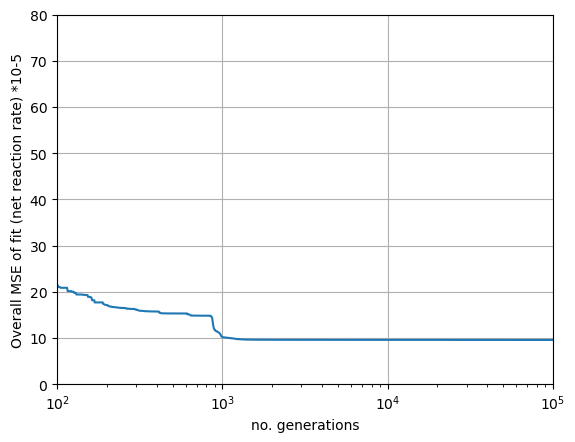

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

-0.8001333210858943
-7.90048630238503
-1.1708114569764825
-1.1796968483916401
-7.823807839112643
-1.5710151077562287
8.180019289484333
-1.1681435688317796
-7.31452666086129
5.606940489208951
-0.7096735313034156
-4.239717560632176
2.672347468564913
-1.2523964870270814
-7.407201915611741
-4.791813265526752e-09
-1.286937897340013
-6.970724179553403
-0.8787779020639185
10.226169186329502
3.7200494654750633
-3.004406335649644e-08
-3.0295139030020053
-5.73014133249003
6.129933917343626
-0.9513773636226152
-1.3010299979172102


In [34]:
res.X

array([-8.00133321e-01, -7.90048630e+00, -1.17081146e+00, -1.17969685e+00,
       -7.82380784e+00, -1.57101511e+00,  8.18001929e+00, -1.16814357e+00,
       -7.31452666e+00,  5.60694049e+00, -7.09673531e-01, -4.23971756e+00,
        2.67234747e+00, -1.25239649e+00, -7.40720192e+00, -4.79181327e-09,
       -1.28693790e+00, -6.97072418e+00, -8.78777902e-01,  1.02261692e+01,
        3.72004947e+00, -3.00440634e-08, -3.02951390e+00, -5.73014133e+00,
        6.12993392e+00, -9.51377364e-01, -1.30103000e+00])

In [35]:
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]

for i in range(len (logkr)):
    print (logkr[i])

-0.8
-7.9
-1.1
-1.2
-7.8
-1.6
7.6
-1.1
-7.3
7.1
-0.7
-10.9
10.9
-0.3
-6.5
-0.9
-0.5
-0.4
-7.1
9.3
3.1
-1.3
-1.8
-6.4
1.0
-6.0


In [36]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-0.8: -0.8001333210858943
-7.9: -7.90048630238503
-1.1: -1.1708114569764825
-1.2: -1.1796968483916401
-7.8: -7.823807839112643
-1.6: -1.5710151077562287
7.6: 8.180019289484333
-1.1: -1.1681435688317796
-7.3: -7.31452666086129
7.1: 5.606940489208951
-0.7: -0.7096735313034156
-10.9: -4.239717560632176
10.9: 2.672347468564913
-0.3: -1.2523964870270814
-6.5: -7.407201915611741
-0.9: -4.791813265526752e-09
-0.5: -1.286937897340013
-0.4: -6.970724179553403
-7.1: -0.8787779020639185
9.3: 10.226169186329502
3.1: 3.7200494654750633
-1.3: -3.004406335649644e-08
-1.8: -3.0295139030020053
-6.4: -5.73014133249003
1.0: 6.129933917343626
-6.0: -0.9513773636226152
R-value: 0.8145834410238663
R2: 0.6635461823902826
